# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [4]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(12, 1, False)
End game! Reward:  -1.0
You lost :(

(14, 9, False)
(20, 9, False)
End game! Reward:  -1
You lost :(

(12, 2, False)
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [6]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((20, 7, False), 0, 1.0)]
[((20, 2, False), 0, 1.0)]
[((14, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [7]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # calculate and store the return for each visit in the episode
        for i, state in enumerate(states):
            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
    # calculate the state-value function estimate
    V = {k: np.mean(v) for k, v in returns.items()}
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

In [8]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

Episode 500000/500000.

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [10]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

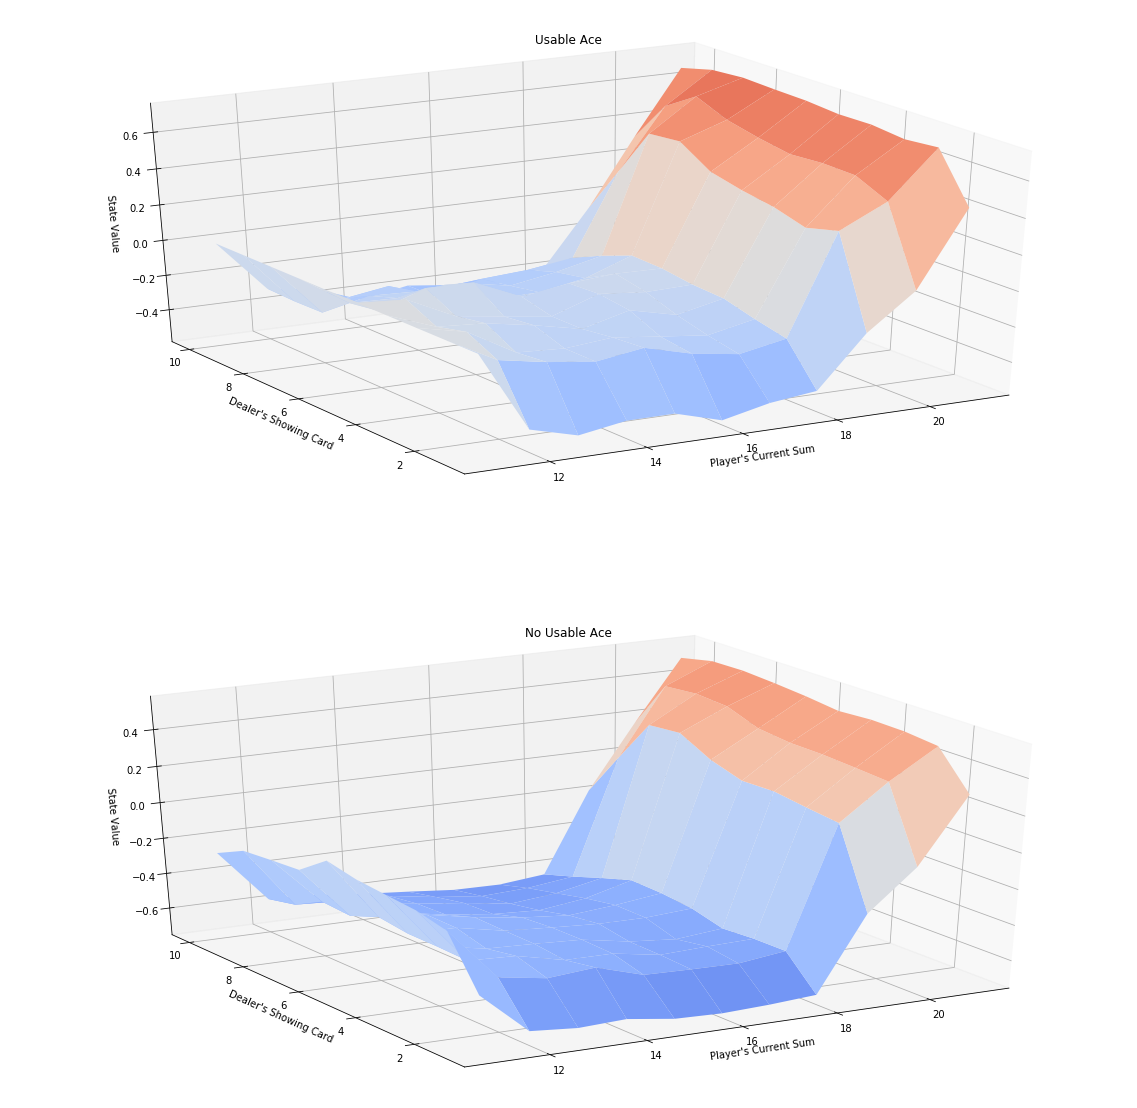

In [11]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [12]:
Q

defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>>,
            {(4, 1, False): array([-0.88888889, -0.62702703]),
             (4, 2, False): array([-0.41463415, -0.32515337]),
             (4, 3, False): array([-0.33333333, -0.30508475]),
             (4, 4, False): array([-0.18181818, -0.46583851]),
             (4, 5, False): array([-0.25714286, -0.42076503]),
             (4, 6, False): array([-0.20833333, -0.29319372]),
             (4, 7, False): array([-0.53846154, -0.31606218]),
             (4, 8, False): array([-0.4375, -0.32  ]),
             (4, 9, False): array([-0.45454545, -0.33898305]),
             (4, 10, False): array([-0.56043956, -0.46629213]),
             (5, 1, False): array([-0.67391304, -0.63360882]),
             (5, 2, False): array([-0.19191919, -0.34946237]),
             (5, 3, False): array([-0.12195122, -0.2899729 ]),
             (5, 4, False): array([-0.29268293, -0.32095491]),
             (5, 5, False): array([ 0.        , -0.3139841

### Part 3: MC Control: GLIE

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [13]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # if there is entry in the Q dictionary, then use get probs, else take random sample between the two actions    
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        #print (episode)
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    #epsilon = 1.0/((i_episode/8000)+1) - a moving multiplier, will give large values first, and move the average by big values
    # then move the average by very small value
    # epsilon is 1 at episode = 0
    # and 0.5 at the end of 8000 episodes
    # dont know why 8000 was chosen
    policy_s = np.ones(nA) * epsilon / nA
    #print (policy_s)
    best_a = np.argmax(Q_s) #gives the best action to be taken as per the dict
    #print (best_a)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    # for that action (0/1, depending upon order in dict), gives a prob score to explore more at start 
    return policy_s

def update_Q_GLIE(env, episode, Q, N, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    #print ('FutureRewards-',discounts)
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
        #print (Q,N)
    return Q, N

In [14]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        print ('Episode Start',episode,'Episode Finish')
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
#     print (episode)
    #print (policy)
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [23]:
mc_control_GLIE(env, 3)

[((21, 2, True), 0, 1.0)]
Episode Start [((21, 2, True), 0, 1.0)] Episode Finish
FutureRewards- [ 1.  1.]
defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62ecee18>, {(21, 2, True): array([ 1.,  0.])}) defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62c37268>, {(21, 2, True): array([ 1.,  0.])})
[((17, 10, True), 0, 0.0)]
Episode Start [((17, 10, True), 0, 0.0)] Episode Finish
FutureRewards- [ 1.  1.]
defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62ecee18>, {(21, 2, True): array([ 1.,  0.]), (17, 10, True): array([ 0.,  0.])}) defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62c37268>, {(21, 2, True): array([ 1.,  0.]), (17, 10, True): array([ 1.,  0.])})
[((13, 8, False), 0, -1.0)]
Episode Start [((13, 8, False), 0, -1.0)] Episode Finish
FutureRewards- [ 1.  1.]
defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62ecee18>, {(21, 2, True): array([ 1.,  0.]), (17, 10, True): array([ 0.,  0.]), (13, 8, Fals

({(13, 8, False): 1, (17, 10, True): 0, (21, 2, True): 0},
 defaultdict(<function __main__.mc_control_GLIE.<locals>.<lambda>>,
             {(13, 8, False): array([-1.,  0.]),
              (17, 10, True): array([ 0.,  0.]),
              (21, 2, True): array([ 1.,  0.])}))

In [50]:
nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA))
N = defaultdict(lambda: np.zeros(nA))
episode=[((21, 2, True), 0, 1.0),((21, 2, True), 0, 1.0),((21, 2, True), 1, 1.0)]

#episode=[((21, 2, True), 1, 1.0),((21, 2, True), 1, 1.0),((21, 2, True), 0, 1.0)]

#score =  (21, 2, True), 0
# [1+1*(2)]+[1+1*(1)]  = 5; N =2 ; average =2.5
#(21, 2, True), 1
# 1; N=1, average =1
# actions are 1,0 , np.arange[2] will give [0,1] - no; it is because
# in default dict, we inserted 0 first through Q[state][action[i]]
#so array returned [2.5,1]

gamma=1.0
Q, N=update_Q_GLIE(env, episode, Q, N, gamma) 
# took the state values, old Q and N values
# need to update the average for Q
# this updated Q becomes the new Q and N is added 1 
# N is always updated by addinng one - happens nowhere else

FutureRewards- [ 1.  1.  1.  1.]
defaultdict(<function <lambda> at 0x7f6c62c54840>, {(21, 2, True): array([ 3.,  0.])}) defaultdict(<function <lambda> at 0x7f6c62c54d08>, {(21, 2, True): array([ 1.,  0.])})
defaultdict(<function <lambda> at 0x7f6c62c54840>, {(21, 2, True): array([ 2.5,  0. ])}) defaultdict(<function <lambda> at 0x7f6c62c54d08>, {(21, 2, True): array([ 2.,  0.])})
defaultdict(<function <lambda> at 0x7f6c62c54840>, {(21, 2, True): array([ 2.5,  1. ])}) defaultdict(<function <lambda> at 0x7f6c62c54d08>, {(21, 2, True): array([ 2.,  1.])})


In [51]:
Q

defaultdict(<function __main__.<lambda>>, {(21, 2, True): array([ 2.5,  1. ])})

In [53]:
Q.items() #returns iterators in python 3 
#k is for keys, v for values
for k, v in Q.items():
    print (k,v)
    print (np.argmax(v)) #maximum value for the state is for action[0] - which could be hit/stick
    #depending upon the order in which in which it was inserted in the dictionary
    # so as per the reward, we update the policy document
    # after good amount of iterations, the policy will have Q values(returns for an action) which will be static
    # does not move that much as N will become very large and single iteration will not change the mean
    # but for this both N, which is for action 0 and 1 should be large enough

(21, 2, True) [ 2.5  1. ]
0


In [54]:
policy = dict((k,np.argmax(v)) for k, v in Q.items())

In [17]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 3)

[((13, 10, False), 1, 0)]
[((13, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
Episode Start [((13, 10, False), 1, 0), ((18, 10, False), 0, -1.0)] Episode Finish
FutureRewards- [ 1.  1.  1.]
defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62e59268>, {(13, 10, False): array([ 0., -1.])}) defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62e59400>, {(13, 10, False): array([ 0.,  1.])})
defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62e59268>, {(13, 10, False): array([ 0., -1.]), (18, 10, False): array([-1.,  0.])}) defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62e59400>, {(13, 10, False): array([ 0.,  1.]), (18, 10, False): array([ 1.,  0.])})
[((11, 10, False), 0, 1.0)]
Episode Start [((11, 10, False), 0, 1.0)] Episode Finish
FutureRewards- [ 1.  1.]
defaultdict(<function mc_control_GLIE.<locals>.<lambda> at 0x7f6c62e59268>, {(13, 10, False): array([ 0., -1.]), (18, 10, False): array([-1.,  0.]), (11, 10, False): arra

Next, we plot the corresponding state-value function.

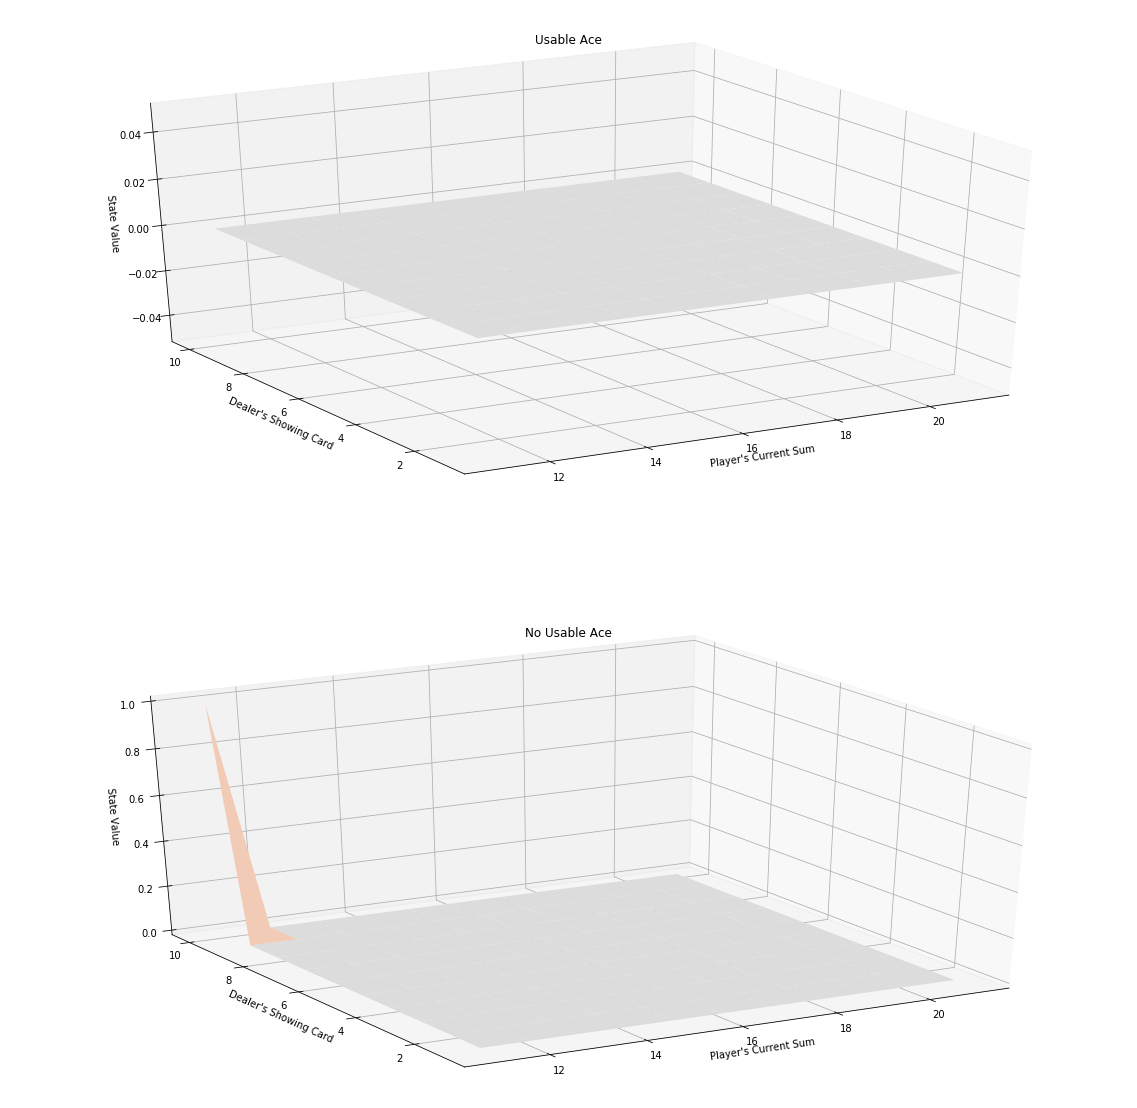

In [18]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

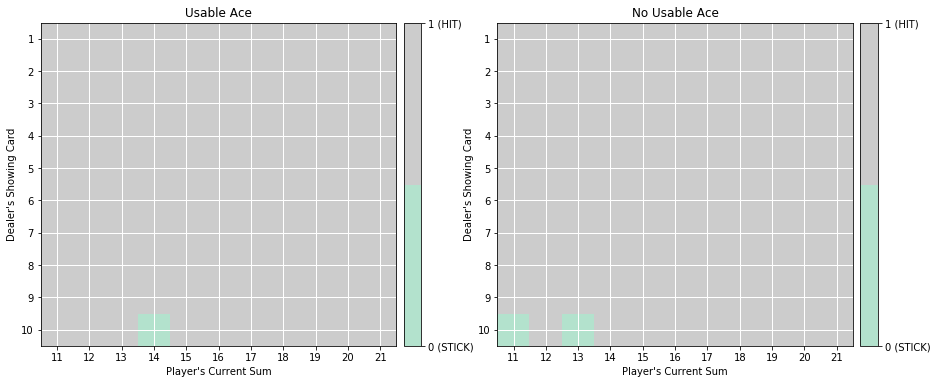

In [19]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### Part 4: MC Control: Constant-$\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [20]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [21]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [22]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.02)

[((19, 6, False), 0, 1.0)]
[((16, 10, False), 0, -1.0)]
[((14, 10, False), 0, -1.0)]
[((14, 5, True), 0, 1.0)]
[((17, 2, True), 1, 0)]
[((17, 2, True), 1, 0), ((12, 2, False), 0, -1.0)]
[((20, 10, False), 1, -1)]
[((13, 6, False), 1, -1)]
[((11, 10, False), 0, -1.0)]
[((21, 4, True), 0, 0.0)]
[((17, 7, False), 1, 0)]
[((17, 7, False), 1, 0), ((18, 7, False), 1, -1)]
[((9, 9, False), 1, 0)]
[((9, 9, False), 1, 0), ((15, 9, False), 1, 0)]
[((9, 9, False), 1, 0), ((15, 9, False), 1, 0), ((19, 9, False), 0, 1.0)]
[((16, 7, True), 1, 0)]
[((16, 7, True), 1, 0), ((19, 7, True), 0, 1.0)]
[((12, 10, True), 1, 0)]
[((12, 10, True), 1, 0), ((12, 10, False), 0, -1.0)]
[((13, 5, True), 1, 0)]
[((13, 5, True), 1, 0), ((21, 5, True), 1, 0)]
[((13, 5, True), 1, 0), ((21, 5, True), 1, 0), ((13, 5, False), 0, -1.0)]
[((20, 3, False), 1, -1)]
[((6, 10, False), 1, 0)]
[ 0.499002  0.499002]
1
[((6, 10, False), 1, 0), ((11, 10, False), 0, -1.0)]
[((20, 7, False), 0, -1.0)]
[((15, 7, False), 0, 1.0)]
[((17,

0
[((12, 6, False), 1, 0), ((18, 6, False), 1, 0), ((19, 6, False), 1, -1)]
[((20, 6, False), 0, 1.0)]
[ 0.48804295  0.48804295]
1
[((13, 2, False), 0, -1.0)]
[ 0.48798341  0.48798341]
0
[((16, 7, False), 1, -1)]
[ 0.48792388  0.48792388]
0
[((14, 5, False), 0, 1.0)]
[ 0.48786437  0.48786437]
0
[((18, 10, True), 0, -1.0)]
[((19, 2, False), 1, -1)]
[((12, 8, False), 1, 0)]
[ 0.4877454  0.4877454]
0
[((12, 8, False), 1, 0), ((18, 8, False), 1, -1)]
[ 0.48768593  0.48768593]
0
[((20, 6, False), 0, 1.0)]
[((19, 8, True), 1, 0)]
[ 0.48762648  0.48762648]
0
[((19, 8, True), 1, 0), ((13, 8, False), 1, 0)]
[ 0.48762648  0.48762648]
0
[((19, 8, True), 1, 0), ((13, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.48756704  0.48756704]
0
[((14, 1, False), 1, -1)]
[ 0.48750762  0.48750762]
1
[((15, 1, False), 0, -1.0)]
[ 0.48744821  0.48744821]
0
[((12, 10, False), 1, 0)]
[ 0.48744821  0.48744821]
0
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.48744821  0.48744821]
1
[((12, 10, False), 1,

0
[((20, 9, False), 1, -1)]
[ 0.47927151  0.47927151]
0
[((9, 4, False), 0, -1.0)]
[((4, 10, False), 0, -1.0)]
[ 0.47915668  0.47915668]
0
[((21, 9, True), 0, 1.0)]
[ 0.47909929  0.47909929]
0
[((11, 6, False), 0, -1.0)]
[ 0.47904192  0.47904192]
1
[((12, 3, False), 1, 0)]
[ 0.47904192  0.47904192]
0
[((12, 3, False), 1, 0), ((15, 3, False), 1, -1)]
[ 0.47898455  0.47898455]
1
[((18, 10, True), 0, -1.0)]
[ 0.4789272  0.4789272]
0
[((14, 3, False), 0, 1.0)]
[ 0.47886987  0.47886987]
0
[((20, 3, False), 1, -1)]
[ 0.47881254  0.47881254]
1
[((17, 9, False), 0, -1.0)]
[ 0.47875524  0.47875524]
0
[((19, 9, False), 0, -1.0)]
[((17, 6, True), 0, 1.0)]
[ 0.47864066  0.47864066]
0
[((12, 10, False), 0, 1.0)]
[ 0.47858339  0.47858339]
0
[((21, 9, True), 1, 0)]
[ 0.47858339  0.47858339]
0
[((21, 9, True), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.47852614  0.47852614]
1
[((20, 1, False), 0, 1.0)]
[((5, 6, False), 0, 1.0)]
[ 0.47841167  0.47841167]
0
[((14, 8, False), 1, 0)]
[ 0.47841167  0.47841167]


[ 0.4709761  0.4709761]
0
[((13, 5, True), 0, -1.0)]
[ 0.47092065  0.47092065]
0
[((20, 1, False), 1, -1)]
[ 0.47086521  0.47086521]
0
[((20, 5, False), 0, 1.0)]
[ 0.47080979  0.47080979]
0
[((20, 10, False), 0, 0.0)]
[ 0.47075438  0.47075438]
1
[((13, 7, False), 1, -1)]
[ 0.47069899  0.47069899]
0
[((5, 6, False), 1, 0)]
[ 0.47069899  0.47069899]
0
[((5, 6, False), 1, 0), ((9, 6, False), 1, 0)]
[ 0.47069899  0.47069899]
0
[((5, 6, False), 1, 0), ((9, 6, False), 1, 0), ((13, 6, False), 0, -1.0)]
[ 0.47064361  0.47064361]
0
[((19, 9, False), 1, -1)]
[ 0.47058824  0.47058824]
1
[((15, 7, False), 0, -1.0)]
[ 0.47053288  0.47053288]
0
[((12, 10, False), 0, 1.0)]
[ 0.47047753  0.47047753]
1
[((13, 10, False), 0, -1.0)]
[ 0.4704222  0.4704222]
0
[((17, 2, True), 1, 0)]
[((17, 2, True), 1, 0), ((18, 2, True), 0, 1.0)]
[ 0.47036689  0.47036689]
0
[((18, 2, True), 0, 1.0)]
[ 0.47031158  0.47031158]
0
[((19, 4, False), 0, 1.0)]
[ 0.47025629  0.47025629]
1
[((13, 10, False), 1, 0)]
[ 0.47025629  

[ 0.46312377  0.46312377]
1
[((12, 1, True), 1, 0), ((14, 1, True), 0, -1.0)]
[ 0.46307016  0.46307016]
1
[((10, 7, False), 0, -1.0)]
[ 0.46301655  0.46301655]
1
[((14, 10, False), 0, -1.0)]
[ 0.46296296  0.46296296]
0
[((18, 9, False), 0, -1.0)]
[ 0.46290939  0.46290939]
0
[((12, 10, False), 1, 0)]
[ 0.46290939  0.46290939]
0
[((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.46285582  0.46285582]
1
[((11, 8, False), 0, 1.0)]
[ 0.46280227  0.46280227]
0
[((13, 6, False), 0, 1.0)]
[ 0.46274873  0.46274873]
0
[((21, 2, True), 1, 0)]
[ 0.46274873  0.46274873]
0
[((21, 2, True), 1, 0), ((21, 2, False), 0, 0.0)]
[ 0.4626952  0.4626952]
1
[((14, 10, False), 1, -1)]
[ 0.46264168  0.46264168]
0
[((12, 4, False), 0, -1.0)]
[ 0.46258818  0.46258818]
0
[((15, 3, False), 1, -1)]
[ 0.46253469  0.46253469]
0
[((14, 3, False), 1, 0)]
[ 0.46253469  0.46253469]
1
[((14, 3, False), 1, 0), ((16, 3, False), 1, 0)]
[ 0.46253469  0.46253469]
0
[((14, 3, False), 1, 0), ((16, 3, False), 1, 0), ((17, 3, 

[ 0.45594437  0.45594437]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.45589241  0.45589241]
0
[((9, 1, False), 1, 0)]
[ 0.45589241  0.45589241]
1
[((9, 1, False), 1, 0), ((16, 1, False), 0, -1.0)]
[ 0.45584046  0.45584046]
0
[((19, 2, False), 0, 1.0)]
[ 0.45578851  0.45578851]
0
[((11, 5, False), 0, -1.0)]
[ 0.45573658  0.45573658]
1
[((14, 8, False), 0, 1.0)]
[ 0.45568467  0.45568467]
1
[((11, 6, False), 0, 1.0)]
[((4, 7, False), 0, -1.0)]
[ 0.45558087  0.45558087]
0
[((9, 1, False), 0, -1.0)]
[ 0.45552898  0.45552898]
1
[((8, 8, False), 0, 1.0)]
[ 0.45547711  0.45547711]
0
[((20, 10, False), 0, 0.0)]
[ 0.45542525  0.45542525]
1
[((21, 2, True), 1, 0)]
[ 0.45542525  0.45542525]
1
[((21, 2, True), 1, 0), ((14, 2, False), 1, 0)]
[ 0.45542525  0.45542525]
0
[((21, 2, True), 1, 0), ((14, 2, False), 1, 0), ((17, 2, False), 1, -1)]
[ 0.45537341  0.45537341]
1
[((13, 10, False), 1, -1)]
[ 0.45532157  0.45532157]
1
[((12, 4, False), 0, -1.0)]
[ 0.45526975  0.45526975]
1
[((11, 

[ 0.44928676  0.44928676]
0
[((9, 2, False), 1, 0)]
[ 0.44928676  0.44928676]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.4492363  0.4492363]
0
[((15, 10, False), 1, -1)]
[ 0.44918585  0.44918585]
1
[((13, 10, False), 1, 0)]
[ 0.44918585  0.44918585]
0
[((13, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.44913541  0.44913541]
0
[((9, 6, False), 1, 0)]
[ 0.44913541  0.44913541]
1
[((9, 6, False), 1, 0), ((18, 6, False), 0, 1.0)]
[ 0.44908499  0.44908499]
0
[((13, 10, False), 0, -1.0)]
[ 0.44903458  0.44903458]
0
[((19, 10, False), 1, -1)]
[ 0.44898417  0.44898417]
0
[((15, 10, True), 0, -1.0)]
[ 0.44893378  0.44893378]
1
[((16, 9, False), 1, -1)]
[ 0.4488834  0.4488834]
1
[((12, 4, False), 1, 0)]
[ 0.4488834  0.4488834]
0
[((12, 4, False), 1, 0), ((14, 4, False), 1, 0)]
[ 0.4488834  0.4488834]
0
[((12, 4, False), 1, 0), ((14, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.44883303  0.44883303]
0
[((16, 4, False), 0, -1.0)]
[ 0.44878268  0.44878268]
0
[((20, 2, False), 

[ 0.44233108  0.44233108]
1
[((16, 10, False), 1, -1)]
[ 0.44228218  0.44228218]
0
[((21, 10, True), 1, 0)]
[ 0.44228218  0.44228218]
0
[((21, 10, True), 1, 0), ((21, 10, False), 1, -1)]
[ 0.44223328  0.44223328]
0
[((10, 8, False), 0, 1.0)]
[ 0.44218439  0.44218439]
0
[((15, 4, False), 0, -1.0)]
[ 0.44213551  0.44213551]
0
[((18, 8, False), 1, -1)]
[ 0.44208665  0.44208665]
1
[((14, 7, False), 0, 1.0)]
[ 0.44203779  0.44203779]
0
[((20, 5, False), 0, 0.0)]
[ 0.44198895  0.44198895]
0
[((12, 9, False), 0, -1.0)]
[ 0.44194012  0.44194012]
0
[((20, 9, False), 0, 1.0)]
[ 0.44189129  0.44189129]
1
[((10, 9, False), 1, 0)]
[ 0.44189129  0.44189129]
0
[((10, 9, False), 1, 0), ((20, 9, False), 1, -1)]
[ 0.44184248  0.44184248]
0
[((16, 7, False), 0, -1.0)]
[ 0.44179368  0.44179368]
0
[((17, 10, True), 1, 0)]
[ 0.44179368  0.44179368]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.44174489  0.44174489]
0
[((15, 2, False), 0, -1.0)]
[ 0.44169611  0.44169611]
1
[((14, 10, False), 0, -

[ 0.43563494  0.43563494]
0
[((11, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.4355875  0.4355875]
0
[((12, 8, False), 1, 0)]
[ 0.4355875  0.4355875]
0
[((12, 8, False), 1, 0), ((17, 8, False), 1, -1)]
[ 0.43554007  0.43554007]
0
[((20, 10, False), 0, 1.0)]
[ 0.43549265  0.43549265]
0
[((20, 10, False), 0, 0.0)]
[ 0.43544524  0.43544524]
1
[((7, 10, False), 0, 1.0)]
[ 0.43539784  0.43539784]
1
[((10, 10, False), 1, 0)]
[ 0.43539784  0.43539784]
0
[((10, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.43535046  0.43535046]
1
[((13, 10, False), 1, 0)]
[ 0.43535046  0.43535046]
1
[((13, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.43530308  0.43530308]
0
[((15, 6, False), 0, -1.0)]
[ 0.43525571  0.43525571]
0
[((21, 8, True), 0, 0.0)]
[ 0.43520836  0.43520836]
0
[((20, 10, False), 1, -1)]
[ 0.43516101  0.43516101]
1
[((18, 3, False), 1, -1)]
[ 0.43511367  0.43511367]
0
[((12, 10, False), 1, -1)]
[ 0.43506635  0.43506635]
0
[((17, 5, False), 0, 1.0)]
[ 0.43501903  0.43501903]
0


1
[((12, 1, False), 1, 0)]
[ 0.42950714  0.42950714]
0
[((12, 1, False), 1, 0), ((17, 1, False), 0, 0.0)]
[ 0.42946103  0.42946103]
1
[((16, 10, False), 1, 0)]
[ 0.42946103  0.42946103]
0
[((16, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.42941492  0.42941492]
1
[((13, 2, False), 1, 0)]
[ 0.42941492  0.42941492]
0
[((13, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.42936883  0.42936883]
0
[((17, 7, False), 1, -1)]
[ 0.42932274  0.42932274]
0
[((18, 10, False), 0, 1.0)]
[ 0.42927667  0.42927667]
0
[((19, 9, False), 0, 1.0)]
[ 0.4292306  0.4292306]
0
[((14, 10, False), 0, -1.0)]
[ 0.42918455  0.42918455]
1
[((5, 10, False), 1, 0)]
[ 0.42918455  0.42918455]
0
[((5, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.4291385  0.4291385]
0
[((14, 5, False), 0, -1.0)]
[ 0.42909247  0.42909247]
0
[((13, 6, False), 0, 1.0)]
[ 0.42904644  0.42904644]
0
[((12, 8, False), 1, 0)]
[ 0.42904644  0.42904644]
0
[((12, 8, False), 1, 0), ((18, 8, False), 1, -1)]
[ 0.42900043  0.42900043]
0
[((8,

[ 0.42372881  0.42372881]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.42368393  0.42368393]
0
[((20, 10, False), 0, -1.0)]
[ 0.42363906  0.42363906]
0
[((15, 10, False), 1, -1)]
[ 0.4235942  0.4235942]
0
[((8, 10, False), 1, 0)]
[ 0.4235942  0.4235942]
0
[((8, 10, False), 1, 0), ((19, 10, True), 1, 0)]
[ 0.4235942  0.4235942]
0
[((8, 10, False), 1, 0), ((19, 10, True), 1, 0), ((13, 10, False), 0, 1.0)]
[ 0.42354934  0.42354934]
0
[((20, 4, False), 0, 1.0)]
[ 0.4235045  0.4235045]
0
[((16, 8, False), 1, 0)]
[ 0.4235045  0.4235045]
0
[((16, 8, False), 1, 0), ((21, 8, False), 1, -1)]
[ 0.42345967  0.42345967]
0
[((17, 8, False), 1, 0)]
[ 0.42345967  0.42345967]
0
[((17, 8, False), 1, 0), ((18, 8, False), 1, 0)]
[ 0.42345967  0.42345967]
0
[((17, 8, False), 1, 0), ((18, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.42341484  0.42341484]
0
[((12, 10, False), 0, -1.0)]
[ 0.42337003  0.42337003]
0
[((12, 10, False), 1, -1)]
[ 0.42332522  0.42332522]
0
[((18, 10, False), 0, -1

[ 0.41849759  0.41849759]
0
[((19, 3, False), 0, -1.0)]
[ 0.41845381  0.41845381]
0
[((19, 6, True), 0, 0.0)]
[ 0.41841004  0.41841004]
0
[((14, 4, False), 1, -1)]
[ 0.41836628  0.41836628]
0
[((12, 2, False), 0, -1.0)]
[ 0.41832253  0.41832253]
1
[((14, 10, False), 1, -1)]
[ 0.41827878  0.41827878]
0
[((15, 6, False), 0, 1.0)]
[ 0.41823505  0.41823505]
0
[((19, 7, False), 0, 1.0)]
[ 0.41819132  0.41819132]
0
[((5, 10, False), 0, 1.0)]
[ 0.41814761  0.41814761]
0
[((12, 8, False), 0, -1.0)]
[ 0.4181039  0.4181039]
0
[((21, 4, True), 0, 1.0)]
[ 0.4180602  0.4180602]
1
[((9, 7, False), 1, 0)]
[ 0.4180602  0.4180602]
1
[((9, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.41801651  0.41801651]
1
[((13, 7, False), 1, 0)]
[ 0.41801651  0.41801651]
1
[((13, 7, False), 1, 0), ((16, 7, False), 1, 0)]
[ 0.41801651  0.41801651]
0
[((13, 7, False), 1, 0), ((16, 7, False), 1, 0), ((21, 7, False), 1, -1)]
[ 0.41797283  0.41797283]
1
[((11, 10, False), 1, 0)]
[ 0.41797283  0.41797283]
0
[((11, 10, Fa

[ 0.41224364  0.41224364]
0
[((8, 2, False), 1, 0), ((11, 2, False), 0, -1.0)]
[ 0.41220115  0.41220115]
1
[((14, 10, False), 1, 0)]
[ 0.41220115  0.41220115]
0
[((14, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.41215868  0.41215868]
1
[((16, 8, True), 1, 0)]
[ 0.41215868  0.41215868]
0
[((16, 8, True), 1, 0), ((16, 8, False), 0, 1.0)]
[ 0.41211622  0.41211622]
0
[((14, 5, False), 0, 1.0)]
[ 0.41207376  0.41207376]
0
[((17, 3, False), 0, -1.0)]
[ 0.41203131  0.41203131]
0
[((16, 4, False), 0, -1.0)]
[ 0.41198888  0.41198888]
0
[((16, 3, False), 0, 1.0)]
[ 0.41194645  0.41194645]
0
[((17, 10, False), 0, -1.0)]
[ 0.41190403  0.41190403]
0
[((13, 8, False), 1, -1)]
[ 0.41186161  0.41186161]
0
[((21, 5, True), 1, 0)]
[ 0.41186161  0.41186161]
0
[((21, 5, True), 1, 0), ((16, 5, False), 1, 0)]
[ 0.41186161  0.41186161]
0
[((21, 5, True), 1, 0), ((16, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.41181921  0.41181921]
0
[((16, 7, False), 0, -1.0)]
[ 0.41177682  0.41177682]
0
[((9, 9, 

[ 0.4069176  0.4069176]
1
[((14, 9, False), 0, -1.0)]
[ 0.40687621  0.40687621]
0
[((11, 8, False), 0, -1.0)]
[ 0.40683483  0.40683483]
0
[((8, 7, False), 1, 0)]
[ 0.40683483  0.40683483]
0
[((8, 7, False), 1, 0), ((11, 7, False), 0, -1.0)]
[ 0.40679345  0.40679345]
0
[((20, 5, False), 1, -1)]
[ 0.40675208  0.40675208]
0
[((13, 5, False), 1, -1)]
[ 0.40671073  0.40671073]
1
[((8, 10, False), 1, 0)]
[ 0.40671073  0.40671073]
0
[((8, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.40666938  0.40666938]
0
[((13, 10, False), 0, -1.0)]
[ 0.40662804  0.40662804]
0
[((12, 5, False), 0, 1.0)]
[ 0.4065867  0.4065867]
1
[((12, 9, False), 0, -1.0)]
[ 0.40654538  0.40654538]
0
[((8, 2, False), 0, -1.0)]
[ 0.40650407  0.40650407]
1
[((11, 10, False), 0, -1.0)]
[ 0.40646276  0.40646276]
0
[((21, 3, True), 0, 1.0)]
[ 0.40642146  0.40642146]
0
[((12, 10, False), 0, -1.0)]
[ 0.40638017  0.40638017]
0
[((6, 6, False), 1, 0)]
[ 0.40638017  0.40638017]
0
[((6, 6, False), 1, 0), ((16, 6, False), 0, -1.0

[((15, 10, True), 0, -1.0)]
[((13, 1, True), 1, 0)]
[ 0.40205046  0.40205046]
1
[((13, 1, True), 1, 0), ((14, 1, True), 1, 0)]
[((13, 1, True), 1, 0), ((14, 1, True), 1, 0), ((17, 1, True), 1, 0)]
[ 0.40205046  0.40205046]
1
[((13, 1, True), 1, 0), ((14, 1, True), 1, 0), ((17, 1, True), 1, 0), ((16, 1, False), 1, 0)]
[ 0.40205046  0.40205046]
0
[((13, 1, True), 1, 0), ((14, 1, True), 1, 0), ((17, 1, True), 1, 0), ((16, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.40201005  0.40201005]
0
[((16, 10, False), 0, -1.0)]
[ 0.40196965  0.40196965]
0
[((20, 9, False), 0, 0.0)]
[ 0.40192926  0.40192926]
1
[((11, 7, False), 0, -1.0)]
[ 0.40188888  0.40188888]
1
[((10, 7, False), 1, 0)]
[ 0.40188888  0.40188888]
0
[((10, 7, False), 1, 0), ((18, 7, False), 0, 0.0)]
[ 0.4018485  0.4018485]
1
[((10, 10, False), 1, 0)]
[ 0.4018485  0.4018485]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.40180814  0.40180814]
1
[((14, 10, False), 1, 0)]
[ 0.40180814  0.40180814]
0
[((14, 10, False), 

[((15, 10, False), 0, -1.0)]
[ 0.39733784  0.39733784]
0
[((10, 8, False), 0, -1.0)]
[ 0.39729837  0.39729837]
0
[((20, 7, False), 1, -1)]
[ 0.39725891  0.39725891]
0
[((13, 4, False), 0, -1.0)]
[ 0.39721946  0.39721946]
1
[((14, 7, False), 0, -1.0)]
[ 0.39718002  0.39718002]
1
[((11, 10, False), 0, 1.0)]
[ 0.39714059  0.39714059]
1
[((13, 3, False), 0, -1.0)]
[ 0.39710116  0.39710116]
0
[((18, 10, False), 0, 0.0)]
[ 0.39706174  0.39706174]
0
[((12, 9, True), 0, -1.0)]
[ 0.39702233  0.39702233]
0
[((12, 6, False), 0, -1.0)]
[ 0.39698293  0.39698293]
0
[((18, 1, False), 0, 1.0)]
[ 0.39694353  0.39694353]
0
[((18, 3, False), 1, 0)]
[ 0.39694353  0.39694353]
0
[((18, 3, False), 1, 0), ((20, 3, False), 1, -1)]
[ 0.39690415  0.39690415]
0
[((7, 7, False), 0, -1.0)]
[ 0.39686477  0.39686477]
0
[((16, 2, False), 0, -1.0)]
[ 0.3968254  0.3968254]
0
[((20, 4, False), 1, -1)]
[ 0.39678603  0.39678603]
1
[((13, 9, False), 0, -1.0)]
[ 0.39674668  0.39674668]
0
[((15, 3, False), 1, -1)]
[ 0.3967073

[((9, 10, False), 0, 1.0)]
[ 0.39273441  0.39273441]
1
[((7, 8, False), 1, 0)]
[ 0.39273441  0.39273441]
0
[((7, 8, False), 1, 0), ((13, 8, False), 0, -1.0)]
[ 0.39269586  0.39269586]
0
[((15, 10, False), 0, 1.0)]
[ 0.39265731  0.39265731]
0
[((17, 7, False), 0, 1.0)]
[ 0.39261877  0.39261877]
1
[((9, 6, False), 1, 0)]
[ 0.39261877  0.39261877]
0
[((9, 6, False), 1, 0), ((16, 6, False), 0, 1.0)]
[ 0.39258023  0.39258023]
0
[((20, 7, False), 0, -1.0)]
[ 0.39254171  0.39254171]
0
[((11, 6, False), 0, -1.0)]
[ 0.39250319  0.39250319]
0
[((14, 5, False), 0, 1.0)]
[ 0.39246468  0.39246468]
0
[((15, 10, False), 1, -1)]
[ 0.39242617  0.39242617]
1
[((8, 1, False), 1, 0)]
[ 0.39242617  0.39242617]
0
[((8, 1, False), 1, 0), ((10, 1, False), 0, -1.0)]
[ 0.39238768  0.39238768]
1
[((4, 10, False), 1, 0)]
[ 0.39238768  0.39238768]
1
[((4, 10, False), 1, 0), ((15, 10, True), 1, 0)]
[ 0.39238768  0.39238768]
0
[((4, 10, False), 1, 0), ((15, 10, True), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.39234919 

0
[((21, 7, True), 1, 0), ((13, 7, False), 1, 0)]
[ 0.38846266  0.38846266]
1
[((21, 7, True), 1, 0), ((13, 7, False), 1, 0), ((16, 7, False), 1, 0)]
[ 0.38846266  0.38846266]
0
[((21, 7, True), 1, 0), ((13, 7, False), 1, 0), ((16, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.38842494  0.38842494]
0
[((11, 1, False), 0, -1.0)]
[ 0.38838722  0.38838722]
0
[((15, 6, False), 0, -1.0)]
[ 0.38834951  0.38834951]
0
[((21, 1, True), 1, 0)]
[ 0.38834951  0.38834951]
0
[((21, 1, True), 1, 0), ((14, 1, False), 1, -1)]
[ 0.38831181  0.38831181]
1
[((16, 10, False), 0, 1.0)]
[ 0.38827412  0.38827412]
0
[((14, 6, True), 0, 1.0)]
[ 0.38823644  0.38823644]
0
[((14, 4, False), 1, -1)]
[ 0.38819876  0.38819876]
0
[((19, 10, True), 0, -1.0)]
[ 0.38816109  0.38816109]
0
[((20, 6, False), 1, -1)]
[ 0.38812342  0.38812342]
0
[((20, 2, False), 1, -1)]
[ 0.38808577  0.38808577]
0
[((16, 2, False), 1, -1)]
[ 0.38804812  0.38804812]
0
[((16, 5, False), 1, -1)]
[ 0.38801048  0.38801048]
0
[((13, 6, False), 1

[((13, 10, False), 1, -1)]
[ 0.38387716  0.38387716]
1
[((12, 8, False), 1, 0)]
[ 0.38387716  0.38387716]
0
[((12, 8, False), 1, 0), ((20, 8, False), 0, -1.0)]
[ 0.38384032  0.38384032]
0
[((6, 10, False), 0, -1.0)]
[ 0.38380349  0.38380349]
1
[((15, 9, False), 0, -1.0)]
[ 0.38376667  0.38376667]
0
[((19, 1, False), 0, 0.0)]
[ 0.38372985  0.38372985]
0
[((19, 2, True), 0, 1.0)]
[ 0.38369305  0.38369305]
0
[((15, 10, False), 0, -1.0)]
[ 0.38365624  0.38365624]
0
[((16, 10, False), 0, -1.0)]
[ 0.38361945  0.38361945]
0
[((8, 4, False), 0, -1.0)]
[ 0.38358266  0.38358266]
1
[((14, 7, False), 1, 0)]
[ 0.38358266  0.38358266]
0
[((14, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.38354588  0.38354588]
0
[((5, 1, False), 0, -1.0)]
[ 0.38350911  0.38350911]
0
[((18, 10, False), 0, -1.0)]
[ 0.38347234  0.38347234]
0
[((16, 3, False), 0, 1.0)]
[ 0.38343558  0.38343558]
0
[((19, 10, False), 0, 1.0)]
[ 0.38339883  0.38339883]
1
[((12, 9, False), 0, -1.0)]
[ 0.38336209  0.38336209]
0
[((20, 1, F

[ 0.37968676  0.37968676]
1
[((10, 10, False), 1, 0)]
[ 0.37968676  0.37968676]
1
[((10, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.37965072  0.37965072]
0
[((16, 10, False), 0, 1.0)]
[ 0.37961469  0.37961469]
1
[((13, 3, False), 0, -1.0)]
[ 0.37957867  0.37957867]
1
[((10, 10, False), 0, 1.0)]
[ 0.37954265  0.37954265]
0
[((14, 3, False), 0, -1.0)]
[ 0.37950664  0.37950664]
0
[((14, 2, False), 0, -1.0)]
[ 0.37947064  0.37947064]
0
[((20, 4, False), 0, 1.0)]
[ 0.37943464  0.37943464]
0
[((17, 10, False), 0, -1.0)]
[ 0.37939865  0.37939865]
1
[((12, 10, False), 1, 0)]
[ 0.37939865  0.37939865]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.37936267  0.37936267]
0
[((20, 8, False), 0, 1.0)]
[ 0.3793267  0.3793267]
0
[((16, 8, False), 0, -1.0)]
[ 0.37929073  0.37929073]
1
[((12, 10, False), 1, -1)]
[ 0.37925476  0.37925476]
0
[((17, 6, False), 1, -1)]
[ 0.37921881  0.37921881]
1
[((7, 10, False), 0, -1.0)]
[ 0.37918286  0.37918286]
0
[((11, 5, False), 0, 1.0)]
[ 0.379

[ 0.37569268  0.37569268]
0
[((12, 1, False), 1, 0), ((18, 1, False), 1, -1)]
[ 0.3756574  0.3756574]
1
[((11, 2, False), 1, 0)]
[ 0.3756574  0.3756574]
0
[((11, 2, False), 1, 0), ((21, 2, False), 1, -1)]
[ 0.37562212  0.37562212]
0
[((16, 5, False), 1, -1)]
[ 0.37558685  0.37558685]
0
[((16, 3, False), 1, -1)]
[ 0.37555159  0.37555159]
1
[((13, 3, False), 1, 0)]
[ 0.37555159  0.37555159]
0
[((13, 3, False), 1, 0), ((15, 3, False), 0, 1.0)]
[ 0.37551633  0.37551633]
1
[((10, 7, False), 0, -1.0)]
[ 0.37548109  0.37548109]
0
[((7, 3, False), 0, 1.0)]
[ 0.37544584  0.37544584]
0
[((18, 9, False), 0, -1.0)]
[ 0.37541061  0.37541061]
1
[((14, 10, False), 1, -1)]
[ 0.37537538  0.37537538]
0
[((6, 10, False), 1, 0)]
[ 0.37537538  0.37537538]
1
[((6, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.37534015  0.37534015]
1
[((16, 1, False), 0, -1.0)]
[ 0.37530494  0.37530494]
0
[((7, 1, False), 0, 1.0)]
[ 0.37526973  0.37526973]
0
[((19, 7, True), 1, 0)]
[ 0.37526973  0.37526973]
1
[((19, 7, 

[((12, 10, False), 1, -1)]
[ 0.37150553  0.37150553]
1
[((13, 8, False), 0, -1.0)]
[ 0.37147103  0.37147103]
1
[((9, 6, False), 1, 0)]
[ 0.37147103  0.37147103]
1
[((9, 6, False), 1, 0), ((11, 6, False), 0, 1.0)]
[ 0.37143653  0.37143653]
1
[((13, 10, False), 0, -1.0)]
[ 0.37140204  0.37140204]
0
[((17, 7, False), 0, -1.0)]
[ 0.37136756  0.37136756]
1
[((13, 10, False), 1, -1)]
[ 0.37133309  0.37133309]
0
[((20, 9, False), 0, 0.0)]
[ 0.37129862  0.37129862]
0
[((21, 10, True), 1, 0)]
[ 0.37129862  0.37129862]
0
[((21, 10, True), 1, 0), ((16, 10, False), 1, 0)]
[ 0.37129862  0.37129862]
0
[((21, 10, True), 1, 0), ((16, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.37126415  0.37126415]
0
[((20, 5, False), 0, 0.0)]
[ 0.3712297  0.3712297]
0
[((17, 10, False), 1, -1)]
[ 0.37119525  0.37119525]
0
[((11, 5, False), 0, -1.0)]
[ 0.37116081  0.37116081]
0
[((13, 2, False), 1, 0)]
[ 0.37116081  0.37116081]
0
[((13, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.37112637  0.37112637]
0
[((14

[ 0.36707351  0.36707351]
0
[((20, 5, False), 0, 1.0)]
[ 0.36703982  0.36703982]
0
[((15, 4, True), 1, 0)]
[ 0.36703982  0.36703982]
1
[((15, 4, True), 1, 0), ((15, 4, False), 0, -1.0)]
[ 0.36700615  0.36700615]
0
[((20, 10, False), 1, -1)]
[ 0.36697248  0.36697248]
0
[((20, 1, True), 0, 0.0)]
[ 0.36693881  0.36693881]
0
[((16, 8, False), 0, -1.0)]
[ 0.36690516  0.36690516]
1
[((11, 10, False), 1, 0)]
[ 0.36690516  0.36690516]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.3668715  0.3668715]
0
[((14, 3, False), 0, -1.0)]
[ 0.36683786  0.36683786]
1
[((14, 8, False), 1, -1)]
[ 0.36680422  0.36680422]
0
[((19, 8, False), 1, -1)]
[ 0.36677058  0.36677058]
1
[((9, 8, False), 1, 0)]
[ 0.36677058  0.36677058]
0
[((9, 8, False), 1, 0), ((16, 8, False), 1, -1)]
[ 0.36673696  0.36673696]
0
[((19, 5, False), 0, 0.0)]
[ 0.36670334  0.36670334]
0
[((12, 10, False), 0, -1.0)]
[ 0.36666972  0.36666972]
1
[((12, 10, False), 1, 0)]
[ 0.36666972  0.36666972]
1
[((12, 10, False), 1, 0), ((1

Episode 3000/500000.[ 0.36363636  0.36363636]
0
[((12, 10, False), 0, -1.0)]
[ 0.36360331  0.36360331]
0
[((20, 2, False), 1, -1)]
[ 0.36357026  0.36357026]
0
[((15, 6, False), 0, -1.0)]
[ 0.36353722  0.36353722]
0
[((20, 10, False), 0, 1.0)]
[ 0.36350418  0.36350418]
0
[((21, 10, True), 1, 0)]
[ 0.36350418  0.36350418]
0
[((21, 10, True), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.36347115  0.36347115]
1
[((10, 10, False), 1, 0)]
[ 0.36347115  0.36347115]
0
[((10, 10, False), 1, 0), ((12, 10, False), 0, 1.0)]
[ 0.36343812  0.36343812]
0
[((13, 1, False), 0, -1.0)]
[ 0.36340511  0.36340511]
0
[((14, 3, False), 1, -1)]
[ 0.36337209  0.36337209]
0
[((17, 8, False), 0, 1.0)]
[ 0.36333909  0.36333909]
1
[((15, 10, False), 1, -1)]
[ 0.36330609  0.36330609]
0
[((16, 7, True), 0, -1.0)]
[ 0.36327309  0.36327309]
0
[((17, 3, False), 1, -1)]
[ 0.3632401  0.3632401]
1
[((13, 10, False), 1, -1)]
[ 0.36320712  0.36320712]
0
[((13, 5, False), 1, 0)]
[ 0.36320712  0.36320712]
0
[((13, 5, False), 1, 0), (

[((12, 10, False), 0, 1.0)]
[ 0.36013325  0.36013325]
0
[((19, 9, False), 1, -1)]
[ 0.36010083  0.36010083]
0
[((7, 9, False), 1, 0)]
[ 0.36010083  0.36010083]
1
[((7, 9, False), 1, 0), ((11, 9, False), 1, 0)]
[ 0.36010083  0.36010083]
0
[((7, 9, False), 1, 0), ((11, 9, False), 1, 0), ((21, 9, False), 1, -1)]
[ 0.36006841  0.36006841]
0
[((18, 7, False), 0, 1.0)]
[ 0.360036  0.360036]
0
[((13, 6, False), 0, -1.0)]
[ 0.3600036  0.3600036]
0
[((19, 10, False), 0, -1.0)]
[ 0.3599712  0.3599712]
1
[((14, 9, True), 1, 0)]
[ 0.3599712  0.3599712]
0
[((14, 9, True), 1, 0), ((19, 9, True), 0, 0.0)]
[ 0.35993881  0.35993881]
0
[((12, 10, False), 0, -1.0)]
[ 0.35990642  0.35990642]
1
[((6, 1, False), 0, -1.0)]
[ 0.35987404  0.35987404]
0
[((16, 2, False), 0, -1.0)]
[ 0.35984167  0.35984167]
0
[((12, 1, False), 1, -1)]
[ 0.3598093  0.3598093]
1
[((12, 4, False), 0, -1.0)]
[ 0.35977694  0.35977694]
0
[((18, 10, False), 1, -1)]
[ 0.35974458  0.35974458]
0
[((21, 4, True), 0, 1.0)]
[ 0.35971223  0.3

[((10, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.3564427  0.3564427]
1
[((18, 4, True), 0, 1.0)]
[ 0.35641094  0.35641094]
0
[((13, 1, False), 0, -1.0)]
[ 0.35637919  0.35637919]
1
[((9, 6, False), 1, 0)]
[ 0.35637919  0.35637919]
0
[((9, 6, False), 1, 0), ((13, 6, False), 0, -1.0)]
[ 0.35634744  0.35634744]
1
[((9, 6, False), 1, 0)]
[ 0.35634744  0.35634744]
0
[((9, 6, False), 1, 0), ((15, 6, False), 0, 1.0)]
[ 0.3563157  0.3563157]
0
[((12, 10, False), 0, -1.0)]
[ 0.35628396  0.35628396]
0
[((19, 7, False), 0, 1.0)]
[ 0.35625223  0.35625223]
0
[((20, 9, False), 0, -1.0)]
[ 0.3562205  0.3562205]
0
[((18, 1, False), 1, -1)]
[ 0.35618878  0.35618878]
1
[((10, 10, False), 1, 0)]
[ 0.35618878  0.35618878]
0
[((10, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.35615707  0.35615707]
0
[((21, 8, True), 0, 1.0)]
[ 0.35612536  0.35612536]
0
[((19, 6, False), 0, 1.0)]
[ 0.35609365  0.35609365]
1
[((4, 9, False), 1, 0)]
[ 0.35609365  0.35609365]
0
[((4, 9, False), 1, 0), ((8, 9, False)

[ 0.35236082  0.35236082]
0
[((12, 10, False), 1, 0)]
[ 0.35236082  0.35236082]
0
[((12, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.35232978  0.35232978]
0
[((14, 2, False), 1, -1)]
[ 0.35229875  0.35229875]
0
[((11, 2, False), 1, 0)]
[ 0.35229875  0.35229875]
0
[((11, 2, False), 1, 0), ((12, 2, False), 0, -1.0)]
[ 0.35226772  0.35226772]
0
[((10, 4, False), 1, 0)]
[ 0.35226772  0.35226772]
0
[((10, 4, False), 1, 0), ((21, 4, True), 0, 1.0)]
[ 0.3522367  0.3522367]
0
[((11, 3, False), 0, -1.0)]
[ 0.35220569  0.35220569]
1
[((15, 10, False), 0, -1.0)]
[ 0.35217468  0.35217468]
1
[((12, 3, False), 0, 1.0)]
[ 0.35214367  0.35214367]
0
[((12, 9, False), 0, -1.0)]
[ 0.35211268  0.35211268]
0
[((5, 1, False), 0, -1.0)]
[ 0.35208168  0.35208168]
0
[((6, 10, False), 0, -1.0)]
[ 0.3520507  0.3520507]
0
[((14, 3, False), 0, -1.0)]
[ 0.35201971  0.35201971]
0
[((12, 6, False), 0, 1.0)]
[ 0.35198874  0.35198874]
0
[((20, 7, False), 0, 1.0)]
[ 0.35195777  0.35195777]
1
[((8, 1, False), 0, -

[((12, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.34858388  0.34858388]
0
[((11, 5, False), 0, 1.0)]
[ 0.3485535  0.3485535]
0
[((11, 2, False), 0, -1.0)]
[ 0.34852313  0.34852313]
0
[((19, 5, False), 1, -1)]
[ 0.34849277  0.34849277]
1
[((8, 4, False), 1, 0)]
[ 0.34849277  0.34849277]
1
[((8, 4, False), 1, 0), ((15, 4, False), 1, -1)]
[ 0.34846241  0.34846241]
1
[((14, 10, False), 1, 0)]
[ 0.34846241  0.34846241]
0
[((14, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.34843206  0.34843206]
1
[((14, 1, False), 1, -1)]
[ 0.34840171  0.34840171]
0
[((17, 6, False), 0, -1.0)]
[ 0.34837136  0.34837136]
1
[((14, 8, False), 1, -1)]
[ 0.34834103  0.34834103]
0
[((19, 5, True), 1, 0)]
[ 0.34834103  0.34834103]
0
[((19, 5, True), 1, 0), ((21, 5, True), 0, 1.0)]
[ 0.34831069  0.34831069]
0
[((12, 5, False), 1, 0)]
[ 0.34831069  0.34831069]
0
[((12, 5, False), 1, 0), ((16, 5, False), 1, -1)]
[ 0.34828037  0.34828037]
1
[((8, 6, False), 1, 0)]
[ 0.34828037  0.34828037]
0
[((8, 6, False), 

[ 0.34482759  0.34482759]
1
[((7, 10, False), 1, 0)]
[ 0.34482759  0.34482759]
1
[((7, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.34479786  0.34479786]
0
[((12, 5, False), 0, 1.0)]
[ 0.34476814  0.34476814]
1
[((12, 10, False), 1, -1)]
[ 0.34473843  0.34473843]
0
[((19, 10, True), 0, 0.0)]
[ 0.34470872  0.34470872]
1
[((10, 3, False), 0, 1.0)]
[ 0.34467902  0.34467902]
1
[((18, 9, True), 1, 0)]
[ 0.34467902  0.34467902]
0
[((18, 9, True), 1, 0), ((18, 9, False), 1, -1)]
[ 0.34464932  0.34464932]
0
[((20, 3, False), 0, 1.0)]
[ 0.34461963  0.34461963]
0
[((20, 5, False), 0, 1.0)]
[ 0.34458994  0.34458994]
1
[((12, 10, False), 1, -1)]
[ 0.34456025  0.34456025]
1
[((11, 10, False), 1, 0)]
[ 0.34456025  0.34456025]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.34456025  0.34456025]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.34453058  0.34453058]
0
[((14, 5, False), 0, 1.0)]
[ 0.3445009  0.3445009]
0
[((18, 6, True), 0, -1.0)]
[ 0.

[ 0.34126781  0.34126781]
0
[((12, 9, False), 1, 0), ((19, 9, False), 0, 0.0)]
[ 0.3412387  0.3412387]
1
[((7, 10, False), 1, 0)]
[ 0.3412387  0.3412387]
1
[((7, 10, False), 1, 0), ((13, 10, False), 0, 1.0)]
[ 0.34120959  0.34120959]
0
[((18, 6, True), 0, 1.0)]
[ 0.34118048  0.34118048]
0
[((20, 1, False), 0, -1.0)]
[ 0.34115139  0.34115139]
1
[((10, 10, False), 1, 0)]
[ 0.34115139  0.34115139]
1
[((10, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.34112229  0.34112229]
0
[((9, 10, False), 1, 0)]
[ 0.34112229  0.34112229]
0
[((9, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.3410932  0.3410932]
0
[((15, 3, True), 0, -1.0)]
[ 0.34106412  0.34106412]
1
[((13, 5, True), 0, -1.0)]
[ 0.34103504  0.34103504]
0
[((12, 6, False), 0, -1.0)]
[ 0.34100597  0.34100597]
1
[((10, 2, False), 1, 0)]
[ 0.34100597  0.34100597]
0
[((10, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.3409769  0.3409769]
1
[((15, 10, False), 1, 0)]
[ 0.3409769  0.3409769]
0
[((15, 10, False), 1, 0), ((16, 10, Fals

[ 0.33795201  0.33795201]
1
[((6, 10, False), 1, 0)]
[ 0.33795201  0.33795201]
0
[((6, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.33792346  0.33792346]
0
[((12, 8, False), 1, 0)]
[ 0.33792346  0.33792346]
0
[((12, 8, False), 1, 0), ((17, 8, False), 1, -1)]
[ 0.33789491  0.33789491]
0
[((12, 8, False), 1, -1)]
[ 0.33786637  0.33786637]
0
[((12, 10, False), 0, -1.0)]
[ 0.33783784  0.33783784]
0
[((6, 6, False), 1, 0)]
[ 0.33783784  0.33783784]
0
[((6, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.33780931  0.33780931]
1
[((16, 1, True), 1, 0)]
[ 0.33780931  0.33780931]
0
[((16, 1, True), 1, 0), ((20, 1, True), 1, 0)]
[ 0.33780931  0.33780931]
1
[((16, 1, True), 1, 0), ((20, 1, True), 1, 0), ((16, 1, False), 1, 0)]
[ 0.33780931  0.33780931]
0
[((16, 1, True), 1, 0), ((20, 1, True), 1, 0), ((16, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.33778078  0.33778078]
1
[((15, 10, False), 1, -1)]
[ 0.33775226  0.33775226]
0
[((20, 8, False), 1, -1)]
[ 0.33772374  0.33772374]
0
[((20

[ 0.33456005  0.33456005]
1
[((12, 10, True), 0, -1.0)]
[ 0.33453207  0.33453207]
0
[((20, 9, False), 0, 0.0)]
[ 0.3345041  0.3345041]
0
[((16, 6, False), 0, -1.0)]
[ 0.33447613  0.33447613]
0
[((18, 10, False), 0, 1.0)]
[ 0.33444816  0.33444816]
1
[((10, 10, False), 0, -1.0)]
[ 0.3344202  0.3344202]
0
[((21, 2, True), 0, 1.0)]
[ 0.33439224  0.33439224]
1
[((8, 10, False), 1, 0)]
[ 0.33439224  0.33439224]
1
[((8, 10, False), 1, 0), ((11, 10, False), 0, -1.0)]
[ 0.33436429  0.33436429]
0
[((12, 10, False), 0, 1.0)]
[ 0.33433634  0.33433634]
0
[((14, 1, False), 0, -1.0)]
[ 0.3343084  0.3343084]
0
[((16, 8, False), 0, 1.0)]
[ 0.33428046  0.33428046]
1
[((13, 7, True), 0, -1.0)]
[ 0.33425253  0.33425253]
0
[((12, 8, False), 1, 0)]
[ 0.33425253  0.33425253]
0
[((12, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.3342246  0.3342246]
0
[((17, 3, False), 0, -1.0)]
[ 0.33419667  0.33419667]
0
[((21, 9, True), 0, 1.0)]
[ 0.33416876  0.33416876]
1
[((13, 3, False), 1, 0)]
[ 0.33416876  0.334168

0
[((20, 6, False), 0, 1.0)]
[ 0.33101622  0.33101622]
0
[((21, 2, True), 1, 0)]
[ 0.33101622  0.33101622]
0
[((21, 2, True), 1, 0), ((15, 2, False), 1, 0)]
[ 0.33101622  0.33101622]
0
[((21, 2, True), 1, 0), ((15, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.33098883  0.33098883]
0
[((17, 1, False), 0, 1.0)]
[ 0.33096144  0.33096144]
1
[((15, 7, False), 1, -1)]
[ 0.33093406  0.33093406]
0
[((16, 10, False), 1, -1)]
[ 0.33090668  0.33090668]
0
[((12, 6, False), 0, -1.0)]
[ 0.33087931  0.33087931]
0
[((21, 5, True), 0, 1.0)]
[ 0.33085194  0.33085194]
1
[((7, 6, False), 1, 0)]
[ 0.33085194  0.33085194]
0
[((7, 6, False), 1, 0), ((14, 6, False), 0, 1.0)]
[ 0.33082458  0.33082458]
0
[((15, 10, False), 1, -1)]
[ 0.33079722  0.33079722]
1
[((12, 10, False), 1, 0)]
[ 0.33079722  0.33079722]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.33076987  0.33076987]
0
[((12, 5, False), 0, -1.0)]
[ 0.33074252  0.33074252]
1
[((12, 10, False), 0, -1.0)]
[ 0.33071517  0.33071517]
0
[((19,

0
[((12, 8, False), 1, 0)]
[ 0.32770768  0.32770768]
0
[((12, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.32768084  0.32768084]
1
[((11, 7, False), 1, 0)]
[ 0.32768084  0.32768084]
0
[((11, 7, False), 1, 0), ((18, 7, False), 1, 0)]
[ 0.32768084  0.32768084]
0
[((11, 7, False), 1, 0), ((18, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.327654  0.327654]
0
[((14, 7, True), 0, -1.0)]
[ 0.32762716  0.32762716]
0
[((12, 2, False), 0, -1.0)]
[ 0.32760033  0.32760033]
1
[((14, 7, False), 1, 0)]
[ 0.32760033  0.32760033]
0
[((14, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.3275735  0.3275735]
1
[((13, 8, False), 0, 1.0)]
[ 0.32754668  0.32754668]
0
[((21, 6, True), 1, 0)]
[ 0.32754668  0.32754668]
0
[((21, 6, True), 1, 0), ((20, 6, False), 1, -1)]
[ 0.32751986  0.32751986]
0
[((5, 10, False), 1, 0)]
[ 0.32751986  0.32751986]
1
[((5, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.32751986  0.32751986]
1
[((5, 10, False), 1, 0), ((13, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.3

[ 0.32515038  0.32515038]
0
[((20, 4, False), 0, 1.0)]
[ 0.32512395  0.32512395]
0
[((5, 3, False), 0, -1.0)]
[ 0.32509753  0.32509753]
0
[((16, 7, False), 0, -1.0)]
[ 0.32507111  0.32507111]
1
[((8, 9, False), 1, 0)]
[ 0.32507111  0.32507111]
1
[((8, 9, False), 1, 0), ((14, 9, False), 1, -1)]
[ 0.32504469  0.32504469]
1
[((11, 9, False), 1, 0)]
[ 0.32504469  0.32504469]
0
[((11, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.32501828  0.32501828]
0
[((18, 5, False), 0, 1.0)]
[ 0.32499188  0.32499188]
0
[((15, 3, False), 0, -1.0)]
[ 0.32496547  0.32496547]
1
[((10, 2, False), 1, 0)]
[ 0.32496547  0.32496547]
0
[((10, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.32493907  0.32493907]
0
[((21, 8, True), 0, 1.0)]
[ 0.32491268  0.32491268]
0
[((20, 1, True), 0, -1.0)]
[ 0.32488629  0.32488629]
0
[((19, 8, False), 0, 1.0)]
[ 0.3248599  0.3248599]
0
[((18, 9, False), 1, -1)]
[ 0.32483352  0.32483352]
0
[((17, 1, True), 0, -1.0)]
[ 0.32480715  0.32480715]
1
[((13, 10, False), 1, 0)]
[ 0.

0
[((14, 2, False), 1, 0), ((18, 2, False), 0, 1.0)]
[ 0.32245062  0.32245062]
0
[((19, 9, False), 0, 0.0)]
[ 0.32242463  0.32242463]
0
[((17, 7, False), 0, -1.0)]
[ 0.32239865  0.32239865]
1
[((10, 7, False), 1, 0)]
[ 0.32239865  0.32239865]
0
[((10, 7, False), 1, 0), ((19, 7, False), 1, -1)]
[ 0.32237266  0.32237266]
1
[((11, 10, False), 0, -1.0)]
[ 0.32234668  0.32234668]
0
[((12, 10, False), 1, 0)]
[ 0.32234668  0.32234668]
0
[((12, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.32232071  0.32232071]
1
[((13, 6, True), 0, 1.0)]
[ 0.32229474  0.32229474]
1
[((10, 10, False), 0, -1.0)]
[ 0.32226877  0.32226877]
0
[((15, 1, True), 0, -1.0)]
[ 0.32224281  0.32224281]
0
[((20, 3, False), 0, 0.0)]
[ 0.32221685  0.32221685]
0
[((16, 10, False), 0, -1.0)]
[ 0.3221909  0.3221909]
1
[((7, 10, False), 1, 0)]
[ 0.3221909  0.3221909]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.32216495  0.32216495]
1
[((15, 10, False), 0, -1.0)]
[ 0.322139  0.322139]
0
[((20, 10, False), 1, -1

[((20, 2, False), 0, 0.0)]
[ 0.31992322  0.31992322]
1
[((13, 8, False), 0, -1.0)]
[ 0.31989763  0.31989763]
1
[((13, 2, True), 1, 0)]
[ 0.31989763  0.31989763]
0
[((13, 2, True), 1, 0), ((21, 2, True), 1, 0)]
[ 0.31989763  0.31989763]
0
[((13, 2, True), 1, 0), ((21, 2, True), 1, 0), ((21, 2, False), 1, -1)]
[ 0.31987205  0.31987205]
0
[((16, 10, False), 0, -1.0)]
[ 0.31984647  0.31984647]
1
[((16, 9, False), 1, -1)]
[ 0.3198209  0.3198209]
0
[((15, 8, False), 1, -1)]
[ 0.31979533  0.31979533]
0
[((21, 10, True), 0, 1.0)]
[ 0.31976977  0.31976977]
1
[((17, 10, True), 1, 0)]
[ 0.31976977  0.31976977]
0
[((17, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.3197442  0.3197442]
1
[((8, 6, False), 1, 0)]
[ 0.3197442  0.3197442]
0
[((8, 6, False), 1, 0), ((14, 6, False), 1, -1)]
[ 0.31971865  0.31971865]
1
[((8, 2, False), 0, -1.0)]
[ 0.31969309  0.31969309]
0
[((19, 1, False), 0, 1.0)]
[ 0.31966755  0.31966755]
0
[((21, 1, True), 0, 1.0)]
[ 0.319642  0.319642]
0
[((19, 7, True), 0, 1.0)]
[

0
[((13, 9, False), 0, -1.0)]
[ 0.31743512  0.31743512]
1
[((8, 2, False), 1, 0)]
[ 0.31743512  0.31743512]
0
[((8, 2, False), 1, 0), ((17, 2, False), 1, 0)]
[ 0.31743512  0.31743512]
0
[((8, 2, False), 1, 0), ((17, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.31740993  0.31740993]
0
[((9, 10, False), 0, -1.0)]
[ 0.31738475  0.31738475]
0
[((12, 2, False), 0, -1.0)]
[ 0.31735957  0.31735957]
0
[((20, 7, False), 0, 1.0)]
[ 0.31733439  0.31733439]
1
[((13, 8, False), 0, -1.0)]
[ 0.31730922  0.31730922]
1
[((15, 10, False), 0, 1.0)]
[ 0.31728405  0.31728405]
0
[((16, 6, False), 0, 1.0)]
[ 0.31725888  0.31725888]
0
[((17, 6, False), 0, 1.0)]
[ 0.31723372  0.31723372]
0
[((20, 10, False), 1, -1)]
[ 0.31720856  0.31720856]
1
[((13, 10, False), 0, 1.0)]
[ 0.31718341  0.31718341]
0
[((14, 1, False), 1, 0)]
[ 0.31718341  0.31718341]
0
[((14, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.31715826  0.31715826]
0
[((13, 5, False), 1, -1)]
[ 0.31713312  0.31713312]
1
[((9, 1, False), 1, 0)]
[

[ 0.31451486  0.31451486]
0
[((19, 6, False), 0, 0.0)]
[ 0.31449013  0.31449013]
1
[((11, 10, False), 0, -1.0)]
[ 0.31446541  0.31446541]
0
[((17, 10, False), 0, -1.0)]
[ 0.31444069  0.31444069]
0
[((12, 3, False), 1, -1)]
[ 0.31441597  0.31441597]
0
[((9, 4, False), 0, -1.0)]
[ 0.31439126  0.31439126]
0
[((6, 10, False), 0, -1.0)]
[ 0.31436655  0.31436655]
1
[((14, 10, False), 0, -1.0)]
[ 0.31434185  0.31434185]
0
[((13, 5, False), 0, -1.0)]
[ 0.31431715  0.31431715]
0
[((20, 1, False), 0, -1.0)]
[ 0.31429245  0.31429245]
0
[((12, 10, False), 0, -1.0)]
[ 0.31426776  0.31426776]
1
[((14, 10, False), 1, 0)]
[ 0.31426776  0.31426776]
0
[((14, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.31424307  0.31424307]
0
[((18, 4, False), 0, 1.0)]
[ 0.31421838  0.31421838]
1
[((5, 2, False), 0, 1.0)]
[ 0.3141937  0.3141937]
0
[((20, 10, False), 0, 0.0)]
[ 0.31416902  0.31416902]
0
[((15, 8, False), 0, -1.0)]
[ 0.31414435  0.31414435]
0
[((13, 4, False), 0, -1.0)]
[ 0.31411968  0.31411968]
1
[((

[ 0.31174499  0.31174499]
1
[((16, 10, True), 1, 0)]
[ 0.31174499  0.31174499]
0
[((16, 10, True), 1, 0), ((16, 10, False), 1, -1)]
[ 0.3117207  0.3117207]
1
[((13, 10, False), 0, -1.0)]
[ 0.31169641  0.31169641]
0
[((16, 7, False), 0, -1.0)]
[ 0.31167212  0.31167212]
0
[((15, 10, False), 0, -1.0)]
[ 0.31164784  0.31164784]
1
[((11, 3, False), 1, 0)]
[ 0.31164784  0.31164784]
0
[((11, 3, False), 1, 0), ((21, 3, False), 1, -1)]
[ 0.31162356  0.31162356]
0
[((21, 10, True), 1, 0)]
[ 0.31162356  0.31162356]
0
[((21, 10, True), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.31159928  0.31159928]
0
[((16, 10, False), 0, 1.0)]
[ 0.31157501  0.31157501]
0
[((12, 8, True), 0, -1.0)]
[ 0.31155074  0.31155074]
1
[((12, 10, True), 1, 0)]
[ 0.31155074  0.31155074]
0
[((12, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.31152648  0.31152648]
0
[((21, 10, True), 1, 0)]
[ 0.31152648  0.31152648]
0
[((21, 10, True), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.31150222  0.31150222]
1
[((13, 10, False), 1, 0)]
[ 0.31

1
[((16, 7, False), 1, -1)]
[ 0.30892802  0.30892802]
0
[((8, 5, False), 0, -1.0)]
[ 0.30890416  0.30890416]
0
[((19, 2, False), 0, -1.0)]
[ 0.30888031  0.30888031]
1
[((10, 10, False), 1, 0)]
[ 0.30888031  0.30888031]
0
[((10, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.30885646  0.30885646]
0
[((20, 1, False), 0, -1.0)]
[ 0.30883261  0.30883261]
0
[((12, 10, False), 0, -1.0)]
[ 0.30880877  0.30880877]
0
[((17, 8, False), 0, -1.0)]
[ 0.30878493  0.30878493]
0
[((21, 1, True), 0, 1.0)]
[ 0.3087611  0.3087611]
0
[((11, 5, False), 0, -1.0)]
[ 0.30873726  0.30873726]
1
[((10, 2, False), 1, 0)]
[ 0.30873726  0.30873726]
0
[((10, 2, False), 1, 0), ((20, 2, False), 1, -1)]
[ 0.30871344  0.30871344]
0
[((12, 5, False), 1, 0)]
[ 0.30871344  0.30871344]
0
[((12, 5, False), 1, 0), ((19, 5, False), 0, 0.0)]
[ 0.30868961  0.30868961]
0
[((13, 5, False), 0, 1.0)]
[ 0.30866579  0.30866579]
0
[((18, 4, False), 1, 0)]
[ 0.30866579  0.30866579]
0
[((18, 4, False), 1, 0), ((19, 4, False), 0, 0.0)

[ 0.30632562  0.30632562]
0
[((19, 4, False), 0, -1.0)]
[ 0.30630217  0.30630217]
0
[((21, 2, True), 0, 1.0)]
[ 0.30627871  0.30627871]
0
[((12, 5, True), 1, 0)]
[ 0.30627871  0.30627871]
0
[((12, 5, True), 1, 0), ((12, 5, False), 0, 1.0)]
[ 0.30625526  0.30625526]
0
[((15, 3, False), 0, -1.0)]
[ 0.30623182  0.30623182]
0
[((14, 10, False), 1, -1)]
[ 0.30620837  0.30620837]
1
[((11, 10, False), 0, -1.0)]
[ 0.30618494  0.30618494]
0
[((16, 10, False), 0, -1.0)]
[ 0.3061615  0.3061615]
1
[((12, 1, False), 0, -1.0)]
[ 0.30613807  0.30613807]
0
[((21, 3, True), 1, 0)]
[ 0.30613807  0.30613807]
0
[((21, 3, True), 1, 0), ((21, 3, False), 1, -1)]
[ 0.30611464  0.30611464]
0
[((17, 8, False), 1, 0)]
[ 0.30611464  0.30611464]
0
[((17, 8, False), 1, 0), ((19, 8, False), 1, -1)]
[ 0.30609122  0.30609122]
0
[((19, 10, False), 0, 0.0)]
[ 0.30606779  0.30606779]
0
[((19, 10, False), 0, -1.0)]
[ 0.30604438  0.30604438]
0
[((5, 4, False), 1, 0)]
[ 0.30604438  0.30604438]
1
[((5, 4, False), 1, 0), ((12

[ 0.30385901  0.30385901]
0
[((4, 2, False), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.30383593  0.30383593]
1
[((13, 2, False), 1, -1)]
[ 0.30381285  0.30381285]
0
[((20, 8, False), 0, 1.0)]
[ 0.30378978  0.30378978]
0
[((16, 6, False), 0, 1.0)]
[ 0.30376671  0.30376671]
1
[((13, 9, False), 1, -1)]
[ 0.30374364  0.30374364]
0
[((12, 3, False), 0, -1.0)]
[ 0.30372058  0.30372058]
0
[((10, 7, False), 1, 0)]
[ 0.30372058  0.30372058]
0
[((10, 7, False), 1, 0), ((13, 7, False), 0, -1.0)]
[ 0.30369752  0.30369752]
0
[((20, 3, False), 0, 1.0)]
[ 0.30367446  0.30367446]
0
[((18, 5, False), 1, -1)]
[ 0.30365141  0.30365141]
0
[((15, 10, False), 0, -1.0)]
[ 0.30362836  0.30362836]
0
[((8, 6, False), 0, -1.0)]
[ 0.30360531  0.30360531]
0
[((14, 4, True), 1, 0)]
[ 0.30360531  0.30360531]
1
[((14, 4, True), 1, 0), ((15, 4, True), 0, -1.0)]
[ 0.30358227  0.30358227]
1
[((10, 3, False), 1, 0)]
[ 0.30358227  0.30358227]
0
[((10, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.30355923  0.30355923]
0
[((

[((20, 9, True), 0, 1.0)]
[ 0.30118214  0.30118214]
0
[((15, 10, False), 1, -1)]
[ 0.30115946  0.30115946]
1
[((7, 2, False), 1, 0)]
[ 0.30115946  0.30115946]
1
[((7, 2, False), 1, 0), ((10, 2, False), 1, 0)]
[ 0.30115946  0.30115946]
0
[((7, 2, False), 1, 0), ((10, 2, False), 1, 0), ((17, 2, False), 0, -1.0)]
[ 0.30113679  0.30113679]
0
[((20, 10, False), 0, -1.0)]
[ 0.30111412  0.30111412]
1
[((13, 8, True), 1, 0)]
[ 0.30111412  0.30111412]
1
[((13, 8, True), 1, 0), ((15, 8, True), 1, 0)]
[ 0.30111412  0.30111412]
0
[((13, 8, True), 1, 0), ((15, 8, True), 1, 0), ((19, 8, True), 0, 1.0)]
[ 0.30109146  0.30109146]
0
[((20, 10, False), 0, -1.0)]
[ 0.30106879  0.30106879]
0
[((16, 3, False), 0, 1.0)]
[ 0.30104614  0.30104614]
0
[((20, 10, True), 0, 1.0)]
[ 0.30102348  0.30102348]
0
[((10, 1, False), 1, 0)]
[ 0.30102348  0.30102348]
0
[((10, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[ 0.30100083  0.30100083]
1
[((13, 3, False), 1, -1)]
[ 0.30097818  0.30097818]
0
[((15, 5, True), 0, -1.0

0
[((17, 8, False), 0, 1.0)]
[ 0.29868578  0.29868578]
0
[((12, 5, False), 0, -1.0)]
[ 0.29866348  0.29866348]
0
[((4, 6, False), 0, -1.0)]
[ 0.29864118  0.29864118]
0
[((20, 1, False), 0, -1.0)]
[ 0.29861889  0.29861889]
1
[((15, 4, False), 1, 0)]
[ 0.29861889  0.29861889]
0
[((15, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.2985966  0.2985966]
0
[((16, 10, False), 0, -1.0)]
[ 0.29857431  0.29857431]
0
[((16, 5, False), 0, 1.0)]
[ 0.29855202  0.29855202]
0
[((16, 3, True), 1, 0)]
[ 0.29855202  0.29855202]
0
[((16, 3, True), 1, 0), ((17, 3, True), 0, -1.0)]
[ 0.29852974  0.29852974]
0
[((18, 9, False), 0, -1.0)]
[ 0.29850746  0.29850746]
1
[((9, 8, False), 0, -1.0)]
[ 0.29848519  0.29848519]
1
[((9, 1, False), 0, 1.0)]
[ 0.29846292  0.29846292]
0
[((16, 10, False), 0, -1.0)]
[ 0.29844065  0.29844065]
0
[((18, 8, True), 1, 0)]
[ 0.29844065  0.29844065]
0
[((18, 8, True), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.29841838  0.29841838]
0
[((9, 10, False), 0, 1.0)]
[ 0.29839612  0.29839612]

[ 0.29627435  0.29627435]
1
[((8, 8, False), 1, 0)]
[ 0.29627435  0.29627435]
1
[((8, 8, False), 1, 0), ((11, 8, False), 1, 0)]
[ 0.29627435  0.29627435]
1
[((8, 8, False), 1, 0), ((11, 8, False), 1, 0), ((13, 8, False), 0, 1.0)]
[ 0.29625241  0.29625241]
0
[((20, 9, False), 0, 1.0)]
[ 0.29623047  0.29623047]
1
[((17, 9, True), 1, 0)]
[ 0.29623047  0.29623047]
1
[((17, 9, True), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.29620853  0.29620853]
0
[((19, 10, True), 0, -1.0)]
[ 0.2961866  0.2961866]
0
[((20, 2, False), 0, 1.0)]
[ 0.29616467  0.29616467]
0
[((20, 8, False), 0, 1.0)]
[ 0.29614274  0.29614274]
1
[((11, 10, False), 1, 0)]
[ 0.29614274  0.29614274]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.29612082  0.29612082]
0
[((17, 10, False), 1, -1)]
[ 0.2960989  0.2960989]
0
[((13, 5, False), 1, 0)]
[ 0.2960989  0.2960989]
0
[((13, 5, False), 1, 0), ((15, 5, False), 0, -1.0)]
[ 0.29607698  0.29607698]
1
[((12, 6, False), 0, -1.0)]
[ 0.29605507  0.29605507]
0
[((17, 7, False),

[ 0.29392314  0.29392314]
1
[((17, 9, False), 1, -1)]
[ 0.29390154  0.29390154]
0
[((15, 10, False), 0, -1.0)]
[ 0.29387995  0.29387995]
0
[((19, 10, False), 0, 1.0)]
[ 0.29385836  0.29385836]
1
[((15, 8, True), 0, -1.0)]
[ 0.29383677  0.29383677]
0
[((20, 9, True), 0, 1.0)]
[ 0.29381519  0.29381519]
1
[((17, 4, False), 1, -1)]
[ 0.29379361  0.29379361]
1
[((10, 10, False), 1, 0)]
[ 0.29379361  0.29379361]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.29377203  0.29377203]
1
[((12, 10, True), 1, 0)]
[ 0.29377203  0.29377203]
0
[((12, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.29375046  0.29375046]
0
[((18, 1, False), 0, 1.0)]
[ 0.29372889  0.29372889]
0
[((19, 1, False), 0, 1.0)]
[ 0.29370732  0.29370732]
0
[((18, 6, False), 0, 1.0)]
[ 0.29368576  0.29368576]
0
[((20, 5, False), 0, 0.0)]
[ 0.29366419  0.29366419]
1
[((10, 9, False), 1, 0)]
[ 0.29366419  0.29366419]
0
[((10, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.29364264  0.29364264]
1
[((11, 6, False), 1, 0

0
[((14, 10, False), 0, -1.0)]
[ 0.29146022  0.29146022]
0
[((6, 10, False), 0, -1.0)]
[ 0.29143898  0.29143898]
1
[((9, 1, False), 1, 0)]
[ 0.29143898  0.29143898]
0
[((9, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.29141775  0.29141775]
0
[((20, 8, False), 0, 1.0)]
[ 0.29139652  0.29139652]
0
[((13, 5, False), 0, -1.0)]
[ 0.29137529  0.29137529]
0
[((20, 9, False), 0, 1.0)]
[ 0.29135407  0.29135407]
0
[((21, 6, True), 0, 1.0)]
[ 0.29133285  0.29133285]
0
[((21, 2, True), 1, 0)]
[ 0.29133285  0.29133285]
1
[((21, 2, True), 1, 0), ((13, 2, False), 1, 0)]
[ 0.29133285  0.29133285]
0
[((21, 2, True), 1, 0), ((13, 2, False), 1, 0), ((18, 2, False), 0, 1.0)]
[ 0.29131163  0.29131163]
0
[((12, 4, False), 0, 1.0)]
[ 0.29129042  0.29129042]
0
[((20, 6, False), 1, -1)]
[ 0.29126921  0.29126921]
0
[((12, 10, False), 1, -1)]
[ 0.291248  0.291248]
0
[((20, 1, False), 0, 1.0)]
[ 0.29122679  0.29122679]
0
[((21, 2, True), 0, 1.0)]
[ 0.29120559  0.29120559]
0
[((19, 4, False), 1, -1)]
[ 0.29118

[((13, 10, False), 1, 0)]
[ 0.28926815  0.28926815]
0
[((13, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.28924723  0.28924723]
0
[((20, 3, False), 0, 1.0)]
[ 0.28922632  0.28922632]
0
[((20, 4, False), 0, -1.0)]
[ 0.28920541  0.28920541]
0
[((16, 10, False), 1, -1)]
[ 0.2891845  0.2891845]
0
[((14, 1, False), 0, -1.0)]
[ 0.28916359  0.28916359]
1
[((8, 10, False), 1, 0)]
[ 0.28916359  0.28916359]
0
[((8, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.28914269  0.28914269]
0
[((18, 7, False), 0, 1.0)]
[ 0.28912179  0.28912179]
1
[((11, 1, False), 0, -1.0)]
[ 0.2891009  0.2891009]
0
[((13, 5, False), 0, 1.0)]
[ 0.28908  0.28908]
0
[((17, 1, False), 1, -1)]
[ 0.28905911  0.28905911]
0
[((16, 3, False), 0, -1.0)]
[ 0.28903823  0.28903823]
1
[((14, 1, False), 0, -1.0)]
[ 0.28901734  0.28901734]
1
[((7, 10, False), 1, 0)]
[ 0.28901734  0.28901734]
0
[((7, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.28901734  0.28901734]
0
[((7, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 1

[ 0.28677947  0.28677947]
0
[((11, 5, False), 0, -1.0)]
[ 0.28675891  0.28675891]
1
[((15, 3, True), 1, 0)]
[ 0.28675891  0.28675891]
0
[((15, 3, True), 1, 0), ((15, 3, False), 1, 0)]
[ 0.28675891  0.28675891]
0
[((15, 3, True), 1, 0), ((15, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.28673835  0.28673835]
1
[((10, 10, False), 1, 0)]
[ 0.28673835  0.28673835]
0
[((10, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.2867178  0.2867178]
1
[((9, 1, False), 1, 0)]
[ 0.2867178  0.2867178]
1
[((9, 1, False), 1, 0), ((15, 1, False), 0, -1.0)]
[ 0.28669725  0.28669725]
1
[((11, 2, False), 1, 0)]
[ 0.28669725  0.28669725]
0
[((11, 2, False), 1, 0), ((21, 2, False), 1, -1)]
[ 0.2866767  0.2866767]
1
[((14, 10, True), 1, 0)]
[ 0.2866767  0.2866767]
0
[((14, 10, True), 1, 0), ((20, 10, True), 1, 0)]
[ 0.2866767  0.2866767]
0
[((14, 10, True), 1, 0), ((20, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.28665616  0.28665616]
0
[((18, 10, False), 0, -1.0)]
[ 0.28663561  0.28663561]
0
[((18, 7, 

[((15, 10, False), 0, -1.0)]
[ 0.28455574  0.28455574]
0
[((5, 6, False), 0, -1.0)]
[ 0.2845355  0.2845355]
0
[((16, 10, False), 1, -1)]
[ 0.28451526  0.28451526]
0
[((19, 10, True), 0, -1.0)]
[ 0.28449502  0.28449502]
0
[((5, 10, False), 1, 0)]
[ 0.28449502  0.28449502]
1
[((5, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.28449502  0.28449502]
0
[((5, 10, False), 1, 0), ((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.28447479  0.28447479]
0
[((19, 10, False), 0, -1.0)]
[ 0.28445456  0.28445456]
1
[((14, 10, False), 0, -1.0)]
[ 0.28443433  0.28443433]
0
[((18, 7, True), 0, -1.0)]
[ 0.28441411  0.28441411]
0
[((19, 2, False), 1, -1)]
[ 0.28439389  0.28439389]
0
[((21, 4, True), 0, 1.0)]
[ 0.28437367  0.28437367]
1
[((13, 10, False), 1, 0)]
[ 0.28437367  0.28437367]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.28435345  0.28435345]
0
[((13, 3, False), 0, -1.0)]
[ 0.28433324  0.28433324]
0
[((13, 5, False), 0, -1.0)]
[ 0.28431303  0.28431303]
1
[((11, 10, False), 0

[ 0.28230644  0.28230644]
0
[((14, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.28228652  0.28228652]
0
[((15, 8, False), 0, 1.0)]
[ 0.2822666  0.2822666]
1
[((15, 1, False), 1, 0)]
[ 0.2822666  0.2822666]
1
[((15, 1, False), 1, 0), ((16, 1, False), 0, -1.0)]
[ 0.28224668  0.28224668]
1
[((14, 10, False), 1, -1)]
[ 0.28222677  0.28222677]
0
[((20, 8, False), 0, 1.0)]
[ 0.28220686  0.28220686]
0
[((16, 5, False), 0, -1.0)]
[ 0.28218695  0.28218695]
0
[((17, 10, True), 0, -1.0)]
[ 0.28216704  0.28216704]
0
[((13, 6, False), 1, 0)]
[ 0.28216704  0.28216704]
0
[((13, 6, False), 1, 0), ((21, 6, False), 1, -1)]
[ 0.28214714  0.28214714]
0
[((12, 10, False), 1, 0)]
[ 0.28214714  0.28214714]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.28212724  0.28212724]
0
[((20, 2, False), 1, -1)]
[ 0.28210734  0.28210734]
1
[((14, 9, False), 1, 0)]
[ 0.28210734  0.28210734]
0
[((14, 9, False), 1, 0), ((19, 9, False), 0, 1.0)]
[ 0.28208745  0.28208745]
0
[((12, 8, False), 0, -1.0)]
[ 0.282

[ 0.28032798  0.28032798]
0
[((17, 4, True), 1, 0), ((17, 4, False), 1, -1)]
[ 0.28030834  0.28030834]
0
[((12, 3, False), 0, -1.0)]
[ 0.2802887  0.2802887]
0
[((20, 4, False), 0, 1.0)]
[ 0.28026906  0.28026906]
0
[((20, 9, False), 0, 1.0)]
[ 0.28024942  0.28024942]
0
[((13, 6, False), 1, -1)]
[ 0.28022979  0.28022979]
1
[((16, 2, False), 1, -1)]
[ 0.28021016  0.28021016]
1
[((9, 4, False), 1, 0)]
[ 0.28021016  0.28021016]
1
[((9, 4, False), 1, 0), ((20, 4, True), 0, -1.0)]
[ 0.28019053  0.28019053]
1
[((11, 9, False), 0, -1.0)]
[ 0.2801709  0.2801709]
0
[((20, 6, False), 0, 1.0)]
[ 0.28015128  0.28015128]
0
[((14, 3, False), 1, 0)]
[ 0.28015128  0.28015128]
0
[((14, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.28013166  0.28013166]
0
[((18, 2, False), 0, -1.0)]
[ 0.28011204  0.28011204]
0
[((20, 10, False), 1, -1)]
[ 0.28009243  0.28009243]
1
[((11, 7, False), 0, -1.0)]
[ 0.28007282  0.28007282]
0
[((12, 3, False), 0, 1.0)]
[ 0.28005321  0.28005321]
1
[((15, 5, False), 1, -1)]
[ 0.

1
[((7, 6, False), 1, 0)]
[ 0.27800945  0.27800945]
1
[((7, 6, False), 1, 0), ((12, 6, False), 1, 0)]
[ 0.27800945  0.27800945]
0
[((7, 6, False), 1, 0), ((12, 6, False), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.27799013  0.27799013]
0
[((14, 8, False), 1, -1)]
[ 0.27797081  0.27797081]
0
[((17, 10, False), 1, 0)]
[ 0.27797081  0.27797081]
0
[((17, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.2779515  0.2779515]
0
[((20, 5, False), 1, -1)]
[ 0.27793218  0.27793218]
1
[((11, 4, False), 1, 0)]
[ 0.27793218  0.27793218]
1
[((11, 4, False), 1, 0), ((16, 4, False), 1, 0)]
[ 0.27793218  0.27793218]
0
[((11, 4, False), 1, 0), ((16, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.27791287  0.27791287]
1
[((8, 1, False), 1, 0)]
[ 0.27791287  0.27791287]
0
[((8, 1, False), 1, 0), ((15, 1, False), 0, -1.0)]
[ 0.27789357  0.27789357]
0
[((16, 10, False), 0, -1.0)]
[ 0.27787426  0.27787426]
1
[((16, 1, False), 0, -1.0)]
[ 0.27785496  0.27785496]
0
[((13, 6, False), 0, 1.0)]
[ 0.27783566  0.2778356

[ 0.27590012  0.27590012]
0
[((13, 10, True), 1, 0), ((14, 10, True), 1, 0), ((17, 10, True), 1, 0), ((19, 10, True), 0, 1.0)]
[ 0.2758811  0.2758811]
0
[((21, 4, True), 0, 1.0)]
[ 0.27586207  0.27586207]
1
[((7, 6, False), 0, -1.0)]
[ 0.27584305  0.27584305]
0
[((17, 3, False), 0, -1.0)]
[ 0.27582402  0.27582402]
0
[((19, 10, False), 0, -1.0)]
[ 0.27580501  0.27580501]
0
[((15, 2, False), 1, -1)]
[ 0.27578599  0.27578599]
0
[((16, 8, False), 0, -1.0)]
[ 0.27576698  0.27576698]
0
[((20, 6, False), 0, 0.0)]
[ 0.27574797  0.27574797]
0
[((20, 5, True), 1, 0)]
[ 0.27574797  0.27574797]
0
[((20, 5, True), 1, 0), ((16, 5, False), 0, 1.0)]
[ 0.27572896  0.27572896]
0
[((14, 10, False), 0, -1.0)]
[ 0.27570995  0.27570995]
0
[((9, 3, False), 0, 1.0)]
[ 0.27569095  0.27569095]
1
[((15, 5, False), 1, -1)]
[ 0.27567195  0.27567195]
0
[((4, 6, False), 1, 0)]
[ 0.27567195  0.27567195]
0
[((4, 6, False), 1, 0), ((14, 6, False), 1, 0)]
[ 0.27567195  0.27567195]
0
[((4, 6, False), 1, 0), ((14, 6, Fals

0
[((16, 3, False), 1, -1)]
[ 0.27393508  0.27393508]
0
[((9, 4, False), 0, 1.0)]
[ 0.27391632  0.27391632]
1
[((14, 10, True), 1, 0)]
[ 0.27391632  0.27391632]
1
[((14, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.27389756  0.27389756]
1
[((6, 9, False), 1, 0)]
[ 0.27389756  0.27389756]
0
[((6, 9, False), 1, 0), ((15, 9, False), 0, -1.0)]
[ 0.27387881  0.27387881]
0
[((12, 5, False), 0, 1.0)]
[ 0.27386006  0.27386006]
1
[((15, 3, True), 1, 0)]
[ 0.27386006  0.27386006]
0
[((15, 3, True), 1, 0), ((18, 3, True), 0, 1.0)]
[ 0.27384131  0.27384131]
0
[((8, 4, False), 0, 1.0)]
[ 0.27382256  0.27382256]
0
[((6, 5, False), 1, 0)]
[ 0.27382256  0.27382256]
0
[((6, 5, False), 1, 0), ((11, 5, False), 0, -1.0)]
[ 0.27380382  0.27380382]
1
[((12, 5, True), 1, 0)]
[ 0.27380382  0.27380382]
0
[((12, 5, True), 1, 0), ((12, 5, False), 0, -1.0)]
[ 0.27378508  0.27378508]
1
[((14, 10, False), 1, 0)]
[ 0.27378508  0.27378508]
0
[((14, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.27376634  0.273

[ 0.27177606  0.27177606]
0
[((10, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.27175759  0.27175759]
0
[((17, 10, False), 1, -1)]
[ 0.27173913  0.27173913]
0
[((21, 10, True), 1, 0)]
[ 0.27173913  0.27173913]
1
[((21, 10, True), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.27172067  0.27172067]
0
[((9, 10, False), 0, -1.0)]
[ 0.27170221  0.27170221]
0
[((15, 10, False), 1, -1)]
[ 0.27168376  0.27168376]
1
[((14, 9, False), 1, 0)]
[ 0.27168376  0.27168376]
0
[((14, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.27166531  0.27166531]
1
[((12, 2, False), 1, -1)]
[ 0.27164686  0.27164686]
0
[((14, 2, False), 1, -1)]
[ 0.27162841  0.27162841]
0
[((19, 5, False), 0, 0.0)]
[ 0.27160997  0.27160997]
0
[((12, 10, False), 0, 1.0)]
[ 0.27159153  0.27159153]
0
[((16, 10, False), 0, -1.0)]
[ 0.27157309  0.27157309]
0
[((10, 6, False), 0, -1.0)]
[ 0.27155465  0.27155465]
0
[((17, 5, False), 0, -1.0)]
[ 0.27153622  0.27153622]
1
[((16, 2, True), 1, 0)]
[ 0.27153622  0.27153622]
1
[((16, 2, True), 1, 0

[ 0.26999663  0.26999663]
1
[((13, 8, False), 0, -1.0)]
[ 0.2699784  0.2699784]
0
[((21, 5, True), 0, 0.0)]
[ 0.26996018  0.26996018]
0
[((12, 2, False), 0, -1.0)]
[ 0.26994196  0.26994196]
0
[((18, 10, False), 0, -1.0)]
[ 0.26992375  0.26992375]
0
[((17, 10, False), 0, 1.0)]
[ 0.26990553  0.26990553]
1
[((7, 7, False), 1, 0)]
[ 0.26990553  0.26990553]
0
[((7, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.26988732  0.26988732]
0
[((20, 6, False), 0, 1.0)]
[ 0.26986911  0.26986911]
1
[((16, 2, False), 1, -1)]
[ 0.26985091  0.26985091]
0
[((20, 8, False), 0, 1.0)]
[ 0.2698327  0.2698327]
1
[((12, 7, False), 1, 0)]
[ 0.2698327  0.2698327]
0
[((12, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.2698145  0.2698145]
1
[((10, 2, False), 0, 1.0)]
[ 0.2697963  0.2697963]
0
[((14, 5, False), 1, -1)]
[ 0.26977811  0.26977811]
0
[((17, 9, False), 0, 1.0)]
[ 0.26975991  0.26975991]
0
[((13, 10, True), 0, -1.0)]
[ 0.26974172  0.26974172]
0
[((19, 9, False), 1, -1)]
[ 0.26972353  0.26972353]
0
[

0
[((17, 5, False), 1, 0), ((19, 5, False), 0, 0.0)]
[ 0.26811448  0.26811448]
1
[((9, 2, False), 0, -1.0)]
[ 0.26809651  0.26809651]
0
[((15, 6, False), 1, -1)]
[ 0.26807855  0.26807855]
0
[((20, 6, True), 0, 1.0)]
[ 0.26806058  0.26806058]
1
[((12, 7, False), 1, 0)]
[ 0.26806058  0.26806058]
0
[((12, 7, False), 1, 0), ((16, 7, False), 1, -1)]
[ 0.26804262  0.26804262]
0
[((19, 10, False), 0, -1.0)]
[ 0.26802466  0.26802466]
0
[((9, 10, False), 0, -1.0)]
[ 0.2680067  0.2680067]
1
[((14, 1, False), 0, -1.0)]
[ 0.26798874  0.26798874]
0
[((21, 2, True), 0, 1.0)]
[ 0.26797079  0.26797079]
0
[((17, 10, False), 0, 0.0)]
[ 0.26795284  0.26795284]
0
[((15, 10, False), 1, -1)]
[ 0.26793489  0.26793489]
1
[((11, 2, False), 1, 0)]
[ 0.26793489  0.26793489]
0
[((11, 2, False), 1, 0), ((15, 2, False), 1, -1)]
[ 0.26791695  0.26791695]
0
[((13, 2, False), 1, -1)]
[ 0.267899  0.267899]
1
[((11, 8, False), 1, 0)]
[ 0.267899  0.267899]
0
[((11, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.26788106

[ 0.26609899  0.26609899]
0
[((14, 8, False), 0, -1.0)]
[ 0.26608129  0.26608129]
0
[((14, 2, False), 1, 0)]
[ 0.26608129  0.26608129]
0
[((14, 2, False), 1, 0), ((20, 2, False), 1, -1)]
[ 0.26606359  0.26606359]
0
[((13, 2, False), 0, 1.0)]
[ 0.26604589  0.26604589]
0
[((7, 3, False), 0, -1.0)]
[ 0.2660282  0.2660282]
0
[((9, 1, False), 0, -1.0)]
[ 0.26601051  0.26601051]
0
[((16, 6, False), 0, -1.0)]
[ 0.26599282  0.26599282]
0
[((15, 9, False), 0, 1.0)]
[ 0.26597513  0.26597513]
0
[((12, 4, False), 1, 0)]
[ 0.26597513  0.26597513]
0
[((12, 4, False), 1, 0), ((20, 4, False), 0, 0.0)]
[ 0.26595745  0.26595745]
0
[((21, 10, True), 0, 1.0)]
[ 0.26593976  0.26593976]
1
[((14, 1, False), 1, -1)]
[ 0.26592208  0.26592208]
1
[((9, 7, False), 1, 0)]
[ 0.26592208  0.26592208]
1
[((9, 7, False), 1, 0), ((14, 7, False), 1, -1)]
[ 0.26590441  0.26590441]
1
[((13, 10, False), 1, -1)]
[ 0.26588673  0.26588673]
0
[((15, 3, False), 0, 1.0)]
[ 0.26586906  0.26586906]
0
[((7, 1, False), 0, -1.0)]
[ 0.

0
[((15, 5, False), 0, 1.0)]
[ 0.2642357  0.2642357]
1
[((12, 7, False), 1, 0)]
[ 0.2642357  0.2642357]
0
[((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.26421824  0.26421824]
0
[((18, 10, False), 0, 1.0)]
[ 0.26420079  0.26420079]
1
[((11, 10, False), 1, 0)]
[ 0.26420079  0.26420079]
0
[((11, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.26420079  0.26420079]
0
[((11, 10, False), 1, 0), ((16, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.26418334  0.26418334]
1
[((7, 10, False), 1, 0)]
[ 0.26418334  0.26418334]
0
[((7, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.2641659  0.2641659]
0
[((17, 10, False), 0, -1.0)]
[ 0.26414845  0.26414845]
0
[((20, 6, False), 0, 1.0)]
[ 0.26413101  0.26413101]
1
[((16, 4, False), 1, 0)]
[ 0.26413101  0.26413101]
0
[((16, 4, False), 1, 0), ((21, 4, False), 1, -1)]
[ 0.26411357  0.26411357]
0
[((12, 8, False), 0, -1.0)]
[ 0.26409613  0.26409613]
1
[((18, 10, True), 1, 0)]
[ 0.26409613  0.26409613]
0
[((18, 10, True), 1, 0), ((18, 10, Fa

[ 0.26243275  0.26243275]
1
[((16, 4, False), 1, -1)]
[ 0.26241553  0.26241553]
1
[((18, 10, True), 0, -1.0)]
[ 0.26239832  0.26239832]
0
[((21, 2, True), 1, 0)]
[ 0.26239832  0.26239832]
0
[((21, 2, True), 1, 0), ((17, 2, False), 0, -1.0)]
[ 0.26238111  0.26238111]
0
[((20, 1, False), 0, -1.0)]
[ 0.2623639  0.2623639]
0
[((18, 10, False), 0, -1.0)]
[ 0.26234669  0.26234669]
0
[((17, 8, False), 1, 0)]
[ 0.26234669  0.26234669]
0
[((17, 8, False), 1, 0), ((18, 8, False), 1, -1)]
[ 0.26232949  0.26232949]
1
[((8, 8, False), 0, 1.0)]
[ 0.26231228  0.26231228]
0
[((18, 10, False), 0, 1.0)]
[ 0.26229508  0.26229508]
0
[((17, 8, True), 0, -1.0)]
[ 0.26227788  0.26227788]
0
[((9, 10, False), 0, 1.0)]
[ 0.26226069  0.26226069]
1
[((7, 8, False), 1, 0)]
[ 0.26226069  0.26226069]
1
[((7, 8, False), 1, 0), ((11, 8, False), 1, 0)]
[ 0.26226069  0.26226069]
0
[((7, 8, False), 1, 0), ((11, 8, False), 1, 0), ((14, 8, False), 0, 1.0)]
[ 0.26224349  0.26224349]
0
[((18, 5, False), 0, -1.0)]
[ 0.2622263

[ 0.26062028  0.26062028]
1
[((12, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.2606033  0.2606033]
1
[((12, 1, False), 1, 0)]
[ 0.2606033  0.2606033]
0
[((12, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[ 0.26058632  0.26058632]
0
[((12, 8, False), 1, 0)]
[ 0.26058632  0.26058632]
0
[((12, 8, False), 1, 0), ((20, 8, False), 1, -1)]
[ 0.26056934  0.26056934]
1
[((16, 1, False), 1, -1)]
[ 0.26055237  0.26055237]
0
[((20, 10, False), 0, -1.0)]
[ 0.2605354  0.2605354]
0
[((21, 10, True), 0, 1.0)]
[ 0.26051843  0.26051843]
0
[((18, 9, True), 0, 1.0)]
[ 0.26050147  0.26050147]
1
[((17, 5, True), 1, 0)]
[ 0.26050147  0.26050147]
0
[((17, 5, True), 1, 0), ((17, 5, False), 0, -1.0)]
[ 0.2604845  0.2604845]
0
[((18, 7, False), 0, -1.0)]
[ 0.26046754  0.26046754]
0
[((16, 10, False), 0, -1.0)]
[ 0.26045058  0.26045058]
1
[((12, 6, False), 0, 1.0)]
[ 0.26043362  0.26043362]
0
[((7, 9, False), 1, 0)]
[ 0.26043362  0.26043362]
1
[((7, 9, False), 1, 0), ((16, 9, False), 1, 0)]
[ 0.26043362  0.26043

[ 0.25876569  0.25876569]
0
[((15, 2, False), 1, -1)]
[ 0.25874895  0.25874895]
0
[((17, 10, False), 1, -1)]
[ 0.25873221  0.25873221]
1
[((17, 4, True), 1, 0)]
[ 0.25873221  0.25873221]
0
[((17, 4, True), 1, 0), ((12, 4, False), 0, 1.0)]
[ 0.25871548  0.25871548]
0
[((19, 6, False), 1, -1)]
[ 0.25869875  0.25869875]
1
[((9, 8, False), 0, -1.0)]
[ 0.25868202  0.25868202]
0
[((12, 8, False), 0, -1.0)]
[ 0.25866529  0.25866529]
0
[((18, 3, False), 0, 1.0)]
[ 0.25864856  0.25864856]
0
[((19, 10, True), 0, -1.0)]
[ 0.25863184  0.25863184]
0
[((8, 3, False), 0, -1.0)]
[ 0.25861512  0.25861512]
1
[((13, 10, False), 1, 0)]
[ 0.25861512  0.25861512]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.2585984  0.2585984]
1
[((9, 6, False), 1, 0)]
[ 0.2585984  0.2585984]
0
[((9, 6, False), 1, 0), ((14, 6, False), 0, -1.0)]
[ 0.25858168  0.25858168]
0
[((17, 10, False), 0, -1.0)]
[ 0.25856496  0.25856496]
0
[((19, 3, False), 0, 1.0)]
[ 0.25854825  0.25854825]
0
[((9, 10, False), 1, 0)]
[ 

[ 0.25697032  0.25697032]
0
[((14, 5, False), 0, -1.0)]
[ 0.25695381  0.25695381]
0
[((17, 10, False), 0, -1.0)]
[ 0.25693731  0.25693731]
0
[((20, 10, False), 0, 1.0)]
[ 0.2569208  0.2569208]
0
[((18, 9, False), 1, -1)]
[ 0.2569043  0.2569043]
0
[((20, 9, False), 0, -1.0)]
[ 0.2568878  0.2568878]
1
[((13, 10, False), 1, -1)]
[ 0.25687131  0.25687131]
0
[((13, 3, False), 1, 0)]
[ 0.25687131  0.25687131]
0
[((13, 3, False), 1, 0), ((17, 3, False), 0, 1.0)]
[ 0.25685481  0.25685481]
0
[((20, 10, False), 0, 0.0)]
[ 0.25683832  0.25683832]
0
[((7, 9, False), 0, -1.0)]
[ 0.25682183  0.25682183]
1
[((6, 10, False), 1, 0)]
[ 0.25682183  0.25682183]
1
[((6, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.25682183  0.25682183]
0
[((6, 10, False), 1, 0), ((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.25680534  0.25680534]
0
[((18, 10, False), 0, -1.0)]
[ 0.25678886  0.25678886]
0
[((10, 6, False), 0, -1.0)]
[ 0.25677237  0.25677237]
0
[((13, 9, False), 1, -1)]
[ 0.25675589  0.25675589]


1
[((15, 7, True), 1, 0)]
[ 0.25498821  0.25498821]
0
[((15, 7, True), 1, 0), ((17, 7, True), 0, -1.0)]
[ 0.25497195  0.25497195]
1
[((10, 10, False), 1, 0)]
[ 0.25497195  0.25497195]
0
[((10, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.2549557  0.2549557]
1
[((9, 10, False), 1, 0)]
[ 0.2549557  0.2549557]
0
[((9, 10, False), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.25493945  0.25493945]
0
[((20, 6, False), 0, 1.0)]
[ 0.2549232  0.2549232]
1
[((11, 4, False), 0, -1.0)]
[ 0.25490696  0.25490696]
1
[((10, 7, False), 1, 0)]
[ 0.25490696  0.25490696]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.25489072  0.25489072]
0
[((16, 2, False), 0, -1.0)]
[ 0.25487447  0.25487447]
1
[((12, 7, False), 1, 0)]
[ 0.25487447  0.25487447]
0
[((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.25485824  0.25485824]
0
[((14, 8, False), 1, -1)]
[ 0.254842  0.254842]
0
[((12, 4, False), 0, -1.0)]
[ 0.25482576  0.25482576]
0
[((12, 6, False), 0, -1.0)]
[ 0.25480953  0.25480953]
0
[((14, 10, F

[ 0.25343724  0.25343724]
0
[((19, 9, True), 0, 1.0)]
[ 0.25342119  0.25342119]
0
[((13, 4, False), 0, -1.0)]
[ 0.25340513  0.25340513]
0
[((17, 3, False), 1, -1)]
[ 0.25338908  0.25338908]
0
[((19, 10, False), 1, -1)]
[ 0.25337303  0.25337303]
0
[((15, 7, False), 0, 1.0)]
[ 0.25335698  0.25335698]
0
[((14, 10, False), 0, -1.0)]
[ 0.25334093  0.25334093]
0
[((14, 10, False), 0, -1.0)]
[ 0.25332489  0.25332489]
0
[((13, 7, False), 0, -1.0)]
[ 0.25330885  0.25330885]
0
[((20, 4, False), 0, 1.0)]
[ 0.25329281  0.25329281]
1
[((7, 2, False), 1, 0)]
[ 0.25329281  0.25329281]
0
[((7, 2, False), 1, 0), ((17, 2, False), 0, -1.0)]
[ 0.25327677  0.25327677]
1
[((16, 10, False), 1, -1)]
[ 0.25326073  0.25326073]
0
[((18, 7, False), 1, -1)]
[ 0.2532447  0.2532447]
0
[((12, 3, False), 1, -1)]
[ 0.25322867  0.25322867]
0
[((20, 8, False), 0, 1.0)]
[ 0.25321264  0.25321264]
0
[((15, 9, False), 1, 0)]
[ 0.25321264  0.25321264]
0
[((15, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.25319661  0.253196

[((15, 10, False), 0, 1.0)]
[ 0.2513826  0.2513826]
1
[((12, 10, True), 1, 0)]
[ 0.2513826  0.2513826]
1
[((12, 10, True), 1, 0), ((18, 10, True), 0, -1.0)]
[ 0.25136681  0.25136681]
0
[((20, 10, False), 1, -1)]
[ 0.25135101  0.25135101]
1
[((9, 10, False), 1, 0)]
[ 0.25135101  0.25135101]
1
[((9, 10, False), 1, 0), ((13, 10, False), 0, 1.0)]
[ 0.25133522  0.25133522]
0
[((13, 4, False), 1, 0)]
[ 0.25133522  0.25133522]
0
[((13, 4, False), 1, 0), ((18, 4, False), 0, 0.0)]
[ 0.25131943  0.25131943]
0
[((18, 8, False), 0, 0.0)]
[ 0.25130364  0.25130364]
1
[((9, 10, False), 1, 0)]
[ 0.25130364  0.25130364]
1
[((9, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.25130364  0.25130364]
0
[((9, 10, False), 1, 0), ((16, 10, False), 1, 0), ((18, 10, False), 1, 0)]
[ 0.25130364  0.25130364]
0
[((9, 10, False), 1, 0), ((16, 10, False), 1, 0), ((18, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.25128785  0.25128785]
1
[((12, 9, False), 1, 0)]
[ 0.25128785  0.25128785]
0
[((12, 9, False), 1, 0),

[ 0.24989067  0.24989067]
0
[((18, 10, False), 1, 0), ((19, 10, False), 0, 0.0)]
[ 0.24987506  0.24987506]
0
[((20, 10, False), 0, 1.0)]
[ 0.24985945  0.24985945]
0
[((20, 10, False), 0, 1.0)]
[ 0.24984385  0.24984385]
1
[((8, 5, False), 0, -1.0)]
[ 0.24982824  0.24982824]
0
[((17, 10, False), 1, -1)]
[ 0.24981264  0.24981264]
1
[((8, 5, False), 1, 0)]
[ 0.24981264  0.24981264]
0
[((8, 5, False), 1, 0), ((13, 5, False), 1, -1)]
[ 0.24979704  0.24979704]
1
[((16, 4, False), 0, -1.0)]
[ 0.24978144  0.24978144]
1
[((16, 10, False), 1, 0)]
[ 0.24978144  0.24978144]
0
[((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.24976584  0.24976584]
1
[((9, 1, False), 1, 0)]
[ 0.24976584  0.24976584]
1
[((9, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.24975025  0.24975025]
0
[((21, 6, True), 0, 1.0)]
[ 0.24973466  0.24973466]
0
[((14, 10, False), 0, -1.0)]
[ 0.24971907  0.24971907]
1
[((16, 3, False), 0, 1.0)]
[ 0.24970348  0.24970348]
0
[((21, 10, True), 1, 0)]
[ 0.24970348  0.24970348]
0
[

[ 0.24837007  0.24837007]
1
[((7, 7, False), 1, 0)]
[ 0.24837007  0.24837007]
1
[((7, 7, False), 1, 0), ((9, 7, False), 0, -1.0)]
[ 0.24835465  0.24835465]
0
[((18, 5, True), 0, 1.0)]
[ 0.24833923  0.24833923]
0
[((18, 2, True), 0, 1.0)]
[ 0.24832381  0.24832381]
1
[((17, 9, False), 1, 0)]
[ 0.24832381  0.24832381]
0
[((17, 9, False), 1, 0), ((18, 9, False), 0, 1.0)]
[ 0.2483084  0.2483084]
1
[((12, 9, False), 0, -1.0)]
[ 0.24829299  0.24829299]
0
[((14, 10, False), 0, -1.0)]
[ 0.24827757  0.24827757]
0
[((19, 10, False), 0, -1.0)]
[ 0.24826216  0.24826216]
0
[((17, 7, False), 0, -1.0)]
[ 0.24824676  0.24824676]
0
[((21, 2, True), 0, 1.0)]
[ 0.24823135  0.24823135]
0
[((12, 1, False), 0, -1.0)]
[ 0.24821595  0.24821595]
0
[((21, 10, True), 0, 1.0)]
[ 0.24820055  0.24820055]
0
[((20, 10, False), 0, -1.0)]
[ 0.24818515  0.24818515]
0
[((20, 4, False), 1, 0)]
[ 0.24818515  0.24818515]
0
[((20, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.24816975  0.24816975]
0
[((18, 2, False), 1, -1)

0
[((7, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.24677648  0.24677648]
0
[((9, 5, False), 1, 0)]
[ 0.24677648  0.24677648]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, -1.0)]
[ 0.24676126  0.24676126]
0
[((20, 6, False), 1, -1)]
[ 0.24674604  0.24674604]
1
[((16, 10, False), 1, 0)]
[ 0.24674604  0.24674604]
0
[((16, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.24673082  0.24673082]
0
[((13, 10, False), 1, -1)]
[ 0.2467156  0.2467156]
0
[((7, 3, False), 1, 0)]
[ 0.2467156  0.2467156]
1
[((7, 3, False), 1, 0), ((16, 3, False), 1, 0)]
[ 0.2467156  0.2467156]
0
[((7, 3, False), 1, 0), ((16, 3, False), 1, 0), ((18, 3, False), 1, 0)]
[ 0.2467156  0.2467156]
0
[((7, 3, False), 1, 0), ((16, 3, False), 1, 0), ((18, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.24670038  0.24670038]
1
[((12, 9, False), 1, 0)]
[ 0.24670038  0.24670038]
0
[((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.24668517  0.24668517]
0
[((20, 7, False), 1, -1)]
[ 0.24666996  0.24666996]
0
[((14, 5, F

[ 0.24523328  0.24523328]
0
[((21, 9, True), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.24521824  0.24521824]
0
[((17, 5, False), 0, -1.0)]
[ 0.24520321  0.24520321]
1
[((12, 7, False), 1, 0)]
[ 0.24520321  0.24520321]
0
[((12, 7, False), 1, 0), ((20, 7, False), 1, -1)]
[ 0.24518818  0.24518818]
0
[((16, 5, False), 0, 1.0)]
[ 0.24517315  0.24517315]
0
[((15, 3, False), 0, 1.0)]
[ 0.24515813  0.24515813]
0
[((15, 7, False), 1, 0)]
[ 0.24515813  0.24515813]
0
[((15, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.2451431  0.2451431]
1
[((13, 7, False), 0, 1.0)]
[ 0.24512808  0.24512808]
0
[((13, 3, False), 0, -1.0)]
[ 0.24511306  0.24511306]
0
[((13, 5, False), 0, 1.0)]
[ 0.24509804  0.24509804]
0
[((17, 6, False), 1, -1)]
[ 0.24508302  0.24508302]
1
[((16, 4, False), 0, 1.0)]
[ 0.24506801  0.24506801]
0
[((13, 5, False), 0, -1.0)]
[ 0.24505299  0.24505299]
0
[((17, 10, False), 0, -1.0)]
[ 0.24503798  0.24503798]
1
[((10, 7, False), 0, 1.0)]
[ 0.24502297  0.24502297]
0
[((14, 5, False), 1, 0)]

[ 0.24348673  0.24348673]
0
[((13, 2, False), 0, 1.0)]
[((12, 2, True), 0, -1.0)]
[ 0.24345709  0.24345709]
0
[((21, 9, True), 0, 1.0)]
[ 0.24344227  0.24344227]
0
[((19, 10, False), 1, -1)]
[ 0.24342746  0.24342746]
1
[((6, 2, False), 1, 0)]
[ 0.24342746  0.24342746]
1
[((6, 2, False), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.24341265  0.24341265]
0
[((20, 5, False), 1, -1)]
[ 0.24339783  0.24339783]
1
[((11, 5, False), 0, -1.0)]
[ 0.24338302  0.24338302]
0
[((12, 5, False), 0, 1.0)]
[ 0.24336822  0.24336822]
0
[((19, 10, False), 0, 1.0)]
[ 0.24335341  0.24335341]
1
[((15, 3, True), 1, 0)]
[ 0.24335341  0.24335341]
0
[((15, 3, True), 1, 0), ((20, 3, True), 0, 1.0)]
[ 0.24333861  0.24333861]
0
[((15, 2, True), 0, -1.0)]
[ 0.2433238  0.2433238]
1
[((14, 10, True), 0, 1.0)]
[ 0.243309  0.243309]
1
[((11, 10, False), 1, 0)]
[ 0.243309  0.243309]
0
[((11, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.2432942  0.2432942]
0
[((15, 9, False), 0, 1.0)]
[ 0.24327941  0.24327941]
1
[((10, 10, 

0
[((21, 3, True), 0, 0.0)]
[ 0.241955  0.241955]
1
[((13, 10, False), 0, 1.0)]
[ 0.24194036  0.24194036]
0
[((17, 10, False), 0, 0.0)]
[ 0.24192573  0.24192573]
1
[((16, 1, True), 1, 0)]
[ 0.24192573  0.24192573]
1
[((16, 1, True), 1, 0), ((14, 1, False), 1, -1)]
[ 0.2419111  0.2419111]
0
[((20, 6, False), 0, -1.0)]
[ 0.24189647  0.24189647]
0
[((17, 2, False), 0, 1.0)]
[ 0.24188184  0.24188184]
1
[((11, 10, False), 1, 0)]
[ 0.24188184  0.24188184]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.24186721  0.24186721]
1
[((19, 10, True), 0, 1.0)]
[ 0.24185259  0.24185259]
0
[((17, 6, False), 0, -1.0)]
[ 0.24183797  0.24183797]
0
[((14, 4, False), 1, 0)]
[ 0.24183797  0.24183797]
0
[((14, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.24182335  0.24182335]
1
[((12, 7, False), 1, 0)]
[ 0.24182335  0.24182335]
0
[((12, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.24180873  0.24180873]
0
[((20, 9, False), 0, 1.0)]
[ 0.24179411  0.24179411]
1
[((9, 10, False), 1, 0)]
[ 0.2417

0
[((16, 7, False), 0, -1.0)]
[ 0.24022581  0.24022581]
0
[((13, 2, False), 0, -1.0)]
[ 0.24021139  0.24021139]
1
[((12, 7, False), 1, 0)]
[ 0.24021139  0.24021139]
0
[((12, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.24019696  0.24019696]
0
[((12, 10, False), 1, 0)]
[ 0.24019696  0.24019696]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, 0.0)]
[ 0.24018254  0.24018254]
0
[((12, 2, False), 0, -1.0)]
[ 0.24016812  0.24016812]
0
[((18, 10, False), 1, -1)]
[ 0.2401537  0.2401537]
1
[((11, 10, False), 1, 0)]
[ 0.2401537  0.2401537]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.24013928  0.24013928]
1
[((6, 1, False), 1, 0)]
[ 0.24013928  0.24013928]
1
[((6, 1, False), 1, 0), ((11, 1, False), 0, 1.0)]
[ 0.24012486  0.24012486]
1
[((19, 10, True), 1, 0)]
[ 0.24012486  0.24012486]
0
[((19, 10, True), 1, 0), ((20, 10, True), 0, 0.0)]
[ 0.24011045  0.24011045]
0
[((20, 10, False), 0, 0.0)]
[ 0.24009604  0.24009604]
0
[((12, 4, False), 0, -1.0)]
[ 0.24008163  0.24008163]
0
[(

0
[((12, 4, False), 0, -1.0)]
[ 0.23863501  0.23863501]
0
[((18, 10, False), 1, 0)]
[ 0.23863501  0.23863501]
0
[((18, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.23862077  0.23862077]
1
[((11, 10, False), 1, 0)]
[ 0.23862077  0.23862077]
1
[((11, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.23862077  0.23862077]
0
[((11, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 10, False), 1, -1)]
[ 0.23860654  0.23860654]
0
[((13, 10, False), 1, 0)]
[ 0.23860654  0.23860654]
1
[((13, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.23860654  0.23860654]
0
[((13, 10, False), 1, 0), ((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.23859231  0.23859231]
0
[((17, 5, False), 0, 1.0)]
[ 0.23857807  0.23857807]
1
[((12, 7, False), 1, 0)]
[ 0.23857807  0.23857807]
0
[((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.23856385  0.23856385]
0
[((18, 10, False), 1, -1)]
[ 0.23854962  0.23854962]
0
[((19, 7, False), 0, 1.0)]
[ 0.23853539  0.23853539]
0
[((13, 5, False), 1, 0)]
[ 0.238

0
[((13, 6, False), 0, -1.0)]
[ 0.23706513  0.23706513]
1
[((5, 5, False), 0, -1.0)]
[ 0.23705108  0.23705108]
1
[((10, 1, False), 0, -1.0)]
[ 0.23703704  0.23703704]
0
[((12, 5, False), 0, 1.0)]
[ 0.23702299  0.23702299]
0
[((17, 10, True), 0, 0.0)]
[ 0.23700895  0.23700895]
0
[((20, 4, False), 0, 0.0)]
[ 0.2369949  0.2369949]
0
[((15, 4, False), 1, -1)]
[ 0.23698086  0.23698086]
0
[((18, 6, True), 0, -1.0)]
[ 0.23696682  0.23696682]
1
[((11, 4, False), 1, 0)]
[ 0.23696682  0.23696682]
0
[((11, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.23695279  0.23695279]
0
[((21, 5, True), 1, 0)]
[ 0.23695279  0.23695279]
0
[((21, 5, True), 1, 0), ((14, 5, False), 0, -1.0)]
[ 0.23693875  0.23693875]
1
[((11, 4, False), 0, -1.0)]
[ 0.23692472  0.23692472]
0
[((13, 10, True), 0, -1.0)]
[ 0.23691068  0.23691068]
1
[((14, 10, True), 0, 1.0)]
[ 0.23689665  0.23689665]
0
[((19, 2, False), 1, -1)]
[ 0.23688262  0.23688262]
0
[((16, 4, False), 0, 1.0)]
[ 0.2368686  0.2368686]
0
[((20, 1, False), 0, 

1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0)]
[ 0.23559901  0.23559901]
1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0), ((13, 10, False), 1, -1)]
[ 0.23558513  0.23558513]
0
[((21, 9, True), 1, 0)]
[ 0.23558513  0.23558513]
0
[((21, 9, True), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.23557126  0.23557126]
0
[((18, 8, False), 0, 0.0)]
[ 0.23555739  0.23555739]
1
[((14, 10, False), 0, -1.0)]
[ 0.23554352  0.23554352]
1
[((12, 7, False), 1, 0)]
[ 0.23554352  0.23554352]
0
[((12, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.23552965  0.23552965]
1
[((14, 10, False), 1, 0)]
[ 0.23552965  0.23552965]
0
[((14, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.23551578  0.23551578]
0
[((15, 3, False), 0, 1.0)]
[ 0.23550191  0.23550191]
1
[((13, 10, False), 1, 0)]
[ 0.23550191  0.23550191]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.23548805  0.23548805]
0
[((12, 4, False), 0, -1.0)]
[ 0.23547419  0.23547419]
0
[((6, 4, False), 0, 1.0)]
[ 0.23546032  0.23546032]
1
[((14

[ 0.23417833  0.23417833]
0
[((18, 10, False), 0, -1.0)]
[ 0.23416462  0.23416462]
1
[((8, 2, False), 0, -1.0)]
[ 0.23415091  0.23415091]
0
[((7, 10, False), 0, -1.0)]
[ 0.2341372  0.2341372]
0
[((12, 4, False), 0, -1.0)]
[ 0.2341235  0.2341235]
1
[((9, 8, False), 1, 0)]
[ 0.2341235  0.2341235]
0
[((9, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.2341098  0.2341098]
0
[((16, 2, False), 0, -1.0)]
[ 0.2340961  0.2340961]
0
[((17, 8, True), 1, 0)]
[ 0.2340961  0.2340961]
0
[((17, 8, True), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.2340824  0.2340824]
1
[((7, 1, False), 0, -1.0)]
[ 0.2340687  0.2340687]
1
[((16, 3, False), 1, -1)]
[ 0.234055  0.234055]
0
[((19, 4, False), 0, 1.0)]
[ 0.23404131  0.23404131]
0
[((19, 10, False), 0, 1.0)]
[ 0.23402762  0.23402762]
0
[((20, 10, True), 0, -1.0)]
[ 0.23401392  0.23401392]
0
[((15, 3, False), 0, -1.0)]
[ 0.23400023  0.23400023]
0
[((13, 4, False), 0, -1.0)]
[ 0.23398655  0.23398655]
1
[((13, 3, False), 0, -1.0)]
[ 0.23397286  0.23397286]
0
[((8, 

[((14, 2, False), 1, -1)]
[ 0.23266636  0.23266636]
0
[((16, 5, False), 0, -1.0)]
[ 0.23265282  0.23265282]
1
[((11, 4, False), 1, 0)]
[ 0.23265282  0.23265282]
0
[((11, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.23263929  0.23263929]
1
[((11, 10, False), 1, 0)]
[ 0.23263929  0.23263929]
0
[((11, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.23263929  0.23263929]
1
[((11, 10, False), 1, 0), ((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.23262576  0.23262576]
1
[((12, 1, False), 1, 0)]
[ 0.23262576  0.23262576]
0
[((12, 1, False), 1, 0), ((19, 1, False), 0, 0.0)]
[ 0.23261224  0.23261224]
1
[((12, 6, False), 1, -1)]
[ 0.23259871  0.23259871]
0
[((15, 7, False), 0, 1.0)]
[ 0.23258518  0.23258518]
0
[((17, 2, False), 0, 1.0)]
[ 0.23257166  0.23257166]
1
[((9, 10, False), 0, 1.0)]
[ 0.23255814  0.23255814]
0
[((12, 10, False), 0, -1.0)]
[ 0.23254462  0.23254462]
0
[((12, 5, False), 0, -1.0)]
[ 0.2325311  0.2325311]
0
[((20, 8, False), 0, 1.0)]
[ 0.23251758  0.23251758]
1
[((

[((17, 9, False), 0, -1.0)]
[ 0.23097355  0.23097355]
1
[((11, 2, False), 1, 0)]
[ 0.23097355  0.23097355]
0
[((11, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.23096022  0.23096022]
0
[((8, 7, False), 1, 0)]
[ 0.23096022  0.23096022]
0
[((8, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.23094688  0.23094688]
0
[((18, 10, False), 0, -1.0)]
[ 0.23093355  0.23093355]
0
[((14, 2, False), 0, -1.0)]
[ 0.23092022  0.23092022]
0
[((8, 8, False), 0, -1.0)]
[ 0.23090689  0.23090689]
0
[((13, 6, False), 1, 0)]
[ 0.23090689  0.23090689]
0
[((13, 6, False), 1, 0), ((19, 6, False), 0, 1.0)]
[ 0.23089356  0.23089356]
1
[((8, 5, False), 1, 0)]
[ 0.23089356  0.23089356]
0
[((8, 5, False), 1, 0), ((18, 5, False), 1, -1)]
[ 0.23088023  0.23088023]
0
[((13, 4, False), 0, 1.0)]
[ 0.23086691  0.23086691]
0
[((13, 5, False), 0, 1.0)]
[ 0.23085358  0.23085358]
0
[((20, 9, False), 0, 1.0)]
[ 0.23084026  0.23084026]
1
[((13, 1, False), 0, -1.0)]
[ 0.23082694  0.23082694]
1
[((17, 8, False), 1, 0)]
[ 0.230

[ 0.22946306  0.22946306]
0
[((17, 6, False), 0, 0.0)]
[ 0.22944989  0.22944989]
0
[((15, 9, False), 0, 1.0)]
[ 0.22943673  0.22943673]
0
[((13, 2, False), 0, -1.0)]
[ 0.22942357  0.22942357]
1
[((16, 10, True), 1, 0)]
[ 0.22942357  0.22942357]
0
[((16, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.22941042  0.22941042]
1
[((9, 4, False), 1, 0)]
[ 0.22941042  0.22941042]
0
[((9, 4, False), 1, 0), ((20, 4, True), 0, 1.0)]
[ 0.22939726  0.22939726]
0
[((17, 2, False), 0, -1.0)]
[ 0.2293841  0.2293841]
0
[((18, 5, False), 0, 1.0)]
[ 0.22937095  0.22937095]
0
[((20, 10, False), 1, -1)]
[ 0.2293578  0.2293578]
0
[((15, 6, False), 1, 0)]
[ 0.2293578  0.2293578]
0
[((15, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.22934465  0.22934465]
0
[((10, 5, False), 0, 1.0)]
[ 0.2293315  0.2293315]
0
[((19, 10, False), 0, 1.0)]
[ 0.22931835  0.22931835]
0
[((13, 9, False), 0, -1.0)]
[ 0.22930521  0.22930521]
1
[((15, 3, True), 1, 0)]
[ 0.22930521  0.22930521]
0
[((15, 3, True), 1, 0), ((15, 3, F

[ 0.22802417  0.22802417]
0
[((17, 10, False), 0, 1.0)]
[ 0.22801117  0.22801117]
1
[((12, 6, False), 0, -1.0)]
[ 0.22799818  0.22799818]
0
[((19, 1, True), 0, -1.0)]
[ 0.22798518  0.22798518]
0
[((15, 4, False), 0, -1.0)]
[ 0.22797219  0.22797219]
0
[((15, 8, False), 1, 0)]
[ 0.22797219  0.22797219]
0
[((15, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.2279592  0.2279592]
1
[((9, 4, False), 1, 0)]
[ 0.2279592  0.2279592]
1
[((9, 4, False), 1, 0), ((11, 4, False), 1, 0)]
[ 0.2279592  0.2279592]
0
[((9, 4, False), 1, 0), ((11, 4, False), 1, 0), ((15, 4, False), 1, -1)]
[ 0.2279462  0.2279462]
1
[((10, 10, False), 0, -1.0)]
[ 0.22793322  0.22793322]
0
[((17, 10, False), 0, 1.0)]
[ 0.22792023  0.22792023]
0
[((9, 5, False), 1, 0)]
[ 0.22792023  0.22792023]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.22790724  0.22790724]
1
[((17, 2, True), 0, -1.0)]
[ 0.22789426  0.22789426]
1
[((8, 10, False), 1, 0)]
[ 0.22789426  0.22789426]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0,

[ 0.22657755  0.22657755]
0
[((18, 6, False), 0, -1.0)]
[ 0.22656471  0.22656471]
1
[((7, 6, False), 1, 0)]
[ 0.22656471  0.22656471]
0
[((7, 6, False), 1, 0), ((17, 6, False), 0, -1.0)]
[ 0.22655188  0.22655188]
0
[((13, 4, False), 1, 0)]
[ 0.22655188  0.22655188]
1
[((13, 4, False), 1, 0), ((17, 4, False), 1, -1)]
[ 0.22653905  0.22653905]
0
[((13, 4, False), 1, 0)]
[ 0.22653905  0.22653905]
0
[((13, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.22652622  0.22652622]
0
[((20, 10, False), 0, 1.0)]
[ 0.22651339  0.22651339]
1
[((10, 9, False), 1, 0)]
[ 0.22651339  0.22651339]
0
[((10, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.22650057  0.22650057]
1
[((13, 8, False), 1, -1)]
[ 0.22648774  0.22648774]
0
[((14, 10, False), 0, -1.0)]
[ 0.22647492  0.22647492]
0
[((14, 7, True), 0, -1.0)]
[ 0.2264621  0.2264621]
0
[((16, 10, False), 1, -1)]
[ 0.22644928  0.22644928]
0
[((10, 6, False), 0, 1.0)]
[ 0.22643646  0.22643646]
0
[((20, 8, False), 0, 1.0)]
[ 0.22642364  0.22642364]
0
[((

[ 0.22512382  0.22512382]
0
[((15, 8, False), 1, 0)]
[ 0.22512382  0.22512382]
0
[((15, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.22511115  0.22511115]
1
[((10, 10, False), 1, 0)]
[ 0.22511115  0.22511115]
0
[((10, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.22509848  0.22509848]
0
[((8, 10, False), 0, -1.0)]
[ 0.22508581  0.22508581]
0
[((14, 10, False), 1, -1)]
[ 0.22507315  0.22507315]
1
[((11, 8, False), 1, 0)]
[ 0.22507315  0.22507315]
0
[((11, 8, False), 1, 0), ((18, 8, False), 1, -1)]
[ 0.22506049  0.22506049]
1
[((12, 8, True), 1, 0)]
[ 0.22506049  0.22506049]
0
[((12, 8, True), 1, 0), ((20, 8, True), 0, 1.0)]
[ 0.22504782  0.22504782]
1
[((7, 2, False), 0, -1.0)]
[ 0.22503516  0.22503516]
0
[((17, 1, False), 0, -1.0)]
[ 0.2250225  0.2250225]
0
[((7, 10, False), 0, 1.0)]
[ 0.22500984  0.22500984]
0
[((18, 10, False), 1, -1)]
[ 0.22499719  0.22499719]
1
[((11, 1, False), 1, 0)]
[ 0.22499719  0.22499719]
0
[((11, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.2249845

[((15, 2, False), 1, 0)]
[ 0.22371365  0.22371365]
0
[((15, 2, False), 1, 0), ((19, 2, False), 0, 0.0)]
[ 0.22370114  0.22370114]
1
[((14, 7, False), 1, 0)]
[ 0.22370114  0.22370114]
0
[((14, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.22368863  0.22368863]
0
[((15, 4, True), 1, 0)]
[ 0.22368863  0.22368863]
0
[((15, 4, True), 1, 0), ((14, 4, False), 1, -1)]
[ 0.22367612  0.22367612]
0
[((14, 6, False), 0, 1.0)]
[ 0.22366361  0.22366361]
1
[((14, 7, False), 1, 0)]
[ 0.22366361  0.22366361]
0
[((14, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.2236511  0.2236511]
1
[((9, 2, False), 1, 0)]
[ 0.2236511  0.2236511]
0
[((9, 2, False), 1, 0), ((16, 2, False), 1, 0)]
[ 0.2236511  0.2236511]
0
[((9, 2, False), 1, 0), ((16, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.2236386  0.2236386]
1
[((11, 10, False), 1, 0)]
[ 0.2236386  0.2236386]
0
[((11, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.2236261  0.2236261]
0
[((20, 3, False), 0, 1.0)]
[ 0.2236136  0.2236136]
1
[((16, 8, Fa

[ 0.2223952  0.2223952]
1
[((10, 10, False), 1, 0)]
[ 0.2223952  0.2223952]
0
[((10, 10, False), 1, 0), ((21, 10, True), 1, 0)]
[ 0.2223952  0.2223952]
0
[((10, 10, False), 1, 0), ((21, 10, True), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.22238283  0.22238283]
1
[((7, 6, False), 0, -1.0)]
[ 0.22237047  0.22237047]
1
[((10, 9, False), 0, -1.0)]
[ 0.22235811  0.22235811]
0
[((13, 2, False), 0, -1.0)]
[ 0.22234575  0.22234575]
0
[((13, 5, True), 0, -1.0)]
[ 0.22233339  0.22233339]
0
[((20, 10, False), 0, 1.0)]
[ 0.22232103  0.22232103]
0
[((19, 8, False), 1, 0)]
[ 0.22232103  0.22232103]
0
[((19, 8, False), 1, 0), ((21, 8, False), 0, 0.0)]
[ 0.22230868  0.22230868]
0
[((21, 10, True), 0, 1.0)]
[ 0.22229632  0.22229632]
1
[((13, 7, False), 1, 0)]
[ 0.22229632  0.22229632]
0
[((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.22228397  0.22228397]
0
[((18, 5, True), 0, 0.0)]
[ 0.22227162  0.22227162]
1
[((10, 10, False), 1, 0)]
[ 0.22227162  0.22227162]
1
[((10, 10, False), 1, 0), ((13, 10,

[((11, 3, False), 1, 0), ((20, 3, False), 1, -1)]
[ 0.22094565  0.22094565]
0
[((15, 8, False), 0, -1.0)]
[ 0.22093344  0.22093344]
0
[((14, 10, False), 0, 1.0)]
[ 0.22092124  0.22092124]
0
[((20, 5, False), 0, 1.0)]
[ 0.22090904  0.22090904]
1
[((10, 10, False), 1, 0)]
[ 0.22090904  0.22090904]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.22089684  0.22089684]
1
[((12, 7, False), 1, -1)]
[ 0.22088464  0.22088464]
0
[((16, 9, False), 0, -1.0)]
[ 0.22087245  0.22087245]
0
[((12, 3, False), 0, 1.0)]
[ 0.22086025  0.22086025]
0
[((20, 6, False), 0, 1.0)]
[ 0.22084806  0.22084806]
0
[((4, 5, False), 0, 1.0)]
[ 0.22083586  0.22083586]
0
[((17, 10, True), 1, 0)]
[ 0.22083586  0.22083586]
1
[((17, 10, True), 1, 0), ((15, 10, False), 1, 0)]
[ 0.22083586  0.22083586]
0
[((17, 10, True), 1, 0), ((15, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.22082367  0.22082367]
1
[((15, 10, False), 0, -1.0)]
[ 0.22081148  0.22081148]
0
[((20, 7, False), 1, -1)]
[ 0.22079929  0.22079929]
0

0
[((14, 3, False), 0, 1.0)]
[ 0.21956307  0.21956307]
1
[((5, 5, False), 1, 0)]
[ 0.21956307  0.21956307]
0
[((5, 5, False), 1, 0), ((12, 5, False), 0, 1.0)]
[ 0.21955102  0.21955102]
0
[((16, 8, False), 1, -1)]
[ 0.21953897  0.21953897]
0
[((13, 5, False), 0, -1.0)]
[ 0.21952692  0.21952692]
1
[((12, 10, False), 1, 0)]
[ 0.21952692  0.21952692]
0
[((12, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.21951487  0.21951487]
0
[((21, 10, True), 0, 1.0)]
[ 0.21950283  0.21950283]
0
[((20, 1, True), 0, -1.0)]
[ 0.21949078  0.21949078]
0
[((15, 5, False), 1, -1)]
[ 0.21947874  0.21947874]
0
[((7, 5, False), 0, 1.0)]
[ 0.2194667  0.2194667]
0
[((18, 7, False), 1, -1)]
[ 0.21945466  0.21945466]
0
[((19, 2, False), 1, -1)]
[ 0.21944262  0.21944262]
1
[((12, 6, False), 1, -1)]
[ 0.21943058  0.21943058]
1
[((12, 10, False), 1, -1)]
[ 0.21941854  0.21941854]
0
[((21, 7, True), 0, 1.0)]
[ 0.21940651  0.21940651]
0
[((20, 8, False), 0, 1.0)]
[ 0.21939447  0.21939447]
0
[((21, 6, True), 0, 1.0)]

[ 0.21820959  0.21820959]
0
[((19, 5, False), 0, 1.0)]
[ 0.21819769  0.21819769]
0
[((20, 10, False), 0, 1.0)]
[ 0.21818579  0.21818579]
0
[((14, 5, False), 0, -1.0)]
[ 0.21817388  0.21817388]
0
[((18, 3, False), 0, -1.0)]
[ 0.21816199  0.21816199]
0
[((13, 6, False), 0, 1.0)]
[ 0.21815009  0.21815009]
0
[((14, 4, False), 1, 0)]
[ 0.21815009  0.21815009]
0
[((14, 4, False), 1, 0), ((20, 4, False), 1, -1)]
[ 0.21813819  0.21813819]
0
[((14, 3, False), 0, -1.0)]
[ 0.2181263  0.2181263]
1
[((11, 2, False), 1, 0)]
[ 0.2181263  0.2181263]
0
[((11, 2, False), 1, 0), ((15, 2, False), 0, -1.0)]
[ 0.2181144  0.2181144]
0
[((18, 10, False), 0, 0.0)]
[ 0.21810251  0.21810251]
0
[((15, 9, False), 1, -1)]
[ 0.21809062  0.21809062]
0
[((15, 5, False), 0, -1.0)]
[ 0.21807873  0.21807873]
1
[((13, 1, False), 0, -1.0)]
[ 0.21806684  0.21806684]
1
[((11, 5, False), 1, 0)]
[ 0.21806684  0.21806684]
0
[((11, 5, False), 1, 0), ((17, 5, False), 0, 1.0)]
[ 0.21805495  0.21805495]
1
[((14, 6, True), 1, 0)]
[ 

[ 0.2169315  0.2169315]
0
[((14, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.21691974  0.21691974]
0
[((15, 8, False), 0, -1.0)]
[ 0.21690798  0.21690798]
1
[((15, 10, False), 1, 0)]
[ 0.21690798  0.21690798]
0
[((15, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.21689622  0.21689622]
1
[((13, 10, False), 1, 0)]
[ 0.21689622  0.21689622]
1
[((13, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.21688445  0.21688445]
0
[((15, 3, False), 1, -1)]
[ 0.2168727  0.2168727]
1
[((10, 2, False), 1, 0)]
[ 0.2168727  0.2168727]
0
[((10, 2, False), 1, 0), ((15, 2, False), 0, 1.0)]
[ 0.21686094  0.21686094]
0
[((16, 10, False), 0, -1.0)]
[ 0.21684918  0.21684918]
1
[((12, 6, False), 1, -1)]
[ 0.21683743  0.21683743]
1
[((13, 3, False), 1, -1)]
[ 0.21682567  0.21682567]
0
[((17, 10, False), 0, -1.0)]
[ 0.21681392  0.21681392]
0
[((20, 9, False), 0, 1.0)]
[ 0.21680217  0.21680217]
1
[((14, 10, False), 1, -1)]
[ 0.21679042  0.21679042]
1
[((13, 9, False), 0, 1.0)]
[ 0.21677867  0.21677867]
0


[ 0.21573809  0.21573809]
0
[((21, 10, True), 1, 0), ((12, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.21572646  0.21572646]
0
[((21, 3, True), 0, 1.0)]
[ 0.21571483  0.21571483]
1
[((9, 10, False), 1, 0)]
[ 0.21571483  0.21571483]
0
[((9, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.21570319  0.21570319]
0
[((15, 6, False), 0, 1.0)]
[ 0.21569156  0.21569156]
1
[((14, 10, False), 0, -1.0)]
[ 0.21567993  0.21567993]
1
[((12, 10, False), 1, 0)]
[ 0.21567993  0.21567993]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.2156683  0.2156683]
0
[((16, 10, False), 0, -1.0)]
[ 0.21565667  0.21565667]
1
[((13, 10, False), 1, 0)]
[ 0.21565667  0.21565667]
1
[((13, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.21564505  0.21564505]
0
[((9, 1, False), 0, -1.0)]
[ 0.21563342  0.21563342]
0
[((16, 10, False), 0, 1.0)]
[ 0.2156218  0.2156218]
0
[((18, 3, False), 0, 0.0)]
[ 0.21561018  0.21561018]
1
[((9, 7, False), 1, 0)]
[ 0.21561018  0.21561018]
0
[((9, 7, False), 1, 0), ((

[ 0.21454623  0.21454623]
0
[((17, 3, False), 0, -1.0)]
[ 0.21453473  0.21453473]
0
[((18, 6, False), 0, 1.0)]
[ 0.21452322  0.21452322]
0
[((15, 3, False), 1, -1)]
[ 0.21451172  0.21451172]
0
[((16, 5, False), 0, 1.0)]
[ 0.21450021  0.21450021]
1
[((11, 6, False), 1, 0)]
[ 0.21450021  0.21450021]
0
[((11, 6, False), 1, 0), ((16, 6, False), 0, 1.0)]
[ 0.21448871  0.21448871]
0
[((8, 6, False), 0, -1.0)]
[ 0.21447721  0.21447721]
0
[((17, 10, False), 0, -1.0)]
[ 0.21446571  0.21446571]
1
[((12, 10, False), 1, -1)]
[ 0.21445421  0.21445421]
1
[((12, 6, False), 1, 0)]
[ 0.21445421  0.21445421]
0
[((12, 6, False), 1, 0), ((18, 6, False), 0, -1.0)]
[ 0.21444272  0.21444272]
0
[((18, 1, False), 1, -1)]
[ 0.21443122  0.21443122]
0
[((20, 2, False), 0, 1.0)]
[ 0.21441973  0.21441973]
1
[((14, 10, False), 1, 0)]
[ 0.21441973  0.21441973]
0
[((14, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.21440823  0.21440823]
0
[((20, 8, False), 0, 1.0)]
[ 0.21439674  0.21439674]
1
[((8, 10, False), 1, 0

[ 0.21325372  0.21325372]
0
[((19, 10, False), 0, 1.0)]
[ 0.21324235  0.21324235]
0
[((13, 6, True), 0, 1.0)]
[ 0.21323098  0.21323098]
0
[((13, 4, False), 0, 1.0)]
[ 0.21321962  0.21321962]
1
[((6, 10, False), 1, 0)]
[ 0.21321962  0.21321962]
0
[((6, 10, False), 1, 0), ((8, 10, False), 0, 1.0)]
[ 0.21320825  0.21320825]
0
[((17, 10, False), 1, -1)]
[ 0.21319689  0.21319689]
1
[((9, 2, False), 1, 0)]
[ 0.21319689  0.21319689]
0
[((9, 2, False), 1, 0), ((20, 2, True), 0, 0.0)]
[ 0.21318552  0.21318552]
0
[((20, 10, False), 0, 1.0)]
[ 0.21317416  0.21317416]
1
[((12, 10, False), 1, 0)]
[ 0.21317416  0.21317416]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.2131628  0.2131628]
0
[((20, 10, False), 0, 1.0)]
[ 0.21315144  0.21315144]
1
[((13, 10, False), 1, 0)]
[ 0.21315144  0.21315144]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.21314009  0.21314009]
1
[((14, 1, True), 1, 0)]
[ 0.21314009  0.21314009]
0
[((14, 1, True), 1, 0), ((14, 1, False), 0, -1.0)]
[ 0.213

[ 0.21199915  0.21199915]
1
[((17, 8, False), 1, -1)]
[ 0.21198792  0.21198792]
1
[((10, 2, False), 1, 0)]
[ 0.21198792  0.21198792]
1
[((10, 2, False), 1, 0), ((12, 2, False), 1, 0)]
[ 0.21198792  0.21198792]
1
[((10, 2, False), 1, 0), ((12, 2, False), 1, 0), ((13, 2, False), 1, -1)]
[ 0.21197668  0.21197668]
0
[((5, 9, False), 0, -1.0)]
[ 0.21196545  0.21196545]
0
[((18, 5, False), 0, -1.0)]
[ 0.21195422  0.21195422]
1
[((19, 10, True), 1, 0)]
[ 0.21195422  0.21195422]
1
[((19, 10, True), 1, 0), ((13, 10, False), 1, -1)]
[ 0.21194299  0.21194299]
1
[((14, 10, False), 1, 0)]
[ 0.21194299  0.21194299]
0
[((14, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.21193176  0.21193176]
0
[((20, 7, False), 0, 0.0)]
[ 0.21192053  0.21192053]
1
[((10, 1, False), 1, 0)]
[ 0.21192053  0.21192053]
1
[((10, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.2119093  0.2119093]
1
[((13, 10, False), 1, 0)]
[ 0.2119093  0.2119093]
0
[((13, 10, False), 1, 0), ((19, 10, False), 1, -1)]
[ 0.21189808  0.2118

[ 0.21079258  0.21079258]
0
[((17, 1, False), 0, -1.0)]
[ 0.21078147  0.21078147]
0
[((14, 2, False), 0, -1.0)]
[ 0.21077037  0.21077037]
1
[((12, 10, False), 1, -1)]
[ 0.21075926  0.21075926]
1
[((15, 10, False), 1, -1)]
[ 0.21074816  0.21074816]
1
[((11, 2, False), 1, 0)]
[ 0.21074816  0.21074816]
0
[((11, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.21073705  0.21073705]
0
[((19, 10, False), 0, -1.0)]
[ 0.21072595  0.21072595]
0
[((20, 3, False), 1, -1)]
[ 0.21071485  0.21071485]
0
[((17, 3, False), 0, -1.0)]
[ 0.21070375  0.21070375]
0
[((15, 4, False), 0, -1.0)]
[ 0.21069265  0.21069265]
1
[((13, 10, False), 1, -1)]
[ 0.21068155  0.21068155]
1
[((15, 3, True), 1, 0)]
[ 0.21068155  0.21068155]
0
[((15, 3, True), 1, 0), ((12, 3, False), 0, 1.0)]
[ 0.21067046  0.21067046]
1
[((10, 9, False), 1, 0)]
[ 0.21067046  0.21067046]
1
[((10, 9, False), 1, 0), ((16, 9, False), 1, 0)]
[ 0.21067046  0.21067046]
0
[((10, 9, False), 1, 0), ((16, 9, False), 1, 0), ((17, 9, False), 0, 0.0)]
[ 0.2

[((17, 10, False), 0, 1.0)]
[ 0.20959966  0.20959966]
0
[((19, 6, False), 1, -1)]
[ 0.20958868  0.20958868]
0
[((9, 1, False), 1, 0)]
[ 0.20958868  0.20958868]
1
[((9, 1, False), 1, 0), ((11, 1, False), 0, -1.0)]
[ 0.2095777  0.2095777]
0
[((17, 4, False), 0, 1.0)]
[ 0.20956672  0.20956672]
0
[((16, 4, False), 0, 1.0)]
[ 0.20955574  0.20955574]
1
[((10, 8, False), 1, 0)]
[ 0.20955574  0.20955574]
0
[((10, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.20954476  0.20954476]
0
[((8, 10, False), 0, 1.0)]
[ 0.20953379  0.20953379]
0
[((7, 3, False), 0, -1.0)]
[ 0.20952281  0.20952281]
0
[((15, 3, False), 0, -1.0)]
[ 0.20951184  0.20951184]
1
[((11, 3, False), 1, 0)]
[ 0.20951184  0.20951184]
1
[((11, 3, False), 1, 0), ((13, 3, False), 1, 0)]
[ 0.20951184  0.20951184]
0
[((11, 3, False), 1, 0), ((13, 3, False), 1, 0), ((15, 3, False), 0, -1.0)]
[ 0.20950086  0.20950086]
1
[((12, 9, False), 1, -1)]
[ 0.20948989  0.20948989]
1
[((13, 10, False), 1, 0)]
[ 0.20948989  0.20948989]
1
[((13, 10, 

[ 0.20840932  0.20840932]
1
[((6, 10, False), 1, 0)]
[ 0.20840932  0.20840932]
0
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.20840932  0.20840932]
0
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.20839846  0.20839846]
0
[((17, 7, False), 0, 0.0)]
[ 0.2083876  0.2083876]
0
[((18, 7, False), 0, -1.0)]
[ 0.20837675  0.20837675]
0
[((15, 8, False), 1, 0)]
[ 0.20837675  0.20837675]
0
[((15, 8, False), 1, 0), ((19, 8, False), 1, -1)]
[ 0.20836589  0.20836589]
0
[((18, 4, False), 1, -1)]
[ 0.20835504  0.20835504]
1
[((10, 3, False), 0, -1.0)]
[ 0.20834418  0.20834418]
1
[((16, 3, False), 1, -1)]
[ 0.20833333  0.20833333]
0
[((20, 10, False), 0, 0.0)]
[ 0.20832248  0.20832248]
0
[((18, 10, False), 1, 0)]
[ 0.20832248  0.20832248]
0
[((18, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.20831163  0.20831163]
0
[((21, 10, True), 0, 1.0)]
[ 0.20830079  0.20830079]
1
[((6, 10, False), 1, 0)]
[ 0.20830079  0.20830079]
1
[((6, 10, False), 1, 0), ((9, 10,

0
[((21, 10, True), 0, 1.0)]
[ 0.20721094  0.20721094]
0
[((20, 5, False), 0, 1.0)]
[ 0.20720021  0.20720021]
0
[((12, 3, False), 0, -1.0)]
[ 0.20718947  0.20718947]
1
[((14, 5, False), 1, 0)]
[ 0.20718947  0.20718947]
0
[((14, 5, False), 1, 0), ((18, 5, False), 1, 0)]
[ 0.20718947  0.20718947]
0
[((14, 5, False), 1, 0), ((18, 5, False), 1, 0), ((20, 5, False), 0, 0.0)]
[ 0.20717874  0.20717874]
1
[((9, 10, False), 1, 0)]
[ 0.20717874  0.20717874]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.20717874  0.20717874]
0
[((9, 10, False), 1, 0), ((12, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.20716801  0.20716801]
0
[((21, 5, True), 0, 1.0)]
[ 0.20715728  0.20715728]
1
[((12, 10, False), 1, -1)]
[ 0.20714656  0.20714656]
1
[((13, 8, False), 1, 0)]
[ 0.20714656  0.20714656]
1
[((13, 8, False), 1, 0), ((14, 8, False), 1, 0)]
[ 0.20714656  0.20714656]
0
[((13, 8, False), 1, 0), ((14, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.20713583  0.20713583]
1
[((16, 8, False), 0,

[ 0.20602627  0.20602627]
0
[((17, 1, False), 0, -1.0)]
[ 0.20601566  0.20601566]
1
[((14, 7, False), 1, -1)]
[ 0.20600505  0.20600505]
1
[((13, 8, False), 0, 1.0)]
[ 0.20599444  0.20599444]
0
[((7, 10, False), 1, 0)]
[ 0.20599444  0.20599444]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.20598383  0.20598383]
0
[((12, 6, False), 0, 1.0)]
[ 0.20597322  0.20597322]
1
[((13, 8, False), 1, 0)]
[ 0.20597322  0.20597322]
0
[((13, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.20596262  0.20596262]
0
[((16, 7, True), 0, -1.0)]
[ 0.20595201  0.20595201]
1
[((12, 1, True), 1, 0)]
[ 0.20595201  0.20595201]
1
[((12, 1, True), 1, 0), ((16, 1, True), 1, 0)]
[ 0.20595201  0.20595201]
0
[((12, 1, True), 1, 0), ((16, 1, True), 1, 0), ((17, 1, True), 0, -1.0)]
[ 0.20594141  0.20594141]
0
[((18, 9, False), 0, -1.0)]
[ 0.20593081  0.20593081]
0
[((20, 1, False), 0, -1.0)]
[ 0.20592021  0.20592021]
0
[((16, 10, True), 0, -1.0)]
[ 0.20590961  0.20590961]
0
[((17, 8, True), 0, -1.0)]
[ 0.2058

[ 0.20484457  0.20484457]
0
[((21, 6, True), 1, 0)]
[ 0.20484457  0.20484457]
0
[((21, 6, True), 1, 0), ((14, 6, False), 1, 0)]
[ 0.20484457  0.20484457]
0
[((21, 6, True), 1, 0), ((14, 6, False), 1, 0), ((17, 6, False), 1, -1)]
[ 0.20483408  0.20483408]
0
[((16, 6, True), 1, 0)]
[ 0.20483408  0.20483408]
0
[((16, 6, True), 1, 0), ((16, 6, False), 1, -1)]
[ 0.2048236  0.2048236]
0
[((19, 1, False), 0, -1.0)]
[ 0.20481311  0.20481311]
1
[((13, 1, False), 1, 0)]
[ 0.20481311  0.20481311]
0
[((13, 1, False), 1, 0), ((19, 1, False), 0, 0.0)]
[ 0.20480262  0.20480262]
1
[((12, 3, False), 1, 0)]
[ 0.20480262  0.20480262]
0
[((12, 3, False), 1, 0), ((21, 3, False), 1, -1)]
[ 0.20479214  0.20479214]
0
[((9, 6, False), 0, 1.0)]
[ 0.20478165  0.20478165]
0
[((19, 10, False), 0, 0.0)]
[ 0.20477117  0.20477117]
0
[((12, 8, False), 0, -1.0)]
[ 0.20476069  0.20476069]
1
[((15, 10, False), 1, 0)]
[ 0.20476069  0.20476069]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.2047502  0.2047502]


[((18, 10, True), 1, 0)]
[ 0.2037905  0.2037905]
0
[((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.20378012  0.20378012]
1
[((10, 2, False), 0, 1.0)]
[ 0.20376974  0.20376974]
1
[((16, 10, False), 1, 0)]
[ 0.20376974  0.20376974]
0
[((16, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.20375936  0.20375936]
0
[((13, 9, False), 1, 0)]
[ 0.20375936  0.20375936]
1
[((13, 9, False), 1, 0), ((16, 9, False), 1, -1)]
[ 0.20374898  0.20374898]
1
[((6, 10, False), 1, 0)]
[ 0.20374898  0.20374898]
0
[((6, 10, False), 1, 0), ((17, 10, True), 0, -1.0)]
[ 0.2037386  0.2037386]
1
[((6, 1, False), 0, -1.0)]
[ 0.20372823  0.20372823]
0
[((16, 10, True), 0, -1.0)]
[ 0.20371785  0.20371785]
0
[((13, 2, True), 1, 0)]
[ 0.20371785  0.20371785]
0
[((13, 2, True), 1, 0), ((18, 2, True), 1, 0)]
[ 0.20371785  0.20371785]
1
[((13, 2, True), 1, 0), ((18, 2, True), 1, 0), ((13, 2, False), 1, 0)]
[ 0.20371785  0.20371785]
0
[((13, 2, True), 1, 0), ((18, 2, True), 1, 0), ((13, 2, False), 1, 0), ((17, 2

[((21, 9, True), 1, 0), ((14, 9, False), 1, -1)]
[ 0.20286033  0.20286033]
1
[((14, 10, False), 1, -1)]
[ 0.20285004  0.20285004]
0
[((18, 9, False), 1, -1)]
[ 0.20283976  0.20283976]
0
[((19, 1, True), 0, 1.0)]
[ 0.20282947  0.20282947]
1
[((16, 8, False), 1, -1)]
[ 0.20281919  0.20281919]
0
[((9, 5, False), 0, -1.0)]
[ 0.2028089  0.2028089]
0
[((13, 10, False), 0, -1.0)]
[ 0.20279862  0.20279862]
0
[((20, 10, False), 0, 1.0)]
[ 0.20278834  0.20278834]
0
[((21, 4, True), 0, 1.0)]
[ 0.20277806  0.20277806]
0
[((16, 4, False), 0, -1.0)]
[ 0.20276778  0.20276778]
0
[((18, 10, False), 0, 1.0)]
[ 0.2027575  0.2027575]
1
[((14, 3, False), 1, -1)]
[ 0.20274722  0.20274722]
0
[((16, 1, False), 1, 0)]
[ 0.20274722  0.20274722]
0
[((16, 1, False), 1, 0), ((20, 1, False), 0, 0.0)]
[ 0.20273695  0.20273695]
0
[((20, 2, False), 0, 1.0)]
[ 0.20272667  0.20272667]
1
[((14, 1, False), 1, -1)]
[ 0.2027164  0.2027164]
0
[((12, 8, False), 0, 1.0)]
[ 0.20270613  0.20270613]
0
[((21, 1, True), 1, 0)]
[ 0.

0
[((13, 6, False), 0, 1.0)]
[ 0.20179598  0.20179598]
0
[((19, 1, True), 0, 1.0)]
[ 0.2017858  0.2017858]
0
[((18, 8, True), 0, 0.0)]
[ 0.20177563  0.20177563]
1
[((12, 10, True), 1, 0)]
[ 0.20177563  0.20177563]
1
[((12, 10, True), 1, 0), ((16, 10, True), 1, 0)]
[ 0.20177563  0.20177563]
0
[((12, 10, True), 1, 0), ((16, 10, True), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.20176545  0.20176545]
0
[((16, 4, False), 0, 1.0)]
[ 0.20175527  0.20175527]
1
[((14, 10, False), 0, 1.0)]
[ 0.2017451  0.2017451]
0
[((14, 9, True), 0, -1.0)]
[ 0.20173492  0.20173492]
0
[((20, 1, False), 0, -1.0)]
[ 0.20172475  0.20172475]
1
[((9, 10, False), 1, 0)]
[ 0.20172475  0.20172475]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.20171457  0.20171457]
0
[((21, 7, True), 0, 1.0)]
[ 0.2017044  0.2017044]
1
[((12, 10, False), 1, 0)]
[ 0.2017044  0.2017044]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.20169423  0.20169423]
0
[((16, 5, False), 0, -1.0)]
[ 0.20168406  0.20168406]
1
[((13, 

[ 0.20077298  0.20077298]
1
[((14, 1, False), 1, 0)]
[ 0.20077298  0.20077298]
1
[((14, 1, False), 1, 0), ((15, 1, False), 1, -1)]
[ 0.2007629  0.2007629]
0
[((15, 4, False), 0, 1.0)]
[ 0.20075282  0.20075282]
1
[((15, 10, False), 1, -1)]
[ 0.20074275  0.20074275]
1
[((12, 8, False), 0, -1.0)]
[ 0.20073267  0.20073267]
0
[((12, 6, False), 0, 1.0)]
[ 0.2007226  0.2007226]
1
[((12, 10, False), 0, 1.0)]
[ 0.20071253  0.20071253]
1
[((13, 4, True), 1, 0)]
[ 0.20071253  0.20071253]
1
[((13, 4, True), 1, 0), ((17, 4, True), 1, 0)]
[ 0.20071253  0.20071253]
0
[((13, 4, True), 1, 0), ((17, 4, True), 1, 0), ((17, 4, False), 1, 0)]
[ 0.20071253  0.20071253]
0
[((13, 4, True), 1, 0), ((17, 4, True), 1, 0), ((17, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.20070246  0.20070246]
1
[((12, 1, False), 0, -1.0)]
[ 0.20069239  0.20069239]
0
[((17, 9, False), 0, -1.0)]
[ 0.20068232  0.20068232]
0
[((16, 1, False), 0, -1.0)]
[ 0.20067225  0.20067225]
1
[((14, 9, False), 0, -1.0)]
[ 0.20066219  0.20066

[ 0.19985011  0.19985011]
0
[((12, 5, False), 1, 0), ((14, 5, False), 1, 0), ((17, 5, False), 0, 0.0)]
[ 0.19984013  0.19984013]
1
[((13, 3, True), 1, 0)]
[ 0.19984013  0.19984013]
0
[((13, 3, True), 1, 0), ((13, 3, False), 0, -1.0)]
[ 0.19983014  0.19983014]
1
[((13, 1, False), 1, -1)]
[ 0.19982016  0.19982016]
0
[((19, 10, False), 1, -1)]
[ 0.19981018  0.19981018]
1
[((17, 2, True), 1, 0)]
[ 0.19981018  0.19981018]
0
[((17, 2, True), 1, 0), ((14, 2, False), 0, 1.0)]
[ 0.1998002  0.1998002]
1
[((17, 8, False), 1, -1)]
[ 0.19979022  0.19979022]
0
[((18, 9, False), 0, -1.0)]
[ 0.19978024  0.19978024]
0
[((20, 10, False), 1, -1)]
[ 0.19977026  0.19977026]
0
[((18, 10, False), 0, -1.0)]
[ 0.19976029  0.19976029]
0
[((21, 10, True), 0, 1.0)]
[ 0.19975031  0.19975031]
0
[((17, 7, False), 0, 0.0)]
[ 0.19974034  0.19974034]
1
[((6, 1, False), 0, -1.0)]
[ 0.19973036  0.19973036]
0
[((16, 10, False), 0, 1.0)]
[ 0.19972039  0.19972039]
0
[((14, 6, False), 0, 1.0)]
[ 0.19971042  0.19971042]
0
[((

[((11, 9, False), 0, 1.0)]
[ 0.19881704  0.19881704]
0
[((20, 2, False), 0, 1.0)]
[ 0.19880716  0.19880716]
0
[((17, 10, False), 0, -1.0)]
[ 0.19879728  0.19879728]
0
[((19, 2, False), 1, -1)]
[ 0.1987874  0.1987874]
1
[((13, 10, False), 1, 0)]
[ 0.1987874  0.1987874]
0
[((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.19877752  0.19877752]
0
[((19, 5, False), 0, 1.0)]
[ 0.19876764  0.19876764]
0
[((13, 9, False), 0, -1.0)]
[ 0.19875776  0.19875776]
1
[((14, 10, False), 1, 0)]
[ 0.19875776  0.19875776]
0
[((14, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.19874789  0.19874789]
0
[((13, 6, False), 0, -1.0)]
[ 0.19873801  0.19873801]
0
[((20, 10, False), 1, -1)]
[ 0.19872814  0.19872814]
0
[((21, 6, True), 0, 0.0)]
[ 0.19871827  0.19871827]
1
[((12, 8, False), 1, 0)]
[ 0.19871827  0.19871827]
0
[((12, 8, False), 1, 0), ((17, 8, False), 0, 0.0)]
[ 0.1987084  0.1987084]
1
[((14, 10, False), 1, -1)]
[ 0.19869852  0.19869852]
0
[((21, 3, True), 0, 1.0)]
[ 0.19868865  0.19868865]

[ 0.19781415  0.19781415]
0
[((21, 10, True), 1, 0)]
[ 0.19781415  0.19781415]
0
[((21, 10, True), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.19780437  0.19780437]
0
[((16, 7, False), 0, -1.0)]
[ 0.19779459  0.19779459]
0
[((14, 6, False), 0, -1.0)]
[ 0.19778481  0.19778481]
0
[((21, 5, True), 0, 1.0)]
[ 0.19777503  0.19777503]
1
[((12, 1, False), 1, 0)]
[ 0.19777503  0.19777503]
1
[((12, 1, False), 1, 0), ((14, 1, False), 1, 0)]
[ 0.19777503  0.19777503]
1
[((12, 1, False), 1, 0), ((14, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.19777503  0.19777503]
0
[((12, 1, False), 1, 0), ((14, 1, False), 1, 0), ((15, 1, False), 1, 0), ((20, 1, False), 1, -1)]
[ 0.19776525  0.19776525]
0
[((21, 7, True), 0, 1.0)]
[ 0.19775548  0.19775548]
0
[((20, 3, False), 0, 1.0)]
[ 0.1977457  0.1977457]
0
[((18, 3, False), 1, -1)]
[ 0.19773592  0.19773592]
1
[((14, 10, False), 1, -1)]
[ 0.19772615  0.19772615]
0
[((9, 1, False), 0, -1.0)]
[ 0.19771638  0.19771638]
0
[((16, 10, False), 0, -1.0)]
[ 0.1977066  0.1

[ 0.19684071  0.19684071]
1
[((12, 2, False), 1, 0)]
[ 0.19684071  0.19684071]
0
[((12, 2, False), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.19683102  0.19683102]
0
[((21, 2, True), 0, 1.0)]
[ 0.19682134  0.19682134]
1
[((11, 6, False), 1, 0)]
[ 0.19682134  0.19682134]
0
[((11, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.19681165  0.19681165]
0
[((17, 3, False), 0, -1.0)]
[ 0.19680197  0.19680197]
1
[((17, 4, False), 1, 0)]
[ 0.19680197  0.19680197]
0
[((17, 4, False), 1, 0), ((20, 4, False), 1, -1)]
[ 0.19679229  0.19679229]
0
[((18, 7, False), 0, 1.0)]
[ 0.1967826  0.1967826]
0
[((18, 4, False), 0, 1.0)]
[ 0.19677292  0.19677292]
0
[((20, 9, False), 0, 0.0)]
[ 0.19676324  0.19676324]
0
[((21, 6, True), 0, 1.0)]
[ 0.19675357  0.19675357]
1
[((7, 10, False), 1, 0)]
[ 0.19675357  0.19675357]
1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0)]
[ 0.19675357  0.19675357]
1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0), ((13, 10, False), 1, -1)]
[ 0.19674389  0.19674389]
1
[((5, 6, False),

[ 0.19583843  0.19583843]
1
[((19, 10, True), 0, 1.0)]
[ 0.19582885  0.19582885]
1
[((12, 7, False), 1, 0)]
[ 0.19582885  0.19582885]
1
[((12, 7, False), 1, 0), ((14, 7, False), 1, 0)]
[ 0.19582885  0.19582885]
0
[((12, 7, False), 1, 0), ((14, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.19581926  0.19581926]
0
[((15, 8, False), 0, -1.0)]
[ 0.19580967  0.19580967]
0
[((16, 7, False), 0, -1.0)]
[ 0.19580009  0.19580009]
1
[((19, 3, True), 1, 0)]
[ 0.19580009  0.19580009]
0
[((19, 3, True), 1, 0), ((19, 3, False), 1, -1)]
[ 0.1957905  0.1957905]
1
[((9, 4, False), 1, 0)]
[ 0.1957905  0.1957905]
0
[((9, 4, False), 1, 0), ((18, 4, False), 0, 0.0)]
[ 0.19578092  0.19578092]
0
[((15, 9, False), 0, -1.0)]
[ 0.19577134  0.19577134]
0
[((15, 5, False), 0, -1.0)]
[ 0.19576176  0.19576176]
0
[((21, 7, True), 0, 1.0)]
[ 0.19575218  0.19575218]
1
[((14, 7, False), 1, -1)]
[ 0.1957426  0.1957426]
0
[((20, 4, False), 0, 1.0)]
[ 0.19573302  0.19573302]
0
[((17, 2, False), 0, -1.0)]
[ 0.19572344  0.

[ 0.19483682  0.19483682]
0
[((19, 8, False), 0, -1.0)]
[ 0.19482733  0.19482733]
0
[((16, 7, False), 0, -1.0)]
[ 0.19481785  0.19481785]
0
[((20, 6, True), 0, -1.0)]
[ 0.19480836  0.19480836]
1
[((7, 10, False), 1, 0)]
[ 0.19480836  0.19480836]
0
[((7, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.19479887  0.19479887]
0
[((21, 7, True), 0, 1.0)]
[ 0.19478938  0.19478938]
0
[((14, 1, False), 0, -1.0)]
[ 0.1947799  0.1947799]
1
[((11, 9, False), 1, 0)]
[ 0.1947799  0.1947799]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 0.0)]
[ 0.19477041  0.19477041]
0
[((15, 5, False), 1, -1)]
[ 0.19476093  0.19476093]
0
[((17, 6, False), 0, 1.0)]
[ 0.19475145  0.19475145]
0
[((12, 3, False), 0, 1.0)]
[ 0.19474197  0.19474197]
0
[((18, 3, False), 0, -1.0)]
[ 0.19473249  0.19473249]
0
[((17, 10, True), 0, 0.0)]
[ 0.19472301  0.19472301]
1
[((11, 10, False), 0, 1.0)]
[ 0.19471353  0.19471353]
0
[((17, 8, False), 0, -1.0)]
[ 0.19470405  0.19470405]
1
[((9, 10, False), 1, 0)]
[ 0.19470405  0.1947040

[ 0.1938548  0.1938548]
0
[((20, 1, False), 0, -1.0)]
[ 0.19384541  0.19384541]
0
[((20, 9, False), 0, 0.0)]
[ 0.19383601  0.19383601]
1
[((7, 10, False), 0, -1.0)]
[ 0.19382662  0.19382662]
0
[((20, 9, True), 1, 0)]
[ 0.19382662  0.19382662]
0
[((20, 9, True), 1, 0), ((12, 9, False), 1, 0)]
[ 0.19382662  0.19382662]
0
[((20, 9, True), 1, 0), ((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.19381723  0.19381723]
0
[((14, 10, False), 0, 1.0)]
[ 0.19380784  0.19380784]
0
[((13, 9, False), 0, -1.0)]
[ 0.19379845  0.19379845]
1
[((12, 10, False), 0, -1.0)]
[ 0.19378906  0.19378906]
1
[((7, 10, False), 1, 0)]
[ 0.19378906  0.19378906]
0
[((7, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.19378906  0.19378906]
0
[((7, 10, False), 1, 0), ((14, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.19377967  0.19377967]
0
[((14, 10, False), 1, -1)]
[ 0.19377029  0.19377029]
1
[((13, 7, False), 1, 0)]
[ 0.19377029  0.19377029]
0
[((13, 7, False), 1, 0), ((18, 7, False), 0, 0.0)]
[ 0.1937609 

[((18, 10, False), 0, 1.0)]
[ 0.19287333  0.19287333]
0
[((20, 2, False), 1, -1)]
[ 0.19286403  0.19286403]
0
[((21, 6, True), 0, 1.0)]
[ 0.19285473  0.19285473]
1
[((12, 10, False), 1, 0)]
[ 0.19285473  0.19285473]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.19284543  0.19284543]
0
[((20, 7, False), 1, -1)]
[ 0.19283614  0.19283614]
0
[((17, 10, False), 0, -1.0)]
[ 0.19282684  0.19282684]
0
[((19, 9, False), 0, 0.0)]
[ 0.19281755  0.19281755]
0
[((19, 5, False), 0, 1.0)]
[ 0.19280825  0.19280825]
0
[((17, 10, False), 0, 1.0)]
[ 0.19279896  0.19279896]
1
[((11, 10, False), 1, 0)]
[ 0.19279896  0.19279896]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.19279896  0.19279896]
0
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.19278967  0.19278967]
0
[((18, 2, False), 0, 0.0)]
[ 0.19278037  0.19278037]
1
[((14, 1, False), 1, -1)]
[ 0.19277108  0.19277108]
0
[((20, 10, False), 0, 1.0)]
[ 0.19276179  0.19276179]
0
[((16, 2, False), 

[ 0.19180972  0.19180972]
0
[((17, 10, False), 0, -1.0)]
[ 0.19180053  0.19180053]
1
[((11, 8, False), 1, 0)]
[ 0.19180053  0.19180053]
0
[((11, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.19179133  0.19179133]
0
[((18, 10, False), 0, 1.0)]
[ 0.19178214  0.19178214]
0
[((15, 8, False), 0, -1.0)]
[ 0.19177294  0.19177294]
1
[((11, 8, False), 1, 0)]
[ 0.19177294  0.19177294]
1
[((11, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.19176375  0.19176375]
0
[((18, 8, False), 1, 0)]
[ 0.19176375  0.19176375]
0
[((18, 8, False), 1, 0), ((20, 8, False), 1, -1)]
[ 0.19175455  0.19175455]
1
[((18, 9, False), 1, -1)]
[ 0.19174536  0.19174536]
1
[((12, 1, False), 1, 0)]
[ 0.19174536  0.19174536]
1
[((12, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.19173617  0.19173617]
0
[((15, 10, False), 0, -1.0)]
[ 0.19172698  0.19172698]
0
[((18, 10, False), 0, 0.0)]
[ 0.19171779  0.19171779]
0
[((20, 3, False), 0, 1.0)]
[ 0.1917086  0.1917086]
1
[((14, 9, False), 1, -1)]
[ 0.19169942  0.19169942]
1
[(

[ 0.19077598  0.19077598]
0
[((20, 2, False), 0, -1.0)]
[ 0.19076688  0.19076688]
1
[((13, 1, False), 1, 0)]
[ 0.19076688  0.19076688]
0
[((13, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.19075779  0.19075779]
0
[((16, 5, False), 0, -1.0)]
[ 0.19074869  0.19074869]
0
[((17, 4, False), 0, 0.0)]
[ 0.19073959  0.19073959]
1
[((7, 6, False), 1, 0)]
[ 0.19073959  0.19073959]
0
[((7, 6, False), 1, 0), ((18, 6, True), 0, 1.0)]
[ 0.1907305  0.1907305]
0
[((13, 3, False), 0, 1.0)]
[ 0.1907214  0.1907214]
1
[((14, 7, False), 0, -1.0)]
[ 0.19071231  0.19071231]
0
[((8, 10, False), 0, 1.0)]
[ 0.19070322  0.19070322]
0
[((20, 8, False), 0, 1.0)]
[ 0.19069413  0.19069413]
1
[((14, 7, False), 1, 0)]
[ 0.19069413  0.19069413]
0
[((14, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.19068504  0.19068504]
0
[((21, 2, True), 0, 1.0)]
[ 0.19067595  0.19067595]
1
[((7, 10, False), 1, 0)]
[ 0.19067595  0.19067595]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.19066686  0.19066686]
0
[((16,

[((13, 7, True), 1, 0)]
[ 0.18977133  0.18977133]
1
[((13, 7, True), 1, 0), ((15, 7, True), 1, 0)]
[ 0.18977133  0.18977133]
0
[((13, 7, True), 1, 0), ((15, 7, True), 1, 0), ((15, 7, False), 1, -1)]
[ 0.18976232  0.18976232]
0
[((14, 10, False), 0, -1.0)]
[ 0.18975332  0.18975332]
0
[((16, 4, False), 1, -1)]
[ 0.18974432  0.18974432]
0
[((17, 6, False), 0, 1.0)]
[ 0.18973532  0.18973532]
0
[((20, 10, False), 0, -1.0)]
[ 0.18972632  0.18972632]
1
[((11, 1, False), 0, -1.0)]
[ 0.18971732  0.18971732]
0
[((19, 10, True), 1, 0)]
[ 0.18971732  0.18971732]
0
[((19, 10, True), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.18970832  0.18970832]
0
[((17, 6, False), 0, 1.0)]
[ 0.18969933  0.18969933]
1
[((5, 6, False), 1, 0)]
[ 0.18969933  0.18969933]
0
[((5, 6, False), 1, 0), ((12, 6, False), 0, -1.0)]
[ 0.18969033  0.18969033]
0
[((17, 7, False), 0, 0.0)]
[ 0.18968134  0.18968134]
0
[((17, 10, False), 0, 0.0)]
[ 0.18967234  0.18967234]
1
[((12, 10, False), 1, 0)]
[ 0.18967234  0.18967234]
0
[((12, 10

[ 0.18886633  0.18886633]
0
[((17, 2, False), 1, 0)]
[ 0.18886633  0.18886633]
0
[((17, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.18885741  0.18885741]
0
[((12, 6, False), 1, 0)]
[ 0.18885741  0.18885741]
0
[((12, 6, False), 1, 0), ((16, 6, False), 1, -1)]
[ 0.1888485  0.1888485]
0
[((16, 2, False), 0, -1.0)]
[ 0.18883958  0.18883958]
0
[((12, 9, False), 0, -1.0)]
[ 0.18883067  0.18883067]
0
[((13, 10, False), 0, 1.0)]
[ 0.18882175  0.18882175]
0
[((12, 9, False), 0, -1.0)]
[ 0.18881284  0.18881284]
1
[((11, 10, False), 1, 0)]
[ 0.18881284  0.18881284]
0
[((11, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.18880393  0.18880393]
1
[((10, 9, False), 1, 0)]
[ 0.18880393  0.18880393]
1
[((10, 9, False), 1, 0), ((12, 9, False), 1, 0)]
[ 0.18880393  0.18880393]
0
[((10, 9, False), 1, 0), ((12, 9, False), 1, 0), ((19, 9, False), 0, 1.0)]
[ 0.18879502  0.18879502]
1
[((15, 10, True), 1, 0)]
[ 0.18879502  0.18879502]
1
[((15, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.18879502  0.1

[ 0.18808483  0.18808483]
1
[((13, 8, False), 1, 0)]
[ 0.18808483  0.18808483]
1
[((13, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.18807598  0.18807598]
0
[((13, 10, False), 0, 1.0)]
[ 0.18806714  0.18806714]
0
[((19, 6, True), 1, 0)]
[ 0.18806714  0.18806714]
0
[((19, 6, True), 1, 0), ((21, 6, True), 0, 0.0)]
[ 0.1880583  0.1880583]
0
[((21, 10, True), 0, 1.0)]
[ 0.18804946  0.18804946]
0
[((7, 7, False), 0, -1.0)]
[ 0.18804062  0.18804062]
0
[((19, 3, False), 0, 0.0)]
[ 0.18803178  0.18803178]
1
[((9, 10, False), 1, 0)]
[ 0.18803178  0.18803178]
0
[((9, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.18803178  0.18803178]
0
[((9, 10, False), 1, 0), ((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.18802294  0.18802294]
0
[((21, 10, True), 0, 1.0)]
[ 0.1880141  0.1880141]
1
[((16, 3, False), 1, 0)]
[ 0.1880141  0.1880141]
0
[((16, 3, False), 1, 0), ((19, 3, False), 1, 0)]
[ 0.1880141  0.1880141]
0
[((16, 3, False), 1, 0), ((19, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 

[ 0.1871345  0.1871345]
0
[((17, 7, True), 0, -1.0)]
[ 0.18712575  0.18712575]
1
[((14, 7, False), 1, -1)]
[ 0.18711699  0.18711699]
0
[((18, 8, False), 0, 1.0)]
[ 0.18710824  0.18710824]
0
[((18, 3, True), 0, 1.0)]
[ 0.18709949  0.18709949]
0
[((13, 10, False), 0, -1.0)]
[ 0.18709074  0.18709074]
0
[((14, 2, False), 0, -1.0)]
[ 0.18708199  0.18708199]
1
[((7, 10, False), 1, 0)]
[ 0.18708199  0.18708199]
1
[((7, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.18708199  0.18708199]
0
[((7, 10, False), 1, 0), ((9, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.18707324  0.18707324]
0
[((20, 10, False), 0, 0.0)]
[ 0.18706449  0.18706449]
0
[((12, 6, False), 0, 1.0)]
[ 0.18705574  0.18705574]
0
[((20, 3, True), 0, 1.0)]
[ 0.187047  0.187047]
1
[((13, 1, False), 0, -1.0)]
[ 0.18703825  0.18703825]
1
[((5, 6, False), 1, 0)]
[ 0.18703825  0.18703825]
0
[((5, 6, False), 1, 0), ((15, 6, False), 0, -1.0)]
[ 0.1870295  0.1870295]
0
[((10, 5, False), 1, 0)]
[ 0.1870295  0.1870295]
0
[((10, 5, Fal

[((6, 2, False), 1, 0), ((13, 2, False), 1, 0)]
[ 0.1862631  0.1862631]
0
[((6, 2, False), 1, 0), ((13, 2, False), 1, 0), ((15, 2, False), 1, 0)]
[ 0.1862631  0.1862631]
0
[((6, 2, False), 1, 0), ((13, 2, False), 1, 0), ((15, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.18625442  0.18625442]
1
[((12, 2, False), 1, 0)]
[ 0.18625442  0.18625442]
0
[((12, 2, False), 1, 0), ((15, 2, False), 0, -1.0)]
[ 0.18624575  0.18624575]
0
[((8, 1, False), 0, -1.0)]
[ 0.18623708  0.18623708]
0
[((17, 8, False), 0, 1.0)]
[ 0.18622841  0.18622841]
1
[((15, 1, False), 1, -1)]
[ 0.18621974  0.18621974]
1
[((14, 5, False), 0, -1.0)]
[ 0.18621107  0.18621107]
1
[((12, 10, False), 1, 0)]
[ 0.18621107  0.18621107]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.1862024  0.1862024]
0
[((20, 5, False), 0, 1.0)]
[ 0.18619373  0.18619373]
1
[((7, 8, False), 1, 0)]
[ 0.18619373  0.18619373]
0
[((7, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.18618507  0.18618507]
1
[((12, 10, False), 1, 0)]
[ 0.

[ 0.18542555  0.18542555]
0
[((15, 10, True), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 1, -1)]
[ 0.18541696  0.18541696]
0
[((15, 9, False), 0, 1.0)]
[ 0.18540836  0.18540836]
1
[((13, 1, False), 1, -1)]
[ 0.18539977  0.18539977]
1
[((10, 10, False), 1, 0)]
[ 0.18539977  0.18539977]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.18539118  0.18539118]
0
[((18, 10, False), 0, -1.0)]
[ 0.18538258  0.18538258]
0
[((18, 10, False), 1, -1)]
[ 0.18537399  0.18537399]
1
[((15, 8, True), 1, 0)]
[ 0.18537399  0.18537399]
1
[((15, 8, True), 1, 0), ((17, 8, True), 1, 0)]
[ 0.18537399  0.18537399]
0
[((15, 8, True), 1, 0), ((17, 8, True), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.1853654  0.1853654]
0
[((18, 6, False), 0, 1.0)]
[ 0.18535681  0.18535681]
1
[((9, 8, False), 1, 0)]
[ 0.18535681  0.18535681]
0
[((9, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.18534822  0.18534822]
0
[((20, 10, False), 0, 1.0)]
[ 0.18533963  0.18533963]
0
[((13, 10, False), 0, -1.0)]
[ 0.18533105  0

0
[((13, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.18452738  0.18452738]
1
[((14, 10, False), 1, 0)]
[ 0.18452738  0.18452738]
0
[((14, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.18451887  0.18451887]
0
[((17, 4, False), 0, -1.0)]
[ 0.18451036  0.18451036]
1
[((14, 3, False), 1, 0)]
[ 0.18451036  0.18451036]
0
[((14, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.18450185  0.18450185]
0
[((12, 4, False), 0, 1.0)]
[ 0.18449334  0.18449334]
0
[((15, 10, False), 0, 1.0)]
[ 0.18448483  0.18448483]
0
[((20, 5, False), 0, -1.0)]
[ 0.18447632  0.18447632]
0
[((20, 10, False), 0, 0.0)]
[ 0.18446781  0.18446781]
1
[((7, 8, False), 1, 0)]
[ 0.18446781  0.18446781]
0
[((7, 8, False), 1, 0), ((17, 8, False), 1, 0)]
[ 0.18446781  0.18446781]
0
[((7, 8, False), 1, 0), ((17, 8, False), 1, 0), ((19, 8, False), 1, -1)]
[ 0.1844593  0.1844593]
1
[((12, 7, False), 1, 0)]
[ 0.1844593  0.1844593]
0
[((12, 7, False), 1, 0), ((20, 7, False), 1, 0)]
[ 0.1844593  0.1844593]
0
[((12, 7, False)

[ 0.18361258  0.18361258]
0
[((7, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.18360415  0.18360415]
0
[((15, 10, False), 0, -1.0)]
[ 0.18359572  0.18359572]
0
[((9, 3, False), 0, -1.0)]
[ 0.1835873  0.1835873]
0
[((17, 10, False), 0, 1.0)]
[ 0.18357887  0.18357887]
1
[((14, 10, False), 1, 0)]
[ 0.18357887  0.18357887]
0
[((14, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.18357045  0.18357045]
1
[((18, 10, True), 1, 0)]
[ 0.18357045  0.18357045]
0
[((18, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.18356202  0.18356202]
0
[((8, 10, False), 0, -1.0)]
[ 0.1835536  0.1835536]
0
[((18, 7, False), 0, 1.0)]
[ 0.18354518  0.18354518]
1
[((8, 3, False), 1, 0)]
[ 0.18354518  0.18354518]
1
[((8, 3, False), 1, 0), ((16, 3, False), 1, -1)]
[ 0.18353675  0.18353675]
1
[((13, 8, False), 1, 0)]
[ 0.18353675  0.18353675]
0
[((13, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.18352833  0.18352833]
1
[((8, 7, False), 1, 0)]
[ 0.18352833  0.18352833]
0
[((8, 7, False), 1, 0), ((16, 7, Fa

[((17, 6, False), 0, 1.0)]
[ 0.18265674  0.18265674]
1
[((4, 3, False), 1, 0)]
[ 0.18265674  0.18265674]
0
[((4, 3, False), 1, 0), ((13, 3, False), 1, -1)]
[ 0.1826484  0.1826484]
1
[((13, 10, True), 1, 0)]
[ 0.1826484  0.1826484]
0
[((13, 10, True), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.18264006  0.18264006]
1
[((12, 2, False), 1, -1)]
[ 0.18263172  0.18263172]
1
[((8, 2, False), 1, 0)]
[ 0.18263172  0.18263172]
0
[((8, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.18262338  0.18262338]
1
[((9, 10, False), 1, 0)]
[ 0.18262338  0.18262338]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.18262338  0.18262338]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.18261505  0.18261505]
1
[((11, 10, False), 1, 0)]
[ 0.18261505  0.18261505]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.18260671  0.18260671]
0
[((16, 4, False), 0, 1.0)]
[ 0.18259837  0.18259837]
0
[((18, 10, False), 0, -1.0)]
[ 0.18259004  0.18259004]
0
[((18, 8, True), 0, 

Episode 14000/500000.[ 0.18181818  0.18181818]
1
[((14, 8, False), 1, 0)]
[ 0.18181818  0.18181818]
1
[((14, 8, False), 1, 0), ((16, 8, False), 1, -1)]
[ 0.18180992  0.18180992]
1
[((14, 7, False), 1, 0)]
[ 0.18180992  0.18180992]
0
[((14, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.18180165  0.18180165]
1
[((9, 10, False), 1, 0)]
[ 0.18180165  0.18180165]
0
[((9, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.18179339  0.18179339]
0
[((20, 10, False), 0, 1.0)]
[ 0.18178513  0.18178513]
0
[((12, 5, False), 0, -1.0)]
[ 0.18177687  0.18177687]
1
[((16, 2, True), 1, 0)]
[ 0.18177687  0.18177687]
1
[((16, 2, True), 1, 0), ((17, 2, True), 1, 0)]
[ 0.18177687  0.18177687]
0
[((16, 2, True), 1, 0), ((17, 2, True), 1, 0), ((12, 2, False), 0, 1.0)]
[ 0.18176861  0.18176861]
1
[((18, 9, True), 1, 0)]
[ 0.18176861  0.18176861]
0
[((18, 9, True), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.18176035  0.18176035]
0
[((5, 6, False), 0, 1.0)]
[ 0.18175209  0.18175209]
0
[((18, 3, False), 0, -1.0)]
[ 0

[ 0.18090543  0.18090543]
1
[((13, 10, True), 1, 0)]
[ 0.18090543  0.18090543]
1
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.18090543  0.18090543]
1
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.18090543  0.18090543]
0
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0), ((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.18089725  0.18089725]
0
[((20, 9, False), 1, -1)]
[ 0.18088907  0.18088907]
1
[((14, 9, False), 1, -1)]
[ 0.18088089  0.18088089]
0
[((16, 7, False), 1, 0)]
[ 0.18088089  0.18088089]
0
[((16, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.18087271  0.18087271]
0
[((19, 6, True), 0, 1.0)]
[ 0.18086453  0.18086453]
0
[((20, 1, False), 0, -1.0)]
[ 0.18085635  0.18085635]
1
[((13, 10, False), 1, -1)]
[ 0.18084818  0.18084818]
0
[((13, 4, False), 0, 1.0)]
[ 0.18084  0.18084]
0
[((17, 3, False), 0, 1.0)]
[ 0.18083183  0.18083183]
0
[((18, 10, False), 1, -1)]
[ 0.18082365  0.18082365]
1
[((14, 9, False), 0, -1.0)]
[ 0.18081548  0

[ 0.18005041  0.18005041]
0
[((18, 7, False), 0, 1.0)]
[ 0.18004231  0.18004231]
1
[((12, 1, False), 1, 0)]
[ 0.18004231  0.18004231]
0
[((12, 1, False), 1, 0), ((18, 1, False), 1, -1)]
[ 0.18003421  0.18003421]
0
[((18, 6, False), 0, -1.0)]
[ 0.1800261  0.1800261]
1
[((14, 8, False), 1, -1)]
[ 0.180018  0.180018]
1
[((14, 10, False), 0, -1.0)]
[ 0.1800099  0.1800099]
0
[((17, 5, True), 1, 0)]
[ 0.1800099  0.1800099]
0
[((17, 5, True), 1, 0), ((21, 5, True), 0, 0.0)]
[ 0.1800018  0.1800018]
1
[((9, 1, False), 1, 0)]
[ 0.1800018  0.1800018]
1
[((9, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[ 0.1799937  0.1799937]
1
[((7, 10, False), 0, -1.0)]
[ 0.1799856  0.1799856]
0
[((21, 10, True), 0, 1.0)]
[ 0.1799775  0.1799775]
1
[((15, 10, True), 1, 0)]
[ 0.1799775  0.1799775]
1
[((15, 10, True), 1, 0), ((16, 10, True), 1, 0)]
[ 0.1799775  0.1799775]
0
[((15, 10, True), 1, 0), ((16, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.17996941  0.17996941]
1
[((11, 10, False), 1, 0)]
[ 0.17996941  0

[ 0.17911517  0.17911517]
0
[((17, 7, False), 0, -1.0)]
[ 0.17910715  0.17910715]
0
[((19, 10, False), 0, -1.0)]
[ 0.17909913  0.17909913]
0
[((18, 7, False), 0, 1.0)]
[ 0.17909111  0.17909111]
0
[((20, 7, False), 0, 1.0)]
[ 0.17908309  0.17908309]
1
[((17, 4, True), 1, 0)]
[ 0.17908309  0.17908309]
0
[((17, 4, True), 1, 0), ((15, 4, False), 1, -1)]
[ 0.17907508  0.17907508]
0
[((17, 7, False), 0, 0.0)]
[ 0.17906706  0.17906706]
1
[((16, 7, True), 1, 0)]
[ 0.17906706  0.17906706]
1
[((16, 7, True), 1, 0), ((13, 7, False), 1, 0)]
[ 0.17906706  0.17906706]
0
[((16, 7, True), 1, 0), ((13, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.17905904  0.17905904]
0
[((16, 10, False), 0, -1.0)]
[ 0.17905103  0.17905103]
1
[((10, 8, False), 1, 0)]
[ 0.17905103  0.17905103]
0
[((10, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.17904302  0.17904302]
0
[((20, 5, False), 0, 1.0)]
[ 0.179035  0.179035]
0
[((19, 2, False), 0, 1.0)]
[ 0.17902699  0.17902699]
0
[((21, 5, True), 0, 1.0)]
[ 0.17901898 

[ 0.17819753  0.17819753]
1
[((12, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[ 0.17818959  0.17818959]
0
[((17, 10, False), 0, 0.0)]
[ 0.17818166  0.17818166]
0
[((15, 2, False), 0, 1.0)]
[ 0.17817372  0.17817372]
0
[((16, 6, True), 1, 0)]
[ 0.17817372  0.17817372]
0
[((16, 6, True), 1, 0), ((16, 6, False), 0, 1.0)]
[ 0.17816578  0.17816578]
1
[((18, 9, False), 1, -1)]
[ 0.17815785  0.17815785]
0
[((19, 10, True), 0, -1.0)]
[ 0.17814991  0.17814991]
1
[((9, 2, False), 1, 0)]
[ 0.17814991  0.17814991]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, 0.0)]
[ 0.17814198  0.17814198]
1
[((17, 1, False), 1, -1)]
[ 0.17813405  0.17813405]
1
[((12, 7, False), 1, 0)]
[ 0.17813405  0.17813405]
0
[((12, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.17812611  0.17812611]
0
[((19, 10, False), 0, 1.0)]
[ 0.17811818  0.17811818]
1
[((11, 5, False), 1, 0)]
[ 0.17811818  0.17811818]
0
[((11, 5, False), 1, 0), ((13, 5, False), 0, -1.0)]
[ 0.17811025  0.17811025]
1
[((13, 10, False), 1, -1)]
[ 0.178102

[((9, 6, False), 1, 0), ((12, 6, False), 0, 1.0)]
[ 0.17739933  0.17739933]
1
[((12, 1, False), 1, 0)]
[ 0.17739933  0.17739933]
0
[((12, 1, False), 1, 0), ((13, 1, False), 0, -1.0)]
[ 0.17739146  0.17739146]
0
[((18, 5, False), 0, 1.0)]
[ 0.17738359  0.17738359]
0
[((17, 8, False), 0, 0.0)]
[ 0.17737573  0.17737573]
1
[((7, 10, False), 1, 0)]
[ 0.17737573  0.17737573]
1
[((7, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.17736786  0.17736786]
0
[((16, 4, False), 0, 1.0)]
[ 0.17736  0.17736]
0
[((20, 10, False), 0, 1.0)]
[ 0.17735213  0.17735213]
0
[((17, 10, False), 0, -1.0)]
[ 0.17734427  0.17734427]
1
[((9, 2, False), 1, 0)]
[ 0.17734427  0.17734427]
0
[((9, 2, False), 1, 0), ((14, 2, False), 0, 1.0)]
[ 0.17733641  0.17733641]
0
[((17, 3, False), 0, -1.0)]
[ 0.17732855  0.17732855]
0
[((13, 5, False), 0, -1.0)]
[ 0.17732068  0.17732068]
1
[((14, 6, True), 0, -1.0)]
[ 0.17731282  0.17731282]
1
[((13, 2, False), 1, 0)]
[ 0.17731282  0.17731282]
0
[((13, 2, False), 1, 0), ((20, 2,

0
[((20, 10, False), 0, 0.0)]
[ 0.17649914  0.17649914]
1
[((9, 7, False), 1, 0)]
[ 0.17649914  0.17649914]
0
[((9, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.17649135  0.17649135]
0
[((12, 9, False), 0, -1.0)]
[ 0.17648356  0.17648356]
1
[((9, 10, False), 1, 0)]
[ 0.17648356  0.17648356]
0
[((9, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.17647578  0.17647578]
0
[((19, 1, False), 0, -1.0)]
[ 0.17646799  0.17646799]
0
[((20, 7, False), 1, -1)]
[ 0.17646021  0.17646021]
1
[((13, 7, False), 1, -1)]
[ 0.17645242  0.17645242]
1
[((12, 7, False), 1, 0)]
[ 0.17645242  0.17645242]
0
[((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.17644464  0.17644464]
0
[((21, 5, True), 0, 1.0)]
[ 0.17643686  0.17643686]
0
[((4, 4, False), 0, 1.0)]
[ 0.17642908  0.17642908]
0
[((19, 10, False), 1, -1)]
[ 0.17642129  0.17642129]
0
[((5, 10, False), 0, -1.0)]
[ 0.17641351  0.17641351]
0
[((15, 2, False), 0, -1.0)]
[ 0.17640573  0.17640573]
0
[((20, 2, False), 0, 1.0)]
[ 0.17639795  0.17639795

[((19, 7, False), 0, 1.0)]
[ 0.17553098  0.17553098]
0
[((13, 4, False), 0, -1.0)]
[ 0.17552328  0.17552328]
0
[((20, 2, False), 0, 1.0)]
[ 0.17551558  0.17551558]
0
[((16, 8, False), 0, -1.0)]
[ 0.17550788  0.17550788]
0
[((12, 2, False), 0, -1.0)]
[ 0.17550018  0.17550018]
0
[((18, 8, True), 0, -1.0)]
[ 0.17549248  0.17549248]
0
[((17, 5, True), 0, 0.0)]
[ 0.17548478  0.17548478]
1
[((9, 10, False), 1, 0)]
[ 0.17548478  0.17548478]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.17547708  0.17547708]
1
[((14, 7, False), 1, -1)]
[ 0.17546938  0.17546938]
0
[((17, 10, False), 1, 0)]
[ 0.17546938  0.17546938]
0
[((17, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.17546168  0.17546168]
0
[((20, 6, False), 0, -1.0)]
[ 0.17545399  0.17545399]
1
[((12, 10, False), 1, 0)]
[ 0.17545399  0.17545399]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.17544629  0.17544629]
1
[((13, 7, False), 1, -1)]
[ 0.1754386  0.1754386]
0
[((20, 10, False), 0, 0.0)]
[ 0.1754309  0.1754309

0
[((5, 3, False), 0, -1.0)]
[ 0.17461149  0.17461149]
0
[((19, 2, True), 0, -1.0)]
[ 0.17460387  0.17460387]
1
[((11, 10, False), 1, 0)]
[ 0.17460387  0.17460387]
1
[((11, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.17459625  0.17459625]
0
[((15, 4, False), 0, -1.0)]
[ 0.17458863  0.17458863]
0
[((21, 3, True), 0, 1.0)]
[ 0.17458101  0.17458101]
1
[((12, 10, False), 0, -1.0)]
[ 0.17457339  0.17457339]
0
[((21, 7, True), 0, 1.0)]
[ 0.17456577  0.17456577]
0
[((20, 10, True), 0, 0.0)]
[ 0.17455815  0.17455815]
0
[((18, 7, False), 0, 1.0)]
[ 0.17455053  0.17455053]
1
[((11, 7, False), 1, 0)]
[ 0.17455053  0.17455053]
1
[((11, 7, False), 1, 0), ((12, 7, False), 1, 0)]
[ 0.17455053  0.17455053]
0
[((11, 7, False), 1, 0), ((12, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.17454292  0.17454292]
0
[((20, 7, False), 0, 1.0)]
[ 0.1745353  0.1745353]
0
[((16, 8, False), 0, -1.0)]
[ 0.17452768  0.17452768]
1
[((13, 2, False), 0, 1.0)]
[ 0.17452007  0.17452007]
0
[((17, 10, True), 1, 0)]
[

[ 0.1737393  0.1737393]
0
[((19, 10, False), 0, 1.0)]
[ 0.17373176  0.17373176]
1
[((12, 10, False), 1, -1)]
[ 0.17372421  0.17372421]
0
[((11, 8, False), 0, -1.0)]
[ 0.17371667  0.17371667]
0
[((8, 4, False), 1, 0)]
[ 0.17371667  0.17371667]
0
[((8, 4, False), 1, 0), ((18, 4, False), 0, -1.0)]
[ 0.17370912  0.17370912]
0
[((19, 5, False), 0, 1.0)]
[ 0.17370158  0.17370158]
1
[((5, 1, False), 1, 0)]
[ 0.17370158  0.17370158]
0
[((5, 1, False), 1, 0), ((7, 1, False), 0, -1.0)]
[ 0.17369404  0.17369404]
1
[((16, 2, False), 1, -1)]
[ 0.1736865  0.1736865]
1
[((13, 10, False), 0, -1.0)]
[ 0.17367895  0.17367895]
0
[((21, 5, True), 1, 0)]
[ 0.17367895  0.17367895]
0
[((21, 5, True), 1, 0), ((15, 5, False), 0, -1.0)]
[ 0.17367141  0.17367141]
0
[((20, 10, False), 1, -1)]
[ 0.17366387  0.17366387]
1
[((9, 10, False), 1, 0)]
[ 0.17366387  0.17366387]
0
[((9, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.17365633  0.17365633]
1
[((14, 10, False), 1, 0)]
[ 0.17365633  0.17365633]
0
[((14, 1

[ 0.17295054  0.17295054]
0
[((12, 9, False), 1, 0), ((20, 9, False), 0, -1.0)]
[ 0.17294306  0.17294306]
0
[((16, 6, True), 1, 0)]
[ 0.17294306  0.17294306]
0
[((16, 6, True), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.17293558  0.17293558]
0
[((17, 4, False), 0, 0.0)]
[ 0.17292811  0.17292811]
1
[((13, 1, False), 1, 0)]
[ 0.17292811  0.17292811]
1
[((13, 1, False), 1, 0), ((14, 1, False), 1, 0)]
[ 0.17292811  0.17292811]
1
[((13, 1, False), 1, 0), ((14, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[ 0.17292063  0.17292063]
1
[((13, 7, False), 1, 0)]
[ 0.17292063  0.17292063]
0
[((13, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.17291315  0.17291315]
1
[((9, 6, False), 1, 0)]
[ 0.17291315  0.17291315]
0
[((9, 6, False), 1, 0), ((19, 6, False), 0, 1.0)]
[ 0.17290568  0.17290568]
0
[((6, 10, False), 0, -1.0)]
[ 0.17289821  0.17289821]
0
[((8, 1, False), 0, -1.0)]
[ 0.17289073  0.17289073]
0
[((12, 9, False), 0, -1.0)]
[ 0.17288326  0.17288326]
0
[((20, 8, False), 0, -1.0)]
[ 0.17287579  0.17

[ 0.1721689  0.1721689]
0
[((9, 5, False), 1, 0), ((13, 5, False), 1, -1)]
[ 0.17216149  0.17216149]
0
[((20, 10, False), 1, -1)]
[ 0.17215408  0.17215408]
0
[((20, 10, False), 0, 0.0)]
[ 0.17214667  0.17214667]
1
[((12, 4, False), 1, 0)]
[ 0.17214667  0.17214667]
0
[((12, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.17213926  0.17213926]
1
[((13, 10, False), 1, 0)]
[ 0.17213926  0.17213926]
1
[((13, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.17213185  0.17213185]
1
[((10, 1, False), 1, 0)]
[ 0.17213185  0.17213185]
1
[((10, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.17212445  0.17212445]
0
[((10, 6, False), 0, -1.0)]
[ 0.17211704  0.17211704]
0
[((18, 8, False), 0, 1.0)]
[ 0.17210963  0.17210963]
1
[((14, 10, False), 0, -1.0)]
[ 0.17210223  0.17210223]
0
[((20, 3, False), 1, -1)]
[ 0.17209482  0.17209482]
0
[((17, 4, False), 1, -1)]
[ 0.17208742  0.17208742]
0
[((17, 2, False), 1, -1)]
[ 0.17208002  0.17208002]
0
[((20, 2, False), 0, 1.0)]
[ 0.17207261  0.17207261]
0
[((1

1
[((13, 10, False), 1, -1)]
[ 0.17143837  0.17143837]
0
[((16, 10, False), 0, -1.0)]
[ 0.17143102  0.17143102]
0
[((8, 10, False), 0, -1.0)]
[ 0.17142367  0.17142367]
1
[((13, 10, True), 0, -1.0)]
[ 0.17141633  0.17141633]
0
[((12, 9, False), 0, -1.0)]
[ 0.17140898  0.17140898]
1
[((11, 2, False), 1, 0)]
[ 0.17140898  0.17140898]
0
[((11, 2, False), 1, 0), ((12, 2, False), 0, -1.0)]
[ 0.17140164  0.17140164]
0
[((17, 2, False), 0, -1.0)]
[ 0.17139429  0.17139429]
0
[((20, 3, False), 0, -1.0)]
[ 0.17138695  0.17138695]
0
[((18, 7, False), 0, -1.0)]
[ 0.17137961  0.17137961]
1
[((12, 4, False), 1, 0)]
[ 0.17137961  0.17137961]
0
[((12, 4, False), 1, 0), ((13, 4, False), 1, 0)]
[ 0.17137961  0.17137961]
0
[((12, 4, False), 1, 0), ((13, 4, False), 1, 0), ((18, 4, False), 0, 0.0)]
[ 0.17137226  0.17137226]
0
[((8, 10, False), 0, -1.0)]
[ 0.17136492  0.17136492]
0
[((20, 1, False), 0, 1.0)]
[ 0.17135758  0.17135758]
1
[((16, 1, True), 1, 0)]
[ 0.17135758  0.17135758]
0
[((16, 1, True), 1, 0

[((12, 10, False), 1, 0), ((19, 10, False), 0, 0.0)]
[ 0.1707213  0.1707213]
1
[((12, 8, False), 1, 0)]
[ 0.1707213  0.1707213]
1
[((12, 8, False), 1, 0), ((14, 8, False), 1, 0)]
[ 0.1707213  0.1707213]
0
[((12, 8, False), 1, 0), ((14, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.17071401  0.17071401]
1
[((9, 3, False), 1, 0)]
[ 0.17071401  0.17071401]
1
[((9, 3, False), 1, 0), ((11, 3, False), 1, 0)]
[ 0.17071401  0.17071401]
0
[((9, 3, False), 1, 0), ((11, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.17070673  0.17070673]
1
[((12, 3, False), 1, 0)]
[ 0.17070673  0.17070673]
0
[((12, 3, False), 1, 0), ((17, 3, False), 0, 1.0)]
[ 0.17069944  0.17069944]
0
[((20, 10, True), 0, 0.0)]
[ 0.17069216  0.17069216]
0
[((15, 6, False), 1, -1)]
[ 0.17068487  0.17068487]
0
[((20, 4, False), 0, 1.0)]
[ 0.17067759  0.17067759]
0
[((20, 10, False), 1, -1)]
[ 0.17067031  0.17067031]
1
[((12, 7, False), 1, -1)]
[ 0.17066303  0.17066303]
0
[((8, 10, False), 0, 1.0)]
[ 0.17065574  0.17065574]
0
[(

[ 0.16993797  0.16993797]
0
[((16, 5, True), 1, 0), ((19, 5, True), 0, 1.0)]
[ 0.16993075  0.16993075]
1
[((11, 9, False), 1, 0)]
[ 0.16993075  0.16993075]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.16992353  0.16992353]
0
[((13, 1, False), 0, -1.0)]
[ 0.16991632  0.16991632]
0
[((12, 6, False), 0, -1.0)]
[ 0.1699091  0.1699091]
0
[((20, 10, False), 1, -1)]
[ 0.16990188  0.16990188]
0
[((13, 5, False), 0, 1.0)]
[ 0.16989467  0.16989467]
1
[((14, 9, True), 0, -1.0)]
[ 0.16988745  0.16988745]
0
[((20, 2, False), 1, -1)]
[ 0.16988023  0.16988023]
1
[((14, 10, True), 1, 0)]
[ 0.16988023  0.16988023]
1
[((14, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.16987302  0.16987302]
0
[((17, 9, False), 0, 1.0)]
[ 0.16986581  0.16986581]
1
[((11, 9, False), 1, 0)]
[ 0.16986581  0.16986581]
0
[((11, 9, False), 1, 0), ((19, 9, False), 0, 1.0)]
[ 0.16985859  0.16985859]
0
[((18, 2, True), 0, 0.0)]
[ 0.16985138  0.16985138]
1
[((9, 8, False), 1, 0)]
[ 0.16985138  0.16985138]
0
[((9, 8

1
[((13, 1, True), 1, 0)]
[ 0.16904027  0.16904027]
1
[((13, 1, True), 1, 0), ((13, 1, False), 1, 0)]
[ 0.16904027  0.16904027]
0
[((13, 1, True), 1, 0), ((13, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.16903313  0.16903313]
0
[((20, 1, False), 0, 1.0)]
[ 0.16902599  0.16902599]
0
[((18, 10, False), 0, -1.0)]
[ 0.16901885  0.16901885]
0
[((17, 8, False), 1, 0)]
[ 0.16901885  0.16901885]
0
[((17, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.1690117  0.1690117]
1
[((12, 8, True), 1, 0)]
[ 0.1690117  0.1690117]
1
[((12, 8, True), 1, 0), ((15, 8, True), 1, 0)]
[ 0.1690117  0.1690117]
0
[((12, 8, True), 1, 0), ((15, 8, True), 1, 0), ((18, 8, True), 0, 1.0)]
[ 0.16900456  0.16900456]
0
[((16, 10, False), 0, -1.0)]
[ 0.16899742  0.16899742]
0
[((18, 10, False), 0, 1.0)]
[ 0.16899028  0.16899028]
0
[((16, 8, False), 0, -1.0)]
[ 0.16898314  0.16898314]
0
[((20, 10, False), 0, 1.0)]
[ 0.16897601  0.16897601]
1
[((12, 10, False), 1, 0)]
[ 0.16897601  0.16897601]
0
[((12, 10, False), 1, 0)

[ 0.16834308  0.16834308]
0
[((18, 1, True), 1, 0)]
[ 0.16834308  0.16834308]
1
[((18, 1, True), 1, 0), ((17, 1, False), 1, -1)]
[ 0.168336  0.168336]
1
[((12, 10, False), 1, 0)]
[ 0.168336  0.168336]
0
[((12, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.16832891  0.16832891]
0
[((15, 10, False), 0, -1.0)]
[ 0.16832183  0.16832183]
1
[((10, 1, False), 1, 0)]
[ 0.16832183  0.16832183]
1
[((10, 1, False), 1, 0), ((12, 1, False), 1, 0)]
[ 0.16832183  0.16832183]
0
[((10, 1, False), 1, 0), ((12, 1, False), 1, 0), ((16, 1, False), 0, -1.0)]
[ 0.16831475  0.16831475]
0
[((20, 10, False), 0, 1.0)]
[ 0.16830767  0.16830767]
0
[((18, 7, False), 0, -1.0)]
[ 0.16830058  0.16830058]
0
[((9, 5, False), 0, -1.0)]
[ 0.1682935  0.1682935]
0
[((18, 10, False), 0, 0.0)]
[ 0.16828642  0.16828642]
0
[((13, 7, False), 0, -1.0)]
[ 0.16827934  0.16827934]
1
[((10, 10, False), 1, 0)]
[ 0.16827934  0.16827934]
0
[((10, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.16827226  0.16827226]
0
[((13, 10, Fa

[((21, 10, True), 0, 1.0)]
[ 0.16759542  0.16759542]
0
[((13, 4, False), 1, -1)]
[ 0.1675884  0.1675884]
0
[((13, 10, False), 0, -1.0)]
[ 0.16758138  0.16758138]
0
[((18, 7, True), 0, 1.0)]
[ 0.16757436  0.16757436]
1
[((12, 4, False), 1, 0)]
[ 0.16757436  0.16757436]
0
[((12, 4, False), 1, 0), ((18, 4, False), 0, -1.0)]
[ 0.16756734  0.16756734]
0
[((6, 10, False), 1, 0)]
[ 0.16756734  0.16756734]
0
[((6, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.16756032  0.16756032]
1
[((9, 8, False), 1, 0)]
[ 0.16756032  0.16756032]
0
[((9, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.1675533  0.1675533]
1
[((18, 10, True), 1, 0)]
[ 0.1675533  0.1675533]
1
[((18, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.1675533  0.1675533]
0
[((18, 10, True), 1, 0), ((12, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.16754628  0.16754628]
0
[((17, 7, False), 0, -1.0)]
[ 0.16753927  0.16753927]
0
[((15, 5, False), 0, 1.0)]
[ 0.16753225  0.16753225]
0
[((20, 2, False), 0, 1.0)]
[ 0.16752523  0.16

[((18, 10, False), 0, 1.0)]
[ 0.16676395  0.16676395]
1
[((7, 5, False), 1, 0)]
[ 0.16676395  0.16676395]
0
[((7, 5, False), 1, 0), ((17, 5, False), 0, -1.0)]
[ 0.16675699  0.16675699]
0
[((5, 3, False), 0, 1.0)]
[ 0.16675004  0.16675004]
0
[((19, 10, False), 0, -1.0)]
[ 0.16674309  0.16674309]
0
[((20, 2, False), 0, 1.0)]
[ 0.16673614  0.16673614]
0
[((19, 6, False), 0, -1.0)]
[ 0.16672919  0.16672919]
1
[((12, 1, False), 1, 0)]
[ 0.16672919  0.16672919]
0
[((12, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.16672224  0.16672224]
1
[((9, 3, False), 0, -1.0)]
[ 0.16671529  0.16671529]
0
[((6, 10, False), 0, -1.0)]
[ 0.16670834  0.16670834]
1
[((16, 10, True), 1, 0)]
[ 0.16670834  0.16670834]
1
[((16, 10, True), 1, 0), ((17, 10, True), 0, -1.0)]
[ 0.1667014  0.1667014]
1
[((14, 9, False), 1, -1)]
[ 0.16669445  0.16669445]
0
[((20, 10, False), 0, 0.0)]
[ 0.1666875  0.1666875]
1
[((12, 8, False), 0, -1.0)]
[ 0.16668056  0.16668056]
0
[((13, 5, False), 0, 1.0)]
[ 0.16667361  0.16667361]


[ 0.16600955  0.16600955]
0
[((12, 5, False), 1, -1)]
[ 0.16600266  0.16600266]
0
[((17, 6, False), 0, 1.0)]
[ 0.16599577  0.16599577]
1
[((11, 9, False), 1, 0)]
[ 0.16599577  0.16599577]
0
[((11, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.16598888  0.16598888]
0
[((12, 2, False), 0, -1.0)]
[ 0.16598199  0.16598199]
0
[((20, 10, False), 0, 1.0)]
[ 0.1659751  0.1659751]
0
[((7, 9, False), 0, -1.0)]
[ 0.16596822  0.16596822]
1
[((10, 10, False), 1, 0)]
[ 0.16596822  0.16596822]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.16596133  0.16596133]
1
[((14, 1, False), 1, -1)]
[ 0.16595445  0.16595445]
1
[((12, 8, False), 1, -1)]
[ 0.16594756  0.16594756]
1
[((11, 10, False), 1, 0)]
[ 0.16594756  0.16594756]
0
[((11, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.16594068  0.16594068]
1
[((14, 9, False), 1, -1)]
[ 0.16593379  0.16593379]
1
[((13, 2, False), 1, 0)]
[ 0.16593379  0.16593379]
0
[((13, 2, False), 1, 0), ((18, 2, False), 0, 1.0)]
[ 0.16592691  0.16592691]
0
[

[ 0.16528926  0.16528926]
0
[((17, 9, False), 1, -1)]
[ 0.16528243  0.16528243]
0
[((16, 1, False), 0, -1.0)]
[ 0.1652756  0.1652756]
1
[((14, 1, False), 1, -1)]
[ 0.16526877  0.16526877]
1
[((15, 8, True), 1, 0)]
[ 0.16526877  0.16526877]
0
[((15, 8, True), 1, 0), ((20, 8, True), 0, 1.0)]
[ 0.16526194  0.16526194]
0
[((19, 1, False), 1, -1)]
[ 0.16525511  0.16525511]
1
[((18, 10, True), 1, 0)]
[ 0.16525511  0.16525511]
1
[((18, 10, True), 1, 0), ((12, 10, False), 1, -1)]
[ 0.16524829  0.16524829]
0
[((19, 6, False), 0, 1.0)]
[ 0.16524146  0.16524146]
0
[((17, 10, False), 1, 0)]
[ 0.16524146  0.16524146]
0
[((17, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.16523463  0.16523463]
1
[((12, 4, False), 0, -1.0)]
[ 0.16522781  0.16522781]
1
[((14, 5, True), 1, 0)]
[ 0.16522781  0.16522781]
0
[((14, 5, True), 1, 0), ((21, 5, True), 0, 1.0)]
[ 0.16522098  0.16522098]
0
[((20, 9, False), 0, 1.0)]
[ 0.16521416  0.16521416]
0
[((17, 1, False), 0, -1.0)]
[ 0.16520734  0.16520734]
0
[((15, 6,

[((10, 9, False), 1, 0)]
[ 0.16464971  0.16464971]
0
[((10, 9, False), 1, 0), ((20, 9, False), 0, 0.0)]
[ 0.16464293  0.16464293]
1
[((15, 10, False), 1, -1)]
[ 0.16463615  0.16463615]
1
[((9, 7, False), 1, 0)]
[ 0.16463615  0.16463615]
0
[((9, 7, False), 1, 0), ((20, 7, True), 0, 1.0)]
[ 0.16462938  0.16462938]
1
[((10, 2, False), 1, 0)]
[ 0.16462938  0.16462938]
0
[((10, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.1646226  0.1646226]
0
[((19, 10, False), 0, -1.0)]
[ 0.16461583  0.16461583]
0
[((6, 10, False), 1, 0)]
[ 0.16461583  0.16461583]
1
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0)]
[ 0.16461583  0.16461583]
0
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0), ((19, 10, True), 1, 0)]
[ 0.16461583  0.16461583]
0
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0), ((19, 10, True), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.16460905  0.16460905]
0
[((6, 10, False), 0, -1.0)]
[ 0.16460228  0.16460228]
0
[((20, 10, False), 0, 1.0)]
[ 0.16459551  0.16459551]
1
[((14, 9, False), 1, 0)]


[((9, 4, False), 0, -1.0)]
[ 0.16398819  0.16398819]
1
[((9, 9, False), 1, 0)]
[ 0.16398819  0.16398819]
0
[((9, 9, False), 1, 0), ((13, 9, False), 1, -1)]
[ 0.16398147  0.16398147]
1
[((13, 8, False), 1, 0)]
[ 0.16398147  0.16398147]
1
[((13, 8, False), 1, 0), ((16, 8, False), 1, 0)]
[ 0.16398147  0.16398147]
0
[((13, 8, False), 1, 0), ((16, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.16397475  0.16397475]
1
[((13, 10, True), 1, 0)]
[ 0.16397475  0.16397475]
1
[((13, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.16397475  0.16397475]
0
[((13, 10, True), 1, 0), ((12, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.16396803  0.16396803]
1
[((16, 2, True), 1, 0)]
[ 0.16396803  0.16396803]
0
[((16, 2, True), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.16396131  0.16396131]
1
[((17, 9, True), 1, 0)]
[ 0.16396131  0.16396131]
0
[((17, 9, True), 1, 0), ((20, 9, True), 1, 0)]
[ 0.16396131  0.16396131]
0
[((17, 9, True), 1, 0), ((20, 9, True), 1, 0), ((12, 9, False), 0, -1.0)]
[ 0.16395458  0

[ 0.16331863  0.16331863]
0
[((15, 9, False), 1, -1)]
[ 0.16331197  0.16331197]
1
[((16, 10, True), 1, 0)]
[ 0.16331197  0.16331197]
1
[((16, 10, True), 1, 0), ((16, 10, False), 1, 0)]
[ 0.16331197  0.16331197]
0
[((16, 10, True), 1, 0), ((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.1633053  0.1633053]
1
[((7, 6, False), 1, 0)]
[ 0.1633053  0.1633053]
0
[((7, 6, False), 1, 0), ((18, 6, True), 0, -1.0)]
[ 0.16329863  0.16329863]
0
[((13, 6, False), 0, -1.0)]
[ 0.16329197  0.16329197]
1
[((13, 8, False), 1, -1)]
[ 0.1632853  0.1632853]
0
[((17, 4, False), 0, -1.0)]
[ 0.16327863  0.16327863]
1
[((19, 3, True), 1, 0)]
[ 0.16327863  0.16327863]
0
[((19, 3, True), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.16327197  0.16327197]
1
[((10, 10, False), 1, 0)]
[ 0.16327197  0.16327197]
0
[((10, 10, False), 1, 0), ((21, 10, True), 1, 0)]
[ 0.16327197  0.16327197]
1
[((10, 10, False), 1, 0), ((21, 10, True), 1, 0), ((12, 10, False), 1, -1)]
[ 0.16326531  0.16326531]
1
[((11, 4, False), 1, 0)]


[((11, 10, False), 1, 0), ((16, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.16263468  0.16263468]
1
[((15, 10, False), 1, 0)]
[ 0.16263468  0.16263468]
1
[((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.16262807  0.16262807]
0
[((17, 10, False), 0, -1.0)]
[ 0.16262146  0.16262146]
0
[((14, 3, False), 1, 0)]
[ 0.16262146  0.16262146]
0
[((14, 3, False), 1, 0), ((15, 3, False), 0, 1.0)]
[ 0.16261485  0.16261485]
1
[((10, 10, False), 1, 0)]
[ 0.16261485  0.16261485]
0
[((10, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.16260824  0.16260824]
0
[((17, 10, False), 0, -1.0)]
[ 0.16260163  0.16260163]
0
[((12, 5, False), 0, 1.0)]
[ 0.16259502  0.16259502]
1
[((7, 10, False), 1, 0)]
[ 0.16259502  0.16259502]
0
[((7, 10, False), 1, 0), ((18, 10, True), 0, 1.0)]
[ 0.16258841  0.16258841]
1
[((12, 10, False), 1, 0)]
[ 0.16258841  0.16258841]
1
[((12, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.1625818  0.1625818]
0
[((19, 10, False), 0, -1.0)]
[ 0.16257519  0.16257519]
1

[ 0.16197611  0.16197611]
0
[((21, 10, True), 0, 1.0)]
[ 0.16196955  0.16196955]
0
[((21, 10, True), 0, 1.0)]
[ 0.16196299  0.16196299]
0
[((19, 4, True), 0, 1.0)]
[ 0.16195643  0.16195643]
1
[((14, 10, True), 1, 0)]
[ 0.16195643  0.16195643]
1
[((14, 10, True), 1, 0), ((14, 10, False), 1, 0)]
[ 0.16195643  0.16195643]
0
[((14, 10, True), 1, 0), ((14, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.16194988  0.16194988]
0
[((16, 2, False), 0, -1.0)]
[ 0.16194332  0.16194332]
0
[((21, 2, True), 1, 0)]
[ 0.16194332  0.16194332]
0
[((21, 2, True), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.16193676  0.16193676]
0
[((18, 10, False), 1, 0)]
[ 0.16193676  0.16193676]
0
[((18, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.16193021  0.16193021]
1
[((10, 4, False), 1, 0)]
[ 0.16193021  0.16193021]
0
[((10, 4, False), 1, 0), ((17, 4, False), 0, 0.0)]
[ 0.16192365  0.16192365]
0
[((12, 5, False), 0, -1.0)]
[ 0.1619171  0.1619171]
1
[((13, 7, False), 1, 0)]
[ 0.1619171  0.1619171]
0
[((13, 7, Fals

0
[((13, 9, False), 0, -1.0)]
[ 0.16125781  0.16125781]
1
[((14, 10, False), 1, -1)]
[ 0.16125131  0.16125131]
0
[((21, 4, True), 1, 0)]
[ 0.16125131  0.16125131]
0
[((21, 4, True), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.16124481  0.16124481]
0
[((18, 10, False), 0, -1.0)]
[ 0.16123831  0.16123831]
1
[((16, 7, False), 1, -1)]
[ 0.16123181  0.16123181]
0
[((15, 8, False), 0, -1.0)]
[ 0.16122531  0.16122531]
0
[((6, 3, False), 1, 0)]
[ 0.16122531  0.16122531]
0
[((6, 3, False), 1, 0), ((16, 3, False), 0, 1.0)]
[ 0.16121881  0.16121881]
0
[((13, 4, False), 0, -1.0)]
[ 0.16121232  0.16121232]
1
[((12, 10, False), 1, 0)]
[ 0.16121232  0.16121232]
0
[((12, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.16120582  0.16120582]
0
[((15, 7, False), 0, -1.0)]
[ 0.16119932  0.16119932]
1
[((15, 8, False), 1, -1)]
[ 0.16119283  0.16119283]
1
[((4, 3, False), 1, 0)]
[ 0.16119283  0.16119283]
0
[((4, 3, False), 1, 0), ((7, 3, False), 1, 0)]
[ 0.16119283  0.16119283]
0
[((4, 3, False), 1, 0), ((7, 3, F

[ 0.1605523  0.1605523]
1
[((12, 7, False), 1, -1)]
[ 0.16054586  0.16054586]
1
[((7, 10, False), 0, -1.0)]
[ 0.16053941  0.16053941]
0
[((21, 6, True), 0, 1.0)]
[ 0.16053297  0.16053297]
0
[((19, 7, False), 0, 0.0)]
[ 0.16052653  0.16052653]
1
[((9, 10, False), 1, 0)]
[ 0.16052653  0.16052653]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.16052009  0.16052009]
0
[((20, 2, False), 0, 1.0)]
[ 0.16051364  0.16051364]
0
[((10, 5, False), 0, 1.0)]
[ 0.1605072  0.1605072]
0
[((21, 3, True), 0, 1.0)]
[ 0.16050076  0.16050076]
0
[((19, 3, False), 0, 1.0)]
[ 0.16049432  0.16049432]
0
[((15, 9, False), 0, -1.0)]
[ 0.16048788  0.16048788]
1
[((13, 2, False), 1, -1)]
[ 0.16048144  0.16048144]
1
[((12, 10, False), 0, -1.0)]
[ 0.16047501  0.16047501]
0
[((12, 5, False), 0, 1.0)]
[ 0.16046857  0.16046857]
1
[((10, 10, False), 0, 1.0)]
[ 0.16046213  0.16046213]
0
[((13, 5, False), 0, -1.0)]
[ 0.16045569  0.16045569]
0
[((21, 4, True), 0, 1.0)]
[ 0.16044926  0.16044926]
0
[((13, 3, False)

[((16, 8, False), 1, 0)]
[ 0.15984016  0.15984016]
0
[((16, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.15983377  0.15983377]
0
[((13, 10, False), 0, -1.0)]
[ 0.15982739  0.15982739]
0
[((13, 10, False), 0, -1.0)]
[ 0.159821  0.159821]
0
[((12, 8, False), 0, -1.0)]
[ 0.15981462  0.15981462]
0
[((20, 9, False), 0, 0.0)]
[ 0.15980823  0.15980823]
1
[((14, 4, True), 1, 0)]
[ 0.15980823  0.15980823]
0
[((14, 4, True), 1, 0), ((16, 4, True), 1, 0)]
[ 0.15980823  0.15980823]
0
[((14, 4, True), 1, 0), ((16, 4, True), 1, 0), ((16, 4, False), 0, 1.0)]
[ 0.15980185  0.15980185]
1
[((14, 8, False), 1, 0)]
[ 0.15980185  0.15980185]
0
[((14, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.15979546  0.15979546]
0
[((17, 9, False), 1, -1)]
[ 0.15978908  0.15978908]
1
[((13, 1, True), 1, 0)]
[ 0.15978908  0.15978908]
1
[((13, 1, True), 1, 0), ((13, 1, False), 1, -1)]
[ 0.1597827  0.1597827]
0
[((17, 10, True), 0, -1.0)]
[ 0.15977631  0.15977631]
0
[((15, 3, False), 0, -1.0)]
[ 0.15976993  0.159769

[ 0.1591533  0.1591533]
0
[((13, 9, False), 0, 1.0)]
[ 0.15914697  0.15914697]
0
[((20, 2, False), 0, 1.0)]
[ 0.15914064  0.15914064]
0
[((19, 10, False), 0, -1.0)]
[ 0.15913431  0.15913431]
0
[((14, 6, False), 0, 1.0)]
[ 0.15912798  0.15912798]
0
[((17, 5, False), 0, -1.0)]
[ 0.15912165  0.15912165]
0
[((14, 4, False), 0, 1.0)]
[ 0.15911532  0.15911532]
1
[((10, 2, False), 1, 0)]
[ 0.15911532  0.15911532]
0
[((10, 2, False), 1, 0), ((12, 2, False), 0, -1.0)]
[ 0.15910899  0.15910899]
0
[((18, 8, False), 0, 0.0)]
[ 0.15910266  0.15910266]
0
[((18, 2, False), 0, 0.0)]
[ 0.15909633  0.15909633]
0
[((13, 2, False), 1, 0)]
[ 0.15909633  0.15909633]
0
[((13, 2, False), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.15909001  0.15909001]
1
[((11, 6, False), 1, 0)]
[ 0.15909001  0.15909001]
1
[((11, 6, False), 1, 0), ((13, 6, False), 1, 0)]
[ 0.15909001  0.15909001]
0
[((11, 6, False), 1, 0), ((13, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.15908368  0.15908368]
1
[((14, 10, False), 1, -1)]
[ 0.1

[ 0.15849116  0.15849116]
0
[((20, 8, False), 0, 1.0)]
[ 0.15848488  0.15848488]
1
[((17, 8, False), 1, 0)]
[ 0.15848488  0.15848488]
0
[((17, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.15847861  0.15847861]
1
[((7, 10, False), 1, 0)]
[ 0.15847861  0.15847861]
0
[((7, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.15847233  0.15847233]
1
[((11, 4, False), 1, 0)]
[ 0.15847233  0.15847233]
0
[((11, 4, False), 1, 0), ((17, 4, False), 0, 1.0)]
[ 0.15846605  0.15846605]
1
[((15, 7, False), 1, -1)]
[ 0.15845977  0.15845977]
0
[((20, 7, False), 0, -1.0)]
[ 0.15845349  0.15845349]
0
[((20, 8, False), 0, 1.0)]
[ 0.15844722  0.15844722]
1
[((11, 8, False), 1, 0)]
[ 0.15844722  0.15844722]
0
[((11, 8, False), 1, 0), ((12, 8, False), 0, -1.0)]
[ 0.15844094  0.15844094]
0
[((21, 10, True), 0, 1.0)]
[ 0.15843467  0.15843467]
1
[((13, 7, False), 0, -1.0)]
[ 0.15842839  0.15842839]
0
[((21, 2, True), 0, 1.0)]
[ 0.15842212  0.15842212]
0
[((15, 7, False), 0, -1.0)]
[ 0.15841584  0.15841584]
0


[ 0.15784074  0.15784074]
1
[((15, 7, True), 1, 0)]
[ 0.15784074  0.15784074]
1
[((15, 7, True), 1, 0), ((15, 7, False), 1, 0)]
[ 0.15784074  0.15784074]
0
[((15, 7, True), 1, 0), ((15, 7, False), 1, 0), ((20, 7, False), 0, 0.0)]
[ 0.15783451  0.15783451]
0
[((20, 6, False), 0, -1.0)]
[ 0.15782828  0.15782828]
1
[((16, 1, False), 1, -1)]
[ 0.15782206  0.15782206]
1
[((12, 1, False), 1, 0)]
[ 0.15782206  0.15782206]
0
[((12, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.15781583  0.15781583]
0
[((18, 5, False), 0, -1.0)]
[ 0.1578096  0.1578096]
0
[((16, 5, False), 0, 1.0)]
[ 0.15780338  0.15780338]
1
[((16, 8, False), 1, -1)]
[ 0.15779715  0.15779715]
1
[((10, 2, False), 1, 0)]
[ 0.15779715  0.15779715]
0
[((10, 2, False), 1, 0), ((20, 2, False), 0, 0.0)]
[ 0.15779093  0.15779093]
1
[((10, 10, False), 1, 0)]
[ 0.15779093  0.15779093]
0
[((10, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.1577847  0.1577847]
1
[((12, 1, False), 1, 0)]
[ 0.1577847  0.1577847]
0
[((12, 1, False), 1

0
[((10, 1, False), 0, -1.0)]
[ 0.1572327  0.1572327]
0
[((7, 6, False), 0, 1.0)]
[ 0.15722652  0.15722652]
0
[((17, 4, False), 0, 1.0)]
[ 0.15722034  0.15722034]
0
[((18, 2, False), 1, -1)]
[ 0.15721416  0.15721416]
0
[((19, 10, False), 0, 1.0)]
[ 0.15720799  0.15720799]
1
[((9, 10, False), 1, 0)]
[ 0.15720799  0.15720799]
1
[((9, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.15720181  0.15720181]
0
[((18, 2, False), 0, 1.0)]
[ 0.15719563  0.15719563]
0
[((21, 2, True), 0, 1.0)]
[ 0.15718945  0.15718945]
0
[((19, 6, True), 0, 0.0)]
[ 0.15718328  0.15718328]
0
[((14, 6, False), 0, -1.0)]
[ 0.1571771  0.1571771]
1
[((10, 10, False), 1, 0)]
[ 0.1571771  0.1571771]
0
[((10, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.15717092  0.15717092]
0
[((21, 10, True), 0, 1.0)]
[ 0.15716475  0.15716475]
1
[((12, 5, True), 1, 0)]
[ 0.15716475  0.15716475]
0
[((12, 5, True), 1, 0), ((19, 5, True), 0, -1.0)]
[ 0.15715857  0.15715857]
1
[((14, 9, False), 1, 0)]
[ 0.15715857  0.15715857]
0
[(

[ 0.15661094  0.15661094]
0
[((13, 3, False), 0, 1.0)]
[ 0.15660481  0.15660481]
1
[((9, 9, False), 0, -1.0)]
[ 0.15659868  0.15659868]
1
[((15, 8, False), 1, 0)]
[ 0.15659868  0.15659868]
0
[((15, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.15659255  0.15659255]
1
[((11, 2, False), 1, 0)]
[ 0.15659255  0.15659255]
0
[((11, 2, False), 1, 0), ((13, 2, False), 1, 0)]
[ 0.15659255  0.15659255]
0
[((11, 2, False), 1, 0), ((13, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.15658642  0.15658642]
0
[((14, 2, False), 1, -1)]
[ 0.15658029  0.15658029]
0
[((12, 5, False), 0, -1.0)]
[ 0.15657416  0.15657416]
0
[((19, 10, False), 0, 1.0)]
[ 0.15656803  0.15656803]
0
[((13, 2, False), 0, -1.0)]
[ 0.1565619  0.1565619]
0
[((15, 3, False), 1, -1)]
[ 0.15655577  0.15655577]
0
[((13, 3, False), 0, -1.0)]
[ 0.15654965  0.15654965]
0
[((18, 7, False), 0, 1.0)]
[ 0.15654352  0.15654352]
1
[((13, 1, False), 1, 0)]
[ 0.15654352  0.15654352]
1
[((13, 1, False), 1, 0), ((15, 1, False), 1, -1)]
[ 0.15653

0
[((21, 9, True), 0, 1.0)]
[ 0.15586035  0.15586035]
0
[((19, 2, True), 0, 1.0)]
[ 0.15585428  0.15585428]
0
[((20, 10, False), 0, 1.0)]
[ 0.1558482  0.1558482]
0
[((18, 10, False), 0, 1.0)]
[ 0.15584213  0.15584213]
0
[((17, 7, False), 0, 1.0)]
[ 0.15583606  0.15583606]
0
[((21, 9, True), 0, 1.0)]
[ 0.15582999  0.15582999]
1
[((14, 10, False), 1, 0)]
[ 0.15582999  0.15582999]
0
[((14, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.15582392  0.15582392]
0
[((8, 9, False), 0, -1.0)]
[ 0.15581785  0.15581785]
0
[((20, 10, False), 0, 0.0)]
[ 0.15581178  0.15581178]
0
[((20, 10, False), 0, 1.0)]
[ 0.15580571  0.15580571]
1
[((8, 7, False), 1, 0)]
[ 0.15580571  0.15580571]
1
[((8, 7, False), 1, 0), ((16, 7, False), 1, 0)]
[ 0.15580571  0.15580571]
0
[((8, 7, False), 1, 0), ((16, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.15579964  0.15579964]
1
[((10, 7, False), 1, 0)]
[ 0.15579964  0.15579964]
1
[((10, 7, False), 1, 0), ((13, 7, False), 1, 0)]
[ 0.15579964  0.15579964]
0
[((10, 7,

[ 0.15530362  0.15530362]
0
[((14, 1, True), 0, -1.0)]
[ 0.15529759  0.15529759]
0
[((12, 2, False), 0, -1.0)]
[ 0.15529156  0.15529156]
0
[((18, 1, False), 1, -1)]
[ 0.15528553  0.15528553]
0
[((20, 10, False), 0, 1.0)]
[ 0.1552795  0.1552795]
0
[((17, 10, False), 0, -1.0)]
[ 0.15527348  0.15527348]
1
[((16, 8, False), 1, 0)]
[ 0.15527348  0.15527348]
1
[((16, 8, False), 1, 0), ((17, 8, False), 0, 0.0)]
[ 0.15526745  0.15526745]
1
[((15, 7, False), 1, 0)]
[ 0.15526745  0.15526745]
1
[((15, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.15526142  0.15526142]
1
[((13, 10, False), 1, 0)]
[ 0.15526142  0.15526142]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.1552554  0.1552554]
0
[((19, 7, True), 0, 1.0)]
[ 0.15524937  0.15524937]
0
[((15, 5, False), 0, 1.0)]
[ 0.15524334  0.15524334]
0
[((14, 1, False), 0, -1.0)]
[ 0.15523732  0.15523732]
0
[((21, 1, True), 0, 0.0)]
[ 0.15523129  0.15523129]
0
[((19, 6, False), 1, -1)]
[ 0.15522527  0.15522527]
0
[((19, 10, False), 0, -1.

[ 0.15468502  0.15468502]
0
[((15, 10, False), 1, 0)]
[ 0.15468502  0.15468502]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.15467904  0.15467904]
0
[((14, 3, False), 0, -1.0)]
[ 0.15467306  0.15467306]
0
[((14, 8, False), 0, 1.0)]
[ 0.15466708  0.15466708]
0
[((21, 4, True), 0, 1.0)]
[ 0.1546611  0.1546611]
1
[((11, 3, False), 1, 0)]
[ 0.1546611  0.1546611]
0
[((11, 3, False), 1, 0), ((18, 3, False), 0, -1.0)]
[ 0.15465512  0.15465512]
0
[((12, 2, False), 0, 1.0)]
[ 0.15464914  0.15464914]
0
[((18, 6, False), 1, -1)]
[ 0.15464316  0.15464316]
0
[((20, 7, False), 1, -1)]
[ 0.15463718  0.15463718]
0
[((13, 8, False), 0, 1.0)]
[ 0.1546312  0.1546312]
0
[((13, 5, False), 0, -1.0)]
[ 0.15462523  0.15462523]
0
[((15, 10, False), 0, 1.0)]
[ 0.15461925  0.15461925]
0
[((15, 3, False), 0, -1.0)]
[ 0.15461327  0.15461327]
0
[((13, 3, False), 0, -1.0)]
[ 0.1546073  0.1546073]
1
[((12, 10, True), 1, 0)]
[ 0.1546073  0.1546073]
0
[((12, 10, True), 1, 0), ((15, 10, True), 0, -1.0)]
[ 

[ 0.15405353  0.15405353]
0
[((6, 8, False), 0, 1.0)]
[ 0.1540476  0.1540476]
0
[((15, 10, False), 0, 1.0)]
[ 0.15404167  0.15404167]
0
[((13, 8, True), 0, 1.0)]
[ 0.15403574  0.15403574]
0
[((7, 3, False), 0, -1.0)]
[ 0.1540298  0.1540298]
1
[((12, 4, False), 1, 0)]
[ 0.1540298  0.1540298]
0
[((12, 4, False), 1, 0), ((13, 4, False), 0, 1.0)]
[ 0.15402387  0.15402387]
1
[((10, 1, False), 1, 0)]
[ 0.15402387  0.15402387]
0
[((10, 1, False), 1, 0), ((17, 1, False), 1, -1)]
[ 0.15401794  0.15401794]
0
[((13, 9, False), 0, -1.0)]
[ 0.15401201  0.15401201]
0
[((15, 10, False), 0, -1.0)]
[ 0.15400608  0.15400608]
0
[((20, 4, False), 0, 0.0)]
[ 0.15400015  0.15400015]
0
[((15, 7, False), 0, 1.0)]
[ 0.15399423  0.15399423]
1
[((19, 3, True), 1, 0)]
[ 0.15399423  0.15399423]
0
[((19, 3, True), 1, 0), ((15, 3, False), 0, 1.0)]
[ 0.1539883  0.1539883]
0
[((14, 6, False), 0, -1.0)]
[ 0.15398237  0.15398237]
1
[((12, 10, False), 0, -1.0)]
[ 0.15397644  0.15397644]
1
[((12, 6, True), 1, 0)]
[ 0.1539

[ 0.15350372  0.15350372]
0
[((20, 10, False), 0, 1.0)]
[ 0.15349783  0.15349783]
0
[((8, 10, False), 0, -1.0)]
[ 0.15349194  0.15349194]
1
[((12, 10, False), 1, -1)]
[ 0.15348605  0.15348605]
0
[((13, 9, False), 1, -1)]
[ 0.15348016  0.15348016]
0
[((17, 1, False), 0, -1.0)]
[ 0.15347427  0.15347427]
1
[((12, 1, False), 1, 0)]
[ 0.15347427  0.15347427]
1
[((12, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.15347427  0.15347427]
0
[((12, 1, False), 1, 0), ((15, 1, False), 1, 0), ((16, 1, False), 1, 0)]
[ 0.15347427  0.15347427]
0
[((12, 1, False), 1, 0), ((15, 1, False), 1, 0), ((16, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.15346839  0.15346839]
1
[((12, 7, False), 1, 0)]
[ 0.15346839  0.15346839]
1
[((12, 7, False), 1, 0), ((13, 7, False), 1, 0)]
[ 0.15346839  0.15346839]
0
[((12, 7, False), 1, 0), ((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.1534625  0.1534625]
0
[((13, 2, False), 0, -1.0)]
[ 0.15345661  0.15345661]
1
[((12, 1, False), 1, -1)]
[ 0.15345072  0.15345072

[ 0.15294028  0.15294028]
0
[((15, 10, False), 0, 1.0)]
[ 0.15293443  0.15293443]
0
[((19, 5, False), 0, 1.0)]
[ 0.15292858  0.15292858]
0
[((16, 3, False), 0, -1.0)]
[ 0.15292274  0.15292274]
1
[((13, 10, False), 1, -1)]
[ 0.15291689  0.15291689]
0
[((12, 5, False), 0, 1.0)]
[ 0.15291104  0.15291104]
0
[((16, 4, False), 0, -1.0)]
[ 0.1529052  0.1529052]
0
[((17, 9, False), 1, -1)]
[ 0.15289935  0.15289935]
0
[((21, 1, True), 1, 0)]
[ 0.15289935  0.15289935]
0
[((21, 1, True), 1, 0), ((19, 1, False), 0, 0.0)]
[ 0.15289351  0.15289351]
0
[((17, 7, False), 1, -1)]
[ 0.15288767  0.15288767]
0
[((21, 10, True), 1, 0)]
[ 0.15288767  0.15288767]
0
[((21, 10, True), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.15288182  0.15288182]
1
[((11, 10, False), 1, 0)]
[ 0.15288182  0.15288182]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.15287598  0.15287598]
0
[((19, 10, False), 0, -1.0)]
[ 0.15287014  0.15287014]
1
[((16, 7, False), 1, -1)]
[ 0.15286429  0.15286429]
1
[((11, 10, False), 1, 0)

[ 0.15231132  0.15231132]
0
[((18, 8, False), 0, 0.0)]
[ 0.15230552  0.15230552]
1
[((13, 9, True), 1, 0)]
[ 0.15230552  0.15230552]
1
[((13, 9, True), 1, 0), ((12, 9, False), 1, -1)]
[ 0.15229973  0.15229973]
1
[((8, 7, False), 1, 0)]
[ 0.15229973  0.15229973]
0
[((8, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.15229393  0.15229393]
0
[((21, 7, True), 0, 1.0)]
[ 0.15228813  0.15228813]
0
[((20, 3, False), 0, 0.0)]
[ 0.15228233  0.15228233]
0
[((18, 5, False), 0, -1.0)]
[ 0.15227653  0.15227653]
0
[((12, 5, False), 0, 1.0)]
[ 0.15227074  0.15227074]
0
[((20, 10, False), 1, 0)]
[ 0.15227074  0.15227074]
0
[((20, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.15226494  0.15226494]
0
[((19, 4, True), 0, 0.0)]
[ 0.15225915  0.15225915]
0
[((21, 10, True), 0, 1.0)]
[ 0.15225335  0.15225335]
0
[((21, 10, True), 0, 1.0)]
[ 0.15224755  0.15224755]
0
[((17, 10, False), 0, -1.0)]
[ 0.15224176  0.15224176]
1
[((13, 10, False), 0, -1.0)]
[ 0.15223597  0.15223597]
0
[((12, 2, False), 0, -1.

[((9, 2, False), 1, 0)]
[ 0.1517278  0.1517278]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.15172205  0.15172205]
0
[((5, 9, False), 1, 0)]
[ 0.15172205  0.15172205]
1
[((5, 9, False), 1, 0), ((16, 9, True), 0, -1.0)]
[ 0.15171629  0.15171629]
1
[((7, 1, False), 0, -1.0)]
[ 0.15171054  0.15171054]
0
[((19, 6, False), 0, 1.0)]
[ 0.15170478  0.15170478]
1
[((9, 9, False), 1, 0)]
[ 0.15170478  0.15170478]
0
[((9, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.15169903  0.15169903]
0
[((19, 5, False), 0, 1.0)]
[ 0.15169328  0.15169328]
0
[((15, 5, False), 0, -1.0)]
[ 0.15168752  0.15168752]
1
[((12, 7, False), 1, 0)]
[ 0.15168752  0.15168752]
0
[((12, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.15168177  0.15168177]
0
[((21, 10, True), 0, 1.0)]
[ 0.15167602  0.15167602]
0
[((19, 10, False), 0, 1.0)]
[ 0.15167027  0.15167027]
1
[((7, 10, False), 1, 0)]
[ 0.15167027  0.15167027]
1
[((7, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.15167027  0.15167027]
0
[((7, 10, False

[((17, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.15110876  0.15110876]
0
[((20, 10, False), 1, -1)]
[ 0.15110305  0.15110305]
1
[((9, 10, False), 0, -1.0)]
[ 0.15109734  0.15109734]
0
[((17, 8, False), 0, -1.0)]
[ 0.15109164  0.15109164]
0
[((17, 10, False), 0, 1.0)]
[ 0.15108593  0.15108593]
0
[((14, 8, False), 0, -1.0)]
[ 0.15108022  0.15108022]
0
[((21, 10, True), 0, 1.0)]
[ 0.15107452  0.15107452]
0
[((17, 7, False), 0, 0.0)]
[ 0.15106881  0.15106881]
1
[((16, 10, False), 1, -1)]
[ 0.15106311  0.15106311]
0
[((20, 1, False), 0, 1.0)]
[ 0.1510574  0.1510574]
0
[((16, 4, False), 0, -1.0)]
[ 0.1510517  0.1510517]
0
[((12, 9, True), 0, -1.0)]
[ 0.15104599  0.15104599]
1
[((10, 10, False), 1, 0)]
[ 0.15104599  0.15104599]
1
[((10, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.15104029  0.15104029]
1
[((16, 10, False), 1, 0)]
[ 0.15104029  0.15104029]
0
[((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.15103459  0.15103459]
1
[((10, 4, False), 1, 0)]
[ 0.15103459  0.151

[ 0.15048343  0.15048343]
0
[((15, 3, False), 0, -1.0)]
[ 0.15047777  0.15047777]
0
[((14, 8, False), 0, 1.0)]
[ 0.15047211  0.15047211]
0
[((19, 2, False), 0, -1.0)]
[ 0.15046645  0.15046645]
0
[((19, 5, False), 0, 1.0)]
[ 0.15046079  0.15046079]
0
[((20, 4, False), 0, 1.0)]
[ 0.15045513  0.15045513]
0
[((13, 8, False), 0, 1.0)]
[ 0.15044947  0.15044947]
0
[((17, 9, False), 0, -1.0)]
[ 0.15044381  0.15044381]
0
[((17, 6, False), 1, -1)]
[ 0.15043815  0.15043815]
0
[((17, 8, False), 0, 0.0)]
[ 0.15043249  0.15043249]
0
[((12, 5, False), 0, -1.0)]
[ 0.15042684  0.15042684]
0
[((20, 4, False), 0, 0.0)]
[ 0.15042118  0.15042118]
1
[((11, 5, False), 1, 0)]
[ 0.15042118  0.15042118]
0
[((11, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.15041552  0.15041552]
0
[((19, 8, False), 0, 1.0)]
[ 0.15040987  0.15040987]
0
[((18, 7, False), 0, 1.0)]
[ 0.15040421  0.15040421]
1
[((16, 10, False), 1, 0)]
[ 0.15040421  0.15040421]
0
[((16, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.15039856  

[ 0.14989133  0.14989133]
1
[((10, 2, False), 1, 0)]
[ 0.14989133  0.14989133]
0
[((10, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.14988571  0.14988571]
0
[((18, 10, True), 1, 0)]
[ 0.14988571  0.14988571]
1
[((18, 10, True), 1, 0), ((16, 10, False), 1, -1)]
[ 0.1498801  0.1498801]
1
[((9, 4, False), 1, 0)]
[ 0.1498801  0.1498801]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 0.0)]
[ 0.14987448  0.14987448]
1
[((12, 10, False), 1, 0)]
[ 0.14987448  0.14987448]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.14986886  0.14986886]
1
[((15, 8, False), 0, 1.0)]
[ 0.14986325  0.14986325]
1
[((17, 6, True), 1, 0)]
[ 0.14986325  0.14986325]
0
[((17, 6, True), 1, 0), ((18, 6, True), 0, -1.0)]
[ 0.14985764  0.14985764]
0
[((16, 9, False), 0, -1.0)]
[ 0.14985202  0.14985202]
0
[((21, 5, True), 0, 0.0)]
[ 0.14984641  0.14984641]
0
[((15, 10, False), 0, -1.0)]
[ 0.14984079  0.14984079]
0
[((15, 7, False), 0, 1.0)]
[ 0.14983518  0.14983518]
0
[((12, 5, False), 0, -1.0)]
[ 0.14982957

[ 0.14930944  0.14930944]
1
[((15, 6, False), 1, -1)]
[ 0.14930387  0.14930387]
1
[((9, 10, False), 1, 0)]
[ 0.14930387  0.14930387]
1
[((9, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.14930387  0.14930387]
0
[((9, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.1492983  0.1492983]
1
[((9, 10, False), 0, -1.0)]
[ 0.14929273  0.14929273]
1
[((12, 8, False), 1, -1)]
[ 0.14928715  0.14928715]
1
[((15, 8, False), 1, 0)]
[ 0.14928715  0.14928715]
0
[((15, 8, False), 1, 0), ((21, 8, False), 1, -1)]
[ 0.14928158  0.14928158]
0
[((4, 9, False), 0, -1.0)]
[ 0.14927601  0.14927601]
0
[((18, 10, False), 0, 1.0)]
[ 0.14927044  0.14927044]
1
[((9, 10, False), 1, 0)]
[ 0.14927044  0.14927044]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.14927044  0.14927044]
0
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.14926487  0.14926487]
0
[((18, 10, True), 0, -1.0)]
[ 0.1492593  0.1492593]
1
[((8, 7, False), 1, 0)]
[ 0.1492593  0.149

0
[((15, 10, False), 0, 1.0)]
[ 0.14873759  0.14873759]
1
[((15, 4, False), 1, -1)]
[ 0.14873206  0.14873206]
0
[((13, 6, False), 0, -1.0)]
[ 0.14872653  0.14872653]
0
[((12, 6, False), 0, 1.0)]
[ 0.148721  0.148721]
1
[((13, 10, False), 1, 0)]
[ 0.148721  0.148721]
1
[((13, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.148721  0.148721]
0
[((13, 10, False), 1, 0), ((14, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.14871547  0.14871547]
0
[((20, 9, False), 0, 0.0)]
[ 0.14870994  0.14870994]
0
[((18, 3, True), 1, 0)]
[ 0.14870994  0.14870994]
0
[((18, 3, True), 1, 0), ((16, 3, False), 0, 1.0)]
[ 0.14870441  0.14870441]
0
[((15, 10, False), 0, 1.0)]
[ 0.14869888  0.14869888]
1
[((12, 7, False), 1, -1)]
[ 0.14869336  0.14869336]
0
[((16, 9, False), 0, -1.0)]
[ 0.14868783  0.14868783]
0
[((19, 10, False), 0, 1.0)]
[ 0.1486823  0.1486823]
0
[((20, 1, False), 0, 0.0)]
[ 0.14867678  0.14867678]
1
[((9, 10, False), 1, 0)]
[ 0.14867678  0.14867678]
0
[((9, 10, False), 1, 0), ((19, 10, F

[ 0.14820853  0.14820853]
1
[((12, 10, True), 1, 0), ((14, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.14820853  0.14820853]
0
[((12, 10, True), 1, 0), ((14, 10, True), 1, 0), ((17, 10, True), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.14820304  0.14820304]
0
[((10, 1, False), 0, -1.0)]
[ 0.14819755  0.14819755]
1
[((14, 2, False), 0, -1.0)]
[ 0.14819206  0.14819206]
1
[((11, 10, False), 1, 0)]
[ 0.14819206  0.14819206]
1
[((11, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.14819206  0.14819206]
0
[((11, 10, False), 1, 0), ((16, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.14818657  0.14818657]
0
[((21, 9, True), 0, 1.0)]
[ 0.14818108  0.14818108]
1
[((16, 10, False), 1, -1)]
[ 0.14817559  0.14817559]
0
[((8, 3, False), 0, 1.0)]
[ 0.1481701  0.1481701]
1
[((13, 3, True), 1, 0)]
[ 0.1481701  0.1481701]
1
[((13, 3, True), 1, 0), ((19, 3, True), 1, 0)]
[ 0.1481701  0.1481701]
0
[((13, 3, True), 1, 0), ((19, 3, True), 1, 0), ((19, 3, False), 0, -1.0)]
[ 0.14816461  0.14816461]
0
[((13,

[((13, 3, False), 1, -1)]
[ 0.14769958  0.14769958]
0
[((17, 10, False), 0, -1.0)]
[ 0.14769413  0.14769413]
1
[((13, 2, False), 1, -1)]
[ 0.14768867  0.14768867]
0
[((21, 5, True), 0, 1.0)]
[ 0.14768322  0.14768322]
0
[((19, 7, False), 1, -1)]
[ 0.14767777  0.14767777]
1
[((13, 10, False), 1, -1)]
[ 0.14767232  0.14767232]
0
[((19, 2, False), 0, 1.0)]
[ 0.14766686  0.14766686]
0
[((19, 10, False), 1, -1)]
[ 0.14766141  0.14766141]
0
[((20, 5, False), 1, -1)]
[ 0.14765596  0.14765596]
0
[((19, 10, False), 0, -1.0)]
[ 0.14765051  0.14765051]
0
[((15, 3, False), 0, 1.0)]
[ 0.14764506  0.14764506]
0
[((15, 3, False), 0, -1.0)]
[ 0.14763961  0.14763961]
0
[((21, 10, True), 0, 1.0)]
[ 0.14763416  0.14763416]
1
[((12, 3, False), 1, 0)]
[ 0.14763416  0.14763416]
0
[((12, 3, False), 1, 0), ((18, 3, False), 1, -1)]
[ 0.14762871  0.14762871]
0
[((17, 9, False), 0, -1.0)]
[ 0.14762327  0.14762327]
0
[((8, 3, False), 1, 0)]
[ 0.14762327  0.14762327]
1
[((8, 3, False), 1, 0), ((19, 3, True), 0, 1.0

[ 0.14713997  0.14713997]
0
[((7, 3, False), 0, 1.0)]
[ 0.14713455  0.14713455]
0
[((17, 7, False), 0, 0.0)]
[ 0.14712914  0.14712914]
0
[((18, 3, True), 0, 1.0)]
[ 0.14712373  0.14712373]
0
[((15, 3, False), 0, -1.0)]
[ 0.14711832  0.14711832]
0
[((8, 4, False), 0, -1.0)]
[ 0.14711291  0.14711291]
1
[((11, 1, False), 1, 0)]
[ 0.14711291  0.14711291]
0
[((11, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.1471075  0.1471075]
0
[((15, 3, False), 0, 1.0)]
[ 0.14710209  0.14710209]
0
[((20, 10, True), 0, 1.0)]
[ 0.14709668  0.14709668]
0
[((20, 5, True), 1, 0)]
[ 0.14709668  0.14709668]
0
[((20, 5, True), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.14709127  0.14709127]
0
[((19, 3, False), 0, -1.0)]
[ 0.14708586  0.14708586]
0
[((20, 5, False), 0, -1.0)]
[ 0.14708045  0.14708045]
0
[((13, 6, False), 0, -1.0)]
[ 0.14707505  0.14707505]
0
[((13, 10, False), 0, -1.0)]
[ 0.14706964  0.14706964]
1
[((12, 9, False), 1, 0)]
[ 0.14706964  0.14706964]
0
[((12, 9, False), 1, 0), ((17, 9, False), 0, -1.0

[ 0.14661682  0.14661682]
0
[((17, 9, False), 0, 0.0)]
[ 0.14661144  0.14661144]
1
[((13, 10, False), 1, 0)]
[ 0.14661144  0.14661144]
1
[((13, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.14660607  0.14660607]
1
[((13, 10, False), 1, 0)]
[ 0.14660607  0.14660607]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.1466007  0.1466007]
1
[((14, 10, False), 1, 0)]
[ 0.1466007  0.1466007]
0
[((14, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.14659532  0.14659532]
1
[((10, 8, False), 1, 0)]
[ 0.14659532  0.14659532]
1
[((10, 8, False), 1, 0), ((15, 8, False), 1, -1)]
[ 0.14658995  0.14658995]
0
[((20, 10, False), 0, -1.0)]
[ 0.14658458  0.14658458]
0
[((18, 10, False), 0, 1.0)]
[ 0.14657921  0.14657921]
0
[((16, 5, False), 0, 1.0)]
[ 0.14657384  0.14657384]
0
[((20, 3, False), 1, -1)]
[ 0.14656847  0.14656847]
1
[((9, 2, False), 1, 0)]
[ 0.14656847  0.14656847]
0
[((9, 2, False), 1, 0), ((15, 2, False), 0, -1.0)]
[ 0.1465631  0.1465631]
0
[((20, 7, False), 0, 1.0)]
[ 0.146

[ 0.14606536  0.14606536]
0
[((12, 6, False), 0, 1.0)]
[ 0.14606003  0.14606003]
1
[((13, 10, False), 1, 0)]
[ 0.14606003  0.14606003]
1
[((13, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.1460547  0.1460547]
0
[((20, 5, True), 0, 0.0)]
[ 0.14604936  0.14604936]
1
[((6, 10, False), 1, 0)]
[ 0.14604936  0.14604936]
1
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0)]
[ 0.14604936  0.14604936]
0
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.14604403  0.14604403]
0
[((13, 9, False), 0, -1.0)]
[ 0.1460387  0.1460387]
1
[((14, 10, False), 1, 0)]
[ 0.1460387  0.1460387]
0
[((14, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.14603337  0.14603337]
0
[((17, 2, False), 0, -1.0)]
[ 0.14602804  0.14602804]
1
[((11, 4, False), 1, 0)]
[ 0.14602804  0.14602804]
0
[((11, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.14602271  0.14602271]
1
[((12, 10, False), 1, 0)]
[ 0.14602271  0.14602271]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.14602271  0.

[((9, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.1455657  0.1455657]
1
[((14, 10, False), 1, -1)]
[ 0.14556041  0.14556041]
0
[((15, 9, True), 0, -1.0)]
[ 0.14555511  0.14555511]
0
[((20, 10, False), 1, -1)]
[ 0.14554981  0.14554981]
1
[((14, 10, False), 1, -1)]
[ 0.14554452  0.14554452]
0
[((20, 5, False), 0, -1.0)]
[ 0.14553922  0.14553922]
0
[((5, 3, False), 1, 0)]
[ 0.14553922  0.14553922]
0
[((5, 3, False), 1, 0), ((13, 3, False), 0, 1.0)]
[ 0.14553393  0.14553393]
1
[((9, 10, False), 1, 0)]
[ 0.14553393  0.14553393]
0
[((9, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.14552863  0.14552863]
0
[((20, 4, True), 1, 0)]
[ 0.14552863  0.14552863]
0
[((20, 4, True), 1, 0), ((16, 4, False), 0, 1.0)]
[ 0.14552334  0.14552334]
0
[((20, 10, True), 0, 0.0)]
[ 0.14551804  0.14551804]
1
[((16, 10, False), 1, -1)]
[ 0.14551275  0.14551275]
0
[((17, 1, False), 0, -1.0)]
[ 0.14550746  0.14550746]
1
[((17, 1, False), 1, -1)]
[ 0.14550216  0.14550216]
0
[((17, 4, False), 0, -1.0)]
[ 0.1

[ 0.14500634  0.14500634]
0
[((12, 3, False), 1, -1)]
[ 0.14500109  0.14500109]
1
[((14, 10, False), 1, -1)]
[ 0.14499583  0.14499583]
0
[((21, 1, True), 0, 1.0)]
[ 0.14499058  0.14499058]
1
[((12, 7, False), 1, -1)]
[ 0.14498532  0.14498532]
0
[((13, 6, False), 0, -1.0)]
[ 0.14498007  0.14498007]
1
[((13, 1, False), 0, -1.0)]
[ 0.14497481  0.14497481]
0
[((20, 4, True), 0, 1.0)]
[ 0.14496956  0.14496956]
0
[((12, 3, False), 0, 1.0)]
[ 0.1449643  0.1449643]
0
[((12, 5, False), 0, -1.0)]
[ 0.14495905  0.14495905]
1
[((13, 10, False), 1, -1)]
[ 0.1449538  0.1449538]
1
[((10, 2, False), 1, 0)]
[ 0.1449538  0.1449538]
0
[((10, 2, False), 1, 0), ((20, 2, False), 1, -1)]
[ 0.14494854  0.14494854]
0
[((13, 2, False), 1, -1)]
[ 0.14494329  0.14494329]
0
[((12, 6, False), 0, 1.0)]
[ 0.14493804  0.14493804]
0
[((9, 5, False), 0, 1.0)]
[ 0.14493279  0.14493279]
0
[((19, 10, False), 0, -1.0)]
[ 0.14492754  0.14492754]
0
[((13, 3, False), 0, -1.0)]
[ 0.14492229  0.14492229]
0
[((21, 9, True), 0, 1.

[((20, 10, False), 0, 0.0)]
[ 0.14447213  0.14447213]
0
[((20, 2, False), 1, -1)]
[ 0.14446692  0.14446692]
0
[((18, 2, True), 0, -1.0)]
[ 0.1444617  0.1444617]
1
[((12, 10, False), 1, 0)]
[ 0.1444617  0.1444617]
0
[((12, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.14445648  0.14445648]
1
[((13, 7, False), 1, 0)]
[ 0.14445648  0.14445648]
0
[((13, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.14445127  0.14445127]
0
[((16, 3, False), 0, 1.0)]
[ 0.14444605  0.14444605]
0
[((8, 4, False), 0, 1.0)]
[ 0.14444083  0.14444083]
0
[((14, 5, False), 0, -1.0)]
[ 0.14443562  0.14443562]
1
[((6, 2, False), 1, 0)]
[ 0.14443562  0.14443562]
1
[((6, 2, False), 1, 0), ((11, 2, False), 0, 1.0)]
[ 0.1444304  0.1444304]
0
[((4, 10, False), 0, -1.0)]
[ 0.14442519  0.14442519]
0
[((15, 10, False), 0, 1.0)]
[ 0.14441997  0.14441997]
0
[((16, 4, True), 0, -1.0)]
[ 0.14441476  0.14441476]
1
[((14, 1, False), 1, 0)]
[ 0.14441476  0.14441476]
0
[((14, 1, False), 1, 0), ((20, 1, False), 0, -1.0)]
[ 0.14

[ 0.14395221  0.14395221]
0
[((14, 1, True), 1, 0), ((17, 1, True), 0, 1.0)]
[ 0.14394703  0.14394703]
1
[((13, 10, False), 1, -1)]
[ 0.14394185  0.14394185]
1
[((13, 1, False), 0, -1.0)]
[ 0.14393667  0.14393667]
0
[((21, 6, True), 0, 1.0)]
[ 0.14393149  0.14393149]
0
[((18, 10, False), 0, -1.0)]
[ 0.14392631  0.14392631]
1
[((12, 8, False), 1, -1)]
[ 0.14392113  0.14392113]
1
[((12, 1, False), 1, 0)]
[ 0.14392113  0.14392113]
1
[((12, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.14391595  0.14391595]
0
[((17, 5, False), 0, 1.0)]
[ 0.14391078  0.14391078]
0
[((19, 6, False), 0, 1.0)]
[ 0.1439056  0.1439056]
1
[((14, 10, False), 1, -1)]
[ 0.14390042  0.14390042]
0
[((20, 10, False), 1, -1)]
[ 0.14389524  0.14389524]
0
[((20, 10, False), 0, 0.0)]
[ 0.14389007  0.14389007]
1
[((11, 4, False), 1, 0)]
[ 0.14389007  0.14389007]
0
[((11, 4, False), 1, 0), ((16, 4, False), 0, -1.0)]
[ 0.14388489  0.14388489]
1
[((16, 10, False), 1, -1)]
[ 0.14387972  0.14387972]
0
[((13, 10, False), 0, 1.0)

[((5, 8, False), 1, 0), ((12, 8, False), 1, 0)]
[ 0.14338973  0.14338973]
0
[((5, 8, False), 1, 0), ((12, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.14338459  0.14338459]
0
[((13, 10, False), 0, -1.0)]
[ 0.14337945  0.14337945]
0
[((19, 3, False), 0, 1.0)]
[ 0.14337431  0.14337431]
1
[((12, 1, False), 1, 0)]
[ 0.14337431  0.14337431]
1
[((12, 1, False), 1, 0), ((13, 1, False), 1, 0)]
[ 0.14337431  0.14337431]
0
[((12, 1, False), 1, 0), ((13, 1, False), 1, 0), ((16, 1, False), 0, -1.0)]
[ 0.14336918  0.14336918]
0
[((10, 5, False), 0, -1.0)]
[ 0.14336404  0.14336404]
1
[((15, 7, True), 1, 0)]
[ 0.14336404  0.14336404]
0
[((15, 7, True), 1, 0), ((20, 7, True), 0, 1.0)]
[ 0.1433589  0.1433589]
0
[((21, 1, True), 0, 1.0)]
[ 0.14335376  0.14335376]
0
[((17, 2, False), 0, -1.0)]
[ 0.14334862  0.14334862]
0
[((16, 9, False), 1, 0)]
[ 0.14334862  0.14334862]
0
[((16, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.14334349  0.14334349]
0
[((14, 5, False), 1, 0)]
[ 0.14334349  0.14334349]

[ 0.14291839  0.14291839]
0
[((19, 9, True), 0, 1.0)]
[ 0.14291329  0.14291329]
0
[((19, 8, False), 0, 1.0)]
[ 0.14290818  0.14290818]
0
[((15, 3, False), 0, 1.0)]
[ 0.14290308  0.14290308]
0
[((18, 6, False), 0, 1.0)]
[ 0.14289797  0.14289797]
1
[((17, 1, False), 1, -1)]
[ 0.14289287  0.14289287]
1
[((10, 10, False), 1, 0)]
[ 0.14289287  0.14289287]
1
[((10, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.14288776  0.14288776]
0
[((15, 10, False), 0, 1.0)]
[ 0.14288266  0.14288266]
1
[((12, 9, False), 1, 0)]
[ 0.14288266  0.14288266]
0
[((12, 9, False), 1, 0), ((15, 9, False), 0, -1.0)]
[ 0.14287755  0.14287755]
0
[((12, 5, False), 0, -1.0)]
[ 0.14287245  0.14287245]
0
[((20, 7, False), 0, 1.0)]
[ 0.14286735  0.14286735]
0
[((19, 10, False), 0, 1.0)]
[ 0.14286225  0.14286225]
0
[((18, 1, False), 0, 1.0)]
Episode 20000/500000.[ 0.14285714  0.14285714]
1
[((14, 1, True), 0, -1.0)]
[ 0.14285204  0.14285204]
0
[((16, 6, False), 0, -1.0)]
[ 0.14284694  0.14284694]
0
[((18, 6, False), 0,

[ 0.14243493  0.14243493]
1
[((19, 3, True), 0, 1.0)]
[ 0.14242985  0.14242985]
1
[((9, 1, False), 1, 0)]
[ 0.14242985  0.14242985]
0
[((9, 1, False), 1, 0), ((16, 1, False), 0, -1.0)]
[ 0.14242478  0.14242478]
0
[((5, 4, False), 1, 0)]
[ 0.14242478  0.14242478]
0
[((5, 4, False), 1, 0), ((14, 4, False), 0, 1.0)]
[ 0.14241971  0.14241971]
0
[((13, 3, False), 0, -1.0)]
[ 0.14241464  0.14241464]
0
[((20, 7, True), 0, -1.0)]
[ 0.14240957  0.14240957]
1
[((12, 9, False), 1, 0)]
[ 0.14240957  0.14240957]
1
[((12, 9, False), 1, 0), ((14, 9, False), 1, -1)]
[ 0.1424045  0.1424045]
0
[((19, 4, True), 1, 0)]
[ 0.1424045  0.1424045]
0
[((19, 4, True), 1, 0), ((19, 4, False), 0, -1.0)]
[ 0.14239943  0.14239943]
1
[((11, 10, False), 1, 0)]
[ 0.14239943  0.14239943]
0
[((11, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.14239436  0.14239436]
1
[((11, 10, False), 1, 0)]
[ 0.14239436  0.14239436]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.14238929  0.14238929]
1
[((17, 10, True), 0

[((16, 10, True), 1, 0), ((21, 10, True), 1, 0)]
[ 0.14200511  0.14200511]
1
[((16, 10, True), 1, 0), ((21, 10, True), 1, 0), ((16, 10, False), 1, 0)]
[ 0.14200511  0.14200511]
0
[((16, 10, True), 1, 0), ((21, 10, True), 1, 0), ((16, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.14200007  0.14200007]
1
[((16, 10, False), 1, 0)]
[ 0.14200007  0.14200007]
0
[((16, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.14199503  0.14199503]
0
[((17, 10, False), 1, 0)]
[ 0.14199503  0.14199503]
0
[((17, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.14198999  0.14198999]
1
[((14, 10, False), 1, 0)]
[ 0.14198999  0.14198999]
1
[((14, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.14198495  0.14198495]
1
[((16, 10, False), 1, -1)]
[ 0.14197991  0.14197991]
0
[((16, 2, False), 0, -1.0)]
[ 0.14197487  0.14197487]
0
[((15, 10, False), 0, -1.0)]
[ 0.14196983  0.14196983]
0
[((20, 4, False), 0, 1.0)]
[ 0.14196479  0.14196479]
0
[((19, 7, True), 0, 1.0)]
[ 0.14195975  0.14195975]
1
[((12, 10

[ 0.14152279  0.14152279]
0
[((18, 4, False), 0, -1.0)]
[ 0.14151778  0.14151778]
1
[((5, 10, False), 1, 0)]
[ 0.14151778  0.14151778]
0
[((5, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.14151277  0.14151277]
0
[((20, 4, False), 0, -1.0)]
[ 0.14150777  0.14150777]
0
[((20, 1, False), 0, -1.0)]
[ 0.14150276  0.14150276]
1
[((5, 5, False), 1, 0)]
[ 0.14150276  0.14150276]
1
[((5, 5, False), 1, 0), ((16, 5, True), 1, 0)]
[ 0.14150276  0.14150276]
0
[((5, 5, False), 1, 0), ((16, 5, True), 1, 0), ((18, 5, True), 0, 1.0)]
[ 0.14149775  0.14149775]
1
[((16, 10, False), 1, -1)]
[ 0.14149275  0.14149275]
0
[((14, 5, False), 0, -1.0)]
[ 0.14148774  0.14148774]
0
[((21, 8, True), 0, 1.0)]
[ 0.14148274  0.14148274]
1
[((15, 8, False), 1, -1)]
[ 0.14147773  0.14147773]
0
[((20, 2, False), 0, 1.0)]
[ 0.14147273  0.14147273]
0
[((8, 10, False), 1, 0)]
[ 0.14147273  0.14147273]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.14146773  0.14146773]
1
[((13, 1, False), 0, -1.0)]
[ 0.141

[ 0.14102881  0.14102881]
1
[((10, 2, False), 1, 0), ((16, 2, False), 1, -1)]
[ 0.14102383  0.14102383]
1
[((12, 1, False), 1, 0)]
[ 0.14102383  0.14102383]
1
[((12, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.14101886  0.14101886]
1
[((13, 10, False), 1, 0)]
[ 0.14101886  0.14101886]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.14101389  0.14101389]
0
[((10, 5, False), 0, 1.0)]
[ 0.14100892  0.14100892]
0
[((13, 8, False), 1, 0)]
[ 0.14100892  0.14100892]
0
[((13, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.14100395  0.14100395]
0
[((14, 8, False), 0, -1.0)]
[ 0.14099898  0.14099898]
0
[((16, 4, False), 0, 1.0)]
[ 0.14099401  0.14099401]
0
[((19, 7, True), 0, -1.0)]
[ 0.14098904  0.14098904]
0
[((19, 10, False), 0, -1.0)]
[ 0.14098407  0.14098407]
0
[((18, 10, False), 0, -1.0)]
[ 0.1409791  0.1409791]
0
[((14, 5, False), 0, -1.0)]
[ 0.14097413  0.14097413]
1
[((12, 10, False), 1, -1)]
[ 0.14096916  0.14096916]
0
[((6, 10, False), 0, -1.0)]
[ 0.1409642  0.1409642]

[((16, 4, False), 1, 0)]
[ 0.14056789  0.14056789]
0
[((16, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.14056295  0.14056295]
0
[((17, 9, False), 0, -1.0)]
[ 0.14055802  0.14055802]
1
[((13, 10, False), 0, -1.0)]
[ 0.14055308  0.14055308]
0
[((12, 5, True), 0, -1.0)]
[ 0.14054814  0.14054814]
1
[((9, 6, False), 0, 1.0)]
[ 0.1405432  0.1405432]
0
[((13, 4, False), 0, -1.0)]
[ 0.14053826  0.14053826]
0
[((20, 4, False), 0, 1.0)]
[ 0.14053332  0.14053332]
0
[((15, 4, True), 0, -1.0)]
[ 0.14052839  0.14052839]
0
[((17, 10, False), 0, -1.0)]
[ 0.14052345  0.14052345]
0
[((19, 4, False), 0, -1.0)]
[ 0.14051851  0.14051851]
0
[((20, 1, False), 0, -1.0)]
[ 0.14051358  0.14051358]
0
[((20, 10, False), 0, 1.0)]
[ 0.14050864  0.14050864]
0
[((20, 10, False), 0, 0.0)]
[ 0.14050371  0.14050371]
1
[((12, 10, False), 1, 0)]
[ 0.14050371  0.14050371]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.14049877  0.14049877]
1
[((14, 3, False), 1, 0)]
[ 0.14049877  0.14049877]
0
[((14, 3, Fa

[ 0.14009526  0.14009526]
0
[((9, 7, False), 1, 0), ((19, 7, False), 0, -1.0)]
[ 0.14009036  0.14009036]
0
[((20, 8, True), 1, 0)]
[ 0.14009036  0.14009036]
0
[((20, 8, True), 1, 0), ((21, 8, True), 0, 1.0)]
[ 0.14008545  0.14008545]
0
[((20, 7, False), 1, -1)]
[ 0.14008055  0.14008055]
1
[((11, 7, False), 1, 0)]
[ 0.14008055  0.14008055]
0
[((11, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.14007564  0.14007564]
0
[((18, 8, False), 0, 0.0)]
[ 0.14007074  0.14007074]
1
[((10, 9, False), 1, 0)]
[ 0.14007074  0.14007074]
0
[((10, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.14006583  0.14006583]
0
[((20, 8, False), 0, 1.0)]
[ 0.14006093  0.14006093]
0
[((15, 9, False), 0, -1.0)]
[ 0.14005602  0.14005602]
0
[((19, 8, False), 0, -1.0)]
[ 0.14005112  0.14005112]
1
[((12, 4, False), 1, 0)]
[ 0.14005112  0.14005112]
0
[((12, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.14004622  0.14004622]
0
[((16, 5, False), 0, 1.0)]
[ 0.14004131  0.14004131]
0
[((18, 3, False), 1, -1)]
[ 0.1400364

1
[((12, 4, False), 1, 0)]
[ 0.13958195  0.13958195]
0
[((12, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.13957708  0.13957708]
1
[((11, 9, False), 1, 0)]
[ 0.13957708  0.13957708]
0
[((11, 9, False), 1, 0), ((18, 9, False), 1, -1)]
[ 0.13957221  0.13957221]
0
[((13, 6, False), 0, -1.0)]
[ 0.13956734  0.13956734]
1
[((9, 8, False), 1, 0)]
[ 0.13956734  0.13956734]
0
[((9, 8, False), 1, 0), ((20, 8, True), 0, 1.0)]
[ 0.13956247  0.13956247]
1
[((13, 1, False), 1, 0)]
[ 0.13956247  0.13956247]
0
[((13, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.1395576  0.1395576]
0
[((17, 10, False), 1, -1)]
[ 0.13955273  0.13955273]
1
[((16, 8, False), 1, -1)]
[ 0.13954786  0.13954786]
1
[((13, 10, False), 1, 0)]
[ 0.13954786  0.13954786]
1
[((13, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.139543  0.139543]
1
[((9, 10, False), 1, 0)]
[ 0.139543  0.139543]
0
[((9, 10, False), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.13953813  0.13953813]
0
[((19, 8, False), 0, 1.0)]
[ 0.13953326  0.13953326]


[((20, 1, True), 0, 1.0)]
[ 0.1391256  0.1391256]
1
[((16, 9, True), 0, -1.0)]
[ 0.13912076  0.13912076]
1
[((9, 10, False), 1, 0)]
[ 0.13912076  0.13912076]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.13911592  0.13911592]
0
[((14, 5, False), 0, -1.0)]
[ 0.13911108  0.13911108]
1
[((7, 8, False), 1, 0)]
[ 0.13911108  0.13911108]
0
[((7, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.13910624  0.13910624]
0
[((14, 6, False), 0, -1.0)]
[ 0.1391014  0.1391014]
1
[((12, 10, False), 1, 0)]
[ 0.1391014  0.1391014]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.13909657  0.13909657]
0
[((17, 6, False), 0, 0.0)]
[ 0.13909173  0.13909173]
0
[((16, 9, False), 1, -1)]
[ 0.13908689  0.13908689]
0
[((18, 3, False), 0, 0.0)]
[ 0.13908206  0.13908206]
1
[((8, 8, False), 1, 0)]
[ 0.13908206  0.13908206]
0
[((8, 8, False), 1, 0), ((17, 8, False), 1, -1)]
[ 0.13907722  0.13907722]
1
[((12, 10, False), 1, 0)]
[ 0.13907722  0.13907722]
1
[((12, 10, False), 1, 0), ((13, 10, Fals

[((16, 10, False), 1, 0)]
[ 0.13862416  0.13862416]
0
[((16, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.13861935  0.13861935]
1
[((12, 8, False), 1, -1)]
[ 0.13861455  0.13861455]
0
[((14, 9, False), 0, -1.0)]
[ 0.13860974  0.13860974]
0
[((19, 10, False), 1, -1)]
[ 0.13860494  0.13860494]
0
[((14, 6, False), 1, -1)]
[ 0.13860014  0.13860014]
0
[((5, 7, False), 0, 1.0)]
[ 0.13859534  0.13859534]
1
[((5, 3, False), 0, -1.0)]
[ 0.13859053  0.13859053]
0
[((20, 1, False), 0, -1.0)]
[ 0.13858573  0.13858573]
1
[((14, 3, False), 1, 0)]
[ 0.13858573  0.13858573]
0
[((14, 3, False), 1, 0), ((18, 3, False), 0, -1.0)]
[ 0.13858093  0.13858093]
0
[((18, 10, False), 0, -1.0)]
[ 0.13857613  0.13857613]
1
[((12, 8, False), 1, 0)]
[ 0.13857613  0.13857613]
0
[((12, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.13857133  0.13857133]
1
[((16, 7, False), 1, -1)]
[ 0.13856653  0.13856653]
1
[((12, 10, False), 1, 0)]
[ 0.13856653  0.13856653]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, -1.

[ 0.1381454  0.1381454]
0
[((21, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.13814063  0.13814063]
0
[((19, 9, False), 0, 0.0)]
[ 0.13813586  0.13813586]
0
[((18, 6, False), 0, 1.0)]
[ 0.13813109  0.13813109]
1
[((10, 10, False), 1, 0)]
[ 0.13813109  0.13813109]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.13812632  0.13812632]
0
[((15, 7, False), 0, -1.0)]
[ 0.13812155  0.13812155]
0
[((18, 5, True), 0, -1.0)]
[ 0.13811678  0.13811678]
0
[((12, 6, False), 0, 1.0)]
[ 0.13811201  0.13811201]
0
[((12, 5, False), 0, -1.0)]
[ 0.13810724  0.13810724]
1
[((10, 6, False), 1, 0)]
[ 0.13810724  0.13810724]
0
[((10, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.13810247  0.13810247]
0
[((13, 9, False), 0, -1.0)]
[ 0.1380977  0.1380977]
0
[((15, 10, False), 0, 1.0)]
[ 0.13809294  0.13809294]
0
[((18, 10, False), 0, -1.0)]
[ 0.13808817  0.13808817]
1
[((16, 10, False), 1, -1)]
[ 0.1380834  0.1380834]
0
[((15, 7, False), 0, 1.0)]
[ 0.13807864  0.13807864]
1
[((15, 7, True), 1,

[ 0.1375989  0.1375989]
0
[((15, 5, False), 0, -1.0)]
[ 0.13759417  0.13759417]
1
[((14, 7, True), 1, 0)]
[ 0.13759417  0.13759417]
1
[((14, 7, True), 1, 0), ((12, 7, False), 1, 0)]
[ 0.13759417  0.13759417]
0
[((14, 7, True), 1, 0), ((12, 7, False), 1, 0), ((18, 7, False), 0, 0.0)]
[ 0.13758943  0.13758943]
1
[((12, 4, False), 1, 0)]
[ 0.13758943  0.13758943]
0
[((12, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.1375847  0.1375847]
1
[((13, 10, False), 1, -1)]
[ 0.13757997  0.13757997]
0
[((14, 6, False), 0, -1.0)]
[ 0.13757524  0.13757524]
0
[((19, 2, False), 0, 0.0)]
[ 0.1375705  0.1375705]
0
[((18, 2, False), 0, -1.0)]
[ 0.13756577  0.13756577]
1
[((12, 7, False), 1, -1)]
[ 0.13756104  0.13756104]
1
[((13, 10, False), 0, -1.0)]
[ 0.13755631  0.13755631]
0
[((17, 9, False), 0, -1.0)]
[ 0.13755158  0.13755158]
0
[((15, 10, False), 0, -1.0)]
[ 0.13754685  0.13754685]
1
[((9, 10, False), 1, 0)]
[ 0.13754685  0.13754685]
0
[((9, 10, False), 1, 0), ((19, 10, False), 1, -1)]
[ 0.13754

[ 0.13710838  0.13710838]
0
[((15, 3, False), 0, -1.0)]
[ 0.13710368  0.13710368]
1
[((6, 10, False), 1, 0)]
[ 0.13710368  0.13710368]
1
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.13710368  0.13710368]
0
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.13709899  0.13709899]
1
[((9, 2, False), 1, 0)]
[ 0.13709899  0.13709899]
0
[((9, 2, False), 1, 0), ((12, 2, False), 0, 1.0)]
[ 0.13709429  0.13709429]
0
[((17, 2, False), 0, 1.0)]
[ 0.13708959  0.13708959]
0
[((17, 2, False), 1, -1)]
[ 0.13708489  0.13708489]
0
[((20, 8, False), 0, 1.0)]
[ 0.13708019  0.13708019]
0
[((12, 5, False), 0, 1.0)]
[ 0.13707549  0.13707549]
1
[((16, 8, False), 1, -1)]
[ 0.1370708  0.1370708]
0
[((14, 4, False), 0, 1.0)]
[ 0.1370661  0.1370661]
1
[((7, 10, False), 0, 1.0)]
[ 0.1370614  0.1370614]
0
[((19, 10, True), 0, 1.0)]
[ 0.13705671  0.13705671]
1
[((13, 10, True), 1, 0)]
[ 0.13705671  0.13705671]
1
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.13705671  

[ 0.13663069  0.13663069]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.13662602  0.13662602]
1
[((17, 6, True), 1, 0)]
[ 0.13662602  0.13662602]
0
[((17, 6, True), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.13662135  0.13662135]
0
[((18, 8, False), 0, 1.0)]
[ 0.13661669  0.13661669]
0
[((16, 6, False), 1, -1)]
[ 0.13661202  0.13661202]
0
[((12, 6, False), 1, 0)]
[ 0.13661202  0.13661202]
0
[((12, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.13660736  0.13660736]
0
[((20, 3, False), 0, 1.0)]
[ 0.13660269  0.13660269]
0
[((20, 6, False), 0, -1.0)]
[ 0.13659803  0.13659803]
0
[((15, 7, False), 0, 1.0)]
[ 0.13659336  0.13659336]
1
[((13, 7, False), 1, -1)]
[ 0.1365887  0.1365887]
0
[((15, 10, False), 0, 1.0)]
[ 0.13658403  0.13658403]
0
[((20, 3, False), 1, -1)]
[ 0.13657937  0.13657937]
1
[((9, 8, False), 1, 0)]
[ 0.13657937  0.13657937]
0
[((9, 8, False), 1, 0), ((13, 8, False), 1, -1)]
[ 0.13657471  0.13657471]
1
[((10, 8, False), 1, 0)]
[ 0.13657471  0.13657471]
0
[((10, 8,

[ 0.13612387  0.13612387]
1
[((10, 3, False), 1, 0)]
[ 0.13612387  0.13612387]
0
[((10, 3, False), 1, 0), ((18, 3, False), 0, -1.0)]
[ 0.13611924  0.13611924]
0
[((16, 1, False), 0, -1.0)]
[ 0.13611461  0.13611461]
1
[((12, 1, False), 1, 0)]
[ 0.13611461  0.13611461]
0
[((12, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.13610998  0.13610998]
0
[((12, 3, False), 1, 0)]
[ 0.13610998  0.13610998]
0
[((12, 3, False), 1, 0), ((14, 3, False), 1, 0)]
[ 0.13610998  0.13610998]
0
[((12, 3, False), 1, 0), ((14, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.13610535  0.13610535]
0
[((15, 7, False), 0, 1.0)]
[ 0.13610071  0.13610071]
0
[((20, 8, False), 0, 1.0)]
[ 0.13609608  0.13609608]
1
[((16, 10, False), 1, -1)]
[ 0.13609145  0.13609145]
0
[((17, 10, True), 0, -1.0)]
[ 0.13608682  0.13608682]
0
[((20, 10, False), 0, 1.0)]
[ 0.13608219  0.13608219]
1
[((14, 9, False), 1, 0)]
[ 0.13608219  0.13608219]
0
[((14, 9, False), 1, 0), ((19, 9, False), 0, 0.0)]
[ 0.13607756  0.13607756]
1
[((8, 10,

[ 0.13568061  0.13568061]
1
[((12, 2, True), 1, 0)]
[ 0.13568061  0.13568061]
1
[((12, 2, True), 1, 0), ((13, 2, True), 1, 0)]
[ 0.13568061  0.13568061]
0
[((12, 2, True), 1, 0), ((13, 2, True), 1, 0), ((14, 2, True), 0, -1.0)]
[ 0.13567601  0.13567601]
1
[((11, 4, False), 1, 0)]
[ 0.13567601  0.13567601]
0
[((11, 4, False), 1, 0), ((19, 4, False), 1, -1)]
[ 0.1356714  0.1356714]
0
[((20, 7, False), 0, 1.0)]
[ 0.1356668  0.1356668]
0
[((17, 10, False), 0, 1.0)]
[ 0.1356622  0.1356622]
0
[((19, 2, False), 1, -1)]
[ 0.1356576  0.1356576]
0
[((20, 2, False), 0, 1.0)]
[ 0.135653  0.135653]
0
[((17, 10, False), 0, -1.0)]
[ 0.1356484  0.1356484]
0
[((19, 5, False), 0, 1.0)]
[ 0.1356438  0.1356438]
0
[((20, 8, False), 1, -1)]
[ 0.1356392  0.1356392]
0
[((17, 1, False), 0, -1.0)]
[ 0.1356346  0.1356346]
0
[((19, 5, False), 0, -1.0)]
[ 0.13563  0.13563]
1
[((7, 10, False), 1, 0)]
[ 0.13563  0.13563]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.1356254  0.1356254]
0
[((18, 10, Fals

[ 0.13523108  0.13523108]
1
[((10, 4, False), 1, 0)]
[ 0.13523108  0.13523108]
0
[((10, 4, False), 1, 0), ((17, 4, False), 0, -1.0)]
[ 0.1352265  0.1352265]
0
[((20, 3, True), 0, 1.0)]
[ 0.13522193  0.13522193]
1
[((14, 10, False), 0, -1.0)]
[ 0.13521736  0.13521736]
0
[((16, 8, False), 0, -1.0)]
[ 0.13521279  0.13521279]
0
[((13, 2, False), 0, 1.0)]
[ 0.13520822  0.13520822]
1
[((17, 1, True), 1, 0)]
[ 0.13520822  0.13520822]
0
[((17, 1, True), 1, 0), ((18, 1, True), 1, 0)]
[ 0.13520822  0.13520822]
0
[((17, 1, True), 1, 0), ((18, 1, True), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.13520365  0.13520365]
0
[((13, 8, False), 0, -1.0)]
[ 0.13519908  0.13519908]
0
[((10, 1, False), 0, -1.0)]
[ 0.13519451  0.13519451]
1
[((11, 9, False), 1, 0)]
[ 0.13519451  0.13519451]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.13518994  0.13518994]
1
[((10, 7, False), 1, 0)]
[ 0.13518994  0.13518994]
0
[((10, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.13518537  0.13518537]
0
[((13, 6, Fal

[((12, 10, False), 1, -1)]
[ 0.13477089  0.13477089]
0
[((12, 5, False), 0, -1.0)]
[ 0.13476635  0.13476635]
0
[((17, 3, False), 0, -1.0)]
[ 0.13476181  0.13476181]
0
[((19, 2, True), 1, 0)]
[ 0.13476181  0.13476181]
0
[((19, 2, True), 1, 0), ((21, 2, True), 0, 1.0)]
[ 0.13475727  0.13475727]
0
[((20, 6, False), 0, 1.0)]
[ 0.13475273  0.13475273]
1
[((11, 8, False), 1, 0)]
[ 0.13475273  0.13475273]
0
[((11, 8, False), 1, 0), ((16, 8, False), 0, 1.0)]
[ 0.13474819  0.13474819]
0
[((6, 3, False), 0, -1.0)]
[ 0.13474365  0.13474365]
0
[((19, 6, False), 0, 0.0)]
[ 0.13473911  0.13473911]
1
[((12, 6, True), 1, 0)]
[ 0.13473911  0.13473911]
1
[((12, 6, True), 1, 0), ((15, 6, True), 1, 0)]
[ 0.13473911  0.13473911]
0
[((12, 6, True), 1, 0), ((15, 6, True), 1, 0), ((19, 6, True), 0, -1.0)]
[ 0.13473457  0.13473457]
0
[((8, 6, False), 0, -1.0)]
[ 0.13473003  0.13473003]
1
[((11, 6, False), 1, 0)]
[ 0.13473003  0.13473003]
0
[((11, 6, False), 1, 0), ((14, 6, False), 0, -1.0)]
[ 0.1347255  0.1347

0
[((17, 10, True), 0, -1.0)]
[ 0.13430931  0.13430931]
0
[((13, 5, False), 0, 1.0)]
[ 0.1343048  0.1343048]
0
[((14, 5, False), 0, -1.0)]
[ 0.1343003  0.1343003]
0
[((20, 10, False), 0, 1.0)]
[ 0.13429579  0.13429579]
1
[((11, 10, False), 1, 0)]
[ 0.13429579  0.13429579]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.13429579  0.13429579]
0
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.13429128  0.13429128]
1
[((13, 10, False), 1, 0)]
[ 0.13429128  0.13429128]
0
[((13, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.13428677  0.13428677]
0
[((15, 4, False), 0, -1.0)]
[ 0.13428226  0.13428226]
1
[((12, 7, False), 1, 0)]
[ 0.13428226  0.13428226]
0
[((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.13427775  0.13427775]
1
[((12, 7, False), 0, 1.0)]
[ 0.13427325  0.13427325]
0
[((16, 2, False), 0, 1.0)]
[ 0.13426874  0.13426874]
1
[((10, 10, False), 1, 0)]
[ 0.13426874  0.13426874]
1
[((10, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[

[ 0.13387329  0.13387329]
0
[((14, 10, False), 0, -1.0)]
[ 0.13386881  0.13386881]
1
[((11, 10, False), 1, 0)]
[ 0.13386881  0.13386881]
0
[((11, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.13386433  0.13386433]
0
[((17, 7, False), 1, -1)]
[ 0.13385985  0.13385985]
0
[((15, 6, False), 0, 1.0)]
[ 0.13385537  0.13385537]
0
[((18, 6, False), 1, -1)]
[ 0.13385089  0.13385089]
1
[((15, 8, False), 1, 0)]
[ 0.13385089  0.13385089]
0
[((15, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.13384641  0.13384641]
0
[((17, 8, False), 0, -1.0)]
[ 0.13384193  0.13384193]
0
[((13, 5, False), 0, -1.0)]
[ 0.13383745  0.13383745]
0
[((18, 9, False), 0, -1.0)]
[ 0.13383298  0.13383298]
0
[((16, 3, True), 0, 1.0)]
[ 0.1338285  0.1338285]
1
[((18, 10, True), 1, 0)]
[ 0.1338285  0.1338285]
0
[((18, 10, True), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.13382402  0.13382402]
1
[((13, 10, False), 1, 0)]
[ 0.13382402  0.13382402]
1
[((13, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.13381954  0.13381954]
0


[((15, 1, False), 1, 0)]
[ 0.13341783  0.13341783]
0
[((15, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.13341338  0.13341338]
0
[((20, 1, False), 0, 0.0)]
[ 0.13340893  0.13340893]
0
[((19, 7, False), 0, -1.0)]
[ 0.13340448  0.13340448]
0
[((13, 2, False), 0, -1.0)]
[ 0.13340003  0.13340003]
1
[((12, 10, False), 1, 0)]
[ 0.13340003  0.13340003]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.13339558  0.13339558]
1
[((7, 10, False), 1, 0)]
[ 0.13339558  0.13339558]
0
[((7, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.13339114  0.13339114]
1
[((10, 10, False), 1, 0)]
[ 0.13339114  0.13339114]
0
[((10, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.13338669  0.13338669]
0
[((16, 9, False), 0, -1.0)]
[ 0.13338224  0.13338224]
1
[((14, 10, False), 0, 1.0)]
[ 0.13337779  0.13337779]
0
[((19, 2, False), 0, -1.0)]
[ 0.13337335  0.13337335]
1
[((8, 7, False), 1, 0)]
[ 0.13337335  0.13337335]
1
[((8, 7, False), 1, 0), ((11, 7, False), 1, 0)]
[ 0.13337335  0.13337335]
0

[ 0.13296546  0.13296546]
0
[((20, 9, True), 0, 1.0)]
[ 0.13296104  0.13296104]
0
[((20, 10, False), 0, 1.0)]
[ 0.13295662  0.13295662]
0
[((17, 8, False), 0, 0.0)]
[ 0.1329522  0.1329522]
1
[((15, 1, False), 1, 0)]
[ 0.1329522  0.1329522]
1
[((15, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.13294778  0.13294778]
1
[((13, 10, True), 1, 0)]
[ 0.13294778  0.13294778]
0
[((13, 10, True), 1, 0), ((20, 10, True), 0, -1.0)]
[ 0.13294337  0.13294337]
1
[((8, 10, False), 1, 0)]
[ 0.13294337  0.13294337]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.13293895  0.13293895]
0
[((14, 8, False), 0, -1.0)]
[ 0.13293453  0.13293453]
0
[((13, 6, False), 0, 1.0)]
[ 0.13293011  0.13293011]
0
[((13, 2, False), 0, -1.0)]
[ 0.13292569  0.13292569]
0
[((7, 6, False), 0, -1.0)]
[ 0.13292128  0.13292128]
0
[((21, 10, True), 0, 1.0)]
[ 0.13291686  0.13291686]
1
[((12, 7, False), 1, 0)]
[ 0.13291686  0.13291686]
0
[((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.13291244  0.13291244]
1
[((9

[ 0.13251176  0.13251176]
0
[((18, 10, False), 0, -1.0)]
[ 0.13250737  0.13250737]
0
[((20, 10, False), 0, 0.0)]
[ 0.13250298  0.13250298]
1
[((15, 3, True), 1, 0)]
[ 0.13250298  0.13250298]
1
[((15, 3, True), 1, 0), ((12, 3, False), 1, 0)]
[ 0.13250298  0.13250298]
0
[((15, 3, True), 1, 0), ((12, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.13249859  0.13249859]
0
[((16, 2, False), 0, -1.0)]
[ 0.1324942  0.1324942]
1
[((12, 1, True), 0, -1.0)]
[ 0.13248981  0.13248981]
0
[((21, 5, True), 0, 1.0)]
[ 0.13248543  0.13248543]
0
[((17, 10, False), 0, -1.0)]
[ 0.13248104  0.13248104]
0
[((14, 2, False), 0, 1.0)]
[ 0.13247665  0.13247665]
1
[((7, 1, False), 1, 0)]
[ 0.13247665  0.13247665]
0
[((7, 1, False), 1, 0), ((18, 1, True), 0, -1.0)]
[ 0.13247226  0.13247226]
0
[((16, 5, False), 0, -1.0)]
[ 0.13246788  0.13246788]
0
[((17, 2, False), 0, 1.0)]
[ 0.13246349  0.13246349]
1
[((13, 10, False), 1, 0)]
[ 0.13246349  0.13246349]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.13

1
[((11, 7, False), 1, 0)]
[ 0.13204371  0.13204371]
0
[((11, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.13203935  0.13203935]
0
[((20, 6, False), 0, 1.0)]
[ 0.13203499  0.13203499]
0
[((12, 9, False), 0, -1.0)]
[ 0.13203063  0.13203063]
0
[((20, 1, False), 0, -1.0)]
[ 0.13202627  0.13202627]
0
[((17, 10, False), 0, -1.0)]
[ 0.13202192  0.13202192]
0
[((18, 2, False), 0, 1.0)]
[ 0.13201756  0.13201756]
0
[((20, 5, False), 0, 0.0)]
[ 0.1320132  0.1320132]
1
[((15, 1, False), 1, 0)]
[ 0.1320132  0.1320132]
0
[((15, 1, False), 1, 0), ((18, 1, False), 0, 1.0)]
[ 0.13200884  0.13200884]
1
[((7, 10, False), 1, 0)]
[ 0.13200884  0.13200884]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.13200449  0.13200449]
0
[((15, 7, False), 0, 1.0)]
[ 0.13200013  0.13200013]
0
[((13, 3, False), 0, -1.0)]
[ 0.13199578  0.13199578]
1
[((10, 9, False), 1, 0)]
[ 0.13199578  0.13199578]
0
[((10, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.13199142  0.13199142]
1
[((17, 1, False), 1, -1)]
[

[ 0.13160059  0.13160059]
0
[((8, 3, False), 1, 0), ((18, 3, False), 1, -1)]
[ 0.13159626  0.13159626]
0
[((17, 10, False), 0, 1.0)]
[ 0.13159193  0.13159193]
0
[((18, 10, False), 0, 0.0)]
[ 0.1315876  0.1315876]
1
[((10, 9, False), 1, 0)]
[ 0.1315876  0.1315876]
0
[((10, 9, False), 1, 0), ((13, 9, False), 1, 0)]
[ 0.1315876  0.1315876]
0
[((10, 9, False), 1, 0), ((13, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.13158328  0.13158328]
0
[((14, 8, False), 0, -1.0)]
[ 0.13157895  0.13157895]
1
[((14, 1, False), 1, 0)]
[ 0.13157895  0.13157895]
0
[((14, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.13157462  0.13157462]
0
[((21, 10, True), 0, 1.0)]
[ 0.13157029  0.13157029]
1
[((10, 4, False), 1, 0)]
[ 0.13157029  0.13157029]
0
[((10, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.13156596  0.13156596]
0
[((20, 8, False), 0, 1.0)]
[ 0.13156164  0.13156164]
1
[((9, 10, False), 1, 0)]
[ 0.13156164  0.13156164]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.13155731  0.13

0
[((15, 3, True), 1, 0), ((13, 3, False), 0, -1.0)]
[ 0.13120346  0.13120346]
1
[((15, 9, False), 0, -1.0)]
[ 0.13119916  0.13119916]
0
[((13, 5, False), 0, -1.0)]
[ 0.13119486  0.13119486]
0
[((20, 5, False), 0, 1.0)]
[ 0.13119055  0.13119055]
0
[((21, 10, True), 0, 1.0)]
[ 0.13118625  0.13118625]
1
[((12, 8, False), 1, 0)]
[ 0.13118625  0.13118625]
0
[((12, 8, False), 1, 0), ((18, 8, False), 0, -1.0)]
[ 0.13118195  0.13118195]
1
[((16, 2, False), 1, 0)]
[ 0.13118195  0.13118195]
0
[((16, 2, False), 1, 0), ((21, 2, False), 0, 0.0)]
[ 0.13117765  0.13117765]
1
[((16, 10, False), 0, -1.0)]
[ 0.13117335  0.13117335]
0
[((20, 2, False), 0, 0.0)]
[ 0.13116904  0.13116904]
0
[((15, 2, True), 1, 0)]
[ 0.13116904  0.13116904]
0
[((15, 2, True), 1, 0), ((12, 2, False), 0, 1.0)]
[ 0.13116474  0.13116474]
0
[((14, 4, False), 0, 1.0)]
[ 0.13116044  0.13116044]
1
[((13, 5, True), 1, 0)]
[ 0.13116044  0.13116044]
0
[((13, 5, True), 1, 0), ((21, 5, True), 0, 1.0)]
[ 0.13115614  0.13115614]
0
[((15,

[ 0.13076169  0.13076169]
1
[((11, 4, False), 0, 1.0)]
[ 0.13075741  0.13075741]
0
[((15, 2, True), 0, -1.0)]
[ 0.13075314  0.13075314]
0
[((13, 6, False), 0, -1.0)]
[ 0.13074886  0.13074886]
0
[((12, 6, False), 0, 1.0)]
[ 0.13074459  0.13074459]
1
[((14, 10, False), 1, -1)]
[ 0.13074032  0.13074032]
1
[((13, 3, True), 0, 1.0)]
[ 0.13073604  0.13073604]
1
[((11, 1, False), 1, 0)]
[ 0.13073604  0.13073604]
0
[((11, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.13073177  0.13073177]
1
[((6, 10, False), 1, 0)]
[ 0.13073177  0.13073177]
1
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.13073177  0.13073177]
1
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.13073177  0.13073177]
0
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.1307275  0.1307275]
1
[((16, 8, True), 0, -1.0)]
[ 0.13072323  0.13072323]
0
[((15, 6, False), 0, -1.0)]
[ 0.13071895  0.13071895]
0
[((20, 10, False), 0, 1.0)]
[ 0.13071468

[((10, 8, False), 1, 0)]
[ 0.13033561  0.13033561]
0
[((10, 8, False), 1, 0), ((13, 8, False), 0, -1.0)]
[ 0.13033137  0.13033137]
0
[((15, 10, False), 0, 1.0)]
[ 0.13032712  0.13032712]
1
[((10, 10, False), 1, 0)]
[ 0.13032712  0.13032712]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.13032287  0.13032287]
0
[((21, 9, True), 0, 1.0)]
[ 0.13031863  0.13031863]
0
[((15, 10, False), 0, -1.0)]
[ 0.13031438  0.13031438]
1
[((10, 10, False), 1, 0)]
[ 0.13031438  0.13031438]
0
[((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.13031014  0.13031014]
1
[((11, 2, False), 1, 0)]
[ 0.13031014  0.13031014]
0
[((11, 2, False), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.13030589  0.13030589]
1
[((13, 10, True), 1, 0)]
[ 0.13030589  0.13030589]
0
[((13, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.13030165  0.13030165]
0
[((20, 4, False), 0, 1.0)]
[ 0.1302974  0.1302974]
1
[((7, 10, False), 1, 0)]
[ 0.1302974  0.1302974]
1
[((7, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.1302974 

[ 0.12991653  0.12991653]
0
[((17, 10, False), 0, -1.0)]
[ 0.12991231  0.12991231]
1
[((12, 10, False), 0, -1.0)]
[ 0.12990809  0.12990809]
0
[((17, 10, False), 0, -1.0)]
[ 0.12990387  0.12990387]
0
[((12, 2, False), 0, 1.0)]
[ 0.12989965  0.12989965]
0
[((17, 6, False), 0, -1.0)]
[ 0.12989543  0.12989543]
0
[((20, 10, False), 0, 1.0)]
[ 0.12989122  0.12989122]
0
[((21, 10, True), 0, 1.0)]
[ 0.129887  0.129887]
0
[((18, 5, False), 0, -1.0)]
[ 0.12988278  0.12988278]
0
[((14, 6, False), 1, 0)]
[ 0.12988278  0.12988278]
0
[((14, 6, False), 1, 0), ((15, 6, False), 0, -1.0)]
[ 0.12987856  0.12987856]
1
[((9, 10, False), 1, 0)]
[ 0.12987856  0.12987856]
0
[((9, 10, False), 1, 0), ((19, 10, False), 1, -1)]
[ 0.12987435  0.12987435]
1
[((13, 7, False), 1, 0)]
[ 0.12987435  0.12987435]
0
[((13, 7, False), 1, 0), ((20, 7, False), 0, -1.0)]
[ 0.12987013  0.12987013]
0
[((20, 2, False), 0, 1.0)]
[ 0.12986591  0.12986591]
1
[((8, 10, False), 1, 0)]
[ 0.12986591  0.12986591]
1
[((8, 10, False), 1, 

[ 0.12949594  0.12949594]
1
[((10, 2, False), 1, 0)]
[ 0.12949594  0.12949594]
0
[((10, 2, False), 1, 0), ((12, 2, False), 0, 1.0)]
[ 0.12949174  0.12949174]
0
[((16, 10, False), 0, -1.0)]
[ 0.12948755  0.12948755]
0
[((14, 5, False), 1, -1)]
[ 0.12948336  0.12948336]
1
[((12, 9, False), 1, 0)]
[ 0.12948336  0.12948336]
1
[((12, 9, False), 1, 0), ((13, 9, False), 1, 0)]
[ 0.12948336  0.12948336]
0
[((12, 9, False), 1, 0), ((13, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.12947917  0.12947917]
1
[((13, 1, False), 1, 0)]
[ 0.12947917  0.12947917]
1
[((13, 1, False), 1, 0), ((14, 1, False), 1, -1)]
[ 0.12947498  0.12947498]
1
[((12, 10, False), 1, -1)]
[ 0.12947079  0.12947079]
0
[((20, 8, False), 0, 0.0)]
[ 0.1294666  0.1294666]
1
[((11, 3, False), 1, 0)]
[ 0.1294666  0.1294666]
0
[((11, 3, False), 1, 0), ((19, 3, False), 0, 0.0)]
[ 0.12946241  0.12946241]
0
[((20, 10, False), 0, 1.0)]
[ 0.12945822  0.12945822]
1
[((12, 3, False), 1, -1)]
[ 0.12945403  0.12945403]
1
[((12, 3, False)

0
[((9, 1, False), 0, -1.0)]
[ 0.12911973  0.12911973]
1
[((15, 1, False), 1, 0)]
[ 0.12911973  0.12911973]
0
[((15, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.12911556  0.12911556]
0
[((14, 3, False), 0, -1.0)]
[ 0.12911139  0.12911139]
1
[((14, 10, False), 1, -1)]
[ 0.12910722  0.12910722]
1
[((16, 10, True), 1, 0)]
[ 0.12910722  0.12910722]
1
[((16, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.12910722  0.12910722]
1
[((16, 10, True), 1, 0), ((13, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.12910306  0.12910306]
1
[((11, 9, False), 1, 0)]
[ 0.12910306  0.12910306]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.12909889  0.12909889]
0
[((8, 4, False), 0, -1.0)]
[ 0.12909472  0.12909472]
0
[((12, 2, False), 0, -1.0)]
[ 0.12909056  0.12909056]
1
[((13, 10, False), 0, 1.0)]
[ 0.12908639  0.12908639]
0
[((18, 4, True), 0, 1.0)]
[ 0.12908223  0.12908223]
1
[((6, 10, False), 1, 0)]
[ 0.12908223  0.12908223]
0
[((6, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.129

[((9, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.12872912  0.12872912]
0
[((13, 5, False), 0, -1.0)]
[ 0.12872498  0.12872498]
0
[((6, 4, False), 0, -1.0)]
[ 0.12872084  0.12872084]
0
[((15, 5, False), 0, -1.0)]
[ 0.12871669  0.12871669]
0
[((16, 6, False), 1, -1)]
[ 0.12871255  0.12871255]
0
[((15, 10, False), 0, -1.0)]
[ 0.12870841  0.12870841]
1
[((8, 9, False), 0, 1.0)]
[ 0.12870427  0.12870427]
0
[((12, 3, False), 0, -1.0)]
[ 0.12870013  0.12870013]
0
[((13, 3, False), 0, 1.0)]
[ 0.12869599  0.12869599]
0
[((20, 4, False), 0, 1.0)]
[ 0.12869185  0.12869185]
0
[((16, 2, False), 0, -1.0)]
[ 0.12868771  0.12868771]
1
[((13, 10, False), 0, 1.0)]
[ 0.12868357  0.12868357]
0
[((20, 10, False), 0, 1.0)]
[ 0.12867943  0.12867943]
0
[((13, 4, False), 0, -1.0)]
[ 0.12867529  0.12867529]
0
[((14, 5, False), 1, 0)]
[ 0.12867529  0.12867529]
0
[((14, 5, False), 1, 0), ((20, 5, False), 0, 1.0)]
[ 0.12867115  0.12867115]
0
[((20, 3, False), 0, 1.0)]
[ 0.12866701  0.12866701]
0
[((19, 5, Fal

[ 0.12831205  0.12831205]
1
[((12, 7, False), 0, -1.0)]
[ 0.12830794  0.12830794]
0
[((18, 7, False), 1, -1)]
[ 0.12830382  0.12830382]
1
[((7, 10, False), 1, 0)]
[ 0.12830382  0.12830382]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.12829971  0.12829971]
0
[((20, 8, True), 0, 1.0)]
[ 0.12829559  0.12829559]
0
[((15, 2, False), 0, -1.0)]
[ 0.12829148  0.12829148]
1
[((10, 6, False), 1, 0)]
[ 0.12829148  0.12829148]
0
[((10, 6, False), 1, 0), ((14, 6, False), 0, -1.0)]
[ 0.12828736  0.12828736]
0
[((16, 4, False), 1, -1)]
[ 0.12828325  0.12828325]
0
[((14, 8, False), 0, 1.0)]
[ 0.12827914  0.12827914]
1
[((16, 2, True), 1, 0)]
[ 0.12827914  0.12827914]
0
[((16, 2, True), 1, 0), ((16, 2, False), 0, 1.0)]
[ 0.12827502  0.12827502]
0
[((20, 2, False), 1, -1)]
[ 0.12827091  0.12827091]
0
[((21, 10, True), 0, 1.0)]
[ 0.12826679  0.12826679]
1
[((6, 10, False), 1, 0)]
[ 0.12826679  0.12826679]
0
[((6, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.12826268  0.12826268]
1
[((

1
[((14, 9, False), 1, -1)]
[ 0.12792222  0.12792222]
1
[((13, 10, False), 1, -1)]
[ 0.12791813  0.12791813]
0
[((16, 8, False), 0, -1.0)]
[ 0.12791404  0.12791404]
0
[((20, 3, False), 0, 1.0)]
[ 0.12790995  0.12790995]
0
[((17, 10, False), 0, 1.0)]
[ 0.12790586  0.12790586]
0
[((15, 6, False), 0, 1.0)]
[ 0.12790177  0.12790177]
1
[((13, 10, False), 1, -1)]
[ 0.12789768  0.12789768]
1
[((8, 8, False), 1, 0)]
[ 0.12789768  0.12789768]
1
[((8, 8, False), 1, 0), ((10, 8, False), 0, -1.0)]
[ 0.12789359  0.12789359]
1
[((8, 9, False), 1, 0)]
[ 0.12789359  0.12789359]
0
[((8, 9, False), 1, 0), ((19, 9, True), 0, 0.0)]
[ 0.1278895  0.1278895]
0
[((19, 9, False), 0, 1.0)]
[ 0.12788541  0.12788541]
1
[((16, 10, True), 1, 0)]
[ 0.12788541  0.12788541]
1
[((16, 10, True), 1, 0), ((18, 10, True), 0, -1.0)]
[ 0.12788133  0.12788133]
0
[((14, 6, False), 0, -1.0)]
[ 0.12787724  0.12787724]
1
[((15, 9, False), 0, -1.0)]
[ 0.12787315  0.12787315]
0
[((16, 10, False), 1, 0)]
[ 0.12787315  0.12787315]
0


[ 0.12756322  0.12756322]
0
[((9, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.12755916  0.12755916]
0
[((21, 10, True), 0, 1.0)]
[ 0.12755509  0.12755509]
1
[((12, 1, False), 1, 0)]
[ 0.12755509  0.12755509]
0
[((12, 1, False), 1, 0), ((20, 1, False), 0, 0.0)]
[ 0.12755102  0.12755102]
0
[((14, 3, False), 0, 1.0)]
[ 0.12754695  0.12754695]
0
[((15, 10, False), 0, -1.0)]
[ 0.12754289  0.12754289]
0
[((17, 10, False), 0, 1.0)]
[ 0.12753882  0.12753882]
0
[((15, 10, False), 0, -1.0)]
[ 0.12753475  0.12753475]
0
[((18, 3, False), 0, -1.0)]
[ 0.12753069  0.12753069]
0
[((18, 6, False), 0, -1.0)]
[ 0.12752662  0.12752662]
1
[((6, 10, False), 1, 0)]
[ 0.12752662  0.12752662]
1
[((6, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.12752256  0.12752256]
1
[((16, 1, True), 0, -1.0)]
[ 0.12751849  0.12751849]
0
[((21, 10, True), 0, 1.0)]
[ 0.12751443  0.12751443]
0
[((19, 10, True), 0, 1.0)]
[ 0.12751036  0.12751036]
1
[((15, 7, True), 1, 0)]
[ 0.12751036  0.12751036]
1
[((15, 7, True), 1, 0

0
[((21, 7, True), 0, 1.0)]
[ 0.12715367  0.12715367]
0
[((21, 5, True), 0, 1.0)]
[ 0.12714962  0.12714962]
1
[((8, 3, False), 1, 0)]
[ 0.12714962  0.12714962]
0
[((8, 3, False), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.12714558  0.12714558]
0
[((17, 3, False), 0, 1.0)]
[ 0.12714154  0.12714154]
0
[((16, 5, False), 1, 0)]
[ 0.12714154  0.12714154]
0
[((16, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.1271375  0.1271375]
1
[((12, 10, False), 1, 0)]
[ 0.1271375  0.1271375]
1
[((12, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.12713346  0.12713346]
0
[((19, 6, False), 0, -1.0)]
[ 0.12712942  0.12712942]
0
[((17, 10, False), 0, -1.0)]
[ 0.12712538  0.12712538]
1
[((16, 5, True), 1, 0)]
[ 0.12712538  0.12712538]
0
[((16, 5, True), 1, 0), ((16, 5, False), 0, -1.0)]
[ 0.12712134  0.12712134]
1
[((13, 7, False), 1, -1)]
[ 0.1271173  0.1271173]
1
[((15, 1, False), 1, -1)]
[ 0.12711326  0.12711326]
1
[((8, 3, False), 1, 0)]
[ 0.12711326  0.12711326]
1
[((8, 3, False), 1, 0), ((19, 3, True)

[((16, 8, False), 0, -1.0)]
[ 0.1267387  0.1267387]
1
[((12, 10, False), 1, 0)]
[ 0.1267387  0.1267387]
0
[((12, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.12673468  0.12673468]
0
[((14, 10, True), 0, 1.0)]
[ 0.12673067  0.12673067]
1
[((11, 1, False), 1, 0)]
[ 0.12673067  0.12673067]
0
[((11, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.12672665  0.12672665]
0
[((15, 10, False), 0, -1.0)]
[ 0.12672264  0.12672264]
1
[((9, 2, False), 1, 0)]
[ 0.12672264  0.12672264]
1
[((9, 2, False), 1, 0), ((15, 2, False), 1, 0)]
[ 0.12672264  0.12672264]
0
[((9, 2, False), 1, 0), ((15, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.12671862  0.12671862]
0
[((20, 2, False), 0, 1.0)]
[ 0.12671461  0.12671461]
0
[((20, 9, False), 0, 0.0)]
[ 0.12671059  0.12671059]
0
[((20, 10, True), 1, 0)]
[ 0.12671059  0.12671059]
0
[((20, 10, True), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.12670658  0.12670658]
0
[((12, 3, False), 0, -1.0)]
[ 0.12670257  0.12670257]
0
[((13, 5, False), 0, -1.0)]
[ 0.126698

0
[((18, 2, False), 1, 0)]
[ 0.12636634  0.12636634]
0
[((18, 2, False), 1, 0), ((21, 2, False), 0, 0.0)]
[ 0.12636234  0.12636234]
0
[((19, 5, False), 0, 0.0)]
[ 0.12635835  0.12635835]
1
[((9, 10, False), 1, 0)]
[ 0.12635835  0.12635835]
1
[((9, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.12635835  0.12635835]
0
[((9, 10, False), 1, 0), ((15, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.12635436  0.12635436]
1
[((10, 3, False), 1, 0)]
[ 0.12635436  0.12635436]
0
[((10, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.12635037  0.12635037]
0
[((16, 10, False), 0, -1.0)]
[ 0.12634638  0.12634638]
0
[((19, 3, False), 0, 0.0)]
[ 0.12634239  0.12634239]
0
[((20, 10, False), 1, -1)]
[ 0.1263384  0.1263384]
1
[((14, 10, False), 0, -1.0)]
[ 0.12633441  0.12633441]
1
[((13, 7, False), 1, 0)]
[ 0.12633441  0.12633441]
0
[((13, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.12633042  0.12633042]
1
[((16, 1, True), 0, -1.0)]
[ 0.12632643  0.12632643]
0
[((6, 1, False), 0, -1.0)]
[ 0.12

[ 0.12595252  0.12595252]
0
[((14, 2, False), 0, 1.0)]
[ 0.12594855  0.12594855]
1
[((11, 10, False), 1, 0)]
[ 0.12594855  0.12594855]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.12594458  0.12594458]
0
[((18, 2, False), 1, -1)]
[ 0.12594062  0.12594062]
0
[((18, 1, False), 0, -1.0)]
[ 0.12593665  0.12593665]
0
[((5, 4, False), 0, -1.0)]
[ 0.12593269  0.12593269]
0
[((13, 8, False), 0, -1.0)]
[ 0.12592872  0.12592872]
1
[((9, 5, False), 1, 0)]
[ 0.12592872  0.12592872]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.12592476  0.12592476]
0
[((21, 10, True), 0, 1.0)]
[ 0.1259208  0.1259208]
0
[((19, 6, False), 0, 1.0)]
[ 0.12591683  0.12591683]
1
[((13, 3, True), 1, 0)]
[ 0.12591683  0.12591683]
1
[((13, 3, True), 1, 0), ((19, 3, True), 1, 0)]
[ 0.12591683  0.12591683]
0
[((13, 3, True), 1, 0), ((19, 3, True), 1, 0), ((15, 3, False), 0, -1.0)]
[ 0.12591287  0.12591287]
1
[((8, 1, False), 1, 0)]
[ 0.12591287  0.12591287]
1
[((8, 1, False), 1, 0), ((11, 1, False), 1

[ 0.12560053  0.12560053]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.12559658  0.12559658]
1
[((4, 2, False), 1, 0)]
[ 0.12559658  0.12559658]
0
[((4, 2, False), 1, 0), ((12, 2, False), 0, -1.0)]
[ 0.12559264  0.12559264]
0
[((15, 7, False), 0, -1.0)]
[ 0.1255887  0.1255887]
0
[((20, 1, False), 0, 1.0)]
[ 0.12558475  0.12558475]
0
[((18, 5, False), 0, 1.0)]
[ 0.12558081  0.12558081]
1
[((15, 4, False), 1, -1)]
[ 0.12557687  0.12557687]
1
[((14, 4, True), 1, 0)]
[ 0.12557687  0.12557687]
0
[((14, 4, True), 1, 0), ((20, 4, True), 0, -1.0)]
[ 0.12557293  0.12557293]
0
[((17, 10, False), 1, 0)]
[ 0.12557293  0.12557293]
0
[((17, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.12556898  0.12556898]
0
[((16, 6, False), 0, 1.0)]
[ 0.12556504  0.12556504]
1
[((8, 9, False), 1, 0)]
[ 0.12556504  0.12556504]
1
[((8, 9, False), 1, 0), ((10, 9, False), 1, 0)]
[ 0.12556504  0.12556504]
1
[((8, 9, False), 1, 0), ((10, 9, False), 1, 0), ((12, 9, False), 1, 0)]
[ 0.12556504  0.12556

[ 0.12520346  0.12520346]
0
[((13, 6, False), 0, 1.0)]
[ 0.12519954  0.12519954]
1
[((12, 10, False), 1, -1)]
[ 0.12519562  0.12519562]
1
[((12, 10, False), 1, 0)]
[ 0.12519562  0.12519562]
0
[((12, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.1251917  0.1251917]
0
[((17, 10, False), 0, -1.0)]
[ 0.12518778  0.12518778]
1
[((15, 9, False), 1, 0)]
[ 0.12518778  0.12518778]
0
[((15, 9, False), 1, 0), ((17, 9, False), 0, 1.0)]
[ 0.12518386  0.12518386]
0
[((19, 6, False), 0, 1.0)]
[ 0.12517995  0.12517995]
0
[((20, 2, False), 0, 1.0)]
[ 0.12517603  0.12517603]
0
[((12, 6, False), 1, 0)]
[ 0.12517603  0.12517603]
0
[((12, 6, False), 1, 0), ((17, 6, False), 0, -1.0)]
[ 0.12517211  0.12517211]
0
[((17, 7, False), 0, -1.0)]
[ 0.12516819  0.12516819]
0
[((15, 8, False), 0, -1.0)]
[ 0.12516428  0.12516428]
1
[((10, 7, False), 0, -1.0)]
[ 0.12516036  0.12516036]
1
[((13, 10, True), 1, 0)]
[ 0.12516036  0.12516036]
0
[((13, 10, True), 1, 0), ((19, 10, True), 0, 1.0)]
[ 0.12515645  0.12515645

[ 0.12478942  0.12478942]
1
[((14, 7, False), 0, -1.0)]
[ 0.12478552  0.12478552]
1
[((10, 6, False), 1, 0)]
[ 0.12478552  0.12478552]
0
[((10, 6, False), 1, 0), ((18, 6, False), 0, 1.0)]
[ 0.12478163  0.12478163]
0
[((20, 10, False), 0, -1.0)]
[ 0.12477774  0.12477774]
0
[((21, 1, True), 0, 1.0)]
[ 0.12477385  0.12477385]
0
[((18, 10, False), 0, -1.0)]
[ 0.12476996  0.12476996]
0
[((16, 10, False), 0, -1.0)]
[ 0.12476606  0.12476606]
0
[((16, 5, False), 0, -1.0)]
[ 0.12476217  0.12476217]
1
[((8, 3, False), 1, 0)]
[ 0.12476217  0.12476217]
0
[((8, 3, False), 1, 0), ((14, 3, False), 0, -1.0)]
[ 0.12475828  0.12475828]
0
[((16, 9, False), 0, 1.0)]
[ 0.12475439  0.12475439]
0
[((20, 3, False), 0, 1.0)]
[ 0.1247505  0.1247505]
1
[((14, 10, False), 1, -1)]
[ 0.12474661  0.12474661]
0
[((21, 2, True), 0, 1.0)]
[ 0.12474272  0.12474272]
1
[((14, 10, False), 1, 0)]
[ 0.12474272  0.12474272]
0
[((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.12473883  0.12473883]
1
[((13, 10, True), 1

[ 0.12438584  0.12438584]
0
[((13, 5, False), 1, -1)]
[ 0.12438198  0.12438198]
1
[((11, 7, False), 1, 0)]
[ 0.12438198  0.12438198]
0
[((11, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.12437811  0.12437811]
0
[((19, 6, False), 1, -1)]
[ 0.12437424  0.12437424]
0
[((21, 4, True), 0, 1.0)]
[ 0.12437037  0.12437037]
0
[((20, 4, False), 0, 0.0)]
[ 0.12436651  0.12436651]
0
[((20, 2, False), 0, 1.0)]
[ 0.12436264  0.12436264]
0
[((20, 3, True), 0, 1.0)]
[ 0.12435878  0.12435878]
0
[((16, 2, False), 0, -1.0)]
[ 0.12435491  0.12435491]
0
[((16, 10, False), 0, 1.0)]
[ 0.12435104  0.12435104]
0
[((20, 10, False), 0, 0.0)]
[ 0.12434718  0.12434718]
1
[((10, 10, False), 1, 0)]
[ 0.12434718  0.12434718]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.12434331  0.12434331]
0
[((18, 3, False), 0, -1.0)]
[ 0.12433945  0.12433945]
1
[((14, 10, False), 1, 0)]
[ 0.12433945  0.12433945]
1
[((14, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.12433558  0.12433558]
0
[((7, 7, False), 1, 0

[((13, 10, False), 1, -1)]
[ 0.12400794  0.12400794]
0
[((20, 10, True), 0, 1.0)]
[ 0.12400409  0.12400409]
0
[((12, 6, False), 1, 0)]
[ 0.12400409  0.12400409]
0
[((12, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.12400025  0.12400025]
1
[((9, 8, False), 1, 0)]
[ 0.12400025  0.12400025]
0
[((9, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.1239964  0.1239964]
0
[((16, 1, False), 0, -1.0)]
[ 0.12399256  0.12399256]
0
[((12, 2, False), 0, -1.0)]
[ 0.12398872  0.12398872]
0
[((20, 10, False), 0, 0.0)]
[ 0.12398487  0.12398487]
1
[((12, 10, False), 1, 0)]
[ 0.12398487  0.12398487]
0
[((12, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.12398103  0.12398103]
1
[((16, 1, False), 1, 0)]
[ 0.12398103  0.12398103]
0
[((16, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.12397719  0.12397719]
0
[((17, 3, False), 0, 0.0)]
[ 0.12397335  0.12397335]
1
[((11, 10, False), 1, 0)]
[ 0.12397335  0.12397335]
0
[((11, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.1239695  0.1239695]
1
[((

0
[((17, 4, False), 0, -1.0)]
[ 0.1236476  0.1236476]
0
[((12, 6, False), 0, -1.0)]
[ 0.12364378  0.12364378]
0
[((15, 3, False), 0, -1.0)]
[ 0.12363996  0.12363996]
0
[((21, 1, True), 0, 1.0)]
[ 0.12363614  0.12363614]
1
[((12, 10, False), 1, 0)]
[ 0.12363614  0.12363614]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.12363232  0.12363232]
0
[((21, 10, True), 0, 1.0)]
[ 0.1236285  0.1236285]
0
[((18, 5, False), 0, -1.0)]
[ 0.12362468  0.12362468]
1
[((11, 2, False), 1, 0)]
[ 0.12362468  0.12362468]
0
[((11, 2, False), 1, 0), ((15, 2, False), 0, 1.0)]
[ 0.12362085  0.12362085]
1
[((14, 8, True), 1, 0)]
[ 0.12362085  0.12362085]
0
[((14, 8, True), 1, 0), ((20, 8, True), 1, 0)]
[ 0.12362085  0.12362085]
0
[((14, 8, True), 1, 0), ((20, 8, True), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.12361703  0.12361703]
0
[((17, 10, False), 1, -1)]
[ 0.12361321  0.12361321]
1
[((15, 8, False), 1, -1)]
[ 0.12360939  0.12360939]
1
[((11, 9, False), 0, -1.0)]
[ 0.12360557  0.12360557]
1
[((8, 2,

[ 0.12327036  0.12327036]
0
[((13, 6, False), 0, -1.0)]
[ 0.12326656  0.12326656]
0
[((16, 8, False), 0, -1.0)]
[ 0.12326277  0.12326277]
1
[((9, 8, False), 1, 0)]
[ 0.12326277  0.12326277]
0
[((9, 8, False), 1, 0), ((19, 8, False), 0, 0.0)]
[ 0.12325897  0.12325897]
0
[((17, 10, False), 1, -1)]
[ 0.12325517  0.12325517]
0
[((20, 10, False), 0, 0.0)]
[ 0.12325137  0.12325137]
0
[((8, 4, False), 0, -1.0)]
[ 0.12324757  0.12324757]
0
[((17, 7, False), 0, 1.0)]
[ 0.12324378  0.12324378]
0
[((16, 2, False), 0, -1.0)]
[ 0.12323998  0.12323998]
0
[((19, 8, False), 0, 1.0)]
[ 0.12323618  0.12323618]
0
[((18, 6, False), 0, -1.0)]
[ 0.12323239  0.12323239]
1
[((13, 3, True), 1, 0)]
[ 0.12323239  0.12323239]
0
[((13, 3, True), 1, 0), ((16, 3, True), 0, -1.0)]
[ 0.12322859  0.12322859]
1
[((13, 2, False), 0, 1.0)]
[ 0.12322479  0.12322479]
0
[((17, 3, False), 0, -1.0)]
[ 0.123221  0.123221]
0
[((15, 10, False), 0, -1.0)]
[ 0.1232172  0.1232172]
0
[((14, 3, False), 0, 1.0)]
[ 0.12321341  0.1232134

[ 0.12288786  0.12288786]
0
[((17, 10, False), 0, -1.0)]
[ 0.12288409  0.12288409]
0
[((7, 9, False), 0, -1.0)]
[ 0.12288031  0.12288031]
1
[((13, 10, False), 1, 0)]
[ 0.12288031  0.12288031]
0
[((13, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.12287654  0.12287654]
0
[((21, 9, True), 0, 1.0)]
[ 0.12287277  0.12287277]
0
[((15, 3, False), 0, -1.0)]
[ 0.12286899  0.12286899]
1
[((12, 8, False), 0, -1.0)]
[ 0.12286522  0.12286522]
0
[((20, 1, False), 0, 0.0)]
[ 0.12286144  0.12286144]
0
[((17, 10, False), 0, -1.0)]
[ 0.12285767  0.12285767]
0
[((18, 3, True), 0, -1.0)]
[ 0.1228539  0.1228539]
0
[((20, 2, False), 0, 1.0)]
[ 0.12285012  0.12285012]
1
[((12, 8, False), 1, 0)]
[ 0.12285012  0.12285012]
0
[((12, 8, False), 1, 0), ((14, 8, False), 0, -1.0)]
[ 0.12284635  0.12284635]
0
[((14, 3, False), 0, -1.0)]
[ 0.12284258  0.12284258]
0
[((12, 3, False), 0, -1.0)]
[ 0.1228388  0.1228388]
1
[((11, 6, False), 1, 0)]
[ 0.1228388  0.1228388]
0
[((11, 6, False), 1, 0), ((18, 6, False), 1, 0

[((8, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.12252274  0.12252274]
0
[((8, 10, False), 1, 0), ((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.12251899  0.12251899]
0
[((13, 8, False), 0, -1.0)]
[ 0.12251524  0.12251524]
1
[((12, 10, False), 1, 0)]
[ 0.12251524  0.12251524]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.12251149  0.12251149]
0
[((19, 6, False), 0, 1.0)]
[ 0.12250773  0.12250773]
0
[((16, 3, True), 1, 0)]
[ 0.12250773  0.12250773]
0
[((16, 3, True), 1, 0), ((13, 3, False), 1, 0)]
[ 0.12250773  0.12250773]
0
[((16, 3, True), 1, 0), ((13, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.12250398  0.12250398]
0
[((19, 10, False), 0, -1.0)]
[ 0.12250023  0.12250023]
0
[((12, 6, False), 0, 1.0)]
[ 0.12249648  0.12249648]
1
[((13, 9, False), 1, 0)]
[ 0.12249648  0.12249648]
1
[((13, 9, False), 1, 0), ((15, 9, False), 1, -1)]
[ 0.12249273  0.12249273]
0
[((16, 9, False), 0, -1.0)]
[ 0.12248898  0.12248898]
0
[((20, 10, False), 1, -1)]
[ 0.12248523  0

[ 0.1221971  0.1221971]
0
[((7, 4, False), 1, 0), ((9, 4, False), 1, 0), ((19, 4, False), 0, 0.0)]
[ 0.12219337  0.12219337]
0
[((20, 8, False), 0, 1.0)]
[ 0.12218964  0.12218964]
0
[((14, 6, False), 0, -1.0)]
[ 0.12218591  0.12218591]
0
[((13, 3, False), 0, 1.0)]
[ 0.12218217  0.12218217]
0
[((19, 2, False), 0, 1.0)]
[ 0.12217844  0.12217844]
0
[((16, 10, False), 0, -1.0)]
[ 0.12217471  0.12217471]
1
[((10, 10, False), 1, 0)]
[ 0.12217471  0.12217471]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.12217098  0.12217098]
1
[((12, 10, False), 0, -1.0)]
[ 0.12216725  0.12216725]
1
[((12, 1, False), 1, -1)]
[ 0.12216352  0.12216352]
1
[((12, 10, False), 1, 0)]
[ 0.12216352  0.12216352]
0
[((12, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.12215978  0.12215978]
1
[((10, 9, False), 1, 0)]
[ 0.12215978  0.12215978]
0
[((10, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.12215605  0.12215605]
0
[((20, 5, False), 1, -1)]
[ 0.12215232  0.12215232]
0
[((19, 5, False), 0, 0.0)]

[ 0.12184349  0.12184349]
1
[((11, 10, False), 1, 0)]
[ 0.12184349  0.12184349]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.12183978  0.12183978]
0
[((16, 7, False), 0, -1.0)]
[ 0.12183607  0.12183607]
1
[((10, 10, False), 1, 0)]
[ 0.12183607  0.12183607]
0
[((10, 10, False), 1, 0), ((19, 10, False), 1, -1)]
[ 0.12183236  0.12183236]
1
[((12, 10, False), 1, 0)]
[ 0.12183236  0.12183236]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.12182865  0.12182865]
0
[((17, 10, True), 0, -1.0)]
[ 0.12182494  0.12182494]
1
[((9, 10, False), 1, 0)]
[ 0.12182494  0.12182494]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.12182123  0.12182123]
0
[((15, 6, False), 0, -1.0)]
[ 0.12181752  0.12181752]
0
[((17, 7, False), 0, 0.0)]
[ 0.12181381  0.12181381]
0
[((19, 10, False), 0, -1.0)]
[ 0.1218101  0.1218101]
0
[((20, 10, False), 0, -1.0)]
[ 0.12180639  0.12180639]
0
[((13, 3, False), 0, -1.0)]
[ 0.12180268  0.12180268]
0
[((18, 4, False), 0, -1.0)]
[ 0.12179897  0.

[ 0.12151407  0.12151407]
0
[((13, 2, False), 0, -1.0)]
[ 0.12151037  0.12151037]
0
[((15, 8, False), 0, -1.0)]
[ 0.12150668  0.12150668]
0
[((17, 10, False), 0, 1.0)]
[ 0.12150299  0.12150299]
0
[((21, 10, True), 0, 1.0)]
[ 0.1214993  0.1214993]
0
[((20, 8, False), 0, 1.0)]
[ 0.12149561  0.12149561]
0
[((17, 10, False), 0, -1.0)]
[ 0.12149192  0.12149192]
0
[((19, 10, True), 0, -1.0)]
[ 0.12148823  0.12148823]
1
[((8, 9, False), 1, 0)]
[ 0.12148823  0.12148823]
0
[((8, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.12148454  0.12148454]
0
[((20, 4, False), 0, 1.0)]
[ 0.12148085  0.12148085]
0
[((21, 7, True), 0, 0.0)]
[ 0.12147716  0.12147716]
0
[((16, 5, False), 0, 1.0)]
[ 0.12147347  0.12147347]
0
[((15, 3, False), 0, 1.0)]
[ 0.12146978  0.12146978]
1
[((12, 8, False), 1, -1)]
[ 0.1214661  0.1214661]
0
[((10, 5, False), 0, -1.0)]
[ 0.12146241  0.12146241]
1
[((9, 10, False), 1, 0)]
[ 0.12146241  0.12146241]
0
[((9, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.12145872  0.121

1
[((16, 2, True), 1, 0)]
[ 0.12119743  0.12119743]
0
[((16, 2, True), 1, 0), ((19, 2, True), 0, 1.0)]
[ 0.12119376  0.12119376]
1
[((11, 7, False), 0, -1.0)]
[ 0.12119009  0.12119009]
1
[((12, 10, False), 1, -1)]
[ 0.12118642  0.12118642]
1
[((16, 1, False), 1, -1)]
[ 0.12118274  0.12118274]
0
[((16, 10, False), 0, -1.0)]
[ 0.12117907  0.12117907]
0
[((17, 10, False), 0, 1.0)]
[ 0.1211754  0.1211754]
1
[((12, 4, False), 1, -1)]
[ 0.12117173  0.12117173]
1
[((10, 3, False), 1, 0)]
[ 0.12117173  0.12117173]
1
[((10, 3, False), 1, 0), ((14, 3, False), 1, 0)]
[ 0.12117173  0.12117173]
0
[((10, 3, False), 1, 0), ((14, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.12116806  0.12116806]
1
[((12, 2, True), 1, 0)]
[ 0.12116806  0.12116806]
0
[((12, 2, True), 1, 0), ((12, 2, False), 0, 1.0)]
[ 0.12116439  0.12116439]
0
[((18, 9, True), 0, 1.0)]
[ 0.12116072  0.12116072]
1
[((12, 7, False), 1, -1)]
[ 0.12115705  0.12115705]
0
[((20, 2, False), 1, -1)]
[ 0.12115338  0.12115338]
0
[((17, 10, Fal

[ 0.12084227  0.12084227]
0
[((20, 1, False), 0, 1.0)]
[ 0.12083862  0.12083862]
0
[((17, 9, False), 0, -1.0)]
[ 0.12083497  0.12083497]
0
[((20, 8, False), 0, 1.0)]
[ 0.12083132  0.12083132]
0
[((16, 6, False), 0, 1.0)]
[ 0.12082767  0.12082767]
0
[((21, 6, True), 0, 1.0)]
[ 0.12082402  0.12082402]
1
[((11, 6, False), 1, 0)]
[ 0.12082402  0.12082402]
0
[((11, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.12082037  0.12082037]
1
[((14, 1, False), 1, -1)]
[ 0.12081672  0.12081672]
0
[((13, 6, False), 0, 1.0)]
[ 0.12081307  0.12081307]
1
[((12, 8, False), 1, 0)]
[ 0.12081307  0.12081307]
0
[((12, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.12080942  0.12080942]
1
[((14, 10, True), 1, 0)]
[ 0.12080942  0.12080942]
1
[((14, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.12080577  0.12080577]
0
[((17, 8, False), 0, 0.0)]
[ 0.12080213  0.12080213]
0
[((15, 8, False), 1, 0)]
[ 0.12080213  0.12080213]
0
[((15, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.12079848  0.12079848]
1
[(

[ 0.12052186  0.12052186]
1
[((14, 8, True), 1, 0)]
[ 0.12052186  0.12052186]
0
[((14, 8, True), 1, 0), ((15, 8, True), 0, -1.0)]
[ 0.12051823  0.12051823]
0
[((12, 6, False), 0, -1.0)]
[ 0.1205146  0.1205146]
0
[((12, 3, False), 0, 1.0)]
[ 0.12051097  0.12051097]
0
[((15, 8, True), 0, -1.0)]
[ 0.12050734  0.12050734]
0
[((17, 1, False), 0, -1.0)]
[ 0.12050371  0.12050371]
0
[((20, 10, False), 0, 1.0)]
[ 0.12050008  0.12050008]
0
[((20, 10, False), 0, 0.0)]
[ 0.12049645  0.12049645]
0
[((21, 8, True), 0, 0.0)]
[ 0.12049282  0.12049282]
1
[((12, 7, False), 1, 0)]
[ 0.12049282  0.12049282]
0
[((12, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.12048919  0.12048919]
1
[((10, 2, False), 1, 0)]
[ 0.12048919  0.12048919]
0
[((10, 2, False), 1, 0), ((12, 2, False), 0, 1.0)]
[ 0.12048556  0.12048556]
0
[((21, 2, True), 0, 1.0)]
[ 0.12048193  0.12048193]
0
[((21, 10, True), 0, 1.0)]
[ 0.1204783  0.1204783]
1
[((15, 8, False), 1, -1)]
[ 0.12047467  0.12047467]
0
[((21, 10, True), 1, 0)]
[ 0.1

[ 0.12018147  0.12018147]
0
[((20, 8, False), 0, 0.0)]
[ 0.12017786  0.12017786]
0
[((20, 7, False), 0, 1.0)]
[ 0.12017425  0.12017425]
1
[((9, 10, False), 1, 0)]
[ 0.12017425  0.12017425]
0
[((9, 10, False), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.12017064  0.12017064]
1
[((9, 3, False), 0, 1.0)]
[ 0.12016703  0.12016703]
1
[((8, 10, False), 1, 0)]
[ 0.12016703  0.12016703]
1
[((8, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.12016703  0.12016703]
0
[((8, 10, False), 1, 0), ((14, 10, False), 1, 0), ((19, 10, False), 0, 0.0)]
[ 0.12016342  0.12016342]
1
[((11, 4, False), 1, 0)]
[ 0.12016342  0.12016342]
0
[((11, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.12015981  0.12015981]
0
[((19, 10, False), 0, 1.0)]
[ 0.1201562  0.1201562]
1
[((12, 10, False), 1, 0)]
[ 0.1201562  0.1201562]
0
[((12, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.12015259  0.12015259]
0
[((14, 8, False), 0, -1.0)]
[ 0.12014898  0.12014898]
0
[((7, 8, False), 0, -1.0)]
[ 0.12014538  0.12014538]
1
[((12, 1, 

[ 0.1198466  0.1198466]
0
[((21, 2, True), 0, 1.0)]
[ 0.11984301  0.11984301]
1
[((15, 10, False), 1, 0)]
[ 0.11984301  0.11984301]
0
[((15, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.11983942  0.11983942]
0
[((19, 3, False), 1, -1)]
[ 0.11983582  0.11983582]
0
[((20, 10, True), 0, 1.0)]
[ 0.11983223  0.11983223]
1
[((7, 10, False), 1, 0)]
[ 0.11983223  0.11983223]
1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0)]
[ 0.11983223  0.11983223]
0
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.11982865  0.11982865]
0
[((20, 10, False), 0, 1.0)]
[ 0.11982506  0.11982506]
1
[((15, 9, False), 1, -1)]
[ 0.11982147  0.11982147]
1
[((18, 10, True), 1, 0)]
[ 0.11982147  0.11982147]
0
[((18, 10, True), 1, 0), ((21, 10, True), 0, 0.0)]
[ 0.11981788  0.11981788]
0
[((4, 6, False), 0, -1.0)]
[ 0.11981429  0.11981429]
0
[((20, 10, False), 0, 1.0)]
[ 0.1198107  0.1198107]
0
[((19, 6, False), 0, 1.0)]
[ 0.11980711  0.11980711]
0
[((20, 10, True), 0, 1.0)]
[ 0.11980

[ 0.11952072  0.11952072]
1
[((13, 9, False), 1, 0)]
[ 0.11952072  0.11952072]
0
[((13, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.11951715  0.11951715]
0
[((18, 10, False), 1, -1)]
[ 0.11951358  0.11951358]
0
[((15, 3, False), 0, 1.0)]
[ 0.11951001  0.11951001]
1
[((10, 3, False), 1, 0)]
[ 0.11951001  0.11951001]
0
[((10, 3, False), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.11950644  0.11950644]
0
[((17, 5, False), 0, -1.0)]
[ 0.11950287  0.11950287]
0
[((8, 6, False), 0, 1.0)]
[ 0.1194993  0.1194993]
0
[((17, 7, False), 0, 1.0)]
[ 0.11949573  0.11949573]
1
[((16, 8, False), 1, -1)]
[ 0.11949216  0.11949216]
1
[((15, 10, True), 1, 0)]
[ 0.11949216  0.11949216]
1
[((15, 10, True), 1, 0), ((15, 10, False), 1, -1)]
[ 0.11948859  0.11948859]
1
[((13, 10, False), 0, 1.0)]
[ 0.11948502  0.11948502]
0
[((15, 9, False), 0, -1.0)]
[ 0.11948145  0.11948145]
0
[((7, 9, False), 0, 1.0)]
[ 0.11947788  0.11947788]
1
[((16, 8, False), 1, 0)]
[ 0.11947788  0.11947788]
0
[((16, 8, False), 1, 0), ((20

[ 0.11920372  0.11920372]
0
[((18, 2, False), 0, -1.0)]
[ 0.11920017  0.11920017]
0
[((13, 7, False), 0, -1.0)]
[ 0.11919661  0.11919661]
0
[((15, 1, False), 0, -1.0)]
[ 0.11919306  0.11919306]
1
[((10, 2, False), 1, 0)]
[ 0.11919306  0.11919306]
0
[((10, 2, False), 1, 0), ((20, 2, False), 1, -1)]
[ 0.11918951  0.11918951]
1
[((16, 2, False), 1, -1)]
[ 0.11918596  0.11918596]
0
[((20, 10, False), 0, 0.0)]
[ 0.11918241  0.11918241]
1
[((13, 6, True), 1, 0)]
[ 0.11918241  0.11918241]
1
[((13, 6, True), 1, 0), ((16, 6, True), 1, 0)]
[ 0.11918241  0.11918241]
0
[((13, 6, True), 1, 0), ((16, 6, True), 1, 0), ((15, 6, False), 0, 1.0)]
[ 0.11917886  0.11917886]
0
[((13, 2, False), 0, -1.0)]
[ 0.11917531  0.11917531]
0
[((16, 2, False), 0, -1.0)]
[ 0.11917176  0.11917176]
0
[((19, 3, False), 0, 1.0)]
[ 0.11916821  0.11916821]
1
[((14, 10, False), 0, 1.0)]
[ 0.11916466  0.11916466]
1
[((15, 1, False), 1, -1)]
[ 0.11916111  0.11916111]
0
[((20, 6, False), 0, 1.0)]
[ 0.11915756  0.11915756]
0
[((

[((12, 4, False), 1, 0)]
[ 0.11883894  0.11883894]
0
[((12, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.11883541  0.11883541]
0
[((13, 4, True), 1, 0)]
[ 0.11883541  0.11883541]
0
[((13, 4, True), 1, 0), ((18, 4, True), 0, -1.0)]
[ 0.11883188  0.11883188]
0
[((14, 6, False), 0, -1.0)]
[ 0.11882835  0.11882835]
0
[((16, 1, False), 0, -1.0)]
[ 0.11882482  0.11882482]
0
[((21, 8, True), 0, 1.0)]
[ 0.11882129  0.11882129]
1
[((9, 9, False), 1, 0)]
[ 0.11882129  0.11882129]
1
[((9, 9, False), 1, 0), ((15, 9, False), 1, -1)]
[ 0.11881776  0.11881776]
0
[((20, 10, False), 0, 0.0)]
[ 0.11881423  0.11881423]
1
[((10, 4, False), 1, 0)]
[ 0.11881423  0.11881423]
0
[((10, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.1188107  0.1188107]
0
[((20, 9, False), 0, 1.0)]
[ 0.11880718  0.11880718]
0
[((16, 6, False), 0, 1.0)]
[ 0.11880365  0.11880365]
1
[((12, 10, True), 1, 0)]
[ 0.11880365  0.11880365]
0
[((12, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.11880012  0.11880012]
1
[((11, 8, False

[((6, 2, False), 1, 0)]
[ 0.1185115  0.1185115]
0
[((6, 2, False), 1, 0), ((13, 2, False), 0, 1.0)]
[ 0.11850798  0.11850798]
0
[((15, 7, False), 1, -1)]
[ 0.11850447  0.11850447]
1
[((12, 7, False), 1, 0)]
[ 0.11850447  0.11850447]
0
[((12, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.11850096  0.11850096]
1
[((12, 9, False), 1, 0)]
[ 0.11850096  0.11850096]
0
[((12, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.11849745  0.11849745]
0
[((19, 10, True), 0, -1.0)]
[ 0.11849394  0.11849394]
1
[((12, 10, False), 1, 0)]
[ 0.11849394  0.11849394]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.11849043  0.11849043]
0
[((18, 10, False), 0, 1.0)]
[ 0.11848692  0.11848692]
0
[((18, 10, False), 0, 1.0)]
[ 0.11848341  0.11848341]
0
[((17, 9, False), 0, -1.0)]
[ 0.1184799  0.1184799]
0
[((15, 8, True), 0, -1.0)]
[ 0.11847639  0.11847639]
1
[((13, 1, False), 1, 0)]
[ 0.11847639  0.11847639]
0
[((13, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.11847288  0.11847288]
0
[((20, 1

[ 0.11817188  0.11817188]
0
[((13, 2, True), 1, 0), ((13, 2, False), 0, 1.0)]
[ 0.11816839  0.11816839]
1
[((16, 8, False), 1, 0)]
[ 0.11816839  0.11816839]
0
[((16, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.1181649  0.1181649]
1
[((13, 2, True), 1, 0)]
[ 0.1181649  0.1181649]
1
[((13, 2, True), 1, 0), ((16, 2, True), 1, 0)]
[ 0.1181649  0.1181649]
0
[((13, 2, True), 1, 0), ((16, 2, True), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.11816141  0.11816141]
0
[((15, 6, False), 0, -1.0)]
[ 0.11815792  0.11815792]
1
[((10, 10, False), 1, 0)]
[ 0.11815792  0.11815792]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.11815443  0.11815443]
0
[((20, 8, False), 0, 1.0)]
[ 0.11815094  0.11815094]
0
[((15, 3, False), 0, -1.0)]
[ 0.11814745  0.11814745]
0
[((17, 10, False), 0, -1.0)]
[ 0.11814396  0.11814396]
0
[((6, 10, False), 1, 0)]
[ 0.11814396  0.11814396]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0)]
[ 0.11814396  0.11814396]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0), (

0
[((16, 4, False), 0, -1.0)]
[ 0.11786198  0.11786198]
0
[((17, 10, True), 0, -1.0)]
[ 0.11785851  0.11785851]
1
[((13, 10, False), 1, 0)]
[ 0.11785851  0.11785851]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.11785504  0.11785504]
1
[((12, 10, False), 1, -1)]
[ 0.11785157  0.11785157]
0
[((15, 7, False), 0, 1.0)]
[ 0.11784809  0.11784809]
0
[((18, 7, False), 0, 1.0)]
[ 0.11784462  0.11784462]
1
[((9, 10, False), 1, 0)]
[ 0.11784462  0.11784462]
1
[((9, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.11784462  0.11784462]
0
[((9, 10, False), 1, 0), ((14, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.11784115  0.11784115]
0
[((18, 10, False), 0, -1.0)]
[ 0.11783768  0.11783768]
0
[((14, 6, False), 0, -1.0)]
[ 0.11783421  0.11783421]
1
[((14, 7, False), 0, 1.0)]
[ 0.11783074  0.11783074]
0
[((15, 4, False), 0, 1.0)]
[ 0.11782727  0.11782727]
1
[((11, 5, False), 1, 0)]
[ 0.11782727  0.11782727]
0
[((11, 5, False), 1, 0), ((16, 5, False), 0, 1.0)]
[ 0.11782379  0.1178237

[ 0.11751227  0.11751227]
1
[((10, 1, False), 1, 0)]
[ 0.11751227  0.11751227]
0
[((10, 1, False), 1, 0), ((19, 1, False), 1, -1)]
[ 0.11750881  0.11750881]
0
[((20, 10, False), 1, -1)]
[ 0.11750536  0.11750536]
1
[((13, 10, False), 1, 0)]
[ 0.11750536  0.11750536]
0
[((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.11750191  0.11750191]
1
[((16, 4, True), 1, 0)]
[ 0.11750191  0.11750191]
0
[((16, 4, True), 1, 0), ((21, 4, True), 0, 1.0)]
[ 0.11749846  0.11749846]
0
[((20, 9, True), 1, 0)]
[ 0.11749846  0.11749846]
1
[((20, 9, True), 1, 0), ((12, 9, False), 1, -1)]
[ 0.11749501  0.11749501]
1
[((17, 9, True), 1, 0)]
[ 0.11749501  0.11749501]
1
[((17, 9, True), 1, 0), ((13, 9, False), 1, 0)]
[ 0.11749501  0.11749501]
0
[((17, 9, True), 1, 0), ((13, 9, False), 1, 0), ((20, 9, False), 1, -1)]
[ 0.11749156  0.11749156]
1
[((12, 10, False), 1, 0)]
[ 0.11749156  0.11749156]
1
[((12, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.11749156  0.11749156]
0
[((12, 10, False), 1, 0), ((14

[ 0.11717148  0.11717148]
0
[((15, 3, False), 0, -1.0)]
[ 0.11716805  0.11716805]
1
[((9, 2, False), 1, 0)]
[ 0.11716805  0.11716805]
0
[((9, 2, False), 1, 0), ((18, 2, False), 0, 0.0)]
[ 0.11716462  0.11716462]
0
[((18, 2, True), 0, -1.0)]
[ 0.11716118  0.11716118]
1
[((12, 10, False), 1, 0)]
[ 0.11716118  0.11716118]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.11716118  0.11716118]
0
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.11715775  0.11715775]
0
[((20, 6, False), 0, 1.0)]
[ 0.11715432  0.11715432]
1
[((13, 5, True), 1, 0)]
[ 0.11715432  0.11715432]
1
[((13, 5, True), 1, 0), ((15, 5, True), 1, 0)]
[ 0.11715432  0.11715432]
0
[((13, 5, True), 1, 0), ((15, 5, True), 1, 0), ((15, 5, False), 1, 0)]
[ 0.11715432  0.11715432]
0
[((13, 5, True), 1, 0), ((15, 5, True), 1, 0), ((15, 5, False), 1, 0), ((18, 5, False), 0, -1.0)]
[ 0.11715089  0.11715089]
1
[((15, 10, False), 1, 0)]
[ 0.11715089  0.11715089]
0
[((15, 10, False), 1, 0), ((17

[ 0.11684632  0.11684632]
1
[((13, 10, False), 1, 0)]
[ 0.11684632  0.11684632]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.1168429  0.1168429]
0
[((12, 2, False), 0, 1.0)]
[ 0.11683949  0.11683949]
1
[((11, 6, False), 0, 1.0)]
[ 0.11683608  0.11683608]
1
[((8, 5, False), 1, 0)]
[ 0.11683608  0.11683608]
0
[((8, 5, False), 1, 0), ((17, 5, False), 0, 1.0)]
[ 0.11683267  0.11683267]
0
[((19, 5, True), 0, 1.0)]
[ 0.11682925  0.11682925]
0
[((18, 5, False), 0, -1.0)]
[ 0.11682584  0.11682584]
1
[((8, 3, False), 1, 0)]
[ 0.11682584  0.11682584]
0
[((8, 3, False), 1, 0), ((19, 3, True), 0, 1.0)]
[ 0.11682243  0.11682243]
1
[((16, 9, False), 0, -1.0)]
[ 0.11681902  0.11681902]
0
[((14, 5, False), 0, -1.0)]
[ 0.11681561  0.11681561]
1
[((13, 9, False), 1, -1)]
[ 0.1168122  0.1168122]
0
[((20, 7, False), 0, 1.0)]
[ 0.11680878  0.11680878]
1
[((12, 4, False), 1, -1)]
[ 0.11680537  0.11680537]
0
[((13, 3, False), 0, 1.0)]
[ 0.11680196  0.11680196]
1
[((6, 2, False), 1, 0)]
[ 0.116

[((12, 8, False), 1, 0), ((15, 8, False), 1, -1)]
[ 0.11652974  0.11652974]
1
[((6, 8, False), 1, 0)]
[ 0.11652974  0.11652974]
1
[((6, 8, False), 1, 0), ((9, 8, False), 1, 0)]
[ 0.11652974  0.11652974]
0
[((6, 8, False), 1, 0), ((9, 8, False), 1, 0), ((14, 8, False), 0, 1.0)]
[ 0.11652635  0.11652635]
1
[((6, 10, False), 0, -1.0)]
[ 0.11652296  0.11652296]
0
[((21, 9, True), 0, 1.0)]
[ 0.11651956  0.11651956]
1
[((10, 10, False), 1, 0)]
[ 0.11651956  0.11651956]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.11651617  0.11651617]
0
[((20, 3, False), 0, 1.0)]
[ 0.11651277  0.11651277]
1
[((9, 4, False), 1, 0)]
[ 0.11651277  0.11651277]
0
[((9, 4, False), 1, 0), ((17, 4, False), 0, -1.0)]
[ 0.11650938  0.11650938]
1
[((6, 10, False), 1, 0)]
[ 0.11650938  0.11650938]
0
[((6, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.11650599  0.11650599]
0
[((17, 4, False), 0, -1.0)]
[ 0.11650259  0.11650259]
0
[((14, 4, False), 0, -1.0)]
[ 0.1164992  0.1164992]
1
[((18, 10, True), 1,

0
[((19, 6, False), 0, 1.0)]
[ 0.11620475  0.11620475]
0
[((18, 10, False), 0, 1.0)]
[ 0.11620138  0.11620138]
1
[((10, 10, False), 1, 0)]
[ 0.11620138  0.11620138]
0
[((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.116198  0.116198]
0
[((13, 9, False), 0, -1.0)]
[ 0.11619463  0.11619463]
0
[((21, 6, True), 1, 0)]
[ 0.11619463  0.11619463]
0
[((21, 6, True), 1, 0), ((15, 6, False), 0, -1.0)]
[ 0.11619125  0.11619125]
0
[((18, 10, False), 0, 1.0)]
[ 0.11618788  0.11618788]
1
[((11, 10, False), 1, 0)]
[ 0.11618788  0.11618788]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.1161845  0.1161845]
0
[((16, 5, False), 0, 1.0)]
[ 0.11618113  0.11618113]
1
[((11, 10, False), 1, 0)]
[ 0.11618113  0.11618113]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.11617775  0.11617775]
0
[((12, 2, False), 0, -1.0)]
[ 0.11617438  0.11617438]
0
[((21, 6, True), 0, 1.0)]
[ 0.116171  0.116171]
1
[((15, 7, True), 1, 0)]
[ 0.116171  0.116171]
1
[((15, 7, True), 1, 0), ((14, 7, Fal

[((16, 9, False), 1, -1)]
[ 0.11587821  0.11587821]
0
[((19, 3, False), 0, 1.0)]
[ 0.11587486  0.11587486]
0
[((20, 5, False), 0, 1.0)]
[ 0.1158715  0.1158715]
0
[((15, 3, False), 0, -1.0)]
[ 0.11586814  0.11586814]
0
[((20, 6, False), 0, 1.0)]
[ 0.11586479  0.11586479]
0
[((15, 6, False), 1, -1)]
[ 0.11586143  0.11586143]
0
[((19, 6, False), 0, 1.0)]
[ 0.11585807  0.11585807]
1
[((10, 10, False), 1, 0)]
[ 0.11585807  0.11585807]
1
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.11585807  0.11585807]
1
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.11585807  0.11585807]
0
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0), ((14, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.11585472  0.11585472]
0
[((19, 8, False), 0, 1.0)]
[ 0.11585136  0.11585136]
0
[((20, 5, True), 0, 1.0)]
[ 0.11584801  0.11584801]
0
[((18, 9, True), 0, -1.0)]
[ 0.11584465  0.11584465]
0
[((20, 8, True), 0, 1.0)]
[ 0.1158413  0.1158413]
0
[((6, 6, False), 0, 1.0)]
[ 0.1158

[ 0.11556352  0.11556352]
0
[((13, 6, False), 0, -1.0)]
[ 0.11556018  0.11556018]
1
[((15, 3, True), 1, 0)]
[ 0.11556018  0.11556018]
0
[((15, 3, True), 1, 0), ((16, 3, True), 0, -1.0)]
[ 0.11555684  0.11555684]
0
[((18, 6, True), 0, 0.0)]
[ 0.1155535  0.1155535]
1
[((15, 10, False), 1, 0)]
[ 0.1155535  0.1155535]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.11555016  0.11555016]
1
[((8, 8, False), 1, 0)]
[ 0.11555016  0.11555016]
1
[((8, 8, False), 1, 0), ((13, 8, False), 1, -1)]
[ 0.11554683  0.11554683]
0
[((16, 10, False), 0, -1.0)]
[ 0.11554349  0.11554349]
0
[((14, 2, False), 0, -1.0)]
[ 0.11554015  0.11554015]
0
[((19, 10, True), 0, 0.0)]
[ 0.11553681  0.11553681]
1
[((15, 10, False), 1, 0)]
[ 0.11553681  0.11553681]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.11553348  0.11553348]
1
[((10, 4, False), 1, 0)]
[ 0.11553348  0.11553348]
0
[((10, 4, False), 1, 0), ((20, 4, False), 1, -1)]
[ 0.11553014  0.11553014]
1
[((10, 10, False), 1, 0)]
[ 0.1155301

0
[((16, 10, False), 0, -1.0)]
[ 0.11524721  0.11524721]
0
[((13, 5, False), 0, 1.0)]
[ 0.11524388  0.11524388]
1
[((14, 7, False), 1, 0)]
[ 0.11524388  0.11524388]
0
[((14, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.11524056  0.11524056]
1
[((9, 9, False), 1, 0)]
[ 0.11524056  0.11524056]
0
[((9, 9, False), 1, 0), ((19, 9, False), 0, 1.0)]
[ 0.11523724  0.11523724]
1
[((14, 1, False), 1, 0)]
[ 0.11523724  0.11523724]
0
[((14, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.11523392  0.11523392]
1
[((11, 7, False), 1, 0)]
[ 0.11523392  0.11523392]
1
[((11, 7, False), 1, 0), ((14, 7, False), 1, -1)]
[ 0.11523061  0.11523061]
0
[((20, 4, False), 0, 1.0)]
[ 0.11522729  0.11522729]
0
[((19, 10, False), 0, 1.0)]
[ 0.11522397  0.11522397]
1
[((16, 2, False), 1, -1)]
[ 0.11522065  0.11522065]
0
[((12, 6, False), 0, 1.0)]
[ 0.11521733  0.11521733]
0
[((18, 3, False), 0, 1.0)]
[ 0.11521401  0.11521401]
1
[((9, 3, False), 1, 0)]
[ 0.11521401  0.11521401]
0
[((9, 3, False), 1, 0), ((14, 3,

[((15, 10, False), 1, 0)]
[ 0.11491611  0.11491611]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.11491281  0.11491281]
1
[((7, 2, False), 1, 0)]
[ 0.11491281  0.11491281]
0
[((7, 2, False), 1, 0), ((17, 2, False), 1, -1)]
[ 0.11490951  0.11490951]
1
[((14, 1, False), 1, 0)]
[ 0.11490951  0.11490951]
0
[((14, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.11490621  0.11490621]
0
[((18, 7, False), 0, 1.0)]
[ 0.11490291  0.11490291]
0
[((14, 4, False), 0, 1.0)]
[ 0.11489961  0.11489961]
0
[((13, 4, False), 1, 0)]
[ 0.11489961  0.11489961]
0
[((13, 4, False), 1, 0), ((15, 4, False), 1, -1)]
[ 0.11489631  0.11489631]
0
[((20, 2, False), 0, 1.0)]
[ 0.11489301  0.11489301]
0
[((15, 3, False), 0, -1.0)]
[ 0.11488971  0.11488971]
1
[((11, 8, False), 0, -1.0)]
[ 0.11488641  0.11488641]
0
[((21, 9, True), 0, 1.0)]
[ 0.11488311  0.11488311]
1
[((11, 8, False), 1, 0)]
[ 0.11488311  0.11488311]
1
[((11, 8, False), 1, 0), ((13, 8, False), 1, 0)]
[ 0.11488311  0.11488311]
0
[((11, 8, Fa

1
[((14, 7, False), 1, 0)]
[ 0.11464932  0.11464932]
0
[((14, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.11464603  0.11464603]
0
[((16, 10, False), 0, -1.0)]
[ 0.11464274  0.11464274]
0
[((14, 5, False), 1, 0)]
[ 0.11464274  0.11464274]
0
[((14, 5, False), 1, 0), ((18, 5, False), 0, 0.0)]
[ 0.11463946  0.11463946]
1
[((13, 6, True), 1, 0)]
[ 0.11463946  0.11463946]
1
[((13, 6, True), 1, 0), ((13, 6, False), 1, -1)]
[ 0.11463617  0.11463617]
1
[((18, 10, True), 1, 0)]
[ 0.11463617  0.11463617]
0
[((18, 10, True), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.11463289  0.11463289]
1
[((10, 10, False), 1, 0)]
[ 0.11463289  0.11463289]
1
[((10, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.1146296  0.1146296]
1
[((16, 6, True), 1, 0)]
[ 0.1146296  0.1146296]
0
[((16, 6, True), 1, 0), ((16, 6, False), 0, 1.0)]
[ 0.11462632  0.11462632]
1
[((6, 5, False), 1, 0)]
[ 0.11462632  0.11462632]
1
[((6, 5, False), 1, 0), ((9, 5, False), 1, 0)]
[ 0.11462632  0.11462632]
0
[((6, 5, False), 1, 0), ((9

[((10, 10, False), 0, -1.0)]
[ 0.11434125  0.11434125]
1
[((11, 10, False), 1, 0)]
[ 0.11434125  0.11434125]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.11433798  0.11433798]
0
[((13, 2, False), 0, -1.0)]
[ 0.11433471  0.11433471]
1
[((15, 10, True), 1, 0)]
[ 0.11433471  0.11433471]
1
[((15, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.11433471  0.11433471]
1
[((15, 10, True), 1, 0), ((18, 10, True), 1, 0), ((14, 10, False), 1, -1)]
[ 0.11433145  0.11433145]
0
[((15, 7, False), 0, -1.0)]
[ 0.11432818  0.11432818]
1
[((11, 8, False), 1, 0)]
[ 0.11432818  0.11432818]
0
[((11, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.11432491  0.11432491]
1
[((15, 10, False), 1, 0)]
[ 0.11432491  0.11432491]
0
[((15, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.11432164  0.11432164]
0
[((13, 5, False), 0, -1.0)]
[ 0.11431838  0.11431838]
0
[((18, 2, False), 0, 1.0)]
[ 0.11431511  0.11431511]
0
[((12, 6, False), 0, 1.0)]
[ 0.11431184  0.11431184]
0
[((17, 5, False), 0, -1.0)]
[ 

[ 0.11408037  0.11408037]
1
[((17, 9, True), 1, 0)]
[ 0.11408037  0.11408037]
1
[((17, 9, True), 1, 0), ((15, 9, False), 1, 0)]
[ 0.11408037  0.11408037]
0
[((17, 9, True), 1, 0), ((15, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.11407712  0.11407712]
1
[((7, 6, False), 1, 0)]
[ 0.11407712  0.11407712]
1
[((7, 6, False), 1, 0), ((11, 6, False), 1, 0)]
[ 0.11407712  0.11407712]
1
[((7, 6, False), 1, 0), ((11, 6, False), 1, 0), ((13, 6, False), 1, 0)]
[ 0.11407712  0.11407712]
0
[((7, 6, False), 1, 0), ((11, 6, False), 1, 0), ((13, 6, False), 1, 0), ((14, 6, False), 0, 1.0)]
[ 0.11407386  0.11407386]
0
[((14, 4, False), 0, -1.0)]
[ 0.11407061  0.11407061]
0
[((16, 10, False), 1, 0)]
[ 0.11407061  0.11407061]
0
[((16, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.11406736  0.11406736]
0
[((19, 10, False), 0, -1.0)]
[ 0.1140641  0.1140641]
0
[((18, 7, False), 0, 1.0)]
[ 0.11406085  0.11406085]
0
[((12, 3, False), 0, -1.0)]
[ 0.1140576  0.1140576]
0
[((16, 2, False), 0, -1.0)]
[ 0.1

[ 0.11381096  0.11381096]
0
[((6, 10, False), 0, -1.0)]
[ 0.11380772  0.11380772]
0
[((20, 8, False), 0, 1.0)]
[ 0.11380448  0.11380448]
0
[((19, 8, False), 0, 0.0)]
[ 0.11380125  0.11380125]
1
[((16, 9, False), 1, -1)]
[ 0.11379801  0.11379801]
0
[((14, 8, False), 0, -1.0)]
[ 0.11379477  0.11379477]
0
[((20, 10, False), 0, 1.0)]
[ 0.11379153  0.11379153]
1
[((16, 8, False), 1, 0)]
[ 0.11379153  0.11379153]
0
[((16, 8, False), 1, 0), ((17, 8, False), 0, 0.0)]
[ 0.1137883  0.1137883]
1
[((13, 2, True), 1, 0)]
[ 0.1137883  0.1137883]
0
[((13, 2, True), 1, 0), ((19, 2, True), 1, 0)]
[ 0.1137883  0.1137883]
0
[((13, 2, True), 1, 0), ((19, 2, True), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.11378506  0.11378506]
0
[((15, 5, False), 0, -1.0)]
[ 0.11378182  0.11378182]
0
[((21, 4, True), 0, 1.0)]
[ 0.11377859  0.11377859]
1
[((9, 10, False), 1, 0)]
[ 0.11377859  0.11377859]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.11377535  0.11377535]
0
[((21, 10, True), 0, 1.0)]
[ 0.11377211  0

0
[((20, 10, False), 1, 0)]
[ 0.1135106  0.1135106]
0
[((20, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.11350738  0.11350738]
1
[((17, 6, True), 1, 0)]
[ 0.11350738  0.11350738]
0
[((17, 6, True), 1, 0), ((14, 6, False), 0, -1.0)]
[ 0.11350416  0.11350416]
1
[((13, 10, False), 1, 0)]
[ 0.11350416  0.11350416]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.11350094  0.11350094]
0
[((15, 4, False), 0, -1.0)]
[ 0.11349772  0.11349772]
0
[((20, 9, False), 0, 1.0)]
[ 0.1134945  0.1134945]
1
[((10, 10, False), 0, -1.0)]
[ 0.11349128  0.11349128]
0
[((20, 10, False), 0, 1.0)]
[ 0.11348806  0.11348806]
0
[((15, 2, False), 0, -1.0)]
[ 0.11348484  0.11348484]
0
[((16, 6, False), 0, 1.0)]
[ 0.11348162  0.11348162]
1
[((12, 1, False), 1, -1)]
[ 0.1134784  0.1134784]
1
[((15, 9, True), 1, 0)]
[ 0.1134784  0.1134784]
0
[((15, 9, True), 1, 0), ((21, 9, True), 0, 1.0)]
[ 0.11347518  0.11347518]
0
[((18, 10, False), 0, 1.0)]
[ 0.11347196  0.11347196]
0
[((17, 5, False), 0, 1.0)]
[ 0.

0
[((19, 7, False), 0, 1.0)]
[ 0.11320221  0.11320221]
0
[((12, 5, False), 0, 1.0)]
[ 0.113199  0.113199]
0
[((16, 2, False), 0, 1.0)]
[ 0.1131958  0.1131958]
0
[((20, 1, False), 0, 1.0)]
[ 0.1131926  0.1131926]
0
[((20, 4, False), 1, -1)]
[ 0.11318939  0.11318939]
0
[((19, 3, False), 0, 1.0)]
[ 0.11318619  0.11318619]
0
[((21, 10, True), 0, 1.0)]
[ 0.11318299  0.11318299]
1
[((15, 10, False), 1, 0)]
[ 0.11318299  0.11318299]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.11317979  0.11317979]
0
[((13, 4, False), 1, 0)]
[ 0.11317979  0.11317979]
0
[((13, 4, False), 1, 0), ((15, 4, False), 0, -1.0)]
[ 0.11317658  0.11317658]
0
[((14, 8, False), 0, -1.0)]
[ 0.11317338  0.11317338]
0
[((6, 5, False), 0, 1.0)]
[ 0.11317018  0.11317018]
0
[((15, 2, False), 0, -1.0)]
[ 0.11316698  0.11316698]
0
[((20, 10, False), 1, -1)]
[ 0.11316378  0.11316378]
0
[((21, 10, True), 0, 1.0)]
[ 0.11316057  0.11316057]
0
[((19, 4, False), 0, 1.0)]
[ 0.11315737  0.11315737]
0
[((12, 6, False), 0, -1

[((7, 2, False), 1, 0), ((17, 2, False), 0, -1.0)]
[ 0.11287  0.11287]
1
[((7, 2, False), 1, 0)]
[ 0.11287  0.11287]
0
[((7, 2, False), 1, 0), ((12, 2, False), 0, -1.0)]
[ 0.11286682  0.11286682]
1
[((9, 10, False), 1, 0)]
[ 0.11286682  0.11286682]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.11286363  0.11286363]
0
[((13, 7, False), 0, -1.0)]
[ 0.11286045  0.11286045]
0
[((17, 10, False), 1, 0)]
[ 0.11286045  0.11286045]
0
[((17, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.11285726  0.11285726]
1
[((14, 10, False), 1, -1)]
[ 0.11285408  0.11285408]
0
[((17, 10, False), 0, 1.0)]
[ 0.1128509  0.1128509]
0
[((21, 3, True), 0, 1.0)]
[ 0.11284771  0.11284771]
1
[((16, 8, False), 1, 0)]
[ 0.11284771  0.11284771]
0
[((16, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.11284453  0.11284453]
1
[((14, 1, False), 1, 0)]
[ 0.11284453  0.11284453]
0
[((14, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.11284135  0.11284135]
0
[((17, 1, False), 1, -1)]
[ 0.11283816  0.11283816

[ 0.11254924  0.11254924]
0
[((13, 7, False), 0, -1.0)]
[ 0.11254607  0.11254607]
0
[((21, 10, True), 0, 1.0)]
[ 0.11254291  0.11254291]
1
[((12, 4, False), 1, -1)]
[ 0.11253974  0.11253974]
1
[((13, 10, False), 1, -1)]
[ 0.11253657  0.11253657]
1
[((16, 10, True), 1, 0)]
[ 0.11253657  0.11253657]
1
[((16, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.11253657  0.11253657]
0
[((16, 10, True), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.11253341  0.11253341]
0
[((17, 10, False), 0, -1.0)]
[ 0.11253024  0.11253024]
0
[((14, 8, False), 1, 0)]
[ 0.11253024  0.11253024]
0
[((14, 8, False), 1, 0), ((19, 8, False), 1, -1)]
[ 0.11252708  0.11252708]
0
[((12, 2, False), 0, -1.0)]
[ 0.11252391  0.11252391]
1
[((12, 10, False), 1, -1)]
[ 0.11252075  0.11252075]
1
[((12, 7, False), 1, -1)]
[ 0.11251758  0.11251758]
0
[((19, 4, False), 0, -1.0)]
[ 0.11251442  0.11251442]
1
[((10, 9, False), 1, 0)]
[ 0.11251442  0.11251442]
0
[((10, 9, False), 1, 0), ((20, 9, False), 0, 0.0)]
[ 0.1

[((12, 5, False), 0, 1.0)]
[ 0.11224919  0.11224919]
0
[((17, 10, False), 0, 1.0)]
[ 0.11224604  0.11224604]
0
[((20, 2, False), 0, 0.0)]
[ 0.11224289  0.11224289]
1
[((17, 2, True), 1, 0)]
[ 0.11224289  0.11224289]
0
[((17, 2, True), 1, 0), ((12, 2, False), 1, 0)]
[ 0.11224289  0.11224289]
0
[((17, 2, True), 1, 0), ((12, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.11223974  0.11223974]
1
[((15, 10, False), 1, -1)]
[ 0.11223659  0.11223659]
1
[((11, 8, False), 1, 0)]
[ 0.11223659  0.11223659]
1
[((11, 8, False), 1, 0), ((13, 8, False), 0, -1.0)]
[ 0.11223345  0.11223345]
1
[((14, 3, True), 1, 0)]
[ 0.11223345  0.11223345]
0
[((14, 3, True), 1, 0), ((16, 3, True), 0, -1.0)]
[ 0.1122303  0.1122303]
1
[((7, 10, False), 1, 0)]
[ 0.1122303  0.1122303]
1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0)]
[ 0.1122303  0.1122303]
0
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.11222715  0.11222715]
0
[((8, 8, False), 0, -1.0)]
[ 0.112224  0.112224]
0
[((15, 

[ 0.11195388  0.11195388]
0
[((20, 5, False), 0, -1.0)]
[ 0.11195074  0.11195074]
0
[((13, 2, False), 0, -1.0)]
[ 0.11194761  0.11194761]
1
[((10, 10, False), 0, -1.0)]
[ 0.11194448  0.11194448]
1
[((10, 9, False), 1, 0)]
[ 0.11194448  0.11194448]
0
[((10, 9, False), 1, 0), ((12, 9, False), 1, -1)]
[ 0.11194134  0.11194134]
0
[((21, 10, True), 0, 1.0)]
[ 0.11193821  0.11193821]
0
[((17, 7, False), 0, 0.0)]
[ 0.11193508  0.11193508]
0
[((13, 3, False), 0, 1.0)]
[ 0.11193195  0.11193195]
1
[((9, 9, False), 1, 0)]
[ 0.11193195  0.11193195]
1
[((9, 9, False), 1, 0), ((15, 9, False), 1, -1)]
[ 0.11192881  0.11192881]
0
[((18, 1, False), 0, 0.0)]
[ 0.11192568  0.11192568]
0
[((21, 7, True), 0, 0.0)]
[ 0.11192255  0.11192255]
0
[((16, 6, False), 0, 1.0)]
[ 0.11191942  0.11191942]
1
[((16, 3, True), 1, 0)]
[ 0.11191942  0.11191942]
0
[((16, 3, True), 1, 0), ((17, 3, True), 0, 0.0)]
[ 0.11191629  0.11191629]
1
[((14, 9, False), 1, 0)]
[ 0.11191629  0.11191629]
0
[((14, 9, False), 1, 0), ((18, 9

[((5, 2, False), 1, 0), ((16, 2, True), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.11169129  0.11169129]
0
[((13, 5, True), 0, -1.0)]
[ 0.11168817  0.11168817]
0
[((16, 7, False), 0, -1.0)]
[ 0.11168505  0.11168505]
0
[((4, 6, False), 0, -1.0)]
[ 0.11168193  0.11168193]
1
[((8, 10, False), 1, 0)]
[ 0.11168193  0.11168193]
1
[((8, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.11167881  0.11167881]
1
[((12, 10, False), 1, -1)]
[ 0.11167569  0.11167569]
1
[((13, 9, False), 1, 0)]
[ 0.11167569  0.11167569]
1
[((13, 9, False), 1, 0), ((15, 9, False), 1, -1)]
[ 0.11167258  0.11167258]
1
[((12, 8, False), 1, -1)]
[ 0.11166946  0.11166946]
0
[((15, 2, False), 1, 0)]
[ 0.11166946  0.11166946]
0
[((15, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.11166634  0.11166634]
0
[((21, 10, True), 0, 1.0)]
[ 0.11166322  0.11166322]
1
[((8, 10, False), 1, 0)]
[ 0.11166322  0.11166322]
1
[((8, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.11166322  0.11166322]
0
[((8, 10, False), 1, 0), ((13, 10, False

0
[((20, 10, False), 0, 1.0)]
[ 0.11142372  0.11142372]
1
[((15, 8, False), 1, -1)]
[ 0.11142061  0.11142061]
1
[((9, 1, False), 1, 0)]
[ 0.11142061  0.11142061]
0
[((9, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.11141751  0.11141751]
1
[((8, 8, False), 0, -1.0)]
[ 0.11141441  0.11141441]
1
[((14, 10, False), 1, -1)]
[ 0.1114113  0.1114113]
0
[((15, 9, False), 1, -1)]
[ 0.1114082  0.1114082]
0
[((18, 1, False), 0, 1.0)]
[ 0.1114051  0.1114051]
0
[((13, 6, False), 0, -1.0)]
[ 0.11140199  0.11140199]
0
[((17, 10, False), 1, -1)]
[ 0.11139889  0.11139889]
0
[((18, 10, False), 0, -1.0)]
[ 0.11139579  0.11139579]
0
[((14, 6, False), 0, -1.0)]
[ 0.11139269  0.11139269]
0
[((18, 10, False), 0, 1.0)]
[ 0.11138959  0.11138959]
0
[((17, 7, False), 0, 0.0)]
[ 0.11138648  0.11138648]
0
[((19, 7, False), 0, -1.0)]
[ 0.11138338  0.11138338]
0
[((18, 9, True), 1, 0)]
[ 0.11138338  0.11138338]
0
[((18, 9, True), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.11138028  0.11138028]
1
[((7, 10, False), 0, 1

1
[((17, 1, False), 1, -1)]
[ 0.11112963  0.11112963]
0
[((8, 6, False), 0, -1.0)]
[ 0.11112655  0.11112655]
1
[((14, 1, False), 1, 0)]
[ 0.11112655  0.11112655]
0
[((14, 1, False), 1, 0), ((18, 1, False), 0, 0.0)]
[ 0.11112346  0.11112346]
0
[((13, 3, False), 0, -1.0)]
[ 0.11112037  0.11112037]
0
[((18, 10, False), 1, -1)]
[ 0.11111728  0.11111728]
1
[((12, 1, False), 1, -1)]
[ 0.1111142  0.1111142]
0
[((15, 2, False), 0, -1.0)]
Episode 28000/500000.[ 0.11111111  0.11111111]
1
[((14, 1, False), 0, -1.0)]
[ 0.11110802  0.11110802]
0
[((18, 1, False), 0, -1.0)]
[ 0.11110494  0.11110494]
0
[((15, 6, False), 0, -1.0)]
[ 0.11110185  0.11110185]
0
[((18, 10, False), 0, 1.0)]
[ 0.11109877  0.11109877]
0
[((14, 4, False), 0, 1.0)]
[ 0.11109568  0.11109568]
0
[((13, 2, False), 1, 0)]
[ 0.11109568  0.11109568]
0
[((13, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.1110926  0.1110926]
0
[((19, 8, True), 0, 1.0)]
[ 0.11108951  0.11108951]
1
[((11, 9, False), 1, 0)]
[ 0.11108951  0.11108951]
0
[

[ 0.11084017  0.11084017]
0
[((14, 10, False), 0, -1.0)]
[ 0.1108371  0.1108371]
0
[((17, 3, False), 0, 1.0)]
[ 0.11083403  0.11083403]
1
[((9, 9, False), 1, 0)]
[ 0.11083403  0.11083403]
1
[((9, 9, False), 1, 0), ((12, 9, False), 1, 0)]
[ 0.11083403  0.11083403]
0
[((9, 9, False), 1, 0), ((12, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.11083096  0.11083096]
1
[((14, 3, False), 1, 0)]
[ 0.11083096  0.11083096]
0
[((14, 3, False), 1, 0), ((16, 3, False), 0, -1.0)]
[ 0.11082788  0.11082788]
1
[((9, 6, False), 1, 0)]
[ 0.11082788  0.11082788]
0
[((9, 6, False), 1, 0), ((14, 6, False), 0, 1.0)]
[ 0.11082481  0.11082481]
0
[((21, 4, True), 0, 0.0)]
[ 0.11082174  0.11082174]
0
[((19, 6, False), 0, 1.0)]
[ 0.11081867  0.11081867]
1
[((11, 10, False), 1, 0)]
[ 0.11081867  0.11081867]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.1108156  0.1108156]
1
[((9, 4, False), 1, 0)]
[ 0.1108156  0.1108156]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.11081253  0.11081253]
0

[ 0.11057054  0.11057054]
1
[((8, 10, False), 0, -1.0)]
[ 0.11056749  0.11056749]
1
[((15, 10, False), 1, 0)]
[ 0.11056749  0.11056749]
0
[((15, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.11056443  0.11056443]
0
[((18, 1, True), 1, 0)]
[ 0.11056443  0.11056443]
0
[((18, 1, True), 1, 0), ((21, 1, True), 1, 0)]
[ 0.11056443  0.11056443]
0
[((18, 1, True), 1, 0), ((21, 1, True), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.11056138  0.11056138]
0
[((13, 8, True), 0, -1.0)]
[ 0.11055832  0.11055832]
1
[((8, 8, False), 1, 0)]
[ 0.11055832  0.11055832]
0
[((8, 8, False), 1, 0), ((18, 8, False), 0, -1.0)]
[ 0.11055526  0.11055526]
0
[((10, 5, False), 0, -1.0)]
[ 0.11055221  0.11055221]
0
[((21, 4, True), 0, 1.0)]
[ 0.11054915  0.11054915]
1
[((13, 10, False), 1, -1)]
[ 0.1105461  0.1105461]
0
[((19, 8, False), 0, -1.0)]
[ 0.11054304  0.11054304]
0
[((20, 4, False), 0, 1.0)]
[ 0.11053999  0.11053999]
0
[((12, 2, False), 0, -1.0)]
[ 0.11053693  0.11053693]
0
[((14, 4, False), 0, -1.0)]
[ 0.11053

[((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.11027182  0.11027182]
1
[((8, 3, False), 1, 0)]
[ 0.11027182  0.11027182]
0
[((8, 3, False), 1, 0), ((13, 3, False), 0, 1.0)]
[ 0.11026878  0.11026878]
0
[((17, 10, False), 0, 1.0)]
[ 0.11026574  0.11026574]
0
[((20, 10, False), 0, 1.0)]
[ 0.1102627  0.1102627]
0
[((19, 4, False), 0, 1.0)]
[ 0.11025966  0.11025966]
1
[((17, 1, False), 1, 0)]
[ 0.11025966  0.11025966]
0
[((17, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.11025662  0.11025662]
1
[((12, 10, False), 1, -1)]
[ 0.11025358  0.11025358]
1
[((10, 10, False), 1, 0)]
[ 0.11025358  0.11025358]
0
[((10, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.11025054  0.11025054]
0
[((20, 10, False), 0, 0.0)]
[ 0.11024751  0.11024751]
0
[((20, 10, False), 0, 1.0)]
[ 0.11024447  0.11024447]
1
[((12, 10, False), 1, 0)]
[ 0.11024447  0.11024447]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.11024143  0.11024143]
0
[((18, 2, True), 0, 1.0)]
[ 0.11023839  0.11023839]

[ 0.10997773  0.10997773]
0
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.10997471  0.10997471]
0
[((13, 4, False), 0, -1.0)]
[ 0.10997168  0.10997168]
0
[((15, 3, False), 0, 1.0)]
[ 0.10996866  0.10996866]
0
[((13, 2, False), 0, 1.0)]
[ 0.10996564  0.10996564]
0
[((15, 8, True), 0, 1.0)]
[ 0.10996261  0.10996261]
0
[((18, 10, False), 0, -1.0)]
[ 0.10995959  0.10995959]
1
[((9, 8, False), 1, 0)]
[ 0.10995959  0.10995959]
1
[((9, 8, False), 1, 0), ((12, 8, False), 1, 0)]
[ 0.10995959  0.10995959]
0
[((9, 8, False), 1, 0), ((12, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.10995657  0.10995657]
0
[((14, 10, False), 1, -1)]
[ 0.10995354  0.10995354]
0
[((19, 10, True), 0, 1.0)]
[ 0.10995052  0.10995052]
0
[((12, 5, True), 0, -1.0)]
[ 0.1099475  0.1099475]
0
[((12, 5, False), 0, -1.0)]
[ 0.10994448  0.10994448]
1
[((5, 10, False), 1, 0)]
[ 0.10994448  0.10994448]
1
[((5, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.10994448  0.10994448]
0
[((5, 10,

[((8, 9, False), 1, 0), ((19, 9, True), 0, 1.0)]
[ 0.10967919  0.10967919]
0
[((14, 10, False), 1, -1)]
[ 0.10967618  0.10967618]
0
[((21, 5, True), 0, 1.0)]
[ 0.10967317  0.10967317]
1
[((15, 8, False), 1, 0)]
[ 0.10967317  0.10967317]
0
[((15, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.10967017  0.10967017]
1
[((6, 1, False), 1, 0)]
[ 0.10967017  0.10967017]
1
[((6, 1, False), 1, 0), ((14, 1, False), 1, 0)]
[ 0.10967017  0.10967017]
0
[((6, 1, False), 1, 0), ((14, 1, False), 1, 0), ((15, 1, False), 0, -1.0)]
[ 0.10966716  0.10966716]
0
[((7, 8, False), 0, 1.0)]
[ 0.10966415  0.10966415]
1
[((7, 6, False), 1, 0)]
[ 0.10966415  0.10966415]
1
[((7, 6, False), 1, 0), ((10, 6, False), 1, 0)]
[ 0.10966415  0.10966415]
0
[((7, 6, False), 1, 0), ((10, 6, False), 1, 0), ((20, 6, False), 1, -1)]
[ 0.10966115  0.10966115]
1
[((16, 2, True), 1, 0)]
[ 0.10966115  0.10966115]
0
[((16, 2, True), 1, 0), ((13, 2, False), 0, -1.0)]
[ 0.10965814  0.10965814]
0
[((19, 10, False), 0, -1.0)]
[ 0.1096

[ 0.1094062  0.1094062]
1
[((6, 9, False), 0, 1.0)]
[ 0.10940321  0.10940321]
0
[((20, 9, False), 0, 1.0)]
[ 0.10940021  0.10940021]
0
[((8, 4, False), 0, 1.0)]
[ 0.10939722  0.10939722]
1
[((14, 4, True), 1, 0)]
[ 0.10939722  0.10939722]
0
[((14, 4, True), 1, 0), ((13, 4, False), 0, 1.0)]
[ 0.10939423  0.10939423]
1
[((5, 2, False), 1, 0)]
[ 0.10939423  0.10939423]
1
[((5, 2, False), 1, 0), ((11, 2, False), 0, -1.0)]
[ 0.10939124  0.10939124]
1
[((12, 4, False), 1, 0)]
[ 0.10939124  0.10939124]
0
[((12, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.10938825  0.10938825]
0
[((19, 10, True), 0, 1.0)]
[ 0.10938525  0.10938525]
0
[((12, 2, False), 0, 1.0)]
[ 0.10938226  0.10938226]
1
[((12, 10, False), 1, 0)]
[ 0.10938226  0.10938226]
0
[((12, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.10937927  0.10937927]
1
[((15, 9, False), 1, 0)]
[ 0.10937927  0.10937927]
0
[((15, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.10937628  0.10937628]
1
[((14, 9, False), 1, 0)]
[ 0.10937628  0.1

[ 0.10913456  0.10913456]
0
[((15, 9, False), 1, 0), ((19, 9, False), 0, 0.0)]
[ 0.10913159  0.10913159]
0
[((19, 10, False), 0, -1.0)]
[ 0.10912861  0.10912861]
0
[((21, 10, True), 0, 1.0)]
[ 0.10912563  0.10912563]
1
[((4, 3, False), 1, 0)]
[ 0.10912563  0.10912563]
0
[((4, 3, False), 1, 0), ((6, 3, False), 0, -1.0)]
[ 0.10912265  0.10912265]
1
[((8, 9, False), 1, 0)]
[ 0.10912265  0.10912265]
1
[((8, 9, False), 1, 0), ((14, 9, False), 1, -1)]
[ 0.10911968  0.10911968]
1
[((9, 2, False), 1, 0)]
[ 0.10911968  0.10911968]
0
[((9, 2, False), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.1091167  0.1091167]
1
[((9, 9, False), 1, 0)]
[ 0.1091167  0.1091167]
0
[((9, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.10911372  0.10911372]
0
[((12, 3, False), 0, 1.0)]
[ 0.10911075  0.10911075]
0
[((12, 6, False), 0, -1.0)]
[ 0.10910777  0.10910777]
1
[((15, 10, False), 1, 0)]
[ 0.10910777  0.10910777]
0
[((15, 10, False), 1, 0), ((18, 10, False), 1, 0)]
[ 0.10910777  0.10910777]
0
[((15, 10, False), 1

[ 0.10886427  0.10886427]
1
[((16, 1, False), 1, -1)]
[ 0.10886131  0.10886131]
0
[((20, 2, False), 0, 1.0)]
[ 0.10885835  0.10885835]
0
[((13, 10, False), 0, -1.0)]
[ 0.10885539  0.10885539]
1
[((10, 10, False), 1, 0)]
[ 0.10885539  0.10885539]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.10885242  0.10885242]
1
[((16, 10, False), 1, 0)]
[ 0.10885242  0.10885242]
0
[((16, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.10884946  0.10884946]
1
[((10, 10, False), 1, 0)]
[ 0.10884946  0.10884946]
1
[((10, 10, False), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.1088465  0.1088465]
1
[((7, 10, False), 0, -1.0)]
[ 0.10884354  0.10884354]
0
[((14, 2, False), 0, -1.0)]
[ 0.10884058  0.10884058]
1
[((6, 10, False), 1, 0)]
[ 0.10884058  0.10884058]
1
[((6, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.10884058  0.10884058]
0
[((6, 10, False), 1, 0), ((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.10883761  0.10883761]
0
[((18, 5, True), 0, 1.0)]
[ 0.10883465  0.10883465]
0

0
[((9, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.10859532  0.10859532]
0
[((18, 10, False), 0, -1.0)]
[ 0.10859237  0.10859237]
0
[((17, 10, False), 0, 1.0)]
[ 0.10858942  0.10858942]
1
[((6, 10, False), 1, 0)]
[ 0.10858942  0.10858942]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0)]
[ 0.10858942  0.10858942]
0
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.10858648  0.10858648]
0
[((16, 5, False), 0, 1.0)]
[ 0.10858353  0.10858353]
0
[((17, 5, False), 0, -1.0)]
[ 0.10858058  0.10858058]
0
[((19, 10, False), 0, 0.0)]
[ 0.10857763  0.10857763]
1
[((15, 8, False), 1, -1)]
[ 0.10857469  0.10857469]
1
[((16, 10, False), 1, 0)]
[ 0.10857469  0.10857469]
0
[((16, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.10857174  0.10857174]
0
[((20, 6, False), 0, 1.0)]
[ 0.10856879  0.10856879]
1
[((14, 10, True), 1, 0)]
[ 0.10856879  0.10856879]
1
[((14, 10, True), 1, 0), ((12, 10, False), 1, -1)]
[ 0.10856585  0.10856585]
1
[((16, 10, False), 1, 0)]


[ 0.10830423  0.10830423]
0
[((12, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.10830129  0.10830129]
0
[((19, 5, False), 1, -1)]
[ 0.10829836  0.10829836]
0
[((16, 6, False), 0, -1.0)]
[ 0.10829543  0.10829543]
1
[((8, 3, False), 1, 0)]
[ 0.10829543  0.10829543]
0
[((8, 3, False), 1, 0), ((19, 3, True), 0, -1.0)]
[ 0.1082925  0.1082925]
0
[((5, 9, False), 0, -1.0)]
[ 0.10828957  0.10828957]
1
[((8, 1, False), 1, 0)]
[ 0.10828957  0.10828957]
1
[((8, 1, False), 1, 0), ((10, 1, False), 1, 0)]
[ 0.10828957  0.10828957]
0
[((8, 1, False), 1, 0), ((10, 1, False), 1, 0), ((21, 1, True), 0, 1.0)]
[ 0.10828663  0.10828663]
0
[((15, 6, False), 0, -1.0)]
[ 0.1082837  0.1082837]
0
[((20, 6, False), 0, 1.0)]
[ 0.10828077  0.10828077]
0
[((20, 10, True), 0, 1.0)]
[ 0.10827784  0.10827784]
1
[((13, 10, True), 1, 0)]
[ 0.10827784  0.10827784]
0
[((13, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.10827491  0.10827491]
0
[((20, 3, False), 0, -1.0)]
[ 0.10827198  0.10827198]
0
[((21, 10, True),

[((8, 2, False), 1, 0)]
[ 0.10803803  0.10803803]
0
[((8, 2, False), 1, 0), ((13, 2, False), 0, -1.0)]
[ 0.10803511  0.10803511]
1
[((4, 10, False), 1, 0)]
[ 0.10803511  0.10803511]
1
[((4, 10, False), 1, 0), ((15, 10, True), 0, -1.0)]
[ 0.10803219  0.10803219]
0
[((13, 10, False), 0, -1.0)]
[ 0.10802928  0.10802928]
1
[((13, 9, False), 1, 0)]
[ 0.10802928  0.10802928]
0
[((13, 9, False), 1, 0), ((19, 9, False), 0, 0.0)]
[ 0.10802636  0.10802636]
0
[((18, 7, False), 0, -1.0)]
[ 0.10802344  0.10802344]
0
[((17, 9, False), 0, -1.0)]
[ 0.10802052  0.10802052]
0
[((14, 8, False), 0, 1.0)]
[ 0.10801761  0.10801761]
1
[((15, 10, True), 1, 0)]
[ 0.10801761  0.10801761]
0
[((15, 10, True), 1, 0), ((19, 10, True), 1, 0)]
[ 0.10801761  0.10801761]
0
[((15, 10, True), 1, 0), ((19, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.10801469  0.10801469]
0
[((20, 4, False), 0, 1.0)]
[ 0.10801177  0.10801177]
0
[((18, 7, False), 0, 0.0)]
[ 0.10800886  0.10800886]
1
[((11, 10, False), 1, 0)]
[ 0.10800

0
[((16, 8, True), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.10775282  0.10775282]
1
[((10, 10, False), 1, 0)]
[ 0.10775282  0.10775282]
0
[((10, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.10774991  0.10774991]
1
[((10, 10, False), 1, 0)]
[ 0.10774991  0.10774991]
0
[((10, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.10774701  0.10774701]
0
[((16, 10, False), 0, 1.0)]
[ 0.10774411  0.10774411]
0
[((17, 10, False), 0, -1.0)]
[ 0.10774121  0.10774121]
0
[((13, 10, False), 0, 1.0)]
[ 0.1077383  0.1077383]
0
[((14, 4, False), 0, -1.0)]
[ 0.1077354  0.1077354]
0
[((15, 4, True), 0, -1.0)]
[ 0.1077325  0.1077325]
0
[((18, 7, False), 0, -1.0)]
[ 0.1077296  0.1077296]
0
[((20, 3, False), 0, 1.0)]
[ 0.1077267  0.1077267]
0
[((21, 8, True), 0, 1.0)]
[ 0.1077238  0.1077238]
1
[((12, 10, False), 1, -1)]
[ 0.1077209  0.1077209]
0
[((6, 5, False), 0, 1.0)]
[ 0.10771799  0.10771799]
0
[((16, 4, False), 0, 1.0)]
[ 0.10771509  0.10771509]
1
[((8, 8, False), 1, 0)]
[ 0.10771509  0.10771509]
1
[

[((10, 4, False), 1, 0)]
[ 0.10750087  0.10750087]
0
[((10, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.10749798  0.10749798]
0
[((12, 3, False), 0, -1.0)]
[ 0.1074951  0.1074951]
1
[((5, 5, False), 0, -1.0)]
[ 0.10749221  0.10749221]
0
[((13, 2, False), 0, -1.0)]
[ 0.10748932  0.10748932]
0
[((15, 4, False), 0, 1.0)]
[ 0.10748643  0.10748643]
1
[((11, 4, False), 1, 0)]
[ 0.10748643  0.10748643]
1
[((11, 4, False), 1, 0), ((12, 4, False), 1, 0)]
[ 0.10748643  0.10748643]
0
[((11, 4, False), 1, 0), ((12, 4, False), 1, 0), ((21, 4, False), 0, 0.0)]
[ 0.10748354  0.10748354]
0
[((17, 7, True), 0, -1.0)]
[ 0.10748065  0.10748065]
0
[((13, 6, False), 1, 0)]
[ 0.10748065  0.10748065]
0
[((13, 6, False), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.10747777  0.10747777]
0
[((13, 3, False), 0, -1.0)]
[ 0.10747488  0.10747488]
1
[((12, 10, False), 1, 0)]
[ 0.10747488  0.10747488]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.10747199  0.10747199]
0
[((15, 4, True), 0, -1.0)]
[ 0.107469

[((20, 9, True), 0, 1.0)]
[ 0.10723286  0.10723286]
0
[((19, 3, False), 0, 1.0)]
[ 0.10722998  0.10722998]
1
[((12, 10, False), 1, 0)]
[ 0.10722998  0.10722998]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.10722711  0.10722711]
1
[((9, 10, False), 1, 0)]
[ 0.10722711  0.10722711]
0
[((9, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.10722423  0.10722423]
0
[((13, 10, False), 0, 1.0)]
[ 0.10722136  0.10722136]
1
[((10, 10, False), 0, -1.0)]
[ 0.10721848  0.10721848]
1
[((14, 9, False), 1, -1)]
[ 0.10721561  0.10721561]
0
[((21, 3, True), 0, 1.0)]
[ 0.10721274  0.10721274]
1
[((15, 8, False), 1, 0)]
[ 0.10721274  0.10721274]
0
[((15, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.10720986  0.10720986]
0
[((5, 4, False), 0, 1.0)]
[ 0.10720699  0.10720699]
0
[((4, 2, False), 0, 1.0)]
[ 0.10720412  0.10720412]
1
[((12, 4, False), 1, 0)]
[ 0.10720412  0.10720412]
0
[((12, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.10720124  0.10720124]
1
[((8, 7, False), 1, 0)]
[ 0.10

[((20, 8, False), 0, 1.0)]
[ 0.10696045  0.10696045]
0
[((19, 10, False), 0, 1.0)]
[ 0.10695759  0.10695759]
1
[((10, 10, False), 1, 0)]
[ 0.10695759  0.10695759]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.10695473  0.10695473]
1
[((15, 2, False), 1, 0)]
[ 0.10695473  0.10695473]
0
[((15, 2, False), 1, 0), ((17, 2, False), 0, -1.0)]
[ 0.10695187  0.10695187]
1
[((11, 7, False), 1, 0)]
[ 0.10695187  0.10695187]
0
[((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.10694901  0.10694901]
1
[((5, 7, False), 1, 0)]
[ 0.10694901  0.10694901]
1
[((5, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.10694615  0.10694615]
0
[((19, 1, False), 0, 0.0)]
[ 0.10694329  0.10694329]
0
[((13, 9, True), 0, -1.0)]
[ 0.10694043  0.10694043]
0
[((13, 10, False), 0, 1.0)]
[ 0.10693758  0.10693758]
0
[((12, 2, False), 0, -1.0)]
[ 0.10693472  0.10693472]
0
[((13, 10, False), 0, -1.0)]
[ 0.10693186  0.10693186]
1
[((9, 5, False), 1, 0)]
[ 0.10693186  0.10693186]
0
[((9, 5, False), 1, 0), ((19,

[ 0.10669796  0.10669796]
0
[((20, 9, False), 1, -1)]
[ 0.10669512  0.10669512]
1
[((11, 10, False), 1, 0)]
[ 0.10669512  0.10669512]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.10669227  0.10669227]
1
[((9, 10, False), 1, 0)]
[ 0.10669227  0.10669227]
0
[((9, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.10668943  0.10668943]
0
[((17, 8, False), 0, 1.0)]
[ 0.10668658  0.10668658]
1
[((11, 7, False), 1, 0)]
[ 0.10668658  0.10668658]
0
[((11, 7, False), 1, 0), ((16, 7, False), 0, 1.0)]
[ 0.10668374  0.10668374]
1
[((16, 9, True), 1, 0)]
[ 0.10668374  0.10668374]
0
[((16, 9, True), 1, 0), ((20, 9, True), 0, 1.0)]
[ 0.10668089  0.10668089]
0
[((21, 10, True), 0, 1.0)]
[ 0.10667805  0.10667805]
0
[((7, 9, False), 0, -1.0)]
[ 0.1066752  0.1066752]
1
[((11, 9, False), 1, 0)]
[ 0.1066752  0.1066752]
0
[((11, 9, False), 1, 0), ((17, 9, False), 0, 0.0)]
[ 0.10667236  0.10667236]
1
[((15, 10, False), 1, -1)]
[ 0.10666951  0.10666951]
1
[((16, 4, True), 0, -1.0)]
[ 0.10666667 

[ 0.10641128  0.10641128]
0
[((18, 3, False), 0, 1.0)]
[ 0.10640845  0.10640845]
0
[((16, 7, False), 0, 1.0)]
[ 0.10640562  0.10640562]
0
[((17, 3, False), 0, -1.0)]
[ 0.10640279  0.10640279]
0
[((16, 7, False), 0, -1.0)]
[ 0.10639996  0.10639996]
0
[((20, 9, False), 1, -1)]
[ 0.10639713  0.10639713]
1
[((13, 7, False), 1, -1)]
[ 0.1063943  0.1063943]
0
[((14, 6, False), 0, 1.0)]
[ 0.10639147  0.10639147]
1
[((15, 10, True), 1, 0)]
[ 0.10639147  0.10639147]
1
[((15, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.10639147  0.10639147]
1
[((15, 10, True), 1, 0), ((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.10638864  0.10638864]
1
[((11, 1, False), 1, 0)]
[ 0.10638864  0.10638864]
0
[((11, 1, False), 1, 0), ((20, 1, False), 0, -1.0)]
[ 0.10638581  0.10638581]
0
[((17, 10, False), 0, 0.0)]
[ 0.10638298  0.10638298]
0
[((18, 8, False), 0, 1.0)]
[ 0.10638015  0.10638015]
1
[((11, 8, False), 1, 0)]
[ 0.10638015  0.10638015]
0
[((11, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.10

[((16, 10, False), 0, -1.0)]
[ 0.10615993  0.10615993]
0
[((14, 8, False), 0, -1.0)]
[ 0.10615711  0.10615711]
0
[((12, 6, False), 0, -1.0)]
[ 0.1061543  0.1061543]
1
[((11, 10, False), 1, 0)]
[ 0.1061543  0.1061543]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.10615148  0.10615148]
1
[((13, 7, False), 1, 0)]
[ 0.10615148  0.10615148]
0
[((13, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.10614866  0.10614866]
1
[((16, 1, False), 1, 0)]
[ 0.10614866  0.10614866]
0
[((16, 1, False), 1, 0), ((18, 1, False), 1, -1)]
[ 0.10614584  0.10614584]
0
[((20, 2, False), 0, 1.0)]
[ 0.10614303  0.10614303]
1
[((16, 10, True), 1, 0)]
[ 0.10614303  0.10614303]
0
[((16, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.10614021  0.10614021]
1
[((9, 10, False), 1, 0)]
[ 0.10614021  0.10614021]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.10613739  0.10613739]
1
[((11, 10, False), 1, 0)]
[ 0.10613739  0.10613739]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.10613

[ 0.10592379  0.10592379]
0
[((20, 8, False), 0, 1.0)]
[ 0.10592098  0.10592098]
0
[((10, 5, False), 0, 1.0)]
[ 0.10591818  0.10591818]
1
[((8, 10, False), 1, 0)]
[ 0.10591818  0.10591818]
0
[((8, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.10591537  0.10591537]
0
[((17, 7, False), 1, -1)]
[ 0.10591257  0.10591257]
1
[((13, 7, False), 1, 0)]
[ 0.10591257  0.10591257]
0
[((13, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.10590976  0.10590976]
0
[((13, 10, False), 0, -1.0)]
[ 0.10590696  0.10590696]
1
[((11, 4, False), 1, 0)]
[ 0.10590696  0.10590696]
0
[((11, 4, False), 1, 0), ((20, 4, False), 0, -1.0)]
[ 0.10590416  0.10590416]
1
[((12, 10, False), 0, -1.0)]
[ 0.10590135  0.10590135]
0
[((6, 5, False), 1, 0)]
[ 0.10590135  0.10590135]
0
[((6, 5, False), 1, 0), ((16, 5, False), 0, 1.0)]
[ 0.10589855  0.10589855]
0
[((16, 10, False), 0, 1.0)]
[ 0.10589575  0.10589575]
0
[((18, 10, False), 0, -1.0)]
[ 0.10589294  0.10589294]
0
[((16, 2, False), 0, 1.0)]
[ 0.10589014  0.10589014

[ 0.10561893  0.10561893]
1
[((7, 10, False), 1, 0)]
[ 0.10561893  0.10561893]
1
[((7, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.10561893  0.10561893]
0
[((7, 10, False), 1, 0), ((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.10561614  0.10561614]
0
[((19, 9, False), 0, 1.0)]
[ 0.10561335  0.10561335]
0
[((16, 7, False), 0, -1.0)]
[ 0.10561056  0.10561056]
1
[((17, 9, False), 1, 0)]
[ 0.10561056  0.10561056]
0
[((17, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.10560777  0.10560777]
1
[((9, 1, False), 1, 0)]
[ 0.10560777  0.10560777]
0
[((9, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.10560498  0.10560498]
0
[((18, 10, False), 0, -1.0)]
[ 0.1056022  0.1056022]
0
[((17, 2, False), 0, 1.0)]
[ 0.10559941  0.10559941]
0
[((4, 10, False), 0, 1.0)]
[ 0.10559662  0.10559662]
0
[((18, 2, False), 0, 1.0)]
[ 0.10559383  0.10559383]
1
[((5, 8, False), 1, 0)]
[ 0.10559383  0.10559383]
1
[((5, 8, False), 1, 0), ((15, 8, False), 1, 0)]
[ 0.10559383  0.10559383]
0
[((5, 8, False

[((16, 10, False), 0, -1.0)]
[ 0.10536575  0.10536575]
1
[((14, 9, False), 1, -1)]
[ 0.10536298  0.10536298]
0
[((19, 2, False), 1, -1)]
[ 0.1053602  0.1053602]
1
[((8, 3, False), 1, 0)]
[ 0.1053602  0.1053602]
0
[((8, 3, False), 1, 0), ((18, 3, False), 0, -1.0)]
[ 0.10535743  0.10535743]
1
[((10, 8, False), 1, 0)]
[ 0.10535743  0.10535743]
1
[((10, 8, False), 1, 0), ((15, 8, False), 1, -1)]
[ 0.10535465  0.10535465]
1
[((10, 2, False), 1, 0)]
[ 0.10535465  0.10535465]
0
[((10, 2, False), 1, 0), ((18, 2, False), 0, -1.0)]
[ 0.10535188  0.10535188]
0
[((19, 10, False), 1, -1)]
[ 0.1053491  0.1053491]
1
[((7, 10, False), 1, 0)]
[ 0.1053491  0.1053491]
0
[((7, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.10534633  0.10534633]
0
[((16, 10, False), 0, -1.0)]
[ 0.10534355  0.10534355]
0
[((12, 6, False), 0, 1.0)]
[ 0.10534078  0.10534078]
0
[((21, 4, True), 0, 1.0)]
[ 0.105338  0.105338]
0
[((15, 5, False), 0, -1.0)]
[ 0.10533523  0.10533523]
1
[((16, 3, True), 1, 0)]
[ 0.10533523  0.1

[((5, 10, False), 1, 0), ((9, 10, False), 0, 1.0)]
[ 0.10511102  0.10511102]
1
[((11, 2, False), 1, 0)]
[ 0.10511102  0.10511102]
0
[((11, 2, False), 1, 0), ((18, 2, False), 0, -1.0)]
[ 0.10510826  0.10510826]
1
[((12, 10, False), 1, 0)]
[ 0.10510826  0.10510826]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.1051055  0.1051055]
0
[((14, 10, False), 0, -1.0)]
[ 0.10510274  0.10510274]
0
[((18, 7, False), 0, 1.0)]
[ 0.10509998  0.10509998]
1
[((9, 10, False), 1, 0)]
[ 0.10509998  0.10509998]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.10509721  0.10509721]
0
[((19, 1, False), 0, 0.0)]
[ 0.10509445  0.10509445]
0
[((21, 9, True), 0, 1.0)]
[ 0.10509169  0.10509169]
1
[((11, 10, False), 1, 0)]
[ 0.10509169  0.10509169]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.10508893  0.10508893]
0
[((20, 1, True), 0, 1.0)]
[ 0.10508617  0.10508617]
1
[((12, 4, False), 1, -1)]
[ 0.10508341  0.10508341]
0
[((19, 1, False), 0, 1.0)]
[ 0.10508065  0.10508065]
1
[((

[ 0.10484378  0.10484378]
0
[((21, 6, True), 0, 1.0)]
[ 0.10484103  0.10484103]
1
[((8, 5, False), 1, 0)]
[ 0.10484103  0.10484103]
0
[((8, 5, False), 1, 0), ((12, 5, False), 0, -1.0)]
[ 0.10483829  0.10483829]
0
[((12, 3, False), 0, -1.0)]
[ 0.10483554  0.10483554]
1
[((11, 2, False), 0, -1.0)]
[ 0.10483279  0.10483279]
1
[((12, 7, False), 1, 0)]
[ 0.10483279  0.10483279]
1
[((12, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.10483004  0.10483004]
0
[((14, 6, False), 0, 1.0)]
[ 0.1048273  0.1048273]
0
[((14, 10, False), 0, -1.0)]
[ 0.10482455  0.10482455]
0
[((14, 10, False), 0, -1.0)]
[ 0.1048218  0.1048218]
1
[((13, 7, False), 1, 0)]
[ 0.1048218  0.1048218]
1
[((13, 7, False), 1, 0), ((14, 7, False), 1, -1)]
[ 0.10481906  0.10481906]
1
[((14, 6, True), 1, 0)]
[ 0.10481906  0.10481906]
0
[((14, 6, True), 1, 0), ((13, 6, False), 0, 1.0)]
[ 0.10481631  0.10481631]
0
[((12, 2, False), 0, 1.0)]
[ 0.10481356  0.10481356]
0
[((17, 7, False), 0, 0.0)]
[ 0.10481082  0.10481082]
0
[((21, 8, 

[ 0.10458063  0.10458063]
1
[((15, 3, True), 1, 0)]
[ 0.10458063  0.10458063]
0
[((15, 3, True), 1, 0), ((17, 3, True), 0, 1.0)]
[ 0.1045779  0.1045779]
0
[((20, 10, False), 0, 1.0)]
[ 0.10457516  0.10457516]
0
[((18, 5, False), 0, 1.0)]
[ 0.10457243  0.10457243]
1
[((13, 7, False), 1, 0)]
[ 0.10457243  0.10457243]
0
[((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.1045697  0.1045697]
1
[((11, 2, False), 1, 0)]
[ 0.1045697  0.1045697]
0
[((11, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.10456696  0.10456696]
0
[((12, 3, False), 0, -1.0)]
[ 0.10456423  0.10456423]
1
[((9, 9, False), 1, 0)]
[ 0.10456423  0.10456423]
0
[((9, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.1045615  0.1045615]
0
[((20, 7, True), 0, 1.0)]
[ 0.10455876  0.10455876]
1
[((12, 8, False), 1, 0)]
[ 0.10455876  0.10455876]
0
[((12, 8, False), 1, 0), ((18, 8, False), 0, -1.0)]
[ 0.10455603  0.10455603]
1
[((17, 6, True), 0, 1.0)]
[ 0.1045533  0.1045533]
0
[((15, 5, False), 0, -1.0)]
[ 0.10455056  0.104550

[((13, 10, False), 1, 0)]
[ 0.10432424  0.10432424]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.10432152  0.10432152]
1
[((15, 7, True), 1, 0)]
[ 0.10432152  0.10432152]
0
[((15, 7, True), 1, 0), ((17, 7, True), 0, -1.0)]
[ 0.1043188  0.1043188]
1
[((10, 3, False), 0, -1.0)]
[ 0.10431608  0.10431608]
1
[((15, 1, False), 1, -1)]
[ 0.10431336  0.10431336]
0
[((19, 3, False), 0, 1.0)]
[ 0.10431064  0.10431064]
0
[((17, 10, False), 0, 1.0)]
[ 0.10430792  0.10430792]
0
[((20, 6, False), 0, 1.0)]
[ 0.1043052  0.1043052]
0
[((12, 6, False), 0, 1.0)]
[ 0.10430248  0.10430248]
0
[((13, 5, False), 0, -1.0)]
[ 0.10429976  0.10429976]
0
[((18, 10, False), 0, -1.0)]
[ 0.10429704  0.10429704]
0
[((13, 3, True), 0, 1.0)]
[ 0.10429432  0.10429432]
1
[((12, 10, False), 0, 1.0)]
[ 0.1042916  0.1042916]
0
[((18, 10, False), 0, -1.0)]
[ 0.10428888  0.10428888]
0
[((20, 7, True), 1, 0)]
[ 0.10428888  0.10428888]
1
[((20, 7, True), 1, 0), ((14, 7, False), 1, -1)]
[ 0.10428616  0.10428616]
1
[(

[ 0.1040691  0.1040691]
0
[((20, 1, False), 0, 1.0)]
[ 0.10406639  0.10406639]
0
[((10, 5, False), 0, -1.0)]
[ 0.10406369  0.10406369]
0
[((14, 8, False), 0, -1.0)]
[ 0.10406098  0.10406098]
1
[((15, 10, False), 1, 0)]
[ 0.10406098  0.10406098]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.10405827  0.10405827]
0
[((21, 3, True), 0, 1.0)]
[ 0.10405557  0.10405557]
1
[((10, 2, False), 1, 0)]
[ 0.10405557  0.10405557]
0
[((10, 2, False), 1, 0), ((21, 2, True), 0, 1.0)]
[ 0.10405286  0.10405286]
0
[((15, 5, False), 0, 1.0)]
[ 0.10405015  0.10405015]
0
[((16, 3, False), 0, -1.0)]
[ 0.10404745  0.10404745]
1
[((6, 9, False), 0, -1.0)]
[ 0.10404474  0.10404474]
0
[((16, 5, False), 0, 1.0)]
[ 0.10404203  0.10404203]
1
[((10, 6, False), 0, 1.0)]
[ 0.10403933  0.10403933]
0
[((21, 10, True), 0, 1.0)]
[ 0.10403662  0.10403662]
0
[((20, 2, False), 0, 0.0)]
[ 0.10403392  0.10403392]
0
[((20, 5, False), 0, 1.0)]
[ 0.10403121  0.10403121]
1
[((17, 6, True), 1, 0)]
[ 0.10403121  0.104031

[ 0.10379366  0.10379366]
0
[((9, 2, False), 1, 0), ((15, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.10379096  0.10379096]
0
[((15, 3, False), 0, -1.0)]
[ 0.10378827  0.10378827]
0
[((17, 6, False), 0, -1.0)]
[ 0.10378558  0.10378558]
0
[((16, 10, False), 0, -1.0)]
[ 0.10378289  0.10378289]
0
[((20, 10, True), 0, 1.0)]
[ 0.10378019  0.10378019]
0
[((16, 7, False), 0, -1.0)]
[ 0.1037775  0.1037775]
0
[((20, 9, False), 0, 1.0)]
[ 0.10377481  0.10377481]
0
[((14, 5, False), 0, 1.0)]
[ 0.10377212  0.10377212]
1
[((14, 9, False), 1, 0)]
[ 0.10377212  0.10377212]
0
[((14, 9, False), 1, 0), ((19, 9, False), 0, 0.0)]
[ 0.10376942  0.10376942]
1
[((12, 7, False), 1, 0)]
[ 0.10376942  0.10376942]
0
[((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.10376673  0.10376673]
1
[((12, 9, False), 1, -1)]
[ 0.10376404  0.10376404]
0
[((21, 1, True), 0, 0.0)]
[ 0.10376135  0.10376135]
1
[((11, 5, False), 0, 1.0)]
[ 0.10375866  0.10375866]
1
[((14, 7, False), 1, -1)]
[ 0.10375597  0.10375597]
0
[

[ 0.10351699  0.10351699]
0
[((15, 10, True), 1, 0), ((12, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.10351431  0.10351431]
1
[((12, 3, False), 1, 0)]
[ 0.10351431  0.10351431]
0
[((12, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.10351163  0.10351163]
1
[((12, 10, False), 1, 0)]
[ 0.10351163  0.10351163]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.10350895  0.10350895]
0
[((12, 4, False), 0, 1.0)]
[ 0.10350628  0.10350628]
0
[((14, 5, False), 0, -1.0)]
[ 0.1035036  0.1035036]
1
[((9, 5, False), 1, 0)]
[ 0.1035036  0.1035036]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.10350092  0.10350092]
1
[((13, 10, True), 1, 0)]
[ 0.10350092  0.10350092]
0
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.10350092  0.10350092]
0
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.10349824  0.10349824]
1
[((9, 3, False), 1, 0)]
[ 0.10349824  0.10349824]
1
[((9, 3, False), 1, 0), ((14, 3, False), 1, -1)]
[ 0.10349556  0.10349556

[ 0.10326578  0.10326578]
1
[((6, 10, False), 1, 0)]
[ 0.10326578  0.10326578]
1
[((6, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.10326578  0.10326578]
0
[((6, 10, False), 1, 0), ((10, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.10326311  0.10326311]
1
[((17, 8, True), 1, 0)]
[ 0.10326311  0.10326311]
0
[((17, 8, True), 1, 0), ((19, 8, True), 0, -1.0)]
[ 0.10326045  0.10326045]
0
[((15, 6, False), 1, -1)]
[ 0.10325778  0.10325778]
0
[((18, 10, False), 0, -1.0)]
[ 0.10325512  0.10325512]
1
[((11, 10, False), 1, 0)]
[ 0.10325512  0.10325512]
1
[((11, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.10325245  0.10325245]
1
[((12, 10, False), 1, 0)]
[ 0.10325245  0.10325245]
1
[((12, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.10324979  0.10324979]
0
[((16, 7, False), 1, -1)]
[ 0.10324712  0.10324712]
0
[((8, 6, False), 1, 0)]
[ 0.10324712  0.10324712]
1
[((8, 6, False), 1, 0), ((13, 6, False), 1, 0)]
[ 0.10324712  0.10324712]
0
[((8, 6, False), 1, 0), ((13, 6, False), 1, 

[ 0.10299987  0.10299987]
0
[((20, 3, False), 0, 1.0)]
[ 0.10299722  0.10299722]
0
[((11, 4, False), 0, -1.0)]
[ 0.10299457  0.10299457]
0
[((18, 7, False), 0, 1.0)]
[ 0.10299192  0.10299192]
0
[((19, 4, False), 0, 1.0)]
[ 0.10298926  0.10298926]
1
[((13, 9, True), 1, 0)]
[ 0.10298926  0.10298926]
1
[((13, 9, True), 1, 0), ((16, 9, True), 1, 0)]
[ 0.10298926  0.10298926]
1
[((13, 9, True), 1, 0), ((16, 9, True), 1, 0), ((12, 9, False), 1, 0)]
[ 0.10298926  0.10298926]
0
[((13, 9, True), 1, 0), ((16, 9, True), 1, 0), ((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.10298661  0.10298661]
1
[((6, 2, False), 1, 0)]
[ 0.10298661  0.10298661]
0
[((6, 2, False), 1, 0), ((8, 2, False), 0, 1.0)]
[ 0.10298396  0.10298396]
1
[((9, 5, False), 1, 0)]
[ 0.10298396  0.10298396]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.10298131  0.10298131]
0
[((20, 6, True), 1, 0)]
[ 0.10298131  0.10298131]
0
[((20, 6, True), 1, 0), ((16, 6, False), 1, 0)]
[ 0.10298131  0.10298131]
0
[((20, 6, Tr

[ 0.10274852  0.10274852]
0
[((15, 4, False), 0, -1.0)]
[ 0.10274588  0.10274588]
1
[((9, 6, False), 1, 0)]
[ 0.10274588  0.10274588]
0
[((9, 6, False), 1, 0), ((19, 6, False), 0, 1.0)]
[ 0.10274324  0.10274324]
0
[((12, 4, False), 0, -1.0)]
[ 0.10274061  0.10274061]
1
[((10, 9, False), 0, -1.0)]
[ 0.10273797  0.10273797]
0
[((19, 3, True), 0, -1.0)]
[ 0.10273533  0.10273533]
0
[((18, 4, False), 0, -1.0)]
[ 0.10273269  0.10273269]
0
[((14, 10, False), 0, 1.0)]
[ 0.10273005  0.10273005]
0
[((17, 10, False), 1, 0)]
[ 0.10273005  0.10273005]
0
[((17, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.10272741  0.10272741]
1
[((14, 8, True), 1, 0)]
[ 0.10272741  0.10272741]
0
[((14, 8, True), 1, 0), ((14, 8, False), 0, 1.0)]
[ 0.10272477  0.10272477]
0
[((5, 4, False), 0, -1.0)]
[ 0.10272214  0.10272214]
0
[((12, 5, True), 0, 1.0)]
[ 0.1027195  0.1027195]
1
[((14, 7, False), 0, -1.0)]
[ 0.10271686  0.10271686]
1
[((10, 3, False), 1, 0)]
[ 0.10271686  0.10271686]
0
[((10, 3, False), 1, 0), 

0
[((19, 9, False), 0, 1.0)]
[ 0.10248789  0.10248789]
0
[((20, 5, False), 0, 0.0)]
[ 0.10248527  0.10248527]
0
[((18, 10, False), 0, -1.0)]
[ 0.10248264  0.10248264]
0
[((20, 1, True), 0, 1.0)]
[ 0.10248002  0.10248002]
1
[((13, 5, False), 1, 0)]
[ 0.10248002  0.10248002]
0
[((13, 5, False), 1, 0), ((20, 5, False), 0, 1.0)]
[ 0.10247739  0.10247739]
1
[((9, 6, False), 1, 0)]
[ 0.10247739  0.10247739]
0
[((9, 6, False), 1, 0), ((20, 6, True), 0, 1.0)]
[ 0.10247477  0.10247477]
1
[((15, 10, False), 1, -1)]
[ 0.10247214  0.10247214]
0
[((16, 8, False), 0, -1.0)]
[ 0.10246952  0.10246952]
0
[((8, 2, False), 0, -1.0)]
[ 0.10246689  0.10246689]
1
[((12, 10, False), 0, -1.0)]
[ 0.10246427  0.10246427]
0
[((17, 7, False), 0, 0.0)]
[ 0.10246164  0.10246164]
0
[((14, 3, True), 0, -1.0)]
[ 0.10245902  0.10245902]
0
[((13, 10, False), 1, 0)]
[ 0.10245902  0.10245902]
0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.10245639  0.10245639]
0
[((13, 2, False), 0, 1.0)]
[ 0.10245377  0.10245

1
[((15, 10, False), 1, 0)]
[ 0.10222075  0.10222075]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.10221813  0.10221813]
1
[((15, 10, False), 1, 0)]
[ 0.10221813  0.10221813]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.10221552  0.10221552]
0
[((14, 10, False), 0, -1.0)]
[ 0.10221291  0.10221291]
0
[((14, 10, False), 0, -1.0)]
[ 0.1022103  0.1022103]
0
[((13, 10, False), 0, 1.0)]
[ 0.10220769  0.10220769]
0
[((16, 9, False), 0, 1.0)]
[ 0.10220507  0.10220507]
0
[((14, 10, False), 0, 1.0)]
[ 0.10220246  0.10220246]
1
[((15, 9, True), 1, 0)]
[ 0.10220246  0.10220246]
1
[((15, 9, True), 1, 0), ((15, 9, False), 1, -1)]
[ 0.10219985  0.10219985]
0
[((12, 4, False), 1, 0)]
[ 0.10219985  0.10219985]
0
[((12, 4, False), 1, 0), ((18, 4, False), 0, -1.0)]
[ 0.10219724  0.10219724]
0
[((20, 10, False), 0, 0.0)]
[ 0.10219463  0.10219463]
1
[((9, 4, False), 1, 0)]
[ 0.10219463  0.10219463]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.10219202  0.10219202]
1


[ 0.10195759  0.10195759]
0
[((19, 1, False), 1, -1)]
[ 0.10195499  0.10195499]
0
[((18, 4, False), 0, 1.0)]
[ 0.10195239  0.10195239]
0
[((20, 10, False), 0, 1.0)]
[ 0.10194979  0.10194979]
0
[((14, 10, False), 0, -1.0)]
[ 0.10194719  0.10194719]
1
[((12, 1, False), 1, 0)]
[ 0.10194719  0.10194719]
0
[((12, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.10194459  0.10194459]
0
[((19, 10, False), 0, 0.0)]
[ 0.101942  0.101942]
0
[((19, 4, False), 0, -1.0)]
[ 0.1019394  0.1019394]
0
[((15, 4, False), 0, -1.0)]
[ 0.1019368  0.1019368]
0
[((21, 10, True), 0, 1.0)]
[ 0.1019342  0.1019342]
0
[((20, 10, False), 0, 1.0)]
[ 0.1019316  0.1019316]
1
[((16, 1, False), 1, -1)]
[ 0.10192901  0.10192901]
1
[((15, 8, False), 1, 0)]
[ 0.10192901  0.10192901]
0
[((15, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.10192641  0.10192641]
1
[((11, 3, False), 0, -1.0)]
[ 0.10192381  0.10192381]
0
[((10, 5, False), 0, 1.0)]
[ 0.10192121  0.10192121]
0
[((17, 10, False), 0, -1.0)]
[ 0.10191862  0.1019186

[ 0.10171647  0.10171647]
0
[((21, 9, True), 0, 1.0)]
[ 0.10171388  0.10171388]
0
[((17, 10, False), 0, -1.0)]
[ 0.10171129  0.10171129]
0
[((17, 10, False), 0, -1.0)]
[ 0.10170871  0.10170871]
1
[((14, 9, True), 1, 0)]
[ 0.10170871  0.10170871]
1
[((14, 9, True), 1, 0), ((14, 9, False), 1, -1)]
[ 0.10170612  0.10170612]
0
[((20, 9, False), 0, 1.0)]
[ 0.10170353  0.10170353]
1
[((16, 1, False), 1, -1)]
[ 0.10170095  0.10170095]
0
[((15, 3, False), 0, -1.0)]
[ 0.10169836  0.10169836]
0
[((21, 6, True), 0, 1.0)]
[ 0.10169578  0.10169578]
1
[((8, 10, False), 1, 0)]
[ 0.10169578  0.10169578]
1
[((8, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.10169578  0.10169578]
0
[((8, 10, False), 1, 0), ((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.10169319  0.10169319]
0
[((20, 10, False), 0, 0.0)]
[ 0.10169061  0.10169061]
0
[((13, 10, False), 0, -1.0)]
[ 0.10168802  0.10168802]
0
[((13, 9, False), 1, 0)]
[ 0.10168802  0.10168802]
0
[((13, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0

[((18, 6, False), 0, -1.0)]
[ 0.10146361  0.10146361]
0
[((17, 8, False), 0, 0.0)]
[ 0.10146104  0.10146104]
0
[((21, 7, True), 0, 1.0)]
[ 0.10145847  0.10145847]
0
[((21, 10, True), 0, 1.0)]
[ 0.10145589  0.10145589]
0
[((21, 3, True), 0, 0.0)]
[ 0.10145332  0.10145332]
0
[((17, 3, False), 0, -1.0)]
[ 0.10145075  0.10145075]
1
[((12, 10, False), 1, 0)]
[ 0.10145075  0.10145075]
1
[((12, 10, False), 1, 0), ((15, 10, False), 0, 1.0)]
[ 0.10144817  0.10144817]
0
[((12, 9, True), 0, -1.0)]
[ 0.1014456  0.1014456]
1
[((12, 1, False), 1, 0)]
[ 0.1014456  0.1014456]
0
[((12, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.10144303  0.10144303]
0
[((19, 10, False), 0, -1.0)]
[ 0.10144045  0.10144045]
1
[((12, 10, False), 0, 1.0)]
[ 0.10143788  0.10143788]
0
[((14, 2, False), 0, 1.0)]
[ 0.10143531  0.10143531]
0
[((21, 7, True), 0, 1.0)]
[ 0.10143274  0.10143274]
1
[((6, 5, False), 1, 0)]
[ 0.10143274  0.10143274]
0
[((6, 5, False), 1, 0), ((10, 5, False), 0, -1.0)]
[ 0.10143017  0.10143017]
0

[((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.1012197  0.1012197]
0
[((12, 5, False), 0, -1.0)]
[ 0.10121714  0.10121714]
0
[((21, 10, True), 0, 0.0)]
[ 0.10121457  0.10121457]
1
[((15, 10, False), 1, 0)]
[ 0.10121457  0.10121457]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.10121201  0.10121201]
0
[((16, 9, False), 0, -1.0)]
[ 0.10120945  0.10120945]
0
[((15, 4, False), 0, -1.0)]
[ 0.10120689  0.10120689]
1
[((9, 6, False), 1, 0)]
[ 0.10120689  0.10120689]
1
[((9, 6, False), 1, 0), ((11, 6, False), 1, 0)]
[ 0.10120689  0.10120689]
0
[((9, 6, False), 1, 0), ((11, 6, False), 1, 0), ((18, 6, False), 0, 0.0)]
[ 0.10120433  0.10120433]
1
[((9, 10, False), 1, 0)]
[ 0.10120433  0.10120433]
1
[((9, 10, False), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.10120177  0.10120177]
0
[((19, 7, False), 0, 1.0)]
[ 0.10119921  0.10119921]
0
[((20, 10, False), 0, 1.0)]
[ 0.10119665  0.10119665]
1
[((12, 10, False), 1, 0)]
[ 0.10119665  0.10119665]
0
[((12, 10

[ 0.1009846  0.1009846]
0
[((14, 3, True), 1, 0), ((15, 3, True), 1, 0), ((16, 3, True), 1, 0), ((19, 3, True), 0, 0.0)]
[ 0.10098205  0.10098205]
0
[((13, 3, False), 0, -1.0)]
[ 0.1009795  0.1009795]
1
[((14, 1, False), 1, -1)]
[ 0.10097695  0.10097695]
1
[((15, 2, False), 1, 0)]
[ 0.10097695  0.10097695]
0
[((15, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.1009744  0.1009744]
0
[((18, 4, False), 0, -1.0)]
[ 0.10097185  0.10097185]
1
[((12, 10, False), 1, -1)]
[ 0.10096931  0.10096931]
0
[((13, 6, False), 0, -1.0)]
[ 0.10096676  0.10096676]
0
[((20, 10, False), 0, 0.0)]
[ 0.10096421  0.10096421]
1
[((15, 8, False), 1, 0)]
[ 0.10096421  0.10096421]
0
[((15, 8, False), 1, 0), ((17, 8, False), 0, 0.0)]
[ 0.10096166  0.10096166]
1
[((13, 7, False), 1, -1)]
[ 0.10095911  0.10095911]
0
[((19, 7, False), 0, 1.0)]
[ 0.10095656  0.10095656]
0
[((15, 3, False), 0, 1.0)]
[ 0.10095402  0.10095402]
0
[((16, 8, False), 1, -1)]
[ 0.10095147  0.10095147]
1
[((10, 4, False), 1, 0)]
[ 0.10095147  0

0
[((21, 6, True), 0, 1.0)]
[ 0.10073029  0.10073029]
0
[((17, 10, False), 0, -1.0)]
[ 0.10072776  0.10072776]
1
[((12, 10, False), 1, -1)]
[ 0.10072522  0.10072522]
0
[((14, 6, False), 1, 0)]
[ 0.10072522  0.10072522]
0
[((14, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.10072269  0.10072269]
0
[((13, 3, False), 0, 1.0)]
[ 0.10072015  0.10072015]
1
[((6, 10, False), 1, 0)]
[ 0.10072015  0.10072015]
0
[((6, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.10071761  0.10071761]
1
[((6, 10, False), 1, 0)]
[ 0.10071761  0.10071761]
0
[((6, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.10071508  0.10071508]
1
[((15, 10, False), 1, -1)]
[ 0.10071254  0.10071254]
0
[((17, 7, False), 0, -1.0)]
[ 0.10071001  0.10071001]
1
[((12, 7, False), 1, 0)]
[ 0.10071001  0.10071001]
1
[((12, 7, False), 1, 0), ((15, 7, False), 1, 0)]
[ 0.10071001  0.10071001]
0
[((12, 7, False), 1, 0), ((15, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.10070747  0.10070747]
0
[((21, 10, True), 0, 1.0)]
[ 0.1007

[ 0.10046465  0.10046465]
0
[((20, 1, False), 0, 1.0)]
[ 0.10046213  0.10046213]
1
[((16, 10, True), 1, 0)]
[ 0.10046213  0.10046213]
1
[((16, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.10046213  0.10046213]
0
[((16, 10, True), 1, 0), ((17, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.1004596  0.1004596]
1
[((15, 10, False), 1, -1)]
[ 0.10045708  0.10045708]
0
[((17, 10, False), 1, -1)]
[ 0.10045456  0.10045456]
0
[((16, 7, False), 0, -1.0)]
[ 0.10045203  0.10045203]
1
[((17, 8, True), 1, 0)]
[ 0.10045203  0.10045203]
0
[((17, 8, True), 1, 0), ((21, 8, True), 0, 1.0)]
[ 0.10044951  0.10044951]
0
[((19, 4, False), 0, 0.0)]
[ 0.10044699  0.10044699]
1
[((12, 10, False), 1, 0)]
[ 0.10044699  0.10044699]
1
[((12, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.10044699  0.10044699]
0
[((12, 10, False), 1, 0), ((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.10044447  0.10044447]
0
[((14, 8, False), 0, -1.0)]
[ 0.10044194  0.10044194]
0
[((15, 3, False), 0, -1.0)]
[ 0.10043942

[ 0.10023053  0.10023053]
1
[((7, 10, False), 1, 0)]
[ 0.10023053  0.10023053]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.10022802  0.10022802]
0
[((17, 10, False), 0, -1.0)]
[ 0.10022551  0.10022551]
0
[((19, 10, False), 0, -1.0)]
[ 0.100223  0.100223]
0
[((18, 3, False), 0, 0.0)]
[ 0.10022049  0.10022049]
0
[((18, 10, False), 0, 1.0)]
[ 0.10021797  0.10021797]
1
[((6, 7, False), 0, 1.0)]
[ 0.10021546  0.10021546]
1
[((12, 3, False), 1, 0)]
[ 0.10021546  0.10021546]
0
[((12, 3, False), 1, 0), ((17, 3, False), 0, 1.0)]
[ 0.10021295  0.10021295]
1
[((12, 8, False), 1, -1)]
[ 0.10021044  0.10021044]
0
[((15, 5, False), 0, 1.0)]
[ 0.10020793  0.10020793]
0
[((13, 3, False), 0, -1.0)]
[ 0.10020542  0.10020542]
0
[((19, 1, False), 0, 1.0)]
[ 0.10020291  0.10020291]
0
[((17, 4, False), 0, 1.0)]
[ 0.1002004  0.1002004]
0
[((18, 10, False), 0, -1.0)]
[ 0.10019789  0.10019789]
0
[((19, 10, False), 0, 1.0)]
[ 0.10019538  0.10019538]
1
[((14, 7, False), 1, 0)]
[ 0.10019538  0.1001

[((14, 5, False), 0, 1.0)]
[ 0.0999925  0.0999925]
0
[((14, 2, False), 0, -1.0)]
[ 0.09999  0.09999]
0
[((19, 10, False), 0, 1.0)]
[ 0.0999875  0.0999875]
0
[((14, 10, False), 1, -1)]
[ 0.099985  0.099985]
1
[((12, 3, False), 1, 0)]
[ 0.099985  0.099985]
1
[((12, 3, False), 1, 0), ((14, 3, False), 1, 0)]
[ 0.099985  0.099985]
0
[((12, 3, False), 1, 0), ((14, 3, False), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.0999825  0.0999825]
1
[((8, 2, False), 1, 0)]
[ 0.0999825  0.0999825]
0
[((8, 2, False), 1, 0), ((14, 2, False), 0, 1.0)]
[ 0.09998  0.09998]
1
[((9, 4, False), 1, 0)]
[ 0.09998  0.09998]
0
[((9, 4, False), 1, 0), ((19, 4, False), 1, -1)]
[ 0.09997751  0.09997751]
0
[((21, 8, True), 0, 1.0)]
[ 0.09997501  0.09997501]
0
[((18, 4, False), 0, -1.0)]
[ 0.09997251  0.09997251]
1
[((12, 9, False), 1, 0)]
[ 0.09997251  0.09997251]
0
[((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.09997001  0.09997001]
1
[((14, 9, True), 1, 0)]
[ 0.09997001  0.09997001]
1
[((14, 9, True), 1, 0), ((14

[ 0.0997357  0.0997357]
1
[((16, 10, True), 1, 0)]
[ 0.0997357  0.0997357]
1
[((16, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.0997357  0.0997357]
0
[((16, 10, True), 1, 0), ((12, 10, False), 1, 0), ((19, 10, False), 0, 0.0)]
[ 0.09973321  0.09973321]
1
[((11, 8, False), 1, 0)]
[ 0.09973321  0.09973321]
0
[((11, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.09973073  0.09973073]
1
[((16, 10, False), 1, -1)]
[ 0.09972824  0.09972824]
1
[((10, 7, False), 1, 0)]
[ 0.09972824  0.09972824]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.09972575  0.09972575]
1
[((13, 6, False), 0, 1.0)]
[ 0.09972327  0.09972327]
0
[((13, 7, False), 0, 1.0)]
[ 0.09972078  0.09972078]
1
[((17, 1, True), 0, -1.0)]
[ 0.0997183  0.0997183]
0
[((20, 9, False), 0, 1.0)]
[ 0.09971581  0.09971581]
1
[((15, 8, False), 1, -1)]
[ 0.09971332  0.09971332]
0
[((13, 5, False), 0, 1.0)]
[ 0.09971084  0.09971084]
0
[((20, 10, False), 0, 1.0)]
[ 0.09970835  0.09970835]
1
[((16, 1, False), 1, 0)]
[ 0.09970835  

[ 0.09950744  0.09950744]
1
[((15, 9, False), 1, -1)]
[ 0.09950496  0.09950496]
1
[((16, 9, False), 1, -1)]
[ 0.09950249  0.09950249]
0
[((13, 10, False), 1, -1)]
[ 0.09950001  0.09950001]
0
[((16, 3, False), 0, -1.0)]
[ 0.09949754  0.09949754]
0
[((14, 10, False), 0, -1.0)]
[ 0.09949506  0.09949506]
1
[((13, 8, False), 1, 0)]
[ 0.09949506  0.09949506]
0
[((13, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.09949259  0.09949259]
1
[((5, 5, False), 1, 0)]
[ 0.09949259  0.09949259]
0
[((5, 5, False), 1, 0), ((7, 5, False), 0, -1.0)]
[ 0.09949011  0.09949011]
1
[((15, 10, False), 1, 0)]
[ 0.09949011  0.09949011]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.09948764  0.09948764]
1
[((14, 10, False), 1, -1)]
[ 0.09948516  0.09948516]
0
[((20, 6, False), 1, -1)]
[ 0.09948269  0.09948269]
0
[((14, 2, False), 0, 1.0)]
[ 0.09948022  0.09948022]
1
[((12, 10, False), 1, 0)]
[ 0.09948022  0.09948022]
1
[((12, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.09948022  0.09948022]
0
[(

0
[((21, 10, True), 0, 1.0)]
[ 0.09926297  0.09926297]
1
[((13, 1, True), 0, -1.0)]
[ 0.09926051  0.09926051]
0
[((16, 4, False), 0, -1.0)]
[ 0.09925805  0.09925805]
1
[((16, 9, False), 1, -1)]
[ 0.09925558  0.09925558]
0
[((5, 9, False), 0, -1.0)]
[ 0.09925312  0.09925312]
1
[((12, 10, False), 1, 0)]
[ 0.09925312  0.09925312]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.09925066  0.09925066]
1
[((9, 1, False), 1, 0)]
[ 0.09925066  0.09925066]
0
[((9, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.09924819  0.09924819]
1
[((14, 9, False), 1, -1)]
[ 0.09924573  0.09924573]
1
[((11, 9, False), 1, 0)]
[ 0.09924573  0.09924573]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.09924327  0.09924327]
0
[((19, 2, False), 0, 1.0)]
[ 0.09924081  0.09924081]
0
[((13, 3, False), 0, -1.0)]
[ 0.09923835  0.09923835]
0
[((11, 5, False), 0, -1.0)]
[ 0.09923588  0.09923588]
0
[((12, 5, False), 0, 1.0)]
[ 0.09923342  0.09923342]
1
[((7, 9, False), 1, 0)]
[ 0.09923342  0.09923342]


0
[((19, 10, False), 0, 1.0)]
[ 0.09902461  0.09902461]
0
[((13, 6, False), 0, -1.0)]
[ 0.09902216  0.09902216]
0
[((12, 2, False), 0, -1.0)]
[ 0.0990197  0.0990197]
0
[((17, 5, False), 0, 1.0)]
[ 0.09901725  0.09901725]
1
[((10, 10, False), 1, 0)]
[ 0.09901725  0.09901725]
0
[((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.0990148  0.0990148]
1
[((9, 10, False), 1, 0)]
[ 0.0990148  0.0990148]
0
[((9, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.09901235  0.09901235]
1
[((5, 10, False), 1, 0)]
[ 0.09901235  0.09901235]
1
[((5, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.0990099  0.0990099]
0
[((20, 9, False), 0, 1.0)]
[ 0.09900745  0.09900745]
0
[((15, 5, False), 0, -1.0)]
[ 0.099005  0.099005]
0
[((19, 2, False), 0, 1.0)]
[ 0.09900255  0.09900255]
0
[((21, 4, True), 0, 1.0)]
[ 0.0990001  0.0990001]
1
[((12, 10, True), 1, 0)]
[ 0.0990001  0.0990001]
1
[((12, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.0990001  0.0990001]
0
[((12, 10, True), 1, 0), ((12, 10, False),

[ 0.09881179  0.09881179]
0
[((20, 3, False), 0, 1.0)]
[ 0.09880935  0.09880935]
0
[((21, 10, True), 1, 0)]
[ 0.09880935  0.09880935]
0
[((21, 10, True), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.09880691  0.09880691]
0
[((17, 10, False), 0, -1.0)]
[ 0.09880447  0.09880447]
1
[((10, 9, False), 1, 0)]
[ 0.09880447  0.09880447]
1
[((10, 9, False), 1, 0), ((12, 9, False), 1, -1)]
[ 0.09880203  0.09880203]
0
[((20, 10, False), 0, 1.0)]
[ 0.09879959  0.09879959]
0
[((18, 4, False), 0, 1.0)]
[ 0.09879714  0.09879714]
0
[((19, 1, False), 0, -1.0)]
[ 0.0987947  0.0987947]
1
[((12, 3, False), 1, -1)]
[ 0.09879226  0.09879226]
0
[((17, 7, False), 0, 1.0)]
[ 0.09878982  0.09878982]
0
[((12, 8, False), 0, -1.0)]
[ 0.09878738  0.09878738]
1
[((8, 1, False), 1, 0)]
[ 0.09878738  0.09878738]
0
[((8, 1, False), 1, 0), ((18, 1, False), 0, 1.0)]
[ 0.09878495  0.09878495]
1
[((9, 3, False), 1, 0)]
[ 0.09878495  0.09878495]
0
[((9, 3, False), 1, 0), ((17, 3, False), 1, -1)]
[ 0.09878251  0.09878251]
1
[((8, 

[ 0.09857801  0.09857801]
0
[((15, 4, False), 0, 1.0)]
[ 0.09857558  0.09857558]
0
[((20, 10, False), 0, 0.0)]
[ 0.09857315  0.09857315]
0
[((20, 3, False), 0, 1.0)]
[ 0.09857072  0.09857072]
0
[((8, 6, False), 0, 1.0)]
[ 0.0985683  0.0985683]
0
[((18, 3, False), 0, 1.0)]
[ 0.09856587  0.09856587]
0
[((19, 4, False), 0, 1.0)]
[ 0.09856344  0.09856344]
0
[((18, 10, False), 0, -1.0)]
[ 0.09856101  0.09856101]
0
[((15, 4, True), 0, -1.0)]
[ 0.09855858  0.09855858]
0
[((16, 8, False), 1, 0)]
[ 0.09855858  0.09855858]
0
[((16, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.09855615  0.09855615]
1
[((16, 1, False), 1, 0)]
[ 0.09855615  0.09855615]
0
[((16, 1, False), 1, 0), ((19, 1, False), 0, 0.0)]
[ 0.09855372  0.09855372]
0
[((19, 7, False), 0, 1.0)]
[ 0.0985513  0.0985513]
1
[((16, 10, True), 1, 0)]
[ 0.0985513  0.0985513]
1
[((16, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.0985513  0.0985513]
0
[((16, 10, True), 1, 0), ((17, 10, True), 1, 0), ((20, 10, True), 0, 0.0)]
[ 0.09854887  

[ 0.09834292  0.09834292]
0
[((18, 10, False), 0, -1.0)]
[ 0.0983405  0.0983405]
0
[((15, 2, False), 0, 1.0)]
[ 0.09833809  0.09833809]
0
[((16, 10, False), 0, 1.0)]
[ 0.09833567  0.09833567]
0
[((19, 5, True), 0, -1.0)]
[ 0.09833325  0.09833325]
0
[((13, 5, False), 0, 1.0)]
[ 0.09833083  0.09833083]
1
[((17, 6, True), 1, 0)]
[ 0.09833083  0.09833083]
0
[((17, 6, True), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.09832842  0.09832842]
0
[((15, 3, False), 0, 1.0)]
[ 0.098326  0.098326]
0
[((21, 6, True), 0, 1.0)]
[ 0.09832358  0.09832358]
0
[((19, 9, False), 0, 0.0)]
[ 0.09832117  0.09832117]
1
[((14, 3, False), 1, 0)]
[ 0.09832117  0.09832117]
0
[((14, 3, False), 1, 0), ((20, 3, False), 1, -1)]
[ 0.09831875  0.09831875]
1
[((9, 3, False), 1, 0)]
[ 0.09831875  0.09831875]
0
[((9, 3, False), 1, 0), ((18, 3, False), 0, 0.0)]
[ 0.09831633  0.09831633]
1
[((9, 9, False), 1, 0)]
[ 0.09831633  0.09831633]
0
[((9, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.09831392  0.09831392]
1
[((5, 8, False

[ 0.09809211  0.09809211]
0
[((16, 10, False), 0, -1.0)]
[ 0.0980897  0.0980897]
1
[((10, 6, False), 1, 0)]
[ 0.0980897  0.0980897]
0
[((10, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.0980873  0.0980873]
0
[((4, 5, False), 0, 1.0)]
[ 0.09808489  0.09808489]
1
[((13, 10, True), 0, -1.0)]
[ 0.09808249  0.09808249]
0
[((16, 9, False), 0, -1.0)]
[ 0.09808008  0.09808008]
1
[((14, 1, False), 1, 0)]
[ 0.09808008  0.09808008]
0
[((14, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.09807768  0.09807768]
0
[((6, 1, False), 0, -1.0)]
[ 0.09807527  0.09807527]
0
[((19, 4, False), 1, -1)]
[ 0.09807287  0.09807287]
0
[((19, 9, True), 0, 0.0)]
[ 0.09807046  0.09807046]
0
[((20, 10, False), 0, 0.0)]
[ 0.09806806  0.09806806]
1
[((14, 1, False), 0, -1.0)]
[ 0.09806565  0.09806565]
0
[((16, 4, False), 0, 1.0)]
[ 0.09806325  0.09806325]
1
[((14, 10, False), 1, 0)]
[ 0.09806325  0.09806325]
0
[((14, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.09806085  0.09806085]
0
[((20, 10, False), 0, 0.0

[ 0.09786172  0.09786172]
0
[((7, 4, False), 0, 1.0)]
[ 0.09785933  0.09785933]
0
[((18, 1, False), 0, 1.0)]
[ 0.09785693  0.09785693]
1
[((13, 6, False), 0, -1.0)]
[ 0.09785454  0.09785454]
0
[((18, 10, False), 1, -1)]
[ 0.09785215  0.09785215]
1
[((15, 10, True), 1, 0)]
[ 0.09785215  0.09785215]
1
[((15, 10, True), 1, 0), ((13, 10, False), 1, -1)]
[ 0.09784975  0.09784975]
0
[((13, 4, False), 0, 1.0)]
[ 0.09784736  0.09784736]
0
[((13, 2, False), 0, 1.0)]
[ 0.09784496  0.09784496]
1
[((13, 6, False), 1, -1)]
[ 0.09784257  0.09784257]
1
[((11, 10, False), 1, 0)]
[ 0.09784257  0.09784257]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.09784018  0.09784018]
1
[((12, 10, False), 1, 0)]
[ 0.09784018  0.09784018]
0
[((12, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.09783778  0.09783778]
1
[((12, 10, False), 1, 0)]
[ 0.09783778  0.09783778]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.09783778  0.09783778]
0
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0), ((

1
[((12, 3, False), 0, -1.0)]
[ 0.09760383  0.09760383]
1
[((14, 10, False), 1, -1)]
[ 0.09760144  0.09760144]
1
[((15, 7, False), 1, -1)]
[ 0.09759906  0.09759906]
1
[((12, 10, False), 1, -1)]
[ 0.09759668  0.09759668]
0
[((18, 5, False), 0, 1.0)]
[ 0.0975943  0.0975943]
0
[((20, 9, True), 0, 1.0)]
[ 0.09759192  0.09759192]
0
[((20, 5, True), 0, -1.0)]
[ 0.09758954  0.09758954]
0
[((14, 10, True), 0, -1.0)]
[ 0.09758716  0.09758716]
0
[((19, 2, True), 0, 0.0)]
[ 0.09758478  0.09758478]
1
[((14, 3, False), 1, -1)]
[ 0.0975824  0.0975824]
1
[((14, 3, False), 1, 0)]
[ 0.0975824  0.0975824]
0
[((14, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.09758002  0.09758002]
0
[((13, 6, False), 0, -1.0)]
[ 0.09757764  0.09757764]
1
[((16, 10, True), 1, 0)]
[ 0.09757764  0.09757764]
1
[((16, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.09757764  0.09757764]
1
[((16, 10, True), 1, 0), ((18, 10, True), 1, 0), ((14, 10, False), 1, 0)]
[ 0.09757764  0.09757764]
1
[((16, 10, True), 1, 0), ((18, 10, T

[((7, 10, False), 1, 0)]
[ 0.09742078  0.09742078]
0
[((7, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.09741841  0.09741841]
1
[((10, 7, False), 1, 0)]
[ 0.09741841  0.09741841]
1
[((10, 7, False), 1, 0), ((14, 7, False), 0, -1.0)]
[ 0.09741604  0.09741604]
0
[((20, 9, False), 0, 1.0)]
[ 0.09741367  0.09741367]
0
[((20, 10, False), 0, -1.0)]
[ 0.09741129  0.09741129]
0
[((18, 10, False), 0, 0.0)]
[ 0.09740892  0.09740892]
0
[((15, 5, True), 0, 1.0)]
[ 0.09740655  0.09740655]
0
[((16, 9, False), 0, -1.0)]
[ 0.09740418  0.09740418]
1
[((11, 1, False), 1, 0)]
[ 0.09740418  0.09740418]
0
[((11, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.09740181  0.09740181]
0
[((16, 3, False), 0, 1.0)]
[ 0.09739944  0.09739944]
1
[((12, 9, False), 1, 0)]
[ 0.09739944  0.09739944]
0
[((12, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.09739706  0.09739706]
1
[((9, 10, False), 1, 0)]
[ 0.09739706  0.09739706]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.09739706  0.09739706]
0
[((9

0
[((20, 10, False), 0, 1.0)]
[ 0.09718645  0.09718645]
0
[((20, 2, False), 0, 1.0)]
[ 0.09718409  0.09718409]
1
[((12, 10, False), 1, 0)]
[ 0.09718409  0.09718409]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.09718173  0.09718173]
1
[((12, 3, False), 1, 0)]
[ 0.09718173  0.09718173]
0
[((12, 3, False), 1, 0), ((20, 3, False), 1, -1)]
[ 0.09717937  0.09717937]
1
[((11, 6, False), 1, 0)]
[ 0.09717937  0.09717937]
0
[((11, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.09717701  0.09717701]
1
[((18, 10, True), 1, 0)]
[ 0.09717701  0.09717701]
0
[((18, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.09717465  0.09717465]
0
[((19, 10, True), 0, -1.0)]
[ 0.09717229  0.09717229]
0
[((18, 8, False), 0, -1.0)]
[ 0.09716993  0.09716993]
0
[((17, 10, False), 0, -1.0)]
[ 0.09716757  0.09716757]
0
[((11, 5, False), 0, 1.0)]
[ 0.09716521  0.09716521]
0
[((20, 10, False), 0, -1.0)]
[ 0.09716284  0.09716284]
0
[((20, 9, False), 0, 1.0)]
[ 0.09716048  0.09716048]
0
[((7, 9, False), 1, 

0
[((18, 8, False), 0, -1.0)]
[ 0.09697205  0.09697205]
0
[((17, 10, False), 0, 1.0)]
[ 0.0969697  0.0969697]
1
[((7, 10, False), 1, 0)]
[ 0.0969697  0.0969697]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.09696735  0.09696735]
0
[((15, 8, False), 1, -1)]
[ 0.096965  0.096965]
0
[((13, 10, False), 0, -1.0)]
[ 0.09696265  0.09696265]
0
[((21, 8, True), 0, 1.0)]
[ 0.09696029  0.09696029]
1
[((13, 10, False), 1, 0)]
[ 0.09696029  0.09696029]
1
[((13, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.09695794  0.09695794]
0
[((15, 3, False), 0, -1.0)]
[ 0.09695559  0.09695559]
1
[((12, 3, False), 1, -1)]
[ 0.09695324  0.09695324]
1
[((13, 10, False), 1, -1)]
[ 0.09695089  0.09695089]
0
[((14, 6, False), 0, -1.0)]
[ 0.09694854  0.09694854]
1
[((11, 4, False), 1, 0)]
[ 0.09694854  0.09694854]
0
[((11, 4, False), 1, 0), ((12, 4, False), 0, -1.0)]
[ 0.09694619  0.09694619]
1
[((9, 6, False), 1, 0)]
[ 0.09694619  0.09694619]
0
[((9, 6, False), 1, 0), ((18, 6, False), 0, 1.0)]
[ 0.0

[ 0.09675859  0.09675859]
0
[((18, 8, False), 0, 0.0)]
[ 0.09675625  0.09675625]
1
[((8, 1, False), 0, -1.0)]
[ 0.09675391  0.09675391]
0
[((19, 9, False), 0, 0.0)]
[ 0.09675157  0.09675157]
1
[((13, 10, False), 0, -1.0)]
[ 0.09674923  0.09674923]
1
[((12, 7, False), 1, -1)]
[ 0.09674689  0.09674689]
0
[((18, 2, False), 0, 1.0)]
[ 0.09674455  0.09674455]
0
[((12, 2, False), 0, -1.0)]
[ 0.09674221  0.09674221]
1
[((14, 10, True), 1, 0)]
[ 0.09674221  0.09674221]
1
[((14, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.09674221  0.09674221]
0
[((14, 10, True), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.09673987  0.09673987]
0
[((20, 9, False), 0, 1.0)]
[ 0.09673753  0.09673753]
1
[((17, 10, True), 1, 0)]
[ 0.09673753  0.09673753]
1
[((17, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.09673753  0.09673753]
0
[((17, 10, True), 1, 0), ((18, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.09673519  0.09673519]
0
[((20, 4, False), 0, 1.0)]
[ 0.09673285  0.09673285]
0
[((14, 

1
[((14, 1, False), 1, -1)]
[ 0.09653208  0.09653208]
0
[((15, 8, False), 0, 1.0)]
[ 0.09652976  0.09652976]
1
[((15, 10, False), 1, -1)]
[ 0.09652743  0.09652743]
0
[((20, 2, False), 1, -1)]
[ 0.0965251  0.0965251]
0
[((17, 10, False), 1, -1)]
[ 0.09652277  0.09652277]
0
[((20, 5, False), 1, -1)]
[ 0.09652044  0.09652044]
0
[((19, 9, False), 0, 1.0)]
[ 0.09651811  0.09651811]
1
[((15, 1, False), 1, 0)]
[ 0.09651811  0.09651811]
0
[((15, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.09651578  0.09651578]
0
[((20, 10, False), 0, 1.0)]
[ 0.09651345  0.09651345]
0
[((13, 7, False), 0, -1.0)]
[ 0.09651112  0.09651112]
0
[((14, 9, False), 0, -1.0)]
[ 0.09650879  0.09650879]
0
[((20, 4, False), 0, 1.0)]
[ 0.09650647  0.09650647]
1
[((11, 6, False), 0, -1.0)]
[ 0.09650414  0.09650414]
0
[((17, 9, False), 0, -1.0)]
[ 0.09650181  0.09650181]
0
[((13, 2, False), 0, 1.0)]
[ 0.09649948  0.09649948]
0
[((18, 4, False), 0, 0.0)]
[ 0.09649715  0.09649715]
1
[((17, 10, True), 1, 0)]
[ 0.09649715  0.

[ 0.09629737  0.09629737]
0
[((20, 8, False), 0, 1.0)]
[ 0.09629505  0.09629505]
1
[((8, 9, False), 0, -1.0)]
[ 0.09629273  0.09629273]
0
[((17, 10, False), 0, 1.0)]
[ 0.09629041  0.09629041]
1
[((10, 7, False), 1, 0)]
[ 0.09629041  0.09629041]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.09628809  0.09628809]
1
[((14, 10, False), 1, 0)]
[ 0.09628809  0.09628809]
0
[((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.09628578  0.09628578]
0
[((20, 4, False), 0, -1.0)]
[ 0.09628346  0.09628346]
1
[((13, 10, False), 1, 0)]
[ 0.09628346  0.09628346]
0
[((13, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0.09628114  0.09628114]
0
[((13, 7, False), 0, -1.0)]
[ 0.09627882  0.09627882]
1
[((17, 9, True), 1, 0)]
[ 0.09627882  0.09627882]
1
[((17, 9, True), 1, 0), ((13, 9, False), 1, 0)]
[ 0.09627882  0.09627882]
0
[((17, 9, True), 1, 0), ((13, 9, False), 1, 0), ((15, 9, False), 0, -1.0)]
[ 0.09627651  0.09627651]
1
[((11, 10, False), 1, 0)]
[ 0.09627651  0.09627651]
0
[((11, 

[((14, 6, True), 1, 0)]
[ 0.09607071  0.09607071]
0
[((14, 6, True), 1, 0), ((21, 6, True), 0, 1.0)]
[ 0.0960684  0.0960684]
0
[((18, 10, False), 0, -1.0)]
[ 0.09606609  0.09606609]
0
[((18, 2, False), 0, 1.0)]
[ 0.09606379  0.09606379]
0
[((18, 5, False), 0, -1.0)]
[ 0.09606148  0.09606148]
0
[((20, 6, False), 0, 1.0)]
[ 0.09605917  0.09605917]
1
[((10, 8, False), 1, 0)]
[ 0.09605917  0.09605917]
0
[((10, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.09605687  0.09605687]
0
[((21, 8, True), 0, 1.0)]
[ 0.09605456  0.09605456]
0
[((17, 4, False), 0, -1.0)]
[ 0.09605225  0.09605225]
0
[((18, 10, False), 0, -1.0)]
[ 0.09604995  0.09604995]
0
[((20, 10, False), 0, 0.0)]
[ 0.09604764  0.09604764]
0
[((12, 6, False), 0, 1.0)]
[ 0.09604533  0.09604533]
1
[((13, 5, True), 1, 0)]
[ 0.09604533  0.09604533]
0
[((13, 5, True), 1, 0), ((13, 5, False), 0, 1.0)]
[ 0.09604303  0.09604303]
0
[((17, 10, False), 0, -1.0)]
[ 0.09604072  0.09604072]
0
[((21, 5, True), 0, 1.0)]
[ 0.09603842  0.09603842]
1

[ 0.09584971  0.09584971]
0
[((14, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.09584741  0.09584741]
0
[((15, 2, False), 0, -1.0)]
[ 0.09584511  0.09584511]
0
[((20, 3, True), 0, 0.0)]
[ 0.09584282  0.09584282]
1
[((12, 7, False), 0, -1.0)]
[ 0.09584052  0.09584052]
1
[((8, 10, False), 1, 0)]
[ 0.09584052  0.09584052]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.09583823  0.09583823]
0
[((14, 9, False), 0, -1.0)]
[ 0.09583593  0.09583593]
0
[((18, 8, True), 1, 0)]
[ 0.09583593  0.09583593]
0
[((18, 8, True), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.09583363  0.09583363]
0
[((12, 2, False), 0, -1.0)]
[ 0.09583134  0.09583134]
0
[((12, 4, False), 0, 1.0)]
[ 0.09582904  0.09582904]
0
[((6, 7, False), 0, -1.0)]
[ 0.09582675  0.09582675]
1
[((13, 5, True), 1, 0)]
[ 0.09582675  0.09582675]
0
[((13, 5, True), 1, 0), ((20, 5, True), 0, 1.0)]
[ 0.09582445  0.09582445]
0
[((15, 2, False), 0, 1.0)]
[ 0.09582215  0.09582215]
1
[((9, 10, False), 1, 0)]
[ 0.09582215  0.09582215]
0
[

[ 0.09563658  0.09563658]
0
[((9, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.09563429  0.09563429]
1
[((13, 3, True), 1, 0)]
[ 0.09563429  0.09563429]
1
[((13, 3, True), 1, 0), ((15, 3, True), 0, -1.0)]
[ 0.09563201  0.09563201]
1
[((15, 7, False), 1, -1)]
[ 0.09562972  0.09562972]
1
[((12, 1, False), 0, -1.0)]
[ 0.09562744  0.09562744]
0
[((20, 8, False), 0, 1.0)]
[ 0.09562515  0.09562515]
1
[((14, 10, False), 1, -1)]
[ 0.09562286  0.09562286]
0
[((16, 6, False), 0, 1.0)]
[ 0.09562058  0.09562058]
0
[((18, 2, True), 0, 0.0)]
[ 0.09561829  0.09561829]
0
[((19, 5, False), 1, -1)]
[ 0.09561601  0.09561601]
1
[((14, 4, True), 1, 0)]
[ 0.09561601  0.09561601]
0
[((14, 4, True), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.09561372  0.09561372]
0
[((14, 9, False), 0, -1.0)]
[ 0.09561144  0.09561144]
1
[((11, 7, False), 1, 0)]
[ 0.09561144  0.09561144]
0
[((11, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.09560915  0.09560915]
1
[((12, 7, True), 1, 0)]
[ 0.09560915  0.09560915]
1
[((12,

[ 0.0954153  0.0954153]
0
[((13, 2, True), 1, 0)]
[ 0.0954153  0.0954153]
0
[((13, 2, True), 1, 0), ((18, 2, True), 0, 1.0)]
[ 0.09541302  0.09541302]
1
[((17, 9, False), 1, -1)]
[ 0.09541074  0.09541074]
1
[((7, 7, False), 1, 0)]
[ 0.09541074  0.09541074]
0
[((7, 7, False), 1, 0), ((17, 7, False), 0, 1.0)]
[ 0.09540847  0.09540847]
1
[((10, 7, False), 1, 0)]
[ 0.09540847  0.09540847]
0
[((10, 7, False), 1, 0), ((21, 7, True), 0, 1.0)]
[ 0.09540619  0.09540619]
0
[((18, 9, False), 0, 0.0)]
[ 0.09540392  0.09540392]
0
[((18, 8, False), 0, 1.0)]
[ 0.09540164  0.09540164]
0
[((19, 6, False), 0, -1.0)]
[ 0.09539937  0.09539937]
0
[((21, 10, True), 1, 0)]
[ 0.09539937  0.09539937]
0
[((21, 10, True), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.09539709  0.09539709]
1
[((10, 6, False), 1, 0)]
[ 0.09539709  0.09539709]
0
[((10, 6, False), 1, 0), ((21, 6, True), 0, 1.0)]
[ 0.09539482  0.09539482]
0
[((8, 4, False), 0, 1.0)]
[ 0.09539254  0.09539254]
1
[((5, 2, False), 1, 0)]
[ 0.09539254  0.09539254

0
[((14, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.09518597  0.09518597]
1
[((9, 5, False), 1, 0)]
[ 0.09518597  0.09518597]
0
[((9, 5, False), 1, 0), ((17, 5, False), 0, 0.0)]
[ 0.0951837  0.0951837]
0
[((16, 5, False), 0, -1.0)]
[ 0.09518144  0.09518144]
1
[((6, 10, False), 1, 0)]
[ 0.09518144  0.09518144]
1
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.09518144  0.09518144]
0
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.09517917  0.09517917]
0
[((14, 2, False), 0, 1.0)]
[ 0.09517691  0.09517691]
0
[((16, 10, False), 0, 1.0)]
[ 0.09517465  0.09517465]
1
[((8, 10, False), 1, 0)]
[ 0.09517465  0.09517465]
1
[((8, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.09517465  0.09517465]
0
[((8, 10, False), 1, 0), ((10, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.09517238  0.09517238]
0
[((16, 10, False), 0, -1.0)]
[ 0.09517012  0.09517012]
0
[((18, 3, False), 0, 1.0)]
[ 0.09516785  0.09516785]
0
[((14, 4, False), 0, -1.0)]
[ 0.09516

[((16, 2, False), 0, -1.0)]
[ 0.09499834  0.09499834]
1
[((10, 10, False), 1, 0)]
[ 0.09499834  0.09499834]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.09499608  0.09499608]
0
[((20, 5, True), 0, 1.0)]
[ 0.09499383  0.09499383]
1
[((10, 7, False), 1, 0)]
[ 0.09499383  0.09499383]
1
[((10, 7, False), 1, 0), ((15, 7, False), 1, 0)]
[ 0.09499383  0.09499383]
0
[((10, 7, False), 1, 0), ((15, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.09499157  0.09499157]
0
[((17, 4, False), 0, -1.0)]
[ 0.09498931  0.09498931]
1
[((11, 10, False), 1, 0)]
[ 0.09498931  0.09498931]
1
[((11, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.09498706  0.09498706]
0
[((17, 10, False), 0, 1.0)]
[ 0.0949848  0.0949848]
1
[((11, 6, False), 1, 0)]
[ 0.0949848  0.0949848]
0
[((11, 6, False), 1, 0), ((15, 6, False), 0, -1.0)]
[ 0.09498255  0.09498255]
0
[((13, 2, False), 0, -1.0)]
[ 0.09498029  0.09498029]
1
[((12, 7, False), 1, 0)]
[ 0.09498029  0.09498029]
0
[((12, 7, False), 1, 0), ((18, 7, Fal

[ 0.09481369  0.09481369]
1
[((13, 8, False), 1, 0)]
[ 0.09481369  0.09481369]
0
[((13, 8, False), 1, 0), ((21, 8, False), 1, -1)]
[ 0.09481144  0.09481144]
0
[((21, 6, True), 1, 0)]
[ 0.09481144  0.09481144]
0
[((21, 6, True), 1, 0), ((18, 6, False), 1, 0)]
[ 0.09481144  0.09481144]
0
[((21, 6, True), 1, 0), ((18, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.0948092  0.0948092]
0
[((13, 9, False), 0, 1.0)]
[ 0.09480695  0.09480695]
1
[((5, 6, False), 1, 0)]
[ 0.09480695  0.09480695]
0
[((5, 6, False), 1, 0), ((15, 6, False), 0, 1.0)]
[ 0.0948047  0.0948047]
0
[((20, 4, False), 0, 1.0)]
[ 0.09480246  0.09480246]
1
[((15, 10, True), 1, 0)]
[ 0.09480246  0.09480246]
1
[((15, 10, True), 1, 0), ((15, 10, False), 1, 0)]
[ 0.09480246  0.09480246]
0
[((15, 10, True), 1, 0), ((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.09480021  0.09480021]
0
[((19, 6, False), 1, -1)]
[ 0.09479796  0.09479796]
0
[((14, 2, False), 0, -1.0)]
[ 0.09479572  0.09479572]
0
[((20, 3, False), 0, 1.0)]
[

[ 0.09461185  0.09461185]
0
[((15, 5, False), 0, 1.0)]
[ 0.09460962  0.09460962]
0
[((12, 5, False), 0, -1.0)]
[ 0.09460738  0.09460738]
1
[((15, 8, True), 1, 0)]
[ 0.09460738  0.09460738]
0
[((15, 8, True), 1, 0), ((19, 8, True), 0, 1.0)]
[ 0.09460514  0.09460514]
0
[((21, 10, True), 0, 1.0)]
[ 0.0946029  0.0946029]
0
[((18, 10, False), 0, 1.0)]
[ 0.09460067  0.09460067]
1
[((6, 7, False), 0, -1.0)]
[ 0.09459843  0.09459843]
1
[((11, 4, False), 1, 0)]
[ 0.09459843  0.09459843]
0
[((11, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.09459619  0.09459619]
0
[((17, 3, False), 0, 1.0)]
[ 0.09459396  0.09459396]
1
[((9, 5, False), 1, 0)]
[ 0.09459396  0.09459396]
0
[((9, 5, False), 1, 0), ((11, 5, False), 0, -1.0)]
[ 0.09459172  0.09459172]
0
[((16, 5, False), 0, 1.0)]
[ 0.09458948  0.09458948]
1
[((13, 10, True), 1, 0)]
[ 0.09458948  0.09458948]
1
[((13, 10, True), 1, 0), ((14, 10, True), 1, 0)]
[ 0.09458948  0.09458948]
0
[((13, 10, True), 1, 0), ((14, 10, True), 1, 0), ((21, 10, True),

[ 0.0944131  0.0944131]
1
[((12, 3, False), 1, 0)]
[ 0.0944131  0.0944131]
0
[((12, 3, False), 1, 0), ((18, 3, False), 0, -1.0)]
[ 0.09441088  0.09441088]
1
[((14, 10, False), 1, 0)]
[ 0.09441088  0.09441088]
0
[((14, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.09440865  0.09440865]
1
[((12, 3, False), 1, -1)]
[ 0.09440642  0.09440642]
1
[((11, 10, False), 1, 0)]
[ 0.09440642  0.09440642]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.09440419  0.09440419]
0
[((16, 5, False), 0, -1.0)]
[ 0.09440196  0.09440196]
0
[((21, 1, True), 0, 1.0)]
[ 0.09439974  0.09439974]
0
[((17, 2, False), 0, -1.0)]
[ 0.09439751  0.09439751]
1
[((16, 8, False), 1, 0)]
[ 0.09439751  0.09439751]
0
[((16, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.09439528  0.09439528]
0
[((20, 9, False), 0, 1.0)]
[ 0.09439305  0.09439305]
1
[((7, 10, False), 1, 0)]
[ 0.09439305  0.09439305]
1
[((7, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.09439305  0.09439305]
0
[((7, 10, False), 1, 0), ((12, 10

[ 0.09418191  0.09418191]
1
[((15, 7, False), 1, -1)]
[ 0.09417969  0.09417969]
1
[((15, 1, False), 0, -1.0)]
[ 0.09417748  0.09417748]
0
[((21, 5, True), 0, 1.0)]
[ 0.09417526  0.09417526]
0
[((20, 8, False), 0, 1.0)]
[ 0.09417304  0.09417304]
1
[((10, 10, False), 1, 0)]
[ 0.09417304  0.09417304]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.09417083  0.09417083]
0
[((13, 5, False), 0, -1.0)]
[ 0.09416861  0.09416861]
0
[((12, 5, False), 0, -1.0)]
[ 0.09416639  0.09416639]
0
[((13, 9, False), 0, 1.0)]
[ 0.09416418  0.09416418]
0
[((12, 8, False), 0, 1.0)]
[ 0.09416196  0.09416196]
0
[((4, 10, False), 0, -1.0)]
[ 0.09415974  0.09415974]
0
[((17, 10, False), 0, -1.0)]
[ 0.09415753  0.09415753]
0
[((20, 10, False), 0, 0.0)]
[ 0.09415531  0.09415531]
1
[((15, 10, False), 1, -1)]
[ 0.09415309  0.09415309]
1
[((9, 5, False), 1, 0)]
[ 0.09415309  0.09415309]
0
[((9, 5, False), 1, 0), ((15, 5, False), 0, -1.0)]
[ 0.09415088  0.09415088]
1
[((14, 10, True), 1, 0)]
[ 0.09415088  0

1
[((11, 1, False), 1, 0), ((14, 1, False), 1, -1)]
[ 0.09396509  0.09396509]
1
[((15, 1, True), 1, 0)]
[ 0.09396509  0.09396509]
1
[((15, 1, True), 1, 0), ((15, 1, False), 0, -1.0)]
[ 0.09396288  0.09396288]
0
[((15, 2, False), 0, -1.0)]
[ 0.09396068  0.09396068]
0
[((16, 4, False), 0, 1.0)]
[ 0.09395847  0.09395847]
1
[((14, 1, False), 1, -1)]
[ 0.09395626  0.09395626]
0
[((21, 8, True), 0, 1.0)]
[ 0.09395406  0.09395406]
0
[((17, 10, False), 0, 1.0)]
[ 0.09395185  0.09395185]
1
[((11, 8, False), 1, 0)]
[ 0.09395185  0.09395185]
0
[((11, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.09394964  0.09394964]
0
[((21, 10, True), 0, 1.0)]
[ 0.09394744  0.09394744]
0
[((15, 6, False), 1, -1)]
[ 0.09394523  0.09394523]
1
[((13, 4, True), 1, 0)]
[ 0.09394523  0.09394523]
0
[((13, 4, True), 1, 0), ((15, 4, True), 0, -1.0)]
[ 0.09394302  0.09394302]
0
[((16, 8, False), 0, 1.0)]
[ 0.09394082  0.09394082]
0
[((14, 6, False), 0, -1.0)]
[ 0.09393861  0.09393861]
1
[((12, 9, False), 1, -1)]
[ 0.0

[((7, 6, False), 1, 0)]
[ 0.09374707  0.09374707]
0
[((7, 6, False), 1, 0), ((16, 6, False), 1, 0)]
[ 0.09374707  0.09374707]
0
[((7, 6, False), 1, 0), ((16, 6, False), 1, 0), ((21, 6, False), 1, -1)]
[ 0.09374487  0.09374487]
1
[((14, 9, False), 1, 0)]
[ 0.09374487  0.09374487]
0
[((14, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.09374268  0.09374268]
0
[((15, 4, False), 0, -1.0)]
[ 0.09374048  0.09374048]
1
[((14, 9, False), 1, -1)]
[ 0.09373828  0.09373828]
1
[((9, 5, False), 1, 0)]
[ 0.09373828  0.09373828]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.09373609  0.09373609]
1
[((12, 7, False), 1, 0)]
[ 0.09373609  0.09373609]
1
[((12, 7, False), 1, 0), ((13, 7, False), 1, -1)]
[ 0.09373389  0.09373389]
1
[((10, 10, False), 1, 0)]
[ 0.09373389  0.09373389]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.09373169  0.09373169]
1
[((11, 9, False), 1, 0)]
[ 0.09373169  0.09373169]
0
[((11, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.0937295  0.0937295]
1


[ 0.09353443  0.09353443]
1
[((11, 1, False), 1, 0)]
[ 0.09353443  0.09353443]
0
[((11, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.09353225  0.09353225]
1
[((12, 10, False), 1, 0)]
[ 0.09353225  0.09353225]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.09353006  0.09353006]
0
[((15, 4, False), 0, 1.0)]
[ 0.09352787  0.09352787]
0
[((18, 10, False), 0, 1.0)]
[ 0.09352568  0.09352568]
1
[((16, 1, False), 1, -1)]
[ 0.0935235  0.0935235]
0
[((13, 3, False), 0, -1.0)]
[ 0.09352131  0.09352131]
1
[((6, 10, False), 1, 0)]
[ 0.09352131  0.09352131]
1
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.09352131  0.09352131]
0
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.09351912  0.09351912]
0
[((18, 9, False), 0, 0.0)]
[ 0.09351694  0.09351694]
0
[((19, 5, False), 0, 1.0)]
[ 0.09351475  0.09351475]
1
[((5, 1, False), 1, 0)]
[ 0.09351475  0.09351475]
1
[((5, 1, False), 1, 0), ((11, 1, False), 1, 0)]
[ 0.09351475  0.09351475]
0
[((5, 1, Fa

[ 0.09333147  0.09333147]
1
[((14, 10, False), 1, -1)]
[ 0.09332929  0.09332929]
0
[((14, 3, False), 0, -1.0)]
[ 0.09332711  0.09332711]
0
[((12, 4, False), 0, -1.0)]
[ 0.09332493  0.09332493]
0
[((17, 8, False), 0, 1.0)]
[ 0.09332276  0.09332276]
1
[((10, 8, False), 1, 0)]
[ 0.09332276  0.09332276]
0
[((10, 8, False), 1, 0), ((12, 8, False), 0, 1.0)]
[ 0.09332058  0.09332058]
0
[((20, 5, False), 0, 1.0)]
[ 0.0933184  0.0933184]
0
[((13, 5, False), 0, -1.0)]
[ 0.09331623  0.09331623]
1
[((13, 10, False), 1, 0)]
[ 0.09331623  0.09331623]
0
[((13, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.09331623  0.09331623]
0
[((13, 10, False), 1, 0), ((14, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.09331405  0.09331405]
0
[((16, 6, False), 1, -1)]
[ 0.09331187  0.09331187]
0
[((17, 10, False), 0, 0.0)]
[ 0.09330969  0.09330969]
0
[((19, 7, False), 0, 0.0)]
[ 0.09330752  0.09330752]
0
[((14, 3, False), 0, 1.0)]
[ 0.09330534  0.09330534]
0
[((14, 3, False), 0, 1.0)]
[ 0.09330317  0.093303

0
[((8, 10, False), 1, 0), ((16, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.09314022  0.09314022]
1
[((17, 10, True), 1, 0)]
[ 0.09314022  0.09314022]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.09313805  0.09313805]
0
[((17, 10, False), 0, -1.0)]
[ 0.09313589  0.09313589]
0
[((16, 8, False), 0, 1.0)]
[ 0.09313372  0.09313372]
1
[((13, 10, False), 1, 0)]
[ 0.09313372  0.09313372]
0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.09313155  0.09313155]
1
[((8, 9, False), 1, 0)]
[ 0.09313155  0.09313155]
0
[((8, 9, False), 1, 0), ((18, 9, False), 1, -1)]
[ 0.09312938  0.09312938]
0
[((15, 5, False), 0, -1.0)]
[ 0.09312721  0.09312721]
1
[((9, 1, False), 1, 0)]
[ 0.09312721  0.09312721]
1
[((9, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.09312721  0.09312721]
0
[((9, 1, False), 1, 0), ((15, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.09312504  0.09312504]
0
[((20, 6, False), 0, -1.0)]
[ 0.09312288  0.09312288]
1
[((12, 10, False), 1, 0)]
[ 0.09312288  

[((9, 8, False), 1, 0)]
[ 0.09292601  0.09292601]
0
[((9, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.09292385  0.09292385]
0
[((7, 2, False), 0, 1.0)]
[ 0.09292169  0.09292169]
1
[((9, 9, False), 1, 0)]
[ 0.09292169  0.09292169]
0
[((9, 9, False), 1, 0), ((20, 9, True), 0, 1.0)]
[ 0.09291953  0.09291953]
0
[((8, 4, False), 0, -1.0)]
[ 0.09291737  0.09291737]
1
[((13, 1, False), 1, 0)]
[ 0.09291737  0.09291737]
0
[((13, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.09291521  0.09291521]
0
[((17, 8, False), 0, 0.0)]
[ 0.09291306  0.09291306]
1
[((12, 7, False), 1, 0)]
[ 0.09291306  0.09291306]
1
[((12, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.0929109  0.0929109]
0
[((20, 1, False), 0, 0.0)]
[ 0.09290874  0.09290874]
0
[((7, 5, False), 1, 0)]
[ 0.09290874  0.09290874]
0
[((7, 5, False), 1, 0), ((17, 5, False), 1, -1)]
[ 0.09290658  0.09290658]
1
[((11, 6, False), 1, 0)]
[ 0.09290658  0.09290658]
0
[((11, 6, False), 1, 0), ((18, 6, False), 0, 1.0)]
[ 0.09290442  0.09290442]
0

0
[((13, 2, False), 0, -1.0)]
[ 0.09271922  0.09271922]
1
[((15, 10, False), 1, -1)]
[ 0.09271707  0.09271707]
1
[((8, 5, False), 1, 0)]
[ 0.09271707  0.09271707]
1
[((8, 5, False), 1, 0), ((12, 5, False), 1, -1)]
[ 0.09271492  0.09271492]
1
[((8, 5, False), 1, 0)]
[ 0.09271492  0.09271492]
0
[((8, 5, False), 1, 0), ((19, 5, True), 0, 1.0)]
[ 0.09271278  0.09271278]
0
[((19, 3, True), 0, 0.0)]
[ 0.09271063  0.09271063]
1
[((11, 3, False), 1, 0)]
[ 0.09271063  0.09271063]
0
[((11, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.09270848  0.09270848]
1
[((12, 7, False), 1, 0)]
[ 0.09270848  0.09270848]
0
[((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.09270633  0.09270633]
0
[((12, 8, False), 0, -1.0)]
[ 0.09270418  0.09270418]
1
[((10, 8, False), 1, 0)]
[ 0.09270418  0.09270418]
0
[((10, 8, False), 1, 0), ((21, 8, True), 1, 0)]
[ 0.09270418  0.09270418]
0
[((10, 8, False), 1, 0), ((21, 8, True), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.09270203  0.09270203]
0
[((13, 6, False), 0, -1.

[((15, 10, True), 1, 0), ((20, 10, True), 0, 0.0)]
[ 0.09250908  0.09250908]
0
[((18, 5, True), 1, 0)]
[ 0.09250908  0.09250908]
0
[((18, 5, True), 1, 0), ((17, 5, False), 0, 1.0)]
[ 0.09250694  0.09250694]
1
[((9, 7, False), 1, 0)]
[ 0.09250694  0.09250694]
0
[((9, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.0925048  0.0925048]
1
[((11, 4, False), 1, 0)]
[ 0.0925048  0.0925048]
0
[((11, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.09250266  0.09250266]
0
[((14, 5, False), 0, -1.0)]
[ 0.09250052  0.09250052]
1
[((12, 10, False), 1, -1)]
[ 0.09249838  0.09249838]
0
[((12, 5, False), 0, -1.0)]
[ 0.09249624  0.09249624]
1
[((15, 1, True), 1, 0)]
[ 0.09249624  0.09249624]
1
[((15, 1, True), 1, 0), ((14, 1, False), 1, -1)]
[ 0.0924941  0.0924941]
1
[((11, 7, False), 1, 0)]
[ 0.0924941  0.0924941]
0
[((11, 7, False), 1, 0), ((16, 7, False), 0, 1.0)]
[ 0.09249196  0.09249196]
1
[((15, 10, False), 1, 0)]
[ 0.09249196  0.09249196]
0
[((15, 10, False), 1, 0), ((21, 10, False), 1, -1)]
[ 0

[((14, 5, False), 0, -1.0)]
[ 0.09231905  0.09231905]
1
[((14, 7, False), 1, -1)]
[ 0.09231692  0.09231692]
1
[((15, 3, False), 0, -1.0)]
[ 0.09231479  0.09231479]
0
[((15, 9, False), 0, -1.0)]
[ 0.09231266  0.09231266]
1
[((9, 5, False), 1, 0)]
[ 0.09231266  0.09231266]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, -1.0)]
[ 0.09231053  0.09231053]
0
[((21, 6, True), 0, 1.0)]
[ 0.0923084  0.0923084]
1
[((13, 8, False), 0, -1.0)]
[ 0.09230627  0.09230627]
0
[((17, 9, False), 0, -1.0)]
[ 0.09230414  0.09230414]
0
[((14, 10, True), 0, 1.0)]
[ 0.09230201  0.09230201]
1
[((4, 8, False), 1, 0)]
[ 0.09230201  0.09230201]
0
[((4, 8, False), 1, 0), ((12, 8, False), 0, -1.0)]
[ 0.09229988  0.09229988]
1
[((15, 3, False), 1, -1)]
[ 0.09229775  0.09229775]
0
[((19, 1, False), 0, 1.0)]
[ 0.09229562  0.09229562]
0
[((20, 9, False), 0, -1.0)]
[ 0.09229349  0.09229349]
0
[((18, 10, False), 0, -1.0)]
[ 0.09229136  0.09229136]
0
[((15, 4, False), 0, -1.0)]
[ 0.09228923  0.09228923]
0
[((14, 4, False), 0

[((14, 10, False), 1, 0)]
[ 0.0921086  0.0921086]
0
[((14, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.09210648  0.09210648]
1
[((11, 10, False), 1, 0)]
[ 0.09210648  0.09210648]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.09210648  0.09210648]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.09210648  0.09210648]
1
[((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((13, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.09210435  0.09210435]
0
[((14, 10, False), 0, -1.0)]
[ 0.09210223  0.09210223]
0
[((16, 6, True), 0, 1.0)]
[ 0.09210011  0.09210011]
0
[((21, 1, True), 0, 1.0)]
[ 0.09209799  0.09209799]
1
[((6, 7, False), 1, 0)]
[ 0.09209799  0.09209799]
0
[((6, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.09209587  0.09209587]
1
[((6, 2, False), 1, 0)]
[ 0.09209587  0.09209587]
1
[((6, 2, False), 1, 0), ((10, 2, False), 1, 0)]
[ 0.09209587  0.09209587]
0
[((6, 2, False), 1, 0), ((10, 2, False), 1, 0), ((20, 2, False), 0, -1.0)

0
[((13, 3, False), 1, 0)]
[ 0.09190965  0.09190965]
0
[((13, 3, False), 1, 0), ((18, 3, False), 0, 0.0)]
[ 0.09190754  0.09190754]
0
[((14, 10, True), 0, -1.0)]
[ 0.09190543  0.09190543]
0
[((17, 2, False), 0, -1.0)]
[ 0.09190332  0.09190332]
0
[((16, 2, False), 0, -1.0)]
[ 0.09190121  0.09190121]
1
[((15, 10, False), 1, -1)]
[ 0.09189909  0.09189909]
0
[((16, 2, False), 0, -1.0)]
[ 0.09189698  0.09189698]
1
[((10, 1, False), 1, 0)]
[ 0.09189698  0.09189698]
0
[((10, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.09189487  0.09189487]
1
[((13, 10, False), 1, 0)]
[ 0.09189487  0.09189487]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.09189276  0.09189276]
0
[((13, 2, False), 0, -1.0)]
[ 0.09189065  0.09189065]
1
[((10, 8, False), 1, 0)]
[ 0.09189065  0.09189065]
0
[((10, 8, False), 1, 0), ((18, 8, False), 0, -1.0)]
[ 0.09188854  0.09188854]
1
[((6, 7, False), 0, -1.0)]
[ 0.09188643  0.09188643]
0
[((14, 10, False), 0, -1.0)]
[ 0.09188432  0.09188432]
1
[((6, 3, False), 1,

[ 0.0917326  0.0917326]
1
[((8, 7, False), 1, 0)]
[ 0.0917326  0.0917326]
0
[((8, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.0917305  0.0917305]
1
[((8, 5, False), 1, 0)]
[ 0.0917305  0.0917305]
0
[((8, 5, False), 1, 0), ((14, 5, False), 0, 1.0)]
[ 0.09172839  0.09172839]
1
[((13, 10, True), 1, 0)]
[ 0.09172839  0.09172839]
0
[((13, 10, True), 1, 0), ((19, 10, True), 0, 0.0)]
[ 0.09172629  0.09172629]
0
[((12, 2, False), 0, -1.0)]
[ 0.09172419  0.09172419]
0
[((21, 10, True), 0, 1.0)]
[ 0.09172208  0.09172208]
1
[((12, 10, False), 1, 0)]
[ 0.09172208  0.09172208]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.09171998  0.09171998]
0
[((15, 5, False), 0, 1.0)]
[ 0.09171788  0.09171788]
1
[((13, 10, False), 1, 0)]
[ 0.09171788  0.09171788]
1
[((13, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.09171788  0.09171788]
0
[((13, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.09171577  0.09171577]
1
[((7, 10, False), 1, 0)]
[ 0.09171577  0.0917157

[ 0.09154994  0.09154994]
1
[((13, 8, False), 1, -1)]
[ 0.09154785  0.09154785]
0
[((21, 8, True), 0, 1.0)]
[ 0.09154575  0.09154575]
1
[((17, 4, True), 1, 0)]
[ 0.09154575  0.09154575]
0
[((17, 4, True), 1, 0), ((15, 4, False), 0, 1.0)]
[ 0.09154365  0.09154365]
0
[((18, 7, False), 1, 0)]
[ 0.09154365  0.09154365]
0
[((18, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.09154156  0.09154156]
0
[((21, 10, True), 0, 1.0)]
[ 0.09153946  0.09153946]
0
[((17, 8, False), 0, 1.0)]
[ 0.09153737  0.09153737]
1
[((11, 1, False), 1, 0)]
[ 0.09153737  0.09153737]
1
[((11, 1, False), 1, 0), ((13, 1, False), 1, 0)]
[ 0.09153737  0.09153737]
1
[((11, 1, False), 1, 0), ((13, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.09153737  0.09153737]
0
[((11, 1, False), 1, 0), ((13, 1, False), 1, 0), ((15, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.09153528  0.09153528]
0
[((21, 5, True), 0, 1.0)]
[ 0.09153318  0.09153318]
0
[((19, 2, False), 0, 1.0)]
[ 0.09153109  0.09153109]
0
[((19, 10, False), 0, 0.0

0
[((20, 7, False), 0, 1.0)]
[ 0.09136801  0.09136801]
0
[((10, 5, False), 0, 1.0)]
[ 0.09136592  0.09136592]
0
[((15, 4, False), 0, 1.0)]
[ 0.09136383  0.09136383]
1
[((16, 10, False), 1, 0)]
[ 0.09136383  0.09136383]
0
[((16, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.09136175  0.09136175]
1
[((16, 1, False), 1, 0)]
[ 0.09136175  0.09136175]
0
[((16, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.09135966  0.09135966]
1
[((12, 7, False), 1, 0)]
[ 0.09135966  0.09135966]
1
[((12, 7, False), 1, 0), ((14, 7, False), 1, 0)]
[ 0.09135966  0.09135966]
0
[((12, 7, False), 1, 0), ((14, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.09135757  0.09135757]
0
[((13, 5, False), 1, 0)]
[ 0.09135757  0.09135757]
0
[((13, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.09135549  0.09135549]
1
[((14, 8, False), 1, -1)]
[ 0.0913534  0.0913534]
0
[((17, 8, False), 0, -1.0)]
[ 0.09135131  0.09135131]
1
[((10, 7, False), 1, 0)]
[ 0.09135131  0.09135131]
0
[((10, 7, False), 1, 0), ((20, 7, Fals

[ 0.09119927  0.09119927]
1
[((13, 10, False), 1, 0)]
[ 0.09119927  0.09119927]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.09119719  0.09119719]
1
[((10, 10, False), 1, 0)]
[ 0.09119719  0.09119719]
0
[((10, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.09119511  0.09119511]
0
[((15, 6, False), 0, -1.0)]
[ 0.09119303  0.09119303]
1
[((14, 6, True), 1, 0)]
[ 0.09119303  0.09119303]
0
[((14, 6, True), 1, 0), ((20, 6, True), 0, 1.0)]
[ 0.09119095  0.09119095]
1
[((13, 10, False), 1, -1)]
[ 0.09118887  0.09118887]
0
[((19, 10, False), 0, -1.0)]
[ 0.0911868  0.0911868]
1
[((16, 5, True), 1, 0)]
[ 0.0911868  0.0911868]
0
[((16, 5, True), 1, 0), ((13, 5, False), 0, -1.0)]
[ 0.09118472  0.09118472]
0
[((18, 3, False), 0, 1.0)]
[ 0.09118264  0.09118264]
0
[((17, 9, False), 0, -1.0)]
[ 0.09118056  0.09118056]
1
[((15, 10, False), 1, 0)]
[ 0.09118056  0.09118056]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.09117848  0.09117848]
0
[((21, 1, True), 0, 1.0)]
[ 0.091

[ 0.09099181  0.09099181]
1
[((16, 10, False), 1, -1)]
[ 0.09098974  0.09098974]
0
[((17, 6, False), 0, -1.0)]
[ 0.09098767  0.09098767]
1
[((14, 9, False), 1, 0)]
[ 0.09098767  0.09098767]
0
[((14, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.0909856  0.0909856]
0
[((21, 4, True), 0, 1.0)]
[ 0.09098353  0.09098353]
1
[((16, 9, False), 1, 0)]
[ 0.09098353  0.09098353]
0
[((16, 9, False), 1, 0), ((20, 9, False), 0, -1.0)]
[ 0.09098146  0.09098146]
1
[((10, 9, False), 0, 1.0)]
[ 0.09097939  0.09097939]
0
[((20, 10, False), 0, 0.0)]
[ 0.09097732  0.09097732]
0
[((21, 6, True), 0, 1.0)]
[ 0.09097525  0.09097525]
0
[((20, 6, False), 0, -1.0)]
[ 0.09097319  0.09097319]
0
[((20, 10, False), 0, 1.0)]
[ 0.09097112  0.09097112]
0
[((21, 2, True), 0, 1.0)]
[ 0.09096905  0.09096905]
0
[((20, 10, True), 0, 1.0)]
[ 0.09096698  0.09096698]
0
[((15, 9, False), 0, -1.0)]
[ 0.09096491  0.09096491]
0
[((21, 10, True), 0, 1.0)]
[ 0.09096284  0.09096284]
1
[((12, 5, False), 1, 0)]
[ 0.09096284  0.090962

[ 0.09080178  0.09080178]
0
[((10, 2, False), 1, 0), ((18, 2, False), 0, -1.0)]
[ 0.09079972  0.09079972]
1
[((6, 5, False), 1, 0)]
[ 0.09079972  0.09079972]
0
[((6, 5, False), 1, 0), ((10, 5, False), 0, -1.0)]
[ 0.09079766  0.09079766]
0
[((20, 10, False), 0, 1.0)]
[ 0.0907956  0.0907956]
0
[((20, 10, False), 0, 0.0)]
[ 0.09079354  0.09079354]
1
[((14, 9, False), 1, 0)]
[ 0.09079354  0.09079354]
1
[((14, 9, False), 1, 0), ((16, 9, False), 1, -1)]
[ 0.09079147  0.09079147]
1
[((18, 10, True), 1, 0)]
[ 0.09079147  0.09079147]
0
[((18, 10, True), 1, 0), ((21, 10, True), 0, 0.0)]
[ 0.09078941  0.09078941]
1
[((16, 10, True), 1, 0)]
[ 0.09078941  0.09078941]
0
[((16, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.09078735  0.09078735]
1
[((13, 8, False), 1, 0)]
[ 0.09078735  0.09078735]
0
[((13, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.09078529  0.09078529]
0
[((21, 6, True), 0, 1.0)]
[ 0.09078323  0.09078323]
0
[((16, 5, False), 0, 1.0)]
[ 0.09078117  0.09078117]
1
[((10, 10, Fa

[ 0.09059202  0.09059202]
1
[((13, 10, False), 1, -1)]
[ 0.09058997  0.09058997]
0
[((17, 7, False), 0, 1.0)]
[ 0.09058792  0.09058792]
0
[((20, 1, False), 0, 0.0)]
[ 0.09058586  0.09058586]
0
[((16, 4, False), 0, 1.0)]
[ 0.09058381  0.09058381]
0
[((13, 2, False), 0, -1.0)]
[ 0.09058176  0.09058176]
0
[((20, 5, False), 1, -1)]
[ 0.09057971  0.09057971]
0
[((15, 5, False), 0, 1.0)]
[ 0.09057766  0.09057766]
1
[((12, 3, False), 1, 0)]
[ 0.09057766  0.09057766]
0
[((12, 3, False), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.09057561  0.09057561]
1
[((12, 10, True), 1, 0)]
[ 0.09057561  0.09057561]
1
[((12, 10, True), 1, 0), ((13, 10, True), 0, 1.0)]
[ 0.09057356  0.09057356]
0
[((21, 6, True), 0, 1.0)]
[ 0.09057151  0.09057151]
0
[((21, 9, True), 0, 1.0)]
[ 0.09056946  0.09056946]
0
[((14, 4, True), 1, 0)]
[ 0.09056946  0.09056946]
1
[((14, 4, True), 1, 0), ((12, 4, False), 1, 0)]
[ 0.09056946  0.09056946]
0
[((14, 4, True), 1, 0), ((12, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.0905674 

[ 0.09039957  0.09039957]
0
[((20, 8, False), 0, 1.0)]
[ 0.09039752  0.09039752]
1
[((6, 10, False), 1, 0)]
[ 0.09039752  0.09039752]
1
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.09039752  0.09039752]
0
[((6, 10, False), 1, 0), ((16, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.09039548  0.09039548]
0
[((17, 7, False), 0, 0.0)]
[ 0.09039344  0.09039344]
0
[((15, 5, False), 0, 1.0)]
[ 0.09039139  0.09039139]
1
[((16, 10, True), 1, 0)]
[ 0.09039139  0.09039139]
1
[((16, 10, True), 1, 0), ((15, 10, False), 1, 0)]
[ 0.09039139  0.09039139]
1
[((16, 10, True), 1, 0), ((15, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.09038935  0.09038935]
0
[((19, 10, False), 1, -1)]
[ 0.09038731  0.09038731]
1
[((13, 10, False), 1, -1)]
[ 0.09038527  0.09038527]
1
[((16, 1, False), 1, -1)]
[ 0.09038322  0.09038322]
0
[((20, 1, False), 0, 1.0)]
[ 0.09038118  0.09038118]
0
[((14, 10, False), 1, 0)]
[ 0.09038118  0.09038118]
0
[((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.09037

[ 0.09022014  0.09022014]
0
[((19, 1, False), 0, -1.0)]
[ 0.0902181  0.0902181]
0
[((20, 2, False), 0, 1.0)]
[ 0.09021607  0.09021607]
0
[((16, 6, False), 0, 1.0)]
[ 0.09021403  0.09021403]
0
[((21, 10, True), 0, 1.0)]
[ 0.090212  0.090212]
0
[((15, 6, False), 0, -1.0)]
[ 0.09020996  0.09020996]
1
[((15, 10, False), 1, 0)]
[ 0.09020996  0.09020996]
0
[((15, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.09020793  0.09020793]
0
[((14, 10, False), 0, -1.0)]
[ 0.09020589  0.09020589]
0
[((18, 10, False), 0, 1.0)]
[ 0.09020386  0.09020386]
0
[((15, 2, False), 0, 1.0)]
[ 0.09020183  0.09020183]
1
[((13, 7, True), 1, 0)]
[ 0.09020183  0.09020183]
1
[((13, 7, True), 1, 0), ((15, 7, True), 1, 0)]
[ 0.09020183  0.09020183]
0
[((13, 7, True), 1, 0), ((15, 7, True), 1, 0), ((19, 7, True), 0, -1.0)]
[ 0.09019979  0.09019979]
1
[((16, 10, False), 1, -1)]
[ 0.09019776  0.09019776]
0
[((15, 2, False), 0, -1.0)]
[ 0.09019572  0.09019572]
0
[((17, 10, False), 0, -1.0)]
[ 0.09019369  0.09019369]
1
[

1
[((14, 9, False), 1, 0)]
[ 0.09002318  0.09002318]
0
[((14, 9, False), 1, 0), ((18, 9, False), 0, 0.0)]
[ 0.09002115  0.09002115]
1
[((15, 3, False), 1, 0)]
[ 0.09002115  0.09002115]
0
[((15, 3, False), 1, 0), ((19, 3, False), 0, -1.0)]
[ 0.09001913  0.09001913]
1
[((14, 7, False), 1, -1)]
[ 0.0900171  0.0900171]
1
[((13, 10, False), 1, -1)]
[ 0.09001508  0.09001508]
0
[((20, 9, False), 0, 1.0)]
[ 0.09001305  0.09001305]
1
[((12, 5, False), 1, 0)]
[ 0.09001305  0.09001305]
0
[((12, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.09001103  0.09001103]
0
[((14, 2, False), 0, 1.0)]
[ 0.090009  0.090009]
1
[((14, 1, False), 1, 0)]
[ 0.090009  0.090009]
0
[((14, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.09000698  0.09000698]
1
[((11, 3, False), 1, 0)]
[ 0.09000698  0.09000698]
0
[((11, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.09000495  0.09000495]
0
[((16, 7, False), 0, -1.0)]
[ 0.09000293  0.09000293]
0
[((20, 7, False), 0, 1.0)]
[ 0.0900009  0.0900009]
1
[((16, 10, False), 

0
[((14, 10, False), 1, 0)]
[ 0.08981901  0.08981901]
0
[((14, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.089817  0.089817]
0
[((14, 3, False), 0, 1.0)]
[ 0.08981498  0.08981498]
1
[((9, 8, False), 1, 0)]
[ 0.08981498  0.08981498]
1
[((9, 8, False), 1, 0), ((13, 8, False), 1, -1)]
[ 0.08981296  0.08981296]
0
[((20, 10, False), 0, 0.0)]
[ 0.08981095  0.08981095]
0
[((19, 10, False), 0, 1.0)]
[ 0.08980893  0.08980893]
0
[((20, 9, False), 0, 1.0)]
[ 0.08980692  0.08980692]
0
[((17, 10, False), 1, 0)]
[ 0.08980692  0.08980692]
0
[((17, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.0898049  0.0898049]
0
[((15, 8, False), 0, 1.0)]
[ 0.08980288  0.08980288]
0
[((20, 1, False), 0, -1.0)]
[ 0.08980087  0.08980087]
1
[((17, 10, True), 1, 0)]
[ 0.08980087  0.08980087]
0
[((17, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.08979885  0.08979885]
0
[((15, 4, False), 1, -1)]
[ 0.08979683  0.08979683]
0
[((20, 10, False), 0, -1.0)]
[ 0.08979482  0.08979482]
1
[((16, 3, True), 1, 0)]
[ 0.0

[ 0.0896238  0.0896238]
0
[((10, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.0896218  0.0896218]
0
[((13, 5, False), 0, -1.0)]
[ 0.08961979  0.08961979]
0
[((14, 2, False), 0, -1.0)]
[ 0.08961778  0.08961778]
0
[((17, 3, False), 0, -1.0)]
[ 0.08961577  0.08961577]
1
[((13, 1, False), 1, 0)]
[ 0.08961577  0.08961577]
1
[((13, 1, False), 1, 0), ((14, 1, False), 0, -1.0)]
[ 0.08961376  0.08961376]
0
[((18, 10, False), 0, -1.0)]
[ 0.08961176  0.08961176]
1
[((11, 10, False), 1, 0)]
[ 0.08961176  0.08961176]
1
[((11, 10, False), 1, 0), ((12, 10, False), 0, 1.0)]
[ 0.08960975  0.08960975]
0
[((16, 4, False), 0, 1.0)]
[ 0.08960774  0.08960774]
1
[((13, 10, False), 1, 0)]
[ 0.08960774  0.08960774]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08960573  0.08960573]
0
[((19, 1, False), 0, -1.0)]
[ 0.08960373  0.08960373]
0
[((20, 10, True), 0, -1.0)]
[ 0.08960172  0.08960172]
0
[((16, 10, False), 0, -1.0)]
[ 0.08959971  0.08959971]
0
[((15, 6, False), 0, -1.0)]
[ 0.08959771  0.

[((10, 2, False), 1, 0), ((18, 2, False), 0, 1.0)]
[ 0.08943144  0.08943144]
1
[((10, 10, False), 1, 0)]
[ 0.08943144  0.08943144]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.08942944  0.08942944]
0
[((14, 2, True), 0, 1.0)]
[ 0.08942744  0.08942744]
1
[((9, 9, False), 0, -1.0)]
[ 0.08942544  0.08942544]
1
[((13, 10, False), 1, 0)]
[ 0.08942544  0.08942544]
0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08942344  0.08942344]
1
[((9, 7, False), 1, 0)]
[ 0.08942344  0.08942344]
0
[((9, 7, False), 1, 0), ((20, 7, True), 0, 1.0)]
[ 0.08942144  0.08942144]
1
[((15, 10, False), 1, 0)]
[ 0.08942144  0.08942144]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.08941944  0.08941944]
0
[((20, 1, False), 0, 1.0)]
[ 0.08941745  0.08941745]
0
[((15, 2, False), 0, -1.0)]
[ 0.08941545  0.08941545]
0
[((8, 4, False), 1, 0)]
[ 0.08941545  0.08941545]
0
[((8, 4, False), 1, 0), ((16, 4, False), 0, -1.0)]
[ 0.08941345  0.08941345]
1
[((11, 1, False), 1, 0)]
[ 0.089413

1
[((7, 10, False), 1, 0)]
[ 0.08925384  0.08925384]
1
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0)]
[ 0.08925384  0.08925384]
0
[((7, 10, False), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.08925185  0.08925185]
0
[((15, 4, False), 0, -1.0)]
[ 0.08924985  0.08924985]
1
[((14, 9, False), 1, -1)]
[ 0.08924786  0.08924786]
1
[((7, 10, False), 1, 0)]
[ 0.08924786  0.08924786]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08924587  0.08924587]
1
[((12, 3, True), 1, 0)]
[ 0.08924587  0.08924587]
0
[((12, 3, True), 1, 0), ((19, 3, True), 1, 0)]
[ 0.08924587  0.08924587]
0
[((12, 3, True), 1, 0), ((19, 3, True), 1, 0), ((13, 3, False), 0, -1.0)]
[ 0.08924388  0.08924388]
0
[((21, 8, True), 0, 1.0)]
[ 0.08924189  0.08924189]
1
[((13, 10, False), 1, 0)]
[ 0.08924189  0.08924189]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.0892399  0.0892399]
0
[((12, 6, False), 0, -1.0)]
[ 0.08923791  0.08923791]
0
[((18, 10, False), 1, -1)]
[ 0.08923592  0.0892

[ 0.08907099  0.08907099]
0
[((11, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.08906901  0.08906901]
1
[((11, 3, False), 1, 0)]
[ 0.08906901  0.08906901]
0
[((11, 3, False), 1, 0), ((14, 3, False), 1, -1)]
[ 0.08906702  0.08906702]
0
[((20, 9, False), 0, 1.0)]
[ 0.08906504  0.08906504]
0
[((10, 5, False), 0, 1.0)]
[ 0.08906306  0.08906306]
0
[((13, 4, False), 1, 0)]
[ 0.08906306  0.08906306]
0
[((13, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.08906107  0.08906107]
1
[((8, 10, False), 0, 1.0)]
[ 0.08905909  0.08905909]
1
[((17, 8, True), 1, 0)]
[ 0.08905909  0.08905909]
0
[((17, 8, True), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.08905711  0.08905711]
1
[((12, 10, False), 1, -1)]
[ 0.08905513  0.08905513]
1
[((17, 9, True), 1, 0)]
[ 0.08905513  0.08905513]
0
[((17, 9, True), 1, 0), ((19, 9, True), 0, 1.0)]
[ 0.08905314  0.08905314]
0
[((19, 10, False), 0, 1.0)]
[ 0.08905116  0.08905116]
1
[((12, 3, False), 1, -1)]
[ 0.08904918  0.08904918]
1
[((13, 10, False), 1, 0)]
[ 0.08904918

[ 0.08887704  0.08887704]
0
[((19, 1, False), 0, 1.0)]
[ 0.08887506  0.08887506]
1
[((12, 10, False), 1, 0)]
[ 0.08887506  0.08887506]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08887309  0.08887309]
1
[((9, 5, False), 0, 1.0)]
[ 0.08887111  0.08887111]
0
[((14, 5, False), 0, 1.0)]
[ 0.08886914  0.08886914]
1
[((9, 3, False), 1, 0)]
[ 0.08886914  0.08886914]
0
[((9, 3, False), 1, 0), ((13, 3, False), 0, -1.0)]
[ 0.08886717  0.08886717]
1
[((13, 8, False), 1, 0)]
[ 0.08886717  0.08886717]
0
[((13, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.08886519  0.08886519]
1
[((10, 4, False), 1, 0)]
[ 0.08886519  0.08886519]
1
[((10, 4, False), 1, 0), ((12, 4, False), 1, 0)]
[ 0.08886519  0.08886519]
0
[((10, 4, False), 1, 0), ((12, 4, False), 1, 0), ((16, 4, False), 0, -1.0)]
[ 0.08886322  0.08886322]
1
[((15, 10, False), 1, 0)]
[ 0.08886322  0.08886322]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.08886124  0.08886124]
0
[((14, 10, False), 0, -1.0)]
[ 0.08885927

[((21, 10, True), 0, 1.0)]
[ 0.08869966  0.08869966]
1
[((18, 10, True), 1, 0)]
[ 0.08869966  0.08869966]
0
[((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.0886977  0.0886977]
0
[((13, 2, False), 0, 1.0)]
[ 0.08869573  0.08869573]
0
[((14, 10, False), 0, -1.0)]
[ 0.08869376  0.08869376]
0
[((20, 2, False), 0, 1.0)]
[ 0.0886918  0.0886918]
0
[((17, 5, False), 0, 1.0)]
[ 0.08868983  0.08868983]
0
[((20, 4, False), 0, 1.0)]
[ 0.08868786  0.08868786]
0
[((18, 1, False), 0, -1.0)]
[ 0.0886859  0.0886859]
0
[((20, 6, False), 0, 0.0)]
[ 0.08868393  0.08868393]
0
[((20, 9, False), 1, 0)]
[ 0.08868393  0.08868393]
0
[((20, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.08868196  0.08868196]
0
[((15, 4, False), 0, -1.0)]
[ 0.08868  0.08868]
1
[((16, 10, False), 1, 0)]
[ 0.08868  0.08868]
0
[((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08867803  0.08867803]
1
[((13, 5, True), 1, 0)]
[ 0.08867803  0.08867803]
0
[((13, 5, True), 1, 0), ((21, 5, True), 0, 1.0)]
[ 0.08867607  0.0

[((17, 8, True), 1, 0)]
[ 0.0885132  0.0885132]
0
[((17, 8, True), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.08851124  0.08851124]
0
[((18, 10, False), 0, 1.0)]
[ 0.08850928  0.08850928]
0
[((20, 10, False), 0, 1.0)]
[ 0.08850732  0.08850732]
1
[((10, 10, False), 1, 0)]
[ 0.08850732  0.08850732]
1
[((10, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.08850537  0.08850537]
0
[((18, 6, False), 0, -1.0)]
[ 0.08850341  0.08850341]
0
[((14, 10, False), 0, 1.0)]
[ 0.08850145  0.08850145]
0
[((21, 6, True), 0, 1.0)]
[ 0.08849949  0.08849949]
0
[((16, 7, False), 0, -1.0)]
[ 0.08849753  0.08849753]
1
[((11, 9, False), 1, 0)]
[ 0.08849753  0.08849753]
1
[((11, 9, False), 1, 0), ((14, 9, False), 1, 0)]
[ 0.08849753  0.08849753]
0
[((11, 9, False), 1, 0), ((14, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.08849558  0.08849558]
0
[((16, 2, False), 0, -1.0)]
[ 0.08849362  0.08849362]
1
[((13, 7, False), 0, 1.0)]
[ 0.08849166  0.08849166]
0
[((13, 9, False), 0, -1.0)]
[ 0.0884897  0.0884897]
1
[((9

[ 0.08832947  0.08832947]
1
[((9, 1, False), 1, 0), ((14, 1, False), 1, 0)]
[ 0.08832947  0.08832947]
1
[((9, 1, False), 1, 0), ((14, 1, False), 1, 0), ((15, 1, False), 0, -1.0)]
[ 0.08832752  0.08832752]
0
[((16, 2, False), 0, 1.0)]
[ 0.08832557  0.08832557]
1
[((9, 10, False), 1, 0)]
[ 0.08832557  0.08832557]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08832362  0.08832362]
1
[((13, 10, False), 1, 0)]
[ 0.08832362  0.08832362]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.08832167  0.08832167]
0
[((21, 10, True), 0, 1.0)]
[ 0.08831972  0.08831972]
1
[((13, 10, False), 1, 0)]
[ 0.08831972  0.08831972]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.08831777  0.08831777]
1
[((12, 5, False), 1, 0)]
[ 0.08831777  0.08831777]
0
[((12, 5, False), 1, 0), ((17, 5, False), 0, -1.0)]
[ 0.08831582  0.08831582]
1
[((15, 10, False), 1, -1)]
[ 0.08831387  0.08831387]
1
[((13, 7, False), 1, -1)]
[ 0.08831192  0.08831192]
0
[((20, 10, False), 0, 0.0)]
[ 0.088

[ 0.08815427  0.08815427]
0
[((17, 2, False), 0, -1.0)]
[ 0.08815233  0.08815233]
0
[((20, 10, False), 0, 1.0)]
[ 0.08815038  0.08815038]
1
[((5, 10, False), 1, 0)]
[ 0.08815038  0.08815038]
1
[((5, 10, False), 1, 0), ((15, 10, False), 0, -1.0)]
[ 0.08814844  0.08814844]
1
[((9, 7, False), 1, 0)]
[ 0.08814844  0.08814844]
0
[((9, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.0881465  0.0881465]
1
[((12, 2, False), 1, 0)]
[ 0.0881465  0.0881465]
0
[((12, 2, False), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.08814456  0.08814456]
1
[((13, 10, True), 1, 0)]
[ 0.08814456  0.08814456]
1
[((13, 10, True), 1, 0), ((14, 10, True), 1, 0)]
[ 0.08814456  0.08814456]
0
[((13, 10, True), 1, 0), ((14, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.08814261  0.08814261]
1
[((11, 4, False), 1, 0)]
[ 0.08814261  0.08814261]
0
[((11, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.08814067  0.08814067]
0
[((13, 7, False), 0, -1.0)]
[ 0.08813873  0.08813873]
0
[((17, 2, False), 0, 1.0)]
[ 0.08813679  0.

[ 0.08796622  0.08796622]
1
[((12, 10, True), 1, 0)]
[ 0.08796622  0.08796622]
0
[((12, 10, True), 1, 0), ((19, 10, True), 1, 0)]
[ 0.08796622  0.08796622]
0
[((12, 10, True), 1, 0), ((19, 10, True), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08796429  0.08796429]
0
[((19, 1, False), 0, 1.0)]
[ 0.08796235  0.08796235]
1
[((10, 1, False), 0, -1.0)]
[ 0.08796042  0.08796042]
0
[((16, 7, False), 0, -1.0)]
[ 0.08795848  0.08795848]
0
[((17, 10, False), 0, -1.0)]
[ 0.08795655  0.08795655]
0
[((18, 3, False), 0, 1.0)]
[ 0.08795462  0.08795462]
0
[((15, 8, False), 1, -1)]
[ 0.08795268  0.08795268]
0
[((17, 2, False), 0, 1.0)]
[ 0.08795075  0.08795075]
1
[((9, 1, False), 1, 0)]
[ 0.08795075  0.08795075]
1
[((9, 1, False), 1, 0), ((12, 1, False), 1, 0)]
[ 0.08795075  0.08795075]
0
[((9, 1, False), 1, 0), ((12, 1, False), 1, 0), ((17, 1, False), 0, 0.0)]
[ 0.08794881  0.08794881]
1
[((12, 10, False), 0, -1.0)]
[ 0.08794688  0.08794688]
1
[((12, 3, False), 1, 0)]
[ 0.08794688  0.08794688]
0
[((12, 3,

[ 0.08778475  0.08778475]
1
[((15, 10, False), 0, -1.0)]
[ 0.08778283  0.08778283]
1
[((8, 10, False), 1, 0)]
[ 0.08778283  0.08778283]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.0877809  0.0877809]
0
[((13, 6, False), 0, -1.0)]
[ 0.08777897  0.08777897]
0
[((18, 3, False), 0, 0.0)]
[ 0.08777705  0.08777705]
1
[((11, 10, False), 1, 0)]
[ 0.08777705  0.08777705]
1
[((11, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.08777512  0.08777512]
0
[((15, 3, False), 0, 1.0)]
[ 0.08777319  0.08777319]
1
[((9, 10, False), 1, 0)]
[ 0.08777319  0.08777319]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08777127  0.08777127]
0
[((18, 10, False), 0, -1.0)]
[ 0.08776934  0.08776934]
0
[((14, 10, False), 0, -1.0)]
[ 0.08776742  0.08776742]
1
[((12, 8, False), 0, 1.0)]
[ 0.08776549  0.08776549]
0
[((16, 2, True), 1, 0)]
[ 0.08776549  0.08776549]
0
[((16, 2, True), 1, 0), ((14, 2, False), 0, 1.0)]
[ 0.08776356  0.08776356]
1
[((17, 9, True), 0, -1.0)]
[ 0.08776164  0.08776164

[ 0.08761362  0.08761362]
0
[((19, 7, False), 0, 0.0)]
[ 0.0876117  0.0876117]
0
[((20, 3, False), 0, 1.0)]
[ 0.08760979  0.08760979]
1
[((16, 3, True), 1, 0)]
[ 0.08760979  0.08760979]
0
[((16, 3, True), 1, 0), ((19, 3, True), 1, 0)]
[ 0.08760979  0.08760979]
0
[((16, 3, True), 1, 0), ((19, 3, True), 1, 0), ((19, 3, False), 0, -1.0)]
[ 0.08760787  0.08760787]
0
[((20, 5, False), 0, 1.0)]
[ 0.08760595  0.08760595]
0
[((19, 8, False), 0, 1.0)]
[ 0.08760403  0.08760403]
0
[((20, 10, False), 0, -1.0)]
[ 0.08760211  0.08760211]
1
[((17, 8, True), 1, 0)]
[ 0.08760211  0.08760211]
1
[((17, 8, True), 1, 0), ((14, 8, False), 1, 0)]
[ 0.08760211  0.08760211]
1
[((17, 8, True), 1, 0), ((14, 8, False), 1, 0), ((16, 8, False), 1, -1)]
[ 0.08760019  0.08760019]
1
[((10, 9, False), 1, 0)]
[ 0.08760019  0.08760019]
1
[((10, 9, False), 1, 0), ((12, 9, False), 0, 1.0)]
[ 0.08759827  0.08759827]
0
[((19, 3, False), 0, 1.0)]
[ 0.08759636  0.08759636]
1
[((13, 7, False), 1, 0)]
[ 0.08759636  0.08759636]
0

[((12, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.08742214  0.08742214]
0
[((14, 10, False), 0, -1.0)]
[ 0.08742023  0.08742023]
1
[((15, 8, True), 1, 0)]
[ 0.08742023  0.08742023]
0
[((15, 8, True), 1, 0), ((20, 8, True), 0, -1.0)]
[ 0.08741832  0.08741832]
0
[((15, 5, False), 0, -1.0)]
[ 0.08741641  0.08741641]
0
[((16, 10, False), 0, -1.0)]
[ 0.0874145  0.0874145]
0
[((18, 9, False), 0, -1.0)]
[ 0.08741259  0.08741259]
0
[((7, 6, False), 1, 0)]
[ 0.08741259  0.08741259]
0
[((7, 6, False), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.08741068  0.08741068]
1
[((9, 2, False), 1, 0)]
[ 0.08741068  0.08741068]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.08740877  0.08740877]
0
[((16, 10, False), 0, -1.0)]
[ 0.08740686  0.08740686]
1
[((12, 5, False), 1, -1)]
[ 0.08740495  0.08740495]
1
[((9, 9, False), 1, 0)]
[ 0.08740495  0.08740495]
0
[((9, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.08740304  0.08740304]
0
[((17, 6, False), 0, -1.0)]
[ 0.08740113  0.08740113]
1
[((13, 1

[ 0.087241  0.087241]
0
[((9, 9, False), 1, 0), ((15, 9, False), 0, -1.0)]
[ 0.0872391  0.0872391]
1
[((9, 1, False), 1, 0)]
[ 0.0872391  0.0872391]
0
[((9, 1, False), 1, 0), ((19, 1, False), 1, 0)]
[ 0.0872391  0.0872391]
0
[((9, 1, False), 1, 0), ((19, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.0872372  0.0872372]
0
[((20, 8, False), 0, 1.0)]
[ 0.0872353  0.0872353]
1
[((12, 10, False), 1, -1)]
[ 0.08723339  0.08723339]
0
[((14, 7, False), 0, -1.0)]
[ 0.08723149  0.08723149]
0
[((20, 10, True), 0, -1.0)]
[ 0.08722959  0.08722959]
0
[((20, 10, False), 0, -1.0)]
[ 0.08722769  0.08722769]
0
[((15, 7, False), 0, 1.0)]
[ 0.08722578  0.08722578]
0
[((20, 10, True), 0, 0.0)]
[ 0.08722388  0.08722388]
1
[((10, 1, False), 1, 0)]
[ 0.08722388  0.08722388]
0
[((10, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.08722198  0.08722198]
0
[((21, 6, True), 0, 1.0)]
[ 0.08722008  0.08722008]
1
[((6, 10, False), 1, 0)]
[ 0.08722008  0.08722008]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0)]


[ 0.08705683  0.08705683]
1
[((11, 2, False), 0, -1.0)]
[ 0.08705493  0.08705493]
0
[((21, 1, True), 0, 0.0)]
[ 0.08705304  0.08705304]
0
[((18, 10, False), 0, -1.0)]
[ 0.08705114  0.08705114]
1
[((13, 10, False), 0, -1.0)]
[ 0.08704925  0.08704925]
0
[((20, 5, False), 0, 0.0)]
[ 0.08704735  0.08704735]
1
[((15, 10, False), 0, 1.0)]
[ 0.08704546  0.08704546]
1
[((17, 10, True), 1, 0)]
[ 0.08704546  0.08704546]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08704357  0.08704357]
0
[((17, 10, False), 0, 1.0)]
[ 0.08704167  0.08704167]
0
[((13, 2, False), 0, -1.0)]
[ 0.08703978  0.08703978]
0
[((20, 10, True), 0, 0.0)]
[ 0.08703788  0.08703788]
0
[((20, 4, False), 0, 1.0)]
[ 0.08703599  0.08703599]
1
[((12, 1, False), 1, 0)]
[ 0.08703599  0.08703599]
0
[((12, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.0870341  0.0870341]
1
[((8, 1, False), 1, 0)]
[ 0.0870341  0.0870341]
1
[((8, 1, False), 1, 0), ((10, 1, False), 1, 0)]
[ 0.0870341  0.0870341]
0
[((8, 1, False), 1, 0), ((1

[ 0.08685645  0.08685645]
1
[((12, 3, False), 1, 0)]
[ 0.08685645  0.08685645]
0
[((12, 3, False), 1, 0), ((18, 3, False), 0, -1.0)]
[ 0.08685456  0.08685456]
0
[((20, 10, False), 0, 0.0)]
[ 0.08685268  0.08685268]
1
[((11, 8, False), 1, 0)]
[ 0.08685268  0.08685268]
0
[((11, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.08685079  0.08685079]
0
[((19, 6, True), 0, -1.0)]
[ 0.0868489  0.0868489]
0
[((17, 10, False), 0, -1.0)]
[ 0.08684702  0.08684702]
0
[((17, 2, False), 0, -1.0)]
[ 0.08684513  0.08684513]
0
[((21, 6, True), 0, 1.0)]
[ 0.08684325  0.08684325]
1
[((12, 10, False), 1, 0)]
[ 0.08684325  0.08684325]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08684136  0.08684136]
0
[((20, 10, False), 0, 1.0)]
[ 0.08683948  0.08683948]
1
[((13, 5, False), 1, 0)]
[ 0.08683948  0.08683948]
0
[((13, 5, False), 1, 0), ((17, 5, False), 0, 1.0)]
[ 0.08683759  0.08683759]
0
[((18, 10, False), 0, 1.0)]
[ 0.08683571  0.08683571]
1
[((15, 3, True), 1, 0)]
[ 0.08683571  0.08683571]
0

[ 0.08667389  0.08667389]
0
[((8, 4, False), 0, -1.0)]
[ 0.08667201  0.08667201]
0
[((17, 10, False), 0, -1.0)]
[ 0.08667013  0.08667013]
1
[((13, 1, False), 1, 0)]
[ 0.08667013  0.08667013]
0
[((13, 1, False), 1, 0), ((19, 1, False), 1, -1)]
[ 0.08666826  0.08666826]
0
[((18, 2, False), 0, -1.0)]
[ 0.08666638  0.08666638]
0
[((19, 10, True), 0, 1.0)]
[ 0.0866645  0.0866645]
0
[((21, 10, True), 0, 1.0)]
[ 0.08666262  0.08666262]
1
[((11, 8, False), 1, 0)]
[ 0.08666262  0.08666262]
0
[((11, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.08666074  0.08666074]
1
[((13, 10, False), 1, 0)]
[ 0.08666074  0.08666074]
0
[((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08665887  0.08665887]
0
[((18, 6, False), 0, -1.0)]
[ 0.08665699  0.08665699]
1
[((5, 10, False), 1, 0)]
[ 0.08665699  0.08665699]
0
[((5, 10, False), 1, 0), ((14, 10, False), 0, 1.0)]
[ 0.08665511  0.08665511]
1
[((11, 4, False), 1, 0)]
[ 0.08665511  0.08665511]
0
[((11, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.

1
[((9, 4, False), 1, 0)]
[ 0.08649584  0.08649584]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.08649397  0.08649397]
1
[((13, 8, False), 1, 0)]
[ 0.08649397  0.08649397]
0
[((13, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.0864921  0.0864921]
1
[((8, 7, False), 1, 0)]
[ 0.0864921  0.0864921]
0
[((8, 7, False), 1, 0), ((19, 7, True), 0, 1.0)]
[ 0.08649023  0.08649023]
1
[((11, 2, False), 1, 0)]
[ 0.08649023  0.08649023]
0
[((11, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.08648836  0.08648836]
1
[((13, 8, False), 1, 0)]
[ 0.08648836  0.08648836]
0
[((13, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.08648649  0.08648649]
1
[((13, 9, True), 1, 0)]
[ 0.08648649  0.08648649]
1
[((13, 9, True), 1, 0), ((17, 9, True), 1, 0)]
[ 0.08648649  0.08648649]
0
[((13, 9, True), 1, 0), ((17, 9, True), 1, 0), ((19, 9, True), 1, 0)]
[ 0.08648649  0.08648649]
0
[((13, 9, True), 1, 0), ((17, 9, True), 1, 0), ((19, 9, True), 1, 0), ((19, 9, False), 0, 0.0)]
[ 0.08648462  0.08648462]

0
[((14, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.08633342  0.08633342]
0
[((13, 4, False), 0, -1.0)]
[ 0.08633156  0.08633156]
0
[((19, 4, False), 0, 0.0)]
[ 0.08632969  0.08632969]
1
[((12, 10, False), 1, 0)]
[ 0.08632969  0.08632969]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.08632783  0.08632783]
1
[((12, 4, True), 1, 0)]
[ 0.08632783  0.08632783]
1
[((12, 4, True), 1, 0), ((16, 4, True), 1, 0)]
[ 0.08632783  0.08632783]
0
[((12, 4, True), 1, 0), ((16, 4, True), 1, 0), ((20, 4, True), 0, 1.0)]
[ 0.08632597  0.08632597]
1
[((10, 7, False), 1, 0)]
[ 0.08632597  0.08632597]
0
[((10, 7, False), 1, 0), ((13, 7, False), 0, 1.0)]
[ 0.0863241  0.0863241]
0
[((17, 5, False), 0, 1.0)]
[ 0.08632224  0.08632224]
0
[((20, 2, False), 0, -1.0)]
[ 0.08632038  0.08632038]
0
[((10, 5, False), 0, -1.0)]
[ 0.08631852  0.08631852]
1
[((16, 4, True), 1, 0)]
[ 0.08631852  0.08631852]
0
[((16, 4, True), 1, 0), ((16, 4, False), 0, -1.0)]
[ 0.08631665  0.08631665]
0
[((19, 10, False),

0
[((18, 10, False), 0, 1.0)]
[ 0.08614748  0.08614748]
0
[((17, 10, False), 0, -1.0)]
[ 0.08614563  0.08614563]
0
[((16, 5, False), 0, 1.0)]
[ 0.08614377  0.08614377]
1
[((16, 8, False), 1, -1)]
[ 0.08614192  0.08614192]
0
[((15, 3, False), 0, -1.0)]
[ 0.08614006  0.08614006]
0
[((17, 1, False), 0, -1.0)]
[ 0.08613821  0.08613821]
1
[((11, 10, False), 1, 0)]
[ 0.08613821  0.08613821]
0
[((11, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.08613635  0.08613635]
0
[((15, 8, False), 0, -1.0)]
[ 0.0861345  0.0861345]
0
[((16, 2, False), 0, -1.0)]
[ 0.08613264  0.08613264]
0
[((8, 4, False), 0, -1.0)]
[ 0.08613079  0.08613079]
1
[((13, 5, True), 0, -1.0)]
[ 0.08612894  0.08612894]
0
[((19, 8, False), 0, 0.0)]
[ 0.08612708  0.08612708]
0
[((20, 1, False), 0, -1.0)]
[ 0.08612523  0.08612523]
1
[((17, 9, True), 1, 0)]
[ 0.08612523  0.08612523]
0
[((17, 9, True), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.08612337  0.08612337]
1
[((16, 9, False), 0, -1.0)]
[ 0.08612152  0.08612152]
0
[((20, 5, F

[ 0.08595311  0.08595311]
0
[((16, 7, False), 0, 1.0)]
[ 0.08595127  0.08595127]
0
[((13, 4, False), 0, 1.0)]
[ 0.08594942  0.08594942]
0
[((20, 10, False), 1, -1)]
[ 0.08594757  0.08594757]
0
[((17, 3, False), 0, -1.0)]
[ 0.08594573  0.08594573]
1
[((9, 10, False), 1, 0)]
[ 0.08594573  0.08594573]
0
[((9, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08594388  0.08594388]
1
[((16, 8, True), 1, 0)]
[ 0.08594388  0.08594388]
1
[((16, 8, True), 1, 0), ((16, 8, False), 1, -1)]
[ 0.08594203  0.08594203]
1
[((12, 10, False), 1, 0)]
[ 0.08594203  0.08594203]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.08594019  0.08594019]
0
[((13, 6, False), 0, -1.0)]
[ 0.08593834  0.08593834]
1
[((14, 7, False), 1, -1)]
[ 0.08593649  0.08593649]
0
[((12, 6, False), 0, -1.0)]
[ 0.08593465  0.08593465]
1
[((12, 5, False), 1, -1)]
[ 0.0859328  0.0859328]
0
[((6, 6, False), 0, 1.0)]
[ 0.08593095  0.08593095]
1
[((13, 4, True), 1, 0)]
[ 0.08593095  0.08593095]
1
[((13, 4, True), 1, 0), ((17

[ 0.08578353  0.08578353]
0
[((12, 3, False), 1, 0), ((15, 3, False), 0, -1.0)]
[ 0.08578169  0.08578169]
0
[((18, 8, False), 0, 0.0)]
[ 0.08577985  0.08577985]
0
[((13, 3, False), 0, -1.0)]
[ 0.08577801  0.08577801]
0
[((14, 7, False), 0, -1.0)]
[ 0.08577617  0.08577617]
0
[((20, 7, False), 0, 1.0)]
[ 0.08577433  0.08577433]
0
[((17, 10, False), 0, -1.0)]
[ 0.08577249  0.08577249]
0
[((21, 10, True), 1, 0)]
[ 0.08577249  0.08577249]
0
[((21, 10, True), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08577065  0.08577065]
0
[((14, 10, False), 0, -1.0)]
[ 0.08576881  0.08576881]
1
[((11, 9, False), 1, 0)]
[ 0.08576881  0.08576881]
1
[((11, 9, False), 1, 0), ((14, 9, False), 1, -1)]
[ 0.08576697  0.08576697]
1
[((13, 10, False), 0, -1.0)]
[ 0.08576513  0.08576513]
0
[((13, 6, False), 0, -1.0)]
[ 0.08576329  0.08576329]
0
[((13, 4, False), 0, 1.0)]
[ 0.08576145  0.08576145]
1
[((9, 1, False), 0, 1.0)]
[ 0.08575962  0.08575962]
0
[((13, 7, False), 0, -1.0)]
[ 0.08575778  0.08575778]
0
[((13, 6, Fals

[((16, 8, False), 1, -1)]
[ 0.08561644  0.08561644]
1
[((15, 10, True), 1, 0)]
[ 0.08561644  0.08561644]
1
[((15, 10, True), 1, 0), ((13, 10, False), 1, -1)]
[ 0.08561461  0.08561461]
1
[((12, 10, False), 1, -1)]
[ 0.08561277  0.08561277]
0
[((19, 3, True), 0, 1.0)]
[ 0.08561094  0.08561094]
1
[((18, 10, True), 1, 0)]
[ 0.08561094  0.08561094]
0
[((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.08560911  0.08560911]
1
[((11, 7, False), 1, 0)]
[ 0.08560911  0.08560911]
0
[((11, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.08560728  0.08560728]
1
[((16, 10, True), 1, 0)]
[ 0.08560728  0.08560728]
0
[((16, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.08560544  0.08560544]
1
[((15, 10, False), 1, 0)]
[ 0.08560544  0.08560544]
0
[((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08560361  0.08560361]
0
[((18, 10, False), 0, 1.0)]
[ 0.08560178  0.08560178]
1
[((9, 3, False), 1, 0)]
[ 0.08560178  0.08560178]
0
[((9, 3, False), 1, 0), ((15, 3, False), 1, -1)]
[ 0.08559995 

0
[((21, 5, True), 0, 1.0)]
[ 0.08544453  0.08544453]
1
[((12, 7, False), 1, 0)]
[ 0.08544453  0.08544453]
0
[((12, 7, False), 1, 0), ((13, 7, False), 0, -1.0)]
[ 0.0854427  0.0854427]
1
[((7, 10, False), 1, 0)]
[ 0.0854427  0.0854427]
1
[((7, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.0854427  0.0854427]
1
[((7, 10, False), 1, 0), ((12, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.08544087  0.08544087]
0
[((14, 7, True), 0, -1.0)]
[ 0.08543905  0.08543905]
0
[((15, 8, False), 0, -1.0)]
[ 0.08543722  0.08543722]
1
[((12, 10, False), 1, -1)]
[ 0.0854354  0.0854354]
0
[((15, 7, False), 0, 1.0)]
[ 0.08543358  0.08543358]
1
[((13, 4, True), 1, 0)]
[ 0.08543358  0.08543358]
0
[((13, 4, True), 1, 0), ((13, 4, False), 0, -1.0)]
[ 0.08543175  0.08543175]
1
[((11, 10, False), 1, 0)]
[ 0.08543175  0.08543175]
0
[((11, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.08542993  0.08542993]
0
[((20, 5, False), 0, 1.0)]
[ 0.0854281  0.0854281]
1
[((13, 10, False), 1, 0)]
[ 0.0854281  0.08

[ 0.08527875  0.08527875]
0
[((20, 2, False), 0, 1.0)]
[ 0.08527694  0.08527694]
1
[((12, 9, False), 1, 0)]
[ 0.08527694  0.08527694]
0
[((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.08527512  0.08527512]
1
[((15, 10, True), 1, 0)]
[ 0.08527512  0.08527512]
1
[((15, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.08527512  0.08527512]
0
[((15, 10, True), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.0852733  0.0852733]
0
[((12, 8, False), 0, -1.0)]
[ 0.08527148  0.08527148]
0
[((15, 2, False), 0, -1.0)]
[ 0.08526967  0.08526967]
0
[((17, 4, False), 0, -1.0)]
[ 0.08526785  0.08526785]
1
[((12, 10, False), 1, -1)]
[ 0.08526603  0.08526603]
0
[((16, 10, False), 0, -1.0)]
[ 0.08526421  0.08526421]
1
[((16, 1, True), 1, 0)]
[ 0.08526421  0.08526421]
1
[((16, 1, True), 1, 0), ((16, 1, False), 1, -1)]
[ 0.0852624  0.0852624]
1
[((18, 10, True), 1, 0)]
[ 0.0852624  0.0852624]
0
[((18, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.08526058  0.08526058]
0
[((13, 2, Fals

[ 0.08511  0.08511]
1
[((11, 4, False), 1, 0)]
[ 0.08511  0.08511]
0
[((11, 4, False), 1, 0), ((16, 4, False), 0, -1.0)]
[ 0.08510819  0.08510819]
1
[((16, 4, True), 1, 0)]
[ 0.08510819  0.08510819]
0
[((16, 4, True), 1, 0), ((16, 4, False), 0, 1.0)]
Episode 39000/500000.[ 0.08510638  0.08510638]
0
[((19, 8, True), 0, 0.0)]
[ 0.08510457  0.08510457]
0
[((18, 8, False), 1, -1)]
[ 0.08510276  0.08510276]
0
[((14, 10, False), 1, 0)]
[ 0.08510276  0.08510276]
0
[((14, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08510095  0.08510095]
1
[((17, 10, True), 1, 0)]
[ 0.08510095  0.08510095]
1
[((17, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.08510095  0.08510095]
0
[((17, 10, True), 1, 0), ((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08509914  0.08509914]
0
[((15, 5, False), 0, -1.0)]
[ 0.08509733  0.08509733]
0
[((20, 7, False), 0, 0.0)]
[ 0.08509552  0.08509552]
0
[((20, 7, False), 0, 1.0)]
[ 0.08509371  0.08509371]
1
[((6, 10, False), 1, 0)]
[ 0.08509371  0.08509371]
1


1
[((6, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.08494192  0.08494192]
0
[((6, 10, False), 1, 0), ((15, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.08494012  0.08494012]
1
[((12, 3, False), 1, 0)]
[ 0.08494012  0.08494012]
0
[((12, 3, False), 1, 0), ((18, 3, False), 0, 1.0)]
[ 0.08493831  0.08493831]
1
[((9, 7, False), 1, 0)]
[ 0.08493831  0.08493831]
1
[((9, 7, False), 1, 0), ((12, 7, False), 1, 0)]
[ 0.08493831  0.08493831]
0
[((9, 7, False), 1, 0), ((12, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.08493651  0.08493651]
0
[((13, 3, False), 0, -1.0)]
[ 0.08493471  0.08493471]
1
[((14, 7, False), 1, 0)]
[ 0.08493471  0.08493471]
0
[((14, 7, False), 1, 0), ((20, 7, False), 1, -1)]
[ 0.0849329  0.0849329]
1
[((12, 2, False), 1, -1)]
[ 0.0849311  0.0849311]
1
[((9, 2, False), 0, 1.0)]
[ 0.0849293  0.0849293]
0
[((16, 10, False), 0, -1.0)]
[ 0.08492749  0.08492749]
1
[((13, 10, True), 1, 0)]
[ 0.08492749  0.08492749]
1
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.

[ 0.08478888  0.08478888]
0
[((12, 6, False), 0, -1.0)]
[ 0.08478708  0.08478708]
0
[((13, 7, False), 1, 0)]
[ 0.08478708  0.08478708]
0
[((13, 7, False), 1, 0), ((16, 7, False), 0, 1.0)]
[ 0.08478528  0.08478528]
0
[((21, 9, True), 0, 1.0)]
[ 0.08478348  0.08478348]
0
[((20, 4, False), 0, 1.0)]
[ 0.08478169  0.08478169]
0
[((7, 6, False), 0, -1.0)]
[ 0.08477989  0.08477989]
0
[((6, 9, False), 0, 1.0)]
[ 0.08477809  0.08477809]
1
[((11, 3, False), 1, 0)]
[ 0.08477809  0.08477809]
0
[((11, 3, False), 1, 0), ((21, 3, False), 1, -1)]
[ 0.0847763  0.0847763]
1
[((11, 10, False), 1, 0)]
[ 0.0847763  0.0847763]
0
[((11, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.0847745  0.0847745]
1
[((13, 5, False), 1, -1)]
[ 0.0847727  0.0847727]
0
[((21, 5, True), 0, 1.0)]
[ 0.08477091  0.08477091]
1
[((16, 8, False), 1, -1)]
[ 0.08476911  0.08476911]
1
[((12, 10, False), 1, 0)]
[ 0.08476911  0.08476911]
0
[((12, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.08476731  0.08476731]
1
[((11, 8, F

[((15, 3, False), 0, -1.0)]
[ 0.0846149  0.0846149]
1
[((12, 5, False), 1, -1)]
[ 0.08461311  0.08461311]
0
[((18, 10, False), 0, 1.0)]
[ 0.08461132  0.08461132]
1
[((15, 10, False), 1, -1)]
[ 0.08460953  0.08460953]
1
[((13, 1, False), 1, 0)]
[ 0.08460953  0.08460953]
0
[((13, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.08460774  0.08460774]
0
[((18, 7, False), 0, 1.0)]
[ 0.08460595  0.08460595]
0
[((20, 10, False), 0, 1.0)]
[ 0.08460416  0.08460416]
0
[((8, 8, False), 0, -1.0)]
[ 0.08460237  0.08460237]
1
[((8, 7, False), 1, 0)]
[ 0.08460237  0.08460237]
1
[((8, 7, False), 1, 0), ((14, 7, False), 1, 0)]
[ 0.08460237  0.08460237]
0
[((8, 7, False), 1, 0), ((14, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.08460058  0.08460058]
0
[((16, 7, False), 0, -1.0)]
[ 0.08459879  0.08459879]
0
[((7, 4, False), 1, 0)]
[ 0.08459879  0.08459879]
0
[((7, 4, False), 1, 0), ((15, 4, False), 0, -1.0)]
[ 0.084597  0.084597]
0
[((15, 2, False), 0, 1.0)]
[ 0.08459521  0.08459521]
1
[((12, 2, Fals

[ 0.08443806  0.08443806]
0
[((12, 8, False), 0, -1.0)]
[ 0.08443628  0.08443628]
0
[((17, 4, False), 0, 0.0)]
[ 0.0844345  0.0844345]
0
[((19, 7, True), 0, -1.0)]
[ 0.08443272  0.08443272]
1
[((14, 9, False), 1, -1)]
[ 0.08443094  0.08443094]
1
[((5, 10, False), 1, 0)]
[ 0.08443094  0.08443094]
1
[((5, 10, False), 1, 0), ((7, 10, False), 1, 0)]
[ 0.08443094  0.08443094]
0
[((5, 10, False), 1, 0), ((7, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.08442915  0.08442915]
1
[((13, 9, True), 1, 0)]
[ 0.08442915  0.08442915]
1
[((13, 9, True), 1, 0), ((15, 9, True), 1, 0)]
[ 0.08442915  0.08442915]
1
[((13, 9, True), 1, 0), ((15, 9, True), 1, 0), ((14, 9, False), 1, -1)]
[ 0.08442737  0.08442737]
1
[((9, 10, False), 1, 0)]
[ 0.08442737  0.08442737]
1
[((9, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.08442737  0.08442737]
1
[((9, 10, False), 1, 0), ((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.08442559  0.08442559]
0
[((14, 3, False), 0, -1.0)]
[ 0.08442381  0.08442381]
1
[

[ 0.08427972  0.08427972]
0
[((13, 4, True), 1, 0), ((15, 4, True), 1, 0), ((17, 4, True), 1, 0), ((17, 4, False), 0, 1.0)]
[ 0.08427795  0.08427795]
1
[((11, 7, False), 1, 0)]
[ 0.08427795  0.08427795]
0
[((11, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.08427617  0.08427617]
0
[((18, 9, False), 0, -1.0)]
[ 0.0842744  0.0842744]
1
[((14, 7, False), 1, 0)]
[ 0.0842744  0.0842744]
0
[((14, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.08427262  0.08427262]
1
[((12, 10, False), 1, 0)]
[ 0.08427262  0.08427262]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.08427085  0.08427085]
1
[((13, 5, False), 1, -1)]
[ 0.08426907  0.08426907]
0
[((21, 10, True), 0, 0.0)]
[ 0.0842673  0.0842673]
1
[((9, 6, False), 1, 0)]
[ 0.0842673  0.0842673]
0
[((9, 6, False), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.08426552  0.08426552]
1
[((11, 4, False), 1, 0)]
[ 0.08426552  0.08426552]
0
[((11, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.08426375  0.08426375]
0
[((18, 1, False), 0, -1.0)]
[

[ 0.0841149  0.0841149]
1
[((9, 2, False), 1, 0)]
[ 0.0841149  0.0841149]
0
[((9, 2, False), 1, 0), ((20, 2, True), 0, 1.0)]
[ 0.08411313  0.08411313]
1
[((12, 10, False), 1, 0)]
[ 0.08411313  0.08411313]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.08411136  0.08411136]
1
[((16, 8, False), 1, -1)]
[ 0.08410959  0.08410959]
1
[((14, 4, False), 1, -1)]
[ 0.08410783  0.08410783]
1
[((7, 6, False), 0, -1.0)]
[ 0.08410606  0.08410606]
0
[((17, 5, False), 0, -1.0)]
[ 0.08410429  0.08410429]
1
[((15, 10, False), 1, 0)]
[ 0.08410429  0.08410429]
0
[((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08410252  0.08410252]
0
[((20, 7, False), 0, 1.0)]
[ 0.08410075  0.08410075]
0
[((14, 3, False), 0, -1.0)]
[ 0.08409898  0.08409898]
0
[((16, 10, False), 0, -1.0)]
[ 0.08409722  0.08409722]
0
[((20, 7, False), 0, 1.0)]
[ 0.08409545  0.08409545]
1
[((11, 10, False), 1, 0)]
[ 0.08409545  0.08409545]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08409368  0.08409368]
0

1
[((9, 6, False), 1, 0)]
[ 0.08394015  0.08394015]
0
[((9, 6, False), 1, 0), ((12, 6, False), 0, -1.0)]
[ 0.08393839  0.08393839]
0
[((20, 10, False), 0, 1.0)]
[ 0.08393663  0.08393663]
0
[((21, 9, True), 0, 1.0)]
[ 0.08393487  0.08393487]
0
[((18, 10, False), 0, -1.0)]
[ 0.08393311  0.08393311]
0
[((20, 10, False), 0, 1.0)]
[ 0.08393134  0.08393134]
1
[((9, 10, False), 1, 0)]
[ 0.08393134  0.08393134]
0
[((9, 10, False), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.08392958  0.08392958]
0
[((21, 7, True), 0, 1.0)]
[ 0.08392782  0.08392782]
1
[((12, 2, False), 1, -1)]
[ 0.08392606  0.08392606]
1
[((15, 1, False), 1, -1)]
[ 0.0839243  0.0839243]
1
[((11, 10, False), 1, 0)]
[ 0.0839243  0.0839243]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.08392254  0.08392254]
1
[((15, 3, False), 1, -1)]
[ 0.08392078  0.08392078]
0
[((15, 3, False), 0, 1.0)]
[ 0.08391902  0.08391902]
1
[((9, 4, False), 1, 0)]
[ 0.08391902  0.08391902]
0
[((9, 4, False), 1, 0), ((19, 4, False), 1, -1)]
[ 0.08391

[ 0.08375385  0.08375385]
0
[((20, 8, False), 0, 1.0)]
[ 0.08375209  0.08375209]
0
[((17, 4, False), 0, -1.0)]
[ 0.08375034  0.08375034]
0
[((19, 3, False), 1, -1)]
[ 0.08374859  0.08374859]
0
[((15, 4, False), 0, -1.0)]
[ 0.08374683  0.08374683]
1
[((14, 9, False), 1, 0)]
[ 0.08374683  0.08374683]
0
[((14, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.08374508  0.08374508]
0
[((16, 9, False), 0, -1.0)]
[ 0.08374333  0.08374333]
0
[((13, 6, False), 0, 1.0)]
[ 0.08374157  0.08374157]
0
[((14, 6, False), 0, 1.0)]
[ 0.08373982  0.08373982]
0
[((14, 5, False), 0, -1.0)]
[ 0.08373807  0.08373807]
0
[((10, 5, False), 0, -1.0)]
[ 0.08373631  0.08373631]
1
[((8, 8, False), 1, 0)]
[ 0.08373631  0.08373631]
0
[((8, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.08373456  0.08373456]
1
[((15, 1, False), 1, -1)]
[ 0.08373281  0.08373281]
1
[((13, 10, False), 1, 0)]
[ 0.08373281  0.08373281]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.08373281  0.08373281]
0
[((13, 10, False), 1, 0

[((14, 3, False), 0, 1.0)]
[ 0.08358234  0.08358234]
0
[((17, 9, False), 0, -1.0)]
[ 0.08358059  0.08358059]
0
[((13, 6, False), 0, -1.0)]
[ 0.08357885  0.08357885]
1
[((8, 1, False), 1, 0)]
[ 0.08357885  0.08357885]
1
[((8, 1, False), 1, 0), ((11, 1, False), 1, 0)]
[ 0.08357885  0.08357885]
0
[((8, 1, False), 1, 0), ((11, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.0835771  0.0835771]
0
[((16, 10, False), 0, -1.0)]
[ 0.08357535  0.08357535]
0
[((13, 7, False), 0, -1.0)]
[ 0.08357361  0.08357361]
1
[((10, 2, False), 1, 0)]
[ 0.08357361  0.08357361]
0
[((10, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.08357186  0.08357186]
1
[((15, 4, True), 1, 0)]
[ 0.08357186  0.08357186]
1
[((15, 4, True), 1, 0), ((14, 4, False), 0, 1.0)]
[ 0.08357012  0.08357012]
1
[((16, 4, True), 1, 0)]
[ 0.08357012  0.08357012]
0
[((16, 4, True), 1, 0), ((21, 4, True), 0, 1.0)]
[ 0.08356837  0.08356837]
0
[((16, 10, False), 0, -1.0)]
[ 0.08356662  0.08356662]
0
[((6, 8, False), 0, -1.0)]
[ 0.08356488  0.0

1
[((16, 8, False), 1, -1)]
[ 0.08342023  0.08342023]
0
[((17, 8, False), 0, -1.0)]
[ 0.08341849  0.08341849]
0
[((6, 5, False), 0, -1.0)]
[ 0.08341675  0.08341675]
1
[((12, 3, False), 1, 0)]
[ 0.08341675  0.08341675]
0
[((12, 3, False), 1, 0), ((15, 3, False), 1, -1)]
[ 0.08341501  0.08341501]
0
[((14, 10, False), 0, -1.0)]
[ 0.08341327  0.08341327]
0
[((20, 10, False), 0, 0.0)]
[ 0.08341153  0.08341153]
0
[((18, 8, False), 0, -1.0)]
[ 0.08340979  0.08340979]
0
[((16, 10, False), 1, -1)]
[ 0.08340805  0.08340805]
0
[((20, 7, False), 0, -1.0)]
[ 0.08340631  0.08340631]
0
[((16, 10, False), 0, -1.0)]
[ 0.08340457  0.08340457]
1
[((9, 2, False), 1, 0)]
[ 0.08340457  0.08340457]
0
[((9, 2, False), 1, 0), ((20, 2, True), 0, 1.0)]
[ 0.08340284  0.08340284]
0
[((18, 5, False), 0, -1.0)]
[ 0.0834011  0.0834011]
1
[((13, 10, False), 1, 0)]
[ 0.0834011  0.0834011]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.08339936  0.08339936]
0
[((17, 3, True), 0, 0.0)]
[ 0.08339762  0.0833976

[ 0.08324315  0.08324315]
1
[((15, 10, False), 1, 0)]
[ 0.08324315  0.08324315]
0
[((15, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08324142  0.08324142]
0
[((17, 9, False), 0, 0.0)]
[ 0.08323969  0.08323969]
0
[((15, 3, False), 0, 1.0)]
[ 0.08323796  0.08323796]
0
[((15, 5, False), 0, 1.0)]
[ 0.08323622  0.08323622]
1
[((11, 8, False), 1, 0)]
[ 0.08323622  0.08323622]
0
[((11, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.08323449  0.08323449]
0
[((15, 8, False), 0, -1.0)]
[ 0.08323276  0.08323276]
1
[((10, 10, False), 1, 0)]
[ 0.08323276  0.08323276]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.08323103  0.08323103]
0
[((14, 3, False), 0, -1.0)]
[ 0.0832293  0.0832293]
0
[((13, 3, False), 0, -1.0)]
[ 0.08322756  0.08322756]
0
[((15, 2, False), 0, 1.0)]
[ 0.08322583  0.08322583]
1
[((10, 8, False), 0, -1.0)]
[ 0.0832241  0.0832241]
1
[((5, 8, False), 1, 0)]
[ 0.0832241  0.0832241]
1
[((5, 8, False), 1, 0), ((9, 8, False), 1, 0)]
[ 0.0832241  0.0832241]
0
[((5, 

[ 0.08309098  0.08309098]
0
[((18, 5, True), 0, -1.0)]
[ 0.08308926  0.08308926]
0
[((20, 9, False), 0, 1.0)]
[ 0.08308753  0.08308753]
1
[((13, 10, False), 1, 0)]
[ 0.08308753  0.08308753]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.08308581  0.08308581]
1
[((12, 3, False), 1, 0)]
[ 0.08308581  0.08308581]
0
[((12, 3, False), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.08308408  0.08308408]
1
[((15, 10, False), 1, -1)]
[ 0.08308236  0.08308236]
0
[((8, 2, False), 0, 1.0)]
[ 0.08308063  0.08308063]
1
[((11, 7, False), 1, 0)]
[ 0.08308063  0.08308063]
0
[((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.0830789  0.0830789]
1
[((13, 10, False), 1, 0)]
[ 0.0830789  0.0830789]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.08307718  0.08307718]
0
[((14, 10, False), 0, -1.0)]
[ 0.08307545  0.08307545]
0
[((13, 5, False), 0, -1.0)]
[ 0.08307373  0.08307373]
1
[((12, 9, False), 0, -1.0)]
[ 0.083072  0.083072]
1
[((11, 6, False), 1, 0)]
[ 0.083072  0.083072]
0
[((11, 6

[ 0.08292733  0.08292733]
0
[((17, 3, False), 0, -1.0)]
[ 0.08292562  0.08292562]
0
[((13, 7, False), 0, 1.0)]
[ 0.0829239  0.0829239]
0
[((15, 6, False), 0, -1.0)]
[ 0.08292218  0.08292218]
0
[((15, 3, False), 0, 1.0)]
[ 0.08292046  0.08292046]
0
[((17, 2, False), 0, 1.0)]
[ 0.08291874  0.08291874]
1
[((10, 3, False), 1, 0)]
[ 0.08291874  0.08291874]
0
[((10, 3, False), 1, 0), ((14, 3, False), 0, -1.0)]
[ 0.08291702  0.08291702]
0
[((20, 6, False), 0, 0.0)]
[ 0.0829153  0.0829153]
0
[((20, 10, True), 0, 1.0)]
[ 0.08291358  0.08291358]
1
[((15, 10, False), 1, 0)]
[ 0.08291358  0.08291358]
0
[((15, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.08291186  0.08291186]
1
[((11, 10, False), 1, 0)]
[ 0.08291186  0.08291186]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08291015  0.08291015]
0
[((19, 10, False), 0, 1.0)]
[ 0.08290843  0.08290843]
1
[((12, 2, False), 1, 0)]
[ 0.08290843  0.08290843]
0
[((12, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.08290671  0.08290671]


[((9, 2, False), 1, 0), ((11, 2, False), 1, 0), ((12, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.08275577  0.08275577]
0
[((14, 6, False), 0, -1.0)]
[ 0.08275405  0.08275405]
1
[((11, 3, False), 1, 0)]
[ 0.08275405  0.08275405]
1
[((11, 3, False), 1, 0), ((12, 3, False), 1, 0)]
[ 0.08275405  0.08275405]
0
[((11, 3, False), 1, 0), ((12, 3, False), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.08275234  0.08275234]
0
[((19, 10, True), 1, 0)]
[ 0.08275234  0.08275234]
0
[((19, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08275063  0.08275063]
0
[((16, 4, False), 0, -1.0)]
[ 0.08274892  0.08274892]
1
[((13, 10, False), 1, 0)]
[ 0.08274892  0.08274892]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08274721  0.08274721]
1
[((15, 10, False), 1, 0)]
[ 0.08274721  0.08274721]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.0827455  0.0827455]
0
[((16, 3, False), 0, -1.0)]
[ 0.08274378  0.08274378]
0
[((20, 5, False), 0, 1.0)]
[ 0.08274207  0.08274207]
1
[((11, 10, Fal

[ 0.08259343  0.08259343]
0
[((17, 10, False), 0, 1.0)]
[ 0.08259173  0.08259173]
0
[((21, 4, True), 0, 1.0)]
[ 0.08259002  0.08259002]
0
[((7, 1, False), 1, 0)]
[ 0.08259002  0.08259002]
1
[((7, 1, False), 1, 0), ((10, 1, False), 1, 0)]
[ 0.08259002  0.08259002]
1
[((7, 1, False), 1, 0), ((10, 1, False), 1, 0), ((14, 1, False), 0, -1.0)]
[ 0.08258832  0.08258832]
0
[((14, 2, False), 0, -1.0)]
[ 0.08258661  0.08258661]
1
[((10, 10, False), 0, -1.0)]
[ 0.08258491  0.08258491]
0
[((13, 6, False), 0, 1.0)]
[ 0.0825832  0.0825832]
0
[((18, 8, False), 0, -1.0)]
[ 0.0825815  0.0825815]
1
[((13, 4, True), 1, 0)]
[ 0.0825815  0.0825815]
0
[((13, 4, True), 1, 0), ((14, 4, True), 0, -1.0)]
[ 0.08257979  0.08257979]
1
[((16, 1, False), 1, 0)]
[ 0.08257979  0.08257979]
0
[((16, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.08257809  0.08257809]
1
[((13, 10, False), 1, 0)]
[ 0.08257809  0.08257809]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.08257638  0.08257638]
0
[((16, 5, False

[((15, 10, False), 1, 0)]
[ 0.08242664  0.08242664]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.08242494  0.08242494]
1
[((9, 2, False), 1, 0)]
[ 0.08242494  0.08242494]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.08242324  0.08242324]
0
[((8, 2, False), 1, 0)]
[ 0.08242324  0.08242324]
0
[((8, 2, False), 1, 0), ((18, 2, False), 0, 1.0)]
[ 0.08242154  0.08242154]
0
[((21, 1, True), 1, 0)]
[ 0.08242154  0.08242154]
0
[((21, 1, True), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.08241985  0.08241985]
0
[((20, 2, False), 0, 1.0)]
[ 0.08241815  0.08241815]
1
[((9, 10, False), 1, 0)]
[ 0.08241815  0.08241815]
0
[((9, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08241645  0.08241645]
0
[((20, 7, False), 0, 1.0)]
[ 0.08241475  0.08241475]
1
[((14, 10, False), 1, -1)]
[ 0.08241305  0.08241305]
0
[((18, 3, False), 0, 1.0)]
[ 0.08241136  0.08241136]
1
[((15, 10, False), 1, 0)]
[ 0.08241136  0.08241136]
0
[((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.0824096

[ 0.08227575  0.08227575]
1
[((14, 10, False), 0, -1.0)]
[ 0.08227405  0.08227405]
1
[((9, 9, False), 1, 0)]
[ 0.08227405  0.08227405]
0
[((9, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.08227236  0.08227236]
1
[((12, 10, False), 1, 0)]
[ 0.08227236  0.08227236]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08227067  0.08227067]
1
[((13, 10, False), 0, -1.0)]
[ 0.08226898  0.08226898]
0
[((21, 3, True), 0, 1.0)]
[ 0.08226729  0.08226729]
1
[((10, 10, False), 1, 0)]
[ 0.08226729  0.08226729]
0
[((10, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.08226559  0.08226559]
1
[((9, 10, False), 1, 0)]
[ 0.08226559  0.08226559]
0
[((9, 10, False), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.0822639  0.0822639]
0
[((19, 10, False), 0, 1.0)]
[ 0.08226221  0.08226221]
0
[((13, 7, False), 0, -1.0)]
[ 0.08226052  0.08226052]
0
[((20, 10, False), 0, 1.0)]
[ 0.08225883  0.08225883]
0
[((19, 2, False), 1, -1)]
[ 0.08225714  0.08225714]
1
[((12, 9, False), 1, 0)]
[ 0.08225714  0.08225714

[ 0.08212878  0.08212878]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08212709  0.08212709]
1
[((11, 1, False), 1, 0)]
[ 0.08212709  0.08212709]
0
[((11, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.08212541  0.08212541]
1
[((13, 10, False), 1, 0)]
[ 0.08212541  0.08212541]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.08212541  0.08212541]
0
[((13, 10, False), 1, 0), ((15, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.08212372  0.08212372]
1
[((17, 10, True), 1, 0)]
[ 0.08212372  0.08212372]
0
[((17, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.08212203  0.08212203]
0
[((13, 6, False), 0, 1.0)]
[ 0.08212035  0.08212035]
0
[((8, 6, False), 1, 0)]
[ 0.08212035  0.08212035]
0
[((8, 6, False), 1, 0), ((18, 6, False), 0, -1.0)]
[ 0.08211866  0.08211866]
1
[((17, 7, True), 1, 0)]
[ 0.08211866  0.08211866]
1
[((17, 7, True), 1, 0), ((12, 7, False), 1, 0)]
[ 0.08211866  0.08211866]
1
[((17, 7, True), 1, 0), ((12, 7, False), 1, 0), ((14, 7, False), 1, 0)]


[ 0.08198737  0.08198737]
1
[((11, 7, False), 1, 0)]
[ 0.08198737  0.08198737]
1
[((11, 7, False), 1, 0), ((12, 7, False), 1, 0)]
[ 0.08198737  0.08198737]
0
[((11, 7, False), 1, 0), ((12, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.08198569  0.08198569]
0
[((17, 6, False), 0, -1.0)]
[ 0.08198401  0.08198401]
0
[((17, 7, False), 0, -1.0)]
[ 0.08198233  0.08198233]
0
[((20, 6, False), 0, -1.0)]
[ 0.08198065  0.08198065]
1
[((12, 2, False), 1, 0)]
[ 0.08198065  0.08198065]
0
[((12, 2, False), 1, 0), ((15, 2, False), 0, -1.0)]
[ 0.08197897  0.08197897]
0
[((20, 8, False), 0, 1.0)]
[ 0.08197729  0.08197729]
1
[((8, 10, False), 0, -1.0)]
[ 0.08197561  0.08197561]
1
[((15, 7, False), 1, -1)]
[ 0.08197393  0.08197393]
1
[((10, 10, False), 0, -1.0)]
[ 0.08197225  0.08197225]
0
[((14, 5, False), 0, -1.0)]
[ 0.08197057  0.08197057]
0
[((12, 4, False), 0, 1.0)]
[ 0.08196889  0.08196889]
1
[((13, 10, False), 1, 0)]
[ 0.08196889  0.08196889]
0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0

[ 0.08182804  0.08182804]
1
[((5, 5, False), 1, 0), ((16, 5, True), 1, 0)]
[ 0.08182804  0.08182804]
0
[((5, 5, False), 1, 0), ((16, 5, True), 1, 0), ((16, 5, False), 0, -1.0)]
[ 0.08182636  0.08182636]
0
[((17, 9, False), 0, 1.0)]
[ 0.08182469  0.08182469]
1
[((15, 10, False), 1, -1)]
[ 0.08182302  0.08182302]
1
[((9, 9, False), 1, 0)]
[ 0.08182302  0.08182302]
0
[((9, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.08182134  0.08182134]
0
[((19, 10, False), 0, 1.0)]
[ 0.08181967  0.08181967]
0
[((17, 7, False), 0, 0.0)]
[ 0.081818  0.081818]
0
[((21, 2, True), 1, 0)]
[ 0.081818  0.081818]
0
[((21, 2, True), 1, 0), ((17, 2, False), 0, -1.0)]
[ 0.08181632  0.08181632]
0
[((17, 10, False), 0, 1.0)]
[ 0.08181465  0.08181465]
0
[((17, 4, False), 0, -1.0)]
[ 0.08181298  0.08181298]
0
[((5, 7, False), 0, -1.0)]
[ 0.0818113  0.0818113]
0
[((20, 10, False), 0, 1.0)]
[ 0.08180963  0.08180963]
0
[((18, 10, False), 0, -1.0)]
[ 0.08180796  0.08180796]
1
[((13, 1, False), 0, -1.0)]
[ 0.08180628  

[ 0.08166765  0.08166765]
1
[((16, 7, True), 1, 0)]
[ 0.08166765  0.08166765]
1
[((16, 7, True), 1, 0), ((14, 7, False), 1, 0)]
[ 0.08166765  0.08166765]
0
[((16, 7, True), 1, 0), ((14, 7, False), 1, 0), ((19, 7, False), 0, -1.0)]
[ 0.08166599  0.08166599]
1
[((6, 10, False), 1, 0)]
[ 0.08166599  0.08166599]
1
[((6, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.08166599  0.08166599]
0
[((6, 10, False), 1, 0), ((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.08166432  0.08166432]
0
[((18, 10, False), 0, 1.0)]
[ 0.08166265  0.08166265]
0
[((14, 10, False), 0, -1.0)]
[ 0.08166098  0.08166098]
1
[((9, 8, False), 0, -1.0)]
[ 0.08165932  0.08165932]
1
[((15, 10, False), 1, -1)]
[ 0.08165765  0.08165765]
1
[((12, 2, False), 1, -1)]
[ 0.08165598  0.08165598]
0
[((12, 5, False), 0, 1.0)]
[ 0.08165432  0.08165432]
0
[((14, 10, False), 0, 1.0)]
[ 0.08165265  0.08165265]
1
[((13, 10, False), 1, 0)]
[ 0.08165265  0.08165265]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.0816

[ 0.08150125  0.08150125]
0
[((19, 9, True), 0, 1.0)]
[ 0.08149959  0.08149959]
0
[((7, 9, False), 0, 1.0)]
[ 0.08149793  0.08149793]
0
[((13, 5, False), 0, 1.0)]
[ 0.08149627  0.08149627]
1
[((12, 2, False), 1, 0)]
[ 0.08149627  0.08149627]
0
[((12, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.08149461  0.08149461]
0
[((21, 5, True), 1, 0)]
[ 0.08149461  0.08149461]
0
[((21, 5, True), 1, 0), ((18, 5, False), 0, 1.0)]
[ 0.08149295  0.08149295]
1
[((11, 8, False), 1, 0)]
[ 0.08149295  0.08149295]
0
[((11, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.08149129  0.08149129]
1
[((11, 3, False), 1, 0)]
[ 0.08149129  0.08149129]
0
[((11, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.08148963  0.08148963]
0
[((20, 10, False), 0, 1.0)]
[ 0.08148797  0.08148797]
0
[((19, 2, False), 0, 1.0)]
[ 0.08148631  0.08148631]
0
[((18, 9, False), 0, 1.0)]
[ 0.08148465  0.08148465]
1
[((11, 2, False), 1, 0)]
[ 0.08148465  0.08148465]
0
[((11, 2, False), 1, 0), ((21, 2, False), 0, 0.0)]
[ 0.08148299 

[ 0.0813438  0.0813438]
1
[((18, 10, True), 1, 0)]
[ 0.0813438  0.0813438]
0
[((18, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.08134215  0.08134215]
0
[((10, 5, False), 0, 1.0)]
[ 0.08134049  0.08134049]
0
[((19, 6, False), 0, 1.0)]
[ 0.08133884  0.08133884]
0
[((19, 4, False), 0, 1.0)]
[ 0.08133718  0.08133718]
0
[((13, 5, False), 0, 1.0)]
[ 0.08133553  0.08133553]
0
[((16, 4, False), 0, 1.0)]
[ 0.08133388  0.08133388]
0
[((20, 3, False), 1, -1)]
[ 0.08133222  0.08133222]
1
[((12, 9, False), 1, -1)]
[ 0.08133057  0.08133057]
0
[((17, 4, False), 0, 1.0)]
[ 0.08132891  0.08132891]
0
[((14, 2, False), 0, -1.0)]
[ 0.08132726  0.08132726]
0
[((20, 6, False), 0, 1.0)]
[ 0.08132561  0.08132561]
1
[((11, 7, False), 1, 0)]
[ 0.08132561  0.08132561]
0
[((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.08132395  0.08132395]
0
[((16, 6, False), 1, -1)]
[ 0.0813223  0.0813223]
1
[((16, 8, False), 1, -1)]
[ 0.08132065  0.08132065]
1
[((12, 2, False), 1, -1)]
[ 0.08131899  0.08131899]
1
[((

[ 0.0811606  0.0811606]
1
[((11, 10, False), 1, 0)]
[ 0.0811606  0.0811606]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.08115895  0.08115895]
0
[((18, 10, False), 0, -1.0)]
[ 0.0811573  0.0811573]
1
[((9, 4, False), 1, 0)]
[ 0.0811573  0.0811573]
1
[((9, 4, False), 1, 0), ((11, 4, False), 1, 0)]
[ 0.0811573  0.0811573]
0
[((9, 4, False), 1, 0), ((11, 4, False), 1, 0), ((12, 4, False), 0, 1.0)]
[ 0.08115566  0.08115566]
0
[((18, 10, False), 0, -1.0)]
[ 0.08115401  0.08115401]
0
[((13, 6, False), 0, 1.0)]
[ 0.08115236  0.08115236]
1
[((12, 10, False), 1, -1)]
[ 0.08115072  0.08115072]
0
[((16, 10, False), 0, 1.0)]
[ 0.08114907  0.08114907]
0
[((21, 1, True), 0, 1.0)]
[ 0.08114742  0.08114742]
0
[((21, 3, True), 0, 1.0)]
[ 0.08114578  0.08114578]
1
[((13, 10, False), 1, 0)]
[ 0.08114578  0.08114578]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.08114413  0.08114413]
1
[((13, 10, True), 1, 0)]
[ 0.08114413  0.08114413]
1
[((13, 10, True), 1, 0), ((14, 10, True),

0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08099625  0.08099625]
0
[((21, 7, True), 0, 1.0)]
[ 0.08099461  0.08099461]
0
[((13, 9, False), 0, -1.0)]
[ 0.08099297  0.08099297]
1
[((13, 8, False), 1, -1)]
[ 0.08099133  0.08099133]
0
[((16, 3, False), 0, -1.0)]
[ 0.08098969  0.08098969]
0
[((17, 10, False), 0, 1.0)]
[ 0.08098805  0.08098805]
1
[((12, 1, False), 1, -1)]
[ 0.08098641  0.08098641]
1
[((14, 5, True), 1, 0)]
[ 0.08098641  0.08098641]
0
[((14, 5, True), 1, 0), ((18, 5, True), 0, 1.0)]
[ 0.08098477  0.08098477]
0
[((19, 2, False), 1, -1)]
[ 0.08098314  0.08098314]
1
[((7, 6, False), 1, 0)]
[ 0.08098314  0.08098314]
0
[((7, 6, False), 1, 0), ((18, 6, True), 0, 1.0)]
[ 0.0809815  0.0809815]
0
[((19, 10, False), 0, -1.0)]
[ 0.08097986  0.08097986]
0
[((20, 9, True), 0, 1.0)]
[ 0.08097822  0.08097822]
1
[((13, 1, False), 1, -1)]
[ 0.08097658  0.08097658]
1
[((12, 10, False), 1, 0)]
[ 0.08097658  0.08097658]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.

[ 0.08085218  0.08085218]
0
[((10, 5, False), 0, -1.0)]
[ 0.08085055  0.08085055]
1
[((18, 10, True), 1, 0)]
[ 0.08085055  0.08085055]
0
[((18, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.08084891  0.08084891]
1
[((12, 8, True), 1, 0)]
[ 0.08084891  0.08084891]
0
[((12, 8, True), 1, 0), ((20, 8, True), 0, 1.0)]
[ 0.08084728  0.08084728]
0
[((20, 7, False), 0, 1.0)]
[ 0.08084565  0.08084565]
0
[((19, 9, True), 0, 1.0)]
[ 0.08084401  0.08084401]
1
[((13, 8, False), 1, -1)]
[ 0.08084238  0.08084238]
1
[((5, 5, False), 1, 0)]
[ 0.08084238  0.08084238]
1
[((5, 5, False), 1, 0), ((8, 5, False), 1, 0)]
[ 0.08084238  0.08084238]
0
[((5, 5, False), 1, 0), ((8, 5, False), 1, 0), ((18, 5, False), 0, -1.0)]
[ 0.08084074  0.08084074]
0
[((18, 10, False), 0, 0.0)]
[ 0.08083911  0.08083911]
1
[((12, 10, False), 1, 0)]
[ 0.08083911  0.08083911]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.08083748  0.08083748]
0
[((16, 5, False), 0, -1.0)]
[ 0.08083584  0.08083584]
0
[((20, 8, False

[ 0.08068746  0.08068746]
0
[((15, 6, False), 0, 1.0)]
[ 0.08068583  0.08068583]
1
[((11, 5, False), 1, 0)]
[ 0.08068583  0.08068583]
0
[((11, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.0806842  0.0806842]
1
[((13, 10, False), 1, 0)]
[ 0.0806842  0.0806842]
0
[((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.08068257  0.08068257]
1
[((14, 1, False), 0, 1.0)]
[ 0.08068095  0.08068095]
0
[((12, 4, False), 0, 1.0)]
[ 0.08067932  0.08067932]
0
[((20, 10, False), 0, 1.0)]
[ 0.08067769  0.08067769]
0
[((18, 5, False), 0, 1.0)]
[ 0.08067607  0.08067607]
1
[((14, 8, False), 1, -1)]
[ 0.08067444  0.08067444]
1
[((11, 10, False), 1, 0)]
[ 0.08067444  0.08067444]
0
[((11, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.08067281  0.08067281]
0
[((20, 8, False), 0, 1.0)]
[ 0.08067118  0.08067118]
0
[((17, 8, False), 0, -1.0)]
[ 0.08066956  0.08066956]
0
[((20, 10, False), 0, 0.0)]
[ 0.08066793  0.08066793]
0
[((19, 6, False), 0, 1.0)]
[ 0.0806663  0.0806663]
0
[((14, 2, False), 0, 1.

[ 0.08052827  0.08052827]
0
[((20, 10, False), 0, -1.0)]
[ 0.08052664  0.08052664]
0
[((21, 1, True), 0, 0.0)]
[ 0.08052502  0.08052502]
0
[((12, 4, False), 1, -1)]
[ 0.0805234  0.0805234]
1
[((14, 1, False), 1, 0)]
[ 0.0805234  0.0805234]
0
[((14, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.08052178  0.08052178]
0
[((15, 6, False), 0, -1.0)]
[ 0.08052016  0.08052016]
1
[((13, 10, False), 1, 0)]
[ 0.08052016  0.08052016]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.08052016  0.08052016]
0
[((13, 10, False), 1, 0), ((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.08051854  0.08051854]
1
[((8, 7, False), 1, 0)]
[ 0.08051854  0.08051854]
0
[((8, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.08051692  0.08051692]
0
[((14, 3, False), 0, -1.0)]
[ 0.0805153  0.0805153]
1
[((9, 4, False), 1, 0)]
[ 0.0805153  0.0805153]
0
[((9, 4, False), 1, 0), ((16, 4, False), 0, -1.0)]
[ 0.08051368  0.08051368]
0
[((19, 7, False), 0, -1.0)]
[ 0.08051206  0.08051206]
1
[((12, 1, Fal

[((16, 10, False), 0, -1.0)]
[ 0.08037132  0.08037132]
0
[((18, 9, False), 1, -1)]
[ 0.0803697  0.0803697]
1
[((15, 1, False), 1, -1)]
[ 0.08036809  0.08036809]
0
[((14, 5, False), 0, -1.0)]
[ 0.08036647  0.08036647]
0
[((12, 6, False), 0, -1.0)]
[ 0.08036486  0.08036486]
0
[((16, 10, False), 0, 1.0)]
[ 0.08036324  0.08036324]
1
[((11, 9, False), 1, 0)]
[ 0.08036324  0.08036324]
0
[((11, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.08036163  0.08036163]
1
[((14, 10, True), 1, 0)]
[ 0.08036163  0.08036163]
0
[((14, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.08036001  0.08036001]
1
[((13, 10, True), 1, 0)]
[ 0.08036001  0.08036001]
1
[((13, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.08036001  0.08036001]
1
[((13, 10, True), 1, 0), ((17, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.08036001  0.08036001]
0
[((13, 10, True), 1, 0), ((17, 10, True), 1, 0), ((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.0803584  0.0803584]
0
[((13, 9, False), 0, -1.0)]
[ 0.08035678  0.08

[ 0.08022141  0.08022141]
0
[((12, 4, False), 0, 1.0)]
[ 0.0802198  0.0802198]
1
[((13, 8, False), 1, 0)]
[ 0.0802198  0.0802198]
0
[((13, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.08021819  0.08021819]
0
[((20, 10, False), 0, 1.0)]
[ 0.08021658  0.08021658]
0
[((21, 10, True), 0, 1.0)]
[ 0.08021498  0.08021498]
0
[((17, 2, False), 0, -1.0)]
[ 0.08021337  0.08021337]
1
[((10, 7, False), 1, 0)]
[ 0.08021337  0.08021337]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.08021176  0.08021176]
0
[((13, 9, False), 0, -1.0)]
[ 0.08021015  0.08021015]
1
[((11, 7, False), 1, 0)]
[ 0.08021015  0.08021015]
0
[((11, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.08020854  0.08020854]
0
[((20, 3, False), 0, 1.0)]
[ 0.08020693  0.08020693]
1
[((5, 10, False), 1, 0)]
[ 0.08020693  0.08020693]
1
[((5, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.08020693  0.08020693]
0
[((5, 10, False), 1, 0), ((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.08020533  0.08020533]
0
[((6, 8, Fa

[ 0.08005604  0.08005604]
1
[((9, 9, False), 1, 0)]
[ 0.08005604  0.08005604]
0
[((9, 9, False), 1, 0), ((15, 9, False), 0, -1.0)]
[ 0.08005444  0.08005444]
1
[((7, 10, False), 1, 0)]
[ 0.08005444  0.08005444]
0
[((7, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.08005283  0.08005283]
0
[((19, 6, True), 0, 0.0)]
[ 0.08005123  0.08005123]
0
[((16, 7, False), 0, 1.0)]
[ 0.08004963  0.08004963]
1
[((14, 9, True), 1, 0)]
[ 0.08004963  0.08004963]
1
[((14, 9, True), 1, 0), ((17, 9, True), 1, 0)]
[ 0.08004963  0.08004963]
0
[((14, 9, True), 1, 0), ((17, 9, True), 1, 0), ((18, 9, True), 0, 1.0)]
[ 0.08004803  0.08004803]
0
[((18, 4, False), 0, 1.0)]
[ 0.08004643  0.08004643]
0
[((19, 10, False), 0, -1.0)]
[ 0.08004483  0.08004483]
0
[((15, 2, False), 0, 1.0)]
[ 0.08004322  0.08004322]
1
[((12, 2, True), 1, 0)]
[ 0.08004322  0.08004322]
1
[((12, 2, True), 1, 0), ((16, 2, True), 1, 0)]
[ 0.08004322  0.08004322]
0
[((12, 2, True), 1, 0), ((16, 2, True), 1, 0), ((20, 2, True), 0, 1.0)]
[ 0.08

[ 0.0799121  0.0799121]
1
[((16, 8, True), 1, 0)]
[ 0.0799121  0.0799121]
0
[((16, 8, True), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.0799105  0.0799105]
0
[((16, 2, False), 0, -1.0)]
[ 0.0799089  0.0799089]
1
[((11, 2, False), 1, 0)]
[ 0.0799089  0.0799089]
0
[((11, 2, False), 1, 0), ((21, 2, False), 0, 0.0)]
[ 0.07990731  0.07990731]
0
[((19, 2, False), 0, 1.0)]
[ 0.07990571  0.07990571]
0
[((21, 3, True), 0, 1.0)]
[ 0.07990412  0.07990412]
0
[((21, 6, True), 0, 1.0)]
[ 0.07990252  0.07990252]
0
[((18, 10, False), 0, 0.0)]
[ 0.07990092  0.07990092]
0
[((7, 4, False), 0, -1.0)]
[ 0.07989933  0.07989933]
1
[((14, 6, True), 1, 0)]
[ 0.07989933  0.07989933]
0
[((14, 6, True), 1, 0), ((18, 6, True), 0, -1.0)]
[ 0.07989773  0.07989773]
1
[((15, 10, False), 1, -1)]
[ 0.07989614  0.07989614]
0
[((21, 6, True), 0, 1.0)]
[ 0.07989454  0.07989454]
0
[((20, 8, False), 0, 1.0)]
[ 0.07989294  0.07989294]
0
[((15, 7, False), 0, -1.0)]
[ 0.07989135  0.07989135]
0
[((14, 5, False), 0, -1.0)]
[ 0.0798897

0
[((14, 10, False), 0, 1.0)]
[ 0.07975754  0.07975754]
1
[((12, 10, True), 1, 0)]
[ 0.07975754  0.07975754]
1
[((12, 10, True), 1, 0), ((16, 10, True), 1, 0)]
[ 0.07975754  0.07975754]
0
[((12, 10, True), 1, 0), ((16, 10, True), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.07975595  0.07975595]
0
[((6, 3, False), 1, 0)]
[ 0.07975595  0.07975595]
0
[((6, 3, False), 1, 0), ((16, 3, False), 0, 1.0)]
[ 0.07975436  0.07975436]
1
[((12, 10, False), 1, 0)]
[ 0.07975436  0.07975436]
0
[((12, 10, False), 1, 0), ((17, 10, False), 1, 0)]
[ 0.07975436  0.07975436]
0
[((12, 10, False), 1, 0), ((17, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07975277  0.07975277]
0
[((13, 2, False), 0, -1.0)]
[ 0.07975118  0.07975118]
1
[((9, 5, False), 1, 0)]
[ 0.07975118  0.07975118]
0
[((9, 5, False), 1, 0), ((12, 5, False), 0, 1.0)]
[ 0.07974959  0.07974959]
0
[((18, 6, False), 0, -1.0)]
[ 0.079748  0.079748]
1
[((10, 4, False), 1, 0)]
[ 0.079748  0.079748]
0
[((10, 4, False), 1, 0), ((19, 4, False), 0, 0.0)]
[

1
[((18, 10, True), 1, 0)]
[ 0.079621  0.079621]
0
[((18, 10, True), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.07961942  0.07961942]
0
[((18, 10, False), 0, 1.0)]
[ 0.07961783  0.07961783]
0
[((15, 4, False), 0, 1.0)]
[ 0.07961625  0.07961625]
1
[((13, 8, False), 1, 0)]
[ 0.07961625  0.07961625]
1
[((13, 8, False), 1, 0), ((14, 8, False), 1, 0)]
[ 0.07961625  0.07961625]
0
[((13, 8, False), 1, 0), ((14, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.07961467  0.07961467]
0
[((18, 5, False), 0, 1.0)]
[ 0.07961308  0.07961308]
1
[((9, 10, False), 1, 0)]
[ 0.07961308  0.07961308]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.07961308  0.07961308]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.0796115  0.0796115]
0
[((17, 5, False), 0, 1.0)]
[ 0.07960991  0.07960991]
0
[((20, 3, False), 1, 0)]
[ 0.07960991  0.07960991]
0
[((20, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.07960833  0.07960833]
0
[((4, 10, False), 0, 1.0)]
[ 0.07960674  0.0796067

[ 0.0794802  0.0794802]
1
[((11, 5, False), 0, -1.0)]
[ 0.07947862  0.07947862]
1
[((13, 10, False), 1, 0)]
[ 0.07947862  0.07947862]
0
[((13, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.07947704  0.07947704]
0
[((17, 10, False), 0, -1.0)]
[ 0.07947546  0.07947546]
0
[((20, 9, False), 0, 0.0)]
[ 0.07947388  0.07947388]
0
[((12, 4, False), 0, 1.0)]
[ 0.0794723  0.0794723]
0
[((18, 9, False), 0, -1.0)]
[ 0.07947072  0.07947072]
0
[((15, 7, False), 0, -1.0)]
[ 0.07946915  0.07946915]
0
[((19, 1, False), 0, -1.0)]
[ 0.07946757  0.07946757]
1
[((13, 3, True), 1, 0)]
[ 0.07946757  0.07946757]
1
[((13, 3, True), 1, 0), ((12, 3, False), 0, -1.0)]
[ 0.07946599  0.07946599]
0
[((21, 2, True), 0, 1.0)]
[ 0.07946441  0.07946441]
1
[((11, 2, False), 1, 0)]
[ 0.07946441  0.07946441]
0
[((11, 2, False), 1, 0), ((13, 2, False), 0, 1.0)]
[ 0.07946283  0.07946283]
0
[((14, 10, False), 0, -1.0)]
[ 0.07946125  0.07946125]
0
[((14, 2, False), 0, -1.0)]
[ 0.07945967  0.07945967]
1
[((12, 1, False), 1, 

[ 0.0793273  0.0793273]
0
[((20, 4, False), 0, 1.0)]
[ 0.07932573  0.07932573]
0
[((13, 9, False), 0, 1.0)]
[ 0.07932416  0.07932416]
0
[((20, 8, False), 0, 0.0)]
[ 0.07932259  0.07932259]
1
[((13, 10, False), 0, -1.0)]
[ 0.07932101  0.07932101]
1
[((12, 10, False), 1, 0)]
[ 0.07932101  0.07932101]
0
[((12, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.07931944  0.07931944]
0
[((21, 5, True), 0, 1.0)]
[ 0.07931787  0.07931787]
1
[((16, 10, True), 1, 0)]
[ 0.07931787  0.07931787]
0
[((16, 10, True), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.07931629  0.07931629]
1
[((10, 10, False), 1, 0)]
[ 0.07931629  0.07931629]
1
[((10, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.07931472  0.07931472]
0
[((20, 4, False), 0, -1.0)]
[ 0.07931315  0.07931315]
0
[((13, 3, False), 0, -1.0)]
[ 0.07931158  0.07931158]
0
[((7, 10, False), 0, -1.0)]
[ 0.07931  0.07931]
1
[((10, 10, False), 1, 0)]
[ 0.07931  0.07931]
0
[((10, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07930843  0.07930843]
0
[(

0
[((18, 10, False), 0, -1.0)]
[ 0.079175  0.079175]
0
[((16, 7, False), 0, 1.0)]
[ 0.07917343  0.07917343]
1
[((15, 1, False), 0, -1.0)]
[ 0.07917186  0.07917186]
1
[((13, 10, False), 0, -1.0)]
[ 0.0791703  0.0791703]
0
[((18, 10, False), 0, -1.0)]
[ 0.07916873  0.07916873]
0
[((18, 6, False), 0, 1.0)]
[ 0.07916716  0.07916716]
1
[((13, 10, False), 1, -1)]
[ 0.07916559  0.07916559]
0
[((17, 4, False), 0, 1.0)]
[ 0.07916403  0.07916403]
0
[((20, 8, False), 0, 1.0)]
[ 0.07916246  0.07916246]
1
[((12, 10, False), 1, 0)]
[ 0.07916246  0.07916246]
0
[((12, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.07916089  0.07916089]
0
[((17, 4, False), 0, -1.0)]
[ 0.07915933  0.07915933]
1
[((9, 10, False), 1, 0)]
[ 0.07915933  0.07915933]
1
[((9, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.07915933  0.07915933]
0
[((9, 10, False), 1, 0), ((13, 10, False), 1, 0), ((14, 10, False), 0, 1.0)]
[ 0.07915776  0.07915776]
0
[((20, 7, False), 0, 1.0)]
[ 0.07915619  0.07915619]
1
[((11, 8, False), 1

0
[((8, 6, False), 0, 1.0)]
[ 0.07902639  0.07902639]
1
[((18, 10, True), 1, 0)]
[ 0.07902639  0.07902639]
0
[((18, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.07902483  0.07902483]
1
[((9, 5, False), 1, 0)]
[ 0.07902483  0.07902483]
0
[((9, 5, False), 1, 0), ((17, 5, False), 0, -1.0)]
[ 0.07902327  0.07902327]
0
[((6, 6, False), 0, -1.0)]
[ 0.07902171  0.07902171]
0
[((21, 9, True), 0, 1.0)]
[ 0.07902015  0.07902015]
0
[((16, 2, False), 0, -1.0)]
[ 0.07901859  0.07901859]
0
[((16, 5, False), 1, -1)]
[ 0.07901703  0.07901703]
0
[((18, 9, False), 0, -1.0)]
[ 0.07901547  0.07901547]
0
[((19, 6, False), 0, 1.0)]
[ 0.07901391  0.07901391]
0
[((16, 10, False), 0, 1.0)]
[ 0.07901235  0.07901235]
1
[((11, 10, False), 1, 0)]
[ 0.07901235  0.07901235]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07901078  0.07901078]
0
[((19, 6, False), 0, 1.0)]
[ 0.07900922  0.07900922]
0
[((17, 2, False), 0, 0.0)]
[ 0.07900766  0.07900766]
1
[((13, 4, False), 1, -1)]
[ 0.0790061  0.0790061]

[((11, 2, False), 1, 0), ((14, 2, False), 0, -1.0)]
[ 0.07887368  0.07887368]
0
[((18, 4, False), 1, -1)]
[ 0.07887213  0.07887213]
1
[((12, 10, False), 1, 0)]
[ 0.07887213  0.07887213]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.07887213  0.07887213]
0
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07887057  0.07887057]
0
[((20, 5, False), 0, 0.0)]
[ 0.07886902  0.07886902]
1
[((8, 1, False), 1, 0)]
[ 0.07886902  0.07886902]
0
[((8, 1, False), 1, 0), ((18, 1, False), 0, 0.0)]
[ 0.07886746  0.07886746]
0
[((16, 6, False), 0, -1.0)]
[ 0.07886591  0.07886591]
1
[((16, 8, False), 1, 0)]
[ 0.07886591  0.07886591]
0
[((16, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.07886435  0.07886435]
0
[((18, 6, False), 0, -1.0)]
[ 0.0788628  0.0788628]
0
[((20, 5, False), 0, 1.0)]
[ 0.07886124  0.07886124]
1
[((9, 2, False), 1, 0)]
[ 0.07886124  0.07886124]
0
[((9, 2, False), 1, 0), ((15, 2, False), 0, 1.0)]
[ 0.07885969  0.07885969]
0
[((15, 4, False

[ 0.07871691  0.07871691]
1
[((12, 9, False), 1, -1)]
[ 0.07871537  0.07871537]
0
[((13, 3, False), 0, -1.0)]
[ 0.07871382  0.07871382]
0
[((17, 2, False), 0, -1.0)]
[ 0.07871227  0.07871227]
1
[((14, 10, True), 1, 0)]
[ 0.07871227  0.07871227]
0
[((14, 10, True), 1, 0), ((19, 10, True), 0, 0.0)]
[ 0.07871072  0.07871072]
0
[((18, 8, True), 0, 1.0)]
[ 0.07870917  0.07870917]
1
[((12, 10, False), 1, 0)]
[ 0.07870917  0.07870917]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07870762  0.07870762]
1
[((9, 8, False), 1, 0)]
[ 0.07870762  0.07870762]
1
[((9, 8, False), 1, 0), ((13, 8, False), 1, -1)]
[ 0.07870607  0.07870607]
0
[((20, 10, False), 0, 1.0)]
[ 0.07870452  0.07870452]
0
[((18, 2, True), 0, -1.0)]
[ 0.07870297  0.07870297]
0
[((12, 4, False), 0, 1.0)]
[ 0.07870143  0.07870143]
0
[((21, 2, True), 0, 1.0)]
[ 0.07869988  0.07869988]
1
[((8, 5, False), 1, 0)]
[ 0.07869988  0.07869988]
0
[((8, 5, False), 1, 0), ((12, 5, False), 0, 1.0)]
[ 0.07869833  0.07869833]
1
[((16,

[((13, 2, True), 0, -1.0)]
[ 0.07857003  0.07857003]
0
[((18, 5, False), 0, -1.0)]
[ 0.07856848  0.07856848]
1
[((17, 5, True), 1, 0)]
[ 0.07856848  0.07856848]
0
[((17, 5, True), 1, 0), ((20, 5, True), 0, 1.0)]
[ 0.07856694  0.07856694]
1
[((16, 1, False), 1, -1)]
[ 0.0785654  0.0785654]
0
[((18, 6, False), 0, -1.0)]
[ 0.07856385  0.07856385]
0
[((8, 6, False), 0, -1.0)]
[ 0.07856231  0.07856231]
0
[((17, 6, False), 0, -1.0)]
[ 0.07856077  0.07856077]
1
[((13, 4, False), 1, -1)]
[ 0.07855922  0.07855922]
0
[((8, 4, False), 0, -1.0)]
[ 0.07855768  0.07855768]
1
[((9, 4, False), 1, 0)]
[ 0.07855768  0.07855768]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.07855614  0.07855614]
0
[((21, 8, True), 0, 1.0)]
[ 0.0785546  0.0785546]
1
[((5, 8, False), 1, 0)]
[ 0.0785546  0.0785546]
0
[((5, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.07855305  0.07855305]
1
[((8, 7, False), 1, 0)]
[ 0.07855305  0.07855305]
0
[((8, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.07855151  0.078

[ 0.07843445  0.07843445]
0
[((13, 4, False), 1, 0), ((15, 4, False), 0, -1.0)]
[ 0.07843291  0.07843291]
0
[((20, 10, False), 0, -1.0)]
Episode 43000/500000.[ 0.07843137  0.07843137]
1
[((12, 9, False), 1, 0)]
[ 0.07843137  0.07843137]
0
[((12, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.07842983  0.07842983]
1
[((11, 6, False), 1, 0)]
[ 0.07842983  0.07842983]
0
[((11, 6, False), 1, 0), ((19, 6, False), 0, -1.0)]
[ 0.0784283  0.0784283]
1
[((12, 1, False), 1, 0)]
[ 0.0784283  0.0784283]
1
[((12, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.07842676  0.07842676]
1
[((9, 5, False), 1, 0)]
[ 0.07842676  0.07842676]
1
[((9, 5, False), 1, 0), ((11, 5, False), 1, 0)]
[ 0.07842676  0.07842676]
0
[((9, 5, False), 1, 0), ((11, 5, False), 1, 0), ((21, 5, False), 0, 0.0)]
[ 0.07842522  0.07842522]
0
[((17, 5, False), 0, -1.0)]
[ 0.07842368  0.07842368]
0
[((7, 10, False), 0, -1.0)]
[ 0.07842215  0.07842215]
0
[((12, 5, False), 0, 1.0)]
[ 0.07842061  0.07842061]
0
[((19, 10, False), 0, -1

[ 0.07829474  0.07829474]
0
[((14, 6, False), 0, -1.0)]
[ 0.07829321  0.07829321]
0
[((14, 10, False), 0, -1.0)]
[ 0.07829168  0.07829168]
0
[((21, 10, True), 0, 1.0)]
[ 0.07829014  0.07829014]
1
[((13, 4, False), 1, 0)]
[ 0.07829014  0.07829014]
0
[((13, 4, False), 1, 0), ((17, 4, False), 0, 1.0)]
[ 0.07828861  0.07828861]
1
[((10, 9, False), 1, 0)]
[ 0.07828861  0.07828861]
0
[((10, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.07828708  0.07828708]
1
[((17, 9, True), 1, 0)]
[ 0.07828708  0.07828708]
0
[((17, 9, True), 1, 0), ((20, 9, True), 0, 1.0)]
[ 0.07828555  0.07828555]
1
[((15, 9, False), 1, -1)]
[ 0.07828401  0.07828401]
1
[((15, 7, False), 1, 0)]
[ 0.07828401  0.07828401]
0
[((15, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.07828248  0.07828248]
1
[((11, 1, False), 1, 0)]
[ 0.07828248  0.07828248]
0
[((11, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.07828095  0.07828095]
0
[((15, 2, False), 0, -1.0)]
[ 0.07827942  0.07827942]
0
[((21, 5, True), 0, 1.0)]
[ 0.078277

[((12, 9, False), 1, 0)]
[ 0.07815248  0.07815248]
0
[((12, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.07815095  0.07815095]
1
[((6, 8, False), 1, 0)]
[ 0.07815095  0.07815095]
1
[((6, 8, False), 1, 0), ((11, 8, False), 1, 0)]
[ 0.07815095  0.07815095]
0
[((6, 8, False), 1, 0), ((11, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.07814942  0.07814942]
0
[((20, 2, False), 0, 1.0)]
[ 0.07814789  0.07814789]
0
[((21, 7, True), 0, 1.0)]
[ 0.07814637  0.07814637]
0
[((20, 8, False), 0, -1.0)]
[ 0.07814484  0.07814484]
1
[((12, 7, False), 1, 0)]
[ 0.07814484  0.07814484]
0
[((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.07814331  0.07814331]
0
[((19, 4, False), 0, -1.0)]
[ 0.07814179  0.07814179]
0
[((12, 5, False), 1, 0)]
[ 0.07814179  0.07814179]
0
[((12, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.07814026  0.07814026]
0
[((15, 5, False), 0, 1.0)]
[ 0.07813874  0.07813874]
1
[((13, 5, True), 1, 0)]
[ 0.07813874  0.07813874]
0
[((13, 5, True), 1, 0), ((13, 5, False), 0, 1.

[ 0.07800464  0.07800464]
1
[((10, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.07800464  0.07800464]
0
[((10, 1, False), 1, 0), ((15, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.07800312  0.07800312]
0
[((14, 10, False), 0, 1.0)]
[ 0.0780016  0.0780016]
0
[((18, 7, False), 0, -1.0)]
[ 0.07800008  0.07800008]
0
[((21, 4, True), 0, 1.0)]
[ 0.07799856  0.07799856]
1
[((6, 6, False), 0, 1.0)]
[ 0.07799704  0.07799704]
0
[((17, 10, False), 0, 1.0)]
[ 0.07799552  0.07799552]
0
[((18, 1, False), 0, 1.0)]
[ 0.07799399  0.07799399]
1
[((8, 4, False), 1, 0)]
[ 0.07799399  0.07799399]
0
[((8, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.07799247  0.07799247]
1
[((11, 10, False), 1, 0)]
[ 0.07799247  0.07799247]
1
[((11, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.07799095  0.07799095]
0
[((14, 5, False), 0, -1.0)]
[ 0.07798943  0.07798943]
1
[((12, 1, False), 1, 0)]
[ 0.07798943  0.07798943]
1
[((12, 1, False), 1, 0), ((16, 1, False), 1, 0)]
[ 0.07798943  0.07798943]
0
[((12, 1, Fa

[ 0.07785737  0.07785737]
1
[((9, 9, False), 1, 0)]
[ 0.07785737  0.07785737]
0
[((9, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.07785585  0.07785585]
1
[((12, 10, False), 1, 0)]
[ 0.07785585  0.07785585]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.07785433  0.07785433]
0
[((19, 7, False), 0, 1.0)]
[ 0.07785282  0.07785282]
1
[((12, 1, False), 0, -1.0)]
[ 0.0778513  0.0778513]
1
[((14, 10, True), 1, 0)]
[ 0.0778513  0.0778513]
1
[((14, 10, True), 1, 0), ((16, 10, True), 1, 0)]
[ 0.0778513  0.0778513]
0
[((14, 10, True), 1, 0), ((16, 10, True), 1, 0), ((14, 10, False), 0, 1.0)]
[ 0.07784979  0.07784979]
0
[((12, 6, False), 0, -1.0)]
[ 0.07784827  0.07784827]
0
[((19, 10, False), 0, 1.0)]
[ 0.07784676  0.07784676]
1
[((8, 7, False), 1, 0)]
[ 0.07784676  0.07784676]
0
[((8, 7, False), 1, 0), ((14, 7, False), 0, -1.0)]
[ 0.07784524  0.07784524]
0
[((19, 4, False), 0, -1.0)]
[ 0.07784373  0.07784373]
0
[((13, 2, False), 0, 1.0)]
[ 0.07784221  0.07784221]
0
[((17, 10, Fa

[((17, 5, True), 1, 0)]
[ 0.0777197  0.0777197]
0
[((17, 5, True), 1, 0), ((15, 5, False), 0, -1.0)]
[ 0.07771819  0.07771819]
0
[((17, 7, False), 0, -1.0)]
[ 0.07771668  0.07771668]
0
[((7, 10, False), 0, 1.0)]
[ 0.07771517  0.07771517]
1
[((11, 5, False), 1, 0)]
[ 0.07771517  0.07771517]
0
[((11, 5, False), 1, 0), ((21, 5, False), 0, 1.0)]
[ 0.07771366  0.07771366]
1
[((14, 9, True), 1, 0)]
[ 0.07771366  0.07771366]
1
[((14, 9, True), 1, 0), ((17, 9, True), 1, 0)]
[ 0.07771366  0.07771366]
1
[((14, 9, True), 1, 0), ((17, 9, True), 1, 0), ((15, 9, False), 1, 0)]
[ 0.07771366  0.07771366]
0
[((14, 9, True), 1, 0), ((17, 9, True), 1, 0), ((15, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.07771215  0.07771215]
1
[((13, 10, False), 1, 0)]
[ 0.07771215  0.07771215]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.07771064  0.07771064]
1
[((12, 10, False), 1, -1)]
[ 0.07770913  0.07770913]
0
[((16, 3, False), 0, -1.0)]
[ 0.07770763  0.07770763]
1
[((15, 10, False), 1, 0)]
[ 0.0

1
[((14, 7, False), 1, -1)]
[ 0.07757952  0.07757952]
1
[((8, 4, False), 1, 0)]
[ 0.07757952  0.07757952]
0
[((8, 4, False), 1, 0), ((18, 4, False), 0, -1.0)]
[ 0.07757801  0.07757801]
0
[((15, 6, False), 0, 1.0)]
[ 0.07757651  0.07757651]
0
[((21, 7, True), 1, 0)]
[ 0.07757651  0.07757651]
0
[((21, 7, True), 1, 0), ((14, 7, False), 0, -1.0)]
[ 0.07757501  0.07757501]
0
[((15, 8, False), 0, -1.0)]
[ 0.0775735  0.0775735]
1
[((16, 1, False), 1, -1)]
[ 0.077572  0.077572]
0
[((17, 7, False), 0, 0.0)]
[ 0.07757049  0.07757049]
0
[((16, 4, False), 0, -1.0)]
[ 0.07756899  0.07756899]
0
[((16, 4, False), 0, -1.0)]
[ 0.07756748  0.07756748]
1
[((15, 10, False), 1, -1)]
[ 0.07756598  0.07756598]
0
[((16, 10, False), 0, -1.0)]
[ 0.07756448  0.07756448]
0
[((18, 10, False), 0, 0.0)]
[ 0.07756297  0.07756297]
1
[((11, 4, False), 1, 0)]
[ 0.07756297  0.07756297]
0
[((11, 4, False), 1, 0), ((20, 4, False), 0, 0.0)]
[ 0.07756147  0.07756147]
0
[((15, 6, False), 0, -1.0)]
[ 0.07755996  0.07755996]
1


[((10, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.07743384  0.07743384]
0
[((20, 10, False), 1, -1)]
[ 0.07743234  0.07743234]
0
[((20, 10, False), 0, 1.0)]
[ 0.07743084  0.07743084]
0
[((21, 6, True), 0, 1.0)]
[ 0.07742935  0.07742935]
1
[((13, 1, True), 1, 0)]
[ 0.07742935  0.07742935]
0
[((13, 1, True), 1, 0), ((20, 1, True), 0, 0.0)]
[ 0.07742785  0.07742785]
0
[((17, 5, False), 0, -1.0)]
[ 0.07742635  0.07742635]
0
[((14, 2, False), 0, -1.0)]
[ 0.07742485  0.07742485]
0
[((13, 6, False), 0, -1.0)]
[ 0.07742335  0.07742335]
1
[((13, 8, False), 1, 0)]
[ 0.07742335  0.07742335]
0
[((13, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.07742185  0.07742185]
0
[((19, 9, True), 0, 1.0)]
[ 0.07742035  0.07742035]
0
[((15, 2, False), 0, -1.0)]
[ 0.07741886  0.07741886]
1
[((17, 10, True), 1, 0)]
[ 0.07741886  0.07741886]
0
[((17, 10, True), 1, 0), ((21, 10, True), 0, 0.0)]
[ 0.07741736  0.07741736]
0
[((15, 6, False), 0, -1.0)]
[ 0.07741586  0.07741586]
1
[((12, 2, False), 1, 0)]
[

[ 0.07729618  0.07729618]
1
[((11, 10, False), 1, 0)]
[ 0.07729618  0.07729618]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07729469  0.07729469]
0
[((17, 10, False), 0, 0.0)]
[ 0.07729319  0.07729319]
0
[((21, 10, True), 0, 1.0)]
[ 0.0772917  0.0772917]
1
[((12, 3, False), 1, -1)]
[ 0.07729021  0.07729021]
0
[((14, 10, False), 0, -1.0)]
[ 0.07728871  0.07728871]
0
[((13, 9, False), 0, -1.0)]
[ 0.07728722  0.07728722]
0
[((15, 8, False), 0, 1.0)]
[ 0.07728573  0.07728573]
0
[((19, 8, True), 0, -1.0)]
[ 0.07728423  0.07728423]
1
[((15, 10, False), 1, -1)]
[ 0.07728274  0.07728274]
0
[((14, 2, False), 0, 1.0)]
[ 0.07728125  0.07728125]
0
[((7, 8, False), 0, -1.0)]
[ 0.07727975  0.07727975]
1
[((12, 7, False), 1, 0)]
[ 0.07727975  0.07727975]
0
[((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.07727826  0.07727826]
1
[((12, 3, False), 1, 0)]
[ 0.07727826  0.07727826]
0
[((12, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.07727677  0.07727677]
0
[((20, 4, False), 0, 

[ 0.07712776  0.07712776]
1
[((13, 8, False), 1, -1)]
[ 0.07712627  0.07712627]
1
[((14, 7, True), 0, -1.0)]
[ 0.07712479  0.07712479]
1
[((9, 7, False), 1, 0)]
[ 0.07712479  0.07712479]
0
[((9, 7, False), 1, 0), ((20, 7, True), 1, 0)]
[ 0.07712479  0.07712479]
0
[((9, 7, False), 1, 0), ((20, 7, True), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.0771233  0.0771233]
0
[((18, 2, False), 0, 1.0)]
[ 0.07712181  0.07712181]
1
[((11, 10, False), 1, 0)]
[ 0.07712181  0.07712181]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07712033  0.07712033]
1
[((12, 7, False), 1, 0)]
[ 0.07712033  0.07712033]
0
[((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.07711884  0.07711884]
1
[((9, 10, False), 1, 0)]
[ 0.07711884  0.07711884]
0
[((9, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07711735  0.07711735]
0
[((18, 5, False), 0, -1.0)]
[ 0.07711587  0.07711587]
1
[((12, 3, False), 0, 1.0)]
[ 0.07711438  0.07711438]
1
[((5, 10, False), 1, 0)]
[ 0.07711438  0.07711438]
1
[((5, 10, False)

[((11, 10, False), 0, 1.0)]
[ 0.07698081  0.07698081]
1
[((11, 4, False), 1, 0)]
[ 0.07698081  0.07698081]
0
[((11, 4, False), 1, 0), ((14, 4, False), 0, 1.0)]
[ 0.07697933  0.07697933]
1
[((13, 10, False), 1, -1)]
[ 0.07697785  0.07697785]
1
[((9, 10, False), 1, 0)]
[ 0.07697785  0.07697785]
1
[((9, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.07697637  0.07697637]
0
[((12, 6, False), 0, -1.0)]
[ 0.07697489  0.07697489]
0
[((15, 6, False), 0, -1.0)]
[ 0.07697341  0.07697341]
1
[((7, 1, False), 1, 0)]
[ 0.07697341  0.07697341]
1
[((7, 1, False), 1, 0), ((18, 1, True), 1, 0)]
[ 0.07697341  0.07697341]
1
[((7, 1, False), 1, 0), ((18, 1, True), 1, 0), ((12, 1, False), 0, -1.0)]
[ 0.07697192  0.07697192]
0
[((17, 7, False), 0, -1.0)]
[ 0.07697044  0.07697044]
0
[((19, 3, False), 0, 1.0)]
[ 0.07696896  0.07696896]
0
[((19, 6, False), 0, 1.0)]
[ 0.07696748  0.07696748]
0
[((6, 1, False), 0, -1.0)]
[ 0.076966  0.076966]
1
[((10, 3, False), 1, 0)]
[ 0.076966  0.076966]
1
[((10, 3, False), 

[ 0.07683442  0.07683442]
1
[((13, 10, True), 1, 0)]
[ 0.07683442  0.07683442]
0
[((13, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.07683295  0.07683295]
0
[((19, 8, True), 0, 1.0)]
[ 0.07683147  0.07683147]
0
[((17, 2, False), 0, -1.0)]
[ 0.07682999  0.07682999]
0
[((14, 10, False), 0, -1.0)]
[ 0.07682852  0.07682852]
1
[((12, 10, False), 1, -1)]
[ 0.07682704  0.07682704]
1
[((9, 10, False), 1, 0)]
[ 0.07682704  0.07682704]
0
[((9, 10, False), 1, 0), ((19, 10, False), 1, 0)]
[ 0.07682704  0.07682704]
0
[((9, 10, False), 1, 0), ((19, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07682557  0.07682557]
1
[((10, 6, False), 1, 0)]
[ 0.07682557  0.07682557]
0
[((10, 6, False), 1, 0), ((13, 6, False), 0, 1.0)]
[ 0.07682409  0.07682409]
0
[((12, 4, False), 0, -1.0)]
[ 0.07682262  0.07682262]
0
[((21, 2, True), 0, 1.0)]
[ 0.07682114  0.07682114]
0
[((20, 7, False), 0, -1.0)]
[ 0.07681967  0.07681967]
0
[((16, 7, False), 0, 1.0)]
[ 0.07681819  0.07681819]
0
[((12, 5, False), 0, 1.0)]
[ 

[ 0.07669006  0.07669006]
0
[((4, 5, False), 0, -1.0)]
[ 0.07668859  0.07668859]
0
[((16, 4, False), 0, 1.0)]
[ 0.07668712  0.07668712]
1
[((13, 2, True), 1, 0)]
[ 0.07668712  0.07668712]
0
[((13, 2, True), 1, 0), ((13, 2, False), 0, -1.0)]
[ 0.07668565  0.07668565]
0
[((21, 2, True), 0, 1.0)]
[ 0.07668418  0.07668418]
1
[((11, 8, False), 1, 0)]
[ 0.07668418  0.07668418]
1
[((11, 8, False), 1, 0), ((12, 8, False), 1, 0)]
[ 0.07668418  0.07668418]
0
[((11, 8, False), 1, 0), ((12, 8, False), 1, 0), ((18, 8, False), 0, -1.0)]
[ 0.07668271  0.07668271]
1
[((13, 10, False), 1, 0)]
[ 0.07668271  0.07668271]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07668124  0.07668124]
1
[((13, 4, True), 1, 0)]
[ 0.07668124  0.07668124]
1
[((13, 4, True), 1, 0), ((17, 4, True), 1, 0)]
[ 0.07668124  0.07668124]
0
[((13, 4, True), 1, 0), ((17, 4, True), 1, 0), ((20, 4, True), 0, 1.0)]
[ 0.07667977  0.07667977]
0
[((21, 1, True), 0, 1.0)]
[ 0.0766783  0.0766783]
0
[((15, 6, False), 1, 0)]
[ 0.

1
[((11, 10, False), 1, 0)]
[ 0.07655063  0.07655063]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.07654916  0.07654916]
1
[((18, 10, True), 1, 0)]
[ 0.07654916  0.07654916]
0
[((18, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.0765477  0.0765477]
0
[((20, 3, False), 0, 1.0)]
[ 0.07654623  0.07654623]
1
[((10, 10, False), 1, 0)]
[ 0.07654623  0.07654623]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.07654477  0.07654477]
0
[((19, 10, False), 0, 1.0)]
[ 0.0765433  0.0765433]
1
[((15, 9, False), 1, -1)]
[ 0.07654184  0.07654184]
1
[((12, 8, False), 1, 0)]
[ 0.07654184  0.07654184]
0
[((12, 8, False), 1, 0), ((17, 8, False), 1, -1)]
[ 0.07654038  0.07654038]
0
[((16, 7, False), 0, -1.0)]
[ 0.07653891  0.07653891]
0
[((18, 7, True), 0, 1.0)]
[ 0.07653745  0.07653745]
0
[((19, 8, False), 0, 1.0)]
[ 0.07653598  0.07653598]
0
[((8, 8, False), 0, 1.0)]
[ 0.07653452  0.07653452]
0
[((20, 3, False), 0, 1.0)]
[ 0.07653305  0.07653305]
1
[((16, 8, True), 1, 0)]
[ 0

[ 0.07642631  0.07642631]
1
[((14, 9, False), 1, 0)]
[ 0.07642631  0.07642631]
0
[((14, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.07642485  0.07642485]
1
[((13, 5, False), 1, 0)]
[ 0.07642485  0.07642485]
0
[((13, 5, False), 1, 0), ((14, 5, False), 0, -1.0)]
[ 0.07642339  0.07642339]
1
[((15, 9, False), 1, 0)]
[ 0.07642339  0.07642339]
0
[((15, 9, False), 1, 0), ((16, 9, False), 1, 0)]
[ 0.07642339  0.07642339]
0
[((15, 9, False), 1, 0), ((16, 9, False), 1, 0), ((17, 9, False), 0, 1.0)]
[ 0.07642193  0.07642193]
1
[((13, 10, True), 1, 0)]
[ 0.07642193  0.07642193]
1
[((13, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.07642193  0.07642193]
0
[((13, 10, True), 1, 0), ((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07642047  0.07642047]
1
[((14, 9, False), 1, 0)]
[ 0.07642047  0.07642047]
0
[((14, 9, False), 1, 0), ((21, 9, False), 1, -1)]
[ 0.07641901  0.07641901]
0
[((12, 4, False), 0, 1.0)]
[ 0.07641755  0.07641755]
1
[((12, 7, False), 1, -1)]
[ 0.07641609  0.07641609]
1

[((16, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.07629802  0.07629802]
1
[((11, 10, False), 1, 0)]
[ 0.07629802  0.07629802]
0
[((11, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.07629656  0.07629656]
1
[((10, 7, False), 1, 0)]
[ 0.07629656  0.07629656]
1
[((10, 7, False), 1, 0), ((12, 7, False), 1, -1)]
[ 0.07629511  0.07629511]
0
[((8, 2, False), 0, -1.0)]
[ 0.07629365  0.07629365]
1
[((13, 3, True), 1, 0)]
[ 0.07629365  0.07629365]
0
[((13, 3, True), 1, 0), ((13, 3, False), 0, 1.0)]
[ 0.0762922  0.0762922]
1
[((6, 10, False), 1, 0)]
[ 0.0762922  0.0762922]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0)]
[ 0.0762922  0.0762922]
0
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.07629074  0.07629074]
1
[((12, 10, False), 1, -1)]
[ 0.07628929  0.07628929]
0
[((19, 9, False), 0, 0.0)]
[ 0.07628783  0.07628783]
0
[((19, 3, False), 0, 1.0)]
[ 0.07628638  0.07628638]
0
[((12, 4, False), 0, 1.0)]
[ 0.07628492  0.07628492]
0
[((12, 4, False), 0, 

[ 0.07615711  0.07615711]
0
[((12, 8, False), 1, 0), ((14, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.07615566  0.07615566]
1
[((9, 10, False), 1, 0)]
[ 0.07615566  0.07615566]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07615421  0.07615421]
0
[((19, 4, False), 0, 0.0)]
[ 0.07615276  0.07615276]
0
[((15, 3, False), 0, 1.0)]
[ 0.07615131  0.07615131]
0
[((20, 10, False), 0, 1.0)]
[ 0.07614986  0.07614986]
0
[((16, 2, False), 0, -1.0)]
[ 0.07614841  0.07614841]
1
[((9, 10, False), 1, 0)]
[ 0.07614841  0.07614841]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.07614696  0.07614696]
1
[((17, 6, True), 0, 1.0)]
[ 0.07614551  0.07614551]
1
[((17, 7, True), 1, 0)]
[ 0.07614551  0.07614551]
0
[((17, 7, True), 1, 0), ((21, 7, True), 0, 1.0)]
[ 0.07614406  0.07614406]
0
[((20, 10, False), 0, 1.0)]
[ 0.07614262  0.07614262]
0
[((18, 2, False), 0, 0.0)]
[ 0.07614117  0.07614117]
0
[((15, 5, False), 1, 0)]
[ 0.07614117  0.07614117]
0
[((15, 5, False), 1, 0), ((19, 5,

1
[((14, 6, True), 1, 0)]
[ 0.07601095  0.07601095]
0
[((14, 6, True), 1, 0), ((18, 6, True), 0, -1.0)]
[ 0.0760095  0.0760095]
0
[((20, 7, False), 0, 1.0)]
[ 0.07600806  0.07600806]
0
[((17, 10, False), 0, -1.0)]
[ 0.07600661  0.07600661]
0
[((21, 4, True), 0, 1.0)]
[ 0.07600517  0.07600517]
0
[((14, 10, False), 0, 1.0)]
[ 0.07600372  0.07600372]
0
[((20, 9, False), 0, 0.0)]
[ 0.07600228  0.07600228]
0
[((13, 9, False), 0, -1.0)]
[ 0.07600084  0.07600084]
1
[((9, 10, False), 1, 0)]
[ 0.07600084  0.07600084]
0
[((9, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.07599939  0.07599939]
1
[((17, 10, True), 1, 0)]
[ 0.07599939  0.07599939]
0
[((17, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.07599795  0.07599795]
1
[((12, 10, False), 0, 1.0)]
[ 0.0759965  0.0759965]
0
[((21, 8, True), 0, 1.0)]
[ 0.07599506  0.07599506]
0
[((16, 3, False), 0, 1.0)]
[ 0.07599362  0.07599362]
1
[((10, 10, False), 1, 0)]
[ 0.07599362  0.07599362]
1
[((10, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.

[ 0.07587541  0.07587541]
0
[((12, 7, False), 1, 0), ((16, 7, False), 1, -1)]
[ 0.07587397  0.07587397]
0
[((17, 10, False), 1, 0)]
[ 0.07587397  0.07587397]
0
[((17, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.07587253  0.07587253]
0
[((14, 10, False), 0, -1.0)]
[ 0.0758711  0.0758711]
0
[((20, 2, False), 0, 1.0)]
[ 0.07586966  0.07586966]
0
[((18, 8, False), 0, 1.0)]
[ 0.07586822  0.07586822]
0
[((14, 2, False), 0, -1.0)]
[ 0.07586678  0.07586678]
0
[((17, 3, False), 0, 1.0)]
[ 0.07586534  0.07586534]
0
[((19, 8, False), 0, 0.0)]
[ 0.0758639  0.0758639]
1
[((6, 10, False), 1, 0)]
[ 0.0758639  0.0758639]
1
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0)]
[ 0.0758639  0.0758639]
0
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.07586246  0.07586246]
0
[((16, 10, False), 0, -1.0)]
[ 0.07586102  0.07586102]
0
[((14, 4, False), 0, 1.0)]
[ 0.07585958  0.07585958]
0
[((19, 6, True), 0, 1.0)]
[ 0.07585815  0.07585815]
1
[((6, 10, False), 1, 0)]
[ 0.07585

0
[((21, 8, True), 0, 1.0)]
[ 0.07574466  0.07574466]
0
[((21, 8, True), 0, 1.0)]
[ 0.07574323  0.07574323]
1
[((13, 10, False), 1, -1)]
[ 0.0757418  0.0757418]
1
[((14, 3, True), 1, 0)]
[ 0.0757418  0.0757418]
0
[((14, 3, True), 1, 0), ((18, 3, True), 0, 1.0)]
[ 0.07574036  0.07574036]
1
[((11, 8, False), 1, 0)]
[ 0.07574036  0.07574036]
0
[((11, 8, False), 1, 0), ((17, 8, False), 0, 0.0)]
[ 0.07573893  0.07573893]
0
[((20, 10, False), 0, 1.0)]
[ 0.07573749  0.07573749]
1
[((14, 9, False), 1, 0)]
[ 0.07573749  0.07573749]
0
[((14, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.07573606  0.07573606]
1
[((11, 10, False), 1, 0)]
[ 0.07573606  0.07573606]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07573463  0.07573463]
0
[((20, 7, False), 0, 1.0)]
[ 0.07573319  0.07573319]
0
[((18, 1, False), 0, -1.0)]
[ 0.07573176  0.07573176]
0
[((13, 6, False), 0, -1.0)]
[ 0.07573032  0.07573032]
0
[((16, 5, False), 0, 1.0)]
[ 0.07572889  0.07572889]
1
[((13, 10, False), 1, -1)]
[ 0.0

[((12, 10, False), 1, -1)]
[ 0.0756015  0.0756015]
0
[((18, 10, False), 0, -1.0)]
[ 0.07560008  0.07560008]
1
[((12, 9, False), 1, 0)]
[ 0.07560008  0.07560008]
0
[((12, 9, False), 1, 0), ((13, 9, False), 0, 1.0)]
[ 0.07559865  0.07559865]
0
[((21, 4, True), 0, 1.0)]
[ 0.07559722  0.07559722]
0
[((15, 7, True), 0, 1.0)]
[ 0.07559579  0.07559579]
0
[((20, 6, False), 0, 1.0)]
[ 0.07559436  0.07559436]
0
[((16, 9, False), 0, -1.0)]
[ 0.07559293  0.07559293]
1
[((11, 1, False), 1, 0)]
[ 0.07559293  0.07559293]
1
[((11, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.0755915  0.0755915]
0
[((20, 9, False), 0, 0.0)]
[ 0.07559008  0.07559008]
0
[((14, 6, False), 1, 0)]
[ 0.07559008  0.07559008]
0
[((14, 6, False), 1, 0), ((17, 6, False), 0, 0.0)]
[ 0.07558865  0.07558865]
0
[((14, 10, False), 0, -1.0)]
[ 0.07558722  0.07558722]
1
[((12, 10, False), 1, 0)]
[ 0.07558722  0.07558722]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07558579  0.07558579]
0
[((20, 9, False), 0, 0.0)]
[ 0.

Episode 45000/500000.[ 0.0754717  0.0754717]
0
[((21, 10, True), 0, 1.0)]
[ 0.07547027  0.07547027]
0
[((15, 5, False), 0, 1.0)]
[ 0.07546885  0.07546885]
1
[((16, 1, False), 1, 0)]
[ 0.07546885  0.07546885]
0
[((16, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.07546743  0.07546743]
1
[((9, 8, False), 1, 0)]
[ 0.07546743  0.07546743]
0
[((9, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.075466  0.075466]
1
[((12, 10, False), 1, 0)]
[ 0.075466  0.075466]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.07546458  0.07546458]
1
[((12, 2, False), 1, 0)]
[ 0.07546458  0.07546458]
0
[((12, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.07546316  0.07546316]
0
[((19, 1, False), 0, 1.0)]
[ 0.07546173  0.07546173]
1
[((10, 7, False), 1, 0)]
[ 0.07546173  0.07546173]
0
[((10, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.07546031  0.07546031]
0
[((17, 8, False), 0, -1.0)]
[ 0.07545888  0.07545888]
0
[((20, 4, False), 0, 1.0)]
[ 0.07545746  0.07545746]
1
[((15, 3, True), 1, 0)]

[ 0.0753395  0.0753395]
1
[((10, 4, False), 1, 0)]
[ 0.0753395  0.0753395]
0
[((10, 4, False), 1, 0), ((21, 4, True), 1, 0)]
[ 0.0753395  0.0753395]
0
[((10, 4, False), 1, 0), ((21, 4, True), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.07533808  0.07533808]
1
[((12, 3, False), 1, -1)]
[ 0.07533666  0.07533666]
0
[((20, 10, True), 0, 1.0)]
[ 0.07533524  0.07533524]
1
[((9, 3, False), 1, 0)]
[ 0.07533524  0.07533524]
0
[((9, 3, False), 1, 0), ((14, 3, False), 0, -1.0)]
[ 0.07533382  0.07533382]
0
[((20, 5, False), 0, 1.0)]
[ 0.0753324  0.0753324]
0
[((19, 1, False), 0, -1.0)]
[ 0.07533099  0.07533099]
0
[((21, 10, True), 0, 1.0)]
[ 0.07532957  0.07532957]
0
[((14, 10, False), 0, -1.0)]
[ 0.07532815  0.07532815]
1
[((16, 10, True), 1, 0)]
[ 0.07532815  0.07532815]
0
[((16, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.07532673  0.07532673]
0
[((15, 8, False), 0, -1.0)]
[ 0.07532531  0.07532531]
0
[((14, 4, False), 0, -1.0)]
[ 0.07532389  0.07532389]
1
[((7, 2, False), 1, 0)]
[ 0.07532389  0.07

[ 0.07520493  0.07520493]
0
[((20, 6, True), 1, 0)]
[ 0.07520493  0.07520493]
0
[((20, 6, True), 1, 0), ((20, 6, False), 0, 0.0)]
[ 0.07520352  0.07520352]
0
[((18, 8, False), 0, 1.0)]
[ 0.07520211  0.07520211]
1
[((6, 7, False), 1, 0)]
[ 0.07520211  0.07520211]
1
[((6, 7, False), 1, 0), ((11, 7, False), 1, 0)]
[ 0.07520211  0.07520211]
0
[((6, 7, False), 1, 0), ((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.07520069  0.07520069]
1
[((10, 7, False), 1, 0)]
[ 0.07520069  0.07520069]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.07519928  0.07519928]
1
[((9, 5, False), 1, 0)]
[ 0.07519928  0.07519928]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.07519786  0.07519786]
0
[((19, 4, True), 0, 1.0)]
[ 0.07519645  0.07519645]
0
[((19, 8, True), 0, 1.0)]
[ 0.07519504  0.07519504]
0
[((13, 6, False), 0, -1.0)]
[ 0.07519362  0.07519362]
1
[((10, 1, False), 1, 0)]
[ 0.07519362  0.07519362]
0
[((10, 1, False), 1, 0), ((21, 1, True), 1, 0)]
[ 0.07519362  0.07519362]
0
[(

[((9, 7, False), 1, 0)]
[ 0.07508494  0.07508494]
0
[((9, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.07508353  0.07508353]
0
[((21, 3, True), 0, 1.0)]
[ 0.07508212  0.07508212]
0
[((16, 10, False), 0, -1.0)]
[ 0.07508071  0.07508071]
0
[((18, 5, False), 0, 1.0)]
[ 0.0750793  0.0750793]
0
[((17, 8, False), 0, -1.0)]
[ 0.07507789  0.07507789]
1
[((15, 1, False), 1, 0)]
[ 0.07507789  0.07507789]
1
[((15, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.07507648  0.07507648]
1
[((12, 3, False), 1, -1)]
[ 0.07507508  0.07507508]
0
[((16, 10, False), 0, -1.0)]
[ 0.07507367  0.07507367]
1
[((6, 7, False), 1, 0)]
[ 0.07507367  0.07507367]
0
[((6, 7, False), 1, 0), ((16, 7, False), 0, 1.0)]
[ 0.07507226  0.07507226]
1
[((18, 10, True), 1, 0)]
[ 0.07507226  0.07507226]
0
[((18, 10, True), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.07507085  0.07507085]
1
[((9, 9, False), 1, 0)]
[ 0.07507085  0.07507085]
0
[((9, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.07506944  0.07506944]
1
[((14, 10, Fal

[ 0.07493864  0.07493864]
0
[((11, 9, False), 1, 0), ((19, 9, False), 0, 1.0)]
[ 0.07493724  0.07493724]
0
[((19, 4, False), 0, 1.0)]
[ 0.07493584  0.07493584]
0
[((14, 4, False), 0, -1.0)]
[ 0.07493443  0.07493443]
0
[((7, 10, False), 0, -1.0)]
[ 0.07493303  0.07493303]
1
[((15, 10, False), 0, -1.0)]
[ 0.07493162  0.07493162]
1
[((8, 2, False), 1, 0)]
[ 0.07493162  0.07493162]
0
[((8, 2, False), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.07493022  0.07493022]
0
[((20, 10, False), 0, 1.0)]
[ 0.07492882  0.07492882]
1
[((16, 1, False), 1, 0)]
[ 0.07492882  0.07492882]
0
[((16, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.07492741  0.07492741]
0
[((16, 4, False), 0, 1.0)]
[ 0.07492601  0.07492601]
0
[((18, 5, True), 0, -1.0)]
[ 0.07492461  0.07492461]
1
[((14, 10, False), 0, -1.0)]
[ 0.0749232  0.0749232]
1
[((16, 8, True), 1, 0)]
[ 0.0749232  0.0749232]
0
[((16, 8, True), 1, 0), ((15, 8, False), 0, 1.0)]
[ 0.0749218  0.0749218]
1
[((11, 3, False), 1, 0)]
[ 0.0749218  0.0749218]
0
[((11, 3

0
[((15, 10, True), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.0748069  0.0748069]
1
[((12, 1, False), 1, -1)]
[ 0.07480551  0.07480551]
1
[((10, 7, False), 1, 0)]
[ 0.07480551  0.07480551]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.07480411  0.07480411]
1
[((14, 10, False), 1, 0)]
[ 0.07480411  0.07480411]
0
[((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07480271  0.07480271]
1
[((14, 10, False), 1, -1)]
[ 0.07480131  0.07480131]
1
[((11, 10, False), 1, 0)]
[ 0.07480131  0.07480131]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07479991  0.07479991]
1
[((15, 1, False), 1, -1)]
[ 0.07479851  0.07479851]
0
[((18, 10, False), 1, 0)]
[ 0.07479851  0.07479851]
0
[((18, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.07479711  0.07479711]
0
[((13, 7, False), 0, 1.0)]
[ 0.07479571  0.07479571]
1
[((14, 1, False), 1, -1)]
[ 0.07479432  0.07479432]
0
[((20, 4, False), 0, -1.0)]
[ 0.07479292  0.07479292]
1
[((11, 6, False), 1, 0)]
[ 0.

[ 0.07466587  0.07466587]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.07466587  0.07466587]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.07466587  0.07466587]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((14, 10, False), 1, 0)]
[ 0.07466587  0.07466587]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((14, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.07466587  0.07466587]
0
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((12, 10, False), 1, 0), ((14, 10, False), 1, 0), ((15, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.07466448  0.07466448]
1
[((12, 10, False), 1, 0)]
[ 0.07466448  0.07466448]
1
[((12, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.07466308  0.07466308]
1
[((11, 8, False), 1, 0)]
[ 0.07466308  0.07466308]
0
[((11, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.07466169  0.07466169]
0
[((14, 3, False), 0, -1.0)]
[ 0.0746603  0.0746603]
1
[((8, 4

[((11, 1, False), 1, 0)]
[ 0.07455454  0.07455454]
0
[((11, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.07455315  0.07455315]
1
[((10, 8, False), 1, 0)]
[ 0.07455315  0.07455315]
0
[((10, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.07455176  0.07455176]
1
[((16, 1, True), 1, 0)]
[ 0.07455176  0.07455176]
0
[((16, 1, True), 1, 0), ((20, 1, True), 0, -1.0)]
[ 0.07455037  0.07455037]
1
[((12, 8, False), 0, -1.0)]
[ 0.07454898  0.07454898]
1
[((16, 3, True), 1, 0)]
[ 0.07454898  0.07454898]
1
[((16, 3, True), 1, 0), ((17, 3, True), 1, 0)]
[ 0.07454898  0.07454898]
0
[((16, 3, True), 1, 0), ((17, 3, True), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.07454759  0.07454759]
1
[((12, 9, False), 1, -1)]
[ 0.0745462  0.0745462]
1
[((8, 3, False), 1, 0)]
[ 0.0745462  0.0745462]
0
[((8, 3, False), 1, 0), ((18, 3, False), 1, -1)]
[ 0.07454481  0.07454481]
1
[((13, 5, False), 1, -1)]
[ 0.07454342  0.07454342]
1
[((11, 8, False), 1, 0)]
[ 0.07454342  0.07454342]
0
[((11, 8, False), 1, 0), ((21, 8, F

[ 0.07441722  0.07441722]
0
[((19, 8, False), 0, 1.0)]
[ 0.07441584  0.07441584]
1
[((10, 10, False), 1, 0)]
[ 0.07441584  0.07441584]
0
[((10, 10, False), 1, 0), ((21, 10, True), 0, 0.0)]
[ 0.07441445  0.07441445]
0
[((18, 9, False), 0, 1.0)]
[ 0.07441307  0.07441307]
1
[((15, 10, False), 1, -1)]
[ 0.07441168  0.07441168]
1
[((11, 10, False), 1, 0)]
[ 0.07441168  0.07441168]
0
[((11, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.0744103  0.0744103]
1
[((4, 6, False), 0, -1.0)]
[ 0.07440891  0.07440891]
0
[((12, 4, False), 0, -1.0)]
[ 0.07440753  0.07440753]
1
[((12, 1, False), 0, -1.0)]
[ 0.07440615  0.07440615]
1
[((9, 5, False), 1, 0)]
[ 0.07440615  0.07440615]
0
[((9, 5, False), 1, 0), ((20, 5, True), 0, 1.0)]
[ 0.07440476  0.07440476]
1
[((12, 3, False), 1, 0)]
[ 0.07440476  0.07440476]
0
[((12, 3, False), 1, 0), ((20, 3, False), 1, -1)]
[ 0.07440338  0.07440338]
0
[((20, 10, True), 0, 1.0)]
[ 0.07440199  0.07440199]
0
[((17, 9, False), 0, -1.0)]
[ 0.07440061  0.07440061]
1
[(

[((15, 6, False), 0, 1.0)]
[ 0.07428317  0.07428317]
0
[((20, 10, False), 0, 1.0)]
[ 0.07428179  0.07428179]
1
[((11, 9, False), 1, 0)]
[ 0.07428179  0.07428179]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.07428041  0.07428041]
0
[((18, 2, True), 0, 0.0)]
[ 0.07427903  0.07427903]
0
[((12, 5, False), 0, -1.0)]
[ 0.07427765  0.07427765]
1
[((10, 6, False), 1, 0)]
[ 0.07427765  0.07427765]
0
[((10, 6, False), 1, 0), ((18, 6, False), 1, -1)]
[ 0.07427627  0.07427627]
0
[((10, 5, False), 0, 1.0)]
[ 0.07427489  0.07427489]
0
[((4, 5, False), 0, -1.0)]
[ 0.07427351  0.07427351]
0
[((17, 1, False), 0, -1.0)]
[ 0.07427213  0.07427213]
0
[((13, 6, False), 0, 1.0)]
[ 0.07427075  0.07427075]
0
[((20, 4, False), 0, 1.0)]
[ 0.07426938  0.07426938]
0
[((6, 4, False), 0, 1.0)]
[ 0.074268  0.074268]
1
[((14, 1, True), 1, 0)]
[ 0.074268  0.074268]
0
[((14, 1, True), 1, 0), ((18, 1, True), 0, 0.0)]
[ 0.07426662  0.07426662]
1
[((10, 7, False), 1, 0)]
[ 0.07426662  0.07426662]
0
[((10, 7, Fa

[((15, 10, True), 1, 0), ((17, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.07416885  0.07416885]
0
[((12, 5, False), 0, 1.0)]
[ 0.07416747  0.07416747]
0
[((13, 2, False), 0, -1.0)]
[ 0.07416609  0.07416609]
0
[((20, 10, False), 0, 1.0)]
[ 0.07416472  0.07416472]
1
[((13, 10, False), 0, -1.0)]
[ 0.07416334  0.07416334]
0
[((20, 10, False), 0, 1.0)]
[ 0.07416197  0.07416197]
1
[((15, 9, False), 1, 0)]
[ 0.07416197  0.07416197]
0
[((15, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.07416059  0.07416059]
1
[((12, 8, False), 1, 0)]
[ 0.07416059  0.07416059]
1
[((12, 8, False), 1, 0), ((16, 8, False), 1, -1)]
[ 0.07415922  0.07415922]
1
[((8, 5, False), 1, 0)]
[ 0.07415922  0.07415922]
0
[((8, 5, False), 1, 0), ((18, 5, False), 0, -1.0)]
[ 0.07415784  0.07415784]
0
[((17, 10, False), 0, -1.0)]
[ 0.07415647  0.07415647]
1
[((12, 10, False), 0, 1.0)]
[ 0.0741551  0.0741551]
0
[((20, 6, False), 0, 1.0)]
[ 0.07415372  0.07415372]
1
[((12, 10, False), 1, 0)]
[ 0.07415372  0.07415372]
0


[((16, 10, False), 1, -1)]
[ 0.07402746  0.07402746]
0
[((20, 8, False), 0, 1.0)]
[ 0.07402609  0.07402609]
1
[((13, 4, False), 1, -1)]
[ 0.07402472  0.07402472]
0
[((14, 10, False), 0, -1.0)]
[ 0.07402335  0.07402335]
1
[((15, 1, False), 1, -1)]
[ 0.07402198  0.07402198]
0
[((13, 3, False), 0, 1.0)]
[ 0.07402061  0.07402061]
0
[((14, 3, False), 0, 1.0)]
[ 0.07401925  0.07401925]
0
[((20, 10, False), 0, -1.0)]
[ 0.07401788  0.07401788]
1
[((12, 10, False), 1, -1)]
[ 0.07401651  0.07401651]
0
[((20, 7, False), 0, 1.0)]
[ 0.07401514  0.07401514]
0
[((20, 5, False), 0, 1.0)]
[ 0.07401377  0.07401377]
0
[((18, 10, False), 0, -1.0)]
[ 0.0740124  0.0740124]
1
[((15, 8, True), 1, 0)]
[ 0.0740124  0.0740124]
0
[((15, 8, True), 1, 0), ((21, 8, True), 1, 0)]
[ 0.0740124  0.0740124]
0
[((15, 8, True), 1, 0), ((21, 8, True), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.07401103  0.07401103]
0
[((19, 3, False), 0, -1.0)]
[ 0.07400966  0.07400966]
1
[((13, 10, False), 0, -1.0)]
[ 0.07400829  0.07400829]
0
[

[ 0.07389754  0.07389754]
0
[((18, 2, False), 0, 0.0)]
[ 0.07389618  0.07389618]
1
[((11, 10, False), 1, 0)]
[ 0.07389618  0.07389618]
0
[((11, 10, False), 1, 0), ((14, 10, False), 1, -1)]
[ 0.07389481  0.07389481]
1
[((11, 6, False), 1, 0)]
[ 0.07389481  0.07389481]
0
[((11, 6, False), 1, 0), ((15, 6, False), 0, -1.0)]
[ 0.07389345  0.07389345]
1
[((15, 10, False), 1, 0)]
[ 0.07389345  0.07389345]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07389208  0.07389208]
0
[((18, 2, False), 0, 1.0)]
[ 0.07389072  0.07389072]
0
[((13, 2, True), 1, 0)]
[ 0.07389072  0.07389072]
1
[((13, 2, True), 1, 0), ((17, 2, True), 1, 0)]
[ 0.07389072  0.07389072]
0
[((13, 2, True), 1, 0), ((17, 2, True), 1, 0), ((17, 2, False), 0, 0.0)]
[ 0.07388935  0.07388935]
0
[((7, 10, False), 0, 1.0)]
[ 0.07388799  0.07388799]
1
[((14, 9, False), 1, 0)]
[ 0.07388799  0.07388799]
0
[((14, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.07388662  0.07388662]
0
[((16, 9, False), 0, -1.0)]
[ 0.07388526  0.0

[ 0.07377896  0.07377896]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.0737776  0.0737776]
0
[((16, 7, False), 0, 1.0)]
[ 0.07377624  0.07377624]
1
[((15, 7, False), 0, 1.0)]
[ 0.07377488  0.07377488]
0
[((20, 5, True), 0, 0.0)]
[ 0.07377352  0.07377352]
0
[((17, 6, False), 0, -1.0)]
[ 0.07377215  0.07377215]
1
[((12, 10, False), 1, 0)]
[ 0.07377215  0.07377215]
0
[((12, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.07377079  0.07377079]
0
[((20, 5, False), 0, 1.0)]
[ 0.07376943  0.07376943]
1
[((13, 10, False), 0, -1.0)]
[ 0.07376807  0.07376807]
0
[((12, 5, False), 0, -1.0)]
[ 0.07376671  0.07376671]
0
[((15, 6, False), 0, 1.0)]
[ 0.07376535  0.07376535]
0
[((17, 10, False), 0, -1.0)]
[ 0.07376399  0.07376399]
1
[((15, 10, False), 1, 0)]
[ 0.07376399  0.07376399]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.07376263  0.07376263]
0
[((20, 2, False), 0, 1.0)]
[ 0.07376127  0.07376127]
0
[((17, 8, False), 0, -1.0)]
[ 0.07375991  0.07375991]
1
[((8, 10, F

[((11, 10, False), 1, 0)]
[ 0.07364313  0.07364313]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07364177  0.07364177]
0
[((6, 6, False), 0, -1.0)]
[ 0.07364041  0.07364041]
1
[((15, 10, False), 1, -1)]
[ 0.07363906  0.07363906]
0
[((7, 10, False), 0, -1.0)]
[ 0.0736377  0.0736377]
0
[((14, 5, False), 0, 1.0)]
[ 0.07363635  0.07363635]
1
[((9, 10, False), 1, 0)]
[ 0.07363635  0.07363635]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.07363499  0.07363499]
0
[((21, 2, True), 0, 1.0)]
[ 0.07363364  0.07363364]
0
[((21, 10, True), 0, 1.0)]
[ 0.07363228  0.07363228]
0
[((20, 4, False), 0, 1.0)]
[ 0.07363092  0.07363092]
1
[((13, 4, False), 1, 0)]
[ 0.07363092  0.07363092]
0
[((13, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.07362957  0.07362957]
1
[((18, 10, True), 1, 0)]
[ 0.07362957  0.07362957]
0
[((18, 10, True), 1, 0), ((14, 10, False), 1, 0)]
[ 0.07362957  0.07362957]
1
[((18, 10, True), 1, 0), ((14, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.07362

[ 0.07352265  0.07352265]
0
[((18, 8, False), 0, 0.0)]
[ 0.0735213  0.0735213]
0
[((18, 10, False), 0, 0.0)]
[ 0.07351995  0.07351995]
1
[((10, 10, False), 0, -1.0)]
[ 0.0735186  0.0735186]
1
[((7, 6, False), 0, 1.0)]
[ 0.07351725  0.07351725]
0
[((12, 5, False), 0, -1.0)]
[ 0.0735159  0.0735159]
0
[((15, 7, True), 0, -1.0)]
[ 0.07351455  0.07351455]
0
[((20, 9, False), 0, 1.0)]
[ 0.0735132  0.0735132]
0
[((18, 1, True), 0, -1.0)]
[ 0.07351184  0.07351184]
0
[((15, 3, False), 0, -1.0)]
[ 0.07351049  0.07351049]
1
[((16, 8, True), 1, 0)]
[ 0.07351049  0.07351049]
0
[((16, 8, True), 1, 0), ((21, 8, True), 0, 1.0)]
[ 0.07350914  0.07350914]
0
[((19, 7, False), 0, 1.0)]
[ 0.07350779  0.07350779]
0
[((17, 5, False), 0, 1.0)]
[ 0.07350644  0.07350644]
0
[((7, 10, False), 0, -1.0)]
[ 0.07350509  0.07350509]
1
[((14, 10, True), 1, 0)]
[ 0.07350509  0.07350509]
1
[((14, 10, True), 1, 0), ((12, 10, False), 1, 0)]
[ 0.07350509  0.07350509]
0
[((14, 10, True), 1, 0), ((12, 10, False), 1, 0), ((14,

[ 0.07338776  0.07338776]
0
[((14, 5, True), 1, 0), ((19, 5, True), 0, 1.0)]
[ 0.07338642  0.07338642]
1
[((7, 6, False), 0, -1.0)]
[ 0.07338507  0.07338507]
1
[((7, 10, False), 1, 0)]
[ 0.07338507  0.07338507]
1
[((7, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.07338507  0.07338507]
0
[((7, 10, False), 1, 0), ((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.07338372  0.07338372]
1
[((11, 3, False), 1, 0)]
[ 0.07338372  0.07338372]
0
[((11, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.07338238  0.07338238]
0
[((16, 7, True), 0, -1.0)]
[ 0.07338103  0.07338103]
1
[((10, 8, False), 1, 0)]
[ 0.07338103  0.07338103]
0
[((10, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.07337968  0.07337968]
1
[((11, 10, False), 1, 0)]
[ 0.07337968  0.07337968]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07337834  0.07337834]
1
[((13, 7, False), 1, 0)]
[ 0.07337834  0.07337834]
0
[((13, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.07337699  0.07337699]
0
[((18, 1, False), 

[ 0.07326678  0.07326678]
1
[((12, 7, False), 1, 0)]
[ 0.07326678  0.07326678]
1
[((12, 7, False), 1, 0), ((14, 7, False), 1, 0)]
[ 0.07326678  0.07326678]
0
[((12, 7, False), 1, 0), ((14, 7, False), 1, 0), ((19, 7, False), 0, -1.0)]
[ 0.07326544  0.07326544]
0
[((14, 10, False), 0, -1.0)]
[ 0.0732641  0.0732641]
0
[((20, 4, False), 0, 1.0)]
[ 0.07326276  0.07326276]
0
[((18, 4, False), 0, 1.0)]
[ 0.07326142  0.07326142]
0
[((19, 10, False), 0, -1.0)]
[ 0.07326007  0.07326007]
1
[((13, 1, False), 1, 0)]
[ 0.07326007  0.07326007]
0
[((13, 1, False), 1, 0), ((17, 1, False), 0, 1.0)]
[ 0.07325873  0.07325873]
0
[((20, 10, False), 0, -1.0)]
[ 0.07325739  0.07325739]
1
[((12, 8, True), 1, 0)]
[ 0.07325739  0.07325739]
0
[((12, 8, True), 1, 0), ((20, 8, True), 0, 1.0)]
[ 0.07325605  0.07325605]
0
[((21, 1, True), 0, 0.0)]
[ 0.07325471  0.07325471]
1
[((13, 1, True), 1, 0)]
[ 0.07325471  0.07325471]
0
[((13, 1, True), 1, 0), ((19, 1, True), 0, 1.0)]
[ 0.07325337  0.07325337]
0
[((17, 6, False

[((11, 4, False), 1, 0), ((21, 4, False), 1, -1)]
[ 0.0731462  0.0731462]
0
[((14, 10, False), 0, 1.0)]
[ 0.07314486  0.07314486]
0
[((15, 8, False), 0, -1.0)]
[ 0.07314353  0.07314353]
0
[((15, 8, False), 0, -1.0)]
[ 0.07314219  0.07314219]
0
[((20, 10, False), 0, 1.0)]
[ 0.07314085  0.07314085]
1
[((15, 10, False), 1, 0)]
[ 0.07314085  0.07314085]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.07313951  0.07313951]
1
[((11, 2, False), 1, 0)]
[ 0.07313951  0.07313951]
0
[((11, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.07313818  0.07313818]
1
[((11, 3, False), 1, 0)]
[ 0.07313818  0.07313818]
0
[((11, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.07313684  0.07313684]
0
[((19, 4, False), 0, 1.0)]
[ 0.0731355  0.0731355]
1
[((13, 9, True), 0, -1.0)]
[ 0.07313416  0.07313416]
0
[((21, 2, True), 1, 0)]
[ 0.07313416  0.07313416]
0
[((21, 2, True), 1, 0), ((14, 2, False), 0, 1.0)]
[ 0.07313283  0.07313283]
1
[((14, 10, True), 1, 0)]
[ 0.07313283  0.07313283]
1
[((14, 1

[ 0.07302468  0.07302468]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.07302335  0.07302335]
1
[((9, 2, False), 1, 0)]
[ 0.07302335  0.07302335]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.07302202  0.07302202]
1
[((12, 10, True), 1, 0)]
[ 0.07302202  0.07302202]
1
[((12, 10, True), 1, 0), ((13, 10, True), 1, 0)]
[ 0.07302202  0.07302202]
1
[((12, 10, True), 1, 0), ((13, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.07302202  0.07302202]
1
[((12, 10, True), 1, 0), ((13, 10, True), 1, 0), ((17, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.07302202  0.07302202]
0
[((12, 10, True), 1, 0), ((13, 10, True), 1, 0), ((17, 10, True), 1, 0), ((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.07302068  0.07302068]
1
[((13, 7, False), 1, -1)]
[ 0.07301935  0.07301935]
0
[((19, 1, False), 0, 1.0)]
[ 0.07301802  0.07301802]
0
[((21, 10, True), 0, 1.0)]
[ 0.07301668  0.07301668]
0
[((20, 7, False), 0, 1.0)]
[ 0.07301535  0.07301535]
0
[((14, 

1
[((10, 10, False), 1, 0)]
[ 0.07291553  0.07291553]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.0729142  0.0729142]
0
[((21, 5, True), 0, 1.0)]
[ 0.07291287  0.07291287]
1
[((10, 4, False), 1, 0)]
[ 0.07291287  0.07291287]
0
[((10, 4, False), 1, 0), ((17, 4, False), 0, 0.0)]
[ 0.07291154  0.07291154]
0
[((18, 10, False), 0, -1.0)]
[ 0.07291021  0.07291021]
1
[((8, 9, False), 1, 0)]
[ 0.07291021  0.07291021]
0
[((8, 9, False), 1, 0), ((18, 9, False), 0, 1.0)]
[ 0.07290888  0.07290888]
1
[((11, 5, False), 1, 0)]
[ 0.07290888  0.07290888]
0
[((11, 5, False), 1, 0), ((13, 5, False), 1, -1)]
[ 0.07290755  0.07290755]
1
[((15, 9, False), 1, 0)]
[ 0.07290755  0.07290755]
0
[((15, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.07290622  0.07290622]
0
[((12, 3, False), 0, 1.0)]
[ 0.0729049  0.0729049]
0
[((21, 7, True), 0, 0.0)]
[ 0.07290357  0.07290357]
1
[((16, 1, True), 1, 0)]
[ 0.07290357  0.07290357]
1
[((16, 1, True), 1, 0), ((17, 1, True), 1, 0)]
[ 0.07290357  0.07290

[ 0.07278418  0.07278418]
0
[((6, 9, False), 0, 1.0)]
[ 0.07278285  0.07278285]
1
[((6, 7, False), 0, -1.0)]
[ 0.07278153  0.07278153]
0
[((16, 6, False), 0, 1.0)]
[ 0.0727802  0.0727802]
1
[((16, 10, False), 1, -1)]
[ 0.07277888  0.07277888]
1
[((14, 9, False), 1, 0)]
[ 0.07277888  0.07277888]
0
[((14, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
[ 0.07277756  0.07277756]
0
[((20, 7, False), 0, -1.0)]
[ 0.07277623  0.07277623]
1
[((10, 3, False), 1, 0)]
[ 0.07277623  0.07277623]
0
[((10, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.07277491  0.07277491]
1
[((11, 2, False), 1, 0)]
[ 0.07277491  0.07277491]
0
[((11, 2, False), 1, 0), ((21, 2, False), 0, 0.0)]
[ 0.07277358  0.07277358]
1
[((11, 2, False), 0, -1.0)]
[ 0.07277226  0.07277226]
0
[((12, 5, False), 0, -1.0)]
[ 0.07277094  0.07277094]
1
[((12, 2, False), 1, -1)]
[ 0.07276961  0.07276961]
0
[((14, 10, False), 1, 0)]
[ 0.07276961  0.07276961]
1
[((14, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.07276829  0.07276829]
1
[(

[((19, 10, False), 0, 0.0)]
[ 0.0726665  0.0726665]
0
[((19, 8, True), 1, 0)]
[ 0.0726665  0.0726665]
0
[((19, 8, True), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.07266518  0.07266518]
1
[((14, 8, False), 1, 0)]
[ 0.07266518  0.07266518]
1
[((14, 8, False), 1, 0), ((16, 8, False), 1, -1)]
[ 0.07266386  0.07266386]
1
[((11, 3, False), 1, 0)]
[ 0.07266386  0.07266386]
0
[((11, 3, False), 1, 0), ((13, 3, False), 0, -1.0)]
[ 0.07266254  0.07266254]
0
[((19, 10, False), 0, 1.0)]
[ 0.07266122  0.07266122]
1
[((13, 10, False), 1, -1)]
[ 0.0726599  0.0726599]
0
[((18, 3, False), 0, 1.0)]
[ 0.07265858  0.07265858]
1
[((16, 3, True), 1, 0)]
[ 0.07265858  0.07265858]
0
[((16, 3, True), 1, 0), ((19, 3, True), 0, 1.0)]
[ 0.07265726  0.07265726]
0
[((15, 3, False), 0, 1.0)]
[ 0.07265594  0.07265594]
0
[((20, 10, False), 0, 0.0)]
[ 0.07265462  0.07265462]
0
[((19, 6, False), 0, -1.0)]
[ 0.0726533  0.0726533]
1
[((13, 9, True), 1, 0)]
[ 0.0726533  0.0726533]
1
[((13, 9, True), 1, 0), ((17, 9, True), 1, 0)]

[((16, 6, True), 0, 1.0)]
[ 0.07254657  0.07254657]
0
[((17, 10, False), 0, -1.0)]
[ 0.07254525  0.07254525]
1
[((13, 10, False), 1, 0)]
[ 0.07254525  0.07254525]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.07254393  0.07254393]
0
[((17, 1, False), 0, 1.0)]
[ 0.07254262  0.07254262]
1
[((10, 10, False), 1, 0)]
[ 0.07254262  0.07254262]
1
[((10, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.0725413  0.0725413]
0
[((14, 6, False), 0, 1.0)]
[ 0.07253999  0.07253999]
1
[((13, 4, False), 1, -1)]
[ 0.07253867  0.07253867]
0
[((14, 5, False), 0, -1.0)]
[ 0.07253736  0.07253736]
0
[((19, 8, False), 0, -1.0)]
[ 0.07253604  0.07253604]
0
[((20, 5, False), 0, 1.0)]
[ 0.07253473  0.07253473]
0
[((19, 3, False), 0, 0.0)]
[ 0.07253341  0.07253341]
1
[((13, 4, False), 1, -1)]
[ 0.0725321  0.0725321]
1
[((9, 4, False), 1, 0)]
[ 0.0725321  0.0725321]
0
[((9, 4, False), 1, 0), ((17, 4, False), 0, -1.0)]
[ 0.07253078  0.07253078]
1
[((12, 8, False), 1, 0)]
[ 0.07253078  0.07253078]
0
[(

[((13, 1, True), 1, 0), ((16, 1, True), 1, 0), ((18, 1, True), 0, -1.0)]
[ 0.07242834  0.07242834]
1
[((10, 10, False), 1, 0)]
[ 0.07242834  0.07242834]
0
[((10, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.07242703  0.07242703]
0
[((18, 5, False), 1, -1)]
[ 0.07242572  0.07242572]
1
[((12, 10, False), 1, 0)]
[ 0.07242572  0.07242572]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.07242441  0.07242441]
0
[((19, 7, False), 0, 1.0)]
[ 0.0724231  0.0724231]
1
[((7, 2, False), 1, 0)]
[ 0.0724231  0.0724231]
1
[((7, 2, False), 1, 0), ((11, 2, False), 1, 0)]
[ 0.0724231  0.0724231]
0
[((7, 2, False), 1, 0), ((11, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.07242178  0.07242178]
0
[((14, 2, False), 1, 0)]
[ 0.07242178  0.07242178]
0
[((14, 2, False), 1, 0), ((18, 2, False), 0, 1.0)]
[ 0.07242047  0.07242047]
1
[((10, 4, False), 1, 0)]
[ 0.07242047  0.07242047]
0
[((10, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.07241916  0.07241916]
0
[((15, 8, False), 0, -1.0)]
[ 0.

[ 0.07229874  0.07229874]
0
[((12, 6, False), 0, 1.0)]
[ 0.07229743  0.07229743]
0
[((20, 6, False), 0, 1.0)]
[ 0.07229612  0.07229612]
1
[((16, 4, True), 0, 1.0)]
[ 0.07229482  0.07229482]
0
[((21, 5, True), 0, 1.0)]
[ 0.07229351  0.07229351]
1
[((13, 10, True), 1, 0)]
[ 0.07229351  0.07229351]
0
[((13, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.07229221  0.07229221]
1
[((13, 8, False), 0, 1.0)]
[ 0.0722909  0.0722909]
1
[((13, 7, False), 1, 0)]
[ 0.0722909  0.0722909]
0
[((13, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.07228959  0.07228959]
0
[((18, 1, False), 0, -1.0)]
[ 0.07228829  0.07228829]
0
[((13, 6, False), 0, 1.0)]
[ 0.07228698  0.07228698]
0
[((19, 5, True), 0, 1.0)]
[ 0.07228567  0.07228567]
0
[((19, 3, False), 0, 1.0)]
[ 0.07228437  0.07228437]
1
[((15, 1, False), 1, -1)]
[ 0.07228306  0.07228306]
0
[((5, 10, False), 0, -1.0)]
[ 0.07228175  0.07228175]
1
[((15, 1, False), 1, -1)]
[ 0.07228045  0.07228045]
0
[((20, 8, False), 0, 1.0)]
[ 0.07227914  0.07227914]
1

0
[((8, 3, False), 1, 0), ((18, 3, False), 0, 1.0)]
[ 0.07218783  0.07218783]
0
[((18, 10, False), 0, 1.0)]
[ 0.07218653  0.07218653]
0
[((13, 6, False), 1, 0)]
[ 0.07218653  0.07218653]
0
[((13, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.07218523  0.07218523]
1
[((15, 9, False), 1, -1)]
[ 0.07218392  0.07218392]
1
[((15, 6, False), 1, 0)]
[ 0.07218392  0.07218392]
0
[((15, 6, False), 1, 0), ((21, 6, False), 0, 0.0)]
[ 0.07218262  0.07218262]
0
[((19, 4, True), 0, 1.0)]
[ 0.07218132  0.07218132]
0
[((20, 6, False), 0, 1.0)]
[ 0.07218002  0.07218002]
0
[((12, 4, False), 1, -1)]
[ 0.07217871  0.07217871]
0
[((20, 10, False), 1, -1)]
[ 0.07217741  0.07217741]
0
[((20, 8, False), 0, 1.0)]
[ 0.07217611  0.07217611]
0
[((19, 3, False), 0, -1.0)]
[ 0.07217481  0.07217481]
1
[((13, 10, False), 1, 0)]
[ 0.07217481  0.07217481]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.07217351  0.07217351]
1
[((14, 10, True), 1, 0)]
[ 0.07217351  0.07217351]
0
[((14, 10, True), 1, 0), ((14

[ 0.07204741  0.07204741]
0
[((18, 10, False), 0, 1.0)]
[ 0.07204611  0.07204611]
1
[((16, 10, False), 1, -1)]
[ 0.07204481  0.07204481]
1
[((15, 10, True), 1, 0)]
[ 0.07204481  0.07204481]
0
[((15, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.07204351  0.07204351]
1
[((17, 10, True), 1, 0)]
[ 0.07204351  0.07204351]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07204222  0.07204222]
1
[((12, 7, False), 1, 0)]
[ 0.07204222  0.07204222]
0
[((12, 7, False), 1, 0), ((17, 7, False), 0, 1.0)]
[ 0.07204092  0.07204092]
0
[((17, 10, False), 0, -1.0)]
[ 0.07203962  0.07203962]
0
[((17, 9, False), 0, -1.0)]
[ 0.07203832  0.07203832]
1
[((4, 10, False), 1, 0)]
[ 0.07203832  0.07203832]
1
[((4, 10, False), 1, 0), ((7, 10, False), 1, 0)]
[ 0.07203832  0.07203832]
0
[((4, 10, False), 1, 0), ((7, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.07203703  0.07203703]
0
[((20, 9, False), 1, -1)]
[ 0.07203573  0.07203573]
0
[((17, 6, False), 0, -1.0)]
[ 0.07203443  0.07203443]
0
[((19, 

0
[((15, 4, False), 0, 1.0)]
[ 0.0719321  0.0719321]
1
[((15, 10, False), 1, 0)]
[ 0.0719321  0.0719321]
1
[((15, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.0719321  0.0719321]
0
[((15, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 10, False), 1, -1)]
[ 0.0719308  0.0719308]
1
[((18, 10, True), 0, -1.0)]
[ 0.07192951  0.07192951]
0
[((16, 2, False), 0, -1.0)]
[ 0.07192822  0.07192822]
0
[((13, 2, False), 0, -1.0)]
[ 0.07192692  0.07192692]
1
[((5, 5, False), 1, 0)]
[ 0.07192692  0.07192692]
0
[((5, 5, False), 1, 0), ((12, 5, False), 0, -1.0)]
[ 0.07192563  0.07192563]
0
[((20, 8, True), 0, 1.0)]
[ 0.07192434  0.07192434]
1
[((15, 10, True), 0, -1.0)]
[ 0.07192304  0.07192304]
1
[((14, 8, False), 1, -1)]
[ 0.07192175  0.07192175]
1
[((11, 10, False), 1, 0)]
[ 0.07192175  0.07192175]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07192046  0.07192046]
1
[((12, 2, False), 1, 0)]
[ 0.07192046  0.07192046]
0
[((12, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.0719191

1
[((12, 2, False), 1, 0)]
[ 0.07182747  0.07182747]
0
[((12, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.07182618  0.07182618]
1
[((12, 10, False), 1, 0)]
[ 0.07182618  0.07182618]
1
[((12, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.07182489  0.07182489]
0
[((12, 4, False), 1, -1)]
[ 0.0718236  0.0718236]
1
[((14, 8, False), 1, -1)]
[ 0.07182231  0.07182231]
1
[((16, 10, False), 1, 0)]
[ 0.07182231  0.07182231]
0
[((16, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.07182102  0.07182102]
0
[((18, 1, False), 0, -1.0)]
[ 0.07181973  0.07181973]
1
[((8, 10, False), 1, 0)]
[ 0.07181973  0.07181973]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.07181844  0.07181844]
1
[((16, 10, False), 1, -1)]
[ 0.07181715  0.07181715]
0
[((19, 10, True), 0, -1.0)]
[ 0.07181586  0.07181586]
1
[((12, 10, False), 1, -1)]
[ 0.07181457  0.07181457]
1
[((13, 1, False), 1, -1)]
[ 0.07181329  0.07181329]
0
[((18, 4, False), 0, 1.0)]
[ 0.071812  0.071812]
1
[((16, 10, False), 1, -1)]
[ 0.

[ 0.07170129  0.07170129]
1
[((11, 9, False), 0, 1.0)]
[ 0.07170001  0.07170001]
0
[((21, 10, True), 0, 0.0)]
[ 0.07169872  0.07169872]
0
[((20, 5, False), 0, 1.0)]
[ 0.07169744  0.07169744]
1
[((12, 10, False), 0, 1.0)]
[ 0.07169615  0.07169615]
0
[((20, 10, False), 0, 0.0)]
[ 0.07169487  0.07169487]
0
[((4, 2, False), 0, -1.0)]
[ 0.07169358  0.07169358]
0
[((18, 4, False), 0, -1.0)]
[ 0.0716923  0.0716923]
0
[((17, 3, False), 0, 1.0)]
[ 0.07169101  0.07169101]
0
[((16, 3, False), 1, -1)]
[ 0.07168973  0.07168973]
0
[((19, 6, False), 1, -1)]
[ 0.07168844  0.07168844]
1
[((10, 1, False), 0, -1.0)]
[ 0.07168716  0.07168716]
1
[((12, 10, False), 1, 0)]
[ 0.07168716  0.07168716]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.07168587  0.07168587]
0
[((21, 6, True), 0, 1.0)]
[ 0.07168459  0.07168459]
0
[((17, 8, False), 0, 1.0)]
[ 0.0716833  0.0716833]
1
[((8, 9, False), 1, 0)]
[ 0.0716833  0.0716833]
1
[((8, 9, False), 1, 0), ((15, 9, False), 1, 0)]
[ 0.0716833  0.0716833]
0
[(

[ 0.07157556  0.07157556]
1
[((6, 10, False), 1, 0)]
[ 0.07157556  0.07157556]
1
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.07157556  0.07157556]
0
[((6, 10, False), 1, 0), ((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.07157428  0.07157428]
0
[((20, 10, False), 0, 1.0)]
[ 0.071573  0.071573]
0
[((20, 2, True), 1, 0)]
[ 0.071573  0.071573]
0
[((20, 2, True), 1, 0), ((20, 2, False), 0, -1.0)]
[ 0.07157171  0.07157171]
1
[((12, 9, False), 1, 0)]
[ 0.07157171  0.07157171]
0
[((12, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.07157043  0.07157043]
0
[((20, 6, False), 0, 1.0)]
[ 0.07156915  0.07156915]
1
[((4, 10, False), 1, 0)]
[ 0.07156915  0.07156915]
1
[((4, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.07156915  0.07156915]
1
[((4, 10, False), 1, 0), ((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.07156787  0.07156787]
1
[((7, 10, False), 1, 0)]
[ 0.07156787  0.07156787]
1
[((7, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.07156787  0.07156787]
0
[(

[ 0.07146047  0.07146047]
0
[((14, 4, False), 0, 1.0)]
[ 0.0714592  0.0714592]
0
[((6, 9, False), 0, -1.0)]
[ 0.07145792  0.07145792]
1
[((13, 8, False), 0, 1.0)]
[ 0.07145664  0.07145664]
0
[((19, 1, False), 1, -1)]
[ 0.07145537  0.07145537]
1
[((5, 1, False), 1, 0)]
[ 0.07145537  0.07145537]
1
[((5, 1, False), 1, 0), ((10, 1, False), 1, 0)]
[ 0.07145537  0.07145537]
0
[((5, 1, False), 1, 0), ((10, 1, False), 1, 0), ((17, 1, False), 0, 0.0)]
[ 0.07145409  0.07145409]
0
[((5, 2, False), 0, -1.0)]
[ 0.07145281  0.07145281]
0
[((20, 2, False), 0, 1.0)]
[ 0.07145154  0.07145154]
0
[((20, 4, False), 0, 1.0)]
[ 0.07145026  0.07145026]
1
[((16, 10, False), 1, 0)]
[ 0.07145026  0.07145026]
0
[((16, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.07144899  0.07144899]
1
[((9, 4, False), 1, 0)]
[ 0.07144899  0.07144899]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.07144771  0.07144771]
1
[((9, 3, False), 1, 0)]
[ 0.07144771  0.07144771]
0
[((9, 3, False), 1, 0), ((14, 3, False), 0,

[ 0.07134958  0.07134958]
1
[((11, 1, False), 1, 0)]
[ 0.07134958  0.07134958]
0
[((11, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.0713483  0.0713483]
1
[((12, 8, False), 1, 0)]
[ 0.0713483  0.0713483]
0
[((12, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.07134703  0.07134703]
0
[((14, 5, False), 0, 1.0)]
[ 0.07134576  0.07134576]
0
[((21, 8, True), 0, 1.0)]
[ 0.07134449  0.07134449]
0
[((19, 10, False), 0, -1.0)]
[ 0.07134321  0.07134321]
0
[((20, 2, False), 0, 1.0)]
[ 0.07134194  0.07134194]
1
[((11, 10, False), 1, 0)]
[ 0.07134194  0.07134194]
0
[((11, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.07134067  0.07134067]
0
[((14, 3, False), 0, -1.0)]
[ 0.0713394  0.0713394]
1
[((4, 10, False), 1, 0)]
[ 0.0713394  0.0713394]
1
[((4, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.0713394  0.0713394]
0
[((4, 10, False), 1, 0), ((10, 10, False), 1, 0), ((14, 10, False), 0, 1.0)]
[ 0.07133812  0.07133812]
0
[((18, 5, False), 0, -1.0)]
[ 0.07133685  0.07133685]
0
[((20, 10, Fa

1
[((13, 10, False), 1, 0)]
[ 0.07122761  0.07122761]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07122634  0.07122634]
1
[((7, 7, False), 1, 0)]
[ 0.07122634  0.07122634]
0
[((7, 7, False), 1, 0), ((17, 7, False), 0, 1.0)]
[ 0.07122507  0.07122507]
0
[((17, 3, False), 0, -1.0)]
[ 0.0712238  0.0712238]
0
[((19, 1, False), 1, -1)]
[ 0.07122253  0.07122253]
1
[((9, 2, False), 1, 0)]
[ 0.07122253  0.07122253]
0
[((9, 2, False), 1, 0), ((19, 2, False), 1, -1)]
[ 0.07122127  0.07122127]
0
[((8, 4, False), 0, 1.0)]
[ 0.07122  0.07122]
0
[((12, 3, False), 0, -1.0)]
[ 0.07121873  0.07121873]
0
[((19, 3, True), 0, -1.0)]
[ 0.07121746  0.07121746]
1
[((9, 7, False), 1, 0)]
[ 0.07121746  0.07121746]
1
[((9, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.07121619  0.07121619]
0
[((21, 1, True), 0, 0.0)]
[ 0.07121493  0.07121493]
1
[((11, 6, False), 1, 0)]
[ 0.07121493  0.07121493]
0
[((11, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.07121366  0.07121366]
1
[((15, 9, False), 1, 

[((13, 7, False), 1, -1)]
[ 0.07110985  0.07110985]
1
[((11, 8, False), 1, 0)]
[ 0.07110985  0.07110985]
0
[((11, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.07110858  0.07110858]
1
[((13, 10, False), 1, 0)]
[ 0.07110858  0.07110858]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.07110732  0.07110732]
1
[((10, 9, False), 1, 0)]
[ 0.07110732  0.07110732]
0
[((10, 9, False), 1, 0), ((21, 9, True), 0, 0.0)]
[ 0.07110605  0.07110605]
1
[((14, 1, False), 1, -1)]
[ 0.07110479  0.07110479]
1
[((12, 9, False), 1, 0)]
[ 0.07110479  0.07110479]
0
[((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
[ 0.07110353  0.07110353]
0
[((17, 1, False), 0, -1.0)]
[ 0.07110226  0.07110226]
0
[((15, 3, False), 0, -1.0)]
[ 0.071101  0.071101]
0
[((8, 6, False), 0, -1.0)]
[ 0.07109974  0.07109974]
0
[((20, 10, False), 0, 1.0)]
[ 0.07109847  0.07109847]
1
[((11, 6, False), 0, -1.0)]
[ 0.07109721  0.07109721]
1
[((7, 4, False), 1, 0)]
[ 0.07109721  0.07109721]
0
[((7, 4, False), 1, 0), ((17, 4, F

[((18, 9, False), 0, 1.0)]
[ 0.0709698  0.0709698]
0
[((17, 9, False), 0, 1.0)]
[ 0.07096854  0.07096854]
0
[((17, 6, False), 0, 1.0)]
[ 0.07096728  0.07096728]
0
[((12, 4, False), 0, -1.0)]
[ 0.07096603  0.07096603]
1
[((12, 10, False), 1, -1)]
[ 0.07096477  0.07096477]
0
[((17, 3, False), 0, 1.0)]
[ 0.07096351  0.07096351]
1
[((13, 8, False), 1, -1)]
[ 0.07096225  0.07096225]
1
[((9, 4, False), 0, -1.0)]
[ 0.07096099  0.07096099]
1
[((15, 6, False), 1, 0)]
[ 0.07096099  0.07096099]
0
[((15, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.07095973  0.07095973]
0
[((21, 8, True), 0, 1.0)]
[ 0.07095847  0.07095847]
1
[((11, 10, False), 1, 0)]
[ 0.07095847  0.07095847]
1
[((11, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.07095847  0.07095847]
0
[((11, 10, False), 1, 0), ((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.07095721  0.07095721]
1
[((13, 10, False), 1, 0)]
[ 0.07095721  0.07095721]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07095595  0.07095595]
0


[ 0.0708554  0.0708554]
1
[((7, 6, False), 1, 0)]
[ 0.0708554  0.0708554]
0
[((7, 6, False), 1, 0), ((13, 6, False), 0, -1.0)]
[ 0.07085415  0.07085415]
1
[((9, 2, False), 1, 0)]
[ 0.07085415  0.07085415]
0
[((9, 2, False), 1, 0), ((13, 2, False), 0, -1.0)]
[ 0.07085289  0.07085289]
0
[((19, 6, False), 0, 1.0)]
[ 0.07085164  0.07085164]
0
[((19, 10, True), 0, -1.0)]
[ 0.07085038  0.07085038]
0
[((17, 4, False), 0, 0.0)]
[ 0.07084913  0.07084913]
1
[((15, 10, False), 1, 0)]
[ 0.07084913  0.07084913]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.07084787  0.07084787]
0
[((18, 10, False), 0, -1.0)]
[ 0.07084662  0.07084662]
0
[((20, 9, False), 0, 1.0)]
[ 0.07084536  0.07084536]
1
[((10, 10, False), 1, 0)]
[ 0.07084536  0.07084536]
1
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.07084536  0.07084536]
0
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.07084411  0.07084411]
0
[((14, 10, False), 0, -1.0)]
[ 0.07084285  0.07084285]
1
[((7

0
[((20, 10, False), 0, 0.0)]
[ 0.07074012  0.07074012]
0
[((14, 2, False), 0, -1.0)]
[ 0.07073887  0.07073887]
0
[((19, 10, False), 0, -1.0)]
[ 0.07073762  0.07073762]
0
[((16, 9, False), 0, -1.0)]
[ 0.07073637  0.07073637]
0
[((14, 2, False), 0, -1.0)]
[ 0.07073511  0.07073511]
0
[((18, 6, True), 0, -1.0)]
[ 0.07073386  0.07073386]
0
[((13, 2, False), 0, -1.0)]
[ 0.07073261  0.07073261]
0
[((15, 3, False), 1, 0)]
[ 0.07073261  0.07073261]
0
[((15, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.07073136  0.07073136]
1
[((11, 4, False), 1, 0)]
[ 0.07073136  0.07073136]
0
[((11, 4, False), 1, 0), ((19, 4, False), 0, -1.0)]
[ 0.07073011  0.07073011]
0
[((18, 7, True), 0, -1.0)]
[ 0.07072886  0.07072886]
0
[((12, 4, False), 0, -1.0)]
[ 0.07072761  0.07072761]
0
[((19, 1, False), 0, 1.0)]
[ 0.07072636  0.07072636]
1
[((12, 7, False), 1, 0)]
[ 0.07072636  0.07072636]
1
[((12, 7, False), 1, 0), ((15, 7, False), 1, -1)]
[ 0.07072511  0.07072511]
0
[((14, 2, True), 1, 0)]
[ 0.07072511  0.0707

[((15, 3, False), 1, 0)]
[ 0.07063269  0.07063269]
0
[((15, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
[ 0.07063145  0.07063145]
1
[((13, 10, True), 1, 0)]
[ 0.07063145  0.07063145]
1
[((13, 10, True), 1, 0), ((15, 10, True), 1, 0)]
[ 0.07063145  0.07063145]
1
[((13, 10, True), 1, 0), ((15, 10, True), 1, 0), ((15, 10, False), 1, 0)]
[ 0.07063145  0.07063145]
0
[((13, 10, True), 1, 0), ((15, 10, True), 1, 0), ((15, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.0706302  0.0706302]
0
[((16, 2, False), 0, 1.0)]
[ 0.07062895  0.07062895]
1
[((14, 8, False), 1, -1)]
[ 0.0706277  0.0706277]
1
[((7, 10, False), 1, 0)]
[ 0.0706277  0.0706277]
0
[((7, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.07062646  0.07062646]
1
[((15, 7, False), 1, 0)]
[ 0.07062646  0.07062646]
0
[((15, 7, False), 1, 0), ((21, 7, False), 0, 0.0)]
[ 0.07062521  0.07062521]
0
[((20, 5, False), 0, 1.0)]
[ 0.07062396  0.07062396]
1
[((12, 10, False), 1, 0)]
[ 0.07062396  0.07062396]
0
[((12, 10, False), 1, 0), ((2

[ 0.07052186  0.07052186]
1
[((12, 10, False), 1, -1)]
[ 0.07052062  0.07052062]
1
[((14, 8, True), 0, -1.0)]
[ 0.07051938  0.07051938]
0
[((21, 9, True), 0, 1.0)]
[ 0.07051813  0.07051813]
0
[((20, 5, False), 0, 1.0)]
[ 0.07051689  0.07051689]
1
[((11, 8, False), 1, 0)]
[ 0.07051689  0.07051689]
1
[((11, 8, False), 1, 0), ((13, 8, False), 1, 0)]
[ 0.07051689  0.07051689]
0
[((11, 8, False), 1, 0), ((13, 8, False), 1, 0), ((19, 8, False), 0, 0.0)]
[ 0.07051565  0.07051565]
0
[((19, 6, False), 0, 1.0)]
[ 0.0705144  0.0705144]
1
[((8, 10, False), 1, 0)]
[ 0.0705144  0.0705144]
1
[((8, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.0705144  0.0705144]
0
[((8, 10, False), 1, 0), ((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07051316  0.07051316]
0
[((18, 8, True), 0, -1.0)]
[ 0.07051192  0.07051192]
1
[((7, 10, False), 1, 0)]
[ 0.07051192  0.07051192]
0
[((7, 10, False), 1, 0), ((13, 10, False), 0, 1.0)]
[ 0.07051067  0.07051067]
0
[((14, 10, False), 0, -1.0)]
[ 0.07050943  0.0

[((4, 1, False), 1, 0)]
[ 0.07040642  0.07040642]
1
[((4, 1, False), 1, 0), ((9, 1, False), 1, 0)]
[ 0.07040642  0.07040642]
0
[((4, 1, False), 1, 0), ((9, 1, False), 1, 0), ((18, 1, False), 1, -1)]
[ 0.07040518  0.07040518]
1
[((15, 7, False), 1, 0)]
[ 0.07040518  0.07040518]
0
[((15, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.07040394  0.07040394]
0
[((12, 5, False), 0, -1.0)]
[ 0.0704027  0.0704027]
0
[((19, 10, False), 0, 1.0)]
[ 0.07040146  0.07040146]
0
[((16, 10, False), 0, 1.0)]
[ 0.07040023  0.07040023]
0
[((13, 3, False), 0, -1.0)]
[ 0.07039899  0.07039899]
0
[((20, 6, False), 0, 1.0)]
[ 0.07039775  0.07039775]
1
[((15, 9, False), 1, -1)]
[ 0.07039651  0.07039651]
0
[((13, 2, True), 0, -1.0)]
[ 0.07039527  0.07039527]
0
[((14, 5, False), 0, -1.0)]
[ 0.07039403  0.07039403]
0
[((14, 10, False), 0, -1.0)]
[ 0.07039279  0.07039279]
1
[((16, 5, True), 1, 0)]
[ 0.07039279  0.07039279]
0
[((16, 5, True), 1, 0), ((16, 5, False), 0, 1.0)]
[ 0.07039155  0.07039155]
0
[((19, 2, Fa

[((9, 6, False), 1, 0), ((11, 6, False), 1, 0), ((16, 6, False), 0, -1.0)]
[ 0.07027901  0.07027901]
1
[((9, 7, False), 1, 0)]
[ 0.07027901  0.07027901]
1
[((9, 7, False), 1, 0), ((14, 7, False), 1, -1)]
[ 0.07027777  0.07027777]
1
[((13, 4, False), 1, 0)]
[ 0.07027777  0.07027777]
0
[((13, 4, False), 1, 0), ((21, 4, False), 0, 0.0)]
[ 0.07027654  0.07027654]
0
[((21, 10, True), 0, 1.0)]
[ 0.0702753  0.0702753]
1
[((12, 8, False), 1, 0)]
[ 0.0702753  0.0702753]
1
[((12, 8, False), 1, 0), ((14, 8, False), 0, -1.0)]
[ 0.07027407  0.07027407]
1
[((7, 2, False), 1, 0)]
[ 0.07027407  0.07027407]
0
[((7, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.07027283  0.07027283]
0
[((12, 6, False), 0, -1.0)]
[ 0.0702716  0.0702716]
1
[((13, 3, True), 1, 0)]
[ 0.0702716  0.0702716]
0
[((13, 3, True), 1, 0), ((20, 3, True), 0, 1.0)]
[ 0.07027037  0.07027037]
1
[((13, 4, True), 1, 0)]
[ 0.07027037  0.07027037]
1
[((13, 4, True), 1, 0), ((13, 4, False), 0, -1.0)]
[ 0.07026913  0.07026913]
1
[((6, 10, 

Episode 49000/500000.[ 0.07017544  0.07017544]
0
[((13, 2, False), 0, -1.0)]
[ 0.07017421  0.07017421]
1
[((14, 10, True), 1, 0)]
[ 0.07017421  0.07017421]
0
[((14, 10, True), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.07017298  0.07017298]
1
[((13, 10, False), 1, 0)]
[ 0.07017298  0.07017298]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.07017175  0.07017175]
0
[((17, 8, False), 0, 0.0)]
[ 0.07017051  0.07017051]
0
[((17, 1, False), 0, -1.0)]
[ 0.07016928  0.07016928]
0
[((20, 5, False), 0, 1.0)]
[ 0.07016805  0.07016805]
1
[((13, 8, False), 1, -1)]
[ 0.07016682  0.07016682]
0
[((21, 6, True), 0, 1.0)]
[ 0.07016559  0.07016559]
1
[((17, 10, False), 1, 0)]
[ 0.07016559  0.07016559]
0
[((17, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.07016436  0.07016436]
0
[((21, 5, True), 0, 1.0)]
[ 0.07016313  0.07016313]
0
[((12, 5, False), 0, 1.0)]
[ 0.0701619  0.0701619]
0
[((12, 4, False), 0, 1.0)]
[ 0.07016067  0.07016067]
0
[((21, 6, True), 0, 1.0)]
[ 0.07015944  0.07015944]
0


[ 0.07004395  0.07004395]
0
[((16, 7, True), 1, 0), ((14, 7, False), 1, 0), ((20, 7, False), 0, -1.0)]
[ 0.07004273  0.07004273]
1
[((12, 2, False), 1, 0)]
[ 0.07004273  0.07004273]
0
[((12, 2, False), 1, 0), ((15, 2, False), 0, 1.0)]
[ 0.0700415  0.0700415]
0
[((13, 2, False), 0, -1.0)]
[ 0.07004027  0.07004027]
0
[((19, 4, False), 0, 1.0)]
[ 0.07003905  0.07003905]
0
[((21, 4, True), 0, 0.0)]
[ 0.07003782  0.07003782]
0
[((19, 7, False), 0, -1.0)]
[ 0.07003659  0.07003659]
1
[((16, 8, True), 1, 0)]
[ 0.07003659  0.07003659]
0
[((16, 8, True), 1, 0), ((20, 8, True), 0, 1.0)]
[ 0.07003537  0.07003537]
0
[((18, 9, False), 0, 1.0)]
[ 0.07003414  0.07003414]
1
[((10, 10, False), 1, 0)]
[ 0.07003414  0.07003414]
0
[((10, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.07003292  0.07003292]
0
[((18, 10, False), 1, -1)]
[ 0.07003169  0.07003169]
1
[((11, 9, False), 1, 0)]
[ 0.07003169  0.07003169]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.07003046  0.07003046]
0
[((21, 5, T

[ 0.06992518  0.06992518]
0
[((19, 5, False), 0, 1.0)]
[ 0.06992396  0.06992396]
0
[((21, 4, True), 0, 1.0)]
[ 0.06992274  0.06992274]
0
[((16, 6, False), 0, -1.0)]
[ 0.06992151  0.06992151]
0
[((14, 2, False), 0, -1.0)]
[ 0.06992029  0.06992029]
1
[((8, 10, False), 1, 0)]
[ 0.06992029  0.06992029]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06991907  0.06991907]
0
[((20, 10, False), 0, 0.0)]
[ 0.06991785  0.06991785]
0
[((21, 10, True), 0, 1.0)]
[ 0.06991662  0.06991662]
1
[((17, 2, True), 1, 0)]
[ 0.06991662  0.06991662]
0
[((17, 2, True), 1, 0), ((19, 2, True), 0, 1.0)]
[ 0.0699154  0.0699154]
0
[((20, 8, False), 0, 1.0)]
[ 0.06991418  0.06991418]
1
[((16, 8, False), 1, -1)]
[ 0.06991296  0.06991296]
1
[((11, 2, False), 1, 0)]
[ 0.06991296  0.06991296]
0
[((11, 2, False), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.06991174  0.06991174]
0
[((21, 5, True), 0, 1.0)]
[ 0.06991051  0.06991051]
0
[((18, 3, False), 0, 0.0)]
[ 0.06990929  0.06990929]
0
[((14, 10, False), 0, -1.0)]


[ 0.06981412  0.06981412]
0
[((19, 10, False), 0, -1.0)]
[ 0.0698129  0.0698129]
1
[((11, 8, False), 1, 0)]
[ 0.0698129  0.0698129]
0
[((11, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
[ 0.06981168  0.06981168]
1
[((5, 10, False), 1, 0)]
[ 0.06981168  0.06981168]
1
[((5, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06981046  0.06981046]
1
[((11, 8, False), 1, 0)]
[ 0.06981046  0.06981046]
1
[((11, 8, False), 1, 0), ((12, 8, False), 1, 0)]
[ 0.06981046  0.06981046]
0
[((11, 8, False), 1, 0), ((12, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.06980925  0.06980925]
0
[((21, 10, True), 1, 0)]
[ 0.06980925  0.06980925]
1
[((21, 10, True), 1, 0), ((13, 10, False), 1, -1)]
[ 0.06980803  0.06980803]
0
[((13, 9, False), 0, -1.0)]
[ 0.06980681  0.06980681]
1
[((11, 8, False), 1, 0)]
[ 0.06980681  0.06980681]
1
[((11, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
[ 0.06980559  0.06980559]
0
[((16, 6, False), 1, -1)]
[ 0.06980437  0.06980437]
0
[((20, 2, False), 0, 0.0)]
[ 0.06980316  0.069

[ 0.0697022  0.0697022]
0
[((15, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.06970098  0.06970098]
1
[((17, 2, True), 1, 0)]
[ 0.06970098  0.06970098]
0
[((17, 2, True), 1, 0), ((20, 2, True), 0, 0.0)]
[ 0.06969977  0.06969977]
0
[((13, 3, False), 0, -1.0)]
[ 0.06969855  0.06969855]
0
[((18, 4, False), 0, -1.0)]
[ 0.06969734  0.06969734]
1
[((13, 4, False), 1, 0)]
[ 0.06969734  0.06969734]
0
[((13, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.06969612  0.06969612]
0
[((12, 6, False), 0, 1.0)]
[ 0.06969491  0.06969491]
0
[((17, 10, False), 0, 0.0)]
[ 0.0696937  0.0696937]
0
[((17, 4, False), 0, -1.0)]
[ 0.06969248  0.06969248]
0
[((20, 8, False), 1, -1)]
[ 0.06969127  0.06969127]
1
[((14, 9, False), 0, -1.0)]
[ 0.06969005  0.06969005]
1
[((7, 10, False), 1, 0)]
[ 0.06969005  0.06969005]
0
[((7, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06968884  0.06968884]
1
[((13, 8, False), 1, -1)]
[ 0.06968763  0.06968763]
0
[((16, 10, False), 0, -1.0)]
[ 0.06968641  0.06968641]
1

[ 0.06957974  0.06957974]
0
[((18, 1, False), 0, 0.0)]
[ 0.06957853  0.06957853]
0
[((20, 5, False), 0, 1.0)]
[ 0.06957732  0.06957732]
1
[((15, 1, False), 1, -1)]
[ 0.06957611  0.06957611]
1
[((14, 10, True), 1, 0)]
[ 0.06957611  0.06957611]
1
[((14, 10, True), 1, 0), ((16, 10, True), 1, 0)]
[ 0.06957611  0.06957611]
1
[((14, 10, True), 1, 0), ((16, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.06957611  0.06957611]
0
[((14, 10, True), 1, 0), ((16, 10, True), 1, 0), ((17, 10, True), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.0695749  0.0695749]
1
[((5, 4, False), 1, 0)]
[ 0.0695749  0.0695749]
0
[((5, 4, False), 1, 0), ((15, 4, False), 0, 1.0)]
[ 0.06957369  0.06957369]
0
[((20, 10, False), 0, 0.0)]
[ 0.06957248  0.06957248]
0
[((21, 9, True), 0, 1.0)]
[ 0.06957127  0.06957127]
1
[((7, 4, False), 1, 0)]
[ 0.06957127  0.06957127]
0
[((7, 4, False), 1, 0), ((17, 4, False), 0, 1.0)]
[ 0.06957006  0.06957006]
0
[((17, 8, False), 1, -1)]
[ 0.06956885  0.06956885]
0
[((17, 3, False), 0, 1.0)]
[

[((16, 6, True), 0, -1.0)]
[ 0.06945288  0.06945288]
0
[((13, 3, False), 0, -1.0)]
[ 0.06945168  0.06945168]
1
[((9, 10, False), 1, 0)]
[ 0.06945168  0.06945168]
0
[((9, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06945047  0.06945047]
0
[((15, 2, False), 0, 1.0)]
[ 0.06944927  0.06944927]
0
[((18, 9, False), 0, 1.0)]
[ 0.06944806  0.06944806]
0
[((13, 10, False), 0, 1.0)]
[ 0.06944686  0.06944686]
0
[((18, 7, True), 0, 1.0)]
[ 0.06944565  0.06944565]
0
[((16, 10, False), 0, -1.0)]
[ 0.06944444  0.06944444]
0
[((12, 5, False), 0, -1.0)]
[ 0.06944324  0.06944324]
0
[((20, 9, False), 0, 1.0)]
[ 0.06944203  0.06944203]
1
[((13, 1, False), 1, 0)]
[ 0.06944203  0.06944203]
0
[((13, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.06944083  0.06944083]
0
[((19, 1, True), 1, 0)]
[ 0.06944083  0.06944083]
0
[((19, 1, True), 1, 0), ((20, 1, True), 0, 0.0)]
[ 0.06943962  0.06943962]
1
[((10, 6, False), 1, 0)]
[ 0.06943962  0.06943962]
0
[((10, 6, False), 1, 0), ((13, 6, False), 0, -1.0)]


[ 0.0693325  0.0693325]
0
[((20, 7, False), 0, 1.0)]
[ 0.0693313  0.0693313]
0
[((12, 10, False), 0, -1.0)]
[ 0.0693301  0.0693301]
0
[((20, 3, False), 0, -1.0)]
[ 0.0693289  0.0693289]
0
[((18, 4, False), 0, 1.0)]
[ 0.06932769  0.06932769]
1
[((10, 1, False), 1, 0)]
[ 0.06932769  0.06932769]
1
[((10, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.06932649  0.06932649]
0
[((17, 6, False), 0, 1.0)]
[ 0.06932529  0.06932529]
0
[((21, 10, True), 0, 1.0)]
[ 0.06932409  0.06932409]
1
[((11, 5, False), 1, 0)]
[ 0.06932409  0.06932409]
0
[((11, 5, False), 1, 0), ((14, 5, False), 0, -1.0)]
[ 0.06932289  0.06932289]
0
[((19, 6, False), 0, -1.0)]
[ 0.06932169  0.06932169]
0
[((18, 6, False), 0, 1.0)]
[ 0.06932049  0.06932049]
0
[((18, 5, False), 0, -1.0)]
[ 0.06931928  0.06931928]
1
[((12, 10, False), 1, 0)]
[ 0.06931928  0.06931928]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06931808  0.06931808]
1
[((8, 10, False), 1, 0)]
[ 0.06931808  0.06931808]
0
[((8, 10, False), 1, 0), ((1

[ 0.0692293  0.0692293]
0
[((14, 2, False), 0, -1.0)]
[ 0.06922811  0.06922811]
0
[((6, 9, False), 0, -1.0)]
[ 0.06922691  0.06922691]
0
[((16, 2, False), 0, 1.0)]
[ 0.06922571  0.06922571]
1
[((12, 9, False), 1, -1)]
[ 0.06922451  0.06922451]
0
[((21, 10, True), 0, 1.0)]
[ 0.06922331  0.06922331]
0
[((20, 1, False), 0, -1.0)]
[ 0.06922212  0.06922212]
0
[((13, 10, False), 0, 1.0)]
[ 0.06922092  0.06922092]
1
[((13, 7, False), 1, 0)]
[ 0.06922092  0.06922092]
0
[((13, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.06921972  0.06921972]
0
[((6, 4, False), 0, 1.0)]
[ 0.06921852  0.06921852]
0
[((20, 9, False), 0, 0.0)]
[ 0.06921733  0.06921733]
1
[((12, 10, False), 1, 0)]
[ 0.06921733  0.06921733]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.06921613  0.06921613]
1
[((10, 4, False), 1, 0)]
[ 0.06921613  0.06921613]
0
[((10, 4, False), 1, 0), ((16, 4, False), 0, 1.0)]
[ 0.06921493  0.06921493]
0
[((19, 9, False), 0, 1.0)]
[ 0.06921373  0.06921373]
1
[((15, 10, True), 1, 0

[ 0.06912641  0.06912641]
1
[((12, 10, False), 1, 0)]
[ 0.06912641  0.06912641]
0
[((12, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.06912522  0.06912522]
0
[((17, 5, False), 0, -1.0)]
[ 0.06912403  0.06912403]
1
[((15, 10, False), 0, -1.0)]
[ 0.06912283  0.06912283]
1
[((14, 1, False), 1, 0)]
[ 0.06912283  0.06912283]
1
[((14, 1, False), 1, 0), ((16, 1, False), 1, 0)]
[ 0.06912283  0.06912283]
0
[((14, 1, False), 1, 0), ((16, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.06912164  0.06912164]
0
[((12, 3, False), 0, -1.0)]
[ 0.06912044  0.06912044]
1
[((11, 1, False), 1, 0)]
[ 0.06912044  0.06912044]
1
[((11, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.06912044  0.06912044]
0
[((11, 1, False), 1, 0), ((15, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.06911925  0.06911925]
1
[((8, 10, False), 1, 0)]
[ 0.06911925  0.06911925]
0
[((8, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06911805  0.06911805]
0
[((21, 7, True), 0, 1.0)]
[ 0.06911686  0.06911686]
0
[((21, 10, Tr

[ 0.06902621  0.06902621]
1
[((11, 10, False), 1, 0)]
[ 0.06902621  0.06902621]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06902502  0.06902502]
0
[((21, 1, True), 0, 1.0)]
[ 0.06902383  0.06902383]
0
[((18, 10, False), 0, -1.0)]
[ 0.06902264  0.06902264]
1
[((10, 7, False), 1, 0)]
[ 0.06902264  0.06902264]
1
[((10, 7, False), 1, 0), ((13, 7, False), 1, -1)]
[ 0.06902145  0.06902145]
1
[((13, 8, False), 1, 0)]
[ 0.06902145  0.06902145]
1
[((13, 8, False), 1, 0), ((16, 8, False), 1, 0)]
[ 0.06902145  0.06902145]
0
[((13, 8, False), 1, 0), ((16, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.06902026  0.06902026]
0
[((16, 9, False), 0, -1.0)]
[ 0.06901907  0.06901907]
0
[((13, 10, False), 1, -1)]
[ 0.06901788  0.06901788]
1
[((14, 3, True), 1, 0)]
[ 0.06901788  0.06901788]
0
[((14, 3, True), 1, 0), ((14, 3, False), 0, -1.0)]
[ 0.06901668  0.06901668]
0
[((14, 5, False), 0, -1.0)]
[ 0.06901549  0.06901549]
0
[((17, 10, False), 0, -1.0)]
[ 0.0690143  0.0690143]
1
[((13, 4,

[((13, 4, True), 1, 0), ((13, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.06892511  0.06892511]
1
[((9, 5, False), 0, 1.0)]
[ 0.06892393  0.06892393]
0
[((17, 5, False), 0, -1.0)]
[ 0.06892274  0.06892274]
0
[((21, 10, True), 1, 0)]
[ 0.06892274  0.06892274]
0
[((21, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06892155  0.06892155]
1
[((15, 7, False), 1, 0)]
[ 0.06892155  0.06892155]
0
[((15, 7, False), 1, 0), ((17, 7, False), 1, -1)]
[ 0.06892036  0.06892036]
1
[((8, 3, False), 1, 0)]
[ 0.06892036  0.06892036]
0
[((8, 3, False), 1, 0), ((17, 3, False), 0, 1.0)]
[ 0.06891918  0.06891918]
1
[((12, 10, False), 1, 0)]
[ 0.06891918  0.06891918]
0
[((12, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06891799  0.06891799]
0
[((14, 3, False), 0, -1.0)]
[ 0.0689168  0.0689168]
1
[((8, 3, False), 1, 0)]
[ 0.0689168  0.0689168]
0
[((8, 3, False), 1, 0), ((16, 3, False), 0, -1.0)]
[ 0.06891561  0.06891561]
1
[((16, 1, True), 0, -1.0)]
[ 0.06891443  0.06891443]
1
[((9, 3, False), 1,

[ 0.06882431  0.06882431]
1
[((9, 1, False), 0, -1.0)]
[ 0.06882312  0.06882312]
0
[((14, 3, False), 0, -1.0)]
[ 0.06882194  0.06882194]
1
[((10, 8, False), 1, 0)]
[ 0.06882194  0.06882194]
1
[((10, 8, False), 1, 0), ((14, 8, False), 1, -1)]
[ 0.06882076  0.06882076]
0
[((20, 5, False), 0, -1.0)]
[ 0.06881957  0.06881957]
0
[((16, 6, False), 0, -1.0)]
[ 0.06881839  0.06881839]
0
[((18, 2, False), 0, 1.0)]
[ 0.0688172  0.0688172]
0
[((19, 7, False), 0, 1.0)]
[ 0.06881602  0.06881602]
1
[((5, 6, False), 0, 1.0)]
[ 0.06881484  0.06881484]
0
[((19, 3, False), 0, -1.0)]
[ 0.06881365  0.06881365]
1
[((10, 1, False), 1, 0)]
[ 0.06881365  0.06881365]
0
[((10, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.06881247  0.06881247]
0
[((20, 5, False), 0, 1.0)]
[ 0.06881129  0.06881129]
0
[((17, 2, False), 0, 1.0)]
[ 0.0688101  0.0688101]
1
[((15, 6, False), 1, 0)]
[ 0.0688101  0.0688101]
0
[((15, 6, False), 1, 0), ((16, 6, False), 0, 1.0)]
[ 0.06880892  0.06880892]
1
[((14, 5, True), 0, 1.0)]
[ 0

[ 0.06872026  0.06872026]
1
[((13, 3, True), 1, 0), ((17, 3, True), 1, 0), ((15, 3, False), 1, -1)]
[ 0.06871908  0.06871908]
0
[((14, 10, False), 0, -1.0)]
[ 0.0687179  0.0687179]
0
[((16, 6, False), 0, -1.0)]
[ 0.06871672  0.06871672]
0
[((17, 4, False), 0, -1.0)]
[ 0.06871553  0.06871553]
0
[((18, 4, False), 0, -1.0)]
[ 0.06871435  0.06871435]
1
[((10, 10, False), 1, 0)]
[ 0.06871435  0.06871435]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06871317  0.06871317]
0
[((19, 2, False), 0, 1.0)]
[ 0.06871199  0.06871199]
1
[((15, 9, False), 1, 0)]
[ 0.06871199  0.06871199]
0
[((15, 9, False), 1, 0), ((18, 9, False), 0, 1.0)]
[ 0.06871081  0.06871081]
0
[((20, 4, False), 0, 0.0)]
[ 0.06870963  0.06870963]
0
[((20, 2, True), 0, 1.0)]
[ 0.06870845  0.06870845]
0
[((13, 10, False), 0, -1.0)]
[ 0.06870727  0.06870727]
1
[((13, 8, False), 1, 0)]
[ 0.06870727  0.06870727]
0
[((13, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.06870609  0.06870609]
0
[((21, 9, True), 0, 1.0)]
[ 

[ 0.06859652  0.06859652]
0
[((10, 1, False), 1, 0), ((21, 1, True), 1, 0)]
[ 0.06859652  0.06859652]
1
[((10, 1, False), 1, 0), ((21, 1, True), 1, 0), ((15, 1, False), 1, 0)]
[ 0.06859652  0.06859652]
1
[((10, 1, False), 1, 0), ((21, 1, True), 1, 0), ((15, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.06859534  0.06859534]
1
[((7, 2, False), 1, 0)]
[ 0.06859534  0.06859534]
1
[((7, 2, False), 1, 0), ((10, 2, False), 0, -1.0)]
[ 0.06859416  0.06859416]
0
[((14, 10, False), 0, -1.0)]
[ 0.06859299  0.06859299]
1
[((13, 1, False), 1, -1)]
[ 0.06859181  0.06859181]
1
[((11, 1, False), 1, 0)]
[ 0.06859181  0.06859181]
0
[((11, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.06859063  0.06859063]
0
[((13, 3, False), 0, -1.0)]
[ 0.06858946  0.06858946]
1
[((9, 10, False), 1, 0)]
[ 0.06858946  0.06858946]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.06858828  0.06858828]
0
[((12, 4, False), 0, -1.0)]
[ 0.06858711  0.06858711]
1
[((12, 10, False), 1, 0)]
[ 0.06858711  0.06858711]


[ 0.06848142  0.06848142]
1
[((10, 7, False), 1, 0)]
[ 0.06848142  0.06848142]
0
[((10, 7, False), 1, 0), ((16, 7, False), 0, 1.0)]
[ 0.06848025  0.06848025]
1
[((15, 10, True), 1, 0)]
[ 0.06848025  0.06848025]
1
[((15, 10, True), 1, 0), ((17, 10, True), 1, 0)]
[ 0.06848025  0.06848025]
0
[((15, 10, True), 1, 0), ((17, 10, True), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06847908  0.06847908]
1
[((13, 10, True), 1, 0)]
[ 0.06847908  0.06847908]
0
[((13, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.06847791  0.06847791]
1
[((17, 2, True), 1, 0)]
[ 0.06847791  0.06847791]
0
[((17, 2, True), 1, 0), ((16, 2, False), 0, 1.0)]
[ 0.06847674  0.06847674]
1
[((7, 8, False), 1, 0)]
[ 0.06847674  0.06847674]
0
[((7, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.06847556  0.06847556]
0
[((21, 1, True), 0, 0.0)]
[ 0.06847439  0.06847439]
1
[((12, 4, True), 1, 0)]
[ 0.06847439  0.06847439]
1
[((12, 4, True), 1, 0), ((14, 4, True), 1, 0)]
[ 0.06847439  0.06847439]
0
[((12, 4, True), 1, 0), ((14, 4,

[((10, 10, False), 1, 0)]
[ 0.0683749  0.0683749]
1
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.0683749  0.0683749]
0
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.06837373  0.06837373]
0
[((13, 9, False), 0, -1.0)]
[ 0.06837256  0.06837256]
0
[((16, 5, False), 0, -1.0)]
[ 0.06837139  0.06837139]
0
[((16, 10, False), 0, 1.0)]
[ 0.06837022  0.06837022]
0
[((18, 10, False), 0, -1.0)]
[ 0.06836906  0.06836906]
0
[((15, 4, False), 0, -1.0)]
[ 0.06836789  0.06836789]
0
[((15, 8, False), 0, -1.0)]
[ 0.06836672  0.06836672]
0
[((14, 10, False), 0, 1.0)]
[ 0.06836555  0.06836555]
0
[((20, 7, False), 0, 1.0)]
[ 0.06836438  0.06836438]
0
[((13, 10, False), 0, -1.0)]
[ 0.06836321  0.06836321]
0
[((15, 4, False), 0, 1.0)]
[ 0.06836205  0.06836205]
1
[((15, 3, False), 1, 0)]
[ 0.06836205  0.06836205]
0
[((15, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.06836088  0.06836088]
0
[((14, 10, False), 0, -1.0)]
[ 0.06835971  0.06835971]
0
[((14, 4, False

[((21, 10, True), 0, 1.0)]
[ 0.06826405  0.06826405]
1
[((15, 3, False), 1, 0)]
[ 0.06826405  0.06826405]
0
[((15, 3, False), 1, 0), ((21, 3, False), 0, 0.0)]
[ 0.06826288  0.06826288]
0
[((20, 1, True), 0, 1.0)]
[ 0.06826172  0.06826172]
0
[((18, 1, False), 0, -1.0)]
[ 0.06826055  0.06826055]
1
[((13, 4, False), 1, 0)]
[ 0.06826055  0.06826055]
0
[((13, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
[ 0.06825939  0.06825939]
1
[((11, 10, False), 1, 0)]
[ 0.06825939  0.06825939]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06825822  0.06825822]
0
[((17, 9, False), 0, -1.0)]
[ 0.06825706  0.06825706]
1
[((9, 4, False), 1, 0)]
[ 0.06825706  0.06825706]
0
[((9, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.06825589  0.06825589]
0
[((13, 2, False), 0, -1.0)]
[ 0.06825473  0.06825473]
1
[((12, 9, False), 1, -1)]
[ 0.06825356  0.06825356]
0
[((20, 9, False), 0, 1.0)]
[ 0.0682524  0.0682524]
1
[((4, 5, False), 1, 0)]
[ 0.0682524  0.0682524]
1
[((4, 5, False), 1, 0), ((9, 5, False

[ 0.06816284  0.06816284]
0
[((19, 6, False), 0, 1.0)]
[ 0.06816168  0.06816168]
0
[((20, 3, False), 0, -1.0)]
[ 0.06816052  0.06816052]
1
[((10, 10, False), 1, 0)]
[ 0.06816052  0.06816052]
0
[((10, 10, False), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.06815936  0.06815936]
0
[((16, 4, False), 0, 1.0)]
[ 0.0681582  0.0681582]
0
[((14, 4, False), 0, -1.0)]
[ 0.06815703  0.06815703]
0
[((20, 1, False), 0, -1.0)]
[ 0.06815587  0.06815587]
0
[((20, 2, False), 0, 1.0)]
[ 0.06815471  0.06815471]
1
[((14, 10, True), 1, 0)]
[ 0.06815471  0.06815471]
0
[((14, 10, True), 1, 0), ((17, 10, True), 0, -1.0)]
[ 0.06815355  0.06815355]
1
[((10, 10, False), 1, 0)]
[ 0.06815355  0.06815355]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.06815239  0.06815239]
1
[((8, 7, False), 1, 0)]
[ 0.06815239  0.06815239]
1
[((8, 7, False), 1, 0), ((16, 7, False), 1, -1)]
[ 0.06815123  0.06815123]
0
[((13, 6, False), 0, 1.0)]
[ 0.06815007  0.06815007]
0
[((20, 8, False), 0, 1.0)]
[ 0.06814891  0.06814891]


[((19, 6, False), 0, 1.0)]
[ 0.06805383  0.06805383]
0
[((19, 6, False), 0, 1.0)]
[ 0.06805267  0.06805267]
1
[((11, 6, False), 1, 0)]
[ 0.06805267  0.06805267]
0
[((11, 6, False), 1, 0), ((21, 6, False), 0, 0.0)]
[ 0.06805151  0.06805151]
0
[((13, 3, False), 0, -1.0)]
[ 0.06805036  0.06805036]
0
[((19, 10, False), 0, -1.0)]
[ 0.0680492  0.0680492]
1
[((16, 1, False), 1, 0)]
[ 0.0680492  0.0680492]
0
[((16, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.06804804  0.06804804]
1
[((13, 8, False), 1, 0)]
[ 0.06804804  0.06804804]
0
[((13, 8, False), 1, 0), ((15, 8, False), 0, -1.0)]
[ 0.06804688  0.06804688]
0
[((19, 10, False), 0, 1.0)]
[ 0.06804573  0.06804573]
0
[((21, 7, True), 0, 1.0)]
[ 0.06804457  0.06804457]
0
[((21, 9, True), 0, 1.0)]
[ 0.06804341  0.06804341]
0
[((20, 7, False), 0, 1.0)]
[ 0.06804225  0.06804225]
0
[((18, 5, False), 0, 1.0)]
[ 0.0680411  0.0680411]
0
[((17, 10, False), 0, 1.0)]
[ 0.06803994  0.06803994]
0
[((18, 4, False), 0, -1.0)]
[ 0.06803878  0.06803878]
1

[ 0.06794171  0.06794171]
1
[((6, 10, False), 1, 0)]
[ 0.06794171  0.06794171]
1
[((6, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.06794171  0.06794171]
0
[((6, 10, False), 1, 0), ((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06794055  0.06794055]
0
[((21, 2, True), 0, 1.0)]
[ 0.0679394  0.0679394]
0
[((20, 2, False), 0, 1.0)]
[ 0.06793824  0.06793824]
1
[((15, 7, False), 1, 0)]
[ 0.06793824  0.06793824]
0
[((15, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.06793709  0.06793709]
1
[((15, 10, False), 1, -1)]
[ 0.06793594  0.06793594]
0
[((17, 3, False), 0, -1.0)]
[ 0.06793478  0.06793478]
0
[((20, 5, True), 0, 1.0)]
[ 0.06793363  0.06793363]
0
[((18, 7, True), 0, 1.0)]
[ 0.06793248  0.06793248]
0
[((19, 6, False), 0, 1.0)]
[ 0.06793132  0.06793132]
0
[((17, 10, False), 0, 1.0)]
[ 0.06793017  0.06793017]
1
[((16, 8, False), 1, -1)]
[ 0.06792901  0.06792901]
0
[((15, 8, False), 0, 1.0)]
[ 0.06792786  0.06792786]
1
[((13, 4, False), 1, 0)]
[ 0.06792786  0.06792786]
0
[((13

[((9, 10, False), 1, 0), ((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06784376  0.06784376]
1
[((9, 2, False), 1, 0)]
[ 0.06784376  0.06784376]
0
[((9, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.06784261  0.06784261]
0
[((17, 2, False), 0, -1.0)]
[ 0.06784145  0.06784145]
0
[((17, 10, False), 0, 1.0)]
[ 0.0678403  0.0678403]
0
[((19, 1, False), 0, 1.0)]
[ 0.06783915  0.06783915]
1
[((9, 1, False), 1, 0)]
[ 0.06783915  0.06783915]
1
[((9, 1, False), 1, 0), ((14, 1, False), 1, -1)]
[ 0.067838  0.067838]
1
[((12, 7, False), 1, -1)]
[ 0.06783685  0.06783685]
0
[((14, 2, False), 0, 1.0)]
[ 0.0678357  0.0678357]
1
[((9, 4, False), 0, 1.0)]
[ 0.06783455  0.06783455]
0
[((13, 10, False), 0, -1.0)]
[ 0.0678334  0.0678334]
0
[((16, 4, False), 0, 1.0)]
[ 0.06783225  0.06783225]
0
[((12, 3, False), 0, 1.0)]
[ 0.0678311  0.0678311]
1
[((13, 8, False), 0, 1.0)]
[ 0.06782995  0.06782995]
0
[((19, 10, False), 0, 1.0)]
[ 0.0678288  0.0678288]
1
[((13, 1, False), 1, 0)]
[ 0.0678288  0.067

[ 0.06773462  0.06773462]
0
[((5, 2, False), 1, 0), ((10, 2, False), 1, 0), ((15, 2, False), 0, 1.0)]
[ 0.06773347  0.06773347]
0
[((19, 10, False), 0, -1.0)]
[ 0.06773232  0.06773232]
0
[((19, 10, False), 0, -1.0)]
[ 0.06773117  0.06773117]
0
[((20, 4, False), 0, -1.0)]
[ 0.06773003  0.06773003]
1
[((12, 7, False), 1, -1)]
[ 0.06772888  0.06772888]
0
[((15, 2, False), 0, -1.0)]
[ 0.06772773  0.06772773]
1
[((7, 9, False), 1, 0)]
[ 0.06772773  0.06772773]
0
[((7, 9, False), 1, 0), ((17, 9, False), 1, -1)]
[ 0.06772659  0.06772659]
1
[((5, 7, False), 0, -1.0)]
[ 0.06772544  0.06772544]
0
[((18, 10, False), 0, -1.0)]
[ 0.06772429  0.06772429]
1
[((12, 10, False), 1, 0)]
[ 0.06772429  0.06772429]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.06772315  0.06772315]
1
[((15, 6, False), 1, 0)]
[ 0.06772315  0.06772315]
0
[((15, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.067722  0.067722]
1
[((15, 3, False), 1, 0)]
[ 0.067722  0.067722]
0
[((15, 3, False), 1, 0), ((16, 3, Fal

[ 0.06763269  0.06763269]
0
[((18, 7, False), 0, -1.0)]
[ 0.06763154  0.06763154]
1
[((7, 10, False), 1, 0)]
[ 0.06763154  0.06763154]
1
[((7, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.0676304  0.0676304]
0
[((20, 10, False), 0, 1.0)]
[ 0.06762926  0.06762926]
1
[((14, 9, False), 1, -1)]
[ 0.06762811  0.06762811]
0
[((20, 10, False), 0, -1.0)]
[ 0.06762697  0.06762697]
0
[((20, 4, True), 0, -1.0)]
[ 0.06762583  0.06762583]
1
[((13, 10, True), 1, 0)]
[ 0.06762583  0.06762583]
1
[((13, 10, True), 1, 0), ((16, 10, True), 1, 0)]
[ 0.06762583  0.06762583]
0
[((13, 10, True), 1, 0), ((16, 10, True), 1, 0), ((13, 10, False), 0, -1.0)]
[ 0.06762468  0.06762468]
0
[((13, 8, True), 0, -1.0)]
[ 0.06762354  0.06762354]
0
[((14, 10, False), 0, -1.0)]
[ 0.0676224  0.0676224]
1
[((10, 10, False), 1, 0)]
[ 0.0676224  0.0676224]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.06762125  0.06762125]
1
[((6, 10, False), 1, 0)]
[ 0.06762125  0.06762125]
1
[((6, 10, False), 1, 0), ((15, 1

[ 0.06752422  0.06752422]
0
[((18, 1, False), 0, -1.0)]
[ 0.06752308  0.06752308]
0
[((21, 4, True), 0, 1.0)]
[ 0.06752194  0.06752194]
0
[((18, 5, True), 0, -1.0)]
[ 0.0675208  0.0675208]
0
[((19, 3, False), 0, 1.0)]
[ 0.06751967  0.06751967]
0
[((13, 10, False), 0, -1.0)]
[ 0.06751853  0.06751853]
1
[((11, 1, False), 1, 0)]
[ 0.06751853  0.06751853]
1
[((11, 1, False), 1, 0), ((12, 1, False), 1, -1)]
[ 0.06751739  0.06751739]
0
[((12, 6, False), 0, -1.0)]
[ 0.06751625  0.06751625]
0
[((14, 4, False), 0, -1.0)]
[ 0.06751511  0.06751511]
1
[((11, 4, False), 0, 1.0)]
[ 0.06751397  0.06751397]
1
[((15, 6, False), 1, 0)]
[ 0.06751397  0.06751397]
0
[((15, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.06751283  0.06751283]
1
[((10, 9, False), 1, 0)]
[ 0.06751283  0.06751283]
0
[((10, 9, False), 1, 0), ((21, 9, True), 0, 1.0)]
[ 0.06751169  0.06751169]
1
[((7, 8, False), 1, 0)]
[ 0.06751169  0.06751169]
1
[((7, 8, False), 1, 0), ((9, 8, False), 1, 0)]
[ 0.06751169  0.06751169]
0
[((7, 8, 

[ 0.06742293  0.06742293]
1
[((8, 1, False), 1, 0)]
[ 0.06742293  0.06742293]
1
[((8, 1, False), 1, 0), ((11, 1, False), 1, 0)]
[ 0.06742293  0.06742293]
0
[((8, 1, False), 1, 0), ((11, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
[ 0.06742179  0.06742179]
0
[((20, 4, False), 0, 0.0)]
[ 0.06742065  0.06742065]
1
[((14, 9, True), 1, 0)]
[ 0.06742065  0.06742065]
0
[((14, 9, True), 1, 0), ((21, 9, True), 0, 1.0)]
[ 0.06741952  0.06741952]
0
[((15, 4, False), 0, 1.0)]
[ 0.06741838  0.06741838]
1
[((12, 7, False), 1, 0)]
[ 0.06741838  0.06741838]
0
[((12, 7, False), 1, 0), ((21, 7, False), 1, -1)]
[ 0.06741725  0.06741725]
1
[((9, 7, False), 1, 0)]
[ 0.06741725  0.06741725]
0
[((9, 7, False), 1, 0), ((17, 7, False), 0, 1.0)]
[ 0.06741611  0.06741611]
1
[((15, 9, False), 1, 0)]
[ 0.06741611  0.06741611]
0
[((15, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.06741497  0.06741497]
1
[((17, 3, True), 1, 0)]
[ 0.06741497  0.06741497]
0
[((17, 3, True), 1, 0), ((21, 3, True), 0, 1.0)]
[ 0.06741

[ 0.06731967  0.06731967]
0
[((13, 3, False), 0, 1.0)]
[ 0.06731853  0.06731853]
1
[((14, 9, False), 1, 0)]
[ 0.06731853  0.06731853]
0
[((14, 9, False), 1, 0), ((18, 9, False), 0, 1.0)]
[ 0.0673174  0.0673174]
0
[((4, 5, False), 0, -1.0)]
[ 0.06731627  0.06731627]
0
[((20, 10, False), 0, 1.0)]
[ 0.06731514  0.06731514]
0
[((13, 10, False), 0, -1.0)]
[ 0.067314  0.067314]
1
[((12, 10, False), 1, 0)]
[ 0.067314  0.067314]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.067314  0.067314]
0
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06731287  0.06731287]
0
[((19, 8, False), 0, 1.0)]
[ 0.06731174  0.06731174]
1
[((11, 6, False), 1, 0)]
[ 0.06731174  0.06731174]
1
[((11, 6, False), 1, 0), ((14, 6, False), 1, -1)]
[ 0.0673106  0.0673106]
0
[((18, 6, False), 0, 1.0)]
[ 0.06730947  0.06730947]
1
[((8, 10, False), 1, 0)]
[ 0.06730947  0.06730947]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06730834  0.06730834]
0
[((19, 10, False),

[ 0.06721221  0.06721221]
0
[((16, 4, False), 0, 1.0)]
[ 0.06721108  0.06721108]
1
[((16, 8, False), 1, -1)]
[ 0.06720995  0.06720995]
0
[((13, 2, False), 0, 1.0)]
[ 0.06720882  0.06720882]
1
[((13, 9, True), 1, 0)]
[ 0.06720882  0.06720882]
1
[((13, 9, True), 1, 0), ((14, 9, True), 1, 0)]
[ 0.06720882  0.06720882]
0
[((13, 9, True), 1, 0), ((14, 9, True), 1, 0), ((19, 9, True), 0, 0.0)]
[ 0.06720769  0.06720769]
1
[((9, 6, False), 1, 0)]
[ 0.06720769  0.06720769]
0
[((9, 6, False), 1, 0), ((19, 6, False), 1, -1)]
[ 0.06720656  0.06720656]
0
[((21, 7, True), 0, 1.0)]
[ 0.06720543  0.06720543]
0
[((20, 1, False), 0, 0.0)]
[ 0.0672043  0.0672043]
1
[((13, 7, True), 1, 0)]
[ 0.0672043  0.0672043]
1
[((13, 7, True), 1, 0), ((16, 7, True), 1, 0)]
[ 0.0672043  0.0672043]
1
[((13, 7, True), 1, 0), ((16, 7, True), 1, 0), ((17, 7, True), 0, -1.0)]
[ 0.06720317  0.06720317]
1
[((9, 4, False), 1, 0)]
[ 0.06720317  0.06720317]
0
[((9, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.06720204  0.067

[((9, 6, False), 1, 0)]
[ 0.06711635  0.06711635]
0
[((9, 6, False), 1, 0), ((19, 6, False), 0, -1.0)]
[ 0.06711522  0.06711522]
1
[((12, 10, False), 1, 0)]
[ 0.06711522  0.06711522]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.06711522  0.06711522]
0
[((12, 10, False), 1, 0), ((15, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.06711409  0.06711409]
0
[((16, 2, False), 0, -1.0)]
[ 0.06711297  0.06711297]
0
[((19, 10, False), 1, -1)]
[ 0.06711184  0.06711184]
1
[((15, 10, False), 1, -1)]
[ 0.06711072  0.06711072]
0
[((14, 10, False), 0, -1.0)]
[ 0.06710959  0.06710959]
0
[((16, 10, False), 0, -1.0)]
[ 0.06710846  0.06710846]
0
[((17, 4, False), 0, 0.0)]
[ 0.06710734  0.06710734]
0
[((16, 5, False), 0, -1.0)]
[ 0.06710621  0.06710621]
0
[((15, 2, False), 0, -1.0)]
[ 0.06710509  0.06710509]
1
[((4, 1, False), 1, 0)]
[ 0.06710509  0.06710509]
1
[((4, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.06710396  0.06710396]
0
[((13, 9, False), 0, -1.0)]
[ 0.06710284  0.06710284]


1
[((15, 10, False), 1, 0)]
[ 0.06700616  0.06700616]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06700504  0.06700504]
0
[((16, 4, True), 0, 1.0)]
[ 0.06700392  0.06700392]
0
[((20, 9, False), 0, 1.0)]
[ 0.0670028  0.0670028]
1
[((15, 10, False), 1, -1)]
[ 0.06700168  0.06700168]
0
[((17, 3, False), 0, 1.0)]
[ 0.06700055  0.06700055]
0
[((19, 4, False), 1, -1)]
[ 0.06699943  0.06699943]
1
[((11, 3, False), 1, 0)]
[ 0.06699943  0.06699943]
0
[((11, 3, False), 1, 0), ((13, 3, False), 0, -1.0)]
[ 0.06699831  0.06699831]
1
[((13, 7, False), 1, 0)]
[ 0.06699831  0.06699831]
0
[((13, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.06699719  0.06699719]
0
[((19, 10, True), 0, 1.0)]
[ 0.06699606  0.06699606]
0
[((13, 2, False), 0, -1.0)]
[ 0.06699494  0.06699494]
1
[((12, 9, False), 1, 0)]
[ 0.06699494  0.06699494]
0
[((12, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.06699382  0.06699382]
1
[((12, 8, False), 1, 0)]
[ 0.06699382  0.06699382]
0
[((12, 8, False), 1, 0), ((20

[ 0.06690306  0.06690306]
0
[((5, 6, False), 1, 0), ((15, 6, False), 1, 0), ((16, 6, False), 0, 1.0)]
[ 0.06690194  0.06690194]
1
[((9, 4, False), 1, 0)]
[ 0.06690194  0.06690194]
0
[((9, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
[ 0.06690082  0.06690082]
0
[((20, 9, False), 0, 1.0)]
[ 0.0668997  0.0668997]
0
[((21, 10, True), 0, 1.0)]
[ 0.06689858  0.06689858]
1
[((13, 8, False), 1, -1)]
[ 0.06689746  0.06689746]
0
[((14, 10, False), 0, -1.0)]
[ 0.06689634  0.06689634]
0
[((16, 2, False), 0, -1.0)]
[ 0.06689523  0.06689523]
0
[((12, 6, False), 0, -1.0)]
[ 0.06689411  0.06689411]
1
[((11, 4, False), 1, 0)]
[ 0.06689411  0.06689411]
0
[((11, 4, False), 1, 0), ((15, 4, False), 0, -1.0)]
[ 0.06689299  0.06689299]
0
[((21, 7, True), 0, 1.0)]
[ 0.06689187  0.06689187]
0
[((12, 5, False), 0, 1.0)]
[ 0.06689075  0.06689075]
1
[((13, 10, False), 1, 0)]
[ 0.06689075  0.06689075]
0
[((13, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06688963  0.06688963]
0
[((19, 9, False), 0, 1.0)]
[ 0.

0
[((18, 8, False), 0, 0.0)]
[ 0.06678688  0.06678688]
0
[((21, 4, True), 0, 1.0)]
[ 0.06678577  0.06678577]
1
[((13, 10, False), 1, 0)]
[ 0.06678577  0.06678577]
0
[((13, 10, False), 1, 0), ((20, 10, False), 1, -1)]
[ 0.06678465  0.06678465]
1
[((13, 3, False), 1, -1)]
[ 0.06678354  0.06678354]
0
[((13, 9, False), 0, -1.0)]
[ 0.06678242  0.06678242]
0
[((15, 4, False), 0, 1.0)]
[ 0.06678131  0.06678131]
1
[((12, 10, False), 1, 0)]
[ 0.06678131  0.06678131]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.06678131  0.06678131]
0
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06678019  0.06678019]
0
[((20, 6, False), 0, 0.0)]
[ 0.06677908  0.06677908]
1
[((14, 10, True), 0, -1.0)]
[ 0.06677796  0.06677796]
0
[((20, 2, False), 0, 0.0)]
[ 0.06677685  0.06677685]
0
[((20, 7, False), 0, 0.0)]
[ 0.06677573  0.06677573]
0
[((18, 7, False), 0, 1.0)]
[ 0.06677462  0.06677462]
0
[((18, 10, False), 0, -1.0)]
[ 0.0667735  0.0667735]
0
[((20, 4, True), 0, 

[((15, 2, False), 0, 1.0)]
[ 0.06669668  0.06669668]
0
[((19, 10, False), 0, -1.0)]
[ 0.06669557  0.06669557]
1
[((15, 10, False), 1, 0)]
[ 0.06669557  0.06669557]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06669446  0.06669446]
1
[((9, 10, False), 1, 0)]
[ 0.06669446  0.06669446]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.06669334  0.06669334]
1
[((9, 5, False), 1, 0)]
[ 0.06669334  0.06669334]
0
[((9, 5, False), 1, 0), ((19, 5, False), 0, -1.0)]
[ 0.06669223  0.06669223]
0
[((14, 3, False), 0, 1.0)]
[ 0.06669112  0.06669112]
1
[((10, 6, False), 1, 0)]
[ 0.06669112  0.06669112]
0
[((10, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.06669001  0.06669001]
0
[((17, 10, False), 0, 1.0)]
[ 0.0666889  0.0666889]
0
[((18, 3, False), 0, 0.0)]
[ 0.06668778  0.06668778]
1
[((12, 9, False), 1, -1)]
[ 0.06668667  0.06668667]
0
[((16, 5, False), 0, 1.0)]
[ 0.06668556  0.06668556]
1
[((13, 10, False), 1, 0)]
[ 0.06668556  0.06668556]
0
[((13, 10, False), 1, 0), ((

[ 0.066579  0.066579]
1
[((13, 10, False), 1, -1)]
[ 0.0665779  0.0665779]
1
[((11, 10, False), 1, 0)]
[ 0.0665779  0.0665779]
1
[((11, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.0665779  0.0665779]
0
[((11, 10, False), 1, 0), ((15, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06657679  0.06657679]
1
[((13, 10, False), 1, 0)]
[ 0.06657679  0.06657679]
0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06657568  0.06657568]
1
[((10, 10, False), 1, 0)]
[ 0.06657568  0.06657568]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.06657457  0.06657457]
1
[((12, 8, False), 1, 0)]
[ 0.06657457  0.06657457]
1
[((12, 8, False), 1, 0), ((14, 8, False), 1, -1)]
[ 0.06657346  0.06657346]
1
[((13, 7, False), 1, -1)]
[ 0.06657236  0.06657236]
0
[((21, 9, True), 0, 1.0)]
[ 0.06657125  0.06657125]
0
[((13, 2, False), 0, -1.0)]
[ 0.06657014  0.06657014]
0
[((21, 2, True), 0, 1.0)]
[ 0.06656903  0.06656903]
0
[((14, 10, False), 0, -1.0)]
[ 0.06656792  0.06656792]
0
[((18, 10, F

[ 0.06648273  0.06648273]
0
[((21, 4, True), 1, 0)]
[ 0.06648273  0.06648273]
1
[((21, 4, True), 1, 0), ((13, 4, False), 0, 1.0)]
[ 0.06648163  0.06648163]
0
[((19, 5, False), 0, 1.0)]
[ 0.06648052  0.06648052]
0
[((10, 5, False), 0, -1.0)]
[ 0.06647942  0.06647942]
0
[((14, 3, False), 0, -1.0)]
[ 0.06647831  0.06647831]
1
[((8, 10, False), 1, 0)]
[ 0.06647831  0.06647831]
1
[((8, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.06647831  0.06647831]
1
[((8, 10, False), 1, 0), ((11, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.06647831  0.06647831]
1
[((8, 10, False), 1, 0), ((11, 10, False), 1, 0), ((13, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.06647831  0.06647831]
0
[((8, 10, False), 1, 0), ((11, 10, False), 1, 0), ((13, 10, False), 1, 0), ((15, 10, False), 1, 0), ((19, 10, False), 0, 0.0)]
[ 0.06647721  0.06647721]
1
[((15, 9, False), 1, 0)]
[ 0.06647721  0.06647721]
0
[((15, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.0664761  0.0664761]
1
[((11, 7, False), 1, 0)]
[ 

[ 0.06638343  0.06638343]
0
[((17, 2, False), 0, -1.0)]
[ 0.06638233  0.06638233]
1
[((5, 2, False), 1, 0)]
[ 0.06638233  0.06638233]
0
[((5, 2, False), 1, 0), ((13, 2, False), 0, -1.0)]
[ 0.06638123  0.06638123]
1
[((9, 4, False), 1, 0)]
[ 0.06638123  0.06638123]
0
[((9, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.06638013  0.06638013]
1
[((8, 3, False), 1, 0)]
[ 0.06638013  0.06638013]
0
[((8, 3, False), 1, 0), ((19, 3, True), 0, 1.0)]
[ 0.06637902  0.06637902]
1
[((12, 10, False), 1, -1)]
[ 0.06637792  0.06637792]
0
[((18, 8, False), 1, 0)]
[ 0.06637792  0.06637792]
0
[((18, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.06637682  0.06637682]
1
[((11, 7, False), 1, 0)]
[ 0.06637682  0.06637682]
1
[((11, 7, False), 1, 0), ((13, 7, False), 1, 0)]
[ 0.06637682  0.06637682]
0
[((11, 7, False), 1, 0), ((13, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.06637572  0.06637572]
0
[((18, 10, False), 0, -1.0)]
[ 0.06637462  0.06637462]
1
[((15, 10, True), 1, 0)]
[ 0.06637462  0.0663746

[ 0.06628552  0.06628552]
1
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.06628552  0.06628552]
0
[((13, 10, True), 1, 0), ((13, 10, False), 1, 0), ((14, 10, False), 0, 1.0)]
[ 0.06628443  0.06628443]
0
[((10, 5, False), 1, 0)]
[ 0.06628443  0.06628443]
0
[((10, 5, False), 1, 0), ((20, 5, False), 0, 1.0)]
[ 0.06628333  0.06628333]
0
[((6, 3, False), 0, -1.0)]
[ 0.06628223  0.06628223]
0
[((15, 4, False), 0, -1.0)]
[ 0.06628113  0.06628113]
0
[((14, 3, False), 0, -1.0)]
[ 0.06628003  0.06628003]
0
[((16, 10, False), 0, 1.0)]
[ 0.06627893  0.06627893]
0
[((21, 8, True), 1, 0)]
[ 0.06627893  0.06627893]
0
[((21, 8, True), 1, 0), ((15, 8, False), 0, 1.0)]
[ 0.06627784  0.06627784]
1
[((11, 10, False), 1, 0)]
[ 0.06627784  0.06627784]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06627674  0.06627674]
1
[((4, 6, False), 1, 0)]
[ 0.06627674  0.06627674]
0
[((4, 6, False), 1, 0), ((8, 6, False), 0, -1.0)]
[ 0.06627564  0.06627564]
0
[((20, 10, False), 0, 0.0)]
[ 0.0662745

0
[((16, 10, False), 0, -1.0)]
[ 0.06618353  0.06618353]
1
[((6, 7, False), 1, 0)]
[ 0.06618353  0.06618353]
1
[((6, 7, False), 1, 0), ((14, 7, False), 1, 0)]
[ 0.06618353  0.06618353]
0
[((6, 7, False), 1, 0), ((14, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.06618243  0.06618243]
1
[((10, 9, False), 1, 0)]
[ 0.06618243  0.06618243]
0
[((10, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.06618134  0.06618134]
0
[((20, 5, False), 0, 1.0)]
[ 0.06618024  0.06618024]
1
[((12, 1, False), 1, 0)]
[ 0.06618024  0.06618024]
1
[((12, 1, False), 1, 0), ((13, 1, False), 1, 0)]
[ 0.06618024  0.06618024]
1
[((12, 1, False), 1, 0), ((13, 1, False), 1, 0), ((16, 1, False), 1, -1)]
[ 0.06617915  0.06617915]
1
[((11, 10, False), 1, 0)]
[ 0.06617915  0.06617915]
1
[((11, 10, False), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.06617805  0.06617805]
1
[((13, 10, False), 1, -1)]
[ 0.06617696  0.06617696]
0
[((20, 4, False), 0, 1.0)]
[ 0.06617586  0.06617586]
0
[((20, 9, False), 0, 1.0)]
[ 0.06617477  0.06

[ 0.06608184  0.06608184]
1
[((11, 10, False), 1, 0)]
[ 0.06608184  0.06608184]
0
[((11, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06608075  0.06608075]
0
[((15, 8, False), 0, -1.0)]
[ 0.06607966  0.06607966]
0
[((10, 5, False), 0, -1.0)]
[ 0.06607857  0.06607857]
0
[((8, 6, False), 0, -1.0)]
[ 0.06607748  0.06607748]
1
[((8, 1, False), 0, -1.0)]
[ 0.06607638  0.06607638]
0
[((13, 6, False), 0, 1.0)]
[ 0.06607529  0.06607529]
1
[((12, 2, False), 1, 0)]
[ 0.06607529  0.06607529]
0
[((12, 2, False), 1, 0), ((13, 2, False), 0, -1.0)]
[ 0.0660742  0.0660742]
1
[((10, 3, False), 1, 0)]
[ 0.0660742  0.0660742]
0
[((10, 3, False), 1, 0), ((14, 3, False), 0, 1.0)]
[ 0.06607311  0.06607311]
0
[((6, 9, False), 0, -1.0)]
[ 0.06607202  0.06607202]
1
[((13, 10, False), 1, 0)]
[ 0.06607202  0.06607202]
1
[((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06607093  0.06607093]
1
[((13, 5, False), 1, -1)]
[ 0.06606984  0.06606984]
1
[((12, 7, False), 1, 0)]
[ 0.06606984  0.06606984]
1
[(

[((10, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.0659685  0.0659685]
1
[((11, 9, False), 1, 0)]
[ 0.0659685  0.0659685]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.06596741  0.06596741]
1
[((15, 10, False), 1, -1)]
[ 0.06596632  0.06596632]
0
[((17, 7, False), 0, -1.0)]
[ 0.06596524  0.06596524]
1
[((12, 10, False), 1, 0)]
[ 0.06596524  0.06596524]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.06596415  0.06596415]
1
[((12, 10, False), 1, 0)]
[ 0.06596415  0.06596415]
0
[((12, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.06596306  0.06596306]
1
[((10, 10, False), 1, 0)]
[ 0.06596306  0.06596306]
0
[((10, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.06596197  0.06596197]
0
[((17, 2, False), 0, -1.0)]
[ 0.06596089  0.06596089]
1
[((12, 10, False), 1, 0)]
[ 0.06596089  0.06596089]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.0659598  0.0659598]
0
[((15, 4, False), 1, 0)]
[ 0.0659598  0.0659598]
0
[((15, 4, False), 1, 0), ((19, 4, False)

[((11, 5, False), 1, 0)]
[ 0.06586639  0.06586639]
0
[((11, 5, False), 1, 0), ((14, 5, False), 0, 1.0)]
[ 0.06586531  0.06586531]
1
[((10, 10, False), 1, 0)]
[ 0.06586531  0.06586531]
1
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.06586531  0.06586531]
0
[((10, 10, False), 1, 0), ((12, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06586422  0.06586422]
0
[((19, 8, False), 0, 1.0)]
[ 0.06586314  0.06586314]
0
[((19, 6, False), 0, -1.0)]
[ 0.06586205  0.06586205]
1
[((11, 9, False), 1, 0)]
[ 0.06586205  0.06586205]
0
[((11, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
[ 0.06586097  0.06586097]
0
[((19, 10, False), 0, 1.0)]
[ 0.06585988  0.06585988]
1
[((16, 10, True), 1, 0)]
[ 0.06585988  0.06585988]
0
[((16, 10, True), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.0658588  0.0658588]
0
[((17, 9, False), 0, -1.0)]
[ 0.06585771  0.06585771]
1
[((13, 1, False), 1, 0)]
[ 0.06585771  0.06585771]
0
[((13, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.06585663  0.06585663]
0
[((21, 10

[ 0.06576243  0.06576243]
0
[((17, 10, False), 0, -1.0)]
[ 0.06576135  0.06576135]
1
[((15, 6, False), 1, -1)]
[ 0.06576027  0.06576027]
1
[((5, 4, False), 1, 0)]
[ 0.06576027  0.06576027]
0
[((5, 4, False), 1, 0), ((14, 4, False), 1, 0)]
[ 0.06576027  0.06576027]
0
[((5, 4, False), 1, 0), ((14, 4, False), 1, 0), ((18, 4, False), 0, 1.0)]
[ 0.06575919  0.06575919]
0
[((19, 2, False), 1, -1)]
[ 0.06575811  0.06575811]
1
[((12, 9, False), 1, 0)]
[ 0.06575811  0.06575811]
0
[((12, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
[ 0.06575703  0.06575703]
1
[((10, 10, False), 1, 0)]
[ 0.06575703  0.06575703]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.06575595  0.06575595]
0
[((16, 3, False), 0, 1.0)]
[ 0.06575487  0.06575487]
1
[((12, 10, False), 1, 0)]
[ 0.06575487  0.06575487]
1
[((12, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06575378  0.06575378]
0
[((21, 5, True), 0, 1.0)]
[ 0.0657527  0.0657527]
1
[((12, 10, True), 0, 1.0)]
[ 0.06575162  0.06575162]
1
[((10, 10, Fa

[ 0.06566204  0.06566204]
0
[((8, 3, False), 1, 0), ((18, 3, False), 0, 0.0)]
[ 0.06566096  0.06566096]
0
[((18, 9, True), 0, 1.0)]
[ 0.06565988  0.06565988]
0
[((16, 4, False), 0, -1.0)]
[ 0.0656588  0.0656588]
0
[((18, 9, False), 0, -1.0)]
[ 0.06565773  0.06565773]
0
[((17, 7, False), 1, 0)]
[ 0.06565773  0.06565773]
0
[((17, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.06565665  0.06565665]
0
[((21, 6, True), 0, 1.0)]
[ 0.06565557  0.06565557]
1
[((12, 7, False), 1, 0)]
[ 0.06565557  0.06565557]
1
[((12, 7, False), 1, 0), ((13, 7, False), 1, 0)]
[ 0.06565557  0.06565557]
0
[((12, 7, False), 1, 0), ((13, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.06565449  0.06565449]
1
[((8, 7, False), 1, 0)]
[ 0.06565449  0.06565449]
1
[((8, 7, False), 1, 0), ((10, 7, False), 1, 0)]
[ 0.06565449  0.06565449]
0
[((8, 7, False), 1, 0), ((10, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.06565342  0.06565342]
0
[((18, 2, False), 0, 1.0)]
[ 0.06565234  0.06565234]
0
[((14, 10, False), 0, -1.

[((19, 3, False), 0, 0.0)]
[ 0.06556087  0.06556087]
0
[((16, 2, False), 0, -1.0)]
[ 0.0655598  0.0655598]
0
[((20, 10, False), 0, 1.0)]
[ 0.06555872  0.06555872]
1
[((7, 7, False), 1, 0)]
[ 0.06555872  0.06555872]
0
[((7, 7, False), 1, 0), ((17, 7, False), 0, 1.0)]
[ 0.06555765  0.06555765]
0
[((14, 2, False), 0, 1.0)]
[ 0.06555658  0.06555658]
0
[((12, 6, False), 0, 1.0)]
[ 0.0655555  0.0655555]
0
[((12, 6, False), 0, 1.0)]
[ 0.06555443  0.06555443]
0
[((16, 5, False), 0, 1.0)]
[ 0.06555335  0.06555335]
0
[((18, 9, False), 0, 1.0)]
[ 0.06555228  0.06555228]
0
[((17, 7, False), 1, 0)]
[ 0.06555228  0.06555228]
0
[((17, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.0655512  0.0655512]
1
[((10, 2, False), 1, 0)]
[ 0.0655512  0.0655512]
0
[((10, 2, False), 1, 0), ((19, 2, False), 0, -1.0)]
[ 0.06555013  0.06555013]
0
[((21, 9, True), 0, 1.0)]
[ 0.06554906  0.06554906]
0
[((12, 4, False), 0, 1.0)]
[ 0.06554798  0.06554798]
0
[((12, 4, False), 0, 1.0)]
[ 0.06554691  0.06554691]
0
[((6, 6

[ 0.06545574  0.06545574]
1
[((10, 7, False), 1, 0)]
[ 0.06545574  0.06545574]
0
[((10, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.06545466  0.06545466]
1
[((11, 4, False), 0, -1.0)]
[ 0.06545359  0.06545359]
0
[((20, 10, False), 0, 1.0)]
[ 0.06545252  0.06545252]
1
[((12, 9, False), 1, 0)]
[ 0.06545252  0.06545252]
0
[((12, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.06545145  0.06545145]
1
[((10, 9, False), 0, -1.0)]
[ 0.06545038  0.06545038]
0
[((16, 4, False), 0, 1.0)]
[ 0.06544931  0.06544931]
0
[((19, 10, True), 0, -1.0)]
[ 0.06544824  0.06544824]
0
[((14, 6, False), 0, 1.0)]
[ 0.06544717  0.06544717]
1
[((12, 1, True), 1, 0)]
[ 0.06544717  0.06544717]
1
[((12, 1, True), 1, 0), ((12, 1, False), 1, 0)]
[ 0.06544717  0.06544717]
0
[((12, 1, True), 1, 0), ((12, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.0654461  0.0654461]
1
[((17, 10, True), 1, 0)]
[ 0.0654461  0.0654461]
0
[((17, 10, True), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06544503  0.06544503]
0
[((18, 6, Tr

[ 0.06535521  0.06535521]
0
[((14, 10, False), 0, 1.0)]
[ 0.06535414  0.06535414]
0
[((20, 6, True), 0, 1.0)]
[ 0.06535307  0.06535307]
0
[((20, 5, True), 0, 1.0)]
[ 0.065352  0.065352]
1
[((12, 10, False), 1, 0)]
[ 0.065352  0.065352]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.06535093  0.06535093]
1
[((5, 4, False), 1, 0)]
[ 0.06535093  0.06535093]
0
[((5, 4, False), 1, 0), ((15, 4, False), 0, -1.0)]
[ 0.06534987  0.06534987]
1
[((10, 10, False), 1, 0)]
[ 0.06534987  0.06534987]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.0653488  0.0653488]
0
[((17, 5, False), 0, 1.0)]
[ 0.06534773  0.06534773]
1
[((13, 10, False), 1, -1)]
[ 0.06534666  0.06534666]
1
[((11, 10, False), 1, 0)]
[ 0.06534666  0.06534666]
0
[((11, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.0653456  0.0653456]
0
[((19, 10, False), 0, 1.0)]
[ 0.06534453  0.06534453]
0
[((15, 8, False), 0, -1.0)]
[ 0.06534346  0.06534346]
1
[((6, 10, False), 1, 0)]
[ 0.06534346  0.06534346]
1
[((6, 1

[ 0.06525818  0.06525818]
0
[((14, 10, False), 0, -1.0)]
[ 0.06525711  0.06525711]
1
[((7, 10, False), 1, 0)]
[ 0.06525711  0.06525711]
1
[((7, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.06525711  0.06525711]
0
[((7, 10, False), 1, 0), ((15, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06525605  0.06525605]
1
[((9, 6, False), 1, 0)]
[ 0.06525605  0.06525605]
0
[((9, 6, False), 1, 0), ((14, 6, False), 0, -1.0)]
[ 0.06525498  0.06525498]
0
[((18, 2, False), 0, 1.0)]
[ 0.06525392  0.06525392]
0
[((8, 5, False), 0, 1.0)]
[ 0.06525285  0.06525285]
1
[((11, 1, False), 1, 0)]
[ 0.06525285  0.06525285]
1
[((11, 1, False), 1, 0), ((13, 1, False), 1, -1)]
[ 0.06525179  0.06525179]
1
[((9, 10, False), 1, 0)]
[ 0.06525179  0.06525179]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.06525073  0.06525073]
1
[((13, 8, False), 1, 0)]
[ 0.06525073  0.06525073]
0
[((13, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.06524966  0.06524966]
0
[((20, 1, False), 0, -1.0)]
[ 0.0652486  

[ 0.06516038  0.06516038]
0
[((21, 3, True), 0, 1.0)]
[ 0.06515931  0.06515931]
1
[((12, 10, False), 1, 0)]
[ 0.06515931  0.06515931]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.06515825  0.06515825]
1
[((9, 10, False), 1, 0)]
[ 0.06515825  0.06515825]
0
[((9, 10, False), 1, 0), ((20, 10, True), 1, 0)]
[ 0.06515825  0.06515825]
0
[((9, 10, False), 1, 0), ((20, 10, True), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.06515719  0.06515719]
0
[((20, 4, False), 0, 1.0)]
[ 0.06515613  0.06515613]
1
[((10, 10, False), 1, 0)]
[ 0.06515613  0.06515613]
0
[((10, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06515507  0.06515507]
1
[((8, 10, False), 1, 0)]
[ 0.06515507  0.06515507]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.06515401  0.06515401]
0
[((16, 10, False), 0, -1.0)]
[ 0.06515295  0.06515295]
0
[((20, 5, False), 0, 1.0)]
[ 0.06515189  0.06515189]
1
[((15, 9, False), 1, 0)]
[ 0.06515189  0.06515189]
0
[((15, 9, False), 1, 0), ((19, 9, False), 0, -1.0)]
[ 0.0651

0
[((20, 6, False), 0, -1.0)]
[ 0.06506075  0.06506075]
0
[((20, 6, False), 0, 1.0)]
[ 0.06505969  0.06505969]
1
[((12, 8, False), 1, 0)]
[ 0.06505969  0.06505969]
0
[((12, 8, False), 1, 0), ((18, 8, False), 0, 1.0)]
[ 0.06505863  0.06505863]
0
[((20, 9, False), 0, 1.0)]
[ 0.06505758  0.06505758]
0
[((21, 7, True), 0, 1.0)]
[ 0.06505652  0.06505652]
0
[((20, 4, False), 0, -1.0)]
[ 0.06505546  0.06505546]
0
[((13, 2, False), 0, -1.0)]
[ 0.0650544  0.0650544]
0
[((21, 10, True), 0, 1.0)]
[ 0.06505334  0.06505334]
1
[((10, 7, False), 1, 0)]
[ 0.06505334  0.06505334]
0
[((10, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.06505229  0.06505229]
0
[((16, 10, False), 0, -1.0)]
[ 0.06505123  0.06505123]
0
[((16, 2, False), 0, -1.0)]
[ 0.06505017  0.06505017]
1
[((15, 10, False), 1, 0)]
[ 0.06505017  0.06505017]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06504911  0.06504911]
1
[((13, 10, True), 1, 0)]
[ 0.06504911  0.06504911]
0
[((13, 10, True), 1, 0), ((20, 10, True), 0, 1.

[((13, 7, False), 1, 0)]
[ 0.06495405  0.06495405]
0
[((13, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
[ 0.06495299  0.06495299]
1
[((17, 7, True), 1, 0)]
[ 0.06495299  0.06495299]
0
[((17, 7, True), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.06495194  0.06495194]
0
[((17, 10, False), 0, 0.0)]
[ 0.06495088  0.06495088]
1
[((9, 2, False), 1, 0)]
[ 0.06495088  0.06495088]
0
[((9, 2, False), 1, 0), ((17, 2, False), 1, -1)]
[ 0.06494983  0.06494983]
0
[((21, 2, True), 0, 1.0)]
[ 0.06494877  0.06494877]
1
[((18, 10, True), 1, 0)]
[ 0.06494877  0.06494877]
0
[((18, 10, True), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06494772  0.06494772]
0
[((15, 8, False), 0, 1.0)]
[ 0.06494666  0.06494666]
1
[((8, 10, False), 1, 0)]
[ 0.06494666  0.06494666]
0
[((8, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06494561  0.06494561]
0
[((19, 8, False), 0, 1.0)]
[ 0.06494455  0.06494455]
0
[((19, 4, False), 0, -1.0)]
[ 0.0649435  0.0649435]
1
[((11, 1, False), 0, -1.0)]
[ 0.06494244  0.06494244]
1
[((13, 4, 

[((11, 1, False), 1, 0)]
[ 0.06486451  0.06486451]
0
[((11, 1, False), 1, 0), ((18, 1, False), 0, 1.0)]
[ 0.06486346  0.06486346]
1
[((9, 10, False), 0, 1.0)]
[ 0.06486241  0.06486241]
0
[((21, 10, True), 0, 1.0)]
[ 0.06486136  0.06486136]
1
[((9, 6, False), 1, 0)]
[ 0.06486136  0.06486136]
0
[((9, 6, False), 1, 0), ((19, 6, False), 0, -1.0)]
[ 0.06486031  0.06486031]
0
[((17, 2, False), 0, -1.0)]
[ 0.06485926  0.06485926]
1
[((13, 10, False), 1, 0)]
[ 0.06485926  0.06485926]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.0648582  0.0648582]
1
[((8, 7, False), 1, 0)]
[ 0.0648582  0.0648582]
0
[((8, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.06485715  0.06485715]
0
[((20, 10, False), 0, -1.0)]
[ 0.0648561  0.0648561]
0
[((18, 7, True), 0, 1.0)]
[ 0.06485505  0.06485505]
0
[((16, 5, False), 0, -1.0)]
[ 0.064854  0.064854]
0
[((18, 1, True), 0, 1.0)]
[ 0.06485295  0.06485295]
1
[((14, 1, False), 1, 0)]
[ 0.06485295  0.06485295]
0
[((14, 1, False), 1, 0), ((17, 1, False),

[ 0.06476789  0.06476789]
0
[((19, 10, True), 0, 1.0)]
[ 0.06476684  0.06476684]
1
[((13, 4, False), 1, -1)]
[ 0.06476579  0.06476579]
0
[((17, 10, False), 1, -1)]
[ 0.06476474  0.06476474]
0
[((14, 10, False), 0, 1.0)]
[ 0.06476369  0.06476369]
0
[((8, 6, False), 0, -1.0)]
[ 0.06476264  0.06476264]
0
[((21, 6, True), 0, 1.0)]
[ 0.0647616  0.0647616]
1
[((10, 8, False), 1, 0)]
[ 0.0647616  0.0647616]
0
[((10, 8, False), 1, 0), ((21, 8, True), 0, 1.0)]
[ 0.06476055  0.06476055]
1
[((12, 10, False), 1, 0)]
[ 0.06476055  0.06476055]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.0647595  0.0647595]
0
[((16, 10, False), 0, -1.0)]
[ 0.06475845  0.06475845]
0
[((20, 10, False), 0, 1.0)]
[ 0.0647574  0.0647574]
0
[((21, 10, True), 1, 0)]
[ 0.0647574  0.0647574]
0
[((21, 10, True), 1, 0), ((20, 10, False), 1, -1)]
[ 0.06475635  0.06475635]
1
[((14, 9, False), 1, -1)]
[ 0.06475531  0.06475531]
1
[((7, 1, False), 1, 0)]
[ 0.06475531  0.06475531]
1
[((7, 1, False), 1, 0), ((10, 1, Fal

[ 0.06467573  0.06467573]
0
[((17, 7, False), 0, 1.0)]
[ 0.06467469  0.06467469]
1
[((9, 10, False), 1, 0)]
[ 0.06467469  0.06467469]
0
[((9, 10, False), 1, 0), ((17, 10, False), 1, -1)]
[ 0.06467364  0.06467364]
1
[((16, 10, True), 1, 0)]
[ 0.06467364  0.06467364]
0
[((16, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
[ 0.06467259  0.06467259]
0
[((15, 2, False), 0, 1.0)]
[ 0.06467155  0.06467155]
1
[((6, 10, False), 1, 0)]
[ 0.06467155  0.06467155]
1
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0)]
[ 0.06467155  0.06467155]
0
[((6, 10, False), 1, 0), ((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.0646705  0.0646705]
0
[((19, 10, False), 0, 1.0)]
[ 0.06466946  0.06466946]
1
[((16, 8, True), 1, 0)]
[ 0.06466946  0.06466946]
1
[((16, 8, True), 1, 0), ((14, 8, False), 1, -1)]
[ 0.06466841  0.06466841]
1
[((9, 1, False), 1, 0)]
[ 0.06466841  0.06466841]
0
[((9, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.06466737  0.06466737]
0
[((14, 6, False), 0, 1.0)]
[ 0.06466632  0.064666

[ 0.06457133  0.06457133]
0
[((9, 7, False), 1, 0), ((13, 7, False), 1, 0), ((20, 7, False), 1, -1)]
[ 0.06457028  0.06457028]
1
[((11, 10, False), 1, 0)]
[ 0.06457028  0.06457028]
0
[((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06456924  0.06456924]
0
[((16, 9, False), 0, -1.0)]
[ 0.0645682  0.0645682]
1
[((17, 5, True), 1, 0)]
[ 0.0645682  0.0645682]
0
[((17, 5, True), 1, 0), ((17, 5, False), 1, -1)]
[ 0.06456716  0.06456716]
1
[((15, 10, False), 0, 1.0)]
[ 0.06456612  0.06456612]
0
[((20, 10, False), 0, 1.0)]
[ 0.06456507  0.06456507]
1
[((13, 4, False), 1, -1)]
[ 0.06456403  0.06456403]
1
[((13, 10, False), 1, -1)]
[ 0.06456299  0.06456299]
0
[((13, 2, False), 0, 1.0)]
[ 0.06456195  0.06456195]
0
[((14, 2, True), 0, 1.0)]
[ 0.06456091  0.06456091]
1
[((16, 7, True), 1, 0)]
[ 0.06456091  0.06456091]
0
[((16, 7, True), 1, 0), ((14, 7, False), 0, 1.0)]
[ 0.06455986  0.06455986]
1
[((10, 7, False), 1, 0)]
[ 0.06455986  0.06455986]
0
[((10, 7, False), 1, 0), ((20, 7, False),

0
[((8, 6, False), 0, -1.0)]
[ 0.06446726  0.06446726]
1
[((12, 2, False), 1, 0)]
[ 0.06446726  0.06446726]
0
[((12, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[ 0.06446622  0.06446622]
0
[((17, 1, False), 0, -1.0)]
[ 0.06446518  0.06446518]
1
[((7, 10, False), 1, 0)]
[ 0.06446518  0.06446518]
1
[((7, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.06446518  0.06446518]
0
[((7, 10, False), 1, 0), ((11, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.06446414  0.06446414]
0
[((17, 6, False), 0, 1.0)]
[ 0.0644631  0.0644631]
0
[((20, 4, False), 0, 1.0)]
[ 0.06446206  0.06446206]
0
[((14, 2, False), 0, -1.0)]
[ 0.06446103  0.06446103]
1
[((13, 7, False), 1, 0)]
[ 0.06446103  0.06446103]
0
[((13, 7, False), 1, 0), ((17, 7, False), 0, 1.0)]
[ 0.06445999  0.06445999]
0
[((20, 5, False), 1, -1)]
[ 0.06445895  0.06445895]
0
[((19, 1, True), 0, 0.0)]
[ 0.06445791  0.06445791]
0
[((17, 10, False), 0, 0.0)]
[ 0.06445687  0.06445687]
1
[((6, 2, False), 1, 0)]
[ 0.06445687  0.06445687]
0
[((6, 

[((8, 3, False), 1, 0)]
[ 0.06436767  0.06436767]
1
[((8, 3, False), 1, 0), ((10, 3, False), 1, 0)]
[ 0.06436767  0.06436767]
0
[((8, 3, False), 1, 0), ((10, 3, False), 1, 0), ((18, 3, False), 0, 1.0)]
[ 0.06436663  0.06436663]
1
[((5, 10, False), 1, 0)]
[ 0.06436663  0.06436663]
1
[((5, 10, False), 1, 0), ((9, 10, False), 1, 0)]
[ 0.06436663  0.06436663]
0
[((5, 10, False), 1, 0), ((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.0643656  0.0643656]
1
[((11, 7, False), 1, 0)]
[ 0.0643656  0.0643656]
1
[((11, 7, False), 1, 0), ((12, 7, False), 1, 0)]
[ 0.0643656  0.0643656]
0
[((11, 7, False), 1, 0), ((12, 7, False), 1, 0), ((14, 7, False), 0, -1.0)]
[ 0.06436456  0.06436456]
0
[((20, 10, False), 0, -1.0)]
[ 0.06436353  0.06436353]
1
[((12, 2, True), 1, 0)]
[ 0.06436353  0.06436353]
0
[((12, 2, True), 1, 0), ((21, 2, True), 0, 1.0)]
[ 0.06436249  0.06436249]
0
[((21, 7, True), 0, 1.0)]
[ 0.06436145  0.06436145]
0
[((6, 4, False), 0, -1.0)]
[ 0.06436042  0.06436042]
1
[((11, 1, Fal

[((14, 10, False), 0, 1.0)]
[ 0.06428181  0.06428181]
0
[((12, 5, False), 0, 1.0)]
[ 0.06428078  0.06428078]
0
[((15, 7, False), 0, -1.0)]
[ 0.06427975  0.06427975]
1
[((12, 7, True), 1, 0)]
[ 0.06427975  0.06427975]
0
[((12, 7, True), 1, 0), ((19, 7, True), 0, 1.0)]
[ 0.06427871  0.06427871]
0
[((18, 4, False), 0, 1.0)]
[ 0.06427768  0.06427768]
1
[((10, 1, False), 1, 0)]
[ 0.06427768  0.06427768]
1
[((10, 1, False), 1, 0), ((15, 1, False), 1, -1)]
[ 0.06427665  0.06427665]
1
[((15, 1, False), 1, 0)]
[ 0.06427665  0.06427665]
0
[((15, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.06427561  0.06427561]
0
[((15, 1, True), 0, -1.0)]
[ 0.06427458  0.06427458]
1
[((14, 10, True), 1, 0)]
[ 0.06427458  0.06427458]
1
[((14, 10, True), 1, 0), ((15, 10, True), 1, 0)]
[ 0.06427458  0.06427458]
1
[((14, 10, True), 1, 0), ((15, 10, True), 1, 0), ((18, 10, True), 1, 0)]
[ 0.06427458  0.06427458]
0
[((14, 10, True), 1, 0), ((15, 10, True), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 0, 1.0)]


[ 0.06418794  0.06418794]
0
[((17, 5, False), 0, 0.0)]
[ 0.06418691  0.06418691]
0
[((6, 4, False), 0, -1.0)]
[ 0.06418588  0.06418588]
1
[((11, 7, False), 1, 0)]
[ 0.06418588  0.06418588]
0
[((11, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.06418485  0.06418485]
0
[((14, 2, False), 0, -1.0)]
[ 0.06418382  0.06418382]
0
[((13, 2, False), 0, -1.0)]
[ 0.06418279  0.06418279]
0
[((20, 10, False), 0, 0.0)]
[ 0.06418176  0.06418176]
1
[((12, 10, False), 1, 0)]
[ 0.06418176  0.06418176]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06418073  0.06418073]
0
[((14, 7, False), 0, -1.0)]
[ 0.0641797  0.0641797]
0
[((21, 2, True), 0, 1.0)]
[ 0.06417867  0.06417867]
0
[((14, 7, False), 0, -1.0)]
[ 0.06417764  0.06417764]
0
[((20, 8, False), 0, 1.0)]
[ 0.06417661  0.06417661]
1
[((13, 10, False), 1, 0)]
[ 0.06417661  0.06417661]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.06417558  0.06417558]
1
[((5, 1, False), 1, 0)]
[ 0.06417558  0.06417558]
1
[((5, 1, False), 1, 0

[((14, 8, False), 1, 0)]
[ 0.0640964  0.0640964]
0
[((14, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.06409537  0.06409537]
0
[((19, 8, False), 0, 1.0)]
[ 0.06409435  0.06409435]
0
[((6, 4, False), 0, 1.0)]
[ 0.06409332  0.06409332]
1
[((13, 8, False), 1, 0)]
[ 0.06409332  0.06409332]
0
[((13, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.06409229  0.06409229]
0
[((20, 10, True), 1, 0)]
[ 0.06409229  0.06409229]
1
[((20, 10, True), 1, 0), ((13, 10, False), 1, 0)]
[ 0.06409229  0.06409229]
0
[((20, 10, True), 1, 0), ((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06409127  0.06409127]
0
[((20, 10, False), 0, 1.0)]
[ 0.06409024  0.06409024]
1
[((13, 10, False), 1, -1)]
[ 0.06408921  0.06408921]
1
[((12, 10, False), 1, 0)]
[ 0.06408921  0.06408921]
0
[((12, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06408819  0.06408819]
0
[((16, 7, False), 0, 1.0)]
[ 0.06408716  0.06408716]
1
[((12, 1, False), 1, 0)]
[ 0.06408716  0.06408716]
0
[((12, 1, False), 1, 0), ((19, 1, Fals

[ 0.06400819  0.06400819]
1
[((12, 10, False), 1, 0)]
[ 0.06400819  0.06400819]
0
[((12, 10, False), 1, 0), ((14, 10, False), 0, 1.0)]
[ 0.06400717  0.06400717]
0
[((15, 5, False), 0, 1.0)]
[ 0.06400614  0.06400614]
0
[((15, 4, False), 0, 1.0)]
[ 0.06400512  0.06400512]
0
[((15, 7, False), 0, -1.0)]
[ 0.0640041  0.0640041]
1
[((12, 10, False), 1, 0)]
[ 0.0640041  0.0640041]
0
[((12, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.06400307  0.06400307]
0
[((17, 2, False), 0, 0.0)]
[ 0.06400205  0.06400205]
0
[((19, 4, True), 0, 0.0)]
[ 0.06400102  0.06400102]
0
[((12, 4, False), 0, 1.0)]
[ 0.064  0.064]
0
[((16, 3, False), 0, 1.0)]
[ 0.06399898  0.06399898]
0
[((17, 10, False), 0, 1.0)]
[ 0.06399795  0.06399795]
0
[((16, 5, False), 1, 0)]
[ 0.06399795  0.06399795]
0
[((16, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.06399693  0.06399693]
0
[((19, 6, False), 0, 1.0)]
[ 0.0639959  0.0639959]
1
[((9, 10, False), 1, 0)]
[ 0.0639959  0.0639959]
1
[((9, 10, False), 1, 0), ((12, 10, Fal

[ 0.06392023  0.06392023]
1
[((13, 9, True), 1, 0), ((17, 9, True), 0, -1.0)]
[ 0.06391921  0.06391921]
0
[((19, 10, False), 0, -1.0)]
[ 0.06391818  0.06391818]
0
[((19, 4, True), 0, 0.0)]
[ 0.06391716  0.06391716]
1
[((12, 7, False), 1, -1)]
[ 0.06391614  0.06391614]
1
[((8, 10, False), 1, 0)]
[ 0.06391614  0.06391614]
0
[((8, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06391512  0.06391512]
1
[((14, 8, False), 1, -1)]
[ 0.0639141  0.0639141]
1
[((13, 10, False), 1, 0)]
[ 0.0639141  0.0639141]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06391308  0.06391308]
1
[((16, 1, False), 1, -1)]
[ 0.06391206  0.06391206]
1
[((12, 8, False), 1, -1)]
[ 0.06391104  0.06391104]
0
[((20, 6, False), 0, -1.0)]
[ 0.06391001  0.06391001]
0
[((13, 9, False), 0, -1.0)]
[ 0.06390899  0.06390899]
1
[((6, 9, False), 1, 0)]
[ 0.06390899  0.06390899]
1
[((6, 9, False), 1, 0), ((11, 9, False), 1, 0)]
[ 0.06390899  0.06390899]
1
[((6, 9, False), 1, 0), ((11, 9, False), 1, 0), ((12, 9, Fals

[ 0.06383047  0.06383047]
0
[((7, 7, False), 1, 0), ((17, 7, False), 0, -1.0)]
[ 0.06382945  0.06382945]
1
[((6, 10, False), 1, 0)]
[ 0.06382945  0.06382945]
1
[((6, 10, False), 1, 0), ((10, 10, False), 0, -1.0)]
[ 0.06382843  0.06382843]
1
[((15, 6, False), 1, -1)]
[ 0.06382741  0.06382741]
1
[((14, 8, True), 1, 0)]
[ 0.06382741  0.06382741]
1
[((14, 8, True), 1, 0), ((12, 8, False), 1, 0)]
[ 0.06382741  0.06382741]
1
[((14, 8, True), 1, 0), ((12, 8, False), 1, 0), ((16, 8, False), 1, 0)]
[ 0.06382741  0.06382741]
0
[((14, 8, True), 1, 0), ((12, 8, False), 1, 0), ((16, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
[ 0.06382639  0.06382639]
0
[((15, 5, True), 1, 0)]
[ 0.06382639  0.06382639]
0
[((15, 5, True), 1, 0), ((20, 5, True), 0, 1.0)]
[ 0.06382537  0.06382537]
0
[((20, 10, False), 0, 1.0)]
[ 0.06382436  0.06382436]
1
[((9, 6, False), 1, 0)]
[ 0.06382436  0.06382436]
0
[((9, 6, False), 1, 0), ((19, 6, False), 0, -1.0)]
[ 0.06382334  0.06382334]
0
[((13, 5, False), 0, -1.0)]
[ 0.063

[ 0.06373893  0.06373893]
0
[((20, 8, False), 1, -1)]
[ 0.06373791  0.06373791]
0
[((14, 2, False), 0, -1.0)]
[ 0.06373689  0.06373689]
1
[((15, 10, False), 1, 0)]
[ 0.06373689  0.06373689]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06373588  0.06373588]
0
[((14, 2, False), 0, 1.0)]
[ 0.06373486  0.06373486]
1
[((12, 9, False), 1, 0)]
[ 0.06373486  0.06373486]
0
[((12, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
[ 0.06373385  0.06373385]
0
[((21, 1, True), 0, 1.0)]
[ 0.06373283  0.06373283]
0
[((19, 3, False), 0, 1.0)]
[ 0.06373182  0.06373182]
0
[((14, 10, False), 0, -1.0)]
[ 0.0637308  0.0637308]
0
[((13, 2, False), 0, -1.0)]
[ 0.06372979  0.06372979]
1
[((10, 1, False), 1, 0)]
[ 0.06372979  0.06372979]
1
[((10, 1, False), 1, 0), ((15, 1, False), 1, -1)]
[ 0.06372877  0.06372877]
0
[((16, 6, False), 0, 1.0)]
[ 0.06372776  0.06372776]
0
[((16, 4, False), 0, -1.0)]
[ 0.06372674  0.06372674]
1
[((14, 7, False), 0, -1.0)]
[ 0.06372572  0.06372572]
1
[((17, 8, True), 1, 0

0
[((10, 3, False), 1, 0), ((21, 3, True), 0, 1.0)]
[ 0.06364157  0.06364157]
1
[((10, 10, False), 1, 0)]
[ 0.06364157  0.06364157]
0
[((10, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06364056  0.06364056]
1
[((15, 8, False), 1, 0)]
[ 0.06364056  0.06364056]
0
[((15, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
[ 0.06363955  0.06363955]
0
[((18, 10, False), 0, -1.0)]
[ 0.06363853  0.06363853]
0
[((16, 6, False), 0, -1.0)]
[ 0.06363752  0.06363752]
1
[((17, 10, True), 1, 0)]
[ 0.06363752  0.06363752]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, 0.0)]
[ 0.06363651  0.06363651]
1
[((12, 10, False), 1, -1)]
[ 0.0636355  0.0636355]
0
[((20, 5, False), 0, 1.0)]
[ 0.06363448  0.06363448]
1
[((13, 10, False), 1, -1)]
[ 0.06363347  0.06363347]
0
[((16, 4, False), 0, 1.0)]
[ 0.06363246  0.06363246]
0
[((18, 10, False), 0, -1.0)]
[ 0.06363145  0.06363145]
0
[((14, 10, False), 0, -1.0)]
[ 0.06363043  0.06363043]
1
[((12, 7, True), 1, 0)]
[ 0.06363043  0.06363043]
1
[((12, 7, True), 1, 0)

0
[((14, 2, True), 0, 1.0)]
[ 0.06355158  0.06355158]
1
[((6, 10, False), 1, 0)]
[ 0.06355158  0.06355158]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0)]
[ 0.06355158  0.06355158]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06355057  0.06355057]
1
[((8, 9, False), 1, 0)]
[ 0.06355057  0.06355057]
0
[((8, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.06354956  0.06354956]
0
[((18, 6, False), 0, 0.0)]
[ 0.06354855  0.06354855]
0
[((12, 5, False), 0, 1.0)]
[ 0.06354754  0.06354754]
0
[((18, 9, True), 0, 1.0)]
[ 0.06354653  0.06354653]
0
[((14, 10, False), 0, 1.0)]
[ 0.06354552  0.06354552]
1
[((15, 10, False), 1, -1)]
[ 0.06354451  0.06354451]
1
[((7, 10, False), 0, -1.0)]
[ 0.0635435  0.0635435]
0
[((19, 10, False), 0, 0.0)]
[ 0.06354249  0.06354249]
1
[((13, 4, False), 1, -1)]
[ 0.06354148  0.06354148]
0
[((21, 1, True), 1, 0)]
[ 0.06354148  0.06354148]
0
[((21, 1, True), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.06354048  0.06354048]
0
[((17, 5, F

[ 0.06345077  0.06345077]
1
[((10, 10, False), 1, 0)]
[ 0.06345077  0.06345077]
0
[((10, 10, False), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.06344976  0.06344976]
0
[((20, 4, False), 0, 1.0)]
[ 0.06344876  0.06344876]
1
[((15, 3, False), 0, -1.0)]
[ 0.06344775  0.06344775]
0
[((16, 10, False), 0, -1.0)]
[ 0.06344674  0.06344674]
0
[((17, 8, False), 0, 0.0)]
[ 0.06344574  0.06344574]
0
[((21, 9, True), 0, 1.0)]
[ 0.06344473  0.06344473]
0
[((20, 9, False), 0, 1.0)]
[ 0.06344373  0.06344373]
0
[((10, 5, False), 0, 1.0)]
[ 0.06344272  0.06344272]
1
[((6, 10, False), 1, 0)]
[ 0.06344272  0.06344272]
1
[((6, 10, False), 1, 0), ((12, 10, False), 1, -1)]
[ 0.06344171  0.06344171]
1
[((13, 10, True), 1, 0)]
[ 0.06344171  0.06344171]
0
[((13, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
[ 0.06344071  0.06344071]
1
[((12, 1, False), 1, 0)]
[ 0.06344071  0.06344071]
0
[((12, 1, False), 1, 0), ((19, 1, False), 0, -1.0)]
[ 0.0634397  0.0634397]
0
[((21, 4, True), 0, 1.0)]
[ 0.06343869  0.06343869]
1


[ 0.06334827  0.06334827]
0
[((13, 9, False), 1, 0), ((18, 9, False), 0, 1.0)]
[ 0.06334727  0.06334727]
1
[((16, 8, False), 1, -1)]
[ 0.06334627  0.06334627]
1
[((9, 2, False), 1, 0)]
[ 0.06334627  0.06334627]
0
[((9, 2, False), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.06334526  0.06334526]
0
[((19, 8, False), 0, 0.0)]
[ 0.06334426  0.06334426]
0
[((18, 10, False), 0, -1.0)]
[ 0.06334326  0.06334326]
0
[((19, 10, True), 0, 1.0)]
[ 0.06334225  0.06334225]
0
[((17, 6, False), 0, 1.0)]
[ 0.06334125  0.06334125]
0
[((17, 10, False), 0, -1.0)]
[ 0.06334025  0.06334025]
0
[((14, 10, False), 0, -1.0)]
[ 0.06333924  0.06333924]
1
[((16, 7, True), 1, 0)]
[ 0.06333924  0.06333924]
1
[((16, 7, True), 1, 0), ((12, 7, False), 1, 0)]
[ 0.06333924  0.06333924]
1
[((16, 7, True), 1, 0), ((12, 7, False), 1, 0), ((13, 7, False), 1, 0)]
[ 0.06333924  0.06333924]
0
[((16, 7, True), 1, 0), ((12, 7, False), 1, 0), ((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.06333824  0.06333824]
0
[((20, 10, False), 

[((16, 5, True), 1, 0)]
[ 0.06324511  0.06324511]
0
[((16, 5, True), 1, 0), ((14, 5, False), 0, 1.0)]
[ 0.06324411  0.06324411]
1
[((10, 10, False), 1, 0)]
[ 0.06324411  0.06324411]
0
[((10, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06324311  0.06324311]
0
[((17, 7, False), 0, -1.0)]
[ 0.06324211  0.06324211]
1
[((15, 10, False), 1, -1)]
[ 0.06324111  0.06324111]
1
[((15, 6, False), 1, -1)]
[ 0.06324011  0.06324011]
0
[((12, 5, False), 0, -1.0)]
[ 0.06323911  0.06323911]
1
[((11, 8, False), 1, 0)]
[ 0.06323911  0.06323911]
1
[((11, 8, False), 1, 0), ((13, 8, False), 1, -1)]
[ 0.06323811  0.06323811]
1
[((15, 10, False), 1, -1)]
[ 0.06323711  0.06323711]
1
[((11, 10, False), 1, 0)]
[ 0.06323711  0.06323711]
0
[((11, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06323611  0.06323611]
0
[((20, 3, False), 0, 1.0)]
[ 0.06323511  0.06323511]
0
[((6, 6, False), 0, -1.0)]
[ 0.06323411  0.06323411]
0
[((6, 8, False), 0, -1.0)]
[ 0.06323311  0.06323311]
1
[((12, 7, False), 1, 0)]
[

[((18, 10, False), 0, 1.0)]
[ 0.06315524  0.06315524]
1
[((15, 9, False), 1, 0)]
[ 0.06315524  0.06315524]
0
[((15, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.06315424  0.06315424]
1
[((13, 10, False), 1, -1)]
[ 0.06315324  0.06315324]
0
[((17, 10, False), 0, -1.0)]
[ 0.06315224  0.06315224]
1
[((11, 7, False), 1, 0)]
[ 0.06315224  0.06315224]
0
[((11, 7, False), 1, 0), ((19, 7, False), 0, 0.0)]
[ 0.06315125  0.06315125]
1
[((11, 7, False), 1, 0)]
[ 0.06315125  0.06315125]
0
[((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.06315025  0.06315025]
1
[((19, 1, True), 1, 0)]
[ 0.06315025  0.06315025]
1
[((19, 1, True), 1, 0), ((14, 1, False), 1, 0)]
[ 0.06315025  0.06315025]
0
[((19, 1, True), 1, 0), ((14, 1, False), 1, 0), ((17, 1, False), 0, -1.0)]
[ 0.06314925  0.06314925]
0
[((14, 10, False), 0, -1.0)]
[ 0.06314826  0.06314826]
0
[((14, 10, False), 0, 1.0)]
[ 0.06314726  0.06314726]
1
[((7, 9, False), 1, 0)]
[ 0.06314726  0.06314726]
0
[((7, 9, False), 1, 0), ((17, 9, False)

[ 0.0630686  0.0630686]
1
[((13, 10, False), 1, 0)]
[ 0.0630686  0.0630686]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06306761  0.06306761]
0
[((15, 5, False), 0, -1.0)]
[ 0.06306661  0.06306661]
1
[((12, 7, False), 1, 0)]
[ 0.06306661  0.06306661]
0
[((12, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.06306562  0.06306562]
1
[((9, 6, False), 1, 0)]
[ 0.06306562  0.06306562]
0
[((9, 6, False), 1, 0), ((19, 6, False), 0, 1.0)]
[ 0.06306463  0.06306463]
1
[((15, 10, False), 1, -1)]
[ 0.06306363  0.06306363]
0
[((16, 5, False), 0, -1.0)]
[ 0.06306264  0.06306264]
0
[((16, 9, False), 0, 1.0)]
[ 0.06306164  0.06306164]
1
[((6, 10, False), 1, 0)]
[ 0.06306164  0.06306164]
1
[((6, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.06306164  0.06306164]
0
[((6, 10, False), 1, 0), ((12, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.06306065  0.06306065]
1
[((8, 8, False), 1, 0)]
[ 0.06306065  0.06306065]
1
[((8, 8, False), 1, 0), ((11, 8, False), 1, 0)]
[ 0.06306065  0.063

[ 0.06298419  0.06298419]
1
[((8, 10, False), 1, 0)]
[ 0.06298419  0.06298419]
1
[((8, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.06298419  0.06298419]
0
[((8, 10, False), 1, 0), ((12, 10, False), 1, 0), ((16, 10, False), 1, 0)]
[ 0.06298419  0.06298419]
0
[((8, 10, False), 1, 0), ((12, 10, False), 1, 0), ((16, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
[ 0.0629832  0.0629832]
1
[((15, 3, False), 1, -1)]
[ 0.06298221  0.06298221]
0
[((17, 10, False), 0, 1.0)]
[ 0.06298122  0.06298122]
1
[((16, 7, True), 1, 0)]
[ 0.06298122  0.06298122]
1
[((16, 7, True), 1, 0), ((12, 7, False), 1, 0)]
[ 0.06298122  0.06298122]
0
[((16, 7, True), 1, 0), ((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
[ 0.06298022  0.06298022]
1
[((13, 10, False), 1, 0)]
[ 0.06298022  0.06298022]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.06297923  0.06297923]
0
[((13, 2, False), 0, -1.0)]
[ 0.06297824  0.06297824]
0
[((18, 10, False), 0, -1.0)]
[ 0.06297725  0.06297725]
1
[((6, 10, False), 1, 

[ 0.06289407  0.06289407]
1
[((14, 6, True), 1, 0)]
[ 0.06289407  0.06289407]
0
[((14, 6, True), 1, 0), ((14, 6, False), 0, 1.0)]
[ 0.06289308  0.06289308]
0
[((17, 10, False), 0, 0.0)]
[ 0.06289209  0.06289209]
0
[((16, 3, False), 0, 1.0)]
[ 0.0628911  0.0628911]
0
[((16, 6, False), 0, -1.0)]
[ 0.06289012  0.06289012]
0
[((21, 7, True), 0, 1.0)]
[ 0.06288913  0.06288913]
1
[((9, 10, False), 1, 0)]
[ 0.06288913  0.06288913]
0
[((9, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.06288814  0.06288814]
0
[((20, 6, False), 0, 1.0)]
[ 0.06288715  0.06288715]
0
[((13, 5, False), 0, -1.0)]
[ 0.06288616  0.06288616]
1
[((13, 10, False), 1, -1)]
[ 0.06288517  0.06288517]
0
[((21, 10, True), 1, 0)]
[ 0.06288517  0.06288517]
0
[((21, 10, True), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.06288418  0.06288418]
1
[((17, 7, True), 1, 0)]
[ 0.06288418  0.06288418]
0
[((17, 7, True), 1, 0), ((20, 7, True), 0, 1.0)]
[ 0.06288319  0.06288319]
1
[((11, 3, False), 1, 0)]
[ 0.06288319  0.06288319]
1
[((11, 3,

[ 0.06279139  0.06279139]
0
[((21, 7, True), 0, 1.0)]
[ 0.06279041  0.06279041]
1
[((15, 8, False), 1, -1)]
[ 0.06278942  0.06278942]
1
[((9, 10, False), 1, 0)]
[ 0.06278942  0.06278942]
0
[((9, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06278843  0.06278843]
0
[((16, 7, False), 0, 1.0)]
[ 0.06278745  0.06278745]
1
[((18, 10, True), 1, 0)]
[ 0.06278745  0.06278745]
0
[((18, 10, True), 1, 0), ((16, 10, False), 0, 1.0)]
[ 0.06278646  0.06278646]
0
[((7, 1, False), 0, -1.0)]
[ 0.06278548  0.06278548]
0
[((19, 3, True), 0, -1.0)]
[ 0.06278449  0.06278449]
0
[((21, 2, True), 0, 1.0)]
[ 0.06278351  0.06278351]
1
[((5, 3, False), 1, 0)]
[ 0.06278351  0.06278351]
1
[((5, 3, False), 1, 0), ((9, 3, False), 1, 0)]
[ 0.06278351  0.06278351]
0
[((5, 3, False), 1, 0), ((9, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.06278252  0.06278252]
0
[((16, 6, False), 0, -1.0)]
[ 0.06278154  0.06278154]
0
[((13, 6, False), 0, -1.0)]
[ 0.06278055  0.06278055]
1
[((14, 1, False), 0, -1.0)]
[ 0.062779

[ 0.06270575  0.06270575]
0
[((20, 9, False), 0, 1.0)]
[ 0.06270477  0.06270477]
1
[((6, 9, False), 1, 0)]
[ 0.06270477  0.06270477]
1
[((6, 9, False), 1, 0), ((8, 9, False), 0, -1.0)]
[ 0.06270379  0.06270379]
1
[((12, 10, False), 1, -1)]
[ 0.0627028  0.0627028]
0
[((19, 7, False), 0, 1.0)]
[ 0.06270182  0.06270182]
0
[((14, 10, False), 0, -1.0)]
[ 0.06270084  0.06270084]
1
[((5, 10, False), 1, 0)]
[ 0.06270084  0.06270084]
1
[((5, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06269986  0.06269986]
1
[((13, 10, False), 1, 0)]
[ 0.06269986  0.06269986]
0
[((13, 10, False), 1, 0), ((14, 10, False), 0, -1.0)]
[ 0.06269887  0.06269887]
0
[((15, 4, False), 0, -1.0)]
[ 0.06269789  0.06269789]
1
[((14, 8, False), 0, -1.0)]
[ 0.06269691  0.06269691]
1
[((15, 8, False), 1, 0)]
[ 0.06269691  0.06269691]
0
[((15, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.06269592  0.06269592]
0
[((16, 7, False), 0, 1.0)]
[ 0.06269494  0.06269494]
0
[((19, 4, False), 0, 1.0)]
[ 0.06269396  0.06269396]
1


[ 0.06260761  0.06260761]
1
[((14, 10, False), 1, -1)]
[ 0.06260663  0.06260663]
0
[((19, 10, False), 0, 0.0)]
[ 0.06260565  0.06260565]
1
[((7, 8, False), 1, 0)]
[ 0.06260565  0.06260565]
0
[((7, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.06260467  0.06260467]
0
[((19, 3, True), 1, 0)]
[ 0.06260467  0.06260467]
0
[((19, 3, True), 1, 0), ((20, 3, True), 0, 0.0)]
[ 0.06260369  0.06260369]
0
[((20, 10, False), 0, 1.0)]
[ 0.06260271  0.06260271]
1
[((15, 10, False), 1, -1)]
[ 0.06260173  0.06260173]
1
[((8, 10, False), 1, 0)]
[ 0.06260173  0.06260173]
1
[((8, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.06260173  0.06260173]
0
[((8, 10, False), 1, 0), ((12, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.06260075  0.06260075]
0
[((16, 10, False), 0, -1.0)]
[ 0.06259977  0.06259977]
1
[((5, 10, False), 1, 0)]
[ 0.06259977  0.06259977]
1
[((5, 10, False), 1, 0), ((12, 10, False), 1, 0)]
[ 0.06259977  0.06259977]
0
[((5, 10, False), 1, 0), ((12, 10, False), 1, 0), ((19, 10, False),

[ 0.06251954  0.06251954]
0
[((15, 5, False), 0, 1.0)]
[ 0.06251856  0.06251856]
0
[((21, 1, True), 0, 1.0)]
[ 0.06251758  0.06251758]
0
[((17, 10, False), 0, 1.0)]
[ 0.06251661  0.06251661]
0
[((16, 6, False), 0, 1.0)]
[ 0.06251563  0.06251563]
1
[((17, 10, True), 1, 0)]
[ 0.06251563  0.06251563]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06251465  0.06251465]
0
[((16, 10, False), 0, -1.0)]
[ 0.06251367  0.06251367]
1
[((10, 3, False), 1, 0)]
[ 0.06251367  0.06251367]
0
[((10, 3, False), 1, 0), ((14, 3, False), 0, -1.0)]
[ 0.0625127  0.0625127]
0
[((18, 10, False), 0, 1.0)]
[ 0.06251172  0.06251172]
0
[((21, 7, True), 0, 0.0)]
[ 0.06251074  0.06251074]
1
[((15, 10, False), 1, -1)]
[ 0.06250977  0.06250977]
0
[((20, 6, False), 0, 1.0)]
[ 0.06250879  0.06250879]
1
[((16, 5, True), 1, 0)]
[ 0.06250879  0.06250879]
0
[((16, 5, True), 1, 0), ((13, 5, False), 0, 1.0)]
[ 0.06250781  0.06250781]
0
[((19, 4, False), 0, 1.0)]
[ 0.06250684  0.06250684]
0
[((13, 6, False), 0, -1.0

[ 0.06242587  0.06242587]
1
[((16, 7, True), 1, 0)]
[ 0.06242587  0.06242587]
1
[((16, 7, True), 1, 0), ((13, 7, False), 1, 0)]
[ 0.06242587  0.06242587]
0
[((16, 7, True), 1, 0), ((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.0624249  0.0624249]
0
[((19, 1, False), 0, 1.0)]
[ 0.06242392  0.06242392]
0
[((20, 10, False), 0, 1.0)]
[ 0.06242295  0.06242295]
0
[((20, 2, False), 0, 1.0)]
[ 0.06242197  0.06242197]
0
[((16, 10, False), 0, -1.0)]
[ 0.062421  0.062421]
0
[((12, 3, False), 0, -1.0)]
[ 0.06242002  0.06242002]
0
[((20, 10, True), 0, 1.0)]
[ 0.06241905  0.06241905]
1
[((15, 10, False), 1, -1)]
[ 0.06241808  0.06241808]
1
[((12, 4, True), 1, 0)]
[ 0.06241808  0.06241808]
0
[((12, 4, True), 1, 0), ((16, 4, True), 0, 1.0)]
[ 0.0624171  0.0624171]
1
[((11, 10, False), 1, 0)]
[ 0.0624171  0.0624171]
0
[((11, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.06241613  0.06241613]
0
[((17, 5, False), 0, -1.0)]
[ 0.06241515  0.06241515]
0
[((21, 7, True), 0, 1.0)]
[ 0.06241418  0.0

[ 0.06233637  0.06233637]
1
[((6, 10, False), 1, 0), ((10, 10, False), 1, 0)]
[ 0.06233637  0.06233637]
0
[((6, 10, False), 1, 0), ((10, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
[ 0.0623354  0.0623354]
1
[((13, 2, True), 1, 0)]
[ 0.0623354  0.0623354]
0
[((13, 2, True), 1, 0), ((20, 2, True), 0, 1.0)]
[ 0.06233442  0.06233442]
0
[((18, 3, False), 0, 0.0)]
[ 0.06233345  0.06233345]
0
[((21, 8, True), 0, 1.0)]
[ 0.06233248  0.06233248]
0
[((20, 4, False), 0, 1.0)]
[ 0.06233151  0.06233151]
0
[((20, 4, False), 0, 0.0)]
[ 0.06233054  0.06233054]
1
[((11, 2, False), 0, 1.0)]
[ 0.06232957  0.06232957]
1
[((12, 4, True), 1, 0)]
[ 0.06232957  0.06232957]
0
[((12, 4, True), 1, 0), ((16, 4, True), 0, -1.0)]
[ 0.0623286  0.0623286]
0
[((17, 10, False), 0, -1.0)]
[ 0.06232763  0.06232763]
0
[((14, 5, False), 0, 1.0)]
[ 0.06232665  0.06232665]
0
[((17, 8, False), 0, 0.0)]
[ 0.06232568  0.06232568]
1
[((18, 10, True), 1, 0)]
[ 0.06232568  0.06232568]
0
[((18, 10, True), 1, 0), ((14, 10, False)

1
[((15, 10, False), 1, 0)]
[ 0.06224518  0.06224518]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.06224422  0.06224422]
0
[((14, 5, False), 0, -1.0)]
[ 0.06224325  0.06224325]
0
[((20, 6, False), 0, 1.0)]
[ 0.06224228  0.06224228]
0
[((16, 7, False), 0, 1.0)]
[ 0.06224131  0.06224131]
0
[((20, 2, False), 0, 1.0)]
[ 0.06224034  0.06224034]
1
[((11, 10, False), 1, 0)]
[ 0.06224034  0.06224034]
1
[((11, 10, False), 1, 0), ((13, 10, False), 1, -1)]
[ 0.06223937  0.06223937]
0
[((17, 10, False), 0, 0.0)]
[ 0.0622384  0.0622384]
0
[((19, 8, False), 0, 0.0)]
[ 0.06223744  0.06223744]
1
[((8, 10, False), 1, 0)]
[ 0.06223744  0.06223744]
1
[((8, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.06223744  0.06223744]
0
[((8, 10, False), 1, 0), ((15, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.06223647  0.06223647]
1
[((14, 10, False), 1, 0)]
[ 0.06223647  0.06223647]
1
[((14, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.06223647  0.06223647]
0
[((14, 10, False), 1, 0), ((15,

[ 0.06215813  0.06215813]
0
[((16, 4, False), 0, -1.0)]
[ 0.06215716  0.06215716]
0
[((16, 10, False), 0, -1.0)]
[ 0.0621562  0.0621562]
1
[((15, 1, False), 1, 0)]
[ 0.0621562  0.0621562]
0
[((15, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.06215523  0.06215523]
0
[((18, 10, False), 0, -1.0)]
[ 0.06215427  0.06215427]
1
[((5, 10, False), 1, 0)]
[ 0.06215427  0.06215427]
1
[((5, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.06215427  0.06215427]
1
[((5, 10, False), 1, 0), ((11, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.0621533  0.0621533]
0
[((18, 10, False), 0, -1.0)]
[ 0.06215234  0.06215234]
0
[((17, 3, False), 0, 1.0)]
[ 0.06215137  0.06215137]
1
[((14, 7, False), 1, 0)]
[ 0.06215137  0.06215137]
0
[((14, 7, False), 1, 0), ((16, 7, False), 0, 1.0)]
[ 0.0621504  0.0621504]
1
[((9, 2, False), 1, 0)]
[ 0.0621504  0.0621504]
0
[((9, 2, False), 1, 0), ((19, 2, False), 0, 1.0)]
[ 0.06214944  0.06214944]
0
[((16, 10, False), 0, 1.0)]
[ 0.06214847  0.06214847]
1
[((10, 8, False

[ 0.06207228  0.06207228]
0
[((12, 3, False), 0, 1.0)]
[ 0.06207132  0.06207132]
0
[((17, 10, False), 0, 1.0)]
[ 0.06207036  0.06207036]
1
[((4, 3, False), 1, 0)]
[ 0.06207036  0.06207036]
0
[((4, 3, False), 1, 0), ((14, 3, False), 0, 1.0)]
[ 0.06206939  0.06206939]
0
[((16, 2, False), 0, 1.0)]
[ 0.06206843  0.06206843]
0
[((19, 7, False), 0, 1.0)]
[ 0.06206747  0.06206747]
0
[((16, 6, False), 0, 1.0)]
[ 0.0620665  0.0620665]
1
[((14, 10, False), 1, -1)]
[ 0.06206554  0.06206554]
1
[((11, 4, False), 1, 0)]
[ 0.06206554  0.06206554]
0
[((11, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.06206458  0.06206458]
0
[((21, 6, True), 0, 1.0)]
[ 0.06206362  0.06206362]
1
[((17, 3, True), 1, 0)]
[ 0.06206362  0.06206362]
0
[((17, 3, True), 1, 0), ((17, 3, False), 0, -1.0)]
[ 0.06206265  0.06206265]
1
[((6, 8, False), 1, 0)]
[ 0.06206265  0.06206265]
1
[((6, 8, False), 1, 0), ((17, 8, True), 1, 0)]
[ 0.06206265  0.06206265]
0
[((6, 8, False), 1, 0), ((17, 8, True), 1, 0), ((21, 8, True), 0, 1.0

[((14, 1, False), 1, 0)]
[ 0.06197419  0.06197419]
0
[((14, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.06197323  0.06197323]
0
[((14, 4, False), 0, 1.0)]
[ 0.06197227  0.06197227]
1
[((14, 1, False), 1, 0)]
[ 0.06197227  0.06197227]
1
[((14, 1, False), 1, 0), ((15, 1, False), 1, 0)]
[ 0.06197227  0.06197227]
0
[((14, 1, False), 1, 0), ((15, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
[ 0.06197131  0.06197131]
1
[((12, 7, False), 1, 0)]
[ 0.06197131  0.06197131]
0
[((12, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.06197035  0.06197035]
0
[((17, 8, False), 0, -1.0)]
[ 0.06196939  0.06196939]
0
[((20, 9, False), 0, 1.0)]
[ 0.06196843  0.06196843]
0
[((17, 10, False), 0, 1.0)]
[ 0.06196747  0.06196747]
0
[((14, 6, False), 0, 1.0)]
[ 0.06196651  0.06196651]
0
[((17, 6, False), 0, 1.0)]
[ 0.06196555  0.06196555]
0
[((21, 9, True), 0, 1.0)]
[ 0.06196459  0.06196459]
1
[((15, 10, False), 1, 0)]
[ 0.06196459  0.06196459]
0
[((15, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
[ 0.06196

1
[((9, 3, False), 1, 0)]
[ 0.06188885  0.06188885]
0
[((9, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.06188789  0.06188789]
1
[((14, 1, False), 1, -1)]
[ 0.06188693  0.06188693]
0
[((12, 3, False), 0, -1.0)]
[ 0.06188598  0.06188598]
0
[((18, 4, False), 0, 1.0)]
[ 0.06188502  0.06188502]
0
[((19, 10, False), 0, 1.0)]
[ 0.06188406  0.06188406]
1
[((9, 10, False), 1, 0)]
[ 0.06188406  0.06188406]
1
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0)]
[ 0.06188406  0.06188406]
0
[((9, 10, False), 1, 0), ((11, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.0618831  0.0618831]
1
[((13, 10, False), 1, 0)]
[ 0.0618831  0.0618831]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.06188215  0.06188215]
1
[((15, 1, False), 1, -1)]
[ 0.06188119  0.06188119]
1
[((14, 8, False), 1, -1)]
[ 0.06188023  0.06188023]
0
[((19, 6, False), 0, 1.0)]
[ 0.06187927  0.06187927]
0
[((18, 9, False), 0, 1.0)]
[ 0.06187832  0.06187832]
1
[((7, 5, False), 1, 0)]
[ 0.06187832  0.06187832]
0
[((7, 5, 

[ 0.06179897  0.06179897]
0
[((13, 6, False), 0, -1.0)]
[ 0.06179801  0.06179801]
1
[((16, 10, True), 1, 0)]
[ 0.06179801  0.06179801]
0
[((16, 10, True), 1, 0), ((20, 10, True), 0, -1.0)]
[ 0.06179706  0.06179706]
1
[((13, 1, True), 1, 0)]
[ 0.06179706  0.06179706]
1
[((13, 1, True), 1, 0), ((13, 1, False), 0, -1.0)]
[ 0.0617961  0.0617961]
0
[((21, 3, True), 1, 0)]
[ 0.0617961  0.0617961]
0
[((21, 3, True), 1, 0), ((12, 3, False), 0, -1.0)]
[ 0.06179515  0.06179515]
1
[((15, 9, False), 1, -1)]
[ 0.06179419  0.06179419]
1
[((14, 10, False), 1, 0)]
[ 0.06179419  0.06179419]
0
[((14, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06179324  0.06179324]
0
[((20, 10, False), 0, -1.0)]
[ 0.06179229  0.06179229]
1
[((15, 9, False), 1, -1)]
[ 0.06179133  0.06179133]
1
[((7, 9, False), 1, 0)]
[ 0.06179133  0.06179133]
1
[((7, 9, False), 1, 0), ((11, 9, False), 0, -1.0)]
[ 0.06179038  0.06179038]
1
[((16, 8, True), 1, 0)]
[ 0.06179038  0.06179038]
1
[((16, 8, True), 1, 0), ((16, 8, False), 

[((17, 10, True), 1, 0)]
[ 0.06171125  0.06171125]
0
[((17, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.0617103  0.0617103]
0
[((16, 7, False), 0, -1.0)]
[ 0.06170935  0.06170935]
1
[((15, 10, False), 1, -1)]
[ 0.0617084  0.0617084]
0
[((16, 1, False), 0, -1.0)]
[ 0.06170745  0.06170745]
1
[((9, 6, False), 1, 0)]
[ 0.06170745  0.06170745]
0
[((9, 6, False), 1, 0), ((18, 6, False), 0, -1.0)]
[ 0.06170649  0.06170649]
0
[((19, 6, False), 0, 0.0)]
[ 0.06170554  0.06170554]
0
[((17, 3, False), 0, -1.0)]
[ 0.06170459  0.06170459]
0
[((20, 10, False), 0, 1.0)]
[ 0.06170364  0.06170364]
1
[((12, 10, False), 1, -1)]
[ 0.06170269  0.06170269]
1
[((12, 10, False), 1, 0)]
[ 0.06170269  0.06170269]
0
[((12, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06170173  0.06170173]
0
[((17, 4, False), 0, -1.0)]
[ 0.06170078  0.06170078]
0
[((14, 5, False), 0, -1.0)]
[ 0.06169983  0.06169983]
1
[((9, 6, False), 1, 0)]
[ 0.06169983  0.06169983]
1
[((9, 6, False), 1, 0), ((11, 6, False), 1, 0)]
[ 0.0

[ 0.06162094  0.06162094]
0
[((19, 6, False), 0, 1.0)]
[ 0.06161999  0.06161999]
1
[((10, 10, False), 1, 0)]
[ 0.06161999  0.06161999]
0
[((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
[ 0.06161904  0.06161904]
0
[((19, 3, False), 0, 1.0)]
[ 0.06161809  0.06161809]
0
[((21, 7, True), 0, 1.0)]
[ 0.06161714  0.06161714]
1
[((11, 10, False), 1, 0)]
[ 0.06161714  0.06161714]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.06161619  0.06161619]
0
[((21, 3, True), 0, 1.0)]
[ 0.06161524  0.06161524]
0
[((20, 10, False), 0, 0.0)]
[ 0.06161429  0.06161429]
1
[((8, 6, False), 1, 0)]
[ 0.06161429  0.06161429]
1
[((8, 6, False), 1, 0), ((11, 6, False), 1, 0)]
[ 0.06161429  0.06161429]
0
[((8, 6, False), 1, 0), ((11, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
[ 0.06161335  0.06161335]
0
[((18, 6, False), 0, 1.0)]
[ 0.0616124  0.0616124]
0
[((20, 9, False), 0, 1.0)]
[ 0.06161145  0.06161145]
0
[((13, 5, False), 0, 1.0)]
[ 0.0616105  0.0616105]
0
[((19, 10, True), 0, -1.0)]
[ 0.061609

[ 0.06153562  0.06153562]
0
[((12, 9, False), 1, 0), ((16, 9, False), 0, 1.0)]
[ 0.06153467  0.06153467]
0
[((17, 9, False), 0, 0.0)]
[ 0.06153373  0.06153373]
1
[((12, 2, False), 1, 0)]
[ 0.06153373  0.06153373]
0
[((12, 2, False), 1, 0), ((15, 2, False), 0, -1.0)]
[ 0.06153278  0.06153278]
0
[((16, 6, False), 0, -1.0)]
[ 0.06153184  0.06153184]
0
[((17, 7, False), 0, 1.0)]
[ 0.06153089  0.06153089]
1
[((15, 3, False), 1, -1)]
[ 0.06152994  0.06152994]
0
[((17, 5, False), 0, -1.0)]
[ 0.061529  0.061529]
0
[((18, 2, False), 0, 0.0)]
[ 0.06152805  0.06152805]
1
[((14, 1, False), 1, 0)]
[ 0.06152805  0.06152805]
0
[((14, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.0615271  0.0615271]
0
[((13, 5, False), 0, -1.0)]
[ 0.06152616  0.06152616]
0
[((14, 1, True), 0, -1.0)]
[ 0.06152521  0.06152521]
0
[((15, 6, False), 0, -1.0)]
[ 0.06152426  0.06152426]
0
[((13, 2, False), 0, -1.0)]
[ 0.06152332  0.06152332]
1
[((14, 10, False), 1, -1)]
[ 0.06152237  0.06152237]
1
[((9, 8, False), 1, 0)]
[

[ 0.06144204  0.06144204]
1
[((15, 10, False), 1, 0)]
[ 0.06144204  0.06144204]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.0614411  0.0614411]
0
[((18, 10, False), 0, 1.0)]
[ 0.06144016  0.06144016]
1
[((13, 10, False), 0, -1.0)]
[ 0.06143921  0.06143921]
1
[((15, 8, False), 1, -1)]
[ 0.06143827  0.06143827]
1
[((16, 10, True), 1, 0)]
[ 0.06143827  0.06143827]
0
[((16, 10, True), 1, 0), ((20, 10, True), 0, -1.0)]
[ 0.06143733  0.06143733]
1
[((10, 2, False), 1, 0)]
[ 0.06143733  0.06143733]
0
[((10, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
[ 0.06143638  0.06143638]
1
[((10, 6, False), 1, 0)]
[ 0.06143638  0.06143638]
0
[((10, 6, False), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.06143544  0.06143544]
1
[((13, 10, False), 0, -1.0)]
[ 0.0614345  0.0614345]
1
[((14, 7, False), 1, 0)]
[ 0.0614345  0.0614345]
0
[((14, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.06143355  0.06143355]
0
[((16, 8, False), 0, -1.0)]
[ 0.06143261  0.06143261]
0
[((8, 5, False), 0, 1.0)]
[ 0.061

[ 0.06134593  0.06134593]
0
[((7, 4, False), 1, 0), ((9, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.06134499  0.06134499]
1
[((13, 1, False), 1, 0)]
[ 0.06134499  0.06134499]
1
[((13, 1, False), 1, 0), ((14, 1, False), 1, 0)]
[ 0.06134499  0.06134499]
0
[((13, 1, False), 1, 0), ((14, 1, False), 1, 0), ((18, 1, False), 1, -1)]
[ 0.06134405  0.06134405]
0
[((20, 5, False), 0, 1.0)]
[ 0.06134311  0.06134311]
0
[((5, 1, False), 0, -1.0)]
[ 0.06134217  0.06134217]
0
[((19, 7, False), 0, 1.0)]
[ 0.06134123  0.06134123]
1
[((16, 3, True), 1, 0)]
[ 0.06134123  0.06134123]
0
[((16, 3, True), 1, 0), ((16, 3, False), 0, -1.0)]
[ 0.06134029  0.06134029]
0
[((20, 7, False), 0, 1.0)]
[ 0.06133934  0.06133934]
1
[((10, 10, False), 1, 0)]
[ 0.06133934  0.06133934]
0
[((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.0613384  0.0613384]
1
[((13, 7, False), 1, 0)]
[ 0.0613384  0.0613384]
0
[((13, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.06133746  0.06133746]
0
[((19, 10, False), 0, 1.

[ 0.06125762  0.06125762]
0
[((17, 10, True), 1, 0), ((17, 10, False), 0, -1.0)]
[ 0.06125668  0.06125668]
0
[((20, 7, False), 0, 1.0)]
[ 0.06125574  0.06125574]
0
[((20, 8, False), 0, 0.0)]
[ 0.0612548  0.0612548]
1
[((6, 7, False), 1, 0)]
[ 0.0612548  0.0612548]
1
[((6, 7, False), 1, 0), ((14, 7, False), 1, 0)]
[ 0.0612548  0.0612548]
0
[((6, 7, False), 1, 0), ((14, 7, False), 1, 0), ((18, 7, False), 0, -1.0)]
[ 0.06125387  0.06125387]
0
[((18, 10, False), 0, 1.0)]
[ 0.06125293  0.06125293]
1
[((14, 10, False), 1, -1)]
[ 0.06125199  0.06125199]
0
[((19, 9, False), 0, 0.0)]
[ 0.06125105  0.06125105]
1
[((9, 1, False), 1, 0)]
[ 0.06125105  0.06125105]
0
[((9, 1, False), 1, 0), ((19, 1, False), 0, 1.0)]
[ 0.06125011  0.06125011]
0
[((18, 10, False), 0, -1.0)]
[ 0.06124918  0.06124918]
1
[((13, 10, False), 1, 0)]
[ 0.06124918  0.06124918]
0
[((13, 10, False), 1, 0), ((18, 10, False), 0, 1.0)]
[ 0.06124824  0.06124824]
1
[((14, 10, True), 1, 0)]
[ 0.06124824  0.06124824]
0
[((14, 10, True

[ 0.06116395  0.06116395]
0
[((14, 4, False), 0, -1.0)]
[ 0.06116301  0.06116301]
1
[((9, 7, False), 1, 0)]
[ 0.06116301  0.06116301]
0
[((9, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.06116208  0.06116208]
0
[((12, 10, False), 0, -1.0)]
[ 0.06116114  0.06116114]
0
[((17, 10, False), 0, 1.0)]
[ 0.06116021  0.06116021]
0
[((19, 1, False), 0, -1.0)]
[ 0.06115927  0.06115927]
0
[((18, 2, False), 0, -1.0)]
[ 0.06115834  0.06115834]
1
[((15, 10, False), 1, 0)]
[ 0.06115834  0.06115834]
0
[((15, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.0611574  0.0611574]
0
[((19, 4, True), 0, 1.0)]
[ 0.06115647  0.06115647]
1
[((15, 8, False), 1, 0)]
[ 0.06115647  0.06115647]
0
[((15, 8, False), 1, 0), ((21, 8, False), 0, 1.0)]
[ 0.06115553  0.06115553]
0
[((20, 3, False), 0, 1.0)]
[ 0.0611546  0.0611546]
0
[((21, 7, True), 0, 1.0)]
[ 0.06115366  0.06115366]
0
[((18, 9, False), 0, -1.0)]
[ 0.06115273  0.06115273]
0
[((19, 10, False), 0, -1.0)]
[ 0.06115179  0.06115179]
0
[((21, 10, True), 0, 

[ 0.06107989  0.06107989]
0
[((8, 1, False), 1, 0), ((18, 1, False), 0, 1.0)]
[ 0.06107896  0.06107896]
1
[((13, 5, True), 1, 0)]
[ 0.06107896  0.06107896]
0
[((13, 5, True), 1, 0), ((13, 5, False), 0, -1.0)]
[ 0.06107803  0.06107803]
0
[((16, 9, False), 0, -1.0)]
[ 0.06107709  0.06107709]
0
[((21, 5, True), 0, 1.0)]
[ 0.06107616  0.06107616]
0
[((16, 8, False), 0, 1.0)]
[ 0.06107523  0.06107523]
1
[((16, 10, True), 1, 0)]
[ 0.06107523  0.06107523]
1
[((16, 10, True), 1, 0), ((14, 10, False), 1, 0)]
[ 0.06107523  0.06107523]
0
[((16, 10, True), 1, 0), ((14, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
[ 0.0610743  0.0610743]
0
[((18, 2, False), 0, 1.0)]
[ 0.06107336  0.06107336]
0
[((19, 8, False), 0, 0.0)]
[ 0.06107243  0.06107243]
0
[((13, 3, False), 0, -1.0)]
[ 0.0610715  0.0610715]
1
[((9, 4, False), 1, 0)]
[ 0.0610715  0.0610715]
0
[((9, 4, False), 1, 0), ((16, 4, False), 0, 1.0)]
[ 0.06107057  0.06107057]
1
[((10, 3, False), 1, 0)]
[ 0.06107057  0.06107057]
0
[((10, 3, False), 1

[ 0.06098863  0.06098863]
1
[((11, 9, False), 1, 0), ((15, 9, False), 1, -1)]
[ 0.0609877  0.0609877]
1
[((13, 10, False), 1, 0)]
[ 0.0609877  0.0609877]
0
[((13, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.06098677  0.06098677]
0
[((13, 8, False), 0, -1.0)]
[ 0.06098584  0.06098584]
0
[((21, 9, True), 0, 0.0)]
[ 0.06098491  0.06098491]
1
[((15, 10, False), 1, -1)]
[ 0.06098398  0.06098398]
0
[((16, 9, False), 0, -1.0)]
[ 0.06098305  0.06098305]
1
[((9, 8, False), 1, 0)]
[ 0.06098305  0.06098305]
0
[((9, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
[ 0.06098212  0.06098212]
1
[((9, 7, False), 1, 0)]
[ 0.06098212  0.06098212]
1
[((9, 7, False), 1, 0), ((12, 7, False), 1, -1)]
[ 0.06098119  0.06098119]
1
[((14, 10, False), 1, -1)]
[ 0.06098026  0.06098026]
1
[((12, 8, False), 0, -1.0)]
[ 0.06097933  0.06097933]
1
[((13, 10, False), 1, 0)]
[ 0.06097933  0.06097933]
0
[((13, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.0609784  0.0609784]
0
[((20, 2, False), 0, 1.0)]
[ 0.06097747

[ 0.06090876  0.06090876]
0
[((9, 6, False), 1, 0), ((13, 6, False), 0, 1.0)]
[ 0.06090783  0.06090783]
0
[((21, 10, True), 0, 1.0)]
[ 0.0609069  0.0609069]
0
[((20, 6, False), 0, 0.0)]
[ 0.06090598  0.06090598]
0
[((20, 4, False), 0, 1.0)]
[ 0.06090505  0.06090505]
1
[((11, 7, False), 1, 0)]
[ 0.06090505  0.06090505]
0
[((11, 7, False), 1, 0), ((16, 7, False), 0, -1.0)]
[ 0.06090412  0.06090412]
1
[((9, 3, False), 1, 0)]
[ 0.06090412  0.06090412]
0
[((9, 3, False), 1, 0), ((12, 3, False), 0, -1.0)]
[ 0.06090319  0.06090319]
1
[((9, 5, False), 1, 0)]
[ 0.06090319  0.06090319]
0
[((9, 5, False), 1, 0), ((13, 5, False), 1, 0)]
[ 0.06090319  0.06090319]
0
[((9, 5, False), 1, 0), ((13, 5, False), 1, 0), ((19, 5, False), 0, 1.0)]
[ 0.06090227  0.06090227]
0
[((21, 10, True), 0, 1.0)]
[ 0.06090134  0.06090134]
0
[((13, 2, False), 0, -1.0)]
[ 0.06090041  0.06090041]
1
[((13, 7, False), 1, -1)]
[ 0.06089949  0.06089949]
0
[((20, 2, False), 0, -1.0)]
[ 0.06089856  0.06089856]
0
[((18, 4, False)

[ 0.06082355  0.06082355]
0
[((20, 4, False), 0, 1.0)]
[ 0.06082263  0.06082263]
1
[((15, 10, False), 1, 0)]
[ 0.06082263  0.06082263]
0
[((15, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.0608217  0.0608217]
0
[((20, 7, False), 0, 1.0)]
[ 0.06082078  0.06082078]
0
[((17, 7, False), 0, -1.0)]
[ 0.06081985  0.06081985]
0
[((20, 6, False), 0, 0.0)]
[ 0.06081893  0.06081893]
0
[((16, 4, False), 0, -1.0)]
[ 0.060818  0.060818]
0
[((20, 8, False), 0, 1.0)]
[ 0.06081708  0.06081708]
0
[((18, 10, False), 0, 1.0)]
[ 0.06081615  0.06081615]
0
[((13, 2, False), 0, -1.0)]
[ 0.06081523  0.06081523]
1
[((15, 6, True), 1, 0)]
[ 0.06081523  0.06081523]
0
[((15, 6, True), 1, 0), ((15, 6, False), 0, 1.0)]
[ 0.0608143  0.0608143]
1
[((11, 3, False), 1, 0)]
[ 0.0608143  0.0608143]
0
[((11, 3, False), 1, 0), ((19, 3, False), 0, 0.0)]
[ 0.06081338  0.06081338]
0
[((14, 2, False), 0, 1.0)]
[ 0.06081245  0.06081245]
1
[((13, 7, False), 1, -1)]
[ 0.06081153  0.06081153]
1
[((11, 10, False), 1, 0)]
[ 0.0

[ 0.06072752  0.06072752]
0
[((18, 6, False), 0, 1.0)]
[ 0.06072659  0.06072659]
1
[((12, 8, False), 1, -1)]
[ 0.06072567  0.06072567]
1
[((11, 5, False), 1, 0)]
[ 0.06072567  0.06072567]
0
[((11, 5, False), 1, 0), ((19, 5, False), 0, -1.0)]
[ 0.06072475  0.06072475]
1
[((13, 7, False), 1, -1)]
[ 0.06072383  0.06072383]
0
[((13, 3, False), 0, -1.0)]
[ 0.06072291  0.06072291]
0
[((17, 10, False), 0, 0.0)]
[ 0.06072198  0.06072198]
1
[((9, 7, False), 1, 0)]
[ 0.06072198  0.06072198]
1
[((9, 7, False), 1, 0), ((11, 7, False), 1, 0)]
[ 0.06072198  0.06072198]
1
[((9, 7, False), 1, 0), ((11, 7, False), 1, 0), ((12, 7, False), 1, 0)]
[ 0.06072198  0.06072198]
0
[((9, 7, False), 1, 0), ((11, 7, False), 1, 0), ((12, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
[ 0.06072106  0.06072106]
1
[((9, 9, False), 1, 0)]
[ 0.06072106  0.06072106]
0
[((9, 9, False), 1, 0), ((18, 9, False), 0, -1.0)]
[ 0.06072014  0.06072014]
1
[((11, 7, False), 1, 0)]
[ 0.06072014  0.06072014]
0
[((11, 7, False), 1, 0), (

[ 0.06063914  0.06063914]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0)]
[ 0.06063914  0.06063914]
1
[((6, 10, False), 1, 0), ((8, 10, False), 1, 0), ((15, 10, False), 1, -1)]
[ 0.06063822  0.06063822]
0
[((17, 10, False), 0, -1.0)]
[ 0.0606373  0.0606373]
1
[((13, 9, False), 1, -1)]
[ 0.06063638  0.06063638]
0
[((19, 5, False), 0, 1.0)]
[ 0.06063546  0.06063546]
1
[((11, 9, False), 1, 0)]
[ 0.06063546  0.06063546]
1
[((11, 9, False), 1, 0), ((13, 9, False), 1, -1)]
[ 0.06063454  0.06063454]
0
[((18, 3, False), 0, 1.0)]
[ 0.06063362  0.06063362]
1
[((13, 10, True), 1, 0)]
[ 0.06063362  0.06063362]
0
[((13, 10, True), 1, 0), ((12, 10, False), 0, -1.0)]
[ 0.0606327  0.0606327]
1
[((12, 6, False), 1, 0)]
[ 0.0606327  0.0606327]
0
[((12, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
[ 0.06063178  0.06063178]
0
[((20, 10, False), 0, 0.0)]
[ 0.06063086  0.06063086]
1
[((13, 10, False), 1, -1)]
[ 0.06062995  0.06062995]
0
[((15, 2, True), 0, -1.0)]
[ 0.06062903  0.06062903]
1
[((15, 9, Fals

1
[((11, 10, False), 1, 0)]
[ 0.06054735  0.06054735]
0
[((11, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06054643  0.06054643]
1
[((8, 4, False), 1, 0)]
[ 0.06054643  0.06054643]
0
[((8, 4, False), 1, 0), ((18, 4, False), 0, -1.0)]
[ 0.06054552  0.06054552]
0
[((15, 4, False), 0, -1.0)]
[ 0.0605446  0.0605446]
0
[((16, 10, False), 0, 1.0)]
[ 0.06054368  0.06054368]
1
[((11, 3, False), 1, 0)]
[ 0.06054368  0.06054368]
0
[((11, 3, False), 1, 0), ((14, 3, False), 1, 0)]
[ 0.06054368  0.06054368]
0
[((11, 3, False), 1, 0), ((14, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
[ 0.06054277  0.06054277]
1
[((9, 8, False), 1, 0)]
[ 0.06054277  0.06054277]
1
[((9, 8, False), 1, 0), ((12, 8, False), 1, 0)]
[ 0.06054277  0.06054277]
0
[((9, 8, False), 1, 0), ((12, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.06054185  0.06054185]
1
[((7, 10, False), 1, 0)]
[ 0.06054185  0.06054185]
0
[((7, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06054093  0.06054093]
1
[((16, 1, False), 1, 0)]

[ 0.0604668  0.0604668]
1
[((11, 10, False), 0, 1.0)]
[ 0.06046589  0.06046589]
1
[((14, 6, True), 1, 0)]
[ 0.06046589  0.06046589]
0
[((14, 6, True), 1, 0), ((19, 6, True), 0, 1.0)]
[ 0.06046498  0.06046498]
0
[((16, 3, False), 1, -1)]
[ 0.06046406  0.06046406]
1
[((17, 2, True), 1, 0)]
[ 0.06046406  0.06046406]
0
[((17, 2, True), 1, 0), ((17, 2, False), 0, 1.0)]
[ 0.06046315  0.06046315]
1
[((7, 6, False), 1, 0)]
[ 0.06046315  0.06046315]
1
[((7, 6, False), 1, 0), ((11, 6, False), 1, 0)]
[ 0.06046315  0.06046315]
0
[((7, 6, False), 1, 0), ((11, 6, False), 1, 0), ((17, 6, False), 0, 1.0)]
[ 0.06046223  0.06046223]
0
[((21, 4, True), 1, 0)]
[ 0.06046223  0.06046223]
0
[((21, 4, True), 1, 0), ((16, 4, False), 0, 1.0)]
[ 0.06046132  0.06046132]
1
[((12, 2, False), 1, -1)]
[ 0.06046041  0.06046041]
1
[((13, 10, False), 1, -1)]
[ 0.06045949  0.06045949]
0
[((19, 10, False), 0, -1.0)]
[ 0.06045858  0.06045858]
0
[((18, 8, False), 1, 0)]
[ 0.06045858  0.06045858]
0
[((18, 8, False), 1, 0), (

[ 0.06038465  0.06038465]
0
[((14, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06038374  0.06038374]
0
[((20, 7, False), 0, 1.0)]
[ 0.06038283  0.06038283]
1
[((13, 10, False), 1, 0)]
[ 0.06038283  0.06038283]
0
[((13, 10, False), 1, 0), ((21, 10, False), 0, 0.0)]
[ 0.06038192  0.06038192]
1
[((16, 1, False), 1, 0)]
[ 0.06038192  0.06038192]
0
[((16, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.060381  0.060381]
1
[((14, 8, False), 1, 0)]
[ 0.060381  0.060381]
0
[((14, 8, False), 1, 0), ((19, 8, False), 1, -1)]
[ 0.06038009  0.06038009]
0
[((20, 2, False), 0, 1.0)]
[ 0.06037918  0.06037918]
1
[((11, 9, False), 1, 0)]
[ 0.06037918  0.06037918]
0
[((11, 9, False), 1, 0), ((21, 9, False), 1, -1)]
[ 0.06037827  0.06037827]
1
[((12, 9, False), 1, 0)]
[ 0.06037827  0.06037827]
0
[((12, 9, False), 1, 0), ((20, 9, False), 1, -1)]
[ 0.06037736  0.06037736]
1
[((13, 10, False), 1, -1)]
[ 0.06037645  0.06037645]
0
[((17, 7, False), 0, 0.0)]
[ 0.06037554  0.06037554]
0
[((17, 2, False), 

[ 0.06029454  0.06029454]
0
[((9, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06029363  0.06029363]
0
[((19, 6, False), 0, -1.0)]
[ 0.06029272  0.06029272]
0
[((18, 10, False), 0, 0.0)]
[ 0.06029181  0.06029181]
1
[((14, 10, False), 1, 0)]
[ 0.06029181  0.06029181]
0
[((14, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.0602909  0.0602909]
1
[((13, 10, False), 1, -1)]
[ 0.06028999  0.06028999]
0
[((19, 10, False), 0, -1.0)]
[ 0.06028909  0.06028909]
0
[((16, 10, False), 0, 1.0)]
[ 0.06028818  0.06028818]
1
[((10, 6, False), 1, 0)]
[ 0.06028818  0.06028818]
0
[((10, 6, False), 1, 0), ((19, 6, False), 0, 1.0)]
[ 0.06028727  0.06028727]
0
[((15, 6, False), 0, -1.0)]
[ 0.06028636  0.06028636]
0
[((16, 6, False), 0, 1.0)]
[ 0.06028545  0.06028545]
0
[((17, 1, False), 0, -1.0)]
[ 0.06028454  0.06028454]
0
[((15, 6, False), 0, 1.0)]
[ 0.06028363  0.06028363]
1
[((8, 8, False), 1, 0)]
[ 0.06028363  0.06028363]
0
[((8, 8, False), 1, 0), ((16, 8, False), 1, -1)]
[ 0.06028273  0.060282

0
[((16, 3, False), 0, -1.0)]
[ 0.06021285  0.06021285]
1
[((5, 8, False), 1, 0)]
[ 0.06021285  0.06021285]
1
[((5, 8, False), 1, 0), ((12, 8, False), 1, 0)]
[ 0.06021285  0.06021285]
1
[((5, 8, False), 1, 0), ((12, 8, False), 1, 0), ((14, 8, False), 1, 0)]
[ 0.06021285  0.06021285]
0
[((5, 8, False), 1, 0), ((12, 8, False), 1, 0), ((14, 8, False), 1, 0), ((17, 8, False), 0, 1.0)]
[ 0.06021195  0.06021195]
0
[((17, 4, False), 0, 0.0)]
[ 0.06021104  0.06021104]
1
[((14, 10, False), 1, 0)]
[ 0.06021104  0.06021104]
0
[((14, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
[ 0.06021013  0.06021013]
0
[((20, 5, False), 0, 1.0)]
[ 0.06020923  0.06020923]
0
[((21, 6, True), 0, 0.0)]
[ 0.06020832  0.06020832]
1
[((13, 4, True), 1, 0)]
[ 0.06020832  0.06020832]
1
[((13, 4, True), 1, 0), ((13, 4, False), 0, 1.0)]
[ 0.06020741  0.06020741]
0
[((14, 3, False), 0, -1.0)]
[ 0.06020651  0.06020651]
1
[((15, 10, False), 1, 0)]
[ 0.06020651  0.06020651]
0
[((15, 10, False), 1, 0), ((21, 10, False), 0, 1

[((9, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
[ 0.06012416  0.06012416]
1
[((12, 7, False), 1, -1)]
[ 0.06012325  0.06012325]
0
[((18, 1, False), 0, 1.0)]
[ 0.06012235  0.06012235]
0
[((14, 2, False), 1, -1)]
[ 0.06012145  0.06012145]
1
[((10, 10, False), 0, -1.0)]
[ 0.06012054  0.06012054]
0
[((14, 3, False), 0, -1.0)]
[ 0.06011964  0.06011964]
0
[((7, 9, False), 0, 1.0)]
[ 0.06011873  0.06011873]
1
[((11, 3, False), 1, 0)]
[ 0.06011873  0.06011873]
0
[((11, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]
[ 0.06011783  0.06011783]
0
[((18, 2, False), 0, 1.0)]
[ 0.06011693  0.06011693]
1
[((12, 10, False), 1, -1)]
[ 0.06011602  0.06011602]
1
[((14, 10, False), 1, 0)]
[ 0.06011602  0.06011602]
0
[((14, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.06011512  0.06011512]
1
[((12, 7, False), 1, 0)]
[ 0.06011512  0.06011512]
0
[((12, 7, False), 1, 0), ((15, 7, False), 0, -1.0)]
[ 0.06011422  0.06011422]
1
[((11, 8, False), 1, 0)]
[ 0.06011422  0.06011422]
0
[((11, 8, False), 1, 0), (

[((10, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
[ 0.06003482  0.06003482]
1
[((15, 3, True), 1, 0)]
[ 0.06003482  0.06003482]
0
[((15, 3, True), 1, 0), ((18, 3, True), 0, 1.0)]
[ 0.06003392  0.06003392]
0
[((21, 3, True), 0, 1.0)]
[ 0.06003302  0.06003302]
1
[((16, 1, False), 1, -1)]
[ 0.06003212  0.06003212]
0
[((18, 8, False), 0, -1.0)]
[ 0.06003122  0.06003122]
1
[((13, 10, False), 0, -1.0)]
[ 0.06003032  0.06003032]
0
[((12, 4, False), 0, 1.0)]
[ 0.06002941  0.06002941]
1
[((12, 1, False), 1, 0)]
[ 0.06002941  0.06002941]
0
[((12, 1, False), 1, 0), ((20, 1, False), 0, 1.0)]
[ 0.06002851  0.06002851]
1
[((14, 1, False), 1, -1)]
[ 0.06002761  0.06002761]
0
[((20, 10, False), 0, 1.0)]
[ 0.06002671  0.06002671]
0
[((19, 8, False), 0, 1.0)]
[ 0.06002581  0.06002581]
0
[((19, 1, False), 0, -1.0)]
[ 0.06002491  0.06002491]
0
[((20, 4, False), 0, 1.0)]
[ 0.06002401  0.06002401]
0
[((15, 7, False), 0, -1.0)]
[ 0.06002311  0.06002311]
0
[((18, 5, False), 0, 1.0)]
[ 0.06002221  0.06002221

0
[((18, 3, False), 0, 1.0)]
[ 0.05994575  0.05994575]
0
[((21, 10, True), 0, 0.0)]
[ 0.05994485  0.05994485]
1
[((15, 1, False), 1, -1)]
[ 0.05994395  0.05994395]
0
[((16, 7, False), 0, -1.0)]
[ 0.05994305  0.05994305]
1
[((11, 5, False), 1, 0)]
[ 0.05994305  0.05994305]
0
[((11, 5, False), 1, 0), ((14, 5, False), 0, 1.0)]
[ 0.05994216  0.05994216]
0
[((20, 10, False), 1, -1)]
[ 0.05994126  0.05994126]
0
[((21, 9, True), 0, 1.0)]
[ 0.05994036  0.05994036]
1
[((7, 2, False), 1, 0)]
[ 0.05994036  0.05994036]
0
[((7, 2, False), 1, 0), ((13, 2, False), 0, 1.0)]
[ 0.05993946  0.05993946]
0
[((18, 7, False), 0, -1.0)]
[ 0.05993856  0.05993856]
1
[((15, 9, False), 1, -1)]
[ 0.05993766  0.05993766]
0
[((15, 2, False), 1, -1)]
[ 0.05993677  0.05993677]
0
[((17, 7, False), 0, -1.0)]
[ 0.05993587  0.05993587]
1
[((14, 10, False), 1, -1)]
[ 0.05993497  0.05993497]
1
[((11, 10, False), 1, 0)]
[ 0.05993497  0.05993497]
0
[((11, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.05993407  0.05993407]

0
[((21, 2, True), 0, 1.0)]
[ 0.05987038  0.05987038]
0
[((19, 5, False), 0, 0.0)]
[ 0.05986948  0.05986948]
0
[((18, 2, False), 0, -1.0)]
[ 0.05986859  0.05986859]
0
[((21, 4, True), 0, 1.0)]
[ 0.05986769  0.05986769]
1
[((13, 7, False), 1, 0)]
[ 0.05986769  0.05986769]
0
[((13, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
[ 0.0598668  0.0598668]
1
[((9, 4, False), 1, 0)]
[ 0.0598668  0.0598668]
0
[((9, 4, False), 1, 0), ((20, 4, True), 0, 1.0)]
[ 0.0598659  0.0598659]
0
[((17, 1, False), 0, 1.0)]
[ 0.059865  0.059865]
0
[((19, 10, False), 0, -1.0)]
[ 0.05986411  0.05986411]
0
[((20, 1, False), 0, 1.0)]
[ 0.05986321  0.05986321]
1
[((9, 3, False), 1, 0)]
[ 0.05986321  0.05986321]
0
[((9, 3, False), 1, 0), ((19, 3, False), 0, -1.0)]
[ 0.05986232  0.05986232]
0
[((19, 3, False), 0, -1.0)]
[ 0.05986142  0.05986142]
0
[((20, 10, False), 0, 0.0)]
[ 0.05986052  0.05986052]
1
[((12, 10, False), 1, 0)]
[ 0.05986052  0.05986052]
0
[((12, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
[ 0.0598596

[ 0.05979252  0.05979252]
0
[((15, 4, False), 0, -1.0)]
[ 0.05979163  0.05979163]
0
[((15, 2, True), 0, -1.0)]
[ 0.05979073  0.05979073]
0
[((21, 10, True), 0, 1.0)]
[ 0.05978984  0.05978984]
0
[((21, 4, True), 1, 0)]
[ 0.05978984  0.05978984]
0
[((21, 4, True), 1, 0), ((21, 4, False), 0, 1.0)]
[ 0.05978895  0.05978895]
1
[((4, 6, False), 1, 0)]
[ 0.05978895  0.05978895]
0
[((4, 6, False), 1, 0), ((14, 6, False), 0, 1.0)]
[ 0.05978805  0.05978805]
1
[((12, 6, False), 1, 0)]
[ 0.05978805  0.05978805]
0
[((12, 6, False), 1, 0), ((18, 6, False), 0, -1.0)]
[ 0.05978716  0.05978716]
0
[((12, 5, False), 0, -1.0)]
[ 0.05978626  0.05978626]
0
[((18, 10, False), 0, 1.0)]
[ 0.05978537  0.05978537]
0
[((20, 6, False), 0, 1.0)]
[ 0.05978448  0.05978448]
1
[((13, 10, False), 1, 0)]
[ 0.05978448  0.05978448]
0
[((13, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
[ 0.05978358  0.05978358]
0
[((20, 1, False), 0, 0.0)]
[ 0.05978269  0.05978269]
0
[((7, 9, False), 0, -1.0)]
[ 0.0597818  0.0597818]
1
[((

[((16, 10, False), 0, -1.0)]
[ 0.05970862  0.05970862]
1
[((9, 6, False), 1, 0)]
[ 0.05970862  0.05970862]
0
[((9, 6, False), 1, 0), ((14, 6, False), 0, -1.0)]
[ 0.05970773  0.05970773]
0
[((19, 3, False), 0, 0.0)]
[ 0.05970684  0.05970684]
1
[((9, 5, False), 1, 0)]
[ 0.05970684  0.05970684]
1
[((9, 5, False), 1, 0), ((13, 5, False), 1, -1)]
[ 0.05970595  0.05970595]
0
[((12, 2, False), 0, -1.0)]
[ 0.05970506  0.05970506]
0
[((21, 1, True), 0, 0.0)]
[ 0.05970417  0.05970417]
0
[((15, 3, False), 0, -1.0)]
[ 0.05970327  0.05970327]
1
[((12, 10, False), 1, 0)]
[ 0.05970327  0.05970327]
1
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0)]
[ 0.05970327  0.05970327]
0
[((12, 10, False), 1, 0), ((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
[ 0.05970238  0.05970238]
1
[((9, 9, False), 1, 0)]
[ 0.05970238  0.05970238]
0
[((9, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
Episode 59000/500000.[ 0.05970149  0.05970149]
0
[((16, 10, False), 0, -1.0)]
[ 0.0597006  0.0597006]
0
[((20, 3, False)

[ 0.05963385  0.05963385]
0
[((8, 10, False), 1, 0), ((18, 10, False), 1, -1)]
[ 0.05963296  0.05963296]
1
[((14, 1, False), 1, -1)]
[ 0.05963207  0.05963207]
1
[((15, 8, False), 1, -1)]
[ 0.05963118  0.05963118]
0
[((19, 10, False), 0, -1.0)]
[ 0.05963029  0.05963029]
1
[((6, 2, False), 1, 0)]
[ 0.05963029  0.05963029]
0
[((6, 2, False), 1, 0), ((16, 2, False), 0, -1.0)]
[ 0.0596294  0.0596294]
0
[((18, 4, False), 0, -1.0)]
[ 0.05962851  0.05962851]
0
[((4, 10, False), 0, -1.0)]
[ 0.05962763  0.05962763]
0
[((16, 10, False), 0, -1.0)]
[ 0.05962674  0.05962674]
1
[((13, 5, False), 1, 0)]
[ 0.05962674  0.05962674]
0
[((13, 5, False), 1, 0), ((14, 5, False), 0, -1.0)]
[ 0.05962585  0.05962585]
1
[((15, 4, True), 1, 0)]
[ 0.05962585  0.05962585]
0
[((15, 4, True), 1, 0), ((20, 4, True), 0, 1.0)]
[ 0.05962496  0.05962496]
1
[((8, 9, False), 1, 0)]
[ 0.05962496  0.05962496]
0
[((8, 9, False), 1, 0), ((19, 9, True), 0, 1.0)]
[ 0.05962407  0.05962407]
0
[((13, 6, False), 0, 1.0)]
[ 0.05962318

[((9, 7, False), 1, 0)]
[ 0.05955394  0.05955394]
0
[((9, 7, False), 1, 0), ((18, 7, False), 0, 1.0)]
[ 0.05955305  0.05955305]
0
[((12, 5, False), 0, 1.0)]
[ 0.05955217  0.05955217]
1
[((14, 1, False), 1, -1)]
[ 0.05955128  0.05955128]
0
[((18, 10, False), 0, 0.0)]
[ 0.05955039  0.05955039]
0
[((21, 10, True), 0, 1.0)]
[ 0.05954951  0.05954951]
0
[((19, 9, False), 0, 0.0)]
[ 0.05954862  0.05954862]
0
[((14, 5, False), 0, -1.0)]
[ 0.05954773  0.05954773]
1
[((12, 1, False), 1, 0)]
[ 0.05954773  0.05954773]
1
[((12, 1, False), 1, 0), ((14, 1, False), 1, 0)]
[ 0.05954773  0.05954773]
0
[((12, 1, False), 1, 0), ((14, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
[ 0.05954685  0.05954685]
1
[((7, 5, False), 1, 0)]
[ 0.05954685  0.05954685]
1
[((7, 5, False), 1, 0), ((9, 5, False), 1, 0)]
[ 0.05954685  0.05954685]
0
[((7, 5, False), 1, 0), ((9, 5, False), 1, 0), ((16, 5, False), 0, 1.0)]
[ 0.05954596  0.05954596]
1
[((11, 10, False), 1, 0)]
[ 0.05954596  0.05954596]
0
[((11, 10, False), 1, 0)

[ 0.05947425  0.05947425]
1
[((13, 10, False), 1, 0), ((16, 10, False), 1, -1)]
[ 0.05947336  0.05947336]
0
[((21, 10, True), 0, 1.0)]
[ 0.05947248  0.05947248]
0
[((13, 6, False), 0, 1.0)]
[ 0.05947159  0.05947159]
0
[((15, 10, False), 0, -1.0)]
[ 0.05947071  0.05947071]
0
[((19, 10, False), 0, -1.0)]
[ 0.05946983  0.05946983]
0
[((20, 10, False), 0, 0.0)]
[ 0.05946894  0.05946894]
1
[((12, 6, False), 1, 0)]
[ 0.05946894  0.05946894]
0
[((12, 6, False), 1, 0), ((17, 6, False), 0, -1.0)]
[ 0.05946806  0.05946806]
1
[((18, 10, True), 1, 0)]
[ 0.05946806  0.05946806]
0
[((18, 10, True), 1, 0), ((19, 10, True), 0, 1.0)]
[ 0.05946717  0.05946717]
0
[((18, 2, False), 0, -1.0)]
[ 0.05946629  0.05946629]
1
[((10, 10, False), 1, 0)]
[ 0.05946629  0.05946629]
1
[((10, 10, False), 1, 0), ((15, 10, False), 1, 0)]
[ 0.05946629  0.05946629]
0
[((10, 10, False), 1, 0), ((15, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
[ 0.05946541  0.05946541]
1
[((4, 5, False), 1, 0)]
[ 0.05946541  0.05946541]
0


KeyboardInterrupt: 

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)